In [52]:
import numpy as np
import copy
import pandas as pd
import sys
sys.path.insert(0,'../')
from gym_ur.game_of_ur2 import GoUrEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import dill
import os.path
plt.style.use('ggplot')

In [53]:
def eGreedyActionSelection(env, q_curr, eps, possible_actions, movable_piece_board_pos):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        env: Environment
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    if np.random.rand() < (1 - eps):
        best_val = np.max(q_curr)
        b_actions=np.arange(q_curr.size, dtype=int)[q_curr==best_val]
        best_action = np.random.choice(b_actions)
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

In [54]:
class LinearSchedule(object):                                                                                                                                                                                                                                           
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):                                                                                                                                                                                                     
        '''
        Linear interpolation between initial_p and final_p over                                                                                                                                                                                                      
        schedule_timesteps. After this many timesteps pass final_p is                                                                                                                                                                                                   
        returned.                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                        
        Args:                                                                                                                                                                                                                                                    
            - schedule_timesteps: Number of timesteps for which to linearly anneal initial_p to final_p                                                                                                                                                                                                                                                  
            - initial_p: initial output value                                                                                                                                                                                                                                        
            -final_p: final output value                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                       
        self.schedule_timesteps = schedule_timesteps                                                                                                                                                                                                                    
        self.final_p = final_p                                                                                                                                                                                                                                          
        self.initial_p = initial_p                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                         
    def value(self, t):                                                                                                                                                                                                                                                 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)                                                                                                                                                                                                         
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [32]:
env = GoUrEnv(4)

In [33]:
def q_learning(env, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000):
    '''
    Q-learning algorithm.
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    init_q_value = 0.0
    Q = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    episode_rewards_p1 = np.zeros(num_episodes-1)
    episode_rewards_p2 = np.zeros(num_episodes-1)
    episode_lengths = np.zeros(num_episodes-1)
    player1 = 0
    player2 = 1
    
    exploration = LinearSchedule(annealing_steps, start_eps, final_eps)
    time_to_win = []
    for i in range(num_episodes-1):
        # player 1 move
        dice_up = env.roll()
        state = env.reset(dice_up)
        t = 0
        while True:  
            t += 1
            episode_lengths[i] = t
            
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                episode_rewards_p1[i] += reward_p1
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                Q[state][action['board_pos']] += alpha * (reward_p1 + (gamma*max(Q[new_state])) 
                                                            - Q[state][action['board_pos']])
                
                if done:
                    break
                
                state = new_state
            
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_board_pos)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_rewards_p2[i] += reward_p2
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                Q[state][action['board_pos']] += alpha * (reward_p2 + (gamma*max(Q[new_state])) 
                                                            - Q[state][action['board_pos']])
                
                if done:
                    break
                
                # player 1 move
                dice_up = env.roll()
                
                state = new_state
        time_to_win.append(t)
            
                
    return Q, episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win

In [34]:
episode_rwds_p1 = []
episode_rwds_p2 = []
total_episodes = 100000
# dir_path = 'TD/pickels/qLearning'

# train agent
q_func_1, episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win = q_learning(env, total_episodes)

# append rewards for each run
episode_rwds_p1.append(episode_rewards_p1)
episode_rwds_p2.append(episode_rewards_p2)

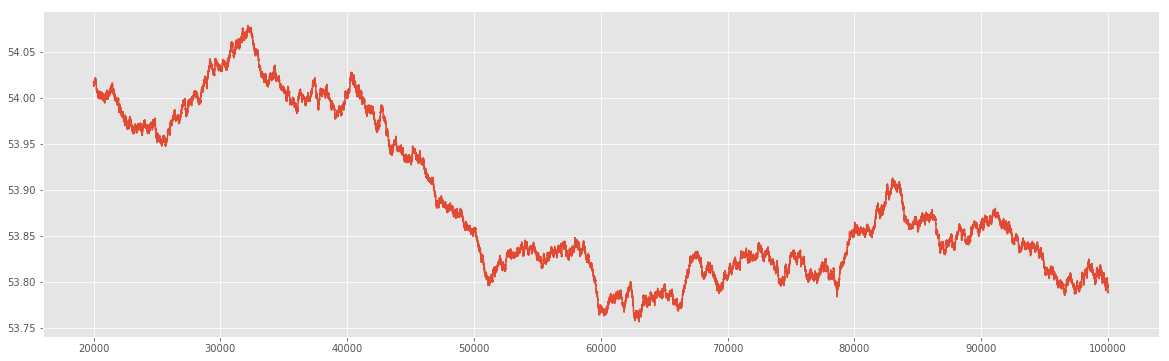

In [35]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(time_to_win).rolling(20000, min_periods=20000).mean())

In [60]:
print(time_to_win)

[61, 54, 47, 43, 52, 63, 59, 64, 57, 53, 61, 52, 64, 55, 48, 51, 43, 61, 51, 45, 60, 57, 56, 41, 59, 55, 45, 67, 58, 49, 46, 59, 50, 50, 57, 58, 54, 48, 52, 41, 60, 42, 61, 59, 53, 46, 50, 58, 57, 50, 41, 42, 57, 47, 50, 41, 64, 52, 47, 55, 57, 51, 62, 70, 56, 61, 50, 51, 50, 52, 54, 50, 53, 65, 60, 43, 47, 55, 60, 57, 42, 47, 57, 57, 55, 45, 49, 51, 48, 46, 42, 52, 55, 51, 51, 52, 61, 49, 59, 46, 58, 47, 57, 75, 54, 59, 64, 53, 41, 57, 55, 48, 43, 53, 55, 58, 49, 41, 57, 51, 40, 62, 47, 64, 59, 59, 47, 49, 39, 66, 63, 62, 53, 61, 46, 78, 56, 50, 54, 41, 55, 46, 49, 57, 50, 58, 49, 41, 57, 55, 52, 53, 63, 56, 58, 41, 61, 55, 39, 66, 61, 49, 57, 58, 42, 72, 56, 47, 54, 64, 42, 67, 66, 47, 57, 47, 58, 58, 50, 64, 51, 47, 63, 65, 60, 65, 54, 39, 64, 53, 54, 58, 64, 49, 67, 53, 51, 70, 53, 52, 51, 46, 52, 61, 59, 45, 50, 61, 66, 51, 65, 47, 62, 49, 61, 64, 54, 63, 57, 47, 47, 69, 55, 41, 48, 64, 57, 61, 53, 65, 55, 48, 52, 42, 65, 55, 57, 62, 60, 69, 56, 64, 36, 38, 68, 48, 42, 62, 38, 57,

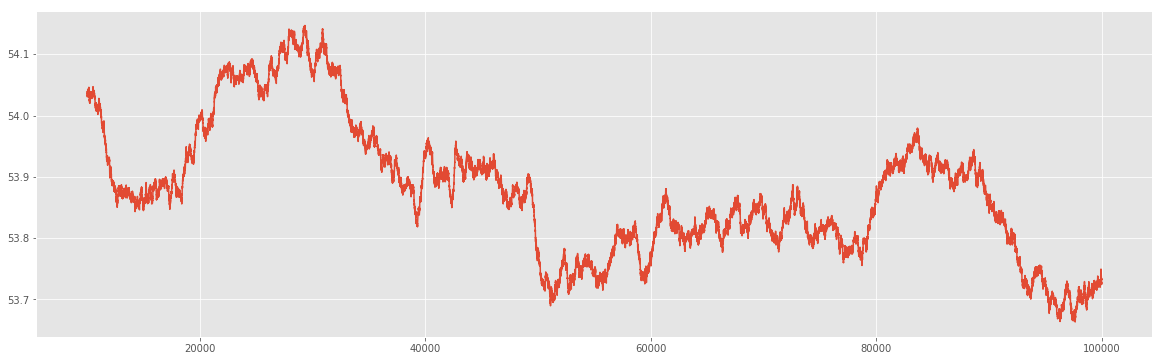

In [36]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(episode_lengths).rolling(10000, min_periods=10000).mean())

In [37]:
# get policy
policy = {}
for key, value in q_func_1.items():
    policy[key] = np.argmax(value)

In [38]:
def random_policy(possible_actions):
    return np.random.choice(possible_actions)

def trained_policy(state, possible_actions, policy, movable_piece_board_pos):
    if state in policy:
        best_action = policy[state]
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

def test_q_agent(env, num_episodes, policy):
    player1 = 0 # trained
    player2 = 1 # random
    init_q_value = 0.0
    
    episode_rewards_p1 = np.zeros(num_episodes)
    episode_rewards_p2 = np.zeros(num_episodes)
    time_to_win = []
    for i in range(num_episodes):
        episode_transitions_p1 = list()
        episode_transitions_p2 = list()
        dice_up = env.roll()
        state = env.reset(dice_up)
        is_done = False
        t = 0
        
        while True:
            # player 1 move
            t += 1
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            reward_p1 = 0
            if len(possible_actions) != 0:
                action = trained_policy(state, possible_actions, policy, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                episode_rewards_p1[i] += reward_p1
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            reward_p2 = 0
            if len(possible_actions) != 0:
                action = random_policy(possible_actions)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_rewards_p2[i] += reward_p2
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            dice_up = env.roll()
        time_to_win.append(t)
        
    return episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win

In [55]:
test_episode_rewards_p1, test_episode_rewards_p2, test_episode_lengths, test_time_to_win = test_q_agent(env, 100, policy)

In [56]:
test_avg_trained = np.mean(test_episode_rewards_p1)
test_avg_random = np.mean(test_episode_rewards_p2)
print("Trained Score: ", test_avg_trained/(test_avg_random + test_avg_trained))
print("Random Score: ", test_avg_random/(test_avg_random + test_avg_trained))

Trained Score:  0.5702306079664571
Random Score:  0.42976939203354303


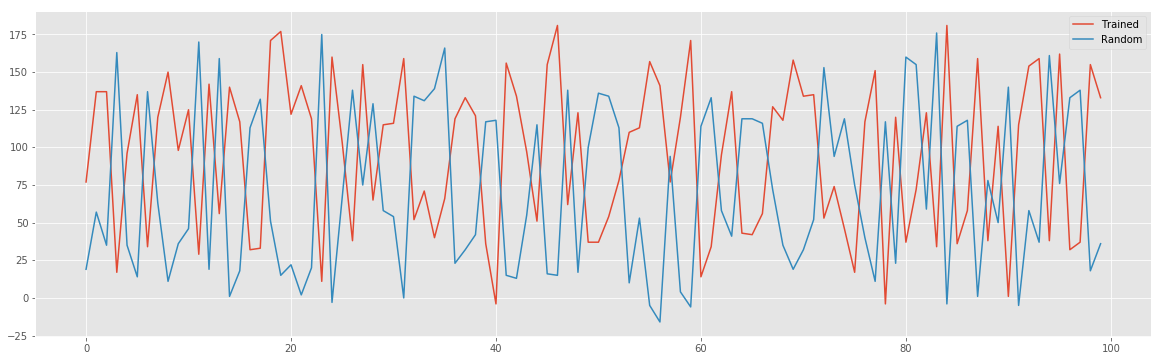

In [57]:
plt.figure(figsize=(20, 6))
trained, = plt.plot(test_episode_rewards_p1[:100], label='Trained')
random, = plt.plot(test_episode_rewards_p2[:100], label='Random')
plt.legend([trained, random], ['Trained', 'Random'])

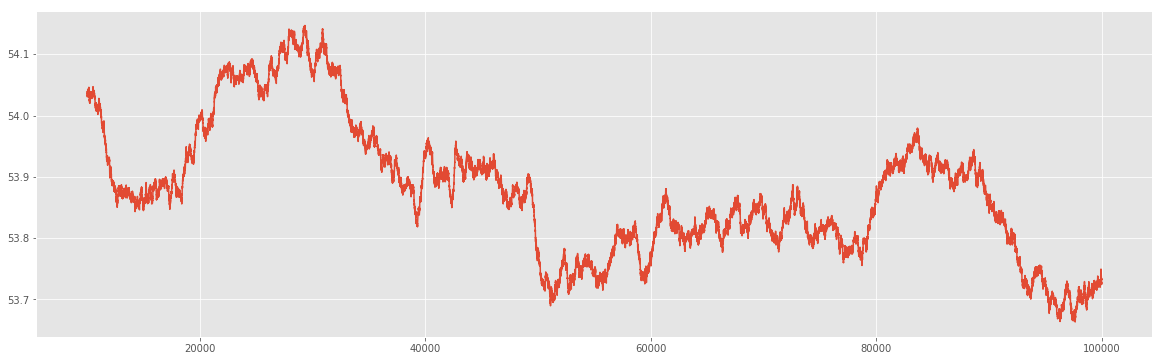

In [59]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(test_episode_lengths).rolling(10000, min_periods=10000).mean())

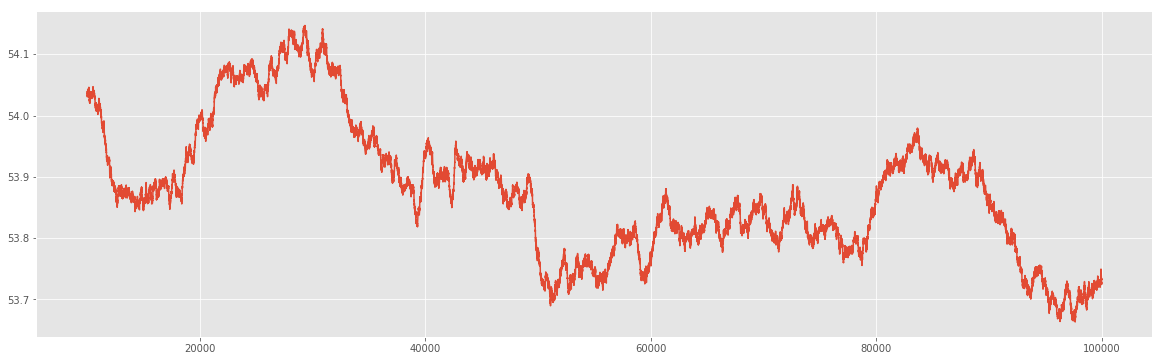

In [44]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(time_to_win).rolling(10000, min_periods=10000).mean())

In [45]:
p1_mean_rwds = np.mean(np.array(episode_rwds_p1[-1]).reshape(1, -1), axis=0)
p2_mean_rwds = np.mean(np.array(episode_rwds_p2[-1]).reshape(1, -1), axis=0)

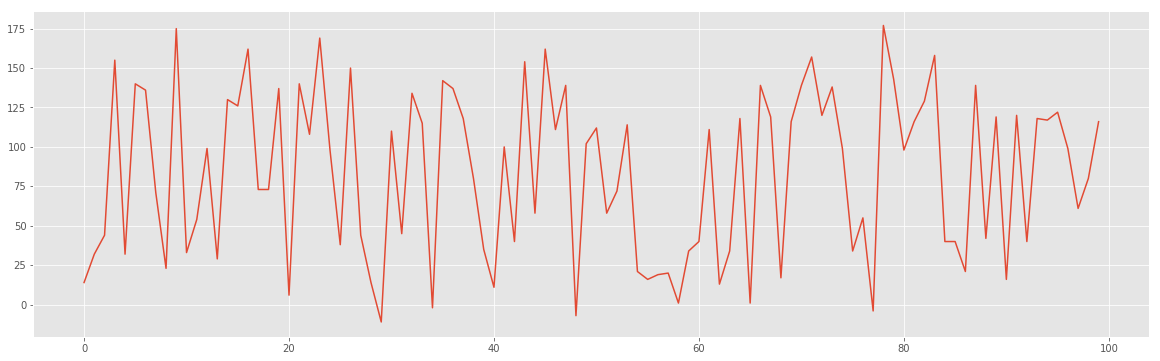

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])

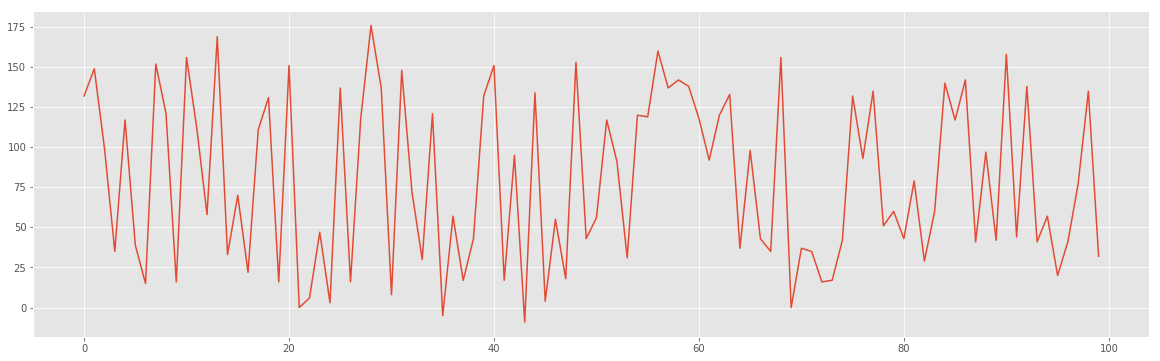

In [47]:
plt.figure(figsize=(20, 6))
plt.plot(p2_mean_rwds[-100:])

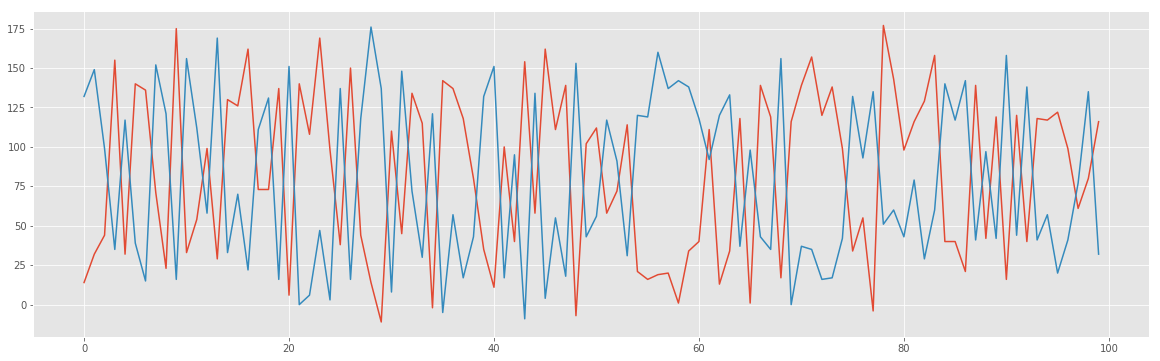

In [48]:
plt.figure(figsize=(20, 6))
plt.plot(p1_mean_rwds[-100:])
plt.plot(p2_mean_rwds[-100:])

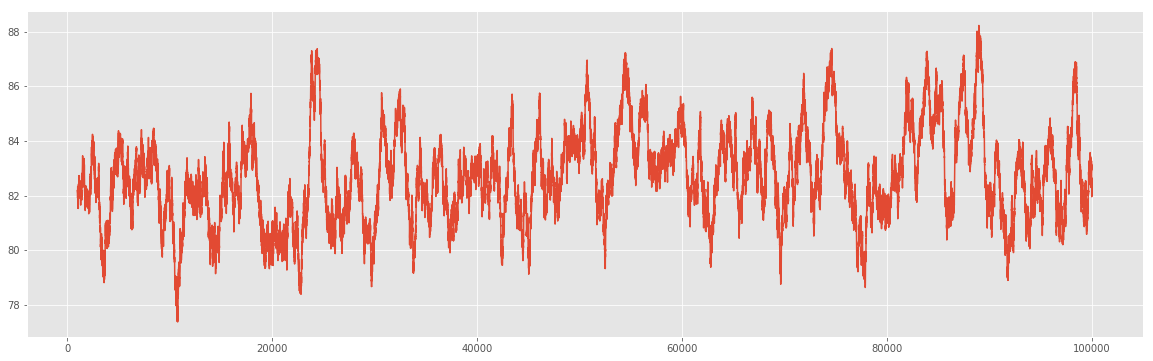

In [49]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds).rolling(1000, min_periods=1000).mean())

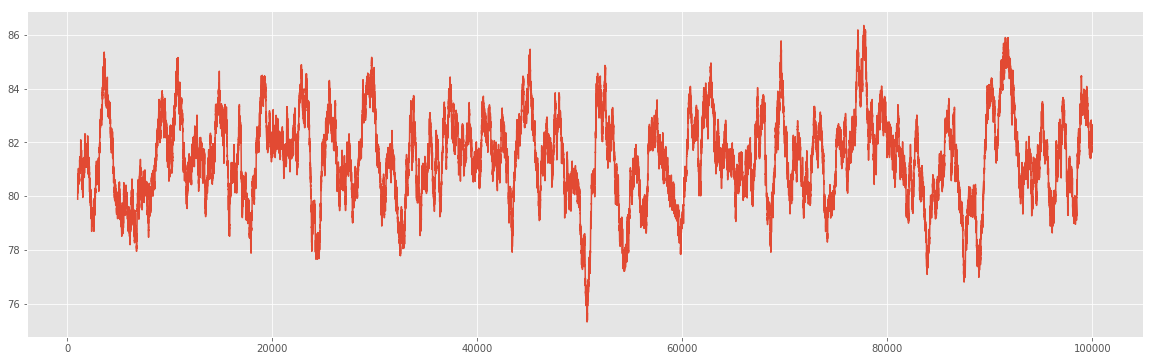

In [50]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p2_mean_rwds).rolling(1000, min_periods=1000).mean())

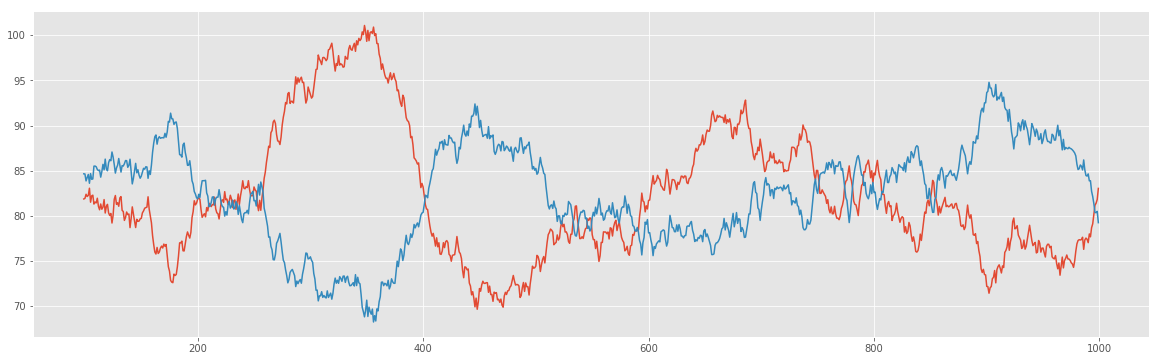

In [51]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())
plt.plot(pd.Series(p2_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())

In [61]:
time_to_win_mc = [60, 56, 68, 69, 46, 54, 72, 55, 67, 54, 65, 58, 69, 57, 54, 50, 45, 68, 52, 44, 42, 70, 58, 70, 48, 47, 50, 61, 49, 47, 44, 61, 56, 42, 64, 51, 63, 50, 56, 50, 53, 49, 53, 73, 57, 51, 55, 61, 61, 58, 49, 45, 60, 60, 42, 52, 63, 47, 54, 47, 67, 55, 46, 46, 52, 64, 54, 52, 58, 56, 59, 47, 50, 59, 52, 59, 47, 57, 65, 64, 62, 53, 55, 56, 46, 54, 50, 56, 49, 55, 44, 43, 48, 57, 56, 57, 46, 45, 43, 53, 62, 46, 57, 44, 59, 44, 50, 66, 58, 54, 55, 44, 57, 65, 52, 56, 48, 41, 48, 46, 66, 42, 54, 51, 63, 58, 51, 69, 48, 39, 65, 52, 50, 43, 51, 46, 56, 59, 64, 63, 54, 48, 54, 42, 65, 61, 51, 55, 54, 56, 55, 44, 47, 56, 51, 48, 76, 60, 53, 65, 49, 62, 65, 56, 57, 54, 45, 54, 60, 62, 68, 61, 51, 43, 56, 68, 53, 47, 47, 53, 51, 51, 77, 61, 52, 48, 50, 40, 42, 61, 53, 48, 42, 56, 45, 63, 62, 54, 44, 39, 56, 68, 55, 59, 67, 48, 47, 53, 61, 56, 54, 52, 48, 49, 51, 60, 56, 44, 73, 51, 38, 57, 52, 50, 58, 43, 56, 63, 62, 40, 58, 53, 65, 52, 58, 52, 57, 46, 64, 44, 42, 49, 51, 59, 67, 55, 49, 55, 58, 47, 59, 61, 60, 51, 48, 64, 47, 47, 62, 60, 46, 61, 61, 52, 47, 56, 47, 55, 68, 46, 49, 42, 52, 53, 40, 59, 57, 55, 50, 61, 61, 53, 51, 53, 43, 60, 45, 42, 66, 42, 46, 47, 66, 54, 48, 43, 57, 47, 52, 40, 62, 69, 59, 57, 67, 59, 56, 69, 62, 57, 62, 43, 59, 39, 45, 50, 51, 68, 57, 44, 55, 48, 50, 56, 60, 54, 67, 52, 57, 59, 45, 42, 51, 51, 51, 47, 48, 47, 47, 45, 56, 63, 43, 50, 49, 51, 51, 51, 48, 45, 59, 55, 44, 56, 51, 47, 50, 45, 68, 62, 57, 46, 50, 58, 54, 71, 55, 49, 54, 50, 70, 45, 58, 56, 59, 53, 41, 62, 57, 45, 65, 61, 64, 46, 55, 59, 60, 49, 48, 45, 49, 52, 42, 51, 44, 51, 47, 52, 61, 43, 58, 60, 56, 66, 53, 61, 40, 42, 55, 58, 50, 65, 44, 46, 56, 60, 50, 58, 48, 54, 57, 50, 48, 57, 53, 72, 41, 50, 44, 53, 49, 42, 43, 63, 59, 51, 48, 61, 68, 63, 53, 56, 38, 67, 76, 68, 57, 56, 46, 47, 54, 53, 72, 55, 48, 46, 45, 49, 67, 56, 83, 46, 48, 58, 62, 71, 47, 47, 54, 55, 46, 67, 45, 56, 60, 52, 61, 51, 46, 44, 48, 55, 62, 62, 54, 54, 42, 58, 70, 50, 40, 61, 47, 47, 50, 56, 57, 56, 56, 46, 74, 45, 54, 49, 66, 47, 59, 51, 66, 45, 48, 42, 53, 62, 64, 46, 42, 61, 54, 47, 53, 47, 54, 52, 56, 47, 46, 46, 68, 50, 49, 46, 52, 51, 56, 53, 64, 59, 59, 42, 68, 57, 54, 55, 61, 42, 44, 56, 45, 45, 61, 51, 49, 46, 42, 55, 53, 55, 58, 53, 58, 56, 50, 58, 43, 64, 54, 72, 62, 59, 56, 58, 52, 45, 65, 45, 50, 55, 55, 55, 57, 49, 60, 62, 58, 44, 53, 51, 47, 49, 61, 49, 50, 56, 51, 54, 40, 51, 59, 47, 76, 62, 48, 44, 47, 56, 43, 56, 47, 56, 39, 59, 54, 50, 73, 59, 61, 52, 53, 55, 47, 65, 46, 50, 53, 62, 46, 69, 53, 60, 55, 60, 51, 52, 47, 53, 48, 58, 50, 54, 53, 63, 62, 48, 49, 47, 53, 57, 80, 50, 56, 54, 44, 51, 48, 49, 58, 42, 53, 46, 52, 60, 48, 47, 63, 48, 54, 75, 46, 50, 48, 46, 48, 49, 51, 45, 50, 42, 48, 64, 51, 60, 54, 58, 44, 64, 41, 39, 49, 45, 50, 44, 65, 49, 39, 62, 56, 71, 50, 56, 43, 49, 40, 52, 53, 56, 47, 55, 50, 51, 65, 59, 72, 56, 48, 57, 51, 49, 43, 44, 46, 61, 65, 52, 44, 57, 53, 42, 60, 52, 40, 70, 52, 60, 49, 49, 48, 58, 61, 56, 78, 50, 48, 58, 47, 55, 42, 47, 56, 46, 67, 46, 43, 44, 48, 44, 56, 59, 67, 61, 55, 49, 45, 65, 72, 47, 52, 62, 48, 65, 49, 51, 58, 52, 55, 46, 60, 79, 62, 54, 47, 69, 52, 44, 63, 57, 41, 61, 49, 43, 45, 44, 49, 46, 45, 57, 73, 57, 52, 49, 50, 56, 45, 43, 51, 65, 46, 56, 67, 64, 45, 61, 61, 59, 52, 37, 51, 49, 52, 44, 78, 45, 63, 52, 40, 59, 60, 57, 47, 49, 66, 53, 55, 46, 49, 68, 50, 59, 44, 40, 50, 46, 57, 50, 47, 67, 57, 66, 49, 55, 46, 53, 42, 50, 52, 54, 42, 48, 58, 58, 61, 52, 66, 44, 40, 55, 73, 41, 50, 45, 68, 62, 68, 50, 52, 47, 61, 47, 46, 64, 62, 60, 52, 57, 58, 63, 50, 49, 50, 57, 57, 51, 59, 60, 50, 46, 43, 42, 59, 63, 46, 50, 49, 62, 50, 56, 38, 58, 74, 66, 53, 46, 57, 51, 42, 56, 58, 70, 46, 50, 58, 55, 50, 64, 50, 49, 43, 56, 54, 48, 42, 45, 52, 70, 64, 54, 49, 52, 49, 68, 51, 40, 52, 52, 48, 60, 43, 75, 56, 44, 56, 48, 51, 47, 49, 47, 69, 53, 47, 71, 40, 55, 51, 58, 38, 55, 53, 54, 63, 59, 49, 45, 59, 52, 43, 46, 49, 49, 48, 58, 58, 45, 57, 44, 68, 55, 54, 59, 61, 60, 61, 52, 53, 63, 49, 60, 58, 42, 62, 42, 44, 44, 47, 48, 48, 53, 65, 62, 55, 64, 55, 54, 51, 56, 58, 49, 66, 63, 46, 58, 54, 50, 78, 50, 66, 53, 54, 53, 70, 53, 52, 42, 48, 43, 63, 44, 58, 59, 51, 52, 75, 67, 61, 68, 55, 63, 48, 42, 44, 50, 58, 53, 58, 47, 57, 60, 49, 51, 62, 46, 50, 53, 69, 58, 52, 43, 63, 44, 59, 43, 50, 41, 43, 58, 71, 59, 57, 44, 69, 66, 52, 54, 49, 55, 46, 43, 58, 50, 48, 69, 47, 68, 52, 54, 65, 55, 61, 52, 46, 53, 51, 60, 57, 55, 68, 51, 52, 51, 46, 68, 57, 74, 61, 56, 59, 60, 49, 54, 56, 57, 40, 59, 43, 50, 64, 54, 52, 48, 55, 65, 65, 61, 53, 59, 47, 45, 59, 67, 58, 54, 44, 52, 60, 62, 45, 45, 61, 66, 45, 64, 41, 43, 60, 44, 49, 72, 46, 67, 53, 49, 45, 62, 40, 62, 53, 50, 50, 62, 53, 42, 43, 45, 48, 55, 48, 59, 59, 53, 40, 56, 41, 41, 59, 53, 51, 54, 62, 46, 50, 58, 45, 64, 67, 59, 51, 77, 53, 52, 55, 64, 49, 56, 45, 59, 56, 78, 68, 48, 44, 44, 48, 47, 60, 63, 53, 59, 53, 59, 49, 50, 57, 60, 53, 58, 46, 54, 62, 55, 54, 48, 55, 46, 50, 72, 40, 50, 48, 69, 61, 54, 52, 67, 53, 49, 46, 66, 51, 49, 65, 39, 50, 52, 51, 54, 62, 39, 62, 64, 46, 55, 47, 49, 40, 60, 61, 51, 66, 52, 61, 49, 45, 40, 54, 52, 65, 52, 60, 64, 63, 45, 47, 51, 48, 61, 44, 59, 69, 60, 59, 53, 57, 46, 53, 41, 59, 54, 43, 51, 64, 53, 55, 52, 50, 54, 63, 52, 49, 47, 48, 42, 60, 51, 48, 58, 51, 58, 44, 41, 58, 55, 65, 63, 79, 55, 61, 51, 56, 54, 50, 60, 68, 49, 62, 52, 54, 52, 59, 57, 70, 60, 55, 51, 38, 46, 56, 47, 48, 61, 53, 47, 51, 65, 50, 46, 46, 52, 50, 58, 62, 68, 59, 62, 49, 47, 50, 58, 56, 60, 68, 61, 53, 53, 49, 56, 48, 60, 56, 45, 46, 47, 54, 59, 58, 54, 59, 54, 40, 56, 54, 56, 55, 57, 67, 51, 52, 50, 48, 46, 51, 46, 56, 60, 64, 46, 47, 55, 63, 47, 47, 54, 40, 57, 59, 59, 48, 48, 60, 44, 66, 40, 65, 61, 47, 53, 50, 46, 43, 49, 47, 57, 56, 48, 41, 50, 45, 48, 74, 45, 57, 44, 57, 45, 63, 45, 50, 44, 51, 58, 48, 44, 52, 55, 51, 50, 48, 39, 63, 64, 51, 55, 53, 61, 52, 54, 68, 51, 54, 52, 56, 55, 53, 52, 43, 50, 56, 48, 60, 49, 50, 44, 53, 49, 55, 49, 68, 53, 50, 38, 52, 58, 44, 52, 61, 49, 54, 75, 51, 50, 52, 50, 39, 65, 69, 62, 53, 62, 61, 67, 38, 47, 50, 57, 53, 53, 60, 63, 48, 55, 38, 59, 46, 73, 55, 45, 42, 51, 49, 73, 47, 85, 65, 65, 76, 57, 59, 60, 58, 57, 49, 51, 48, 53, 50, 58, 52, 60, 56, 47, 43, 61, 85, 41, 49, 78, 63, 57, 46, 50, 68, 56, 51, 50, 45, 53, 58, 52, 46, 63, 48, 56, 47, 40, 58, 45, 56, 60, 44, 43, 45, 46, 60, 53, 61, 45, 54, 40, 51, 49, 58, 65, 46, 42, 42, 57, 59, 55, 49, 37, 47, 55, 46, 55, 51, 42, 48, 57, 51, 62, 50, 40, 57, 55, 52, 71, 63, 53, 52, 57, 60, 58, 69, 56, 65, 51, 55, 46, 54, 67, 47, 50, 59, 54, 38, 48, 52, 52, 60, 53, 55, 55, 46, 55, 50, 55, 43, 57, 48, 56, 64, 68, 52, 54, 57, 73, 43, 61, 64, 35, 62, 48, 52, 56, 53, 54, 80, 52, 46, 51, 48, 47, 53, 46, 53, 45, 57, 45, 50, 48, 50, 37, 44, 62, 57, 61, 60, 57, 44, 56, 62, 52, 56, 50, 71, 59, 51, 55, 47, 47, 49, 69, 49, 45, 50, 53, 70, 57, 65, 74, 56, 57, 58, 62, 52, 48, 53, 54, 56, 42, 57, 45, 51, 74, 45, 52, 50, 58, 38, 40, 56, 44, 41, 55, 57, 56, 48, 64, 44, 50, 60, 50, 44, 65, 50, 50, 47, 55, 44, 66, 49, 52, 45, 65, 56, 67, 59, 47, 61, 64, 40, 42, 49, 51, 47, 43, 53, 50, 41, 53, 46, 58, 47, 62, 47, 57, 50, 50, 60, 55, 53, 47, 51, 48, 60, 46, 46, 51, 59, 65, 51, 62, 58, 63, 58, 44, 49, 47, 63, 48, 55, 51, 45, 52, 68, 45, 49, 43, 60, 47, 68, 49, 59, 52, 53, 48, 64, 62, 75, 56, 48, 68, 51, 46, 62, 44, 52, 63, 47, 45, 52, 59, 58, 62, 58, 62, 49, 57, 52, 58, 47, 46, 57, 48, 57, 44, 50, 52, 52, 50, 55, 64, 45, 53, 64, 50, 44, 56, 41, 58, 52, 44, 61, 45, 53, 57, 59, 63, 62, 48, 46, 51, 60, 58, 52, 42, 46, 43, 43, 51, 48, 63, 57, 42, 75, 59, 48, 53, 51, 57, 46, 44, 76, 53, 56, 63, 47, 55, 61, 46, 53, 58, 46, 53, 77, 52, 60, 42, 59, 50, 47, 57, 58, 47, 58, 68, 44, 63, 48, 55, 53, 73, 67, 62, 60, 47, 47, 70, 39, 58, 65, 45, 58, 46, 57, 54, 63, 50, 67, 59, 52, 49, 77, 55, 53, 51, 53, 52, 72, 59, 60, 48, 49, 53, 47, 50, 52, 55, 45, 48, 86, 50, 54, 63, 55, 61, 53, 60, 48, 79, 61, 71, 45, 65, 59, 42, 57, 58, 54, 43, 68, 44, 65, 52, 50, 54, 51, 45, 55, 58, 70, 45, 69, 64, 69, 51, 40, 40, 54, 47, 71, 62, 61, 49, 45, 55, 72, 51, 55, 65, 51, 60, 60, 55, 71, 76, 53, 48, 52, 52, 55, 50, 46, 44, 51, 67, 63, 63, 48, 48, 41, 58, 44, 63, 48, 70, 49, 49, 47, 39, 46, 59, 49, 47, 61, 55, 45, 51, 39, 48, 44, 41, 60, 45, 62, 49, 50, 45, 59, 70, 45, 55, 65, 72, 53, 50, 56, 58, 53, 60, 66, 50, 96, 44, 55, 47, 49, 42, 43, 40, 43, 47, 60, 57, 63, 64, 48, 47, 73, 77, 57, 63, 56, 67, 64, 58, 53, 58, 65, 57, 52, 51, 51, 54, 51, 37, 53, 69, 51, 49, 53, 59, 52, 48, 42, 49, 52, 49, 50, 41, 52, 41, 58, 49, 45, 46, 42, 49, 50, 55, 44, 49, 63, 49, 72, 50, 54, 58, 58, 53, 50, 52, 54, 70, 60, 49, 70, 52, 49, 64, 48, 47, 48, 45, 53, 55, 56, 51, 59, 41, 88, 52, 51, 47, 50, 49, 47, 49, 47, 63, 45, 57, 62, 61, 48, 58, 58, 67, 46, 49, 47, 59, 54, 51, 49, 53, 45, 61, 40, 66, 42, 60, 56, 66, 54, 70, 44, 41, 64, 47, 57, 66, 43, 64, 50, 52, 38, 70, 50, 53, 57, 54, 42, 63, 57, 61, 46, 46, 68, 55, 58, 52, 65, 58, 55, 56, 42, 52, 47, 63, 68, 57, 54, 41, 51, 47, 39, 57, 56, 57, 60, 59, 53, 42, 53, 44, 69, 54, 52, 64, 50, 48, 68, 51, 68, 55, 44, 62, 62, 54, 57, 60, 44, 53, 48, 45, 55, 52, 59, 52, 56, 57, 67, 56, 48, 47, 64, 65, 57, 43, 57, 58, 46, 58, 48, 56, 49, 62, 60, 46, 51, 64, 53, 59, 47, 48, 62, 50, 67, 58, 64, 54, 53, 53, 66, 50, 50, 47, 52, 70, 64, 55, 51, 44, 53, 78, 43, 48, 50, 49, 67, 43, 53, 60, 54, 65, 52, 64, 53, 64, 70, 60, 52, 63, 60, 51, 45, 53, 54, 52, 44, 51, 44, 49, 41, 54, 47, 58, 54, 67, 55, 67, 58, 48, 54, 67, 55, 52, 46, 52, 55, 37, 57, 65, 52, 39, 50, 52, 43, 58, 50, 65, 49, 50, 40, 58, 56, 65, 49, 64, 53, 43, 46, 62, 47, 38, 52, 54, 58, 49, 54, 76, 49, 56, 64, 54, 50, 60, 50, 55, 73, 54, 60, 58, 48, 61, 60, 48, 50, 50, 38, 53, 38, 42, 52, 63, 45, 47, 48, 50, 42, 71, 57, 43, 55, 56, 54, 47, 69, 65, 53, 55, 46, 54, 52, 62, 50, 80, 58, 51, 56, 74, 60, 44, 49, 51, 57, 53, 54, 58, 55, 59, 52, 57, 50, 57, 51, 77, 62, 44, 63, 55, 46, 57, 36, 56, 65, 47, 45, 57, 57, 50, 42, 49, 45, 42, 68, 43, 44, 50, 55, 41, 52, 68, 59, 54, 48, 49, 51, 50, 68, 46, 46, 58, 59, 52, 43, 52, 47, 47, 48, 64, 41, 83, 52, 67, 51, 66, 66, 43, 62, 51, 39, 65, 53, 46, 58, 46, 66, 67, 44, 57, 54, 50, 56, 44, 58, 58, 53, 55, 57, 44, 59, 56, 52, 46, 48, 56, 53, 54, 62, 50, 42, 55, 60, 48, 59, 62, 55, 40, 52, 43, 64, 42, 75, 63, 52, 53, 46, 64, 72, 60, 58, 49, 49, 53, 67, 39, 43, 43, 52, 45, 51, 53, 44, 43, 53, 60, 55, 46, 59, 50, 43, 70, 48, 49, 50, 67, 59, 72, 49, 60, 47, 45, 55, 46, 58, 43, 64, 50, 58, 53, 50, 53, 47, 58, 49, 54, 61, 73, 38, 53, 68, 39, 52, 47, 73, 45, 53, 57, 66, 58, 55, 46, 57, 50, 59, 40, 53, 48, 55, 62, 52, 50, 49, 51, 46, 46, 46, 51, 42, 56, 52, 59, 61, 57, 52, 62, 57, 54, 49, 63, 61, 55, 56, 45, 50, 61, 55, 47, 47, 62, 55, 55, 54, 40, 59, 41, 67, 53, 49, 54, 70, 50, 52, 69, 50, 49, 58, 56, 49, 73, 45, 54, 62, 55, 47, 48, 42, 55, 49, 67, 58, 41, 61, 59, 54, 52, 36, 53, 54, 57, 59, 40, 54, 54, 48, 51, 60, 60, 58, 52, 59, 59, 54, 57, 52, 53, 45, 44, 52, 69, 46, 61, 43, 48, 62, 41, 42, 42, 61, 45, 59, 54, 70, 52, 44, 40, 47, 61, 60, 39, 39, 52, 48, 50, 37, 52, 55, 57, 62, 45, 59, 42, 66, 63, 41, 51, 58, 58, 43, 65, 46, 64, 42, 53, 59, 42, 53, 49, 85, 44, 47, 57, 51, 65, 54, 54, 49, 51, 47, 50, 59, 57, 54, 54, 65, 62, 49, 58, 74, 37, 69, 56, 50, 48, 41, 47, 46, 66, 55, 59, 56, 61, 65, 65, 77, 56, 59, 59, 60, 51, 55, 59, 63, 50, 53, 56, 77, 43, 49, 48, 58, 73, 51, 44, 48, 53, 41, 39, 56, 47, 71, 50, 56, 51, 65, 46, 56, 57, 56, 70, 39, 59, 61, 74, 57, 38, 58, 47, 55, 54, 57, 47, 56, 62, 45, 45, 46, 70, 48, 53, 55, 54, 51, 73, 55, 46, 48, 49, 47, 42, 59, 46, 62, 61, 52, 59, 66, 48, 55, 47, 49, 56, 42, 42, 69, 58, 52, 49, 47, 53, 45, 50, 57, 50, 49, 55, 62, 55, 49, 51, 43, 53, 53, 65, 64, 67, 78, 51, 58, 50, 47, 52, 45, 42, 46, 57, 66, 53, 51, 66, 52, 43, 54, 60, 43, 44, 59, 50, 67, 49, 43, 59, 52, 61, 50, 54, 47, 64, 72, 52, 60, 47, 51, 50, 54, 38, 65, 64, 59, 43, 63, 43, 53, 56, 43, 55, 54, 47, 47, 53, 59, 43, 50, 68, 59, 55, 52, 62, 54, 55, 55, 41, 51, 59, 55, 63, 51, 49, 49, 52, 65, 70, 48, 50, 64, 60, 46, 52, 51, 57, 51, 71, 41, 69, 62, 56, 62, 46, 61, 42, 57, 51, 56, 48, 43, 53, 51, 55, 64, 54, 51, 45, 54, 64, 49, 56, 49, 55, 57, 50, 46, 53, 46, 44, 48, 47, 48, 56, 56, 58, 41, 56, 63, 45, 57, 59, 46, 58, 43, 59, 67, 46, 60, 54, 53, 42, 53, 64, 61, 45, 71, 45, 47, 60, 43, 49, 54, 69, 49, 64, 51, 53, 49, 45, 53, 58, 54, 50, 63, 47, 81, 59, 58, 64, 59, 52, 51, 82, 65, 52, 54, 63, 55, 73, 56, 71, 68, 80, 47, 60, 58, 42, 52, 51, 63, 63, 48, 50, 56, 41, 43, 51, 61, 51, 68, 65, 69, 53, 49, 44, 47, 52, 51, 46, 44, 45, 46, 66, 53, 50, 61, 55, 50, 51, 43, 51, 38, 57, 39, 50, 65, 44, 65, 52, 56, 44, 44, 58, 67, 49, 56, 51, 50, 53, 43, 56, 67, 52, 42, 51, 48, 57, 53, 46, 66, 48, 57, 41, 48, 53, 57, 55, 46, 41, 47, 66, 49, 69, 50, 56, 61, 48, 49, 51, 51, 64, 65, 47, 68, 56, 41, 62, 54, 64, 47, 53, 49, 57, 43, 38, 46, 41, 51, 55, 52, 51, 48, 59, 57, 54, 43, 59, 44, 55, 46, 54, 46, 38, 65, 64, 52, 52, 56, 54, 75, 40, 60, 67, 48, 53, 57, 50, 46, 52, 45, 47, 39, 65, 55, 90, 58, 52, 48, 46, 71, 42, 74, 41, 53, 51, 61, 52, 60, 68, 42, 52, 57, 69, 44, 49, 71, 49, 54, 44, 50, 69, 44, 65, 49, 46, 46, 45, 62, 46, 52, 46, 56, 55, 56, 55, 37, 56, 50, 47, 57, 50, 62, 58, 44, 50, 49, 56, 53, 64, 56, 60, 56, 60, 46, 53, 74, 51, 69, 57, 42, 66, 66, 65, 58, 58, 55, 69, 62, 51, 71, 51, 56, 55, 60, 45, 63, 46, 56, 44, 52, 56, 69, 51, 45, 54, 47, 46, 68, 54, 59, 60, 57, 49, 68, 65, 55, 62, 55, 50, 46, 55, 44, 59, 55, 55, 76, 61, 54, 48, 51, 58, 48, 51, 72, 52, 56, 50, 64, 47, 54, 51, 42, 48, 53, 65, 65, 60, 42, 55, 51, 61, 49, 57, 65, 45, 62, 48, 46, 46, 68, 48, 68, 65, 45, 52, 61, 55, 60, 68, 37, 52, 57, 45, 62, 66, 64, 59, 52, 50, 50, 58, 46, 54, 51, 58, 47, 54, 45, 57, 53, 46, 55, 42, 51, 54, 47, 40, 65, 55, 47, 70, 57, 47, 46, 56, 49, 61, 56, 55, 60, 48, 45, 56, 47, 70, 54, 54, 55, 59, 44, 61, 45, 45, 60, 66, 57, 51, 42, 65, 47, 58, 50, 56, 61, 52, 51, 46, 61, 46, 51, 62, 52, 53, 72, 48, 46, 48, 83, 50, 49, 52, 47, 50, 64, 54, 42, 85, 66, 52, 50, 51, 53, 61, 52, 55, 55, 50, 57, 47, 54, 51, 41, 52, 51, 41, 47, 51, 52, 46, 52, 46, 55, 65, 47, 53, 51, 68, 44, 56, 59, 55, 58, 43, 56, 54, 45, 57, 59, 49, 53, 61, 51, 46, 61, 47, 52, 38, 57, 42, 53, 53, 50, 55, 57, 54, 53, 54, 48, 58, 60, 71, 43, 60, 56, 56, 54, 42, 55, 50, 42, 54, 42, 67, 45, 57, 52, 56, 54, 50, 66, 51, 40, 51, 68, 48, 50, 70, 63, 44, 60, 48, 57, 42, 65, 55, 66, 48, 58, 47, 45, 44, 48, 53, 52, 41, 56, 50, 49, 44, 52, 49, 53, 50, 43, 49, 48, 55, 51, 58, 40, 50, 58, 58, 63, 44, 45, 70, 69, 45, 47, 59, 48, 50, 44, 50, 52, 65, 49, 52, 46, 63, 61, 44, 59, 58, 70, 48, 50, 36, 69, 58, 47, 49, 51, 41, 65, 55, 41, 56, 41, 40, 58, 53, 50, 47, 54, 48, 40, 41, 66, 50, 63, 52, 53, 48, 60, 49, 53, 47, 51, 61, 58, 36, 48, 49, 66, 52, 59, 47, 60, 50, 65, 74, 53, 38, 61, 42, 51, 49, 59, 60, 44, 59, 63, 57, 58, 63, 54, 49, 54, 62, 60, 44, 60, 48, 63, 44, 52, 47, 47, 51, 59, 54, 51, 47, 48, 56, 57, 49, 56, 40, 50, 71, 52, 53, 48, 47, 60, 57, 45, 49, 64, 55, 50, 55, 63, 58, 77, 71, 57, 52, 39, 59, 69, 53, 59, 49, 49, 42, 57, 51, 50, 42, 40, 66, 60, 58, 62, 64, 51, 60, 56, 63, 60, 53, 56, 58, 56, 51, 61, 62, 54, 48, 52, 41, 72, 59, 48, 46, 54, 69, 54, 68, 71, 54, 70, 57, 57, 42, 55, 48, 51, 39, 71, 53, 44, 72, 64, 49, 61, 53, 39, 73, 42, 49, 42, 47, 42, 44, 56, 46, 47, 51, 67, 44, 51, 45, 51, 48, 56, 44, 58, 66, 43, 52, 52, 55, 57, 63, 49, 55, 43, 52, 63, 62, 49, 69, 62, 50, 59, 59, 55, 54, 52, 43, 58, 46, 50, 60, 44, 60, 66, 42, 70, 49, 43, 67, 56, 55, 55, 53, 49, 62, 52, 54, 56, 50, 50, 58, 50, 49, 61, 57, 41, 56, 57, 56, 46, 44, 54, 57, 39, 59, 46, 44, 57, 50, 49, 51, 60, 71, 45, 56, 45, 49, 51, 53, 42, 58, 61, 67, 54, 56, 55, 47, 61, 41, 58, 42, 40, 64, 65, 66, 55, 58, 48, 56, 50, 64, 57, 54, 43, 44, 66, 72, 53, 41, 57, 65, 57, 58, 55, 54, 61, 58, 52, 47, 53, 57, 46, 66, 50, 52, 63, 57, 40, 43, 57, 55, 45, 54, 60, 48, 56, 61, 53, 42, 49, 49, 40, 45, 63, 60, 73, 47, 64, 65, 47, 56, 58, 48, 53, 50, 52, 61, 45, 62, 58, 52, 53, 49, 54, 68, 33, 51, 57, 57, 46, 49, 61, 61, 45, 47, 52, 50, 46, 77, 56, 59, 49, 53, 38, 62, 47, 57, 63, 58, 50, 58, 37, 48, 52, 55, 55, 49, 52, 56, 64, 53, 52, 46, 47, 76, 52, 45, 51, 46, 47, 56, 60, 48, 45, 41, 60, 53, 59, 49, 52, 63, 63, 57, 42, 49, 54, 50, 71, 62, 63, 52, 53, 48, 47, 52, 51, 45, 58, 70, 64, 47, 57, 56, 40, 54, 63, 43, 58, 60, 52, 53, 55, 62, 50, 53, 49, 50, 51, 54, 52, 56, 40, 50, 45, 74, 57, 68, 54, 62, 46, 57, 66, 52, 56, 56, 57, 60, 44, 39, 63, 43, 52, 55, 58, 49, 58, 60, 50, 56, 47, 43, 52, 45, 42, 49, 40, 49, 61, 47, 44, 43, 69, 48, 62, 55, 52, 55, 61, 46, 45, 66, 59, 55, 47, 55, 49, 48, 53, 56, 57, 56, 55, 49, 61, 63, 56, 56, 64, 53, 66, 50, 53, 55, 84, 51, 45, 39, 58, 51, 71, 38, 39, 46, 49, 57, 59, 47, 43, 47, 55, 47, 61, 76, 58, 57, 40, 50, 47, 62, 55, 39, 54, 51, 47, 61, 61, 59, 67, 58, 63, 67, 44, 40, 53, 71, 65, 69, 42, 56, 64, 53, 59, 55, 46, 55, 49, 60, 47, 48, 46, 59, 45, 47, 50, 51, 52, 63, 73, 61, 53, 53, 47, 52, 54, 39, 58, 56, 69, 54, 52, 61, 54, 47, 60, 56, 56, 64, 57, 46, 42, 40, 58, 64, 44, 45, 57, 48, 52, 53, 47, 47, 78, 49, 58, 56, 54, 44, 60, 59, 55, 42, 59, 61, 38, 45, 75, 56, 52, 47, 47, 41, 47, 72, 60, 67, 52, 68, 48, 61, 52, 51, 51, 54, 45, 48, 65, 55, 64, 53, 46, 41, 44, 48, 76, 55, 56, 50, 49, 69, 58, 46, 49, 42, 61, 48, 50, 58, 62, 68, 43, 40, 71, 51, 53, 51, 63, 62, 49, 52, 57, 42, 49, 59, 39, 47, 53, 64, 82, 58, 54, 59, 48, 45, 42, 56, 52, 57, 54, 42, 43, 65, 40, 53, 52, 49, 50, 62, 64, 56, 68, 43, 70, 49, 37, 64, 68, 49, 46, 71, 45, 50, 64, 53, 61, 56, 52, 59, 50, 54, 52, 60, 45, 49, 84, 48, 47, 56, 45, 62, 44, 47, 47, 52, 63, 63, 57, 62, 54, 55, 51, 57, 43, 43, 60, 57, 48, 73, 62, 64, 59, 65, 40, 62, 56, 44, 67, 50, 56, 62, 52, 45, 45, 65, 51, 62, 53, 59, 63, 73, 50, 65, 50, 53, 52, 52, 55, 52, 63, 50, 51, 63, 55, 40, 42, 42, 70, 58, 54, 45, 65, 44, 48, 47, 49, 59, 61, 50, 65, 58, 55, 68, 51, 50, 55, 56, 54, 61, 74, 54, 65, 64, 51, 64, 74, 54, 59, 51, 41, 49, 45, 44, 44, 66, 70, 46, 53, 58, 57, 39, 51, 56, 74, 63, 57, 58, 42, 57, 54, 53, 41, 59, 54, 44, 58, 52, 49, 65, 57, 47, 42, 71, 39, 55, 52, 59, 74, 46, 49, 53, 55, 49, 53, 66, 58, 51, 51, 58, 51, 79, 70, 65, 41, 55, 55, 39, 45, 51, 74, 52, 59, 71, 61, 46, 45, 58, 57, 53, 65, 60, 65, 46, 50, 52, 47, 48, 47, 57, 49, 53, 49, 49, 53, 51, 63, 49, 60, 49, 45, 54, 69, 52, 52, 43, 48, 49, 49, 53, 54, 58, 54, 54, 55, 55, 54, 52, 65, 49, 52, 61, 48, 54, 60, 49, 47, 64, 53, 61, 71, 49, 66, 50, 40, 46, 52, 51, 50, 46, 48, 48, 67, 50, 51, 69, 45, 45, 63, 39, 53, 48, 49, 53, 59, 61, 59, 53, 67, 43, 49, 52, 45, 54, 62, 64, 47, 86, 55, 54, 59, 46, 53, 51, 60, 39, 43, 57, 53, 54, 50, 54, 55, 62, 39, 53, 61, 60, 54, 56, 46, 50, 51, 63, 52, 51, 47, 48, 58, 41, 54, 69, 67, 62, 47, 54, 63, 65, 48, 54, 57, 67, 55, 56, 46, 52, 54, 61, 60, 39, 51, 50, 48, 52, 60, 55, 42, 57, 43, 53, 53, 56, 61, 41, 52, 49, 48, 43, 37, 42, 50, 37, 49, 62, 38, 44, 54, 59, 47, 55, 40, 42, 55, 55, 40, 51, 49, 50, 61, 59, 50, 69, 47, 56, 62, 58, 51, 61, 46, 43, 40, 54, 66, 57, 47, 55, 67, 83, 55, 59, 56, 46, 51, 55, 45, 49, 49, 64, 74, 51, 62, 59, 47, 58, 65, 52, 65, 51, 51, 68, 46, 43, 50, 50, 73, 66, 67, 66, 58, 54, 43, 48, 60, 52, 58, 65, 52, 49, 56, 56, 54, 60, 46, 53, 54, 51, 64, 37, 42, 65, 55, 61, 56, 51, 58, 49, 54, 57, 50, 57, 52, 50, 56, 50, 55, 54, 52, 50, 52, 61, 49, 58, 50, 46, 56, 44, 52, 59, 57, 54, 48, 48, 52, 47, 57, 47, 68, 58, 45, 47, 54, 45, 65, 61, 47, 55, 52, 56, 41, 47, 62, 47, 63, 46, 69, 64, 53, 66, 53, 64, 63, 50, 55, 53, 54, 68, 51, 57, 67, 69, 66, 53, 53, 59, 47, 60, 56, 65, 51, 50, 57, 58, 71, 54, 60, 50, 55, 63, 60, 62, 63, 67, 50, 52, 61, 62, 44, 42, 44, 61, 48, 69, 55, 38, 64, 58, 51, 51, 48, 45, 47, 50, 54, 50, 54, 57, 56, 38, 60, 53, 49, 44, 68, 46, 68, 44, 56, 53, 66, 61, 70, 49, 62, 57, 77, 61, 50, 60, 57, 43, 48, 48, 45, 58, 39, 50, 67, 50, 67, 54, 45, 56, 68, 61, 55, 50, 55, 53, 47, 66, 64, 49, 54, 47, 50, 44, 50, 62, 61, 53, 56, 58, 50, 84, 47, 41, 65, 50, 52, 47, 60, 55, 52, 56, 54, 43, 48, 45, 50, 45, 54, 59, 50, 55, 52, 52, 49, 59, 61, 47, 59, 50, 69, 45, 46, 49, 47, 54, 63, 46, 68, 59, 52, 78, 53, 54, 68, 44, 43, 43, 58, 46, 49, 63, 56, 49, 50, 55, 50, 43, 48, 58, 49, 71, 44, 51, 62, 53, 61, 60, 52, 46, 52, 56, 52, 62, 48, 47, 73, 49, 49, 40, 58, 63, 63, 48, 44, 65, 57, 64, 53, 50, 51, 50, 59, 55, 56, 46, 41, 52, 54, 61, 58, 56, 46, 44, 40, 50, 45, 48, 63, 52, 66, 48, 57, 55, 68, 70, 43, 57, 60, 39, 76, 51, 53, 46, 49, 46, 50, 53, 54, 61, 42, 49, 65, 41, 38, 59, 55, 59, 60, 46, 45, 47, 56, 47, 41, 49, 62, 58, 56, 51, 55, 62, 45, 58, 56, 57, 56, 63, 53, 63, 49, 62, 46, 61, 58, 49, 63, 51, 58, 65, 53, 60, 62, 51, 72, 40, 61, 54, 56, 60, 56, 55, 48, 66, 56, 60, 46, 65, 59, 52, 55, 54, 69, 49, 42, 59, 39, 52, 54, 56, 47, 49, 53, 55, 50, 49, 55, 60, 48, 56, 62, 51, 47, 54, 60, 57, 52, 55, 68, 61, 39, 67, 51, 49, 47, 61, 40, 43, 54, 44, 45, 49, 58, 45, 74, 44, 66, 49, 55, 53, 62, 57, 53, 54, 82, 54, 38, 54, 72, 59, 51, 51, 56, 59, 47, 39, 53, 50, 50, 47, 57, 61, 43, 53, 54, 46, 48, 61, 54, 46, 45, 47, 53, 38, 67, 52, 53, 52, 47, 48, 53, 51, 58, 39, 42, 57, 56, 57, 57, 47, 55, 50, 57, 42, 68, 62, 52, 59, 67, 55, 65, 57, 62, 53, 50, 60, 47, 46, 53, 61, 70, 73, 50, 55, 54, 49, 50, 38, 69, 52, 45, 53, 48, 51, 52, 55, 56, 51, 40, 60, 67, 51, 46, 68, 72, 45, 43, 58, 59, 57, 43, 59, 41, 55, 59, 41, 53, 65, 50, 61, 61, 42, 50, 61, 62, 61, 47, 58, 49, 43, 48, 60, 60, 41, 39, 54, 55, 56, 53, 47, 66, 58, 46, 41, 55, 45, 54, 59, 50, 43, 59, 56, 46, 42, 56, 51, 61, 69, 50, 62, 51, 70, 46, 60, 55, 41, 52, 52, 50, 54, 63, 60, 55, 55, 65, 51, 49, 70, 61, 61, 48, 63, 47, 55, 47, 53, 53, 49, 62, 48, 47, 43, 58, 43, 53, 44, 54, 48, 54, 59, 53, 65, 43, 46, 67, 49, 40, 61, 47, 61, 50, 57, 50, 52, 58, 51, 50, 43, 52, 54, 48, 62, 59, 54, 45, 50, 47, 41, 45, 56, 54, 58, 50, 41, 45, 44, 66, 74, 62, 38, 69, 47, 65, 71, 60, 60, 63, 54, 48, 38, 50, 43, 73, 68, 62, 51, 59, 54, 56, 54, 45, 59, 46, 52, 58, 54, 55, 62, 60, 50, 59, 46, 38, 52, 42, 58, 81, 67, 62, 59, 35, 40, 48, 47, 53, 62, 40, 58, 40, 48, 68, 54, 54, 75, 58, 60, 48, 63, 57, 56, 54, 53, 63, 45, 45, 72, 62, 60, 46, 59, 55, 66, 50, 52, 49, 62, 52, 59, 67, 45, 55, 47, 60, 63, 69, 45, 59, 57, 68, 40, 50, 51, 48, 59, 54, 46, 50, 55, 55, 45, 56, 50, 43, 51, 62, 68, 40, 54, 53, 50, 49, 57, 57, 57, 60, 55, 61, 49, 50, 54, 40, 59, 50, 50, 51, 48, 53, 43, 52, 58, 55, 44, 48, 54, 54, 58, 54, 52, 50, 50, 54, 42, 63, 38, 68, 43, 51, 60, 52, 62, 57, 66, 55, 51, 59, 62, 63, 49, 55, 45, 59, 48, 50, 54, 45, 58, 51, 46, 54, 51, 46, 36, 53, 53, 67, 55, 53, 53, 51, 44, 59, 63, 61, 49, 54, 55, 43, 49, 62, 56, 43, 53, 40, 44, 76, 45, 50, 47, 51, 60, 56, 59, 44, 62, 50, 59, 56, 54, 52, 43, 53, 70, 71, 40, 61, 51, 77, 72, 46, 47, 49, 46, 48, 63, 59, 44, 63, 61, 55, 36, 50, 50, 47, 49, 62, 57, 50, 57, 47, 66, 44, 55, 76, 63, 59, 43, 58, 59, 70, 58, 45, 54, 67, 73, 69, 79, 57, 60, 56, 49, 45, 42, 49, 54, 59, 45, 49, 55, 52, 43, 53, 58, 44, 45, 49, 51, 57, 65, 45, 59, 60, 55, 53, 46, 48, 42, 42, 45, 64, 58, 43, 62, 43, 55, 56, 57, 52, 60, 72, 68, 61, 49, 45, 61, 42, 56, 56, 51, 50, 44, 40, 63, 41, 47, 55, 50, 58, 46, 49, 43, 57, 44, 62, 56, 51, 57, 46, 62, 47, 46, 67, 47, 48, 55, 54, 51, 49, 64, 53, 67, 53, 44, 49, 50, 52, 49, 53, 59, 50, 50, 53, 65, 49, 58, 54, 69, 61, 60, 44, 67, 55, 54, 63, 52, 56, 58, 58, 44, 63, 47, 50, 64, 72, 41, 54, 49, 76, 54, 63, 64, 44, 59, 62, 50, 53, 53, 48, 55, 52, 66, 51, 71, 49, 51, 50, 53, 57, 60, 71, 45, 49, 54, 64, 47, 56, 56, 70, 39, 43, 46, 51, 48, 47, 58, 59, 51, 52, 55, 67, 49, 79, 60, 72, 54, 69, 59, 48, 49, 61, 48, 46, 49, 58, 47, 65, 57, 55, 46, 51, 51, 56, 47, 51, 48, 55, 42, 58, 60, 41, 75, 59, 48, 46, 48, 56, 59, 41, 40, 47, 51, 54, 39, 46, 48, 56, 47, 52, 53, 46, 42, 65, 47, 46, 40, 50, 47, 52, 48, 67, 66, 48, 60, 42, 40, 51, 40, 66, 61, 46, 72, 40, 54, 50, 54, 67, 56, 52, 63, 71, 58, 60, 50, 60, 80, 49, 45, 37, 71, 50, 51, 58, 51, 53, 51, 50, 50, 67, 54, 55, 59, 41, 58, 54, 49, 58, 59, 55, 39, 62, 61, 41, 53, 44, 46, 52, 44, 59, 51, 45, 55, 52, 55, 43, 55, 51, 57, 54, 53, 50, 62, 53, 63, 44, 69, 59, 45, 49, 54, 45, 59, 38, 50, 64, 56, 53, 57, 61, 43, 52, 54, 75, 46, 46, 50, 54, 45, 78, 48, 54, 48, 37, 57, 72, 52, 50, 45, 66, 49, 60, 48, 46, 49, 62, 66, 57, 44, 44, 54, 72, 46, 51, 40, 56, 51, 52, 63, 51, 57, 57, 64, 40, 49, 44, 50, 67, 50, 47, 42, 59, 47, 48, 56, 81, 53, 50, 46, 52, 38, 44, 51, 38, 67, 64, 56, 69, 37, 43, 56, 54, 77, 48, 57, 61, 44, 62, 62, 45, 51, 51, 59, 50, 43, 46, 51, 51, 47, 67, 42, 52, 60, 66, 52, 87, 51, 58, 58, 53, 41, 66, 63, 45, 52, 41, 69, 70, 51, 43, 56, 52, 55, 44, 57, 75, 47, 49, 57, 48, 55, 63, 53, 57, 61, 61, 61, 46, 39, 51, 62, 65, 45, 60, 64, 55, 55, 48, 47, 51, 46, 54, 55, 63, 58, 52, 48, 44, 55, 53, 53, 38, 83, 50, 46, 60, 56, 60, 41, 45, 46, 55, 61, 64, 55, 45, 59, 72, 63, 49, 52, 59, 44, 50, 42, 54, 52, 43, 52, 69, 59, 45, 43, 64, 48, 42, 44, 57, 49, 51, 57, 70, 51, 42, 60, 48, 56, 56, 55, 51, 64, 46, 52, 75, 64, 57, 52, 52, 62, 56, 45, 57, 56, 59, 43, 66, 54, 60, 40, 43, 48, 53, 54, 51, 51, 54, 71, 44, 49, 46, 48, 62, 57, 54, 49, 43, 66, 41, 48, 49, 78, 63, 51, 60, 50, 46, 44, 49, 64, 44, 64, 50, 52, 51, 49, 57, 63, 49, 58, 52, 52, 57, 52, 43, 41, 87, 57, 58, 67, 55, 53, 78, 75, 67, 46, 53, 54, 49, 57, 64, 75, 49, 50, 49, 51, 53, 52, 47, 59, 47, 58, 73, 52, 52, 58, 58, 43, 73, 55, 48, 57, 53, 46, 65, 62, 57, 69, 61, 54, 42, 52, 59, 59, 55, 48, 45, 43, 46, 58, 49, 46, 56, 44, 51, 34, 43, 53, 55, 52, 44, 66, 46, 57, 43, 61, 47, 48, 47, 55, 42, 49, 70, 62, 63, 73, 47, 52, 52, 52, 59, 50, 49, 42, 53, 49, 72, 71, 41, 48, 50, 52, 66, 52, 57, 48, 52, 52, 48, 53, 56, 53, 55, 55, 42, 55, 58, 59, 72, 63, 42, 54, 48, 53, 54, 44, 65, 59, 51, 57, 37, 44, 56, 59, 56, 55, 48, 61, 57, 53, 52, 44, 53, 58, 73, 55, 53, 77, 57, 52, 53, 60, 42, 66, 63, 56, 42, 74, 46, 48, 54, 44, 65, 48, 54, 52, 52, 54, 52, 55, 66, 57, 63, 46, 63, 53, 59, 57, 53, 60, 43, 51, 41, 48, 51, 53, 54, 61, 56, 41, 72, 54, 55, 51, 45, 53, 45, 49, 50, 52, 56, 51, 37, 49, 57, 48, 51, 50, 55, 39, 39, 38, 36, 57, 68, 71, 54, 50, 61, 51, 57, 46, 53, 62, 50, 57, 45, 58, 70, 49, 51, 48, 67, 57, 52, 52, 75, 57, 47, 50, 50, 67, 48, 39, 52, 54, 54, 58, 65, 51, 62, 49, 45, 64, 45, 64, 43, 53, 47, 70, 70, 52, 54, 45, 56, 53, 57, 61, 48, 53, 49, 65, 46, 52, 60, 70, 42, 61, 47, 53, 39, 40, 58, 50, 67, 49, 66, 47, 57, 52, 70, 55, 49, 64, 56, 48, 52, 59, 48, 44, 46, 65, 48, 53, 56, 56, 59, 42, 48, 44, 52, 48, 55, 63, 41, 43, 65, 49, 49, 48, 60, 53, 57, 62, 55, 46, 83, 44, 62, 57, 43, 62, 62, 67, 60, 44, 39, 53, 71, 56, 44, 43, 68, 53, 65, 62, 42, 42, 68, 45, 53, 56, 57, 61, 47, 52, 53, 54, 60, 51, 50, 75, 49, 44, 61, 55, 37, 47, 51, 48, 38, 42, 57, 43, 54, 46, 66, 49, 52, 51, 68, 56, 52, 49, 60, 47, 47, 47, 56, 50, 56, 59, 52, 46, 64, 55, 52, 52, 50, 55, 43, 60, 48, 51, 55, 61, 58, 78, 49, 51, 54, 56, 57, 52, 46, 51, 49, 65, 48, 48, 64, 54, 61, 61, 64, 45, 48, 47, 67, 64, 43, 46, 64, 43, 58, 65, 49, 58, 56, 48, 45, 52, 57, 47, 43, 60, 58, 73, 54, 60, 43, 45, 51, 44, 51, 65, 53, 69, 56, 58, 52, 60, 48, 53, 51, 53, 66, 46, 43, 61, 48, 46, 54, 47, 42, 53, 59, 50, 55, 58, 71, 40, 42, 44, 45, 46, 56, 48, 53, 47, 45, 55, 40, 66, 52, 55, 50, 56, 48, 47, 56, 67, 50, 49, 41, 51, 43, 59, 67, 63, 47, 54, 52, 63, 59, 63, 53, 59, 50, 64, 56, 52, 55, 48, 43, 52, 51, 59, 53, 50, 58, 46, 37, 52, 62, 62, 42, 48, 51, 37, 46, 54, 48, 62, 68, 42, 44, 46, 55, 36, 56, 53, 76, 53, 45, 52, 47, 49, 58, 60, 64, 50, 53, 63, 51, 52, 51, 54, 46, 45, 60, 48, 45, 46, 50, 55, 46, 57, 60, 78, 57, 45, 72, 43, 53, 59, 46, 56, 70, 53, 55, 51, 41, 47, 49, 58, 58, 60, 51, 50, 66, 52, 55, 48, 47, 48, 48, 43, 53, 53, 62, 54, 53, 40, 65, 38, 50, 42, 49, 43, 51, 57, 55, 53, 77, 57, 50, 58, 49, 53, 64, 49, 53, 48, 60, 43, 51, 68, 55, 66, 63, 53, 61, 46, 53, 56, 57, 45, 61, 54, 55, 53, 57, 46, 63, 54, 63, 44, 47, 47, 57, 59, 47, 45, 64, 55, 50, 48, 46, 47, 52, 66, 51, 58, 67, 55, 64, 69, 55, 55, 46, 42, 55, 52, 50, 54, 74, 41, 47, 52, 63, 40, 54, 50, 60, 58, 62, 46, 58, 46, 46, 58, 43, 54, 47, 51, 47, 56, 52, 57, 55, 47, 45, 47, 64, 43, 38, 63, 42, 52, 51, 49, 69, 63, 52, 50, 61, 63, 48, 40, 54, 70, 54, 63, 80, 55, 45, 49, 69, 56, 80, 59, 70, 47, 54, 50, 52, 65, 45, 46, 55, 42, 53, 61, 42, 50, 43, 44, 47, 63, 59, 48, 46, 57, 66, 60, 51, 51, 46, 57, 53, 47, 65, 43, 43, 53, 59, 48, 64, 62, 46, 61, 49, 47, 56, 52, 55, 57, 46, 45, 60, 57, 49, 67, 44, 55, 43, 57, 46, 39, 53, 48, 61, 50, 58, 50, 56, 68, 61, 65, 52, 48, 57, 47, 44, 52, 49, 46, 63, 48, 64, 53, 72, 47, 52, 56, 44, 61, 66, 52, 53, 75, 55, 60, 52, 50, 53, 51, 61, 76, 54, 60, 49, 40, 56, 66, 60, 62, 65, 47, 59, 53, 55, 45, 50, 69, 59, 54, 58, 51, 48, 53, 50, 42, 48, 67, 47, 55, 53, 46, 58, 54, 54, 50, 56, 54, 61, 61, 64, 46, 38, 47, 56, 62, 43, 48, 79, 52, 66, 49, 49, 57, 67, 56, 48, 49, 58, 55, 56, 43, 60, 49, 48, 62, 51, 58, 62, 47, 57, 57, 64, 61, 63, 80, 53, 52, 52, 56, 45, 75, 41, 60, 46, 58, 61, 44, 57, 52, 54, 57, 61, 66, 56, 56, 43, 57, 49, 65, 63, 55, 62, 68, 44, 61, 55, 53, 48, 42, 46, 57, 55, 49, 49, 44, 63, 63, 54, 62, 61, 59, 51, 52, 61, 49, 65, 57, 57, 66, 61, 58, 50, 53, 64, 49, 42, 46, 67, 56, 48, 53, 50, 56, 62, 53, 49, 51, 52, 49, 46, 37, 55, 55, 68, 59, 66, 49, 54, 42, 40, 44, 51, 57, 60, 57, 54, 54, 51, 47, 48, 65, 53, 60, 57, 65, 44, 67, 47, 58, 48, 42, 53, 53, 54, 73, 61, 54, 42, 54, 52, 53, 57, 57, 47, 50, 69, 56, 38, 74, 44, 44, 42, 53, 71, 57, 70, 54, 58, 58, 54, 57, 57, 47, 43, 48, 49, 65, 62, 64, 58, 43, 75, 52, 61, 52, 58, 63, 50, 54, 53, 46, 45, 52, 52, 60, 49, 63, 38, 55, 48, 46, 57, 46, 51, 56, 47, 48, 52, 55, 58, 46, 48, 46, 47, 61, 56, 60, 49, 51, 74, 58, 53, 43, 48, 81, 63, 59, 55, 44, 46, 51, 56, 65, 61, 43, 44, 53, 52, 56, 62, 59, 46, 49, 59, 49, 56, 53, 56, 49, 53, 52, 56, 53, 54, 56, 50, 64, 57, 61, 61, 54, 43, 64, 51, 41, 46, 50, 65, 60, 45, 47, 51, 60, 48, 51, 65, 55, 72, 57, 49, 46, 69, 71, 52, 50, 50, 39, 54, 60, 52, 67, 52, 61, 52, 63, 48, 45, 51, 59, 55, 45, 51, 59, 42, 41, 53, 56, 60, 54, 55, 46, 51, 59, 72, 54, 80, 44, 76, 55, 50, 61, 46, 61, 52, 56, 64, 57, 51, 55, 59, 76, 53, 50, 51, 49, 45, 46, 62, 47, 51, 49, 60, 54, 49, 39, 44, 42, 43, 64, 58, 48, 48, 56, 57, 48, 65, 49, 74, 46, 50, 55, 63, 62, 55, 48, 39, 52, 46, 50, 59, 57, 59, 46, 53, 53, 47, 41, 58, 59, 48, 50, 48, 67, 43, 51, 60, 44, 49, 55, 56, 51, 55, 58, 50, 55, 51, 56, 66, 52, 60, 60, 68, 64, 64, 48, 38, 62, 57, 64, 47, 70, 53, 66, 52, 64, 49, 58, 43, 46, 41, 40, 47, 53, 42, 52, 60, 49, 46, 60, 60, 67, 54, 46, 46, 71, 58, 57, 57, 74, 55, 62, 59, 48, 58, 42, 49, 63, 48, 46, 44, 40, 57, 69, 53, 43, 59, 69, 44, 65, 56, 44, 42, 48, 56, 53, 63, 45, 63, 60, 59, 50, 47, 64, 57, 58, 69, 49, 43, 54, 58, 59, 56, 61, 71, 46, 48, 41, 51, 48, 52, 43, 59, 66, 53, 53, 49, 49, 57, 55, 48, 53, 54, 52, 43, 72, 49, 47, 51, 51, 55, 45, 59, 49, 41, 40, 53, 45, 49, 58, 69, 63, 51, 57, 46, 58, 70, 56, 54, 57, 58, 50, 74, 45, 61, 50, 56, 46, 63, 58, 57, 48, 47, 54, 43, 58, 47, 67, 59, 54, 57, 47, 43, 49, 46, 57, 57, 63, 45, 44, 51, 47, 48, 49, 48, 48, 44, 43, 56, 65, 52, 56, 56, 56, 53, 63, 48, 54, 53, 42, 57, 59, 49, 40, 56, 60, 67, 53, 43, 48, 42, 55, 57, 50, 55, 65, 57, 51, 54, 48, 56, 60, 58, 77, 53, 65, 48, 70, 47, 51, 49, 59, 50, 62, 48, 74, 52, 75, 46, 55, 72, 59, 49, 54, 45, 54, 53, 60, 55, 45, 44, 51, 57, 52, 48, 48, 63, 46, 52, 67, 42, 60, 69, 69, 65, 56, 40, 52, 71, 62, 51, 55, 62, 51, 61, 51, 63, 47, 47, 53, 40, 58, 55, 67, 49, 52, 50, 50, 35, 63, 65, 79, 49, 66, 72, 59, 53, 52, 55, 50, 48, 58, 65, 50, 51, 80, 52, 53, 53, 51, 52, 55, 42, 58, 52, 60, 52, 57, 47, 49, 49, 56, 66, 41, 57, 58, 58, 54, 63, 66, 56, 49, 48, 67, 54, 50, 49, 39, 60, 48, 55, 44, 51, 65, 55, 53, 58, 59, 49, 40, 45, 59, 56, 57, 46, 59, 64, 56, 44, 59, 46, 36, 51, 54, 62, 63, 53, 55, 46, 63, 53, 57, 43, 69, 63, 58, 49, 62, 51, 57, 60, 46, 60, 50, 52, 94, 47, 66, 47, 59, 52, 56, 43, 53, 61, 49, 66, 53, 53, 57, 64, 48, 59, 44, 42, 50, 53, 55, 41, 59, 49, 63, 45, 47, 40, 54, 52, 75, 69, 53, 36, 72, 39, 59, 46, 44, 74, 49, 50, 49, 47, 61, 50, 43, 52, 52, 53, 64, 44, 42, 56, 72, 60, 48, 58, 53, 58, 61, 44, 56, 55, 63, 45, 61, 58, 43, 48, 63, 50, 73, 64, 58, 52, 53, 53, 56, 49, 49, 58, 60, 58, 58, 60, 48, 64, 41, 56, 55, 53, 49, 72, 50, 48, 60, 41, 48, 72, 43, 50, 54, 65, 49, 64, 63, 53, 50, 70, 48, 50, 70, 55, 66, 48, 66, 53, 49, 52, 54, 57, 37, 51, 52, 47, 58, 56, 58, 48, 50, 53, 63, 62, 59, 76, 61, 57, 62, 54, 54, 53, 40, 54, 54, 70, 49, 65, 57, 62, 51, 48, 50, 55, 47, 44, 58, 55, 52, 61, 69, 58, 60, 61, 53, 45, 58, 60, 56, 42, 50, 47, 47, 52, 62, 50, 54, 65, 58, 51, 46, 61, 59, 56, 62, 40, 48, 67, 46, 57, 40, 66, 47, 67, 61, 62, 52, 57, 53, 60, 57, 44, 51, 62, 53, 54, 62, 53, 49, 50, 63, 44, 48, 42, 58, 46, 49, 37, 48, 62, 49, 52, 42, 58, 58, 53, 62, 45, 53, 58, 56, 55, 63, 53, 43, 67, 51, 68, 58, 64, 56, 61, 51, 57, 48, 51, 51, 52, 63, 48, 52, 47, 57, 45, 62, 38, 55, 68, 53, 55, 47, 51, 59, 59, 52, 46, 65, 53, 54, 60, 54, 53, 39, 46, 58, 43, 62, 65, 64, 51, 57, 82, 55, 55, 51, 75, 67, 69, 51, 50, 64, 49, 43, 45, 51, 57, 39, 50, 48, 43, 78, 43, 59, 46, 62, 53, 48, 38, 43, 68, 45, 59, 42, 50, 52, 71, 66, 58, 75, 60, 64, 48, 45, 59, 64, 46, 57, 39, 40, 50, 60, 57, 52, 45, 44, 50, 44, 38, 46, 49, 51, 49, 53, 48, 69, 56, 54, 45, 61, 55, 60, 47, 54, 59, 61, 61, 57, 49, 51, 59, 47, 48, 72, 65, 64, 46, 58, 51, 43, 79, 64, 50, 47, 53, 59, 43, 59, 46, 61, 69, 49, 44, 54, 63, 46, 49, 49, 55, 64, 65, 66, 42, 50, 49, 47, 50, 59, 49, 55, 64, 39, 56, 46, 45, 61, 63, 56, 55, 52, 54, 61, 51, 58, 63, 66, 63, 48, 48, 61, 43, 58, 46, 67, 57, 51, 40, 43, 53, 73, 47, 62, 49, 42, 58, 59, 52, 62, 64, 42, 52, 51, 54, 44, 59, 59, 45, 41, 43, 54, 59, 69, 67, 44, 51, 43, 67, 58, 47, 52, 42, 57, 49, 44, 41, 51, 46, 48, 60, 46, 58, 44, 41, 55, 63, 44, 48, 57, 44, 58, 49, 62, 54, 65, 53, 61, 52, 47, 64, 46, 51, 49, 48, 90, 56, 61, 52, 55, 45, 43, 62, 48, 46, 46, 54, 49, 52, 58, 46, 39, 53, 76, 52, 55, 63, 52, 54, 63, 53, 63, 54, 38, 51, 51, 56, 48, 50, 68, 43, 50, 47, 51, 55, 48, 53, 56, 61, 48, 58, 52, 50, 53, 46, 59, 58, 47, 52, 44, 45, 62, 51, 51, 56, 63, 46, 46, 57, 60, 48, 48, 61, 55, 46, 50, 59, 62, 52, 53, 54, 49, 43, 50, 57, 49, 65, 49, 53, 61, 61, 43, 45, 57, 53, 67, 52, 46, 43, 68, 46, 52, 59, 37, 39, 59, 51, 70, 43, 45, 58, 39, 68, 49, 54, 58, 60, 59, 56, 67, 69, 57, 61, 57, 50, 46, 53, 64, 54, 75, 52, 53, 46, 61, 60, 53, 49, 50, 52, 47, 41, 41, 49, 52, 51, 56, 51, 50, 53, 62, 51, 78, 46, 39, 47, 55, 38, 47, 51, 66, 43, 51, 43, 48, 61, 56, 49, 55, 48, 48, 58, 51, 64, 50, 45, 46, 45, 66, 61, 47, 72, 38, 55, 62, 49, 39, 49, 63, 54, 64, 49, 58, 60, 57, 59, 63, 56, 76, 40, 53, 68, 53, 71, 53, 50, 46, 62, 59, 61, 51, 55, 53, 63, 52, 48, 47, 37, 72, 60, 51, 55, 59, 54, 58, 44, 57, 44, 48, 51, 45, 54, 59, 62, 48, 56, 41, 50, 51, 49, 52, 59, 43, 55, 50, 63, 54, 67, 43, 50, 52, 64, 54, 47, 55, 48, 55, 54, 54, 56, 60, 53, 43, 52, 49, 76, 51, 50, 44, 47, 56, 67, 59, 54, 50, 44, 49, 46, 54, 59, 59, 52, 46, 46, 60, 46, 52, 45, 55, 53, 56, 46, 56, 40, 41, 70, 63, 72, 59, 67, 44, 47, 63, 58, 48, 52, 56, 70, 54, 55, 55, 65, 54, 47, 53, 58, 67, 47, 46, 55, 59, 48, 53, 52, 49, 48, 65, 55, 50, 51, 65, 45, 63, 68, 47, 46, 55, 51, 64, 48, 42, 58, 46, 48, 59, 60, 46, 49, 53, 61, 51, 73, 54, 54, 52, 53, 57, 77, 47, 48, 51, 43, 57, 50, 68, 44, 58, 48, 45, 52, 48, 56, 39, 49, 50, 47, 45, 54, 48, 44, 51, 52, 46, 50, 50, 67, 37, 39, 60, 56, 47, 45, 58, 62, 49, 39, 48, 68, 60, 68, 52, 71, 46, 57, 58, 57, 64, 59, 44, 54, 59, 43, 58, 51, 49, 49, 69, 52, 64, 45, 75, 59, 66, 56, 52, 57, 46, 41, 51, 63, 67, 56, 66, 61, 59, 60, 49, 63, 46, 67, 57, 50, 52, 57, 50, 50, 56, 49, 40, 65, 64, 58, 38, 54, 44, 42, 51, 52, 49, 64, 56, 46, 43, 67, 47, 43, 55, 52, 47, 41, 44, 54, 67, 45, 41, 51, 50, 45, 50, 50, 47, 41, 53, 71, 48, 53, 47, 61, 68, 59, 60, 64, 53, 44, 55, 48, 54, 55, 82, 62, 37, 55, 73, 58, 61, 47, 63, 52, 74, 55, 49, 60, 47, 54, 56, 51, 58, 46, 55, 63, 56, 50, 41, 46, 44, 46, 52, 58, 49, 50, 44, 49, 47, 73, 50, 55, 63, 63, 52, 62, 53, 61, 59, 58, 42, 56, 49, 69, 46, 56, 64, 63, 49, 55, 52, 48, 58, 67, 45, 44, 46, 46, 50, 50, 56, 53, 52, 60, 54, 58, 58, 63, 53, 55, 51, 59, 45, 48, 63, 52, 63, 56, 53, 65, 41, 56, 46, 74, 69, 54, 61, 59, 63, 46, 48, 63, 60, 55, 71, 44, 65, 40, 59, 48, 49, 51, 62, 55, 44, 57, 65, 61, 44, 46, 59, 67, 50, 65, 50, 58, 60, 63, 60, 46, 70, 59, 59, 43, 55, 50, 71, 53, 62, 54, 57, 61, 51, 55, 61, 44, 51, 60, 69, 51, 54, 48, 76, 56, 59, 51, 57, 50, 54, 45, 56, 45, 41, 47, 53, 52, 55, 46, 54, 73, 57, 61, 63, 48, 48, 56, 70, 43, 47, 46, 50, 45, 56, 77, 70, 46, 58, 51, 42, 44, 53, 64, 62, 41, 55, 51, 63, 59, 42, 46, 41, 77, 42, 62, 47, 49, 65, 53, 51, 53, 54, 62, 50, 66, 56, 43, 50, 53, 62, 70, 43, 65, 72, 60, 42, 45, 39, 54, 49, 71, 52, 57, 51, 54, 39, 53, 60, 51, 70, 48, 71, 47, 71, 56, 55, 57, 59, 43, 52, 60, 51, 69, 61, 53, 65, 50, 54, 47, 53, 50, 43, 58, 46, 52, 46, 56, 61, 45, 52, 46, 57, 60, 49, 54, 49, 59, 41, 54, 55, 62, 51, 58, 51, 49, 56, 47, 48, 42, 52, 50, 49, 63, 59, 53, 48, 50, 51, 50, 53, 46, 49, 46, 46, 50, 52, 52, 54, 58, 40, 65, 48, 60, 36, 45, 55, 51, 47, 58, 62, 40, 64, 53, 54, 54, 68, 53, 56, 63, 63, 43, 52, 58, 56, 55, 49, 56, 42, 50, 54, 55, 53, 47, 53, 58, 56, 62, 44, 54, 49, 56, 47, 54, 65, 59, 56, 46, 51, 70, 54, 38, 55, 50, 58, 48, 58, 56, 58, 44, 45, 44, 55, 50, 59, 43, 55, 89, 48, 62, 54, 54, 43, 65, 52, 53, 67, 57, 53, 45, 58, 63, 47, 54, 46, 55, 46, 46, 62, 51, 43, 47, 59, 50, 49, 56, 61, 44, 61, 45, 51, 63, 74, 59, 40, 63, 54, 60, 57, 47, 52, 58, 55, 54, 63, 53, 47, 58, 67, 65, 58, 67, 48, 68, 48, 43, 48, 46, 47, 78, 47, 49, 73, 46, 47, 61, 53, 55, 60, 53, 43, 48, 52, 57, 58, 53, 67, 51, 55, 56, 55, 43, 66, 56, 47, 66, 54, 53, 54, 53, 56, 45, 69, 50, 64, 44, 47, 58, 46, 52, 46, 48, 65, 57, 57, 53, 50, 44, 71, 54, 54, 48, 64, 48, 55, 55, 70, 54, 58, 52, 49, 51, 57, 58, 49, 65, 53, 51, 42, 48, 65, 41, 54, 43, 44, 45, 55, 49, 43, 41, 38, 54, 64, 66, 54, 52, 45, 47, 55, 56, 55, 62, 50, 49, 43, 51, 57, 84, 52, 68, 39, 49, 73, 56, 48, 50, 53, 42, 61, 46, 50, 46, 61, 67, 48, 54, 65, 57, 48, 60, 42, 57, 46, 46, 47, 50, 49, 60, 61, 52, 52, 67, 47, 45, 52, 47, 47, 55, 39, 56, 49, 52, 52, 39, 69, 54, 55, 61, 62, 50, 44, 53, 60, 56, 62, 62, 57, 48, 45, 49, 67, 49, 51, 50, 56, 56, 49, 52, 55, 60, 56, 48, 52, 64, 49, 47, 61, 41, 44, 55, 44, 55, 50, 42, 53, 39, 58, 41, 67, 68, 55, 55, 46, 52, 56, 62, 54, 36, 41, 52, 48, 71, 56, 66, 59, 57, 46, 50, 58, 59, 56, 56, 49, 61, 62, 55, 49, 55, 52, 60, 51, 43, 67, 54, 55, 61, 48, 67, 50, 49, 66, 62, 51, 43, 53, 48, 76, 49, 51, 49, 54, 48, 37, 57, 67, 74, 55, 49, 41, 52, 51, 62, 56, 61, 49, 48, 45, 61, 53, 48, 55, 53, 64, 54, 49, 49, 49, 50, 60, 62, 52, 52, 58, 61, 51, 57, 65, 61, 45, 52, 54, 45, 42, 53, 69, 49, 43, 42, 47, 63, 54, 49, 46, 47, 61, 50, 50, 48, 65, 67, 70, 67, 43, 54, 48, 58, 49, 68, 42, 56, 52, 46, 65, 68, 48, 56, 47, 52, 51, 56, 42, 44, 59, 57, 50, 44, 73, 62, 54, 44, 38, 46, 53, 59, 54, 55, 54, 48, 50, 54, 62, 56, 68, 54, 74, 48, 44, 45, 61, 50, 53, 64, 67, 75, 54, 58, 55, 50, 48, 47, 41, 48, 67, 46, 43, 52, 52, 40, 63, 44, 52, 44, 66, 43, 55, 53, 43, 52, 48, 52, 47, 47, 66, 56, 46, 59, 56, 78, 45, 48, 50, 51, 50, 50, 54, 62, 58, 66, 43, 43, 40, 57, 50, 45, 58, 62, 63, 63, 65, 56, 48, 64, 64, 55, 48, 56, 58, 69, 48, 44, 55, 57, 58, 54, 54, 54, 58, 48, 45, 57, 62, 46, 45, 66, 56, 49, 65, 55, 56, 51, 56, 43, 45, 51, 44, 70, 55, 58, 41, 57, 54, 59, 43, 49, 56, 56, 43, 65, 49, 68, 48, 52, 52, 43, 53, 52, 43, 63, 61, 57, 58, 58, 57, 60, 47, 41, 61, 58, 72, 55, 61, 47, 59, 46, 60, 52, 72, 53, 54, 51, 41, 51, 45, 44, 60, 61, 57, 60, 63, 49, 45, 39, 52, 50, 58, 52, 47, 60, 44, 59, 51, 53, 39, 78, 44, 62, 65, 40, 39, 55, 55, 49, 60, 61, 57, 73, 45, 46, 47, 43, 43, 52, 53, 64, 47, 44, 53, 66, 57, 46, 45, 45, 57, 55, 61, 46, 62, 52, 56, 54, 52, 52, 65, 56, 48, 57, 48, 54, 53, 47, 48, 58, 78, 59, 44, 70, 48, 56, 55, 41, 55, 48, 58, 40, 53, 56, 58, 52, 58, 48, 54, 62, 44, 49, 53, 37, 51, 57, 65, 59, 62, 60, 43, 61, 53, 63, 58, 52, 50, 60, 45, 45, 42, 44, 51, 64, 67, 52, 60, 46, 45, 57, 52, 51, 67, 68, 50, 56, 56, 76, 51, 62, 69, 59, 66, 68, 57, 55, 71, 54, 61, 51, 63, 47, 46, 53, 55, 44, 52, 58, 46, 52, 60, 52, 54, 56, 52, 65, 59, 54, 58, 69, 56, 62, 59, 54, 48, 48, 53, 41, 48, 88, 68, 44, 45, 54, 62, 38, 44, 62, 51, 56, 46, 58, 51, 61, 49, 66, 66, 64, 49, 69, 52, 50, 50, 56, 49, 58, 55, 47, 50, 47, 57, 52, 75, 60, 75, 72, 41, 49, 53, 47, 61, 59, 53, 47, 54, 42, 43, 42, 47, 55, 45, 61, 66, 47, 46, 56, 55, 55, 46, 49, 65, 71, 57, 45, 43, 59, 50, 52, 55, 64, 52, 52, 43, 58, 66, 45, 53, 57, 52, 64, 48, 52, 40, 55, 55, 49, 42, 72, 58, 54, 63, 47, 51, 66, 37, 49, 50, 55, 53, 43, 62, 61, 51, 42, 49, 52, 48, 74, 46, 53, 44, 54, 63, 75, 58, 51, 58, 81, 43, 50, 51, 46, 63, 54, 49, 58, 63, 53, 64, 51, 54, 47, 54, 55, 60, 49, 53, 54, 39, 61, 45, 58, 49, 58, 50, 38, 50, 50, 61, 51, 59, 56, 63, 74, 67, 49, 47, 63, 39, 70, 47, 55, 45, 52, 54, 63, 56, 50, 79, 55, 48, 60, 59, 46, 53, 48, 55, 78, 60, 46, 52, 57, 53, 54, 43, 57, 53, 51, 62, 58, 53, 43, 52, 58, 48, 50, 54, 54, 50, 64, 60, 51, 56, 52, 64, 46, 49, 49, 67, 69, 58, 36, 38, 51, 62, 48, 59, 72, 45, 57, 57, 49, 55, 53, 41, 65, 55, 58, 60, 47, 49, 58, 52, 58, 47, 52, 58, 55, 52, 57, 54, 48, 49, 65, 63, 66, 59, 48, 45, 56, 45, 62, 58, 57, 63, 63, 53, 56, 60, 71, 46, 56, 53, 56, 48, 53, 41, 65, 68, 46, 48, 54, 50, 53, 57, 46, 53, 59, 58, 52, 54, 59, 59, 60, 47, 59, 58, 61, 51, 75, 46, 61, 67, 52, 49, 58, 60, 67, 78, 46, 48, 53, 51, 52, 46, 54, 56, 61, 63, 56, 49, 56, 49, 42, 46, 43, 58, 58, 59, 64, 44, 50, 62, 61, 74, 54, 53, 67, 55, 56, 51, 55, 53, 52, 59, 63, 75, 49, 47, 45, 63, 53, 57, 46, 79, 63, 55, 57, 46, 51, 55, 62, 56, 45, 50, 69, 51, 47, 52, 76, 54, 54, 54, 48, 56, 57, 42, 51, 52, 53, 51, 52, 56, 52, 47, 65, 54, 56, 51, 60, 50, 67, 69, 77, 67, 56, 50, 45, 65, 49, 49, 57, 50, 60, 73, 59, 53, 50, 51, 55, 53, 40, 40, 52, 46, 52, 53, 58, 60, 57, 69, 51, 64, 49, 65, 44, 44, 78, 51, 61, 48, 50, 60, 47, 58, 73, 48, 47, 58, 42, 59, 55, 67, 54, 44, 39, 50, 50, 46, 39, 38, 46, 48, 62, 51, 54, 59, 54, 76, 61, 55, 45, 49, 59, 46, 46, 68, 47, 51, 53, 55, 49, 37, 52, 60, 60, 43, 60, 50, 54, 64, 42, 44, 58, 65, 56, 62, 52, 66, 54, 60, 49, 57, 47, 47, 58, 59, 66, 52, 48, 51, 41, 54, 66, 66, 54, 60, 73, 54, 66, 48, 76, 52, 57, 44, 49, 49, 45, 62, 59, 47, 67, 66, 54, 54, 63, 68, 53, 62, 69, 48, 52, 62, 45, 74, 37, 52, 47, 51, 53, 57, 65, 42, 58, 59, 48, 42, 66, 52, 52, 52, 47, 56, 37, 48, 50, 54, 53, 52, 46, 83, 47, 65, 46, 49, 55, 49, 54, 65, 46, 56, 53, 53, 77, 41, 38, 62, 60, 49, 43, 51, 54, 38, 45, 47, 50, 43, 49, 54, 39, 46, 46, 61, 68, 64, 46, 57, 63, 56, 51, 61, 67, 56, 42, 59, 50, 63, 43, 49, 46, 48, 43, 52, 52, 55, 50, 56, 58, 51, 47, 50, 44, 48, 55, 65, 58, 47, 61, 55, 67, 62, 50, 47, 50, 40, 52, 55, 60, 57, 60, 61, 45, 55, 60, 39, 42, 53, 60, 41, 42, 42, 51, 56, 63, 46, 44, 62, 57, 44, 53, 65, 42, 43, 58, 51, 39, 42, 42, 49, 52, 45, 69, 58, 53, 63, 48, 49, 50, 56, 55, 45, 55, 60, 45, 64, 43, 50, 51, 69, 50, 55, 43, 50, 40, 62, 48, 71, 51, 48, 52, 55, 54, 45, 42, 57, 40, 69, 44, 61, 58, 53, 69, 51, 59, 45, 44, 54, 44, 48, 61, 49, 57, 67, 56, 54, 61, 38, 49, 55, 72, 49, 53, 62, 52, 60, 49, 48, 48, 41, 49, 46, 58, 68, 45, 51, 56, 45, 46, 53, 67, 47, 54, 49, 50, 58, 47, 43, 51, 46, 59, 60, 66, 70, 57, 57, 48, 49, 55, 46, 57, 51, 55, 45, 44, 44, 63, 54, 46, 56, 43, 61, 59, 46, 53, 61, 59, 53, 61, 53, 55, 52, 48, 50, 42, 59, 60, 52, 46, 51, 51, 51, 47, 51, 58, 57, 47, 44, 59, 43, 56, 47, 50, 66, 52, 45, 49, 51, 51, 46, 55, 58, 48, 62, 55, 43, 45, 42, 50, 52, 39, 48, 53, 56, 48, 50, 46, 71, 48, 56, 57, 52, 49, 39, 59, 49, 47, 64, 40, 60, 52, 90, 50, 51, 52, 57, 57, 57, 44, 44, 52, 62, 65, 57, 65, 42, 62, 60, 54, 46, 52, 55, 47, 57, 52, 54, 47, 55, 52, 42, 46, 53, 52, 55, 44, 55, 55, 50, 38, 62, 49, 57, 56, 52, 52, 47, 39, 47, 61, 48, 52, 59, 53, 54, 48, 56, 69, 41, 58, 56, 39, 44, 62, 66, 56, 54, 48, 60, 58, 57, 39, 54, 60, 50, 54, 54, 44, 66, 63, 61, 46, 43, 52, 58, 58, 54, 45, 57, 60, 49, 52, 49, 50, 46, 61, 54, 56, 44, 64, 47, 55, 43, 67, 55, 69, 52, 54, 58, 51, 48, 61, 41, 57, 68, 59, 60, 42, 57, 62, 47, 59, 47, 58, 62, 53, 54, 58, 56, 53, 67, 55, 49, 39, 48, 50, 46, 50, 48, 59, 55, 63, 68, 70, 57, 51, 57, 42, 48, 56, 57, 67, 55, 55, 59, 46, 63, 49, 58, 51, 46, 41, 53, 67, 71, 50, 45, 49, 64, 57, 65, 44, 57, 45, 42, 47, 63, 50, 57, 44, 65, 63, 63, 54, 46, 53, 44, 42, 56, 51, 57, 64, 59, 54, 57, 59, 60, 53, 52, 50, 57, 46, 44, 57, 54, 55, 50, 43, 68, 51, 48, 44, 61, 49, 55, 48, 50, 68, 62, 50, 53, 59, 53, 59, 53, 60, 41, 51, 50, 57, 44, 54, 52, 51, 71, 54, 50, 58, 52, 50, 45, 54, 46, 56, 54, 68, 44, 50, 47, 52, 46, 49, 61, 56, 65, 49, 55, 44, 56, 63, 41, 53, 47, 44, 60, 47, 51, 46, 56, 59, 69, 38, 46, 67, 53, 46, 65, 52, 50, 43, 59, 48, 55, 54, 44, 50, 56, 57, 48, 50, 47, 55, 46, 47, 57, 55, 66, 67, 49, 61, 60, 55, 47, 62, 53, 66, 54, 53, 67, 50, 54, 51, 50, 49, 46, 48, 55, 43, 52, 48, 47, 50, 59, 46, 58, 40, 43, 53, 59, 46, 62, 48, 45, 45, 49, 60, 50, 68, 53, 50, 46, 48, 43, 71, 50, 52, 50, 49, 58, 47, 58, 58, 53, 54, 57, 46, 46, 53, 60, 56, 54, 66, 59, 48, 65, 56, 64, 46, 61, 48, 48, 50, 61, 57, 70, 64, 60, 59, 57, 46, 57, 50, 53, 62, 50, 48, 43, 42, 59, 38, 41, 64, 50, 54, 59, 38, 38, 61, 63, 56, 51, 62, 72, 58, 58, 43, 47, 40, 57, 62, 50, 43, 56, 46, 56, 51, 54, 50, 55, 49, 56, 63, 65, 51, 49, 57, 57, 53, 53, 72, 52, 58, 63, 58, 44, 49, 55, 48, 44, 53, 49, 44, 47, 56, 65, 54, 47, 58, 46, 44, 46, 54, 52, 59, 66, 49, 60, 50, 61, 49, 55, 51, 40, 40, 52, 51, 54, 53, 52, 50, 39, 70, 50, 43, 51, 55, 50, 62, 68, 57, 57, 47, 46, 55, 48, 46, 60, 57, 66, 40, 56, 59, 58, 51, 50, 47, 60, 55, 47, 59, 49, 54, 55, 47, 48, 63, 61, 49, 43, 56, 52, 48, 52, 45, 44, 47, 52, 52, 45, 56, 61, 52, 51, 46, 47, 51, 53, 56, 50, 50, 56, 60, 53, 64, 60, 47, 56, 54, 38, 52, 57, 44, 67, 61, 60, 59, 47, 57, 57, 55, 43, 43, 43, 48, 56, 41, 61, 52, 62, 43, 38, 50, 48, 53, 58, 56, 63, 56, 69, 45, 45, 59, 58, 47, 65, 50, 74, 59, 57, 51, 47, 66, 48, 51, 51, 79, 64, 57, 52, 54, 41, 55, 58, 67, 47, 55, 52, 54, 44, 46, 54, 61, 62, 53, 51, 58, 63, 54, 46, 50, 44, 53, 50, 54, 65, 59, 40, 57, 60, 50, 52, 45, 51, 58, 60, 53, 59, 47, 39, 51, 61, 61, 55, 49, 49, 58, 61, 61, 57, 55, 57, 55, 44, 44, 68, 51, 61, 57, 52, 65, 45, 43, 46, 65, 55, 49, 53, 66, 50, 61, 62, 58, 47, 64, 45, 63, 51, 51, 38, 52, 47, 51, 51, 59, 49, 62, 44, 60, 55, 45, 55, 42, 63, 49, 49, 52, 59, 57, 44, 51, 49, 57, 62, 45, 72, 55, 39, 49, 71, 52, 60, 51, 64, 66, 57, 40, 44, 51, 66, 49, 59, 49, 51, 48, 46, 48, 63, 55, 61, 54, 48, 41, 45, 60, 58, 46, 42, 44, 48, 58, 51, 51, 51, 52, 46, 54, 52, 67, 38, 51, 65, 53, 53, 40, 50, 51, 47, 52, 45, 64, 57, 52, 43, 53, 50, 66, 45, 54, 43, 60, 51, 52, 57, 47, 62, 47, 64, 60, 49, 51, 61, 61, 58, 62, 51, 57, 65, 45, 47, 43, 60, 63, 62, 51, 49, 41, 47, 49, 53, 54, 48, 51, 51, 78, 44, 44, 41, 47, 58, 49, 47, 60, 48, 56, 40, 54, 50, 58, 51, 53, 59, 45, 57, 61, 46, 55, 61, 41, 38, 45, 63, 64, 47, 65, 51, 45, 49, 65, 59, 53, 50, 54, 66, 38, 43, 63, 54, 56, 54, 37, 51, 65, 59, 42, 47, 53, 66, 52, 52, 47, 46, 46, 54, 44, 61, 61, 41, 62, 51, 50, 54, 50, 39, 65, 47, 69, 58, 54, 62, 60, 50, 50, 50, 47, 53, 50, 53, 65, 50, 56, 58, 71, 57, 49, 51, 57, 73, 65, 50, 61, 49, 53, 56, 62, 53, 48, 62, 43, 57, 54, 56, 53, 53, 42, 64, 54, 67, 55, 70, 59, 50, 46, 54, 54, 54, 65, 42, 56, 52, 52, 38, 50, 44, 65, 60, 50, 48, 47, 63, 57, 55, 49, 53, 48, 88, 66, 65, 58, 43, 54, 47, 57, 53, 47, 63, 59, 47, 45, 62, 45, 51, 45, 59, 53, 66, 52, 56, 44, 52, 66, 62, 38, 52, 56, 60, 61, 54, 59, 53, 52, 54, 54, 61, 45, 54, 56, 47, 53, 45, 74, 50, 53, 51, 57, 61, 57, 49, 50, 46, 55, 48, 63, 59, 45, 56, 48, 44, 42, 51, 59, 51, 42, 66, 55, 50, 42, 85, 59, 58, 48, 47, 60, 62, 61, 70, 49, 70, 55, 51, 39, 60, 58, 49, 60, 60, 41, 61, 49, 47, 62, 52, 48, 44, 50, 50, 51, 45, 56, 53, 66, 48, 56, 39, 53, 41, 50, 42, 55, 54, 65, 50, 55, 57, 55, 45, 72, 46, 56, 57, 53, 50, 59, 51, 42, 52, 60, 48, 57, 55, 49, 44, 63, 48, 55, 55, 66, 52, 63, 43, 44, 45, 57, 64, 59, 51, 51, 53, 50, 48, 55, 59, 51, 57, 52, 42, 60, 40, 44, 49, 57, 50, 54, 60, 59, 62, 49, 71, 67, 42, 56, 65, 46, 55, 56, 59, 63, 46, 42, 51, 44, 48, 47, 54, 48, 56, 54, 51, 49, 55, 49, 55, 63, 53, 56, 51, 87, 66, 55, 47, 38, 43, 57, 54, 52, 60, 48, 56, 42, 54, 56, 56, 51, 52, 51, 58, 45, 60, 53, 45, 48, 53, 57, 59, 51, 54, 64, 46, 59, 55, 58, 52, 54, 61, 47, 52, 58, 56, 59, 50, 52, 47, 54, 57, 50, 59, 54, 60, 49, 57, 56, 63, 51, 64, 42, 54, 49, 65, 55, 48, 61, 66, 65, 47, 64, 55, 51, 50, 52, 56, 48, 58, 51, 58, 50, 51, 51, 48, 54, 50, 50, 57, 55, 60, 47, 46, 65, 59, 43, 46, 46, 44, 51, 42, 49, 47, 49, 61, 69, 54, 64, 59, 54, 44, 70, 53, 50, 60, 51, 54, 40, 43, 46, 54, 56, 52, 47, 70, 63, 52, 51, 37, 41, 52, 50, 48, 65, 47, 49, 55, 49, 56, 45, 53, 52, 57, 36, 63, 54, 66, 59, 44, 41, 56, 48, 57, 54, 50, 66, 56, 67, 43, 49, 60, 65, 55, 51, 55, 43, 63, 55, 47, 55, 48, 45, 59, 56, 45, 53, 58, 54, 51, 54, 38, 65, 45, 46, 44, 69, 52, 62, 56, 55, 52, 55, 52, 52, 53, 50, 38, 59, 50, 51, 53, 54, 66, 54, 58, 48, 54, 47, 53, 58, 53, 38, 56, 43, 39, 50, 78, 57, 57, 54, 54, 54, 49, 52, 40, 47, 56, 51, 48, 64, 45, 55, 71, 54, 44, 50, 65, 44, 54, 52, 51, 59, 41, 48, 41, 69, 53, 49, 50, 46, 59, 47, 65, 43, 54, 64, 52, 45, 65, 64, 44, 50, 43, 49, 65, 58, 57, 40, 65, 49, 52, 47, 59, 72, 61, 44, 41, 59, 58, 46, 61, 54, 46, 52, 43, 44, 47, 54, 65, 49, 50, 50, 56, 43, 56, 58, 43, 59, 53, 51, 60, 43, 63, 66, 54, 54, 50, 75, 68, 58, 48, 45, 48, 50, 51, 44, 59, 65, 63, 42, 61, 45, 52, 56, 48, 52, 44, 43, 39, 48, 54, 60, 68, 57, 55, 51, 46, 49, 46, 63, 68, 62, 53, 50, 54, 49, 54, 39, 48, 53, 57, 40, 60, 56, 50, 47, 59, 57, 52, 54, 37, 50, 49, 45, 44, 63, 43, 58, 65, 61, 44, 47, 49, 50, 44, 62, 62, 52, 46, 53, 64, 47, 44, 63, 47, 48, 53, 65, 46, 58, 52, 44, 74, 49, 64, 73, 37, 47, 60, 52, 50, 45, 51, 55, 55, 63, 44, 51, 69, 46, 64, 41, 61, 48, 45, 52, 51, 55, 49, 66, 53, 47, 66, 43, 45, 53, 64, 45, 47, 46, 49, 53, 45, 40, 51, 71, 61, 55, 45, 54, 52, 61, 49, 56, 53, 55, 50, 62, 46, 60, 55, 56, 48, 48, 55, 58, 47, 54, 48, 47, 49, 53, 64, 40, 50, 67, 58, 61, 44, 49, 51, 48, 53, 45, 47, 45, 42, 51, 45, 66, 54, 62, 59, 48, 59, 54, 49, 55, 60, 56, 59, 55, 44, 47, 49, 59, 55, 44, 45, 44, 56, 53, 59, 52, 59, 71, 55, 52, 47, 41, 62, 54, 43, 59, 50, 43, 62, 59, 46, 41, 64, 53, 52, 52, 49, 47, 50, 63, 49, 41, 50, 48, 66, 48, 49, 59, 59, 56, 56, 67, 41, 48, 46, 67, 68, 67, 44, 46, 56, 51, 52, 66, 52, 41, 66, 55, 42, 41, 52, 57, 46, 56, 48, 48, 57, 52, 43, 44, 62, 50, 48, 69, 54, 57, 61, 70, 56, 66, 47, 49, 50, 53, 52, 54, 67, 41, 60, 52, 43, 56, 51, 56, 50, 50, 46, 66, 50, 49, 40, 50, 51, 72, 54, 41, 56, 55, 62, 46, 55, 43, 53, 57, 43, 57, 61, 47, 64, 50, 55, 46, 44, 65, 54, 40, 50, 45, 48, 61, 71, 44, 43, 54, 56, 60, 48, 52, 51, 62, 44, 42, 56, 41, 53, 51, 58, 45, 52, 56, 47, 50, 58, 51, 52, 59, 63, 61, 53, 61, 53, 60, 59, 74, 53, 46, 44, 59, 55, 63, 53, 65, 64, 53, 52, 60, 71, 71, 48, 76, 58, 58, 56, 59, 51, 56, 54, 76, 48, 67, 60, 66, 55, 48, 55, 48, 67, 51, 52, 79, 53, 44, 56, 65, 52, 59, 42, 48, 57, 41, 48, 43, 50, 53, 66, 52, 54, 46, 50, 70, 52, 50, 53, 46, 56, 63, 55, 55, 46, 42, 58, 63, 54, 48, 57, 58, 45, 48, 57, 53, 72, 51, 55, 69, 46, 42, 64, 49, 42, 45, 46, 54, 51, 47, 45, 63, 59, 56, 59, 51, 66, 38, 57, 54, 57, 48, 49, 59, 55, 59, 53, 48, 49, 52, 52, 47, 61, 61, 70, 45, 60, 50, 54, 55, 71, 52, 58, 39, 44, 61, 47, 51, 57, 51, 47, 52, 68, 56, 60, 53, 50, 51, 54, 53, 53, 58, 41, 45, 65, 53, 60, 50, 72, 45, 55, 59, 48, 46, 52, 56, 40, 49, 61, 66, 53, 46, 44, 54, 56, 45, 53, 38, 42, 69, 62, 54, 43, 54, 50, 50, 81, 60, 40, 45, 57, 50, 48, 46, 41, 49, 54, 54, 54, 56, 61, 48, 54, 51, 55, 46, 43, 44, 55, 46, 58, 58, 51, 53, 70, 49, 62, 57, 57, 66, 42, 50, 41, 56, 71, 56, 63, 45, 47, 48, 57, 50, 54, 55, 38, 56, 52, 56, 61, 61, 62, 43, 56, 56, 41, 46, 40, 47, 43, 48, 50, 55, 47, 46, 60, 53, 46, 45, 45, 46, 44, 46, 64, 57, 52, 52, 44, 62, 57, 53, 44, 52, 63, 47, 56, 52, 57, 56, 52, 57, 57, 47, 44, 48, 54, 47, 61, 38, 56, 63, 53, 63, 46, 56, 57, 46, 63, 42, 54, 58, 56, 42, 44, 46, 60, 52, 65, 49, 52, 49, 40, 59, 68, 58, 52, 58, 39, 47, 62, 66, 63, 48, 42, 68, 50, 59, 45, 45, 59, 70, 51, 49, 55, 56, 50, 55, 45, 47, 46, 63, 68, 56, 60, 49, 38, 70, 53, 63, 57, 80, 54, 47, 51, 44, 66, 56, 46, 52, 63, 50, 58, 61, 65, 57, 45, 59, 57, 58, 49, 45, 43, 59, 43, 59, 50, 57, 54, 51, 48, 48, 44, 56, 61, 57, 46, 42, 48, 49, 57, 49, 50, 62, 58, 58, 51, 48, 51, 43, 64, 55, 41, 51, 43, 46, 73, 45, 46, 50, 61, 60, 83, 49, 63, 53, 58, 44, 64, 44, 39, 66, 54, 54, 64, 75, 67, 50, 63, 58, 55, 41, 64, 49, 52, 58, 58, 58, 40, 44, 62, 51, 49, 47, 69, 50, 43, 52, 52, 40, 60, 57, 75, 62, 51, 50, 65, 49, 51, 55, 64, 57, 47, 57, 45, 46, 46, 57, 48, 64, 62, 60, 46, 48, 45, 51, 53, 45, 51, 70, 66, 64, 49, 65, 45, 56, 61, 60, 71, 63, 52, 58, 48, 73, 40, 55, 44, 52, 59, 55, 43, 57, 75, 55, 49, 42, 50, 55, 63, 43, 53, 37, 62, 42, 59, 47, 65, 42, 48, 52, 60, 52, 45, 50, 50, 37, 56, 65, 47, 68, 44, 43, 48, 60, 50, 53, 62, 53, 65, 43, 69, 53, 58, 58, 49, 59, 49, 49, 60, 43, 79, 46, 40, 46, 49, 55, 61, 63, 48, 55, 56, 49, 50, 55, 53, 46, 43, 50, 68, 53, 41, 66, 52, 52, 71, 46, 66, 62, 39, 51, 54, 56, 61, 50, 57, 49, 50, 80, 61, 67, 52, 43, 68, 67, 56, 42, 53, 57, 43, 48, 51, 49, 53, 59, 42, 52, 59, 46, 50, 71, 64, 62, 47, 58, 43, 56, 60, 46, 59, 53, 64, 60, 63, 48, 52, 67, 43, 50, 54, 44, 59, 50, 46, 54, 44, 50, 64, 62, 54, 56, 54, 49, 49, 65, 56, 45, 48, 45, 47, 56, 48, 45, 51, 47, 73, 54, 43, 47, 53, 50, 53, 62, 47, 57, 59, 58, 52, 42, 48, 62, 45, 48, 56, 55, 58, 68, 53, 56, 59, 58, 44, 51, 58, 42, 54, 54, 52, 50, 56, 49, 44, 52, 56, 48, 58, 59, 58, 56, 73, 52, 68, 56, 67, 58, 66, 49, 55, 57, 46, 41, 54, 48, 49, 50, 61, 43, 52, 49, 62, 49, 63, 54, 54, 49, 49, 47, 50, 46, 45, 42, 50, 45, 48, 50, 74, 66, 42, 51, 53, 57, 48, 42, 66, 45, 46, 47, 52, 57, 50, 46, 55, 52, 61, 46, 43, 80, 47, 52, 52, 57, 56, 55, 53, 45, 57, 41, 65, 60, 54, 47, 62, 38, 59, 50, 49, 55, 50, 52, 58, 44, 40, 59, 55, 55, 51, 42, 52, 53, 47, 53, 49, 66, 49, 72, 48, 58, 52, 44, 46, 53, 50, 52, 55, 39, 60, 46, 63, 53, 57, 64, 56, 46, 74, 55, 51, 58, 60, 61, 41, 67, 60, 62, 53, 50, 52, 50, 57, 54, 62, 45, 44, 66, 51, 46, 57, 55, 55, 46, 58, 70, 44, 54, 65, 62, 58, 51, 49, 48, 54, 62, 51, 49, 44, 51, 54, 64, 47, 61, 60, 56, 46, 55, 65, 54, 56, 73, 54, 53, 53, 52, 54, 64, 48, 43, 53, 62, 50, 63, 49, 58, 59, 54, 62, 59, 54, 53, 43, 41, 51, 54, 65, 47, 66, 59, 45, 52, 43, 63, 58, 55, 54, 66, 60, 46, 53, 54, 42, 51, 60, 68, 47, 42, 56, 57, 48, 58, 48, 65, 49, 48, 61, 42, 52, 61, 44, 47, 50, 53, 60, 59, 53, 49, 78, 48, 55, 66, 50, 47, 52, 58, 48, 57, 49, 43, 53, 43, 58, 46, 44, 50, 60, 44, 55, 46, 47, 39, 62, 62, 57, 62, 53, 48, 44, 55, 63, 51, 59, 50, 47, 50, 51, 55, 41, 54, 72, 50, 56, 49, 69, 59, 54, 55, 47, 55, 61, 48, 54, 55, 55, 51, 58, 60, 55, 48, 44, 53, 54, 63, 48, 53, 58, 62, 54, 48, 43, 40, 56, 49, 51, 76, 48, 52, 54, 48, 67, 55, 50, 66, 49, 60, 46, 49, 52, 52, 70, 64, 51, 44, 54, 51, 54, 57, 51, 58, 49, 71, 69, 50, 40, 52, 57, 68, 52, 46, 56, 59, 49, 46, 59, 71, 50, 65, 59, 59, 51, 57, 48, 66, 47, 59, 51, 48, 52, 59, 46, 61, 49, 42, 52, 45, 49, 55, 50, 54, 55, 59, 37, 66, 49, 39, 47, 49, 61, 55, 43, 47, 53, 51, 57, 58, 51, 59, 47, 51, 44, 44, 58, 56, 56, 69, 49, 52, 45, 54, 74, 66, 42, 46, 42, 47, 58, 57, 54, 61, 46, 58, 37, 62, 67, 49, 52, 57, 63, 55, 61, 55, 43, 55, 56, 49, 60, 66, 58, 66, 53, 46, 54, 51, 51, 47, 54, 68, 45, 80, 43, 45, 43, 43, 46, 53, 41, 67, 56, 40, 56, 54, 59, 54, 60, 56, 71, 62, 59, 59, 45, 76, 52, 55, 50, 76, 44, 73, 61, 50, 44, 49, 62, 49, 51, 45, 48, 42, 51, 59, 42, 49, 50, 49, 47, 61, 53, 51, 38, 52, 45, 64, 42, 38, 61, 65, 58, 47, 72, 54, 48, 49, 61, 53, 51, 56, 55, 45, 50, 49, 52, 42, 56, 41, 64, 53, 43, 48, 46, 55, 50, 50, 52, 42, 48, 61, 59, 64, 48, 53, 47, 65, 58, 61, 49, 42, 56, 52, 58, 67, 62, 46, 44, 50, 52, 53, 71, 57, 48, 57, 58, 67, 45, 55, 50, 51, 53, 50, 43, 51, 44, 58, 56, 68, 47, 55, 71, 45, 57, 71, 57, 56, 55, 42, 66, 49, 70, 54, 61, 72, 45, 64, 58, 56, 57, 71, 45, 59, 55, 51, 48, 51, 56, 66, 59, 42, 49, 63, 68, 46, 71, 56, 53, 61, 49, 56, 56, 43, 39, 58, 44, 44, 53, 61, 63, 49, 45, 47, 55, 58, 58, 45, 66, 58, 76, 52, 50, 56, 43, 65, 54, 40, 71, 45, 60, 46, 55, 55, 44, 47, 62, 53, 50, 49, 58, 64, 54, 49, 54, 74, 75, 41, 47, 52, 46, 51, 48, 53, 55, 61, 44, 65, 78, 58, 52, 91, 58, 49, 42, 46, 42, 43, 49, 62, 52, 48, 59, 60, 56, 59, 40, 54, 44, 51, 49, 58, 53, 57, 56, 61, 63, 47, 52, 51, 36, 55, 72, 49, 53, 46, 56, 45, 57, 70, 73, 69, 63, 42, 56, 54, 62, 54, 55, 54, 44, 47, 44, 49, 38, 50, 66, 50, 55, 48, 54, 54, 54, 42, 46, 46, 55, 49, 54, 42, 58, 42, 55, 50, 54, 48, 56, 44, 58, 44, 63, 61, 54, 50, 55, 68, 48, 57, 53, 51, 57, 63, 54, 59, 58, 60, 73, 70, 65, 60, 43, 43, 48, 54, 66, 58, 54, 51, 59, 49, 52, 51, 47, 61, 63, 53, 49, 69, 61, 46, 71, 42, 59, 51, 55, 53, 51, 52, 45, 54, 45, 60, 63, 59, 57, 55, 85, 57, 50, 56, 50, 59, 46, 40, 61, 44, 61, 69, 71, 48, 47, 41, 60, 72, 46, 53, 49, 62, 48, 61, 50, 48, 48, 50, 37, 61, 47, 53, 40, 62, 52, 55, 59, 50, 66, 67, 44, 49, 58, 66, 50, 56, 48, 52, 55, 43, 58, 65, 43, 53, 45, 66, 38, 72, 58, 54, 62, 56, 56, 70, 54, 64, 48, 54, 59, 56, 57, 46, 58, 43, 48, 54, 60, 64, 52, 55, 49, 47, 49, 59, 46, 66, 58, 55, 49, 47, 56, 47, 57, 47, 50, 46, 46, 41, 58, 50, 45, 52, 54, 56, 43, 73, 53, 47, 46, 46, 53, 47, 54, 44, 72, 44, 54, 56, 73, 59, 49, 52, 63, 59, 51, 70, 55, 47, 48, 47, 49, 63, 64, 59, 52, 48, 42, 47, 46, 54, 48, 50, 63, 68, 52, 53, 59, 39, 55, 55, 64, 52, 39, 58, 49, 50, 45, 59, 59, 41, 57, 60, 61, 67, 64, 55, 54, 50, 55, 48, 54, 46, 56, 41, 44, 48, 36, 56, 70, 62, 59, 50, 44, 46, 46, 45, 49, 50, 48, 52, 48, 53, 66, 52, 44, 48, 49, 52, 68, 36, 73, 59, 48, 43, 50, 50, 64, 53, 36, 48, 54, 54, 65, 46, 52, 56, 38, 58, 49, 47, 50, 58, 37, 60, 76, 60, 56, 50, 42, 57, 71, 50, 54, 48, 45, 71, 57, 50, 49, 69, 50, 72, 58, 57, 53, 54, 45, 51, 51, 58, 52, 52, 52, 52, 60, 51, 47, 72, 38, 46, 65, 47, 62, 39, 60, 45, 54, 47, 48, 53, 47, 65, 67, 44, 44, 51, 53, 45, 61, 64, 47, 43, 59, 71, 50, 48, 65, 49, 69, 48, 55, 59, 46, 64, 66, 60, 56, 49, 56, 44, 60, 56, 46, 53, 44, 49, 63, 53, 51, 68, 60, 40, 59, 52, 68, 51, 49, 50, 65, 44, 49, 48, 39, 61, 52, 50, 44, 58, 63, 62, 44, 51, 48, 56, 62, 51, 54, 54, 41, 57, 45, 47, 48, 66, 61, 44, 63, 46, 42, 39, 59, 48, 48, 56, 49, 49, 56, 61, 59, 56, 59, 50, 56, 48, 50, 68, 72, 50, 53, 56, 67, 59, 55, 49, 67, 67, 42, 55, 55, 71, 48, 63, 53, 52, 47, 43, 55, 45, 55, 58, 40, 66, 63, 47, 61, 41, 64, 58, 41, 49, 43, 58, 64, 65, 57, 54, 46, 54, 46, 43, 40, 64, 45, 63, 62, 45, 53, 68, 37, 56, 65, 51, 56, 63, 45, 51, 52, 55, 48, 55, 43, 54, 35, 39, 62, 51, 75, 48, 47, 42, 52, 47, 63, 74, 60, 70, 54, 63, 47, 54, 76, 51, 64, 54, 46, 66, 62, 40, 43, 66, 61, 71, 47, 51, 48, 53, 40, 52, 73, 53, 54, 45, 41, 67, 39, 48, 57, 46, 72, 58, 52, 55, 52, 53, 67, 65, 52, 47, 55, 61, 54, 62, 55, 46, 46, 52, 57, 61, 65, 55, 38, 57, 72, 57, 53, 56, 59, 47, 52, 52, 44, 43, 45, 63, 51, 49, 49, 67, 46, 48, 57, 69, 51, 48, 48, 53, 48, 67, 56, 67, 46, 67, 48, 56, 53, 55, 58, 43, 43, 46, 54, 42, 48, 50, 55, 55, 66, 55, 68, 60, 56, 57, 71, 65, 45, 41, 50, 73, 56, 51, 45, 63, 55, 49, 50, 56, 54, 53, 55, 58, 66, 56, 59, 65, 54, 49, 55, 53, 58, 62, 57, 54, 65, 62, 52, 56, 57, 52, 64, 65, 49, 56, 59, 55, 51, 60, 47, 68, 38, 43, 51, 52, 58, 46, 68, 50, 53, 75, 49, 55, 51, 54, 50, 45, 51, 54, 51, 58, 61, 57, 52, 56, 58, 47, 48, 59, 63, 48, 48, 56, 64, 52, 55, 63, 60, 46, 71, 59, 49, 56, 54, 47, 58, 46, 38, 51, 50, 51, 49, 60, 47, 44, 57, 60, 52, 54, 46, 77, 59, 42, 54, 63, 60, 36, 51, 52, 46, 44, 53, 60, 72, 54, 73, 61, 48, 53, 58, 47, 54, 47, 59, 63, 64, 65, 47, 52, 44, 54, 65, 44, 41, 49, 40, 65, 60, 63, 63, 51, 60, 49, 40, 52, 50, 46, 59, 46, 44, 49, 62, 61, 68, 50, 69, 46, 54, 37, 49, 58, 73, 50, 42, 54, 57, 54, 44, 52, 55, 62, 46, 48, 48, 53, 57, 47, 61, 55, 46, 49, 59, 49, 58, 57, 53, 42, 75, 47, 43, 55, 61, 59, 58, 54, 40, 59, 50, 53, 59, 59, 49, 48, 49, 70, 45, 44, 56, 67, 56, 59, 55, 61, 46, 44, 60, 48, 50, 53, 48, 54, 46, 64, 49, 55, 58, 52, 60, 47, 55, 53, 52, 70, 57, 48, 72, 55, 55, 55, 62, 51, 65, 51, 50, 38, 50, 63, 51, 58, 66, 61, 64, 57, 59, 49, 52, 46, 62, 63, 54, 45, 68, 52, 54, 50, 68, 46, 52, 55, 40, 60, 58, 63, 58, 47, 54, 52, 78, 54, 64, 62, 44, 56, 65, 76, 63, 53, 49, 59, 71, 55, 49, 53, 73, 71, 41, 54, 54, 57, 63, 50, 65, 49, 42, 51, 47, 58, 71, 60, 55, 45, 68, 53, 44, 69, 46, 59, 65, 55, 61, 75, 60, 55, 57, 69, 49, 48, 41, 83, 60, 52, 57, 40, 58, 55, 53, 60, 56, 58, 64, 57, 60, 48, 51, 46, 67, 60, 63, 59, 49, 54, 56, 56, 55, 60, 56, 46, 60, 67, 47, 60, 43, 55, 63, 48, 49, 54, 71, 57, 55, 55, 48, 69, 65, 45, 57, 54, 55, 60, 47, 57, 46, 51, 51, 49, 47, 52, 60, 48, 50, 60, 51, 48, 52, 51, 62, 65, 45, 54, 43, 58, 64, 62, 53, 43, 43, 49, 59, 42, 63, 50, 59, 58, 68, 51, 48, 41, 48, 50, 50, 60, 53, 47, 74, 54, 47, 43, 48, 79, 48, 37, 52, 46, 53, 78, 55, 41, 55, 56, 54, 45, 62, 55, 70, 39, 56, 55, 56, 43, 65, 47, 48, 61, 52, 44, 62, 56, 68, 63, 63, 53, 59, 59, 60, 64, 53, 47, 47, 66, 56, 53, 54, 53, 54, 40, 38, 58, 51, 62, 41, 56, 70, 64, 41, 46, 48, 55, 56, 53, 67, 52, 47, 53, 71, 64, 64, 66, 60, 47, 52, 58, 92, 52, 60, 50, 62, 56, 54, 59, 49, 48, 43, 44, 53, 87, 56, 76, 64, 47, 44, 45, 39, 45, 70, 56, 47, 54, 63, 54, 48, 52, 55, 42, 47, 47, 51, 52, 48, 56, 62, 55, 55, 56, 49, 50, 43, 48, 53, 66, 51, 58, 58, 77, 47, 48, 59, 64, 50, 56, 43, 46, 44, 45, 51, 52, 46, 51, 49, 55, 66, 48, 48, 47, 60, 42, 62, 56, 46, 61, 49, 48, 78, 49, 51, 57, 55, 51, 52, 55, 51, 54, 54, 51, 57, 42, 60, 54, 56, 55, 60, 48, 55, 58, 47, 50, 52, 67, 73, 59, 49, 58, 55, 69, 50, 57, 58, 56, 54, 57, 42, 48, 71, 46, 63, 51, 69, 58, 46, 65, 47, 50, 45, 47, 64, 58, 67, 59, 43, 54, 47, 44, 57, 48, 48, 53, 55, 43, 53, 52, 65, 55, 50, 47, 46, 46, 62, 69, 55, 46, 56, 52, 43, 53, 59, 66, 46, 57, 63, 74, 50, 53, 51, 46, 59, 47, 51, 51, 50, 47, 58, 44, 57, 51, 48, 67, 45, 46, 49, 49, 53, 49, 52, 57, 41, 60, 68, 42, 41, 72, 61, 49, 44, 62, 57, 43, 55, 60, 43, 42, 61, 50, 52, 56, 44, 37, 57, 44, 82, 53, 50, 55, 38, 46, 62, 59, 40, 45, 45, 53, 42, 57, 54, 58, 75, 49, 40, 48, 67, 45, 58, 52, 67, 39, 59, 53, 57, 45, 59, 41, 52, 60, 56, 62, 41, 43, 44, 66, 63, 74, 50, 55, 55, 65, 57, 49, 48, 53, 56, 42, 68, 55, 58, 55, 45, 72, 54, 46, 55, 46, 51, 63, 54, 74, 56, 50, 47, 39, 46, 47, 46, 66, 55, 58, 45, 63, 47, 50, 57, 52, 55, 35, 48, 42, 47, 50, 52, 48, 56, 61, 47, 40, 50, 59, 44, 61, 54, 79, 57, 58, 55, 44, 51, 55, 48, 51, 57, 44, 46, 59, 48, 57, 53, 63, 48, 58, 67, 54, 47, 42, 85, 43, 57, 55, 60, 49, 51, 47, 63, 57, 41, 43, 57, 71, 49, 58, 58, 53, 61, 75, 64, 45, 56, 38, 56, 59, 74, 52, 46, 41, 57, 46, 56, 57, 44, 62, 62, 75, 39, 47, 46, 50, 36, 49, 51, 58, 52, 78, 45, 59, 45, 45, 49, 49, 42, 58, 53, 52, 58, 56, 72, 52, 56, 60, 49, 49, 46, 48, 48, 56, 51, 43, 46, 49, 42, 72, 59, 48, 50, 49, 58, 53, 66, 57, 65, 49, 42, 51, 53, 44, 60, 50, 52, 56, 56, 53, 51, 50, 64, 71, 50, 61, 51, 60, 46, 52, 45, 56, 45, 49, 58, 46, 63, 48, 44, 59, 50, 55, 50, 60, 52, 46, 47, 57, 48, 49, 63, 57, 53, 43, 38, 39, 61, 62, 50, 44, 57, 64, 49, 52, 46, 54, 53, 55, 57, 47, 64, 47, 71, 52, 54, 64, 49, 50, 45, 53, 54, 63, 61, 45, 51, 62, 76, 52, 46, 46, 73, 44, 45, 53, 58, 71, 65, 62, 51, 57, 57, 55, 47, 55, 65, 61, 54, 68, 62, 46, 55, 46, 55, 56, 48, 50, 48, 50, 55, 59, 58, 47, 56, 51, 54, 56, 44, 54, 80, 48, 58, 55, 52, 44, 63, 55, 79, 56, 58, 59, 65, 42, 53, 57, 69, 78, 55, 61, 55, 57, 60, 48, 71, 57, 74, 54, 43, 45, 41, 38, 51, 53, 53, 60, 39, 81, 42, 47, 57, 42, 55, 63, 53, 48, 64, 51, 51, 65, 46, 59, 48, 50, 46, 65, 50, 51, 57, 46, 54, 52, 49, 64, 54, 54, 55, 57, 50, 56, 50, 47, 54, 49, 57, 54, 46, 49, 65, 55, 56, 60, 48, 60, 42, 54, 49, 47, 50, 43, 63, 39, 61, 45, 54, 70, 58, 40, 57, 59, 42, 54, 47, 52, 50, 53, 50, 54, 51, 66, 51, 51, 57, 56, 52, 53, 77, 47, 52, 51, 44, 55, 45, 53, 51, 47, 61, 42, 63, 62, 66, 43, 61, 52, 38, 53, 52, 55, 72, 53, 40, 63, 52, 38, 59, 51, 45, 45, 60, 51, 55, 52, 58, 57, 59, 48, 60, 57, 55, 44, 59, 57, 56, 41, 64, 53, 43, 47, 48, 50, 46, 51, 55, 56, 51, 59, 55, 50, 39, 60, 49, 51, 52, 53, 49, 53, 53, 59, 68, 62, 56, 47, 50, 53, 56, 49, 60, 55, 39, 53, 56, 51, 49, 52, 56, 55, 46, 49, 50, 67, 44, 39, 50, 48, 51, 61, 57, 48, 52, 47, 49, 58, 48, 39, 44, 53, 53, 45, 36, 45, 40, 59, 56, 57, 52, 53, 50, 64, 69, 42, 51, 41, 76, 57, 62, 51, 55, 50, 53, 80, 52, 48, 56, 47, 53, 58, 45, 70, 56, 47, 45, 49, 58, 54, 40, 53, 64, 51, 53, 47, 54, 62, 45, 45, 64, 49, 62, 52, 59, 59, 68, 43, 54, 63, 58, 67, 56, 68, 47, 52, 44, 48, 52, 51, 53, 63, 45, 57, 48, 65, 58, 47, 55, 42, 62, 40, 55, 61, 70, 51, 38, 50, 42, 49, 49, 42, 52, 51, 52, 56, 46, 45, 40, 46, 70, 62, 41, 38, 53, 61, 52, 65, 52, 56, 52, 48, 53, 45, 43, 60, 67, 55, 61, 53, 57, 52, 57, 54, 54, 72, 46, 66, 48, 57, 51, 50, 69, 44, 58, 48, 44, 46, 56, 49, 48, 63, 65, 58, 74, 67, 63, 72, 49, 50, 49, 56, 46, 56, 43, 59, 51, 56, 40, 49, 54, 56, 65, 39, 52, 49, 58, 53, 46, 61, 51, 49, 45, 67, 55, 46, 56, 54, 68, 73, 58, 50, 50, 45, 45, 43, 49, 46, 49, 47, 64, 50, 53, 55, 62, 56, 45, 49, 47, 62, 47, 41, 53, 47, 53, 54, 55, 45, 62, 78, 67, 52, 56, 50, 46, 46, 49, 51, 72, 48, 46, 52, 59, 50, 45, 60, 46, 49, 52, 47, 52, 52, 56, 48, 57, 41, 51, 50, 57, 46, 50, 60, 53, 49, 64, 47, 57, 63, 43, 40, 53, 43, 46, 43, 46, 44, 63, 55, 59, 53, 57, 71, 55, 58, 56, 47, 58, 68, 48, 50, 41, 69, 61, 40, 59, 73, 43, 59, 51, 54, 53, 54, 47, 56, 52, 46, 66, 55, 49, 48, 69, 47, 47, 67, 60, 68, 57, 59, 46, 43, 52, 50, 44, 50, 79, 58, 56, 54, 52, 53, 45, 59, 57, 61, 46, 68, 47, 51, 63, 50, 47, 54, 43, 49, 55, 52, 68, 61, 62, 45, 60, 41, 46, 39, 46, 46, 61, 50, 45, 57, 49, 38, 50, 61, 55, 58, 57, 58, 57, 54, 70, 65, 50, 58, 88, 67, 73, 48, 60, 74, 68, 60, 60, 42, 56, 43, 41, 56, 69, 53, 52, 58, 54, 54, 45, 47, 60, 47, 53, 46, 56, 57, 52, 51, 66, 65, 59, 53, 65, 56, 53, 48, 47, 52, 59, 61, 44, 45, 64, 43, 68, 44, 71, 50, 77, 54, 57, 61, 45, 76, 68, 62, 44, 54, 63, 46, 50, 52, 43, 58, 59, 49, 42, 63, 54, 63, 44, 58, 57, 48, 52, 48, 59, 54, 63, 48, 59, 48, 52, 49, 44, 68, 55, 57, 41, 67, 62, 65, 54, 43, 62, 51, 71, 45, 53, 45, 44, 69, 90, 64, 55, 42, 44, 70, 51, 59, 42, 76, 49, 63, 40, 58, 66, 57, 48, 45, 49, 55, 44, 52, 58, 59, 55, 46, 54, 43, 66, 77, 49, 48, 57, 59, 70, 57, 57, 52, 45, 47, 54, 56, 54, 61, 43, 50, 41, 43, 64, 46, 43, 53, 62, 46, 47, 36, 48, 55, 50, 52, 66, 55, 45, 55, 47, 47, 50, 47, 55, 47, 40, 58, 67, 59, 56, 59, 59, 50, 56, 63, 65, 52, 59, 51, 51, 67, 67, 59, 60, 50, 46, 47, 48, 59, 50, 55, 51, 50, 54, 47, 51, 47, 60, 49, 56, 41, 71, 56, 64, 45, 51, 57, 52, 47, 42, 62, 40, 48, 64, 60, 47, 53, 53, 58, 58, 53, 63, 48, 48, 42, 54, 68, 67, 40, 45, 53, 57, 51, 42, 46, 45, 65, 55, 49, 62, 62, 62, 50, 51, 55, 39, 52, 56, 53, 57, 47, 61, 64, 52, 40, 47, 58, 57, 48, 50, 55, 70, 52, 60, 45, 77, 49, 37, 59, 54, 64, 53, 49, 65, 65, 48, 54, 62, 53, 52, 65, 59, 51, 40, 62, 54, 50, 67, 49, 67, 43, 54, 68, 51, 51, 52, 65, 58, 58, 69, 44, 48, 59, 45, 51, 59, 48, 51, 42, 45, 36, 49, 49, 63, 50, 49, 51, 49, 49, 54, 53, 62, 50, 49, 43, 56, 51, 50, 49, 56, 53, 39, 41, 61, 51, 45, 41, 59, 49, 54, 56, 57, 57, 57, 51, 50, 64, 68, 50, 83, 61, 70, 43, 51, 47, 41, 45, 52, 52, 53, 46, 54, 50, 50, 51, 45, 48, 46, 70, 52, 67, 65, 44, 62, 47, 63, 51, 43, 57, 45, 41, 51, 62, 52, 48, 43, 51, 58, 50, 44, 51, 48, 48, 50, 52, 46, 68, 59, 51, 52, 56, 43, 56, 54, 56, 47, 47, 47, 48, 46, 67, 54, 60, 56, 52, 44, 62, 56, 55, 44, 75, 64, 36, 49, 55, 50, 58, 60, 55, 58, 51, 51, 51, 51, 49, 54, 72, 62, 50, 41, 52, 46, 54, 65, 51, 45, 66, 50, 50, 70, 54, 57, 56, 54, 47, 55, 45, 57, 48, 62, 47, 49, 43, 52, 47, 62, 67, 60, 60, 72, 50, 44, 44, 48, 59, 62, 71, 47, 53, 60, 52, 66, 50, 55, 52, 51, 51, 47, 61, 50, 47, 44, 51, 63, 48, 58, 44, 57, 64, 57, 55, 53, 46, 61, 57, 56, 46, 55, 51, 54, 61, 49, 41, 57, 59, 43, 62, 53, 44, 47, 60, 54, 50, 60, 61, 44, 56, 45, 59, 58, 57, 67, 50, 53, 47, 45, 53, 54, 49, 50, 66, 58, 65, 55, 49, 71, 61, 59, 52, 54, 52, 66, 53, 56, 52, 56, 72, 59, 72, 54, 59, 64, 42, 45, 61, 48, 61, 67, 63, 50, 40, 65, 48, 42, 53, 65, 62, 45, 65, 47, 66, 56, 63, 52, 56, 56, 61, 49, 61, 60, 47, 59, 54, 56, 45, 56, 55, 62, 51, 58, 53, 47, 55, 61, 48, 50, 49, 57, 54, 66, 63, 58, 48, 41, 58, 50, 45, 66, 44, 40, 47, 52, 58, 49, 63, 58, 75, 44, 49, 43, 54, 51, 61, 47, 45, 54, 49, 59, 48, 49, 59, 49, 51, 48, 52, 65, 49, 56, 59, 62, 46, 44, 56, 63, 58, 50, 50, 61, 64, 47, 48, 56, 60, 69, 50, 48, 51, 45, 56, 44, 46, 67, 57, 59, 51, 48, 62, 55, 67, 46, 44, 54, 53, 60, 55, 58, 65, 46, 68, 55, 62, 54, 60, 53, 62, 55, 40, 56, 57, 44, 48, 44, 48, 76, 62, 55, 40, 58, 54, 64, 40, 44, 50, 51, 64, 51, 51, 50, 61, 49, 49, 44, 58, 59, 57, 46, 56, 50, 53, 58, 39, 54, 61, 50, 59, 47, 41, 57, 49, 58, 55, 54, 56, 48, 40, 44, 56, 45, 55, 52, 46, 54, 53, 58, 54, 63, 48, 51, 58, 50, 71, 52, 63, 44, 53, 57, 48, 50, 53, 41, 59, 62, 59, 54, 58, 82, 71, 53, 70, 51, 46, 49, 60, 52, 62, 50, 61, 48, 48, 63, 77, 70, 47, 56, 54, 56, 60, 59, 61, 51, 54, 62, 67, 40, 58, 56, 49, 49, 44, 65, 69, 48, 50, 63, 57, 54, 53, 60, 48, 46, 60, 49, 50, 57, 48, 43, 60, 48, 68, 54, 65, 41, 46, 59, 44, 60, 70, 60, 74, 59, 47, 56, 52, 59, 75, 63, 67, 56, 57, 48, 58, 72, 52, 61, 55, 69, 43, 59, 77, 50, 51, 66, 61, 44, 55, 61, 49, 62, 50, 53, 64, 55, 57, 42, 53, 53, 52, 48, 56, 56, 51, 46, 64, 42, 62, 55, 66, 54, 59, 60, 51, 45, 43, 60, 52, 52, 44, 46, 56, 68, 43, 68, 54, 59, 48, 51, 57, 45, 44, 53, 42, 51, 54, 52, 52, 42, 52, 47, 54, 64, 58, 48, 56, 54, 74, 62, 49, 47, 52, 56, 63, 43, 53, 56, 41, 52, 62, 61, 40, 65, 51, 56, 49, 52, 50, 45, 45, 58, 70, 68, 46, 63, 61, 48, 60, 51, 60, 55, 53, 50, 71, 48, 39, 53, 51, 51, 61, 48, 48, 52, 45, 63, 54, 69, 55, 51, 57, 50, 47, 52, 59, 43, 45, 46, 52, 54, 80, 39, 46, 48, 56, 50, 63, 48, 67, 52, 49, 48, 63, 44, 54, 59, 53, 54, 56, 62, 53, 49, 61, 54, 44, 47, 46, 59, 49, 60, 55, 51, 50, 57, 44, 51, 46, 64, 58, 72, 66, 73, 52, 50, 45, 46, 55, 62, 53, 51, 50, 58, 71, 63, 62, 71, 54, 60, 62, 61, 53, 49, 42, 54, 55, 55, 63, 61, 57, 49, 41, 52, 67, 48, 60, 58, 60, 50, 47, 58, 51, 58, 63, 49, 57, 44, 47, 61, 51, 68, 58, 51, 49, 59, 79, 70, 49, 64, 38, 72, 48, 61, 47, 58, 58, 56, 48, 50, 56, 51, 43, 48, 48, 52, 52, 54, 64, 60, 54, 53, 53, 80, 73, 52, 56, 51, 48, 56, 52, 62, 79, 44, 50, 58, 63, 50, 51, 59, 55, 61, 77, 46, 50, 50, 66, 58, 54, 48, 50, 55, 47, 40, 53, 45, 53, 56, 45, 41, 52, 46, 57, 56, 52, 70, 60, 63, 54, 58, 54, 60, 65, 57, 60, 71, 46, 47, 49, 61, 53, 56, 45, 47, 61, 45, 61, 64, 67, 68, 69, 48, 92, 66, 49, 59, 40, 52, 45, 52, 43, 53, 41, 63, 46, 51, 56, 43, 65, 44, 43, 47, 50, 63, 56, 70, 55, 57, 49, 48, 47, 46, 61, 50, 51, 46, 46, 51, 44, 50, 50, 53, 42, 46, 59, 48, 61, 55, 61, 47, 60, 47, 58, 43, 59, 51, 61, 70, 52, 42, 60, 49, 65, 58, 45, 47, 53, 43, 49, 60, 65, 44, 52, 59, 42, 52, 47, 50, 63, 50, 61, 54, 70, 50, 54, 43, 59, 44, 61, 64, 56, 61, 55, 62, 65, 49, 51, 49, 48, 53, 64, 52, 67, 45, 60, 63, 72, 56, 48, 76, 53, 55, 61, 43, 52, 59, 52, 51, 59, 59, 48, 60, 50, 49, 64, 60, 52, 64, 54, 63, 43, 59, 44, 57, 56, 42, 53, 47, 80, 57, 53, 53, 72, 58, 53, 50, 49, 58, 41, 47, 63, 56, 55, 59, 52, 59, 59, 57, 62, 52, 43, 53, 60, 47, 47, 49, 58, 51, 57, 49, 55, 61, 53, 45, 70, 52, 43, 49, 54, 45, 50, 43, 50, 48, 56, 67, 59, 49, 65, 48, 43, 76, 51, 53, 41, 56, 56, 52, 44, 42, 49, 50, 44, 49, 44, 63, 50, 66, 52, 43, 47, 54, 53, 48, 79, 54, 52, 64, 52, 48, 62, 45, 38, 56, 70, 50, 59, 47, 47, 47, 60, 52, 43, 67, 52, 69, 52, 48, 48, 60, 54, 66, 59, 51, 66, 44, 51, 58, 57, 52, 50, 44, 52, 52, 57, 65, 42, 59, 51, 43, 55, 53, 71, 51, 51, 49, 63, 56, 47, 57, 52, 47, 55, 62, 64, 59, 51, 53, 55, 70, 48, 52, 60, 47, 47, 45, 47, 60, 46, 56, 51, 51, 42, 55, 45, 56, 62, 54, 49, 55, 53, 49, 46, 62, 45, 59, 67, 59, 46, 55, 73, 58, 71, 49, 54, 45, 59, 52, 48, 52, 47, 49, 56, 49, 49, 43, 48, 41, 61, 46, 54, 56, 77, 48, 37, 61, 71, 46, 61, 51, 47, 62, 47, 76, 45, 54, 62, 53, 48, 43, 55, 45, 60, 44, 61, 44, 39, 49, 49, 45, 86, 45, 57, 54, 54, 44, 53, 38, 59, 55, 47, 43, 55, 48, 44, 55, 59, 39, 62, 57, 76, 63, 47, 55, 62, 57, 44, 52, 48, 60, 59, 42, 53, 53, 55, 66, 64, 49, 48, 59, 54, 42, 39, 54, 52, 47, 53, 49, 56, 46, 79, 52, 67, 48, 55, 56, 53, 39, 54, 45, 51, 63, 60, 44, 55, 56, 56, 59, 53, 79, 52, 62, 54, 48, 55, 50, 53, 44, 43, 46, 47, 52, 48, 59, 60, 52, 52, 49, 62, 43, 52, 51, 60, 53, 53, 52, 49, 39, 49, 67, 57, 54, 47, 54, 60, 57, 53, 66, 45, 49, 54, 55, 48, 52, 55, 56, 51, 50, 55, 57, 62, 43, 48, 52, 77, 50, 49, 43, 52, 67, 45, 56, 38, 62, 70, 42, 47, 41, 55, 57, 59, 71, 56, 47, 62, 61, 59, 36, 73, 39, 47, 57, 55, 61, 51, 55, 76, 53, 62, 49, 48, 56, 71, 78, 44, 63, 53, 40, 46, 51, 73, 43, 55, 64, 57, 43, 52, 49, 42, 49, 64, 43, 45, 59, 57, 44, 53, 63, 59, 55, 50, 48, 51, 60, 50, 46, 51, 61, 47, 70, 52, 45, 59, 58, 41, 44, 63, 54, 61, 48, 52, 46, 50, 50, 50, 42, 36, 50, 45, 61, 58, 43, 71, 56, 57, 79, 54, 56, 47, 47, 45, 57, 53, 56, 53, 48, 60, 62, 71, 49, 49, 66, 47, 49, 52, 55, 62, 52, 56, 61, 50, 46, 47, 55, 53, 71, 67, 53, 49, 63, 67, 56, 47, 67, 64, 47, 62, 53, 60, 49, 53, 64, 75, 51, 51, 68, 51, 55, 47, 40, 56, 58, 59, 62, 51, 50, 48, 52, 58, 41, 71, 57, 41, 47, 48, 59, 63, 41, 43, 59, 44, 67, 48, 59, 61, 65, 55, 43, 65, 58, 69, 46, 58, 46, 60, 65, 55, 67, 43, 52, 52, 65, 44, 58, 60, 54, 50, 65, 39, 60, 47, 58, 51, 51, 50, 45, 43, 48, 52, 64, 46, 49, 56, 63, 39, 56, 57, 49, 53, 49, 72, 56, 43, 61, 46, 64, 46, 78, 56, 44, 46, 51, 59, 50, 56, 53, 44, 66, 59, 57, 58, 48, 53, 55, 59, 45, 44, 62, 57, 54, 37, 55, 66, 50, 64, 43, 60, 61, 44, 58, 49, 43, 52, 58, 60, 64, 63, 50, 48, 53, 56, 49, 53, 46, 51, 55, 59, 56, 44, 50, 65, 65, 49, 48, 52, 54, 71, 56, 67, 42, 57, 54, 48, 59, 46, 54, 52, 54, 66, 39, 54, 48, 42, 75, 50, 67, 66, 53, 57, 40, 51, 57, 52, 45, 42, 56, 63, 50, 52, 65, 50, 51, 42, 46, 61, 49, 53, 43, 44, 43, 55, 46, 47, 48, 52, 58, 47, 45, 58, 49, 54, 61, 54, 45, 53, 64, 61, 57, 50, 48, 62, 45, 50, 59, 46, 39, 49, 53, 62, 49, 61, 66, 52, 55, 45, 49, 45, 60, 64, 52, 54, 52, 52, 51, 58, 44, 45, 44, 56, 48, 43, 46, 49, 45, 51, 64, 46, 55, 61, 59, 60, 66, 58, 67, 44, 45, 45, 57, 76, 40, 59, 53, 44, 51, 55, 52, 46, 50, 49, 51, 62, 60, 44, 54, 54, 40, 52, 53, 62, 55, 51, 69, 52, 56, 46, 58, 46, 43, 58, 51, 53, 43, 71, 44, 55, 52, 47, 55, 48, 44, 50, 56, 50, 62, 42, 54, 53, 49, 62, 44, 56, 49, 51, 51, 62, 66, 50, 50, 48, 62, 58, 48, 50, 52, 50, 54, 48, 54, 55, 50, 43, 58, 45, 68, 60, 57, 64, 59, 50, 66, 41, 65, 64, 61, 41, 44, 56, 43, 50, 49, 55, 56, 52, 45, 68, 41, 60, 48, 50, 53, 57, 55, 46, 43, 54, 51, 63, 61, 53, 57, 44, 47, 53, 43, 64, 67, 55, 44, 47, 56, 47, 65, 51, 65, 38, 55, 83, 62, 55, 41, 50, 64, 57, 63, 55, 45, 61, 71, 54, 58, 56, 46, 54, 74, 48, 62, 50, 57, 48, 55, 54, 37, 55, 52, 57, 54, 62, 47, 62, 43, 65, 56, 40, 41, 45, 53, 61, 53, 53, 51, 51, 51, 45, 54, 74, 40, 45, 61, 62, 52, 50, 44, 67, 52, 53, 62, 56, 63, 58, 56, 58, 43, 56, 54, 51, 59, 54, 60, 62, 62, 59, 46, 56, 52, 73, 66, 53, 64, 63, 48, 53, 50, 42, 45, 63, 49, 49, 70, 69, 69, 49, 47, 58, 59, 55, 60, 42, 48, 57, 59, 48, 51, 65, 57, 58, 41, 59, 54, 57, 44, 52, 59, 41, 55, 59, 61, 56, 50, 58, 55, 45, 49, 57, 41, 46, 58, 41, 52, 50, 59, 64, 64, 64, 55, 58, 51, 63, 51, 52, 63, 46, 54, 44, 51, 57, 49, 52, 56, 42, 56, 49, 73, 50, 70, 46, 61, 54, 58, 56, 61, 46, 47, 53, 49, 52, 46, 46, 50, 46, 56, 69, 49, 56, 63, 62, 56, 71, 42, 56, 62, 57, 56, 47, 52, 46, 46, 42, 57, 48, 60, 63, 46, 52, 56, 52, 46, 51, 61, 52, 43, 53, 54, 55, 53, 61, 62, 46, 46, 49, 50, 54, 57, 62, 45, 81, 50, 77, 54, 47, 49, 57, 55, 60, 59, 63, 44, 53, 50, 56, 54, 58, 44, 48, 54, 53, 53, 49, 57, 64, 45, 50, 48, 54, 51, 58, 58, 50, 66, 51, 62, 59, 54, 46, 43, 45, 46, 65, 44, 53, 53, 47, 65, 57, 42, 66, 44, 45, 41, 48, 55, 67, 62, 40, 57, 54, 55, 41, 61, 60, 64, 51, 59, 67, 52, 66, 57, 49, 44, 44, 41, 58, 50, 50, 50, 50, 41, 61, 60, 53, 47, 56, 44, 53, 40, 57, 44, 68, 59, 61, 47, 49, 51, 65, 45, 67, 60, 48, 62, 44, 43, 50, 48, 58, 51, 55, 42, 52, 58, 66, 62, 62, 47, 70, 65, 46, 59, 50, 66, 53, 50, 59, 64, 60, 49, 68, 46, 52, 65, 52, 51, 48, 54, 52, 55, 49, 52, 46, 61, 48, 63, 45, 48, 50, 51, 52, 38, 50, 50, 60, 63, 62, 73, 55, 47, 69, 59, 48, 42, 49, 51, 55, 54, 49, 56, 49, 60, 64, 50, 58, 58, 48, 64, 56, 55, 50, 58, 50, 62, 40, 62, 51, 54, 44, 55, 55, 62, 48, 55, 56, 48, 60, 74, 53, 51, 42, 56, 49, 59, 47, 56, 53, 56, 55, 61, 55, 63, 61, 61, 52, 61, 57, 54, 55, 73, 75, 47, 51, 57, 65, 56, 64, 55, 53, 43, 46, 42, 49, 39, 53, 47, 57, 42, 45, 51, 50, 75, 58, 41, 48, 47, 66, 55, 53, 59, 58, 56, 59, 49, 47, 47, 47, 48, 62, 64, 41, 49, 48, 67, 45, 57, 57, 56, 57, 65, 43, 44, 46, 47, 56, 59, 61, 43, 51, 49, 36, 69, 53, 59, 55, 49, 58, 50, 67, 40, 50, 43, 62, 63, 55, 48, 51, 46, 56, 60, 55, 45, 65, 61, 64, 49, 57, 52, 54, 56, 63, 45, 43, 50, 52, 43, 45, 46, 53, 66, 47, 62, 62, 81, 64, 47, 58, 58, 57, 52, 53, 46, 57, 38, 53, 51, 50, 58, 60, 48, 53, 60, 47, 56, 55, 42, 63, 53, 52, 46, 62, 48, 52, 53, 51, 65, 58, 65, 62, 48, 48, 62, 50, 57, 50, 63, 44, 59, 57, 42, 54, 45, 44, 49, 60, 56, 59, 55, 57, 46, 56, 49, 57, 73, 68, 50, 55, 58, 57, 48, 50, 44, 58, 50, 53, 57, 48, 38, 61, 51, 55, 57, 62, 72, 55, 62, 49, 57, 52, 55, 52, 64, 56, 50, 44, 42, 51, 44, 52, 45, 54, 56, 38, 56, 55, 42, 55, 41, 52, 53, 58, 51, 48, 59, 62, 50, 42, 42, 37, 49, 65, 62, 70, 53, 52, 52, 54, 51, 48, 68, 53, 57, 49, 57, 50, 52, 59, 50, 59, 54, 61, 58, 59, 73, 40, 55, 56, 55, 78, 68, 50, 56, 55, 47, 57, 66, 44, 45, 48, 60, 58, 45, 50, 53, 52, 47, 47, 50, 63, 44, 41, 55, 51, 50, 61, 66, 36, 53, 66, 52, 49, 54, 67, 50, 71, 51, 64, 54, 62, 62, 53, 42, 54, 52, 67, 55, 65, 59, 57, 46, 52, 49, 64, 52, 63, 50, 58, 49, 59, 51, 51, 57, 51, 54, 68, 54, 49, 57, 58, 44, 40, 62, 57, 60, 42, 45, 61, 49, 48, 56, 48, 57, 60, 50, 55, 59, 49, 75, 58, 54, 56, 62, 45, 48, 50, 51, 55, 50, 50, 50, 59, 61, 61, 43, 82, 58, 60, 45, 55, 52, 67, 65, 57, 51, 52, 54, 52, 63, 53, 45, 58, 59, 66, 44, 65, 43, 57, 63, 53, 50, 58, 45, 46, 60, 53, 38, 53, 62, 73, 65, 54, 54, 45, 44, 42, 65, 47, 60, 66, 73, 45, 51, 54, 55, 60, 45, 48, 62, 51, 46, 49, 77, 47, 45, 64, 57, 76, 45, 48, 47, 54, 50, 59, 56, 45, 54, 49, 58, 43, 51, 53, 53, 73, 56, 45, 57, 60, 56, 52, 50, 66, 61, 66, 55, 69, 52, 59, 49, 63, 52, 56, 52, 41, 45, 48, 38, 59, 55, 60, 71, 68, 46, 59, 52, 55, 51, 44, 59, 50, 63, 54, 63, 46, 45, 48, 71, 45, 75, 64, 53, 55, 52, 49, 54, 53, 51, 38, 63, 45, 57, 54, 59, 53, 42, 56, 56, 49, 48, 42, 35, 62, 52, 46, 54, 53, 49, 44, 49, 43, 60, 64, 49, 50, 62, 66, 50, 61, 57, 50, 59, 53, 58, 53, 54, 61, 52, 60, 75, 64, 43, 49, 58, 43, 53, 51, 69, 57, 58, 49, 55, 56, 51, 65, 57, 63, 57, 48, 56, 53, 50, 61, 67, 46, 44, 41, 61, 56, 43, 64, 60, 69, 46, 43, 46, 44, 58, 62, 50, 50, 59, 41, 62, 58, 59, 60, 65, 51, 42, 48, 55, 49, 46, 60, 51, 50, 69, 44, 42, 45, 46, 56, 52, 41, 45, 49, 50, 69, 45, 52, 57, 57, 66, 55, 62, 42, 58, 51, 43, 52, 70, 63, 71, 49, 52, 49, 67, 49, 48, 58, 52, 58, 60, 50, 69, 40, 48, 38, 67, 50, 45, 55, 55, 51, 53, 72, 54, 52, 42, 54, 52, 43, 53, 46, 47, 50, 53, 51, 38, 51, 50, 54, 47, 53, 45, 52, 59, 73, 50, 59, 60, 68, 53, 56, 47, 60, 79, 52, 58, 48, 52, 59, 78, 61, 52, 62, 43, 54, 61, 53, 61, 53, 46, 53, 52, 41, 45, 64, 63, 41, 57, 59, 56, 48, 63, 57, 55, 53, 54, 64, 48, 43, 57, 48, 56, 60, 46, 49, 47, 60, 43, 54, 47, 64, 54, 65, 59, 53, 56, 49, 48, 46, 48, 47, 42, 49, 51, 57, 63, 56, 53, 51, 53, 70, 51, 49, 57, 55, 55, 55, 62, 47, 55, 48, 56, 45, 40, 63, 63, 57, 61, 52, 66, 55, 55, 59, 68, 45, 51, 41, 61, 46, 42, 65, 50, 55, 51, 63, 50, 48, 44, 63, 50, 46, 65, 42, 63, 48, 52, 53, 45, 55, 44, 66, 45, 54, 53, 42, 58, 62, 58, 65, 57, 74, 56, 65, 53, 88, 43, 49, 44, 55, 45, 50, 58, 68, 62, 55, 40, 53, 60, 58, 58, 54, 52, 48, 53, 48, 45, 53, 56, 52, 58, 62, 57, 62, 69, 52, 64, 48, 51, 54, 56, 65, 57, 62, 40, 48, 47, 41, 54, 78, 60, 56, 41, 43, 36, 67, 43, 63, 63, 63, 52, 48, 64, 55, 48, 66, 49, 47, 58, 60, 50, 44, 74, 40, 61, 57, 69, 62, 59, 41, 64, 71, 68, 49, 56, 41, 56, 50, 57, 52, 50, 58, 61, 55, 58, 51, 48, 58, 50, 58, 61, 58, 45, 56, 68, 51, 61, 51, 49, 46, 67, 55, 46, 68, 53, 48, 59, 60, 57, 45, 53, 51, 48, 51, 60, 62, 52, 35, 49, 54, 59, 52, 46, 48, 50, 51, 52, 60, 59, 47, 55, 49, 50, 57, 50, 60, 60, 62, 49, 67, 42, 58, 41, 60, 45, 52, 72, 55, 43, 47, 59, 62, 56, 46, 48, 65, 57, 51, 54, 45, 59, 43, 61, 40, 45, 62, 64, 72, 40, 63, 55, 61, 44, 67, 64, 59, 62, 66, 46, 39, 50, 50, 62, 50, 50, 68, 54, 60, 62, 53, 65, 54, 53, 62, 61, 54, 48, 51, 58, 48, 61, 41, 58, 50, 48, 46, 55, 59, 58, 39, 52, 47, 51, 49, 57, 58, 50, 59, 52, 62, 42, 56, 52, 59, 61, 64, 59, 56, 51, 47, 54, 45, 54, 49, 54, 50, 52, 66, 44, 46, 53, 48, 53, 65, 47, 55, 55, 57, 52, 60, 49, 56, 44, 68, 48, 34, 57, 55, 73, 50, 52, 61, 65, 59, 63, 51, 56, 62, 53, 51, 54, 42, 77, 46, 51, 46, 59, 59, 50, 46, 48, 60, 65, 49, 55, 43, 57, 47, 64, 53, 44, 54, 56, 60, 63, 37, 53, 65, 48, 53, 53, 53, 56, 51, 48, 45, 43, 41, 58, 68, 58, 60, 55, 60, 75, 57, 61, 59, 47, 52, 56, 43, 48, 64, 51, 57, 57, 49, 52, 61, 58, 47, 51, 58, 42, 61, 51, 71, 47, 46, 42, 59, 70, 50, 64, 64, 55, 56, 69, 59, 59, 60, 42, 63, 53, 52, 55, 48, 40, 57, 49, 51, 43, 55, 58, 51, 48, 61, 52, 40, 57, 60, 70, 41, 69, 55, 63, 60, 57, 51, 56, 45, 55, 52, 47, 43, 56, 56, 54, 55, 56, 60, 48, 58, 55, 45, 54, 55, 44, 50, 63, 51, 55, 50, 52, 54, 50, 62, 56, 54, 54, 41, 42, 50, 45, 46, 62, 44, 51, 53, 48, 36, 43, 49, 41, 49, 51, 51, 75, 55, 44, 49, 48, 53, 43, 49, 53, 58, 45, 55, 59, 50, 60, 54, 57, 61, 45, 52, 54, 49, 48, 45, 74, 53, 64, 50, 56, 46, 70, 53, 58, 62, 53, 51, 50, 55, 59, 62, 57, 62, 59, 63, 47, 57, 50, 63, 60, 72, 61, 52, 41, 68, 58, 61, 50, 63, 49, 57, 64, 52, 46, 64, 40, 52, 49, 54, 67, 47, 50, 52, 57, 50, 53, 55, 53, 53, 42, 59, 56, 47, 47, 52, 58, 46, 61, 44, 58, 60, 49, 58, 56, 69, 51, 42, 75, 43, 52, 49, 54, 63, 67, 62, 58, 45, 56, 51, 67, 50, 62, 54, 46, 50, 59, 48, 56, 38, 51, 42, 56, 46, 48, 64, 44, 48, 42, 43, 60, 61, 44, 48, 45, 54, 77, 57, 40, 45, 57, 46, 47, 64, 48, 36, 60, 55, 62, 45, 40, 46, 50, 54, 44, 35, 50, 40, 50, 56, 49, 58, 68, 56, 55, 59, 53, 50, 48, 54, 56, 56, 43, 47, 49, 52, 57, 54, 63, 44, 40, 45, 60, 66, 47, 58, 72, 56, 42, 47, 56, 74, 48, 41, 59, 46, 63, 53, 51, 78, 53, 72, 47, 65, 63, 42, 51, 65, 70, 49, 59, 38, 50, 40, 60, 48, 55, 58, 58, 46, 50, 48, 48, 52, 51, 41, 54, 60, 72, 59, 63, 56, 49, 49, 68, 64, 52, 55, 60, 48, 50, 53, 70, 58, 59, 61, 61, 43, 62, 45, 47, 56, 55, 64, 48, 58, 55, 53, 58, 46, 39, 65, 49, 47, 46, 62, 55, 68, 59, 52, 63, 50, 76, 61, 58, 56, 57, 51, 65, 55, 51, 54, 51, 63, 53, 51, 45, 63, 47, 46, 45, 46, 44, 60, 37, 45, 62, 75, 63, 68, 51, 45, 51, 57, 53, 50, 55, 55, 45, 45, 56, 53, 61, 66, 58, 58, 50, 60, 47, 65, 47, 73, 51, 44, 67, 73, 57, 44, 51, 75, 60, 57, 50, 48, 51, 55, 50, 64, 50, 55, 47, 40, 61, 41, 64, 53, 52, 57, 41, 42, 61, 77, 56, 58, 58, 49, 52, 69, 51, 55, 48, 56, 49, 75, 43, 48, 59, 66, 52, 54, 58, 46, 56, 44, 70, 56, 51, 61, 52, 45, 62, 43, 55, 49, 70, 48, 48, 52, 65, 53, 52, 51, 45, 52, 56, 58, 61, 58, 45, 38, 51, 42, 62, 46, 43, 47, 46, 48, 54, 47, 44, 54, 47, 46, 46, 53, 53, 49, 66, 49, 53, 53, 63, 52, 61, 51, 62, 66, 50, 46, 43, 50, 47, 48, 56, 46, 50, 48, 48, 57, 60, 52, 53, 47, 75, 60, 60, 59, 54, 48, 64, 57, 62, 57, 58, 61, 56, 44, 48, 55, 55, 62, 55, 54, 61, 53, 52, 76, 58, 60, 50, 55, 53, 51, 63, 66, 75, 59, 46, 66, 64, 50, 62, 52, 45, 49, 49, 45, 49, 44, 54, 52, 45, 47, 52, 56, 51, 73, 52, 74, 70, 59, 53, 55, 57, 52, 48, 47, 48, 59, 54, 45, 56, 52, 54, 57, 48, 54, 45, 44, 41, 50, 55, 52, 50, 62, 46, 46, 50, 53, 48, 53, 51, 50, 41, 41, 66, 52, 49, 44, 51, 47, 54, 50, 48, 57, 50, 48, 52, 61, 50, 47, 44, 48, 39, 53, 52, 46, 55, 64, 56, 69, 48, 67, 52, 45, 64, 70, 44, 40, 68, 57, 57, 69, 74, 45, 55, 43, 58, 54, 47, 57, 40, 53, 59, 52, 51, 53, 49, 57, 45, 56, 56, 45, 59, 46, 58, 45, 60, 40, 53, 62, 55, 52, 60, 57, 45, 40, 63, 45, 54, 43, 52, 53, 56, 61, 67, 54, 49, 56, 57, 54, 55, 50, 50, 52, 57, 76, 51, 56, 51, 50, 61, 51, 51, 47, 54, 39, 44, 69, 61, 65, 50, 64, 55, 75, 57, 59, 40, 61, 47, 41, 63, 54, 53, 52, 64, 53, 46, 58, 51, 54, 49, 65, 54, 52, 61, 63, 46, 48, 65, 57, 47, 49, 58, 54, 45, 48, 59, 53, 41, 58, 58, 45, 53, 70, 57, 51, 41, 63, 56, 46, 44, 46, 56, 50, 50, 55, 59, 48, 62, 55, 55, 57, 44, 57, 49, 67, 64, 48, 52, 54, 53, 62, 53, 57, 59, 59, 66, 71, 49, 47, 57, 52, 46, 60, 58, 65, 54, 57, 45, 65, 46, 61, 49, 65, 66, 64, 44, 55, 57, 80, 55, 61, 56, 57, 52, 57, 48, 60, 56, 78, 55, 67, 55, 44, 43, 65, 43, 52, 53, 65, 45, 36, 57, 60, 49, 57, 50, 71, 61, 54, 60, 51, 45, 57, 49, 57, 49, 45, 61, 47, 65, 54, 56, 64, 55, 60, 54, 67, 47, 57, 47, 55, 55, 47, 60, 59, 59, 50, 49, 52, 72, 47, 69, 58, 50, 58, 48, 44, 53, 65, 53, 56, 59, 39, 65, 38, 48, 52, 44, 77, 69, 53, 53, 41, 44, 50, 49, 63, 51, 42, 54, 68, 61, 64, 72, 50, 59, 52, 58, 54, 49, 42, 50, 54, 59, 56, 49, 51, 62, 54, 60, 49, 49, 53, 52, 62, 61, 48, 63, 54, 66, 42, 48, 55, 46, 60, 55, 54, 50, 44, 49, 48, 51, 44, 51, 50, 61, 59, 48, 62, 64, 44, 57, 41, 56, 53, 39, 43, 44, 47, 51, 57, 59, 67, 49, 54, 63, 46, 53, 48, 56, 71, 44, 68, 55, 54, 67, 48, 52, 59, 37, 54, 54, 49, 38, 49, 55, 55, 51, 60, 49, 67, 43, 53, 63, 50, 55, 40, 56, 60, 57, 53, 51, 54, 61, 50, 65, 48, 53, 59, 59, 52, 72, 52, 48, 47, 51, 50, 64, 45, 47, 79, 56, 46, 41, 49, 60, 56, 47, 62, 46, 48, 51, 51, 60, 48, 66, 48, 55, 47, 45, 45, 68, 79, 49, 51, 50, 53, 55, 43, 48, 55, 55, 43, 58, 53, 48, 57, 48, 57, 63, 55, 44, 49, 63, 67, 60, 63, 40, 53, 56, 40, 62, 49, 55, 65, 63, 48, 51, 50, 72, 42, 45, 39, 57, 53, 56, 47, 49, 42, 57, 47, 54, 55, 54, 53, 66, 70, 58, 49, 43, 49, 58, 47, 53, 57, 68, 49, 38, 50, 46, 50, 50, 53, 55, 50, 67, 44, 64, 58, 69, 47, 49, 72, 64, 54, 65, 52, 42, 48, 44, 57, 70, 36, 49, 62, 59, 53, 65, 55, 59, 57, 56, 60, 53, 44, 55, 65, 56, 64, 56, 44, 60, 46, 45, 54, 54, 46, 61, 66, 40, 48, 54, 63, 58, 58, 54, 47, 62, 54, 51, 49, 47, 46, 63, 63, 45, 55, 46, 54, 58, 57, 56, 59, 43, 62, 49, 59, 58, 56, 55, 57, 56, 54, 58, 54, 57, 57, 52, 55, 64, 58, 50, 51, 51, 63, 51, 49, 54, 51, 48, 47, 49, 54, 49, 59, 56, 56, 53, 48, 63, 51, 64, 52, 55, 58, 48, 48, 49, 55, 53, 44, 70, 57, 49, 54, 46, 69, 61, 53, 43, 41, 44, 55, 54, 54, 66, 56, 46, 44, 48, 54, 67, 65, 50, 51, 55, 61, 45, 53, 63, 42, 52, 62, 68, 71, 54, 54, 63, 55, 55, 49, 70, 65, 66, 80, 59, 51, 63, 66, 55, 53, 54, 59, 66, 53, 49, 61, 50, 58, 56, 51, 62, 40, 57, 48, 60, 46, 45, 55, 53, 45, 48, 50, 64, 45, 49, 54, 70, 48, 53, 53, 55, 61, 42, 61, 45, 64, 65, 46, 47, 56, 48, 68, 52, 58, 51, 64, 50, 63, 63, 46, 66, 53, 41, 44, 53, 49, 72, 53, 55, 53, 49, 62, 56, 49, 52, 51, 54, 55, 51, 56, 57, 52, 57, 58, 64, 43, 66, 54, 49, 54, 59, 44, 49, 55, 46, 44, 50, 56, 55, 53, 60, 42, 55, 69, 52, 42, 57, 45, 43, 67, 50, 41, 53, 55, 52, 64, 55, 45, 54, 38, 41, 52, 65, 57, 62, 43, 58, 51, 65, 55, 55, 54, 58, 47, 62, 52, 68, 64, 57, 47, 55, 54, 66, 71, 57, 43, 50, 42, 52, 60, 60, 43, 48, 51, 56, 56, 65, 65, 64, 47, 57, 49, 63, 44, 70, 41, 60, 51, 53, 52, 61, 59, 46, 62, 48, 50, 45, 61, 62, 59, 47, 56, 62, 46, 61, 44, 59, 54, 44, 55, 68, 42, 56, 56, 54, 50, 47, 56, 50, 51, 46, 57, 58, 42, 43, 44, 56, 45, 55, 47, 50, 45, 52, 42, 59, 55, 54, 54, 67, 63, 43, 50, 55, 50, 46, 46, 60, 63, 50, 59, 62, 53, 41, 64, 49, 48, 65, 44, 59, 41, 54, 52, 40, 48, 59, 55, 46, 57, 50, 50, 52, 58, 61, 44, 53, 63, 60, 62, 76, 48, 61, 46, 40, 49, 52, 56, 41, 63, 48, 53, 44, 48, 60, 54, 45, 69, 51, 49, 63, 58, 43, 53, 52, 53, 53, 53, 69, 52, 49, 57, 48, 51, 59, 47, 51, 59, 46, 63, 43, 81, 53, 60, 49, 70, 47, 56, 58, 45, 49, 64, 57, 45, 49, 64, 59, 39, 58, 71, 49, 63, 54, 48, 68, 45, 54, 59, 50, 40, 60, 60, 49, 44, 48, 52, 63, 50, 58, 51, 63, 60, 48, 52, 44, 55, 53, 46, 47, 58, 53, 65, 58, 56, 60, 44, 44, 73, 53, 71, 44, 57, 44, 76, 39, 52, 58, 53, 51, 51, 59, 53, 51, 51, 51, 45, 59, 54, 79, 66, 60, 48, 68, 51, 60, 41, 63, 47, 43, 56, 50, 67, 49, 67, 52, 64, 56, 60, 41, 51, 54, 43, 66, 48, 39, 68, 46, 48, 41, 46, 59, 54, 40, 56, 50, 42, 62, 53, 60, 52, 50, 47, 59, 40, 59, 60, 54, 43, 65, 51, 52, 51, 52, 53, 52, 48, 52, 46, 58, 64, 64, 52, 63, 59, 59, 63, 53, 59, 52, 43, 50, 56, 58, 47, 44, 52, 55, 50, 44, 56, 53, 70, 56, 57, 52, 45, 58, 59, 52, 47, 61, 58, 51, 38, 52, 56, 49, 59, 60, 44, 45, 53, 47, 48, 60, 47, 49, 60, 52, 58, 48, 53, 70, 43, 56, 49, 45, 46, 65, 47, 61, 46, 72, 51, 58, 59, 49, 57, 55, 51, 52, 65, 50, 49, 49, 43, 59, 55, 43, 66, 43, 64, 41, 45, 51, 59, 57, 45, 61, 46, 44, 59, 51, 48, 57, 43, 54, 43, 55, 50, 71, 62, 45, 42, 53, 47, 50, 58, 58, 61, 74, 54, 59, 54, 42, 60, 54, 47, 77, 40, 68, 41, 56, 52, 47, 49, 70, 59, 64, 55, 48, 61, 69, 49, 48, 76, 59, 52, 63, 61, 47, 71, 60, 49, 54, 53, 61, 58, 54, 45, 56, 40, 57, 53, 60, 59, 46, 40, 64, 53, 63, 45, 64, 44, 63, 55, 60, 47, 42, 47, 60, 46, 60, 51, 60, 64, 51, 50, 60, 54, 38, 44, 61, 59, 44, 44, 63, 54, 43, 53, 63, 51, 63, 49, 46, 47, 45, 57, 56, 53, 48, 40, 47, 41, 55, 53, 48, 56, 51, 43, 52, 59, 45, 62, 56, 67, 46, 46, 43, 57, 55, 36, 62, 52, 48, 40, 63, 62, 55, 64, 54, 48, 57, 62, 58, 50, 58, 58, 43, 61, 50, 61, 59, 60, 45, 52, 48, 56, 53, 48, 61, 56, 49, 72, 67, 56, 50, 52, 43, 53, 49, 80, 55, 57, 56, 45, 77, 57, 60, 54, 39, 56, 50, 59, 65, 44, 62, 48, 49, 43, 45, 59, 55, 50, 53, 51, 41, 45, 60, 66, 52, 51, 44, 46, 52, 58, 60, 47, 52, 63, 52, 44, 67, 50, 53, 52, 46, 52, 52, 51, 53, 55, 48, 65, 53, 50, 58, 46, 48, 49, 55, 57, 50, 49, 56, 47, 55, 55, 55, 72, 50, 55, 55, 54, 44, 49, 53, 43, 57, 72, 50, 51, 59, 62, 45, 65, 44, 63, 52, 53, 53, 65, 56, 48, 43, 56, 69, 55, 61, 38, 49, 62, 48, 49, 51, 51, 59, 50, 54, 57, 46, 35, 44, 72, 66, 45, 61, 51, 58, 48, 51, 59, 46, 57, 71, 62, 38, 64, 56, 69, 62, 49, 45, 53, 48, 46, 49, 66, 45, 62, 52, 47, 41, 70, 60, 70, 58, 51, 50, 55, 59, 71, 53, 62, 51, 62, 66, 61, 52, 59, 52, 59, 43, 53, 46, 66, 48, 53, 55, 65, 71, 63, 69, 74, 39, 57, 51, 62, 61, 63, 57, 48, 54, 55, 42, 67, 47, 43, 62, 56, 51, 59, 63, 61, 53, 47, 72, 50, 42, 49, 61, 61, 44, 50, 50, 40, 39, 49, 48, 45, 64, 59, 72, 53, 43, 47, 63, 47, 48, 51, 53, 59, 46, 68, 57, 63, 44, 57, 50, 45, 40, 48, 46, 51, 52, 55, 60, 77, 41, 40, 50, 44, 46, 49, 53, 46, 56, 51, 56, 69, 50, 51, 41, 40, 49, 69, 62, 49, 57, 58, 55, 43, 48, 36, 49, 49, 53, 42, 53, 54, 56, 58, 40, 43, 52, 46, 50, 47, 42, 45, 40, 43, 54, 58, 66, 49, 63, 50, 58, 53, 54, 50, 51, 56, 70, 46, 44, 52, 52, 45, 57, 41, 57, 49, 57, 59, 49, 45, 59, 51, 46, 58, 41, 51, 66, 55, 55, 62, 56, 60, 51, 53, 52, 54, 51, 45, 53, 41, 45, 64, 62, 46, 50, 59, 62, 43, 58, 50, 74, 54, 48, 45, 48, 63, 54, 48, 56, 46, 67, 60, 41, 50, 47, 60, 46, 63, 63, 43, 58, 48, 45, 59, 56, 53, 50, 56, 46, 62, 65, 55, 50, 46, 68, 64, 59, 54, 57, 44, 58, 41, 50, 72, 56, 55, 41, 51, 47, 46, 58, 49, 62, 65, 55, 56, 47, 52, 53, 48, 47, 49, 60, 50, 42, 64, 52, 49, 47, 58, 53, 44, 60, 52, 47, 42, 41, 52, 52, 41, 51, 55, 39, 59, 41, 62, 53, 45, 54, 54, 49, 49, 66, 42, 50, 51, 54, 66, 71, 56, 64, 55, 47, 49, 59, 55, 59, 50, 70, 73, 48, 61, 66, 46, 52, 54, 41, 61, 42, 59, 44, 41, 53, 71, 46, 59, 46, 51, 51, 43, 48, 53, 58, 65, 50, 51, 45, 55, 51, 53, 45, 73, 42, 55, 48, 49, 44, 49, 58, 45, 46, 64, 50, 54, 50, 52, 53, 51, 66, 52, 47, 49, 55, 56, 40, 55, 44, 59, 45, 61, 43, 70, 61, 56, 43, 49, 46, 45, 56, 57, 55, 47, 51, 52, 46, 45, 51, 51, 47, 53, 55, 53, 55, 54, 49, 60, 59, 48, 46, 50, 56, 46, 52, 36, 53, 42, 56, 59, 57, 53, 44, 55, 56, 63, 67, 58, 53, 53, 46, 45, 61, 58, 47, 55, 48, 43, 53, 50, 45, 45, 52, 49, 58, 66, 63, 44, 50, 50, 61, 55, 58, 79, 53, 43, 55, 52, 51, 64, 72, 49, 42, 65, 66, 51, 48, 53, 51, 51, 65, 45, 54, 53, 49, 50, 48, 48, 62, 55, 44, 49, 52, 58, 52, 43, 51, 48, 45, 55, 50, 58, 50, 64, 51, 50, 50, 65, 58, 46, 65, 51, 53, 58, 71, 63, 62, 47, 44, 43, 54, 53, 44, 43, 53, 47, 44, 55, 66, 50, 50, 42, 55, 45, 59, 54, 65, 51, 43, 50, 49, 53, 49, 50, 49, 53, 48, 65, 61, 39, 53, 54, 51, 46, 52, 56, 60, 55, 41, 52, 64, 52, 54, 47, 65, 50, 53, 42, 60, 45, 44, 37, 58, 68, 52, 66, 67, 50, 42, 48, 45, 59, 61, 50, 67, 45, 60, 46, 56, 52, 53, 63, 55, 63, 44, 38, 76, 56, 48, 56, 52, 54, 56, 46, 51, 57, 39, 48, 43, 51, 55, 47, 44, 56, 66, 48, 42, 46, 64, 59, 60, 57, 53, 64, 70, 56, 49, 56, 54, 51, 44, 57, 54, 42, 46, 71, 66, 54, 72, 56, 59, 47, 49, 67, 57, 67, 52, 50, 43, 48, 41, 56, 48, 47, 50, 64, 49, 52, 48, 53, 57, 61, 48, 56, 44, 49, 48, 54, 54, 47, 61, 47, 52, 50, 43, 52, 52, 56, 68, 55, 51, 66, 47, 52, 55, 49, 54, 51, 60, 72, 60, 60, 51, 48, 48, 70, 51, 47, 48, 61, 59, 57, 58, 57, 48, 47, 61, 40, 58, 68, 51, 60, 48, 59, 56, 61, 60, 49, 63, 67, 62, 43, 43, 57, 53, 46, 47, 46, 55, 52, 57, 52, 53, 49, 55, 45, 52, 65, 59, 64, 63, 59, 62, 59, 46, 50, 57, 45, 58, 46, 65, 51, 72, 46, 44, 61, 57, 63, 42, 56, 61, 65, 55, 45, 68, 54, 61, 80, 44, 57, 71, 54, 63, 68, 43, 65, 73, 52, 57, 50, 56, 48, 50, 42, 56, 54, 62, 58, 60, 51, 69, 50, 56, 49, 44, 66, 66, 50, 44, 54, 57, 50, 60, 52, 45, 48, 61, 53, 41, 64, 58, 53, 46, 55, 63, 61, 61, 37, 44, 58, 38, 55, 47, 49, 48, 55, 40, 57, 50, 57, 58, 39, 53, 46, 63, 53, 66, 59, 51, 58, 56, 50, 53, 58, 35, 49, 62, 55, 57, 41, 55, 58, 56, 74, 75, 52, 53, 54, 45, 55, 62, 58, 49, 63, 45, 55, 69, 58, 71, 44, 49, 56, 49, 48, 73, 61, 68, 47, 59, 53, 74, 54, 41, 74, 57, 56, 40, 54, 57, 50, 56, 62, 61, 43, 48, 61, 61, 63, 50, 48, 68, 48, 55, 59, 49, 55, 66, 56, 60, 48, 60, 51, 59, 50, 42, 59, 65, 40, 59, 42, 56, 66, 61, 65, 72, 53, 55, 51, 54, 43, 45, 64, 49, 64, 53, 44, 70, 52, 36, 55, 57, 47, 65, 59, 63, 53, 44, 71, 53, 55, 56, 65, 52, 44, 56, 48, 68, 42, 65, 62, 55, 55, 49, 51, 45, 56, 58, 52, 57, 49, 60, 61, 54, 43, 55, 41, 54, 45, 48, 59, 65, 51, 62, 53, 51, 57, 59, 62, 47, 50, 43, 49, 48, 41, 62, 50, 60, 68, 58, 60, 52, 53, 49, 53, 52, 52, 50, 38, 62, 51, 60, 54, 43, 50, 48, 44, 63, 56, 69, 49, 57, 52, 64, 55, 48, 52, 37, 56, 60, 41, 57, 54, 46, 46, 56, 51, 68, 57, 66, 47, 53, 60, 48, 55, 52, 69, 53, 57, 47, 60, 57, 50, 46, 49, 50, 51, 67, 65, 49, 56, 59, 47, 52, 65, 53, 59, 55, 63, 52, 59, 53, 48, 59, 56, 48, 53, 42, 48, 54, 57, 63, 45, 46, 63, 49, 42, 41, 47, 65, 48, 62, 53, 48, 47, 40, 59, 48, 58, 49, 60, 57, 46, 49, 54, 51, 46, 61, 57, 56, 56, 59, 48, 52, 41, 47, 49, 62, 62, 55, 66, 39, 65, 46, 59, 42, 55, 44, 55, 60, 55, 49, 45, 63, 39, 45, 72, 64, 45, 49, 61, 56, 55, 65, 50, 55, 56, 59, 52, 54, 76, 52, 52, 60, 47, 52, 52, 51, 70, 36, 50, 53, 44, 55, 54, 53, 59, 47, 53, 42, 57, 46, 51, 48, 52, 44, 53, 55, 59, 48, 61, 62, 46, 50, 61, 64, 44, 51, 42, 50, 42, 59, 54, 50, 46, 57, 54, 49, 58, 56, 57, 55, 56, 56, 43, 53, 42, 67, 47, 54, 57, 63, 49, 56, 62, 51, 51, 50, 46, 62, 50, 53, 59, 51, 71, 45, 67, 43, 52, 56, 52, 57, 48, 76, 64, 45, 48, 49, 48, 59, 54, 75, 43, 53, 57, 54, 70, 40, 69, 43, 48, 66, 49, 48, 53, 46, 62, 51, 52, 40, 49, 60, 49, 67, 70, 61, 53, 70, 53, 47, 62, 42, 56, 49, 57, 50, 50, 53, 61, 46, 68, 50, 55, 50, 42, 49, 53, 59, 47, 63, 58, 50, 50, 59, 51, 54, 54, 63, 56, 54, 50, 60, 47, 53, 63, 57, 55, 65, 45, 73, 49, 39, 55, 59, 53, 65, 54, 55, 43, 51, 55, 54, 50, 63, 49, 54, 48, 66, 55, 52, 48, 55, 44, 53, 54, 50, 45, 50, 65, 51, 43, 41, 50, 72, 70, 50, 68, 55, 62, 48, 60, 68, 58, 53, 56, 47, 41, 51, 61, 45, 57, 58, 66, 60, 70, 65, 46, 49, 57, 58, 56, 38, 52, 47, 53, 44, 58, 42, 65, 71, 53, 62, 64, 56, 61, 44, 63, 47, 63, 59, 43, 41, 66, 55, 56, 57, 67, 61, 44, 55, 52, 68, 43, 57, 57, 63, 55, 50, 45, 60, 69, 57, 47, 56, 51, 48, 61, 48, 53, 48, 49, 46, 50, 75, 70, 47, 54, 41, 57, 56, 52, 53, 54, 64, 41, 42, 60, 55, 47, 41, 41, 47, 59, 49, 59, 48, 48, 68, 59, 59, 48, 57, 49, 45, 65, 51, 48, 46, 48, 49, 46, 52, 54, 49, 40, 43, 70, 51, 52, 53, 58, 54, 65, 58, 65, 42, 47, 43, 53, 41, 53, 49, 72, 61, 45, 42, 64, 50, 50, 51, 54, 63, 35, 54, 72, 51, 51, 44, 57, 52, 45, 60, 75, 44, 50, 56, 48, 49, 46, 46, 56, 50, 64, 42, 54, 43, 45, 36, 61, 56, 48, 57, 55, 56, 56, 55, 55, 51, 54, 55, 46, 49, 64, 43, 49, 55, 54, 51, 57, 52, 51, 48, 59, 65, 52, 64, 72, 57, 51, 52, 70, 45, 58, 50, 42, 64, 44, 49, 52, 58, 64, 64, 47, 70, 70, 59, 52, 66, 53, 50, 61, 59, 66, 50, 47, 56, 70, 58, 54, 57, 49, 70, 60, 69, 53, 62, 40, 56, 47, 57, 45, 48, 48, 43, 44, 42, 45, 52, 48, 65, 43, 47, 55, 76, 58, 49, 40, 58, 43, 58, 60, 46, 50, 62, 54, 64, 54, 45, 50, 53, 42, 54, 50, 48, 54, 49, 49, 62, 59, 53, 56, 43, 52, 59, 57, 65, 53, 48, 56, 52, 58, 53, 40, 51, 62, 46, 72, 53, 59, 57, 62, 54, 56, 54, 63, 51, 57, 45, 54, 66, 50, 67, 51, 44, 50, 50, 41, 53, 61, 44, 71, 55, 51, 63, 50, 51, 46, 46, 45, 64, 58, 55, 53, 55, 57, 42, 57, 51, 73, 58, 68, 61, 54, 65, 55, 68, 49, 45, 47, 51, 65, 60, 68, 63, 50, 55, 54, 45, 51, 50, 53, 55, 57, 47, 51, 61, 66, 68, 54, 59, 61, 56, 54, 42, 70, 49, 61, 52, 46, 50, 61, 48, 68, 54, 66, 55, 53, 82, 54, 73, 63, 51, 59, 40, 53, 53, 43, 60, 50, 53, 48, 45, 67, 47, 49, 55, 62, 51, 48, 67, 50, 46, 42, 55, 65, 59, 54, 45, 54, 49, 52, 43, 69, 58, 56, 50, 57, 52, 55, 41, 42, 65, 54, 68, 42, 44, 51, 66, 45, 44, 54, 59, 47, 43, 59, 71, 67, 44, 50, 53, 61, 51, 44, 48, 52, 41, 51, 56, 56, 45, 55, 44, 46, 79, 65, 43, 63, 58, 57, 63, 42, 54, 55, 55, 68, 57, 52, 53, 70, 54, 44, 61, 60, 48, 59, 56, 52, 51, 48, 53, 58, 63, 57, 51, 37, 53, 48, 64, 57, 40, 46, 54, 48, 55, 71, 56, 62, 64, 49, 55, 50, 50, 47, 53, 40, 49, 49, 51, 66, 47, 52, 52, 58, 54, 43, 56, 57, 58, 59, 61, 49, 55, 63, 47, 43, 52, 62, 61, 44, 50, 46, 48, 61, 73, 60, 53, 62, 59, 49, 48, 56, 48, 37, 44, 50, 60, 56, 63, 43, 59, 76, 55, 62, 53, 46, 50, 47, 53, 57, 54, 64, 67, 52, 52, 61, 70, 40, 63, 55, 51, 55, 51, 60, 74, 52, 63, 40, 57, 55, 38, 47, 59, 61, 48, 56, 57, 64, 55, 42, 61, 56, 53, 52, 66, 52, 59, 53, 54, 57, 47, 52, 50, 43, 60, 56, 56, 63, 55, 48, 46, 52, 60, 60, 48, 64, 54, 59, 57, 67, 52, 63, 62, 42, 43, 49, 58, 57, 40, 59, 49, 55, 54, 67, 42, 56, 56, 50, 54, 50, 55, 68, 62, 43, 47, 56, 53, 57, 49, 55, 44, 51, 56, 63, 42, 56, 55, 44, 65, 55, 49, 49, 50, 47, 52, 53, 65, 45, 62, 41, 42, 44, 45, 49, 45, 41, 59, 43, 46, 50, 63, 70, 48, 61, 43, 56, 40, 57, 75, 69, 53, 70, 45, 50, 64, 52, 44, 76, 54, 48, 51, 48, 55, 56, 56, 51, 49, 48, 46, 60, 45, 54, 54, 55, 38, 58, 55, 47, 48, 52, 48, 53, 51, 72, 48, 46, 43, 57, 56, 45, 45, 48, 58, 50, 51, 47, 52, 53, 57, 56, 51, 53, 49, 60, 49, 39, 54, 52, 68, 49, 54, 60, 52, 53, 57, 53, 54, 55, 43, 78, 48, 48, 50, 53, 47, 67, 69, 48, 57, 62, 52, 55, 46, 48, 55, 48, 41, 56, 62, 47, 42, 66, 50, 52, 52, 54, 42, 54, 52, 52, 51, 42, 56, 47, 46, 51, 53, 40, 48, 54, 59, 51, 61, 52, 49, 68, 54, 54, 54, 48, 55, 54, 51, 44, 49, 61, 58, 48, 56, 58, 48, 56, 46, 42, 52, 48, 54, 70, 60, 50, 43, 65, 39, 50, 49, 51, 60, 43, 61, 55, 49, 59, 64, 57, 49, 66, 48, 60, 46, 66, 66, 51, 72, 54, 48, 55, 46, 52, 62, 45, 46, 66, 38, 57, 59, 55, 63, 42, 40, 59, 67, 54, 54, 51, 50, 48, 52, 51, 45, 76, 53, 56, 53, 56, 49, 46, 47, 48, 52, 40, 51, 49, 47, 64, 54, 62, 71, 47, 50, 47, 56, 57, 67, 54, 53, 50, 49, 51, 63, 68, 39, 46, 48, 64, 61, 64, 74, 50, 58, 48, 56, 58, 60, 56, 50, 46, 67, 59, 52, 44, 47, 44, 43, 45, 48, 43, 60, 64, 50, 67, 48, 43, 63, 66, 47, 47, 44, 53, 76, 80, 39, 51, 46, 54, 57, 65, 57, 49, 67, 42, 56, 44, 47, 59, 63, 44, 44, 59, 48, 57, 61, 47, 53, 57, 69, 52, 58, 48, 66, 55, 41, 50, 57, 48, 39, 51, 60, 49, 50, 48, 49, 47, 55, 45, 49, 54, 66, 60, 43, 58, 61, 58, 46, 48, 57, 47, 46, 64, 57, 55, 42, 59, 46, 69, 65, 50, 49, 43, 37, 51, 60, 50, 53, 58, 54, 47, 53, 57, 66, 52, 49, 56, 44, 49, 46, 40, 62, 56, 51, 49, 55, 44, 55, 45, 71, 69, 56, 64, 41, 47, 52, 63, 69, 59, 58, 51, 45, 52, 66, 48, 53, 62, 53, 69, 50, 57, 74, 43, 50, 61, 50, 49, 54, 60, 42, 69, 63, 45, 47, 44, 41, 54, 57, 46, 58, 55, 59, 41, 53, 51, 53, 40, 42, 47, 52, 60, 59, 56, 59, 57, 47, 58, 52, 50, 65, 56, 58, 51, 69, 46, 69, 53, 59, 49, 43, 67, 56, 65, 58, 53, 56, 56, 64, 53, 48, 67, 52, 62, 54, 60, 49, 41, 42, 44, 46, 58, 63, 46, 56, 57, 51, 76, 45, 59, 45, 41, 51, 49, 50, 55, 74, 49, 36, 61, 53, 42, 52, 44, 60, 58, 62, 43, 51, 40, 64, 65, 68, 50, 51, 60, 53, 58, 59, 52, 48, 59, 47, 58, 49, 57, 50, 54, 60, 40, 49, 48, 40, 46, 58, 45, 47, 53, 56, 47, 50, 44, 69, 62, 67, 56, 68, 66, 53, 56, 61, 62, 61, 64, 45, 58, 49, 41, 45, 38, 53, 47, 59, 53, 45, 55, 56, 45, 46, 53, 47, 51, 58, 48, 61, 54, 75, 52, 55, 60, 51, 65, 54, 52, 46, 46, 48, 45, 58, 55, 48, 54, 52, 57, 50, 59, 48, 61, 45, 47, 66, 43, 46, 70, 56, 80, 58, 53, 60, 62, 56, 60, 50, 47, 62, 53, 51, 73, 56, 58, 61, 43, 50, 51, 56, 71, 47, 52, 68, 60, 56, 63, 66, 45, 49, 56, 65, 41, 50, 39, 57, 47, 50, 66, 55, 51, 60, 60, 54, 47, 46, 53, 75, 59, 60, 50, 57, 57, 49, 51, 67, 99, 60, 56, 62, 50, 43, 47, 38, 65, 57, 69, 44, 70, 60, 49, 47, 62, 44, 44, 53, 59, 48, 70, 55, 72, 44, 47, 49, 45, 39, 58, 55, 56, 66, 61, 61, 54, 62, 65, 56, 53, 52, 51, 52, 52, 55, 44, 50, 57, 42, 55, 48, 44, 43, 55, 55, 56, 42, 49, 50, 43, 55, 53, 39, 51, 52, 51, 41, 49, 52, 51, 60, 74, 56, 52, 73, 48, 56, 57, 52, 44, 73, 56, 41, 58, 58, 42, 52, 48, 51, 65, 60, 54, 46, 42, 46, 69, 65, 48, 54, 70, 40, 50, 48, 80, 57, 66, 42, 73, 56, 48, 46, 53, 59, 42, 50, 39, 54, 52, 55, 56, 67, 64, 50, 47, 43, 42, 49, 55, 57, 57, 45, 49, 62, 55, 50, 59, 58, 61, 66, 54, 38, 41, 51, 62, 64, 68, 48, 68, 56, 59, 68, 63, 55, 48, 48, 46, 56, 53, 56, 42, 51, 58, 54, 53, 58, 48, 57, 49, 48, 51, 50, 50, 53, 56, 44, 58, 56, 42, 48, 60, 47, 55, 55, 56, 52, 57, 55, 61, 44, 66, 45, 45, 51, 49, 48, 53, 54, 70, 62, 46, 59, 76, 54, 49, 56, 56, 49, 53, 56, 49, 53, 60, 57, 55, 66, 49, 49, 51, 65, 54, 56, 73, 60, 44, 63, 65, 56, 57, 52, 47, 50, 66, 57, 72, 68, 53, 55, 47, 50, 47, 72, 52, 60, 64, 55, 60, 58, 53, 50, 52, 58, 58, 64, 62, 49, 55, 51, 68, 56, 60, 63, 47, 63, 48, 51, 62, 51, 49, 71, 55, 67, 53, 59, 41, 57, 56, 58, 57, 63, 56, 53, 41, 43, 61, 45, 80, 46, 60, 58, 51, 48, 64, 55, 61, 64, 41, 58, 65, 47, 52, 59, 55, 50, 48, 50, 46, 50, 71, 64, 61, 44, 48, 59, 58, 62, 56, 63, 59, 65, 55, 43, 55, 38, 57, 44, 42, 62, 73, 57, 57, 52, 53, 59, 49, 51, 49, 61, 53, 47, 45, 49, 50, 64, 47, 46, 42, 61, 46, 52, 58, 49, 60, 65, 49, 66, 73, 51, 50, 42, 47, 61, 64, 71, 52, 51, 55, 60, 47, 69, 54, 50, 64, 53, 46, 50, 47, 61, 37, 61, 46, 54, 45, 47, 67, 46, 66, 47, 54, 65, 57, 55, 61, 60, 72, 52, 57, 61, 56, 57, 56, 52, 49, 45, 56, 43, 59, 51, 50, 69, 48, 37, 41, 50, 44, 54, 45, 49, 48, 58, 45, 45, 42, 77, 55, 52, 58, 51, 48, 52, 61, 44, 56, 59, 62, 60, 78, 53, 53, 58, 57, 57, 75, 62, 74, 50, 56, 52, 56, 68, 52, 53, 57, 52, 66, 61, 47, 45, 50, 67, 45, 44, 57, 55, 42, 55, 55, 47, 48, 68, 48, 44, 58, 65, 58, 43, 60, 52, 56, 54, 46, 55, 47, 45, 51, 42, 43, 60, 48, 56, 48, 62, 55, 41, 61, 50, 63, 50, 40, 65, 54, 38, 63, 61, 48, 50, 58, 57, 46, 48, 58, 58, 53, 56, 86, 46, 63, 46, 41, 48, 45, 52, 55, 49, 59, 68, 57, 56, 53, 68, 44, 59, 46, 56, 56, 47, 57, 50, 53, 60, 59, 46, 50, 45, 49, 51, 53, 42, 58, 58, 70, 39, 56, 62, 56, 51, 55, 50, 39, 45, 59, 51, 44, 45, 59, 48, 42, 46, 58, 50, 58, 51, 52, 54, 52, 57, 63, 45, 64, 57, 52, 44, 48, 56, 60, 47, 64, 50, 70, 44, 57, 59, 56, 48, 56, 67, 52, 50, 60, 61, 54, 75, 50, 59, 58, 44, 48, 49, 56, 45, 55, 59, 50, 43, 51, 65, 43, 59, 53, 51, 50, 62, 50, 52, 53, 52, 58, 57, 44, 61, 44, 51, 62, 46, 57, 52, 42, 75, 53, 43, 41, 57, 44, 71, 70, 59, 49, 55, 61, 53, 42, 41, 60, 57, 63, 50, 47, 56, 67, 54, 52, 57, 42, 48, 55, 64, 44, 68, 38, 38, 47, 57, 43, 67, 40, 61, 54, 82, 40, 62, 61, 63, 44, 62, 50, 48, 46, 41, 54, 60, 53, 59, 51, 65, 47, 44, 46, 55, 50, 46, 46, 63, 45, 68, 48, 55, 50, 45, 58, 53, 64, 55, 57, 64, 54, 66, 51, 59, 73, 49, 75, 80, 79, 47, 62, 64, 45, 54, 42, 62, 72, 46, 49, 74, 63, 57, 72, 67, 64, 56, 65, 61, 52, 51, 65, 44, 58, 67, 56, 42, 62, 54, 56, 48, 52, 50, 57, 53, 66, 50, 44, 43, 71, 44, 58, 50, 47, 61, 63, 46, 64, 54, 55, 60, 53, 55, 58, 57, 51, 58, 54, 62, 57, 53, 55, 54, 58, 65, 52, 46, 53, 48, 46, 47, 57, 50, 52, 46, 61, 44, 50, 39, 53, 55, 68, 60, 56, 51, 52, 73, 53, 57, 37, 38, 65, 45, 55, 41, 59, 48, 56, 66, 51, 63, 54, 56, 48, 47, 53, 51, 61, 51, 51, 66, 41, 67, 62, 58, 63, 54, 51, 68, 57, 67, 51, 52, 51, 56, 49, 40, 55, 59, 54, 75, 49, 56, 56, 40, 37, 55, 47, 70, 55, 46, 63, 58, 53, 62, 56, 58, 72, 54, 45, 52, 42, 63, 49, 56, 52, 63, 50, 49, 62, 52, 41, 44, 50, 58, 52, 56, 53, 60, 53, 51, 54, 51, 56, 45, 47, 57, 55, 54, 49, 65, 49, 53, 46, 41, 60, 55, 43, 62, 54, 45, 60, 51, 71, 57, 48, 54, 55, 59, 47, 47, 49, 58, 64, 47, 50, 57, 47, 54, 64, 62, 56, 47, 38, 57, 55, 40, 49, 42, 44, 44, 44, 47, 59, 47, 58, 55, 55, 45, 75, 65, 55, 50, 51, 46, 58, 43, 51, 55, 48, 41, 53, 62, 56, 59, 58, 47, 55, 53, 41, 73, 48, 51, 55, 44, 55, 62, 63, 71, 65, 51, 54, 53, 66, 50, 54, 59, 47, 48, 47, 48, 57, 54, 46, 63, 54, 40, 58, 40, 74, 60, 46, 46, 58, 40, 40, 55, 61, 43, 63, 42, 40, 62, 65, 80, 51, 48, 42, 47, 59, 58, 61, 59, 56, 44, 53, 68, 50, 62, 51, 48, 62, 39, 44, 57, 41, 51, 44, 55, 52, 71, 58, 53, 58, 43, 57, 58, 53, 72, 49, 57, 67, 72, 37, 53, 74, 48, 47, 54, 50, 54, 63, 65, 64, 56, 62, 59, 46, 43, 53, 59, 59, 43, 59, 48, 65, 51, 56, 60, 59, 66, 66, 48, 47, 61, 50, 49, 60, 60, 72, 55, 58, 42, 50, 48, 52, 39, 59, 82, 51, 53, 45, 53, 47, 74, 52, 41, 55, 61, 63, 55, 61, 45, 44, 44, 51, 43, 42, 52, 59, 60, 58, 62, 54, 66, 46, 49, 44, 50, 57, 62, 38, 50, 52, 46, 58, 50, 42, 42, 57, 55, 37, 47, 54, 73, 68, 52, 54, 57, 52, 51, 54, 55, 35, 55, 50, 51, 50, 56, 71, 48, 76, 46, 53, 61, 47, 59, 58, 54, 62, 48, 55, 59, 66, 61, 56, 50, 40, 42, 56, 53, 64, 40, 60, 59, 55, 51, 62, 61, 44, 47, 63, 63, 49, 57, 51, 62, 62, 61, 60, 59, 61, 56, 49, 55, 58, 64, 70, 42, 60, 52, 45, 61, 40, 57, 55, 70, 54, 53, 43, 56, 63, 71, 54, 62, 56, 55, 67, 62, 61, 54, 47, 51, 48, 40, 61, 62, 59, 70, 65, 50, 50, 44, 59, 50, 68, 45, 61, 44, 68, 73, 61, 60, 78, 61, 60, 54, 50, 55, 46, 48, 45, 60, 55, 64, 46, 61, 45, 48, 49, 54, 44, 54, 46, 45, 45, 59, 47, 58, 48, 53, 55, 49, 53, 48, 62, 56, 44, 51, 55, 49, 47, 65, 67, 51, 47, 43, 56, 47, 52, 57, 59, 44, 49, 46, 64, 41, 54, 51, 58, 48, 59, 38, 53, 58, 52, 63, 49, 51, 60, 71, 68, 49, 52, 51, 49, 61, 42, 45, 51, 56, 59, 58, 61, 48, 56, 44, 46, 55, 44, 58, 58, 55, 34, 57, 52, 64, 65, 55, 44, 63, 59, 58, 43, 63, 61, 60, 55, 78, 53, 50, 51, 56, 53, 48, 49, 58, 48, 51, 54, 59, 41, 68, 51, 62, 53, 54, 52, 55, 49, 42, 56, 64, 48, 47, 52, 46, 53, 52, 47, 53, 53, 55, 47, 59, 51, 57, 62, 50, 54, 60, 43, 48, 59, 52, 46, 48, 56, 61, 61, 46, 62, 48, 61, 52, 65, 54, 41, 44, 59, 63, 64, 52, 43, 48, 44, 69, 59, 48, 57, 54, 40, 52, 52, 58, 49, 43, 57, 42, 62, 65, 49, 65, 54, 46, 65, 43, 60, 67, 49, 44, 57, 57, 69, 59, 51, 57, 52, 60, 65, 46, 52, 51, 52, 59, 61, 48, 49, 54, 44, 68, 54, 45, 49, 51, 54, 67, 65, 50, 52, 61, 51, 53, 58, 57, 58, 56, 54, 50, 51, 61, 58, 64, 49, 59, 66, 51, 61, 66, 60, 67, 58, 47, 54, 53, 53, 56, 72, 45, 51, 57, 53, 47, 59, 50, 54, 52, 46, 64, 49, 49, 57, 49, 54, 48, 56, 48, 41, 53, 55, 43, 55, 57, 54, 77, 59, 41, 68, 91, 52, 59, 63, 60, 65, 60, 43, 49, 51, 61, 65, 42, 54, 52, 49, 50, 57, 53, 43, 49, 47, 67, 64, 63, 62, 50, 58, 59, 60, 52, 63, 55, 47, 53, 54, 47, 50, 48, 61, 61, 65, 43, 62, 52, 56, 44, 46, 55, 57, 54, 52, 57, 42, 42, 44, 50, 44, 66, 52, 47, 54, 54, 45, 58, 48, 45, 39, 46, 55, 56, 70, 51, 48, 42, 47, 66, 52, 53, 48, 50, 55, 54, 54, 48, 63, 48, 49, 64, 58, 60, 50, 75, 56, 52, 42, 43, 54, 52, 43, 63, 49, 59, 53, 61, 65, 62, 55, 53, 57, 46, 54, 57, 56, 56, 63, 46, 43, 41, 51, 51, 53, 63, 36, 46, 51, 50, 48, 65, 50, 53, 48, 65, 50, 54, 46, 54, 59, 38, 57, 72, 48, 56, 51, 62, 40, 42, 55, 58, 48, 49, 62, 64, 57, 66, 60, 59, 54, 56, 69, 63, 68, 57, 48, 64, 44, 54, 54, 55, 46, 56, 58, 57, 72, 42, 49, 53, 54, 55, 50, 71, 53, 61, 65, 64, 47, 70, 43, 58, 47, 58, 44, 54, 55, 44, 47, 64, 50, 49, 46, 53, 65, 52, 52, 50, 54, 49, 44, 46, 38, 58, 49, 61, 70, 45, 51, 62, 56, 59, 55, 70, 72, 48, 62, 51, 51, 62, 53, 48, 52, 60, 51, 45, 54, 54, 53, 50, 72, 52, 66, 47, 38, 52, 56, 64, 47, 45, 58, 67, 50, 52, 61, 53, 52, 53, 56, 58, 55, 59, 47, 57, 53, 54, 43, 58, 51, 58, 63, 53, 58, 53, 44, 59, 60, 48, 58, 67, 46, 60, 50, 55, 52, 60, 64, 50, 39, 46, 57, 42, 65, 49, 61, 49, 58, 55, 59, 47, 50, 54, 72, 60, 56, 66, 41, 37, 62, 60, 53, 50, 54, 46, 59, 44, 70, 46, 59, 59, 69, 51, 61, 60, 55, 46, 60, 50, 59, 58, 44, 79, 57, 50, 48, 58, 54, 52, 56, 53, 49, 60, 58, 49, 50, 56, 48, 53, 69, 61, 48, 54, 48, 55, 46, 48, 47, 44, 46, 54, 50, 56, 53, 71, 49, 48, 62, 67, 68, 53, 53, 53, 51, 58, 62, 52, 48, 58, 48, 43, 58, 46, 42, 53, 63, 56, 49, 45, 46, 48, 52, 57, 43, 57, 52, 46, 54, 50, 51, 50, 56, 50, 55, 52, 57, 44, 60, 68, 69, 48, 53, 49, 58, 60, 52, 49, 63, 51, 48, 53, 65, 41, 61, 52, 49, 57, 48, 56, 50, 67, 52, 59, 57, 46, 39, 59, 59, 52, 66, 42, 82, 44, 55, 51, 49, 68, 51, 48, 39, 53, 55, 55, 66, 48, 45, 70, 39, 47, 55, 68, 40, 55, 59, 49, 52, 52, 39, 46, 48, 48, 60, 48, 51, 43, 50, 46, 53, 54, 46, 51, 49, 44, 49, 54, 53, 59, 65, 38, 46, 63, 67, 58, 68, 52, 72, 66, 54, 50, 57, 46, 45, 62, 64, 76, 53, 61, 64, 56, 50, 54, 52, 54, 58, 79, 47, 51, 57, 54, 58, 47, 55, 47, 66, 64, 51, 48, 58, 43, 49, 60, 57, 49, 49, 43, 61, 60, 48, 48, 56, 64, 61, 43, 53, 47, 57, 52, 61, 46, 66, 55, 58, 70, 45, 49, 66, 44, 47, 60, 54, 47, 47, 50, 56, 72, 53, 65, 74, 57, 64, 60, 64, 75, 52, 65, 44, 69, 53, 53, 64, 44, 48, 45, 53, 50, 80, 54, 49, 58, 51, 57, 68, 53, 39, 52, 54, 50, 55, 55, 42, 55, 57, 67, 51, 45, 37, 52, 46, 37, 53, 49, 52, 53, 66, 56, 68, 41, 59, 64, 47, 60, 78, 41, 47, 48, 39, 54, 45, 56, 40, 46, 67, 71, 59, 51, 58, 52, 59, 56, 52, 48, 55, 47, 58, 41, 47, 59, 51, 50, 54, 49, 64, 65, 54, 50, 55, 65, 50, 53, 48, 51, 54, 59, 48, 58, 56, 67, 49, 70, 44, 66, 56, 52, 66, 50, 50, 44, 62, 36, 50, 59, 52, 54, 65, 51, 59, 71, 48, 51, 54, 53, 48, 62, 48, 58, 56, 46, 53, 58, 58, 64, 67, 57, 60, 51, 68, 53, 57, 51, 66, 43, 61, 52, 59, 57, 46, 55, 54, 70, 65, 64, 56, 53, 57, 49, 50, 46, 55, 55, 58, 57, 54, 74, 46, 48, 61, 50, 55, 50, 60, 44, 63, 56, 43, 63, 72, 61, 50, 47, 44, 49, 55, 42, 47, 42, 63, 49, 39, 44, 42, 59, 57, 67, 70, 70, 64, 49, 48, 51, 60, 72, 53, 42, 59, 58, 62, 62, 48, 57, 50, 58, 56, 49, 44, 43, 53, 60, 54, 58, 62, 48, 50, 56, 58, 59, 50, 67, 52, 59, 61, 42, 56, 45, 60, 60, 46, 84, 53, 53, 57, 52, 60, 48, 66, 46, 51, 65, 46, 50, 79, 54, 62, 39, 47, 51, 45, 43, 61, 45, 41, 49, 59, 54, 46, 51, 78, 59, 50, 56, 55, 68, 56, 54, 52, 49, 42, 60, 62, 60, 57, 62, 49, 58, 61, 63, 50, 67, 45, 45, 51, 50, 47, 58, 45, 57, 49, 60, 56, 53, 61, 52, 45, 58, 50, 54, 48, 52, 40, 55, 53, 51, 62, 52, 53, 60, 59, 49, 56, 66, 51, 66, 41, 55, 38, 49, 42, 52, 52, 68, 48, 74, 55, 50, 55, 49, 55, 42, 54, 53, 52, 54, 52, 44, 49, 62, 59, 51, 48, 58, 66, 43, 47, 49, 54, 40, 58, 57, 56, 53, 61, 68, 50, 60, 76, 57, 51, 54, 60, 41, 70, 55, 42, 46, 47, 48, 59, 45, 42, 53, 42, 49, 66, 46, 57, 57, 52, 45, 51, 64, 39, 54, 49, 52, 58, 56, 50, 53, 72, 46, 47, 52, 59, 63, 50, 46, 53, 56, 48, 47, 51, 51, 41, 49, 47, 47, 47, 57, 50, 46, 51, 48, 57, 52, 46, 49, 55, 53, 42, 58, 58, 53, 55, 64, 62, 60, 50, 64, 60, 53, 57, 64, 56, 38, 51, 37, 57, 66, 56, 45, 56, 52, 47, 58, 56, 64, 48, 60, 56, 60, 55, 43, 63, 60, 50, 70, 54, 54, 40, 53, 64, 54, 54, 48, 49, 62, 51, 66, 55, 50, 62, 46, 53, 58, 73, 58, 52, 46, 64, 47, 46, 51, 62, 68, 64, 68, 56, 52, 58, 52, 49, 52, 51, 48, 50, 52, 61, 65, 51, 52, 55, 55, 72, 57, 61, 79, 67, 71, 59, 54, 55, 53, 43, 68, 43, 47, 53, 55, 53, 52, 62, 57, 39, 54, 45, 46, 57, 48, 48, 55, 53, 60, 45, 49, 60, 50, 50, 54, 63, 55, 56, 48, 46, 43, 61, 57, 43, 58, 67, 50, 70, 69, 61, 48, 79, 62, 45, 45, 45, 46, 70, 57, 52, 62, 54, 49, 53, 56, 49, 51, 47, 51, 51, 58, 56, 55, 56, 45, 59, 51, 64, 44, 58, 41, 51, 49, 50, 50, 50, 52, 59, 46, 54, 64, 39, 47, 49, 49, 48, 43, 48, 49, 57, 82, 64, 50, 38, 58, 52, 56, 55, 60, 66, 60, 60, 58, 51, 56, 51, 58, 67, 54, 53, 46, 40, 49, 52, 50, 50, 49, 42, 45, 62, 56, 40, 57, 45, 62, 58, 68, 59, 53, 53, 59, 51, 53, 50, 58, 53, 54, 47, 55, 46, 47, 46, 54, 54, 50, 63, 62, 55, 51, 51, 52, 49, 59, 47, 68, 63, 62, 52, 75, 48, 59, 56, 54, 59, 65, 52, 48, 52, 70, 69, 65, 73, 48, 41, 61, 46, 51, 53, 66, 55, 57, 45, 60, 55, 56, 64, 42, 55, 51, 54, 51, 50, 39, 43, 50, 44, 43, 58, 53, 63, 44, 62, 69, 39, 51, 58, 55, 59, 55, 48, 56, 72, 44, 50, 47, 56, 55, 55, 49, 43, 53, 40, 57, 64, 60, 46, 45, 44, 53, 43, 57, 47, 52, 44, 43, 49, 56, 50, 54, 48, 45, 51, 53, 64, 55, 69, 58, 52, 41, 56, 52, 60, 53, 58, 52, 43, 59, 53, 48, 41, 53, 51, 56, 72, 61, 49, 54, 40, 46, 42, 46, 51, 55, 51, 71, 60, 51, 57, 52, 58, 46, 73, 40, 58, 43, 47, 41, 44, 56, 41, 64, 52, 62, 45, 50, 43, 44, 57, 51, 52, 63, 47, 46, 51, 48, 56, 49, 59, 63, 43, 65, 64, 39, 51, 51, 50, 49, 57, 55, 52, 43, 73, 53, 49, 48, 47, 44, 49, 47, 80, 45, 60, 56, 52, 46, 67, 55, 53, 49, 47, 64, 54, 46, 55, 67, 58, 44, 60, 57, 52, 57, 39, 47, 45, 55, 65, 54, 51, 55, 65, 51, 48, 39, 41, 56, 53, 53, 50, 61, 50, 51, 53, 50, 50, 49, 71, 47, 53, 63, 51, 58, 55, 60, 54, 59, 66, 52, 48, 41, 54, 46, 69, 50, 46, 59, 53, 52, 44, 62, 47, 67, 49, 41, 53, 57, 49, 61, 66, 49, 43, 60, 44, 53, 58, 56, 45, 66, 53, 53, 60, 57, 59, 51, 40, 60, 48, 66, 58, 51, 69, 56, 61, 61, 64, 55, 54, 50, 51, 44, 69, 54, 46, 53, 45, 52, 43, 62, 52, 41, 56, 48, 54, 54, 63, 47, 56, 50, 58, 59, 60, 48, 56, 72, 49, 72, 38, 69, 63, 46, 46, 61, 66, 37, 56, 55, 49, 52, 90, 62, 60, 62, 73, 72, 58, 59, 66, 55, 49, 67, 49, 50, 58, 63, 46, 57, 60, 50, 42, 57, 52, 61, 64, 60, 71, 45, 57, 57, 59, 56, 59, 43, 55, 40, 63, 50, 49, 64, 60, 53, 53, 55, 55, 49, 50, 63, 48, 43, 68, 50, 47, 51, 59, 48, 64, 51, 60, 48, 49, 58, 55, 53, 57, 58, 62, 75, 53, 48, 56, 39, 86, 59, 72, 55, 54, 53, 60, 51, 62, 44, 56, 57, 56, 63, 52, 56, 65, 49, 47, 64, 45, 51, 71, 52, 54, 48, 54, 56, 55, 63, 52, 39, 45, 53, 54, 47, 51, 51, 50, 38, 68, 52, 62, 53, 60, 45, 61, 67, 54, 47, 44, 56, 55, 56, 66, 51, 59, 62, 60, 71, 53, 51, 57, 49, 52, 46, 56, 71, 47, 53, 38, 57, 38, 69, 43, 46, 60, 71, 48, 48, 69, 43, 64, 50, 52, 61, 47, 47, 57, 48, 43, 51, 59, 45, 41, 58, 59, 52, 68, 55, 45, 53, 50, 52, 45, 51, 59, 44, 44, 55, 55, 61, 57, 53, 69, 49, 57, 56, 57, 43, 54, 56, 82, 50, 54, 53, 71, 55, 48, 52, 64, 58, 57, 51, 50, 69, 55, 52, 65, 58, 49, 49, 60, 70, 51, 58, 40, 43, 60, 55, 57, 63, 57, 55, 51, 45, 64, 58, 45, 48, 62, 58, 58, 68, 49, 58, 46, 47, 53, 47, 50, 53, 61, 57, 58, 56, 58, 67, 56, 46, 62, 58, 45, 50, 38, 67, 53, 47, 57, 49, 46, 61, 55, 66, 54, 54, 47, 53, 49, 51, 56, 44, 48, 59, 56, 49, 62, 56, 49, 53, 51, 55, 68, 52, 52, 53, 53, 55, 45, 69, 77, 51, 57, 56, 52, 39, 59, 64, 50, 60, 43, 61, 58, 48, 42, 57, 45, 54, 69, 47, 57, 51, 60, 45, 51, 69, 55, 56, 45, 52, 50, 49, 66, 50, 68, 58, 68, 51, 62, 48, 48, 61, 52, 51, 51, 50, 62, 60, 49, 50, 49, 46, 60, 52, 53, 55, 44, 55, 61, 47, 50, 55, 50, 59, 46, 55, 64, 45, 59, 61, 67, 43, 60, 59, 46, 63, 42, 55, 55, 64, 55, 44, 56, 42, 45, 51, 69, 52, 63, 46, 64, 56, 61, 51, 68, 55, 50, 55, 43, 52, 65, 50, 53, 52, 43, 61, 63, 58, 55, 63, 61, 47, 55, 55, 54, 54, 45, 45, 56, 53, 62, 47, 57, 54, 56, 52, 74, 46, 62, 52, 50, 68, 58, 69, 55, 55, 58, 60, 60, 53, 57, 55, 67, 68, 48, 48, 66, 40, 56, 61, 55, 57, 48, 56, 47, 48, 47, 51, 42, 57, 45, 60, 39, 52, 51, 52, 61, 47, 52, 50, 47, 45, 55, 59, 54, 49, 52, 46, 66, 43, 56, 49, 45, 52, 54, 42, 49, 66, 43, 48, 66, 66, 63, 47, 55, 53, 36, 51, 60, 52, 66, 50, 51, 70, 42, 53, 68, 60, 64, 45, 63, 46, 45, 55, 70, 54, 53, 52, 49, 52, 52, 59, 61, 48, 57, 43, 48, 63, 52, 59, 64, 46, 58, 50, 48, 61, 51, 56, 47, 71, 42, 54, 44, 58, 53, 60, 46, 65, 50, 37, 51, 45, 55, 50, 43, 52, 58, 58, 53, 42, 61, 59, 39, 52, 44, 51, 42, 88, 56, 46, 53, 49, 43, 42, 47, 61, 54, 44, 62, 45, 49, 64, 63, 55, 55, 65, 61, 54, 49, 63, 54, 67, 66, 54, 44, 54, 70, 48, 74, 50, 47, 56, 56, 44, 60, 60, 52, 40, 46, 45, 46, 55, 53, 58, 50, 49, 48, 55, 59, 38, 52, 61, 48, 60, 50, 45, 55, 50, 44, 40, 63, 74, 58, 51, 58, 49, 49, 75, 50, 66, 50, 56, 49, 49, 69, 48, 51, 45, 61, 53, 49, 60, 46, 52, 55, 64, 81, 60, 55, 45, 53, 49, 58, 45, 41, 60, 50, 63, 68, 54, 43, 60, 58, 42, 66, 55, 51, 51, 68, 44, 58, 50, 50, 46, 54, 50, 54, 36, 64, 60, 57, 61, 49, 38, 50, 65, 40, 52, 65, 49, 40, 44, 64, 51, 63, 44, 66, 48, 42, 56, 48, 61, 48, 54, 46, 65, 55, 45, 48, 50, 50, 50, 57, 66, 67, 60, 62, 58, 48, 62, 56, 55, 60, 51, 53, 57, 54, 45, 62, 48, 44, 51, 53, 51, 51, 55, 58, 48, 50, 60, 40, 51, 44, 55, 65, 44, 71, 38, 59, 44, 67, 51, 58, 57, 42, 55, 51, 47, 55, 73, 41, 57, 51, 44, 73, 59, 66, 43, 46, 52, 63, 54, 58, 64, 41, 63, 41, 65, 74, 50, 39, 48, 40, 48, 51, 65, 52, 51, 55, 44, 67, 61, 55, 47, 51, 49, 54, 54, 60, 52, 67, 56, 55, 52, 52, 54, 48, 47, 56, 39, 49, 51, 65, 59, 62, 47, 47, 57, 63, 49, 52, 53, 48, 39, 60, 52, 49, 59, 76, 57, 63, 63, 66, 51, 52, 66, 56, 55, 52, 55, 53, 39, 51, 62, 60, 70, 51, 47, 58, 48, 44, 48, 54, 44, 57, 60, 69, 67, 52, 56, 59, 74, 46, 58, 56, 49, 64, 54, 61, 45, 60, 63, 56, 48, 60, 57, 55, 51, 48, 62, 65, 53, 46, 53, 53, 58, 54, 50, 59, 49, 53, 58, 57, 48, 55, 52, 55, 42, 53, 50, 54, 57, 53, 42, 59, 48, 38, 68, 49, 58, 67, 46, 70, 72, 44, 71, 57, 68, 56, 56, 50, 49, 49, 55, 54, 42, 46, 57, 48, 53, 39, 55, 49, 59, 47, 56, 54, 50, 75, 52, 60, 59, 69, 61, 53, 50, 59, 56, 55, 57, 54, 66, 46, 69, 52, 52, 47, 53, 50, 57, 45, 58, 56, 58, 49, 52, 49, 65, 60, 47, 50, 61, 68, 44, 46, 64, 49, 57, 61, 47, 58, 47, 55, 54, 62, 53, 57, 53, 61, 50, 49, 46, 63, 65, 48, 55, 54, 65, 62, 49, 50, 54, 53, 56, 68, 63, 44, 59, 58, 52, 43, 50, 45, 64, 50, 50, 45, 53, 57, 42, 39, 55, 59, 66, 49, 57, 42, 55, 56, 52, 60, 52, 60, 48, 50, 55, 47, 55, 63, 58, 51, 42, 43, 57, 49, 59, 50, 56, 48, 40, 63, 59, 53, 72, 43, 48, 57, 52, 70, 53, 54, 55, 50, 52, 47, 48, 51, 49, 44, 75, 60, 48, 61, 54, 70, 50, 63, 44, 50, 48, 48, 68, 66, 53, 43, 57, 50, 56, 48, 67, 51, 57, 59, 69, 50, 45, 49, 39, 50, 58, 55, 49, 37, 51, 69, 61, 64, 47, 53, 47, 47, 52, 45, 55, 43, 43, 68, 52, 47, 57, 41, 66, 44, 46, 52, 55, 60, 45, 63, 62, 52, 45, 70, 73, 64, 57, 55, 54, 53, 53, 51, 55, 64, 41, 58, 54, 53, 43, 45, 43, 84, 46, 50, 50, 61, 52, 62, 46, 47, 51, 54, 40, 57, 41, 66, 53, 51, 41, 65, 49, 88, 54, 59, 65, 60, 48, 67, 54, 43, 50, 42, 54, 47, 56, 44, 42, 53, 46, 63, 54, 45, 59, 49, 54, 59, 47, 58, 74, 63, 60, 47, 79, 55, 54, 67, 54, 36, 53, 81, 57, 54, 63, 38, 54, 53, 44, 52, 57, 59, 59, 40, 57, 53, 49, 51, 62, 50, 48, 53, 52, 58, 54, 51, 63, 69, 46, 57, 59, 53, 58, 55, 65, 49, 54, 70, 47, 46, 52, 50, 54, 65, 70, 63, 62, 54, 48, 61, 58, 45, 47, 61, 54, 67, 47, 53, 53, 41, 61, 57, 53, 51, 62, 55, 47, 76, 55, 48, 73, 54, 51, 49, 56, 59, 45, 59, 42, 52, 50, 52, 41, 54, 66, 54, 44, 47, 49, 55, 46, 51, 56, 56, 53, 57, 48, 49, 45, 43, 43, 46, 47, 46, 48, 49, 52, 71, 42, 38, 56, 53, 59, 77, 51, 61, 47, 38, 59, 48, 61, 56, 72, 45, 57, 64, 51, 65, 49, 56, 61, 57, 45, 65, 63, 56, 54, 56, 57, 48, 61, 51, 49, 58, 52, 52, 41, 55, 62, 54, 55, 72, 62, 43, 59, 57, 61, 60, 54, 71, 59, 51, 40, 62, 50, 56, 53, 48, 52, 54, 57, 59, 50, 61, 52, 43, 49, 60, 67, 50, 50, 67, 49, 48, 66, 49, 50, 49, 56, 59, 59, 53, 47, 45, 43, 51, 68, 40, 70, 63, 79, 71, 62, 68, 69, 58, 54, 51, 47, 56, 54, 50, 46, 61, 55, 62, 70, 51, 55, 61, 62, 52, 50, 52, 50, 47, 56, 46, 51, 42, 43, 54, 49, 39, 48, 66, 52, 41, 49, 62, 50, 46, 42, 44, 55, 48, 67, 44, 40, 62, 54, 70, 55, 54, 58, 51, 68, 59, 54, 47, 43, 44, 80, 50, 65, 45, 50, 39, 47, 71, 66, 48, 45, 59, 49, 52, 51, 51, 55, 45, 52, 44, 53, 46, 44, 63, 53, 57, 39, 48, 50, 64, 76, 57, 53, 51, 47, 61, 52, 49, 48, 55, 69, 52, 45, 51, 42, 52, 58, 52, 66, 63, 53, 73, 53, 59, 51, 64, 38, 56, 53, 57, 63, 47, 44, 73, 70, 55, 45, 56, 53, 57, 59, 52, 58, 64, 68, 49, 59, 64, 51, 54, 40, 41, 53, 53, 57, 67, 57, 42, 39, 76, 64, 63, 49, 56, 73, 55, 55, 47, 52, 68, 46, 49, 52, 55, 48, 46, 55, 51, 54, 49, 43, 54, 49, 52, 56, 56, 46, 52, 61, 62, 53, 63, 50, 40, 58, 43, 60, 53, 54, 56, 80, 46, 49, 54, 59, 55, 49, 46, 60, 50, 55, 45, 55, 44, 50, 58, 43, 75, 48, 41, 58, 66, 45, 63, 48, 50, 52, 50, 65, 42, 59, 41, 81, 49, 66, 70, 62, 54, 44, 45, 52, 67, 55, 49, 49, 60, 50, 45, 56, 61, 54, 53, 37, 67, 59, 44, 63, 49, 50, 53, 58, 44, 54, 55, 53, 42, 50, 56, 52, 48, 57, 56, 48, 48, 62, 59, 58, 60, 82, 54, 63, 58, 63, 37, 71, 52, 49, 47, 54, 59, 67, 54, 60, 52, 58, 58, 56, 73, 38, 57, 43, 42, 63, 56, 55, 48, 54, 54, 51, 59, 59, 43, 49, 55, 74, 44, 54, 56, 60, 52, 66, 63, 57, 48, 57, 53, 49, 55, 57, 54, 46, 65, 53, 55, 53, 55, 57, 56, 60, 58, 48, 56, 53, 50, 54, 62, 57, 47, 58, 57, 59, 57, 55, 57, 43, 62, 53, 54, 43, 42, 51, 46, 43, 40, 61, 55, 40, 51, 50, 61, 52, 65, 53, 48, 59, 44, 60, 55, 58, 54, 60, 40, 67, 53, 63, 49, 52, 59, 44, 51, 79, 78, 51, 57, 45, 63, 66, 54, 55, 63, 56, 52, 50, 40, 56, 45, 43, 63, 45, 62, 61, 42, 59, 59, 45, 46, 47, 44, 44, 52, 60, 58, 46, 68, 53, 57, 60, 56, 63, 65, 45, 41, 62, 59, 54, 42, 62, 52, 48, 47, 67, 51, 44, 52, 59, 46, 45, 50, 44, 48, 44, 67, 55, 49, 38, 50, 57, 64, 46, 45, 48, 49, 50, 72, 66, 57, 42, 56, 50, 57, 49, 52, 56, 52, 58, 66, 41, 63, 59, 43, 45, 43, 57, 67, 45, 57, 51, 48, 50, 50, 45, 63, 49, 46, 54, 68, 41, 74, 63, 64, 64, 65, 47, 50, 62, 51, 67, 66, 69, 44, 47, 48, 45, 52, 58, 50, 46, 42, 64, 55, 41, 54, 43, 54, 49, 57, 61, 49, 46, 52, 45, 56, 61, 46, 49, 47, 58, 55, 42, 59, 51, 53, 44, 53, 72, 63, 47, 54, 48, 48, 55, 47, 51, 56, 42, 55, 51, 63, 52, 51, 59, 59, 60, 49, 42, 48, 50, 39, 48, 58, 58, 45, 59, 68, 44, 52, 67, 49, 63, 48, 59, 49, 58, 68, 50, 57, 45, 60, 40, 60, 48, 52, 51, 56, 56, 68, 59, 66, 46, 57, 63, 48, 66, 63, 63, 41, 46, 54, 42, 48, 51, 59, 46, 70, 40, 54, 44, 73, 49, 46, 50, 42, 48, 58, 48, 56, 56, 40, 62, 51, 62, 56, 63, 53, 54, 55, 60, 44, 78, 57, 49, 51, 52, 48, 49, 64, 63, 48, 47, 52, 52, 71, 50, 49, 43, 55, 47, 57, 40, 62, 45, 58, 59, 50, 41, 46, 57, 65, 50, 60, 45, 48, 48, 51, 56, 65, 53, 64, 46, 48, 47, 50, 47, 41, 63, 61, 55, 54, 49, 45, 61, 59, 61, 50, 53, 48, 46, 46, 55, 64, 51, 57, 56, 51, 56, 56, 46, 61, 50, 55, 45, 45, 49, 49, 61, 74, 45, 48, 53, 55, 68, 61, 52, 55, 50, 56, 59, 61, 44, 54, 62, 57, 45, 64, 66, 46, 63, 50, 60, 55, 62, 38, 56, 61, 49, 66, 54, 54, 49, 51, 53, 45, 59, 49, 64, 46, 45, 49, 55, 54, 51, 43, 53, 45, 57, 49, 69, 67, 55, 67, 52, 65, 53, 50, 51, 39, 40, 46, 53, 56, 46, 48, 52, 70, 56, 53, 56, 49, 55, 52, 56, 64, 61, 60, 64, 59, 47, 48, 45, 56, 67, 77, 72, 50, 50, 51, 55, 55, 52, 49, 52, 58, 48, 72, 50, 61, 54, 66, 62, 56, 58, 47, 54, 51, 61, 55, 51, 43, 66, 61, 52, 46, 51, 55, 51, 54, 50, 47, 64, 50, 51, 50, 64, 61, 56, 42, 77, 63, 67, 54, 51, 53, 57, 47, 61, 64, 51, 54, 58, 63, 55, 40, 68, 50, 45, 42, 63, 60, 47, 43, 48, 54, 51, 55, 55, 45, 40, 57, 58, 54, 52, 46, 75, 69, 62, 47, 53, 72, 51, 50, 53, 53, 59, 80, 41, 61, 58, 59, 46, 55, 53, 50, 66, 65, 40, 54, 62, 53, 64, 57, 65, 61, 58, 65, 61, 48, 65, 47, 57, 56, 51, 64, 60, 52, 64, 52, 45, 48, 56, 38, 60, 66, 61, 71, 53, 68, 62, 56, 51, 48, 88, 42, 47, 50, 59, 59, 49, 57, 54, 59, 43, 45, 74, 41, 56, 63, 51, 61, 60, 51, 50, 60, 46, 50, 56, 46, 56, 62, 50, 47, 41, 64, 47, 62, 48, 53, 39, 52, 53, 74, 46, 70, 43, 61, 60, 60, 69, 55, 44, 48, 41, 48, 38, 57, 57, 64, 56, 47, 48, 67, 54, 41, 51, 40, 45, 67, 60, 47, 49, 43, 49, 56, 58, 50, 40, 57, 70, 53, 64, 47, 49, 54, 61, 52, 48, 55, 48, 59, 51, 69, 50, 64, 66, 57, 52, 56, 65, 55, 49, 57, 58, 47, 51, 55, 57, 41, 49, 54, 53, 53, 56, 43, 51, 47, 50, 54, 51, 62, 48, 59, 51, 52, 63, 52, 51, 70, 50, 43, 60, 50, 55, 51, 54, 50, 53, 53, 59, 46, 50, 56, 51, 61, 44, 63, 56, 43, 40, 50, 61, 49, 50, 44, 63, 41, 51, 52, 59, 44, 53, 55, 55, 58, 48, 80, 60, 56, 57, 51, 45, 56, 50, 44, 67, 62, 50, 64, 69, 61, 61, 57, 63, 47, 65, 70, 62, 47, 51, 57, 51, 51, 50, 43, 48, 48, 65, 53, 62, 61, 45, 48, 52, 65, 56, 42, 58, 81, 62, 49, 64, 48, 60, 52, 58, 66, 54, 63, 49, 63, 52, 63, 54, 56, 42, 49, 72, 61, 50, 62, 53, 51, 77, 47, 46, 83, 59, 53, 49, 46, 62, 50, 44, 71, 52, 52, 41, 50, 80, 64, 50, 50, 50, 56, 63, 48, 56, 43, 46, 58, 46, 51, 48, 46, 47, 43, 44, 60, 50, 48, 46, 53, 42, 59, 59, 67, 47, 61, 40, 44, 53, 41, 46, 53, 38, 55, 55, 51, 50, 48, 56, 50, 54, 47, 56, 52, 45, 54, 63, 58, 56, 57, 59, 54, 49, 64, 56, 57, 55, 48, 60, 42, 49, 53, 59, 57, 65, 87, 47, 51, 53, 56, 63, 66, 67, 60, 52, 64, 48, 52, 48, 48, 49, 64, 50, 53, 58, 58, 44, 47, 62, 54, 48, 51, 51, 49, 42, 56, 39, 62, 65, 68, 53, 69, 48, 56, 54, 59, 56, 45, 44, 72, 40, 53, 61, 45, 43, 47, 45, 59, 49, 60, 51, 56, 82, 56, 58, 59, 50, 59, 52, 44, 59, 55, 56, 42, 58, 41, 48, 59, 55, 60, 61, 53, 54, 62, 48, 49, 69, 64, 43, 43, 55, 55, 45, 57, 50, 60, 48, 59, 58, 56, 52, 53, 46, 68, 59, 47, 41, 56, 58, 63, 44, 73, 63, 66, 59, 46, 57, 45, 51, 59, 52, 50, 57, 52, 60, 47, 45, 53, 44, 48, 63, 60, 58, 61, 70, 56, 71, 62, 75, 40, 46, 54, 58, 56, 58, 54, 42, 59, 48, 56, 46, 71, 51, 53, 49, 69, 58, 73, 57, 54, 60, 56, 47, 46, 65, 50, 54, 46, 60, 59, 57, 49, 52, 60, 45, 58, 59, 57, 38, 56, 51, 51, 55, 44, 49, 46, 42, 44, 38, 59, 46, 60, 41, 58, 52, 55, 63, 58, 52, 47, 67, 61, 51, 53, 74, 46, 45, 51, 56, 62, 53, 68, 47, 60, 60, 41, 49, 66, 55, 59, 46, 45, 48, 51, 69, 51, 64, 43, 47, 52, 52, 56, 66, 77, 61, 43, 61, 51, 59, 57, 49, 64, 54, 49, 51, 55, 53, 65, 62, 42, 62, 51, 63, 57, 62, 43, 60, 67, 65, 59, 50, 48, 37, 61, 78, 37, 48, 50, 60, 54, 61, 48, 58, 52, 48, 44, 65, 49, 65, 55, 53, 44, 44, 58, 46, 60, 59, 47, 48, 66, 49, 70, 55, 48, 49, 51, 53, 52, 46, 44, 50, 42, 58, 51, 51, 52, 59, 63, 61, 62, 46, 52, 67, 50, 48, 63, 58, 51, 64, 67, 54, 56, 67, 44, 51, 64, 52, 55, 50, 49, 52, 47, 57, 52, 59, 59, 65, 59, 59, 52, 37, 67, 50, 51, 50, 57, 61, 64, 69, 37, 55, 63, 53, 59, 62, 51, 65, 65, 46, 56, 43, 51, 45, 61, 57, 64, 62, 44, 58, 49, 54, 47, 43, 58, 39, 53, 45, 68, 66, 69, 48, 47, 69, 52, 57, 66, 45, 68, 43, 49, 50, 54, 54, 56, 50, 60, 46, 62, 76, 45, 48, 46, 56, 38, 49, 66, 42, 54, 49, 54, 52, 65, 49, 63, 51, 44, 50, 57, 49, 58, 61, 51, 58, 70, 49, 53, 54, 51, 60, 61, 58, 44, 64, 48, 71, 43, 52, 53, 50, 44, 57, 47, 57, 58, 61, 47, 54, 59, 56, 60, 61, 56, 62, 45, 58, 76, 42, 59, 52, 51, 60, 74, 49, 66, 56, 47, 49, 44, 48, 49, 56, 59, 40, 63, 61, 53, 70, 55, 55, 53, 53, 50, 61, 57, 43, 66, 66, 52, 59, 57, 53, 62, 57, 49, 77, 46, 55, 52, 54, 62, 52, 59, 56, 44, 58, 53, 59, 49, 44, 64, 57, 60, 53, 64, 53, 58, 63, 57, 68, 48, 66, 46, 36, 62, 63, 59, 56, 60, 58, 49, 35, 55, 47, 49, 41, 57, 52, 40, 46, 48, 47, 43, 60, 54, 62, 58, 48, 54, 65, 45, 45, 50, 58, 46, 41, 51, 44, 57, 52, 67, 50, 65, 38, 55, 53, 67, 54, 38, 46, 52, 52, 62, 47, 47, 49, 52, 53, 50, 53, 48, 76, 55, 55, 48, 52, 53, 64, 55, 43, 49, 50, 64, 40, 59, 53, 58, 52, 45, 60, 59, 69, 55, 44, 58, 43, 62, 61, 48, 58, 57, 56, 58, 52, 64, 47, 57, 46, 59, 38, 42, 63, 55, 43, 48, 56, 39, 50, 66, 61, 61, 74, 51, 68, 67, 45, 60, 44, 49, 63, 47, 62, 47, 52, 48, 43, 51, 51, 47, 44, 52, 55, 48, 64, 53, 51, 42, 71, 65, 59, 55, 57, 56, 57, 78, 57, 56, 56, 44, 56, 55, 63, 43, 75, 53, 53, 46, 69, 54, 53, 77, 47, 55, 59, 48, 49, 58, 71, 71, 55, 70, 49, 43, 52, 49, 47, 49, 63, 70, 41, 49, 50, 70, 41, 59, 50, 36, 59, 60, 45, 66, 72, 58, 65, 42, 60, 56, 41, 39, 40, 48, 60, 47, 73, 53, 54, 50, 53, 48, 43, 59, 46, 45, 67, 47, 39, 59, 48, 51, 56, 49, 54, 57, 56, 45, 65, 82, 54, 68, 52, 58, 58, 49, 47, 48, 45, 56, 54, 57, 51, 49, 40, 51, 61, 49, 61, 49, 50, 41, 51, 60, 73, 65, 38, 59, 63, 48, 56, 50, 51, 54, 50, 40, 39, 50, 54, 63, 52, 59, 50, 53, 59, 51, 42, 67, 46, 57, 52, 51, 47, 49, 50, 43, 47, 54, 56, 53, 60, 56, 62, 56, 42, 53, 44, 60, 60, 70, 54, 47, 55, 65, 51, 61, 56, 52, 54, 58, 45, 56, 40, 49, 60, 48, 48, 61, 44, 42, 52, 57, 66, 51, 56, 59, 59, 59, 47, 46, 54, 51, 43, 54, 42, 49, 61, 36, 57, 54, 50, 47, 54, 53, 61, 64, 48, 58, 59, 54, 59, 54, 57, 54, 48, 69, 54, 45, 53, 57, 49, 52, 52, 42, 80, 68, 55, 64, 57, 55, 65, 44, 64, 46, 51, 51, 53, 50, 57, 61, 51, 51, 55, 57, 56, 47, 62, 50, 43, 47, 64, 47, 63, 58, 52, 44, 52, 47, 62, 52, 47, 48, 56, 48, 48, 52, 58, 65, 68, 46, 53, 44, 49, 45, 69, 47, 58, 62, 65, 53, 64, 51, 62, 48, 66, 50, 59, 58, 54, 61, 60, 50, 69, 64, 69, 54, 50, 65, 47, 65, 47, 50, 45, 54, 47, 55, 55, 63, 45, 57, 44, 54, 59, 57, 55, 54, 75, 62, 60, 61, 51, 41, 68, 55, 72, 57, 51, 48, 59, 71, 56, 55, 52, 66, 67, 67, 49, 54, 52, 55, 58, 66, 54, 51, 63, 48, 50, 41, 54, 53, 45, 60, 43, 66, 54, 46, 53, 55, 50, 44, 50, 47, 61, 51, 57, 53, 43, 54, 59, 44, 48, 56, 43, 56, 53, 57, 60, 67, 45, 48, 66, 43, 59, 57, 43, 53, 51, 67, 67, 42, 54, 52, 44, 41, 62, 48, 63, 52, 55, 43, 41, 58, 66, 58, 55, 59, 52, 49, 47, 50, 67, 64, 66, 58, 46, 55, 46, 53, 69, 63, 47, 53, 63, 53, 50, 64, 47, 44, 59, 45, 43, 60, 59, 71, 44, 46, 46, 58, 57, 53, 50, 62, 45, 56, 57, 53, 46, 53, 62, 44, 55, 53, 55, 52, 49, 61, 71, 55, 45, 47, 50, 52, 55, 67, 43, 46, 39, 53, 60, 49, 56, 57, 54, 54, 45, 72, 60, 50, 53, 53, 62, 45, 47, 59, 52, 50, 51, 44, 53, 65, 64, 60, 40, 52, 65, 50, 60, 61, 48, 47, 48, 54, 52, 43, 57, 38, 74, 48, 55, 54, 55, 50, 47, 45, 64, 57, 58, 41, 59, 49, 51, 41, 55, 67, 54, 52, 54, 66, 55, 61, 67, 51, 52, 40, 57, 59, 63, 62, 62, 51, 51, 55, 53, 52, 51, 75, 51, 48, 48, 62, 53, 50, 46, 61, 38, 46, 42, 56, 52, 69, 56, 61, 47, 49, 44, 45, 46, 63, 63, 52, 54, 44, 56, 65, 54, 59, 47, 47, 54, 63, 54, 78, 51, 61, 57, 57, 55, 58, 72, 47, 65, 51, 64, 51, 40, 62, 54, 48, 37, 40, 50, 46, 43, 63, 60, 65, 63, 52, 66, 52, 66, 59, 58, 56, 50, 55, 47, 49, 51, 52, 48, 47, 60, 66, 52, 57, 68, 60, 57, 47, 65, 68, 47, 60, 56, 64, 49, 53, 49, 51, 84, 61, 56, 49, 44, 44, 60, 72, 54, 43, 51, 48, 58, 52, 55, 59, 43, 51, 64, 55, 41, 41, 60, 43, 44, 68, 57, 59, 67, 44, 49, 41, 55, 59, 46, 73, 46, 45, 68, 52, 42, 52, 49, 54, 45, 52, 60, 44, 65, 42, 39, 53, 41, 43, 51, 60, 42, 58, 55, 53, 43, 59, 52, 47, 40, 54, 48, 53, 46, 63, 39, 53, 55, 68, 56, 53, 51, 55, 64, 46, 50, 48, 51, 49, 55, 49, 53, 54, 47, 50, 53, 47, 46, 57, 63, 50, 53, 50, 57, 56, 51, 40, 41, 48, 50, 49, 48, 55, 63, 43, 57, 50, 38, 56, 56, 62, 45, 44, 64, 55, 51, 56, 58, 51, 57, 50, 75, 39, 56, 63, 59, 51, 50, 42, 47, 57, 62, 55, 57, 57, 63, 52, 56, 57, 36, 56, 64, 59, 71, 56, 46, 60, 59, 54, 54, 64, 54, 59, 54, 59, 64, 56, 62, 50, 56, 51, 52, 53, 41, 48, 58, 53, 42, 74, 43, 50, 44, 46, 69, 59, 70, 48, 56, 44, 44, 52, 47, 45, 65, 50, 59, 44, 60, 49, 65, 37, 53, 63, 49, 55, 44, 60, 44, 48, 61, 51, 46, 59, 59, 56, 52, 40, 55, 48, 54, 65, 47, 60, 46, 62, 59, 48, 54, 63, 58, 55, 62, 45, 61, 57, 44, 58, 48, 56, 56, 42, 45, 81, 51, 56, 71, 71, 63, 47, 67, 55, 53, 53, 53, 57, 46, 56, 48, 55, 48, 62, 55, 46, 56, 39, 51, 42, 56, 60, 54, 54, 66, 45, 53, 51, 46, 60, 59, 64, 44, 46, 53, 47, 50, 80, 48, 48, 58, 58, 44, 41, 47, 61, 53, 50, 51, 70, 70, 44, 60, 45, 59, 55, 59, 68, 60, 52, 52, 45, 52, 58, 52, 57, 48, 42, 63, 50, 58, 48, 54, 58, 54, 55, 47, 46, 50, 39, 55, 52, 61, 39, 48, 53, 55, 53, 75, 39, 61, 71, 46, 57, 62, 57, 53, 62, 40, 43, 51, 50, 57, 50, 55, 53, 51, 56, 54, 44, 54, 53, 55, 55, 43, 68, 45, 67, 52, 54, 45, 61, 55, 54, 48, 52, 48, 44, 47, 58, 41, 49, 50, 42, 58, 60, 60, 57, 71, 44, 64, 53, 47, 53, 40, 63, 62, 52, 63, 61, 63, 48, 55, 60, 52, 56, 47, 50, 50, 55, 50, 43, 51, 55, 56, 49, 49, 48, 47, 50, 55, 70, 47, 45, 46, 51, 52, 50, 60, 44, 48, 50, 70, 58, 62, 57, 52, 61, 51, 55, 57, 51, 57, 53, 55, 58, 45, 54, 42, 37, 58, 68, 61, 52, 45, 64, 47, 57, 50, 71, 67, 41, 52, 49, 55, 46, 48, 55, 46, 64, 65, 51, 72, 56, 72, 51, 57, 52, 44, 62, 54, 56, 59, 69, 56, 54, 52, 50, 56, 54, 66, 60, 76, 48, 77, 46, 62, 70, 54, 56, 64, 45, 51, 56, 54, 44, 54, 50, 49, 46, 61, 49, 40, 70, 66, 48, 43, 61, 70, 47, 67, 46, 52, 64, 62, 46, 64, 54, 53, 53, 46, 58, 47, 44, 44, 46, 53, 52, 68, 54, 46, 56, 52, 48, 51, 47, 45, 50, 41, 45, 68, 64, 51, 54, 47, 34, 56, 61, 38, 56, 58, 51, 60, 59, 57, 46, 60, 53, 49, 56, 57, 52, 55, 51, 53, 56, 47, 53, 37, 54, 49, 47, 45, 47, 37, 64, 51, 62, 53, 48, 44, 53, 48, 56, 57, 63, 54, 44, 41, 56, 45, 80, 42, 48, 57, 46, 45, 49, 52, 49, 66, 53, 48, 48, 54, 56, 42, 49, 50, 49, 47, 65, 67, 66, 59, 49, 54, 57, 43, 63, 59, 52, 51, 50, 49, 64, 44, 50, 65, 58, 50, 51, 51, 51, 60, 53, 55, 45, 57, 42, 45, 42, 41, 53, 54, 74, 57, 45, 51, 53, 50, 55, 54, 48, 47, 46, 47, 41, 48, 54, 52, 45, 53, 50, 42, 47, 57, 59, 69, 52, 42, 72, 48, 51, 59, 49, 49, 39, 42, 59, 55, 50, 59, 54, 82, 53, 55, 58, 47, 55, 39, 59, 61, 52, 53, 51, 50, 48, 45, 59, 49, 44, 53, 50, 55, 38, 53, 53, 52, 53, 56, 59, 61, 54, 48, 68, 46, 48, 56, 63, 46, 46, 73, 62, 61, 51, 57, 53, 58, 37, 49, 56, 65, 48, 49, 53, 48, 58, 55, 42, 64, 52, 53, 62, 45, 52, 50, 78, 58, 63, 53, 46, 48, 43, 43, 65, 57, 50, 49, 49, 54, 63, 56, 71, 67, 50, 57, 60, 53, 52, 58, 47, 55, 56, 42, 46, 46, 51, 54, 57, 48, 67, 52, 53, 65, 47, 55, 59, 54, 62, 47, 49, 50, 52, 45, 74, 48, 57, 52, 55, 54, 59, 78, 54, 53, 59, 51, 60, 47, 43, 71, 52, 46, 58, 44, 42, 63, 42, 52, 63, 61, 65, 70, 41, 46, 83, 56, 44, 43, 55, 49, 46, 77, 56, 47, 51, 47, 50, 48, 48, 39, 55, 59, 53, 65, 67, 56, 63, 56, 45, 53, 42, 72, 54, 64, 55, 52, 57, 50, 51, 66, 76, 66, 68, 69, 62, 62, 61, 44, 42, 43, 46, 44, 47, 59, 49, 46, 51, 40, 43, 64, 53, 58, 56, 60, 57, 59, 64, 51, 52, 40, 73, 51, 46, 55, 50, 58, 49, 50, 51, 57, 70, 61, 61, 45, 52, 65, 52, 56, 41, 59, 56, 63, 62, 65, 44, 53, 61, 59, 57, 63, 47, 51, 59, 46, 60, 57, 61, 62, 57, 45, 61, 43, 42, 48, 58, 64, 44, 47, 41, 58, 74, 43, 52, 37, 58, 49, 46, 60, 42, 44, 57, 49, 63, 46, 58, 45, 54, 55, 60, 60, 48, 58, 61, 73, 48, 62, 63, 44, 74, 66, 49, 41, 68, 55, 48, 45, 57, 52, 55, 63, 61, 57, 51, 38, 58, 62, 50, 52, 54, 51, 52, 66, 56, 54, 43, 55, 38, 45, 54, 60, 40, 47, 50, 46, 62, 48, 62, 58, 60, 47, 47, 51, 53, 62, 66, 47, 46, 50, 53, 43, 59, 47, 58, 61, 51, 59, 51, 89, 66, 62, 62, 62, 57, 44, 45, 58, 49, 56, 57, 48, 61, 51, 74, 46, 47, 68, 50, 75, 60, 44, 53, 54, 59, 63, 48, 43, 64, 40, 62, 60, 58, 58, 49, 53, 70, 47, 62, 51, 71, 49, 52, 55, 51, 49, 61, 62, 71, 47, 63, 46, 44, 40, 56, 62, 57, 48, 51, 53, 65, 51, 45, 55, 49, 55, 56, 51, 47, 62, 40, 48, 58, 57, 44, 66, 63, 63, 61, 48, 61, 38, 43, 75, 68, 61, 71, 57, 56, 56, 56, 62, 42, 62, 61, 46, 61, 58, 53, 64, 51, 54, 47, 43, 58, 60, 44, 53, 57, 57, 65, 62, 70, 56, 43, 59, 56, 49, 57, 54, 59, 56, 46, 57, 49, 54, 47, 48, 51, 53, 44, 54, 51, 56, 52, 64, 61, 61, 47, 55, 40, 62, 51, 49, 70, 52, 50, 49, 58, 42, 46, 40, 53, 57, 45, 48, 53, 49, 52, 55, 45, 59, 75, 57, 50, 64, 52, 61, 52, 53, 55, 45, 47, 48, 64, 65, 42, 43, 42, 52, 44, 52, 48, 45, 52, 61, 56, 65, 48, 46, 49, 42, 56, 56, 54, 47, 56, 80, 56, 61, 65, 66, 61, 48, 54, 60, 52, 53, 64, 47, 50, 78, 67, 41, 61, 58, 40, 57, 49, 78, 49, 47, 51, 58, 47, 60, 70, 49, 51, 42, 42, 48, 52, 46, 45, 50, 46, 61, 46, 55, 67, 73, 55, 64, 69, 57, 42, 47, 53, 52, 52, 58, 57, 59, 56, 64, 63, 43, 48, 47, 68, 43, 52, 47, 52, 69, 61, 61, 48, 54, 65, 68, 51, 43, 62, 42, 59, 54, 47, 66, 50, 50, 55, 58, 47, 57, 53, 54, 45, 63, 37, 43, 44, 53, 66, 57, 68, 49, 58, 43, 51, 54, 58, 66, 60, 54, 44, 48, 48, 53, 51, 47, 53, 57, 58, 37, 49, 58, 49, 60, 49, 45, 57, 61, 43, 53, 56, 57, 53, 53, 52, 45, 56, 57, 62, 78, 42, 54, 40, 59, 49, 65, 63, 51, 51, 42, 56, 57, 61, 70, 47, 48, 65, 53, 59, 44, 41, 48, 50, 58, 52, 42, 56, 52, 60, 59, 64, 62, 53, 48, 49, 68, 47, 49, 42, 60, 57, 61, 55, 48, 44, 63, 43, 49, 45, 59, 45, 47, 62, 56, 50, 72, 52, 77, 49, 69, 55, 58, 55, 47, 52, 71, 50, 53, 53, 66, 39, 50, 66, 57, 46, 49, 65, 50, 54, 49, 60, 52, 61, 72, 55, 54, 42, 47, 49, 46, 52, 48, 52, 56, 50, 46, 55, 60, 52, 49, 51, 50, 53, 55, 37, 65, 70, 44, 68, 50, 72, 46, 54, 48, 61, 53, 66, 46, 52, 58, 52, 45, 50, 53, 59, 51, 60, 68, 44, 49, 67, 57, 57, 52, 55, 52, 60, 55, 48, 44, 65, 53, 51, 62, 49, 52, 48, 47, 50, 50, 55, 56, 42, 39, 66, 43, 61, 66, 66, 51, 46, 54, 52, 55, 50, 47, 62, 45, 56, 65, 56, 59, 55, 65, 52, 44, 61, 73, 53, 52, 54, 49, 51, 60, 61, 61, 59, 58, 63, 45, 68, 43, 49, 48, 53, 53, 55, 44, 54, 53, 61, 48, 38, 50, 55, 85, 67, 46, 59, 51, 42, 50, 48, 44, 48, 60, 64, 57, 55, 66, 49, 58, 61, 46, 51, 53, 51, 60, 48, 59, 49, 60, 47, 45, 50, 70, 53, 60, 70, 47, 62, 42, 56, 58, 44, 62, 63, 64, 60, 57, 57, 50, 55, 54, 58, 53, 54, 70, 57, 47, 70, 65, 60, 54, 60, 51, 51, 42, 52, 48, 54, 67, 57, 53, 48, 59, 59, 53, 60, 45, 60, 41, 59, 66, 51, 39, 49, 59, 55, 60, 42, 65, 59, 59, 44, 45, 68, 49, 39, 51, 50, 59, 46, 52, 50, 46, 42, 61, 58, 55, 59, 56, 61, 60, 63, 50, 86, 40, 45, 53, 72, 48, 55, 68, 48, 51, 57, 42, 72, 50, 54, 52, 52, 49, 60, 63, 53, 58, 65, 56, 40, 63, 72, 47, 52, 54, 65, 56, 51, 58, 49, 57, 55, 62, 55, 48, 45, 56, 67, 60, 49, 67, 51, 62, 55, 50, 55, 42, 53, 65, 49, 50, 38, 65, 44, 55, 61, 53, 43, 59, 47, 80, 53, 58, 80, 49, 50, 63, 50, 38, 57, 48, 60, 61, 52, 44, 45, 59, 63, 53, 47, 56, 65, 52, 63, 53, 66, 47, 41, 51, 52, 66, 49, 49, 53, 54, 69, 49, 50, 39, 56, 40, 57, 53, 49, 57, 44, 57, 51, 61, 69, 63, 60, 51, 48, 57, 39, 65, 56, 62, 50, 51, 47, 53, 50, 49, 65, 57, 56, 54, 52, 54, 58, 51, 45, 49, 43, 63, 55, 58, 52, 59, 44, 42, 58, 47, 40, 49, 48, 61, 41, 59, 53, 46, 53, 45, 43, 62, 51, 44, 55, 40, 46, 57, 57, 62, 46, 56, 57, 52, 58, 53, 41, 48, 64, 43, 60, 72, 66, 54, 60, 45, 60, 52, 47, 51, 42, 73, 46, 66, 56, 67, 48, 48, 57, 51, 48, 54, 56, 64, 64, 50, 41, 65, 45, 53, 48, 51, 51, 38, 49, 48, 56, 41, 47, 51, 49, 53, 63, 46, 60, 59, 43, 41, 68, 37, 52, 57, 54, 58, 49, 49, 45, 58, 48, 58, 48, 53, 51, 51, 66, 60, 65, 61, 42, 66, 47, 42, 54, 50, 53, 50, 52, 52, 45, 53, 64, 52, 50, 56, 47, 56, 58, 60, 56, 56, 51, 62, 59, 41, 46, 49, 44, 62, 47, 55, 71, 55, 45, 52, 61, 53, 56, 48, 61, 50, 64, 67, 65, 60, 53, 54, 53, 48, 54, 43, 46, 47, 47, 50, 59, 52, 44, 63, 44, 69, 56, 42, 51, 62, 53, 50, 43, 62, 53, 50, 61, 69, 50, 50, 62, 58, 58, 57, 49, 71, 58, 64, 67, 45, 50, 58, 56, 45, 71, 44, 60, 53, 43, 57, 54, 47, 42, 53, 57, 45, 54, 60, 70, 50, 51, 53, 58, 49, 63, 49, 60, 57, 59, 47, 43, 48, 62, 56, 61, 57, 50, 47, 54, 59, 58, 58, 51, 48, 59, 42, 37, 55, 45, 67, 65, 52, 52, 55, 66, 48, 57, 49, 60, 61, 58, 54, 63, 49, 53, 45, 46, 53, 46, 50, 44, 54, 46, 43, 49, 48, 78, 55, 50, 67, 50, 74, 49, 46, 53, 61, 45, 44, 71, 55, 53, 53, 45, 54, 65, 55, 64, 53, 54, 44, 41, 57, 54, 48, 43, 45, 55, 66, 44, 60, 45, 45, 43, 60, 44, 49, 66, 62, 54, 64, 53, 57, 68, 58, 67, 54, 57, 46, 63, 45, 48, 66, 49, 62, 59, 63, 47, 59, 48, 65, 64, 52, 43, 50, 49, 55, 66, 59, 42, 51, 75, 47, 72, 44, 53, 44, 51, 64, 45, 51, 42, 37, 54, 57, 55, 86, 43, 47, 54, 47, 49, 51, 59, 47, 49, 58, 54, 50, 49, 55, 48, 50, 50, 55, 44, 48, 48, 65, 50, 49, 49, 51, 55, 54, 51, 47, 48, 42, 75, 72, 62, 50, 39, 46, 61, 46, 65, 59, 50, 61, 59, 57, 62, 52, 50, 57, 56, 51, 59, 54, 52, 48, 51, 46, 50, 59, 67, 66, 46, 56, 54, 45, 55, 51, 57, 49, 49, 64, 66, 47, 51, 47, 55, 41, 54, 51, 68, 52, 58, 55, 39, 49, 53, 65, 51, 50, 51, 43, 46, 63, 50, 71, 62, 63, 41, 51, 51, 57, 41, 52, 60, 61, 75, 58, 53, 63, 57, 57, 46, 54, 79, 42, 42, 52, 55, 47, 56, 60, 49, 45, 52, 52, 55, 52, 54, 49, 51, 70, 53, 53, 50, 62, 53, 42, 64, 67, 54, 61, 54, 47, 57, 68, 66, 60, 48, 46, 52, 71, 43, 56, 50, 47, 48, 53, 44, 49, 45, 64, 62, 75, 69, 58, 53, 61, 45, 66, 55, 49, 63, 44, 71, 53, 61, 60, 43, 54, 66, 70, 55, 50, 52, 48, 52, 70, 53, 54, 53, 50, 50, 64, 51, 52, 58, 50, 70, 64, 50, 51, 49, 52, 55, 45, 43, 80, 51, 56, 56, 62, 57, 55, 63, 49, 63, 49, 55, 59, 62, 54, 51, 67, 62, 44, 54, 53, 73, 42, 52, 71, 59, 46, 49, 52, 45, 51, 57, 53, 43, 52, 46, 60, 42, 80, 44, 48, 48, 54, 50, 66, 48, 51, 56, 66, 52, 52, 81, 48, 40, 63, 53, 56, 41, 52, 50, 60, 54, 51, 62, 52, 54, 42, 69, 43, 40, 60, 62, 63, 48, 62, 83, 58, 48, 55, 47, 56, 59, 47, 41, 52, 46, 51, 48, 53, 63, 47, 51, 55, 57, 55, 58, 51, 47, 51, 63, 55, 50, 49, 64, 44, 47, 42, 41, 73, 62, 58, 45, 47, 66, 52, 45, 49, 57, 66, 49, 59, 50, 39, 51, 61, 53, 56, 43, 45, 60, 62, 47, 61, 52, 73, 56, 49, 43, 52, 53, 71, 38, 59, 46, 43, 53, 55, 49, 55, 38, 47, 54, 50, 50, 44, 49, 74, 63, 39, 50, 59, 55, 52, 49, 63, 55, 67, 58, 51, 62, 50, 37, 61, 42, 58, 62, 58, 59, 47, 60, 45, 51, 51, 52, 51, 61, 59, 43, 44, 59, 40, 50, 54, 53, 51, 51, 49, 65, 38, 54, 61, 48, 51, 65, 56, 54, 59, 50, 70, 48, 51, 52, 58, 57, 55, 48, 65, 54, 88, 44, 60, 54, 53, 53, 53, 44, 58, 51, 52, 48, 58, 84, 58, 51, 63, 46, 67, 53, 57, 41, 55, 50, 49, 53, 54, 58, 62, 39, 49, 57, 59, 46, 62, 47, 46, 56, 59, 63, 57, 41, 58, 52, 49, 50, 59, 45, 62, 51, 56, 55, 55, 55, 50, 55, 61, 55, 43, 60, 56, 48, 45, 47, 59, 60, 49, 52, 51, 54, 60, 51, 52, 58, 59, 71, 67, 56, 75, 41, 50, 41, 54, 46, 53, 46, 49, 44, 42, 52, 64, 52, 45, 58, 59, 52, 41, 74, 47, 53, 51, 60, 50, 47, 42, 47, 50, 52, 43, 43, 48, 51, 51, 52, 63, 54, 58, 59, 47, 66, 81, 67, 53, 65, 47, 57, 88, 46, 54, 65, 45, 61, 63, 43, 41, 45, 41, 48, 52, 66, 45, 58, 49, 51, 43, 54, 59, 60, 56, 57, 62, 51, 42, 47, 49, 54, 63, 49, 52, 47, 67, 56, 40, 59, 59, 40, 60, 63, 52, 50, 68, 59, 52, 61, 41, 44, 54, 71, 55, 61, 42, 56, 68, 55, 53, 42, 59, 51, 56, 59, 57, 53, 58, 69, 50, 53, 46, 61, 58, 46, 47, 57, 54, 43, 54, 57, 52, 46, 62, 52, 64, 51, 58, 39, 45, 49, 63, 54, 54, 44, 46, 48, 43, 55, 52, 48, 51, 56, 42, 40, 55, 47, 67, 55, 53, 59, 46, 46, 51, 64, 51, 54, 49, 48, 49, 57, 51, 66, 58, 51, 43, 55, 55, 50, 44, 50, 49, 64, 68, 71, 62, 63, 57, 61, 59, 46, 64, 55, 51, 53, 55, 53, 46, 46, 47, 60, 63, 60, 58, 57, 56, 43, 55, 53, 53, 56, 44, 66, 53, 60, 67, 59, 54, 52, 79, 59, 45, 51, 56, 60, 58, 55, 55, 55, 58, 44, 50, 45, 49, 68, 74, 54, 46, 50, 53, 69, 60, 46, 57, 68, 47, 62, 59, 58, 46, 61, 50, 60, 60, 47, 54, 54, 61, 48, 45, 46, 46, 45, 69, 63, 56, 71, 39, 52, 46, 55, 59, 65, 51, 53, 48, 58, 49, 54, 52, 51, 43, 55, 44, 58, 50, 50, 62, 55, 67, 54, 50, 56, 64, 50, 53, 41, 49, 38, 52, 62, 53, 49, 48, 41, 58, 48, 49, 53, 48, 59, 56, 57, 60, 58, 47, 59, 56, 74, 54, 51, 44, 60, 50, 49, 59, 59, 52, 48, 46, 67, 47, 69, 49, 60, 70, 59, 47, 59, 56, 47, 57, 70, 60, 52, 50, 46, 45, 56, 58, 47, 52, 71, 52, 54, 54, 70, 46, 43, 49, 54, 59, 53, 54, 72, 48, 61, 61, 40, 65, 62, 70, 47, 60, 61, 43, 50, 45, 54, 41, 60, 45, 66, 68, 55, 52, 52, 46, 60, 45, 45, 39, 48, 41, 48, 37, 49, 45, 70, 53, 54, 42, 51, 40, 49, 39, 45, 63, 61, 58, 48, 65, 67, 68, 54, 58, 52, 49, 42, 40, 51, 67, 60, 58, 39, 42, 49, 58, 41, 57, 60, 58, 56, 51, 58, 51, 64, 55, 46, 62, 62, 55, 57, 55, 55, 61, 56, 52, 56, 48, 54, 49, 78, 60, 54, 56, 47, 61, 52, 48, 41, 42, 57, 45, 43, 49, 65, 55, 57, 45, 52, 62, 51, 53, 54, 67, 68, 60, 60, 42, 45, 59, 60, 49, 55, 56, 61, 47, 51, 44, 41, 50, 42, 59, 59, 73, 56, 43, 58, 55, 76, 66, 58, 44, 47, 59, 54, 39, 60, 54, 71, 53, 70, 67, 60, 51, 75, 58, 54, 53, 58, 62, 74, 57, 45, 48, 58, 49, 52, 52, 56, 58, 49, 60, 58, 59, 45, 48, 53, 45, 61, 61, 79, 37, 62, 49, 62, 53, 54, 47, 73, 53, 64, 41, 67, 58, 51, 44, 57, 53, 43, 60, 53, 58, 60, 62, 56, 49, 43, 52, 53, 56, 44, 39, 52, 62, 64, 50, 68, 52, 69, 53, 51, 50, 55, 48, 48, 42, 54, 52, 54, 56, 50, 64, 45, 66, 55, 51, 63, 60, 77, 60, 44, 59, 63, 58, 52, 49, 69, 59, 58, 50, 63, 55, 49, 59, 64, 45, 42, 43, 51, 44, 56, 47, 65, 48, 48, 50, 57, 59, 68, 56, 45, 57, 52, 56, 53, 60, 45, 56, 46, 79, 54, 66, 54, 66, 57, 53, 52, 55, 60, 51, 65, 45, 51, 51, 56, 61, 50, 53, 58, 54, 50, 50, 56, 53, 47, 42, 41, 56, 55, 52, 54, 42, 51, 45, 60, 43, 56, 50, 71, 57, 67, 40, 58, 48, 58, 53, 42, 48, 45, 50, 53, 55, 55, 59, 50, 61, 45, 51, 64, 58, 50, 64, 51, 57, 63, 45, 51, 56, 59, 47, 55, 62, 51, 52, 53, 51, 49, 45, 44, 59, 39, 50, 49, 45, 52, 55, 61, 51, 49, 41, 63, 46, 60, 56, 53, 56, 54, 44, 57, 43, 72, 61, 73, 52, 63, 46, 56, 48, 41, 59, 67, 68, 65, 51, 83, 57, 47, 55, 53, 53, 51, 59, 57, 46, 55, 42, 58, 37, 60, 55, 46, 55, 43, 64, 49, 56, 55, 47, 40, 57, 60, 43, 59, 47, 46, 56, 52, 56, 52, 51, 38, 52, 44, 59, 54, 64, 50, 57, 72, 52, 58, 46, 61, 54, 68, 70, 56, 65, 61, 57, 51, 45, 52, 60, 60, 75, 47, 65, 55, 50, 50, 63, 51, 49, 60, 57, 56, 52, 49, 47, 60, 51, 46, 46, 40, 44, 46, 62, 73, 57, 51, 43, 53, 56, 49, 58, 47, 44, 48, 45, 51, 65, 61, 58, 48, 41, 52, 48, 57, 53, 56, 51, 57, 44, 47, 54, 58, 57, 60, 59, 43, 68, 41, 54, 56, 56, 66, 65, 52, 66, 50, 45, 63, 45, 70, 59, 53, 49, 53, 46, 52, 48, 59, 47, 60, 68, 46, 63, 63, 52, 45, 49, 63, 55, 60, 62, 50, 63, 51, 44, 51, 58, 52, 69, 51, 50, 42, 48, 52, 44, 47, 54, 50, 60, 54, 53, 48, 55, 41, 54, 53, 60, 55, 61, 88, 52, 60, 71, 58, 53, 67, 50, 64, 72, 54, 50, 56, 52, 62, 50, 52, 64, 45, 44, 55, 46, 52, 53, 53, 49, 50, 47, 67, 57, 44, 57, 43, 47, 57, 55, 53, 52, 50, 47, 50, 57, 59, 67, 51, 64, 62, 45, 47, 45, 55, 69, 49, 56, 50, 58, 56, 60, 74, 64, 46, 55, 54, 42, 49, 43, 61, 43, 52, 54, 50, 54, 39, 41, 45, 46, 66, 47, 43, 55, 45, 38, 48, 55, 47, 61, 85, 60, 59, 51, 63, 57, 45, 43, 54, 55, 50, 53, 42, 55, 43, 47, 59, 62, 41, 43, 58, 49, 50, 55, 53, 53, 61, 44, 52, 44, 54, 50, 50, 35, 55, 50, 58, 44, 58, 62, 46, 51, 50, 60, 46, 43, 49, 55, 54, 62, 45, 48, 54, 56, 51, 53, 51, 51, 43, 63, 59, 53, 52, 53, 52, 51, 49, 51, 62, 73, 39, 53, 56, 67, 52, 55, 56, 62, 56, 55, 61, 50, 47, 48, 42, 65, 48, 51, 61, 55, 53, 46, 53, 58, 48, 51, 57, 44, 57, 62, 53, 50, 56, 64, 54, 51, 55, 61, 58, 53, 69, 56, 58, 47, 46, 56, 42, 51, 54, 53, 57, 58, 60, 53, 65, 68, 52, 53, 74, 57, 46, 51, 51, 43, 55, 41, 61, 67, 49, 50, 50, 45, 50, 63, 48, 55, 67, 49, 53, 54, 46, 65, 50, 44, 48, 48, 46, 77, 53, 66, 60, 63, 58, 78, 45, 52, 49, 65, 47, 59, 61, 42, 60, 65, 43, 52, 45, 53, 57, 70, 52, 68, 63, 54, 55, 63, 51, 67, 51, 48, 66, 44, 52, 48, 42, 49, 61, 49, 40, 57, 66, 51, 50, 41, 46, 54, 48, 44, 64, 68, 56, 48, 51, 63, 52, 50, 61, 66, 55, 46, 54, 72, 46, 72, 44, 61, 48, 64, 57, 54, 43, 59, 59, 42, 49, 53, 42, 65, 51, 55, 61, 53, 56, 67, 41, 46, 57, 59, 51, 51, 53, 63, 36, 54, 57, 53, 41, 62, 50, 51, 44, 52, 52, 54, 67, 48, 54, 54, 57, 45, 52, 68, 60, 63, 44, 39, 62, 46, 41, 49, 67, 52, 72, 57, 56, 49, 65, 52, 56, 47, 59, 57, 46, 54, 54, 52, 48, 61, 47, 74, 58, 50, 50, 57, 45, 65, 39, 46, 64, 67, 51, 48, 38, 39, 60, 60, 51, 53, 46, 48, 62, 52, 53, 47, 56, 51, 50, 54, 40, 43, 48, 50, 47, 41, 42, 82, 45, 64, 71, 44, 50, 38, 65, 47, 52, 65, 55, 51, 46, 65, 53, 53, 51, 60, 52, 54, 60, 55, 55, 58, 48, 49, 58, 51, 54, 54, 60, 53, 52, 60, 43, 41, 56, 57, 48, 56, 61, 49, 56, 54, 51, 72, 47, 56, 64, 53, 53, 48, 67, 52, 52, 61, 57, 45, 61, 50, 62, 44, 54, 57, 90, 57, 46, 45, 57, 66, 35, 59, 53, 52, 68, 59, 70, 51, 55, 51, 45, 54, 53, 46, 51, 65, 40, 52, 54, 45, 48, 54, 54, 52, 74, 61, 53, 41, 46, 48, 61, 53, 45, 46, 58, 53, 46, 67, 48, 53, 55, 66, 76, 52, 41, 37, 50, 54, 49, 46, 45, 40, 62, 62, 66, 64, 61, 53, 53, 59, 60, 49, 48, 47, 54, 47, 70, 51, 53, 59, 36, 46, 50, 52, 46, 44, 56, 43, 59, 50, 46, 53, 55, 59, 75, 52, 43, 66, 60, 60, 64, 53, 55, 61, 44, 53, 63, 61, 41, 51, 59, 49, 65, 55, 65, 49, 69, 63, 60, 61, 63, 57, 54, 48, 45, 35, 44, 45, 57, 44, 58, 54, 54, 47, 62, 57, 58, 58, 50, 46, 56, 54, 69, 46, 53, 61, 56, 41, 60, 51, 57, 59, 65, 41, 64, 54, 49, 40, 47, 57, 68, 64, 43, 52, 44, 49, 47, 55, 52, 75, 59, 71, 49, 56, 53, 47, 48, 63, 75, 45, 52, 58, 55, 51, 49, 67, 62, 41, 55, 55, 50, 62, 39, 56, 53, 47, 56, 51, 48, 45, 45, 48, 66, 48, 63, 41, 57, 53, 57, 51, 53, 42, 54, 46, 44, 50, 46, 40, 41, 58, 62, 43, 47, 66, 67, 69, 54, 61, 56, 71, 53, 51, 53, 56, 67, 50, 55, 59, 61, 59, 57, 49, 53, 61, 60, 55, 76, 75, 49, 60, 46, 47, 54, 40, 60, 50, 54, 57, 44, 47, 40, 56, 47, 62, 48, 44, 55, 54, 45, 58, 62, 64, 49, 46, 39, 58, 45, 41, 55, 53, 66, 63, 62, 65, 61, 40, 57, 50, 49, 47, 48, 54, 54, 55, 44, 52, 64, 53, 61, 59, 40, 53, 53, 52, 76, 37, 48, 62, 59, 51, 45, 58, 57, 47, 58, 59, 61, 46, 49, 51, 51, 61, 54, 58, 45, 46, 60, 61, 43, 55, 49, 49, 73, 53, 49, 66, 51, 61, 60, 45, 48, 76, 47, 59, 51, 68, 52, 52, 47, 70, 48, 55, 58, 56, 61, 63, 56, 47, 46, 61, 53, 72, 67, 74, 56, 53, 46, 59, 58, 47, 57, 55, 38, 39, 52, 52, 45, 41, 62, 62, 48, 45, 51, 53, 50, 48, 59, 52, 45, 39, 53, 60, 56, 49, 52, 49, 46, 52, 45, 53, 46, 39, 43, 58, 55, 64, 52, 65, 54, 63, 45, 71, 47, 48, 43, 56, 52, 42, 60, 47, 60, 43, 84, 60, 50, 67, 61, 50, 47, 73, 38, 51, 51, 56, 44, 64, 50, 44, 58, 59, 66, 57, 44, 50, 58, 53, 59, 49, 47, 60, 50, 64, 55, 53, 47, 54, 45, 58, 48, 44, 50, 42, 48, 68, 66, 42, 51, 60, 48, 54, 45, 58, 48, 43, 45, 61, 61, 50, 66, 47, 52, 47, 61, 46, 70, 65, 63, 61, 56, 43, 51, 55, 50, 57, 47, 50, 54, 60, 52, 55, 57, 57, 44, 49, 52, 49, 58, 55, 60, 69, 58, 41, 60, 45, 54, 51, 61, 46, 47, 55, 62, 54, 55, 43, 64, 44, 52, 54, 65, 40, 46, 49, 61, 62, 53, 55, 54, 73, 68, 61, 63, 68, 57, 46, 43, 46, 52, 59, 51, 49, 63, 56, 57, 44, 43, 45, 50, 67, 58, 56, 51, 52, 44, 49, 44, 44, 56, 47, 43, 54, 53, 58, 48, 57, 58, 54, 64, 54, 66, 52, 56, 53, 52, 54, 60, 58, 56, 50, 67, 47, 61, 42, 66, 45, 45, 58, 68, 54, 54, 54, 56, 53, 63, 66, 47, 39, 59, 46, 63, 61, 49, 54, 53, 65, 53, 63, 52, 59, 47, 38, 46, 53, 50, 49, 59, 51, 53, 50, 43, 59, 44, 60, 62, 55, 46, 69, 48, 48, 58, 61, 59, 47, 63, 59, 59, 56, 54, 58, 39, 78, 41, 59, 51, 51, 57, 51, 44, 42, 62, 58, 62, 52, 53, 43, 66, 41, 64, 63, 58, 65, 42, 49, 54, 50, 41, 56, 51, 44, 45, 50, 50, 56, 50, 62, 51, 63, 49, 50, 46, 59, 58, 44, 46, 48, 49, 56, 61, 50, 48, 60, 47, 49, 44, 53, 59, 52, 56, 54, 47, 51, 70, 46, 62, 66, 70, 48, 64, 51, 57, 40, 57, 54, 70, 46, 58, 61, 69, 57, 49, 54, 62, 45, 47, 46, 66, 54, 47, 67, 43, 56, 59, 54, 72, 54, 69, 71, 59, 52, 45, 50, 40, 59, 62, 57, 58, 59, 53, 59, 48, 58, 56, 54, 60, 59, 60, 45, 53, 47, 37, 62, 45, 47, 48, 66, 47, 55, 61, 45, 53, 53, 47, 41, 47, 68, 49, 45, 49, 62, 65, 52, 59, 48, 58, 57, 61, 55, 52, 45, 49, 58, 40, 50, 60, 60, 70, 54, 68, 56, 78, 45, 57, 47, 56, 55, 62, 71, 64, 55, 64, 44, 63, 53, 53, 55, 62, 54, 83, 63, 55, 59, 45, 55, 69, 56, 55, 50, 40, 57, 59, 59, 56, 53, 41, 56, 47, 59, 60, 44, 59, 41, 54, 67, 56, 64, 55, 41, 43, 51, 54, 52, 53, 56, 68, 56, 47, 54, 45, 51, 43, 50, 62, 61, 75, 55, 55, 59, 65, 47, 49, 43, 50, 63, 48, 54, 58, 53, 50, 49, 58, 55, 75, 44, 78, 71, 44, 51, 49, 64, 46, 63, 49, 45, 53, 50, 48, 54, 52, 47, 50, 52, 56, 46, 44, 79, 58, 45, 58, 51, 55, 58, 50, 47, 68, 65, 52, 44, 55, 56, 49, 50, 49, 58, 57, 55, 49, 46, 54, 48, 66, 52, 49, 54, 41, 51, 50, 44, 43, 55, 47, 50, 49, 60, 59, 48, 43, 54, 62, 49, 57, 54, 61, 54, 57, 45, 62, 68, 59, 41, 63, 59, 53, 58, 57, 46, 46, 49, 47, 63, 44, 52, 58, 72, 57, 42, 56, 52, 49, 57, 48, 59, 57, 52, 54, 49, 59, 55, 72, 54, 62, 64, 60, 48, 41, 59, 49, 57, 58, 52, 49, 46, 38, 44, 63, 67, 58, 66, 61, 47, 50, 60, 44, 68, 51, 45, 63, 76, 47, 50, 56, 41, 49, 72, 58, 59, 47, 80, 78, 48, 53, 44, 61, 47, 56, 47, 62, 58, 40, 49, 68, 59, 69, 49, 44, 61, 51, 60, 64, 45, 69, 43, 68, 53, 50, 69, 50, 56, 45, 65, 55, 52, 57, 57, 59, 54, 66, 67, 53, 61, 60, 52, 54, 49, 49, 49, 46, 55, 47, 57, 41, 43, 55, 60, 46, 49, 72, 50, 50, 63, 62, 59, 48, 52, 45, 56, 51, 60, 48, 51, 54, 46, 63, 46, 68, 59, 47, 50, 52, 55, 52, 53, 45, 63, 54, 63, 40, 49, 54, 59, 56, 55, 66, 51, 48, 49, 58, 49, 48, 50, 51, 48, 61, 58, 45, 44, 68, 58, 53, 58, 64, 45, 63, 44, 47, 52, 45, 56, 70, 43, 53, 46, 62, 65, 59, 47, 48, 41, 62, 43, 45, 74, 59, 58, 47, 59, 55, 49, 42, 50, 49, 49, 53, 57, 51, 54, 45, 56, 42, 56, 65, 46, 54, 70, 47, 48, 52, 47, 60, 51, 45, 59, 59, 41, 64, 70, 45, 40, 62, 46, 52, 65, 49, 52, 45, 57, 43, 47, 55, 45, 48, 58, 68, 45, 46, 43, 53, 53, 50, 55, 50, 56, 46, 67, 45, 47, 55, 73, 74, 48, 55, 60, 67, 59, 52, 62, 66, 64, 59, 56, 52, 55, 42, 45, 47, 66, 48, 53, 41, 53, 43, 69, 47, 67, 61, 60, 49, 47, 49, 65, 63, 60, 57, 43, 54, 56, 63, 40, 57, 52, 67, 86, 72, 66, 52, 48, 52, 54, 63, 51, 54, 58, 55, 46, 53, 54, 59, 57, 47, 75, 57, 64, 49, 55, 58, 44, 56, 54, 55, 60, 71, 47, 56, 55, 52, 58, 64, 69, 55, 58, 61, 50, 51, 71, 66, 79, 54, 44, 54, 46, 65, 58, 46, 48, 68, 47, 44, 57, 40, 56, 73, 54, 51, 40, 65, 54, 54, 61, 52, 55, 49, 53, 85, 38, 73, 50, 46, 42, 52, 43, 72, 46, 54, 54, 50, 47, 46, 41, 42, 55, 37, 53, 62, 46, 50, 59, 54, 44, 49, 61, 49, 43, 51, 46, 44, 53, 56, 54, 56, 48, 52, 68, 44, 42, 68, 66, 55, 84, 47, 46, 56, 44, 57, 63, 55, 53, 49, 43, 63, 51, 58, 56, 53, 48, 53, 62, 46, 46, 48, 62, 57, 53, 46, 44, 42, 45, 47, 50, 53, 39, 52, 62, 49, 54, 51, 45, 42, 51, 63, 65, 52, 67, 80, 58, 55, 50, 59, 61, 46, 52, 46, 73, 56, 62, 59, 63, 54, 51, 57, 44, 55, 49, 47, 54, 51, 55, 55, 48, 55, 59, 59, 56, 49, 66, 52, 56, 45, 53, 47, 56, 56, 51, 47, 65, 50, 41, 55, 56, 57, 50, 67, 55, 51, 64, 57, 67, 66, 56, 62, 48, 57, 49, 57, 54, 64, 50, 41, 52, 65, 60, 41, 44, 55, 59, 50, 43, 49, 50, 55, 50, 50, 60, 47, 57, 55, 58, 56, 57, 61, 50, 60, 57, 55, 60, 56, 53, 51, 44, 45, 50, 47, 49, 49, 58, 44, 55, 68, 58, 43, 51, 54, 68, 60, 67, 49, 55, 52, 57, 57, 57, 51, 38, 49, 53, 54, 46, 56, 53, 48, 77, 57, 44, 41, 44, 47, 54, 48, 54, 46, 61, 53, 59, 45, 66, 60, 55, 41, 45, 52, 66, 54, 55, 66, 45, 42, 58, 49, 57, 62, 55, 52, 43, 65, 57, 60, 38, 53, 50, 59, 63, 70, 45, 46, 56, 53, 51, 42, 61, 67, 50, 39, 41, 65, 62, 52, 61, 51, 61, 55, 53, 48, 50, 70, 55, 54, 74, 60, 46, 51, 50, 56, 45, 65, 49, 50, 62, 52, 48, 58, 47, 53, 43, 53, 47, 50, 53, 50, 62, 52, 60, 48, 53, 57, 55, 42, 56, 54, 63, 49, 45, 57, 52, 66, 60, 50, 50, 67, 44, 69, 57, 48, 48, 39, 68, 53, 61, 58, 47, 50, 53, 53, 40, 52, 47, 71, 50, 49, 55, 42, 61, 47, 43, 49, 47, 53, 65, 56, 63, 55, 56, 46, 61, 55, 58, 59, 49, 43, 57, 45, 70, 59, 58, 54, 67, 59, 51, 51, 65, 48, 51, 46, 59, 41, 61, 64, 51, 56, 53, 67, 64, 69, 66, 64, 44, 43, 51, 52, 45, 55, 37, 61, 60, 61, 50, 50, 62, 47, 47, 43, 57, 49, 49, 42, 59, 54, 48, 40, 60, 63, 45, 61, 53, 60, 64, 69, 49, 57, 45, 56, 40, 51, 55, 52, 49, 55, 50, 52, 64, 53, 64, 46, 63, 51, 38, 54, 54, 59, 59, 50, 54, 40, 50, 63, 53, 49, 43, 43, 48, 45, 76, 55, 57, 63, 61, 51, 41, 60, 53, 66, 49, 56, 44, 42, 56, 57, 74, 69, 45, 53, 59, 55, 58, 57, 56, 68, 64, 58, 54, 42, 62, 52, 52, 57, 72, 58, 44, 53, 52, 53, 83, 71, 54, 62, 60, 46, 55, 59, 55, 60, 36, 46, 47, 56, 58, 54, 52, 57, 44, 69, 46, 50, 51, 45, 36, 54, 53, 59, 59, 55, 53, 52, 61, 40, 62, 39, 53, 56, 57, 61, 46, 60, 52, 71, 52, 45, 40, 78, 63, 65, 70, 62, 51, 49, 68, 65, 57, 47, 54, 50, 49, 52, 48, 51, 49, 52, 60, 41, 56, 48, 59, 63, 57, 52, 46, 41, 60, 39, 61, 69, 58, 51, 48, 47, 63, 47, 52, 47, 64, 48, 49, 52, 50, 54, 55, 54, 47, 46, 55, 60, 63, 44, 58, 60, 46, 66, 56, 52, 36, 53, 51, 62, 41, 42, 55, 49, 51, 42, 50, 71, 66, 52, 54, 57, 57, 41, 41, 52, 58, 63, 40, 55, 45, 56, 60, 47, 63, 55, 48, 49, 41, 45, 45, 54, 59, 49, 47, 61, 53, 40, 52, 56, 42, 51, 55, 62, 46, 50, 62, 48, 64, 55, 54, 72, 57, 52, 44, 57, 51, 58, 39, 40, 47, 41, 51, 43, 50, 45, 44, 58, 44, 62, 51, 68, 58, 57, 50, 58, 63, 71, 55, 59, 43, 58, 64, 56, 49, 51, 47, 60, 72, 56, 48, 61, 53, 57, 45, 50, 48, 45, 51, 52, 43, 47, 42, 54, 54, 54, 64, 67, 60, 57, 61, 45, 51, 41, 51, 42, 46, 76, 60, 54, 43, 44, 48, 63, 47, 52, 47, 44, 58, 51, 48, 47, 57, 50, 54, 51, 54, 64, 53, 49, 46, 46, 48, 71, 60, 39, 49, 57, 66, 54, 49, 58, 62, 45, 61, 54, 59, 47, 49, 60, 63, 58, 47, 43, 54, 50, 52, 54, 60, 45, 50, 76, 45, 56, 38, 47, 51, 54, 53, 52, 62, 55, 49, 70, 50, 46, 52, 58, 61, 63, 49, 55, 70, 63, 51, 75, 65, 40, 55, 44, 54, 63, 52, 46, 46, 47, 61, 42, 60, 46, 67, 57, 53, 53, 48, 42, 66, 54, 61, 45, 60, 42, 76, 50, 49, 44, 61, 60, 48, 60, 62, 45, 44, 42, 62, 55, 51, 50, 53, 66, 43, 58, 70, 41, 61, 53, 45, 48, 44, 54, 53, 70, 49, 51, 50, 58, 53, 54, 61, 68, 40, 56, 61, 41, 63, 48, 64, 48, 63, 50, 53, 67, 55, 50, 44, 52, 54, 53, 53, 54, 48, 49, 67, 47, 45, 44, 52, 59, 40, 68, 53, 59, 53, 51, 54, 54, 54, 36, 55, 48, 46, 56, 58, 52, 51, 61, 52, 61, 51, 55, 58, 64, 59, 45, 41, 59, 57, 62, 61, 61, 54, 49, 63, 43, 62, 56, 47, 56, 47, 57, 41, 40, 56, 61, 54, 47, 41, 46, 52, 53, 44, 61, 41, 43, 63, 50, 49, 53, 56, 56, 69, 62, 69, 49, 74, 49, 49, 64, 51, 62, 55, 59, 52, 48, 51, 52, 49, 61, 58, 39, 63, 49, 44, 60, 43, 49, 52, 45, 54, 56, 52, 52, 59, 69, 62, 43, 48, 67, 60, 43, 46, 64, 48, 68, 46, 61, 50, 49, 52, 44, 43, 68, 42, 56, 73, 62, 69, 53, 62, 63, 46, 64, 60, 47, 52, 49, 48, 49, 46, 56, 48, 57, 68, 49, 56, 48, 42, 54, 59, 46, 66, 52, 60, 44, 59, 51, 65, 66, 63, 50, 46, 59, 48, 56, 56, 52, 41, 50, 50, 56, 59, 53, 58, 61, 57, 65, 41, 48, 47, 58, 51, 69, 49, 38, 44, 68, 46, 50, 56, 54, 62, 58, 55, 56, 51, 43, 77, 59, 55, 75, 63, 54, 72, 54, 55, 65, 73, 59, 47, 54, 58, 46, 54, 56, 45, 51, 61, 51, 46, 59, 44, 49, 45, 56, 45, 53, 47, 36, 56, 68, 66, 64, 40, 65, 57, 70, 68, 67, 53, 50, 45, 59, 56, 56, 48, 57, 60, 60, 51, 56, 55, 48, 58, 57, 44, 45, 37, 54, 70, 64, 53, 49, 69, 51, 54, 60, 60, 57, 55, 53, 53, 54, 42, 65, 56, 51, 44, 67, 56, 61, 45, 46, 41, 68, 53, 38, 55, 46, 78, 47, 69, 42, 47, 59, 48, 46, 53, 47, 57, 58, 63, 53, 54, 40, 46, 44, 73, 62, 60, 58, 60, 66, 50, 49, 41, 56, 51, 48, 50, 68, 53, 57, 70, 57, 45, 76, 41, 57, 58, 63, 52, 65, 67, 58, 53, 54, 51, 46, 60, 42, 52, 54, 65, 72, 66, 65, 44, 79, 47, 50, 72, 50, 69, 45, 59, 61, 42, 46, 53, 51, 64, 50, 60, 48, 53, 56, 55, 71, 55, 44, 48, 40, 66, 43, 50, 50, 47, 44, 66, 56, 54, 56, 52, 50, 48, 61, 56, 54, 58, 44, 80, 54, 44, 46, 60, 54, 48, 56, 48, 54, 58, 56, 58, 51, 42, 47, 59, 52, 55, 43, 58, 86, 51, 54, 55, 45, 49, 59, 47, 46, 47, 47, 50, 60, 49, 54, 56, 61, 62, 46, 50, 67, 60, 56, 49, 53, 63, 57, 58, 53, 41, 58, 43, 47, 54, 54, 52, 51, 53, 56, 46, 44, 56, 54, 52, 59, 47, 46, 68, 75, 50, 67, 44, 50, 55, 56, 50, 62, 60, 47, 64, 44, 50, 47, 59, 61, 66, 61, 47, 65, 53, 59, 51, 76, 57, 59, 56, 51, 50, 53, 56, 61, 49, 54, 63, 66, 52, 55, 56, 42, 44, 56, 56, 57, 58, 60, 55, 53, 54, 57, 58, 82, 60, 44, 42, 63, 49, 70, 53, 59, 45, 57, 40, 71, 60, 60, 55, 47, 43, 56, 51, 53, 48, 60, 54, 54, 67, 48, 65, 47, 50, 45, 50, 59, 52, 54, 57, 52, 48, 46, 47, 45, 70, 62, 60, 51, 63, 55, 46, 53, 57, 51, 50, 50, 50, 62, 62, 58, 43, 58, 53, 59, 51, 58, 61, 54, 46, 53, 51, 65, 50, 54, 54, 44, 41, 73, 65, 56, 43, 50, 60, 46, 43, 58, 64, 50, 45, 44, 37, 59, 55, 69, 56, 43, 53, 56, 56, 46, 54, 45, 69, 50, 48, 57, 62, 41, 36, 46, 69, 66, 50, 57, 47, 52, 66, 58, 58, 70, 49, 46, 57, 64, 57, 69, 51, 53, 62, 56, 53, 56, 57, 50, 66, 49, 52, 49, 48, 64, 51, 53, 39, 49, 38, 60, 63, 56, 57, 45, 72, 68, 52, 73, 63, 52, 51, 57, 52, 56, 81, 55, 81, 41, 62, 48, 60, 37, 38, 51, 54, 73, 52, 58, 60, 45, 61, 46, 43, 46, 70, 51, 57, 52, 51, 40, 63, 68, 47, 47, 55, 45, 58, 70, 44, 43, 42, 54, 47, 36, 46, 49, 59, 46, 52, 57, 66, 52, 67, 52, 61, 70, 63, 36, 48, 52, 55, 41, 53, 51, 43, 57, 70, 59, 59, 50, 67, 41, 54, 61, 67, 44, 56, 50, 73, 45, 56, 52, 58, 52, 71, 49, 69, 42, 53, 66, 57, 58, 55, 42, 47, 44, 51, 56, 45, 49, 54, 69, 47, 61, 50, 50, 40, 57, 51, 51, 65, 69, 66, 60, 39, 52, 49, 48, 64, 44, 58, 64, 63, 43, 58, 65, 49, 41, 61, 41, 57, 48, 49, 59, 62, 56, 76, 70, 63, 53, 56, 73, 55, 58, 51, 41, 51, 59, 60, 66, 55, 49, 52, 64, 69, 48, 42, 61, 51, 52, 43, 52, 48, 42, 45, 77, 62, 59, 54, 48, 65, 48, 48, 62, 41, 70, 52, 54, 58, 67, 47, 44, 61, 60, 45, 53, 47, 51, 65, 61, 59, 51, 52, 50, 62, 71, 53, 50, 48, 46, 41, 56, 44, 40, 51, 49, 63, 62, 49, 66, 82, 62, 45, 44, 56, 63, 60, 62, 53, 59, 55, 59, 45, 52, 69, 48, 52, 52, 53, 49, 42, 50, 62, 62, 40, 45, 50, 63, 47, 38, 50, 63, 58, 57, 38, 53, 56, 69, 69, 57, 53, 54, 58, 44, 61, 39, 52, 41, 51, 42, 44, 49, 41, 51, 84, 53, 45, 58, 48, 64, 55, 43, 46, 60, 41, 46, 51, 43, 60, 55, 39, 43, 48, 45, 52, 64, 54, 58, 60, 59, 46, 55, 49, 55, 63, 59, 48, 66, 47, 72, 45, 64, 65, 56, 46, 52, 49, 47, 48, 69, 45, 52, 49, 46, 46, 48, 47, 51, 55, 51, 48, 61, 64, 43, 57, 58, 52, 48, 48, 56, 48, 62, 64, 45, 40, 47, 54, 58, 62, 49, 48, 52, 76, 63, 49, 57, 48, 53, 49, 67, 63, 49, 52, 51, 55, 47, 60, 62, 46, 48, 52, 61, 55, 53, 46, 43, 59, 55, 60, 58, 44, 57, 53, 54, 48, 48, 62, 52, 58, 58, 47, 60, 61, 56, 47, 46, 46, 75, 46, 54, 55, 54, 60, 51, 50, 54, 53, 59, 52, 58, 37, 45, 51, 57, 53, 64, 59, 52, 39, 43, 54, 57, 53, 65, 48, 54, 43, 52, 63, 50, 48, 47, 54, 50, 47, 49, 53, 57, 49, 51, 69, 56, 46, 41, 47, 65, 45, 41, 55, 38, 38, 63, 70, 52, 53, 50, 73, 53, 60, 57, 45, 48, 61, 59, 47, 65, 43, 53, 52, 50, 56, 60, 69, 69, 52, 40, 55, 48, 79, 46, 55, 59, 54, 69, 62, 58, 56, 87, 64, 59, 50, 46, 65, 60, 58, 55, 45, 36, 50, 47, 53, 66, 48, 44, 50, 44, 65, 55, 55, 59, 47, 52, 63, 62, 50, 51, 56, 83, 58, 64, 56, 53, 57, 56, 47, 56, 68, 66, 56, 51, 43, 64, 49, 74, 63, 60, 59, 52, 51, 62, 55, 45, 57, 49, 50, 74, 50, 45, 49, 68, 55, 56, 52, 56, 44, 66, 56, 47, 70, 68, 65, 57, 46, 44, 37, 48, 51, 61, 48, 46, 73, 54, 50, 50, 56, 52, 52, 56, 43, 54, 53, 55, 53, 58, 48, 67, 56, 42, 57, 45, 60, 61, 68, 63, 56, 46, 52, 46, 59, 48, 54, 53, 53, 46, 65, 43, 52, 54, 43, 42, 50, 49, 62, 58, 45, 63, 53, 48, 57, 54, 54, 45, 62, 43, 57, 57, 70, 54, 48, 61, 40, 38, 69, 53, 55, 51, 49, 52, 48, 62, 64, 48, 45, 61, 60, 54, 61, 47, 70, 53, 56, 69, 58, 66, 53, 57, 54, 49, 54, 56, 58, 56, 76, 47, 54, 65, 39, 45, 59, 44, 62, 51, 45, 57, 51, 42, 51, 71, 58, 46, 63, 53, 51, 52, 46, 50, 70, 45, 45, 52, 68, 42, 62, 72, 50, 62, 62, 47, 41, 49, 40, 46, 63, 61, 52, 64, 56, 61, 61, 47, 43, 75, 48, 50, 51, 52, 47, 55, 72, 46, 53, 46, 45, 51, 49, 48, 61, 46, 54, 62, 55, 50, 52, 46, 52, 48, 49, 56, 66, 56, 52, 44, 60, 49, 48, 55, 64, 61, 67, 65, 59, 38, 47, 63, 57, 53, 67, 49, 59, 58, 47, 45, 58, 56, 51, 69, 59, 58, 57, 43, 59, 48, 60, 58, 43, 62, 46, 61, 58, 67, 48, 67, 52, 53, 49, 60, 48, 60, 45, 60, 57, 63, 61, 51, 60, 54, 48, 50, 67, 50, 49, 49, 61, 51, 47, 62, 66, 77, 41, 57, 44, 71, 47, 60, 55, 60, 72, 46, 47, 52, 57, 57, 69, 54, 67, 51, 52, 55, 44, 51, 51, 58, 49, 51, 54, 53, 42, 43, 50, 58, 50, 69, 46, 57, 54, 56, 78, 47, 55, 41, 52, 47, 56, 56, 52, 60, 46, 47, 41, 57, 49, 45, 51, 53, 56, 37, 61, 65, 58, 60, 60, 70, 50, 65, 42, 65, 51, 52, 45, 47, 48, 59, 64, 54, 55, 64, 63, 63, 54, 55, 67, 56, 51, 47, 54, 49, 41, 50, 55, 62, 56, 52, 62, 44, 67, 52, 60, 56, 54, 56, 47, 47, 53, 46, 64, 52, 52, 50, 62, 65, 46, 62, 51, 42, 48, 54, 50, 69, 87, 51, 63, 50, 57, 60, 55, 40, 68, 41, 46, 45, 54, 40, 47, 58, 53, 61, 54, 46, 59, 53, 66, 72, 43, 53, 51, 50, 52, 83, 52, 44, 48, 52, 51, 43, 59, 43, 51, 63, 67, 64, 55, 61, 48, 54, 50, 59, 53, 49, 54, 66, 62, 52, 63, 50, 47, 61, 82, 44, 65, 60, 63, 68, 59, 59, 48, 55, 51, 50, 49, 53, 59, 65, 46, 60, 60, 60, 40, 61, 68, 52, 68, 41, 51, 46, 55, 51, 41, 65, 61, 61, 74, 55, 59, 64, 56, 66, 46, 55, 60, 43, 64, 51, 55, 58, 53, 53, 65, 45, 44, 50, 63, 59, 49, 46, 42, 58, 55, 49, 64, 46, 48, 54, 59, 43, 47, 51, 44, 59, 64, 51, 58, 52, 39, 57, 65, 64, 51, 47, 60, 48, 58, 57, 60, 50, 58, 45, 60, 59, 68, 45, 49, 49, 66, 58, 56, 73, 40, 46, 48, 49, 44, 56, 49, 49, 60, 48, 68, 52, 46, 72, 57, 51, 54, 40, 46, 53, 50, 52, 52, 46, 47, 62, 49, 41, 44, 51, 44, 58, 50, 53, 51, 45, 51, 52, 49, 64, 40, 60, 55, 50, 40, 67, 61, 60, 47, 42, 69, 52, 45, 40, 61, 76, 59, 38, 53, 59, 61, 58, 46, 52, 49, 57, 61, 65, 43, 48, 61, 58, 47, 46, 60, 64, 58, 50, 50, 61, 50, 65, 53, 48, 62, 46, 43, 63, 41, 67, 58, 61, 45, 52, 65, 54, 49, 49, 69, 57, 64, 52, 68, 52, 61, 46, 47, 42, 47, 47, 54, 43, 67, 48, 69, 53, 61, 52, 63, 43, 51, 50, 49, 57, 47, 54, 51, 50, 57, 62, 42, 59, 52, 51, 64, 54, 58, 58, 70, 50, 59, 67, 56, 51, 53, 66, 45, 45, 39, 59, 67, 47, 51, 55, 52, 53, 64, 63, 62, 61, 60, 51, 55, 56, 63, 55, 47, 57, 47, 63, 46, 61, 42, 52, 62, 58, 47, 56, 52, 42, 57, 53, 62, 54, 57, 44, 51, 67, 50, 45, 52, 55, 40, 53, 72, 58, 64, 50, 39, 55, 52, 52, 50, 61, 56, 58, 58, 63, 54, 54, 45, 50, 55, 59, 56, 64, 49, 59, 44, 68, 52, 63, 68, 64, 47, 52, 71, 53, 54, 64, 49, 50, 47, 62, 49, 56, 64, 55, 60, 47, 74, 56, 62, 65, 46, 45, 62, 55, 56, 53, 43, 71, 60, 57, 61, 54, 56, 53, 51, 46, 50, 60, 59, 43, 49, 59, 62, 69, 58, 43, 50, 56, 55, 43, 44, 58, 48, 46, 55, 62, 61, 43, 45, 49, 48, 67, 43, 49, 71, 51, 49, 45, 56, 42, 47, 43, 49, 62, 64, 49, 41, 49, 60, 36, 47, 65, 58, 49, 52, 57, 70, 65, 65, 48, 46, 60, 51, 56, 54, 45, 57, 38, 49, 49, 43, 52, 66, 63, 59, 49, 46, 50, 61, 68, 50, 49, 64, 55, 55, 64, 61, 58, 70, 42, 54, 52, 54, 56, 63, 75, 37, 48, 59, 50, 58, 56, 47, 52, 57, 42, 59, 56, 51, 61, 51, 54, 41, 60, 44, 54, 55, 53, 50, 47, 56, 52, 46, 54, 58, 46, 55, 54, 59, 44, 66, 67, 59, 54, 67, 57, 44, 45, 50, 42, 42, 46, 45, 60, 52, 47, 59, 53, 54, 44, 55, 57, 69, 45, 54, 57, 57, 55, 54, 45, 62, 45, 53, 64, 53, 52, 62, 57, 54, 50, 53, 62, 54, 58, 61, 55, 45, 49, 50, 55, 66, 59, 54, 41, 46, 72, 58, 62, 45, 64, 50, 47, 52, 64, 49, 47, 65, 45, 58, 65, 50, 47, 54, 51, 50, 65, 72, 65, 57, 48, 64, 54, 75, 49, 72, 57, 54, 50, 48, 74, 55, 57, 49, 57, 41, 54, 67, 64, 53, 58, 50, 51, 47, 55, 64, 65, 41, 51, 60, 57, 51, 49, 54, 49, 48, 50, 54, 43, 52, 54, 61, 49, 44, 57, 67, 47, 42, 71, 59, 41, 45, 71, 48, 43, 36, 56, 60, 52, 64, 49, 42, 51, 60, 54, 56, 44, 51, 56, 56, 52, 61, 61, 46, 43, 64, 47, 59, 62, 59, 45, 53, 60, 58, 52, 55, 58, 51, 69, 50, 68, 56, 61, 49, 65, 45, 51, 62, 60, 43, 54, 61, 62, 49, 52, 45, 50, 56, 46, 51, 54, 50, 51, 60, 50, 48, 59, 59, 60, 50, 57, 49, 44, 51, 56, 46, 67, 54, 71, 62, 47, 40, 66, 53, 52, 58, 61, 56, 53, 50, 43, 49, 40, 66, 44, 48, 43, 45, 63, 51, 48, 43, 69, 64, 55, 52, 68, 55, 51, 45, 54, 48, 53, 60, 58, 43, 51, 53, 65, 52, 67, 51, 61, 47, 62, 72, 50, 41, 59, 50, 51, 56, 53, 43, 52, 50, 42, 42, 64, 53, 59, 56, 63, 52, 68, 57, 55, 71, 63, 55, 51, 64, 69, 41, 45, 52, 49, 56, 69, 53, 53, 51, 53, 67, 44, 54, 53, 53, 42, 65, 46, 48, 57, 52, 57, 60, 49, 39, 59, 53, 61, 70, 48, 48, 54, 62, 51, 61, 59, 49, 62, 58, 51, 58, 66, 61, 64, 52, 43, 44, 63, 49, 43, 55, 54, 50, 46, 55, 71, 43, 59, 50, 56, 52, 79, 49, 53, 55, 61, 50, 46, 58, 49, 58, 64, 60, 69, 50, 56, 59, 53, 50, 58, 54, 54, 52, 67, 44, 60, 53, 50, 57, 54, 70, 67, 68, 56, 65, 45, 45, 50, 65, 64, 78, 45, 74, 49, 57, 57, 80, 39, 66, 55, 43, 58, 51, 51, 55, 45, 70, 46, 41, 62, 51, 48, 54, 59, 50, 73, 67, 52, 49, 46, 47, 55, 51, 72, 66, 52, 55, 47, 55, 59, 57, 43, 54, 40, 49, 57, 67, 59, 44, 55, 71, 59, 61, 47, 51, 65, 58, 72, 56, 47, 71, 57, 61, 51, 59, 58, 50, 47, 68, 52, 62, 54, 40, 71, 65, 40, 47, 56, 45, 45, 48, 56, 65, 51, 49, 46, 49, 60, 52, 45, 49, 41, 47, 62, 55, 44, 43, 59, 50, 54, 76, 52, 51, 47, 61, 63, 58, 54, 54, 64, 77, 40, 60, 41, 54, 49, 56, 40, 42, 46, 49, 48, 80, 47, 58, 62, 66, 48, 47, 58, 46, 62, 62, 52, 49, 51, 65, 53, 65, 52, 44, 60, 59, 46, 38, 43, 49, 56, 53, 48, 50, 54, 53, 47, 57, 59, 56, 43, 55, 60, 52, 45, 57, 51, 64, 41, 50, 46, 60, 68, 45, 50, 57, 67, 48, 53, 47, 47, 61, 46, 53, 62, 70, 44, 46, 57, 59, 53, 49, 68, 66, 43, 52, 52, 53, 50, 42, 48, 55, 48, 47, 58, 50, 56, 49, 54, 56, 42, 73, 47, 70, 57, 48, 60, 40, 67, 53, 54, 59, 52, 81, 51, 49, 55, 65, 49, 57, 36, 49, 55, 61, 43, 52, 58, 77, 53, 51, 68, 84, 53, 67, 52, 59, 69, 46, 43, 56, 67, 46, 54, 51, 48, 53, 45, 58, 57, 51, 62, 47, 60, 80, 46, 58, 42, 65, 38, 50, 62, 62, 54, 44, 50, 51, 67, 64, 59, 63, 55, 61, 66, 47, 43, 53, 58, 57, 38, 52, 49, 60, 62, 52, 58, 59, 64, 44, 50, 45, 48, 47, 53, 57, 44, 53, 50, 59, 41, 68, 49, 49, 54, 51, 61, 51, 85, 78, 49, 39, 60, 57, 67, 46, 54, 46, 46, 46, 52, 62, 43, 49, 51, 69, 66, 50, 58, 56, 44, 52, 51, 49, 67, 72, 65, 50, 49, 55, 50, 66, 53, 51, 39, 48, 56, 58, 67, 44, 39, 62, 55, 45, 65, 53, 44, 38, 67, 58, 46, 47, 46, 44, 55, 53, 48, 52, 54, 46, 67, 48, 47, 55, 72, 59, 55, 53, 53, 47, 49, 49, 49, 55, 52, 50, 56, 56, 72, 63, 61, 45, 54, 54, 47, 65, 54, 53, 40, 54, 53, 64, 57, 44, 49, 49, 52, 45, 44, 49, 66, 54, 53, 53, 41, 60, 46, 57, 49, 72, 57, 43, 51, 46, 49, 57, 43, 46, 56, 49, 52, 49, 50, 58, 59, 45, 50, 64, 54, 74, 47, 44, 61, 52, 66, 51, 55, 54, 73, 62, 39, 43, 60, 56, 57, 51, 52, 57, 46, 53, 48, 50, 58, 52, 49, 48, 50, 75, 48, 54, 53, 52, 43, 51, 45, 45, 46, 52, 46, 48, 51, 50, 49, 52, 59, 58, 57, 55, 48, 67, 69, 41, 52, 65, 45, 64, 41, 59, 42, 51, 56, 43, 79, 52, 72, 51, 54, 45, 51, 45, 47, 44, 63, 58, 46, 46, 66, 51, 56, 48, 57, 58, 47, 52, 51, 61, 43, 61, 64, 59, 64, 55, 50, 49, 61, 60, 56, 40, 50, 47, 63, 44, 59, 55, 58, 50, 55, 60, 53, 52, 45, 45, 44, 60, 49, 50, 60, 50, 59, 52, 59, 57, 65, 52, 63, 57, 58, 50, 57, 58, 44, 57, 59, 55, 55, 64, 46, 55, 65, 48, 59, 61, 50, 64, 56, 64, 51, 45, 62, 49, 61, 44, 57, 64, 61, 42, 72, 43, 60, 41, 57, 57, 59, 51, 53, 41, 48, 58, 43, 53, 58, 58, 40, 58, 52, 53, 54, 55, 61, 49, 47, 60, 50, 55, 47, 40, 55, 46, 56, 47, 44, 56, 56, 58, 59, 54, 56, 57, 47, 66, 58, 45, 41, 55, 70, 54, 62, 49, 59, 61, 59, 45, 46, 60, 53, 51, 49, 51, 50, 60, 47, 47, 48, 50, 64, 52, 42, 56, 48, 69, 50, 47, 44, 70, 41, 62, 64, 44, 48, 42, 47, 52, 68, 66, 44, 53, 58, 45, 60, 53, 57, 54, 61, 86, 78, 53, 45, 49, 44, 48, 63, 55, 52, 44, 54, 45, 63, 58, 53, 49, 52, 51, 48, 50, 61, 50, 52, 45, 50, 56, 55, 54, 44, 50, 55, 67, 52, 47, 41, 66, 48, 48, 54, 66, 58, 44, 41, 58, 63, 43, 51, 56, 54, 64, 60, 67, 66, 51, 39, 49, 49, 52, 74, 45, 53, 48, 42, 74, 52, 63, 42, 49, 64, 67, 48, 46, 63, 53, 54, 60, 44, 46, 51, 55, 50, 49, 53, 35, 62, 54, 72, 44, 54, 69, 62, 53, 49, 45, 54, 70, 62, 41, 50, 51, 58, 59, 67, 48, 57, 47, 53, 42, 49, 56, 60, 57, 66, 46, 65, 36, 62, 61, 53, 63, 36, 75, 72, 52, 56, 49, 52, 43, 51, 68, 54, 54, 53, 56, 63, 45, 54, 49, 49, 45, 49, 54, 52, 51, 44, 68, 58, 64, 60, 51, 62, 51, 66, 52, 58, 53, 41, 55, 53, 47, 57, 38, 45, 67, 52, 54, 55, 58, 62, 52, 53, 48, 60, 55, 52, 57, 49, 47, 51, 64, 49, 52, 51, 49, 50, 55, 53, 52, 57, 45, 65, 56, 48, 52, 51, 72, 48, 61, 58, 52, 58, 41, 95, 61, 53, 47, 50, 53, 53, 53, 55, 67, 71, 61, 47, 53, 44, 46, 57, 51, 62, 66, 36, 58, 62, 47, 55, 52, 55, 56, 57, 48, 54, 54, 41, 55, 60, 59, 64, 40, 53, 43, 50, 54, 60, 51, 55, 62, 52, 57, 39, 72, 44, 56, 54, 51, 49, 61, 46, 67, 58, 54, 43, 54, 48, 41, 69, 44, 56, 70, 57, 47, 51, 64, 43, 49, 54, 48, 74, 53, 53, 53, 53, 51, 68, 56, 42, 68, 55, 64, 65, 41, 66, 64, 50, 54, 60, 44, 64, 64, 62, 44, 44, 62, 58, 50, 55, 62, 54, 65, 57, 61, 49, 63, 48, 46, 52, 55, 55, 57, 61, 65, 57, 58, 63, 54, 67, 54, 60, 43, 60, 51, 55, 58, 61, 54, 45, 69, 48, 41, 60, 58, 58, 56, 60, 54, 53, 60, 49, 57, 61, 62, 50, 43, 56, 70, 53, 50, 55, 48, 41, 49, 52, 60, 56, 50, 54, 72, 54, 65, 57, 48, 37, 61, 47, 47, 45, 61, 48, 54, 58, 50, 50, 52, 69, 44, 56, 42, 56, 62, 43, 45, 66, 70, 51, 47, 44, 62, 75, 50, 58, 47, 44, 56, 62, 51, 50, 51, 59, 40, 54, 47, 44, 49, 49, 47, 58, 57, 57, 57, 60, 73, 66, 43, 59, 47, 59, 71, 45, 47, 56, 51, 55, 45, 53, 69, 65, 39, 43, 54, 52, 58, 51, 50, 41, 59, 63, 48, 58, 58, 64, 56, 48, 65, 56, 68, 62, 53, 67, 58, 56, 55, 56, 42, 55, 45, 59, 59, 81, 47, 63, 42, 60, 50, 60, 52, 61, 41, 53, 43, 52, 53, 52, 43, 51, 57, 48, 67, 47, 44, 40, 53, 71, 47, 59, 46, 63, 46, 58, 62, 49, 53, 58, 56, 48, 64, 55, 62, 55, 58, 51, 43, 57, 54, 50, 41, 60, 53, 51, 53, 72, 55, 43, 53, 47, 47, 50, 53, 61, 79, 46, 41, 44, 47, 47, 61, 44, 60, 53, 55, 47, 67, 53, 54, 45, 61, 59, 60, 49, 47, 49, 47, 53, 46, 51, 48, 44, 54, 53, 55, 60, 64, 67, 57, 61, 57, 56, 60, 60, 47, 52, 64, 59, 53, 64, 59, 47, 50, 57, 46, 54, 63, 54, 56, 47, 59, 40, 54, 57, 74, 49, 57, 40, 54, 66, 54, 38, 59, 48, 53, 60, 58, 45, 53, 53, 57, 58, 46, 58, 39, 69, 55, 67, 61, 54, 52, 52, 50, 62, 60, 58, 61, 45, 58, 47, 52, 60, 63, 45, 76, 52, 52, 62, 44, 45, 64, 40, 49, 80, 46, 66, 49, 55, 51, 46, 70, 52, 48, 53, 48, 48, 45, 45, 54, 61, 69, 45, 66, 50, 57, 67, 56, 57, 58, 40, 74, 69, 47, 56, 56, 50, 58, 60, 49, 55, 56, 67, 47, 51, 49, 72, 49, 42, 53, 56, 58, 57, 47, 48, 53, 68, 51, 49, 43, 45, 59, 56, 57, 47, 46, 49, 58, 74, 48, 45, 52, 49, 49, 61, 45, 54, 50, 52, 63, 47, 53, 52, 51, 46, 50, 58, 48, 54, 56, 39, 62, 68, 63, 76, 46, 47, 50, 45, 63, 46, 61, 63, 47, 45, 42, 54, 53, 60, 59, 50, 64, 44, 39, 50, 56, 54, 43, 64, 62, 45, 54, 72, 64, 49, 66, 42, 52, 56, 46, 50, 48, 61, 47, 53, 43, 62, 44, 52, 50, 47, 50, 43, 62, 51, 59, 45, 53, 55, 64, 62, 44, 65, 52, 45, 48, 54, 49, 51, 43, 50, 60, 48, 42, 64, 46, 51, 49, 55, 50, 55, 76, 69, 54, 61, 93, 51, 58, 44, 49, 43, 48, 47, 75, 48, 37, 41, 46, 60, 47, 54, 43, 59, 59, 65, 47, 52, 58, 52, 57, 50, 62, 50, 55, 56, 43, 47, 68, 52, 45, 68, 36, 52, 51, 52, 53, 50, 50, 57, 48, 58, 55, 50, 52, 59, 54, 54, 64, 80, 59, 51, 45, 63, 61, 41, 61, 50, 47, 67, 44, 59, 59, 40, 60, 66, 59, 63, 40, 59, 50, 54, 43, 62, 52, 74, 45, 51, 52, 63, 45, 44, 50, 67, 56, 58, 58, 50, 40, 41, 53, 42, 56, 50, 59, 56, 40, 54, 46, 46, 73, 46, 53, 51, 54, 55, 55, 69, 64, 51, 55, 45, 56, 68, 60, 38, 76, 52, 46, 56, 40, 62, 65, 48, 60, 52, 49, 51, 58, 48, 49, 51, 59, 75, 51, 58, 66, 44, 57, 75, 53, 59, 56, 42, 47, 50, 53, 47, 49, 50, 47, 50, 61, 46, 53, 69, 46, 59, 68, 58, 56, 69, 66, 58, 46, 58, 48, 48, 53, 47, 37, 53, 57, 45, 67, 59, 47, 58, 47, 48, 41, 57, 64, 59, 53, 70, 52, 59, 53, 51, 45, 56, 39, 71, 45, 69, 58, 55, 66, 64, 68, 47, 46, 59, 57, 50, 52, 55, 50, 60, 81, 58, 54, 45, 59, 60, 44, 63, 58, 68, 39, 49, 52, 65, 53, 55, 51, 54, 54, 50, 43, 49, 49, 42, 54, 52, 45, 51, 56, 40, 67, 47, 66, 51, 57, 61, 67, 50, 67, 60, 36, 59, 56, 52, 53, 62, 59, 49, 53, 39, 51, 63, 49, 67, 55, 54, 50, 51, 44, 50, 50, 52, 60, 63, 53, 54, 61, 57, 47, 69, 47, 47, 81, 54, 61, 48, 58, 47, 48, 62, 57, 45, 53, 63, 63, 38, 46, 57, 44, 57, 59, 49, 60, 54, 58, 50, 61, 50, 46, 58, 51, 61, 57, 52, 59, 44, 56, 63, 57, 54, 57, 42, 64, 62, 59, 57, 46, 44, 59, 60, 49, 49, 57, 58, 56, 53, 50, 61, 51, 58, 61, 61, 62, 37, 55, 52, 57, 57, 45, 54, 43, 48, 59, 50, 58, 61, 52, 50, 54, 47, 49, 67, 47, 60, 58, 54, 56, 63, 43, 52, 63, 52, 56, 56, 73, 60, 55, 59, 62, 57, 49, 51, 57, 49, 45, 43, 46, 58, 54, 47, 75, 44, 58, 54, 60, 40, 71, 55, 58, 48, 55, 43, 61, 45, 40, 61, 54, 55, 55, 57, 54, 51, 60, 59, 50, 52, 54, 45, 50, 46, 43, 48, 55, 55, 44, 42, 48, 62, 59, 52, 58, 41, 51, 55, 49, 53, 69, 43, 57, 67, 50, 45, 53, 55, 55, 46, 69, 42, 52, 60, 49, 51, 59, 53, 49, 59, 43, 58, 60, 52, 48, 54, 48, 51, 42, 65, 66, 68, 51, 45, 54, 59, 58, 60, 52, 65, 59, 44, 76, 45, 45, 45, 51, 52, 72, 70, 66, 49, 54, 56, 47, 51, 41, 53, 56, 60, 52, 49, 46, 69, 62, 64, 59, 60, 50, 57, 55, 50, 48, 56, 64, 60, 43, 51, 58, 64, 50, 62, 54, 44, 73, 69, 49, 50, 59, 57, 62, 68, 53, 72, 45, 51, 50, 47, 45, 63, 53, 58, 60, 38, 64, 59, 51, 50, 47, 61, 55, 45, 58, 57, 66, 48, 51, 64, 59, 60, 52, 66, 53, 45, 41, 50, 54, 56, 46, 73, 55, 51, 48, 48, 47, 66, 61, 64, 45, 54, 60, 60, 53, 58, 67, 54, 77, 59, 49, 61, 61, 57, 52, 47, 51, 58, 59, 63, 71, 45, 62, 44, 71, 39, 49, 59, 59, 49, 62, 46, 47, 69, 53, 43, 55, 68, 70, 78, 49, 48, 48, 64, 58, 37, 54, 41, 55, 40, 68, 52, 56, 47, 52, 60, 48, 47, 51, 45, 60, 56, 60, 48, 70, 48, 63, 49, 50, 50, 65, 50, 47, 48, 51, 45, 49, 68, 45, 53, 52, 42, 44, 48, 44, 56, 63, 53, 63, 46, 56, 46, 74, 55, 41, 58, 56, 46, 69, 70, 45, 39, 47, 55, 57, 47, 46, 47, 49, 40, 48, 51, 63, 51, 57, 67, 68, 59, 67, 38, 47, 46, 38, 51, 61, 47, 58, 46, 58, 60, 55, 65, 69, 38, 47, 53, 70, 49, 55, 42, 51, 65, 63, 54, 60, 50, 48, 42, 44, 68, 57, 46, 54, 54, 53, 45, 53, 52, 48, 46, 39, 57, 43, 60, 52, 58, 61, 46, 56, 52, 63, 52, 61, 38, 45, 55, 53, 49, 56, 59, 61, 62, 63, 47, 48, 60, 59, 59, 54, 57, 57, 64, 45, 40, 61, 49, 52, 50, 57, 55, 70, 63, 52, 47, 43, 42, 46, 50, 53, 59, 51, 41, 50, 61, 55, 49, 48, 52, 49, 54, 49, 45, 51, 56, 57, 47, 47, 52, 61, 61, 53, 69, 44, 55, 52, 60, 48, 50, 61, 61, 45, 53, 44, 48, 47, 62, 51, 41, 55, 50, 50, 65, 50, 54, 49, 53, 50, 60, 51, 57, 39, 63, 66, 59, 62, 59, 61, 58, 76, 50, 60, 54, 68, 48, 41, 56, 57, 59, 66, 47, 58, 55, 58, 62, 51, 51, 60, 42, 52, 46, 42, 65, 50, 46, 60, 59, 48, 52, 58, 52, 62, 53, 50, 47, 62, 52, 69, 55, 51, 54, 48, 61, 75, 47, 72, 57, 56, 51, 49, 54, 49, 47, 51, 44, 47, 61, 57, 50, 54, 49, 63, 64, 49, 36, 49, 42, 49, 50, 55, 46, 53, 51, 54, 52, 67, 42, 62, 51, 51, 56, 52, 47, 42, 56, 56, 57, 54, 46, 69, 57, 48, 64, 76, 52, 52, 56, 42, 55, 61, 48, 45, 52, 60, 47, 56, 46, 51, 51, 58, 50, 58, 65, 45, 59, 53, 67, 49, 61, 41, 54, 53, 58, 49, 57, 52, 45, 55, 55, 55, 47, 56, 57, 53, 62, 56, 56, 51, 63, 48, 43, 58, 65, 57, 74, 39, 44, 54, 54, 60, 45, 45, 46, 52, 49, 58, 60, 53, 53, 60, 59, 40, 57, 46, 44, 61, 47, 52, 77, 57, 48, 50, 53, 48, 48, 53, 54, 53, 55, 51, 46, 70, 55, 61, 49, 51, 50, 49, 50, 50, 48, 55, 62, 70, 54, 47, 69, 54, 48, 68, 48, 52, 58, 55, 52, 41, 53, 48, 46, 53, 55, 51, 65, 46, 53, 49, 56, 52, 55, 55, 40, 50, 43, 57, 38, 46, 42, 46, 49, 45, 61, 52, 46, 47, 59, 55, 62, 53, 52, 56, 59, 46, 53, 56, 51, 49, 79, 48, 44, 59, 55, 59, 46, 49, 58, 54, 47, 50, 56, 64, 43, 53, 52, 45, 70, 48, 53, 60, 50, 47, 78, 49, 56, 55, 57, 55, 57, 42, 55, 64, 54, 51, 71, 57, 57, 66, 53, 43, 59, 67, 56, 52, 59, 43, 57, 56, 48, 56, 54, 54, 55, 52, 66, 53, 54, 59, 55, 60, 43, 65, 57, 45, 58, 48, 52, 47, 48, 45, 61, 64, 42, 59, 62, 49, 52, 48, 48, 57, 48, 63, 54, 61, 53, 53, 56, 49, 55, 73, 57, 48, 61, 54, 49, 55, 53, 52, 48, 58, 47, 50, 50, 59, 55, 45, 44, 43, 42, 56, 49, 61, 57, 61, 46, 40, 48, 58, 55, 49, 57, 46, 54, 58, 51, 60, 56, 65, 49, 55, 46, 53, 60, 58, 47, 61, 39, 49, 51, 45, 78, 56, 53, 52, 68, 55, 55, 64, 69, 62, 46, 37, 39, 71, 54, 63, 48, 65, 55, 55, 57, 56, 50, 51, 60, 61, 55, 55, 65, 61, 62, 54, 46, 66, 56, 44, 57, 52, 53, 47, 52, 54, 44, 45, 64, 45, 62, 54, 69, 66, 53, 52, 62, 61, 57, 41, 60, 53, 40, 42, 45, 48, 55, 55, 49, 49, 52, 46, 47, 46, 56, 61, 53, 57, 57, 55, 48, 44, 60, 51, 60, 53, 54, 52, 52, 59, 45, 47, 52, 45, 73, 61, 49, 49, 42, 69, 47, 66, 51, 61, 42, 50, 51, 54, 46, 58, 60, 52, 51, 52, 45, 43, 57, 50, 50, 60, 41, 64, 62, 39, 47, 63, 51, 60, 57, 52, 69, 72, 45, 55, 52, 39, 49, 53, 62, 56, 58, 63, 54, 43, 61, 47, 71, 61, 40, 57, 58, 47, 52, 65, 55, 63, 47, 49, 43, 58, 65, 62, 50, 45, 57, 73, 57, 49, 52, 57, 49, 55, 56, 58, 47, 52, 60, 66, 49, 40, 51, 46, 60, 61, 51, 54, 37, 44, 57, 63, 53, 59, 73, 58, 42, 49, 47, 71, 46, 56, 54, 48, 60, 59, 48, 63, 58, 59, 66, 69, 70, 59, 45, 45, 55, 61, 53, 58, 69, 59, 51, 64, 62, 55, 44, 59, 66, 55, 60, 47, 57, 53, 47, 52, 65, 60, 62, 51, 62, 58, 53, 60, 42, 68, 46, 64, 50, 44, 51, 60, 62, 62, 57, 51, 48, 53, 68, 55, 67, 63, 41, 43, 44, 39, 54, 47, 58, 58, 57, 49, 57, 50, 50, 57, 53, 59, 40, 67, 46, 67, 54, 51, 58, 76, 50, 61, 42, 44, 41, 53, 58, 73, 54, 58, 57, 51, 37, 54, 51, 57, 63, 51, 67, 65, 56, 75, 60, 47, 68, 47, 69, 64, 60, 51, 77, 48, 45, 53, 45, 40, 56, 52, 56, 71, 62, 42, 60, 60, 54, 55, 45, 42, 44, 44, 55, 47, 47, 49, 52, 66, 53, 52, 61, 41, 51, 58, 45, 61, 53, 47, 50, 61, 49, 49, 53, 57, 53, 60, 39, 53, 63, 51, 56, 59, 51, 53, 56, 48, 42, 59, 65, 52, 55, 61, 58, 55, 46, 54, 59, 43, 60, 47, 57, 60, 55, 59, 55, 50, 61, 44, 54, 52, 61, 61, 63, 51, 55, 50, 56, 47, 53, 59, 47, 50, 59, 57, 49, 49, 53, 64, 44, 50, 53, 56, 55, 48, 45, 56, 69, 63, 52, 43, 52, 55, 51, 54, 58, 47, 63, 59, 64, 51, 49, 59, 63, 46, 59, 57, 54, 48, 48, 54, 52, 49, 54, 50, 61, 64, 60, 46, 49, 38, 49, 48, 58, 46, 51, 50, 78, 54, 53, 81, 57, 58, 58, 42, 56, 43, 63, 44, 61, 55, 60, 64, 72, 44, 56, 45, 46, 48, 57, 42, 54, 39, 51, 49, 46, 49, 56, 54, 42, 46, 55, 50, 47, 64, 56, 57, 50, 61, 49, 49, 54, 69, 68, 48, 75, 47, 39, 42, 57, 45, 56, 44, 48, 48, 41, 47, 64, 65, 52, 44, 59, 57, 56, 52, 49, 46, 56, 74, 48, 59, 55, 59, 52, 48, 60, 46, 53, 55, 57, 65, 66, 42, 69, 45, 66, 52, 44, 54, 56, 48, 48, 54, 58, 53, 55, 65, 49, 56, 50, 44, 48, 46, 53, 58, 48, 51, 56, 51, 55, 45, 37, 58, 40, 42, 53, 64, 49, 60, 62, 48, 64, 61, 46, 61, 42, 65, 57, 56, 73, 55, 56, 60, 58, 39, 49, 59, 59, 58, 58, 53, 47, 50, 54, 54, 51, 56, 57, 56, 61, 49, 52, 50, 56, 51, 56, 61, 67, 52, 55, 56, 56, 55, 60, 65, 44, 56, 56, 49, 47, 42, 44, 62, 80, 55, 53, 50, 48, 65, 51, 47, 65, 55, 58, 57, 59, 61, 67, 51, 51, 39, 52, 42, 51, 49, 55, 50, 61, 42, 51, 45, 66, 48, 68, 48, 69, 45, 43, 66, 46, 59, 46, 43, 56, 61, 57, 50, 45, 59, 61, 56, 70, 46, 51, 63, 47, 53, 59, 54, 50, 49, 63, 47, 56, 49, 65, 52, 51, 48, 52, 42, 57, 44, 48, 54, 62, 43, 56, 61, 68, 59, 53, 44, 54, 64, 49, 60, 44, 57, 49, 58, 63, 46, 57, 59, 60, 53, 65, 63, 63, 58, 75, 62, 51, 58, 58, 50, 65, 51, 63, 47, 39, 51, 49, 49, 59, 43, 70, 64, 52, 49, 48, 40, 64, 52, 52, 43, 48, 50, 69, 58, 47, 51, 57, 51, 58, 47, 40, 47, 48, 54, 69, 52, 57, 61, 45, 45, 69, 68, 55, 49, 54, 58, 47, 57, 46, 61, 66, 60, 55, 42, 65, 46, 58, 65, 62, 54, 50, 76, 52, 57, 44, 51, 48, 56, 47, 66, 41, 57, 51, 48, 63, 53, 59, 73, 63, 55, 56, 52, 60, 55, 46, 41, 54, 52, 64, 45, 48, 45, 59, 59, 57, 54, 50, 62, 48, 46, 55, 53, 56, 51, 55, 50, 65, 61, 49, 52, 48, 49, 64, 53, 49, 64, 68, 45, 52, 53, 47, 52, 60, 43, 58, 69, 45, 54, 52, 49, 52, 68, 52, 59, 64, 67, 47, 57, 73, 54, 57, 59, 44, 65, 52, 50, 55, 47, 57, 54, 62, 51, 41, 52, 68, 50, 48, 54, 65, 60, 61, 42, 64, 53, 64, 56, 51, 59, 52, 59, 51, 54, 43, 49, 61, 46, 44, 50, 52, 62, 56, 52, 61, 44, 46, 60, 55, 62, 44, 54, 56, 65, 56, 48, 62, 43, 74, 43, 44, 51, 59, 57, 54, 41, 65, 64, 48, 67, 68, 59, 47, 50, 58, 50, 57, 41, 49, 49, 47, 38, 56, 44, 62, 56, 55, 57, 58, 58, 50, 54, 55, 55, 60, 56, 44, 52, 57, 50, 59, 52, 51, 49, 53, 56, 52, 56, 57, 55, 60, 63, 54, 50, 52, 62, 38, 65, 57, 47, 48, 63, 42, 53, 60, 49, 52, 46, 61, 48, 56, 59, 46, 53, 43, 56, 52, 64, 57, 55, 65, 45, 42, 51, 63, 50, 47, 48, 53, 60, 72, 52, 53, 50, 66, 47, 54, 57, 54, 54, 50, 54, 55, 52, 69, 59, 55, 43, 63, 51, 55, 44, 58, 49, 49, 65, 48, 57, 54, 49, 46, 52, 47, 61, 57, 80, 53, 49, 52, 63, 38, 62, 61, 51, 57, 70, 72, 67, 63, 50, 52, 45, 43, 44, 39, 46, 56, 56, 55, 64, 46, 45, 46, 50, 57, 69, 53, 53, 43, 58, 60, 58, 48, 63, 51, 54, 47, 60, 68, 56, 52, 55, 57, 59, 46, 65, 49, 48, 41, 52, 53, 47, 47, 47, 52, 40, 56, 56, 58, 42, 62, 74, 43, 65, 55, 53, 47, 56, 53, 81, 42, 62, 64, 62, 54, 47, 53, 47, 44, 52, 50, 54, 49, 53, 46, 56, 48, 82, 63, 47, 64, 71, 57, 59, 65, 40, 43, 63, 56, 60, 40, 62, 71, 48, 50, 69, 47, 48, 68, 59, 57, 45, 49, 52, 54, 45, 56, 42, 72, 54, 58, 56, 73, 54, 51, 53, 42, 55, 66, 49, 52, 61, 61, 58, 51, 68, 60, 56, 50, 54, 56, 59, 51, 55, 63, 43, 50, 52, 50, 71, 55, 45, 43, 68, 61, 56, 53, 54, 54, 48, 60, 48, 52, 59, 70, 52, 39, 57, 62, 61, 61, 49, 66, 48, 38, 63, 71, 54, 70, 62, 72, 64, 63, 52, 45, 53, 47, 55, 60, 56, 50, 40, 66, 66, 74, 55, 47, 61, 46, 51, 50, 46, 62, 41, 61, 50, 69, 55, 57, 55, 63, 50, 48, 71, 45, 71, 49, 54, 48, 46, 51, 65, 54, 56, 67, 50, 51, 58, 54, 63, 58, 48, 45, 69, 55, 46, 46, 60, 67, 70, 49, 47, 68, 81, 47, 45, 58, 50, 45, 45, 41, 56, 53, 42, 57, 48, 55, 59, 65, 54, 78, 56, 56, 51, 54, 53, 52, 48, 65, 56, 53, 42, 41, 52, 66, 52, 54, 55, 48, 55, 48, 53, 45, 54, 53, 45, 56, 83, 53, 55, 51, 55, 44, 48, 50, 51, 56, 61, 59, 47, 52, 53, 51, 41, 61, 63, 71, 50, 52, 47, 47, 58, 51, 50, 72, 56, 46, 59, 40, 71, 68, 70, 59, 64, 54, 51, 70, 42, 43, 71, 65, 50, 42, 54, 40, 75, 55, 58, 77, 46, 56, 47, 54, 54, 46, 38, 48, 59, 62, 52, 73, 52, 64, 50, 54, 41, 47, 50, 38, 55, 51, 54, 52, 52, 56, 46, 48, 47, 59, 60, 57, 50, 46, 46, 51, 49, 62, 50, 51, 49, 52, 61, 53, 38, 48, 73, 48, 48, 47, 61, 51, 53, 54, 44, 56, 44, 71, 55, 51, 81, 55, 47, 47, 51, 47, 65, 48, 52, 57, 57, 45, 41, 45, 53, 59, 56, 52, 49, 48, 61, 43, 52, 54, 50, 46, 50, 63, 59, 55, 56, 55, 45, 59, 46, 51, 48, 44, 52, 63, 50, 57, 64, 52, 38, 57, 55, 73, 55, 64, 59, 47, 56, 54, 47, 53, 55, 48, 48, 48, 48, 59, 50, 62, 60, 46, 51, 56, 47, 56, 44, 64, 60, 57, 51, 61, 56, 53, 52, 57, 56, 61, 72, 61, 74, 57, 68, 51, 59, 52, 40, 49, 49, 49, 53, 56, 61, 52, 67, 49, 39, 43, 55, 63, 55, 49, 46, 63, 58, 70, 54, 73, 52, 64, 45, 58, 54, 59, 59, 66, 57, 46, 51, 78, 61, 55, 55, 49, 58, 61, 56, 58, 41, 47, 55, 49, 69, 58, 59, 63, 58, 48, 58, 39, 49, 39, 46, 67, 45, 50, 64, 61, 67, 50, 70, 55, 45, 61, 69, 56, 71, 43, 71, 52, 51, 47, 50, 59, 50, 60, 47, 75, 54, 44, 48, 59, 64, 58, 49, 42, 56, 45, 43, 53, 67, 52, 57, 46, 54, 67, 45, 52, 50, 44, 62, 47, 51, 49, 56, 49, 50, 51, 53, 69, 56, 62, 59, 61, 47, 56, 54, 43, 51, 56, 51, 57, 52, 42, 50, 66, 65, 50, 49, 39, 56, 42, 65, 51, 42, 62, 65, 67, 53, 51, 51, 54, 54, 52, 51, 56, 55, 41, 49, 53, 45, 70, 57, 56, 44, 54, 61, 59, 44, 61, 49, 56, 48, 67, 54, 36, 59, 45, 47, 43, 47, 47, 44, 59, 38, 56, 58, 60, 63, 59, 44, 57, 56, 55, 58, 62, 52, 50, 54, 56, 68, 73, 58, 49, 54, 50, 57, 48, 37, 52, 49, 47, 42, 64, 53, 43, 57, 47, 55, 61, 57, 81, 53, 44, 51, 45, 55, 58, 70, 50, 42, 51, 61, 59, 49, 88, 53, 64, 64, 47, 58, 61, 55, 52, 67, 50, 41, 48, 42, 41, 45, 54, 67, 59, 62, 58, 42, 54, 53, 47, 64, 62, 45, 53, 51, 58, 65, 46, 53, 44, 62, 41, 49, 56, 45, 47, 51, 60, 66, 58, 47, 67, 46, 57, 54, 61, 52, 59, 56, 69, 58, 44, 62, 44, 53, 49, 46, 72, 54, 64, 53, 47, 51, 45, 51, 50, 55, 57, 53, 61, 50, 62, 51, 54, 42, 56, 60, 62, 52, 46, 39, 55, 78, 54, 44, 60, 59, 70, 71, 42, 50, 59, 64, 56, 60, 66, 58, 62, 49, 53, 62, 53, 53, 65, 51, 59, 54, 58, 48, 47, 52, 43, 56, 41, 52, 55, 48, 49, 47, 42, 46, 59, 67, 61, 63, 59, 45, 60, 46, 54, 53, 57, 55, 43, 53, 58, 52, 48, 48, 57, 56, 66, 53, 53, 70, 49, 58, 53, 76, 51, 67, 58, 64, 41, 52, 58, 56, 46, 56, 44, 39, 53, 48, 71, 61, 44, 59, 47, 56, 56, 52, 70, 63, 70, 54, 61, 61, 46, 49, 50, 49, 55, 56, 56, 52, 50, 49, 54, 46, 51, 44, 58, 70, 48, 52, 54, 65, 52, 55, 69, 63, 68, 56, 46, 62, 64, 65, 50, 63, 50, 54, 47, 59, 61, 56, 64, 46, 46, 62, 76, 69, 59, 62, 52, 52, 45, 45, 57, 44, 50, 48, 57, 46, 48, 51, 55, 52, 43, 63, 54, 50, 46, 65, 49, 49, 44, 50, 47, 55, 49, 62, 56, 55, 53, 59, 51, 58, 53, 71, 54, 74, 59, 63, 53, 47, 51, 44, 52, 52, 45, 55, 65, 44, 54, 54, 56, 66, 51, 53, 69, 51, 50, 64, 59, 60, 50, 52, 57, 53, 64, 60, 63, 42, 69, 50, 54, 48, 58, 55, 56, 52, 41, 76, 65, 60, 46, 52, 51, 55, 51, 53, 80, 63, 64, 57, 45, 45, 61, 72, 56, 58, 40, 46, 45, 53, 50, 57, 40, 48, 68, 58, 49, 57, 54, 49, 42, 62, 51, 68, 49, 60, 54, 58, 46, 65, 57, 45, 56, 56, 85, 48, 44, 43, 41, 65, 59, 48, 42, 46, 49, 52, 71, 54, 60, 52, 47, 75, 48, 47, 51, 53, 44, 61, 48, 39, 55, 54, 62, 51, 46, 48, 45, 52, 47, 49, 44, 47, 50, 50, 44, 55, 50, 53, 45, 50, 53, 54, 54, 70, 65, 51, 55, 62, 56, 62, 58, 53, 42, 70, 49, 43, 59, 51, 53, 48, 51, 57, 54, 50, 46, 45, 47, 66, 59, 56, 46, 63, 69, 43, 65, 51, 58, 43, 69, 52, 38, 47, 46, 61, 54, 47, 60, 41, 51, 63, 50, 56, 53, 52, 61, 55, 45, 49, 51, 55, 52, 48, 46, 60, 44, 54, 51, 54, 45, 49, 40, 43, 49, 59, 55, 50, 65, 45, 44, 44, 59, 60, 60, 58, 52, 49, 56, 53, 52, 50, 53, 56, 52, 50, 46, 52, 48, 50, 44, 52, 64, 50, 53, 55, 54, 56, 43, 40, 69, 45, 46, 54, 61, 45, 41, 48, 58, 54, 44, 65, 52, 61, 61, 66, 51, 62, 40, 59, 65, 53, 52, 51, 53, 57, 48, 66, 64, 49, 47, 46, 51, 49, 49, 46, 67, 53, 57, 53, 47, 50, 69, 54, 51, 78, 43, 47, 67, 47, 39, 59, 39, 54, 56, 52, 53, 63, 46, 54, 64, 51, 65, 46, 50, 57, 54, 57, 50, 49, 45, 62, 45, 51, 57, 52, 52, 54, 64, 47, 54, 48, 74, 51, 61, 48, 53, 61, 42, 54, 48, 55, 51, 60, 51, 54, 46, 46, 46, 51, 56, 57, 63, 37, 40, 48, 46, 63, 64, 62, 66, 61, 40, 65, 56, 71, 49, 56, 43, 65, 64, 63, 59, 39, 60, 48, 58, 46, 47, 54, 64, 43, 51, 75, 57, 47, 50, 50, 46, 58, 45, 53, 91, 63, 60, 56, 61, 55, 50, 46, 44, 60, 45, 60, 44, 76, 56, 53, 58, 44, 48, 44, 49, 47, 51, 56, 61, 42, 56, 56, 47, 54, 58, 61, 57, 53, 54, 58, 57, 47, 50, 51, 51, 56, 47, 53, 67, 70, 58, 46, 48, 44, 57, 63, 41, 68, 73, 52, 55, 39, 54, 51, 62, 58, 58, 52, 61, 58, 48, 42, 38, 44, 59, 48, 53, 46, 42, 54, 52, 63, 56, 63, 68, 62, 49, 59, 53, 53, 74, 53, 57, 51, 52, 49, 51, 50, 49, 44, 56, 66, 54, 58, 70, 50, 59, 48, 55, 40, 66, 62, 62, 53, 40, 52, 49, 45, 51, 53, 65, 42, 51, 36, 44, 61, 64, 61, 58, 54, 54, 60, 56, 46, 46, 52, 64, 46, 45, 49, 56, 48, 57, 54, 62, 62, 46, 49, 51, 44, 41, 56, 52, 53, 53, 65, 46, 49, 41, 66, 53, 47, 64, 57, 48, 44, 52, 57, 50, 47, 55, 65, 43, 47, 67, 50, 46, 43, 54, 58, 64, 48, 47, 55, 55, 63, 42, 63, 53, 64, 55, 52, 54, 65, 62, 46, 45, 58, 65, 51, 58, 53, 61, 57, 55, 63, 48, 69, 52, 67, 53, 64, 43, 57, 67, 46, 53, 79, 56, 67, 48, 53, 47, 47, 47, 56, 53, 52, 54, 65, 56, 51, 46, 61, 60, 46, 48, 57, 69, 64, 58, 48, 44, 51, 44, 61, 64, 47, 55, 84, 43, 52, 48, 49, 48, 42, 52, 39, 54, 43, 59, 49, 50, 48, 60, 57, 61, 65, 49, 53, 57, 60, 58, 49, 57, 45, 54, 48, 51, 38, 57, 63, 55, 58, 60, 48, 58, 48, 50, 56, 56, 66, 47, 58, 46, 60, 55, 46, 44, 64, 58, 58, 62, 41, 60, 54, 67, 56, 51, 57, 60, 51, 43, 57, 56, 58, 78, 51, 65, 68, 59, 62, 47, 45, 60, 40, 49, 72, 50, 51, 53, 42, 49, 71, 51, 55, 68, 48, 49, 55, 49, 45, 52, 44, 56, 50, 52, 59, 57, 45, 46, 59, 52, 42, 64, 50, 50, 66, 44, 54, 47, 40, 75, 59, 56, 60, 55, 65, 53, 57, 63, 55, 63, 62, 59, 41, 64, 49, 57, 55, 45, 54, 62, 49, 44, 58, 50, 49, 45, 52, 47, 49, 54, 48, 55, 53, 64, 37, 69, 47, 59, 54, 57, 40, 59, 52, 50, 66, 66, 59, 48, 51, 51, 77, 65, 54, 48, 51, 52, 55, 45, 49, 54, 47, 44, 50, 59, 82, 63, 61, 58, 59, 53, 48, 62, 48, 50, 52, 66, 58, 65, 55, 61, 55, 50, 65, 59, 61, 67, 46, 58, 61, 47, 50, 60, 48, 54, 67, 60, 62, 49, 37, 50, 54, 43, 46, 52, 57, 56, 44, 56, 60, 56, 62, 61, 50, 53, 82, 65, 57, 54, 56, 76, 58, 66, 54, 51, 67, 48, 79, 47, 58, 49, 69, 58, 52, 61, 56, 67, 56, 64, 49, 63, 54, 51, 62, 65, 70, 57, 56, 51, 64, 65, 47, 72, 60, 57, 65, 37, 58, 59, 45, 55, 47, 50, 60, 57, 53, 49, 53, 53, 47, 60, 46, 51, 51, 59, 51, 59, 55, 50, 66, 72, 46, 53, 42, 65, 51, 46, 53, 56, 52, 53, 52, 61, 63, 54, 55, 43, 48, 54, 63, 48, 47, 59, 56, 48, 45, 47, 50, 57, 49, 63, 48, 47, 53, 42, 59, 60, 49, 48, 64, 59, 48, 63, 61, 52, 41, 47, 45, 56, 61, 64, 52, 61, 65, 62, 41, 52, 46, 52, 45, 44, 55, 51, 61, 45, 50, 57, 46, 40, 46, 51, 47, 56, 51, 50, 41, 50, 49, 51, 56, 80, 70, 54, 54, 56, 59, 49, 41, 47, 50, 40, 46, 48, 48, 48, 59, 49, 48, 49, 42, 68, 53, 48, 60, 51, 55, 46, 48, 62, 68, 60, 45, 64, 65, 56, 56, 51, 69, 52, 48, 49, 55, 49, 46, 52, 54, 52, 45, 50, 68, 76, 56, 59, 60, 52, 55, 69, 54, 52, 60, 58, 50, 48, 43, 53, 51, 38, 50, 54, 43, 52, 69, 58, 59, 67, 55, 51, 51, 55, 49, 52, 52, 57, 49, 45, 47, 66, 57, 59, 58, 72, 51, 67, 59, 47, 55, 70, 54, 48, 54, 44, 50, 52, 46, 45, 62, 70, 52, 59, 64, 51, 57, 49, 52, 60, 52, 72, 47, 58, 52, 60, 51, 46, 47, 40, 65, 56, 54, 47, 48, 48, 49, 55, 46, 63, 50, 66, 40, 42, 56, 49, 54, 68, 51, 60, 64, 47, 59, 52, 53, 59, 41, 55, 72, 49, 48, 45, 57, 53, 57, 64, 61, 59, 53, 52, 53, 53, 61, 57, 54, 51, 51, 52, 55, 48, 74, 58, 54, 53, 52, 59, 51, 47, 54, 43, 50, 51, 48, 48, 46, 52, 62, 47, 51, 48, 63, 42, 47, 58, 71, 54, 51, 53, 38, 45, 52, 51, 55, 40, 50, 61, 51, 52, 54, 50, 53, 56, 72, 45, 80, 49, 47, 67, 54, 67, 46, 74, 55, 49, 51, 51, 46, 52, 51, 64, 53, 43, 65, 56, 55, 68, 41, 63, 55, 53, 54, 72, 43, 44, 57, 67, 46, 43, 49, 51, 45, 45, 56, 54, 58, 51, 54, 51, 63, 48, 44, 70, 63, 55, 43, 53, 52, 40, 52, 47, 71, 55, 70, 43, 62, 61, 55, 71, 62, 42, 48, 38, 53, 51, 50, 61, 53, 75, 59, 50, 62, 69, 52, 49, 50, 58, 51, 55, 54, 43, 53, 45, 70, 60, 54, 48, 54, 41, 58, 58, 64, 44, 54, 49, 57, 62, 56, 54, 53, 61, 54, 60, 57, 40, 58, 45, 49, 51, 46, 47, 53, 61, 49, 67, 53, 54, 47, 57, 57, 52, 45, 44, 66, 71, 45, 42, 60, 76, 50, 59, 53, 48, 44, 50, 49, 54, 78, 52, 54, 50, 60, 38, 52, 49, 50, 48, 67, 53, 45, 57, 47, 61, 52, 44, 43, 55, 40, 67, 55, 64, 78, 43, 45, 50, 56, 43, 59, 46, 58, 50, 46, 52, 60, 51, 43, 56, 68, 50, 48, 53, 54, 41, 69, 57, 43, 61, 47, 39, 64, 50, 68, 48, 54, 40, 54, 48, 46, 50, 55, 45, 67, 55, 58, 64, 51, 59, 64, 62, 41, 65, 58, 50, 59, 53, 50, 61, 50, 60, 61, 53, 55, 55, 38, 47, 56, 51, 58, 59, 67, 55, 55, 61, 52, 52, 56, 53, 50, 64, 68, 54, 67, 66, 52, 46, 71, 47, 53, 61, 53, 46, 56, 50, 50, 49, 38, 57, 53, 46, 58, 56, 42, 50, 60, 51, 48, 67, 49, 43, 43, 50, 53, 45, 68, 63, 54, 68, 53, 60, 47, 47, 47, 47, 80, 53, 50, 67, 41, 46, 54, 50, 59, 59, 53, 45, 48, 44, 49, 51, 54, 48, 44, 78, 64, 54, 52, 53, 50, 51, 49, 51, 50, 51, 69, 49, 42, 59, 47, 52, 43, 58, 43, 50, 44, 47, 51, 46, 58, 45, 63, 55, 39, 56, 51, 51, 54, 66, 51, 59, 54, 64, 56, 51, 56, 61, 62, 62, 61, 58, 56, 53, 44, 61, 61, 69, 71, 53, 59, 56, 47, 54, 52, 47, 69, 49, 55, 61, 41, 46, 50, 61, 38, 69, 47, 55, 53, 63, 59, 57, 51, 53, 46, 53, 52, 70, 56, 51, 47, 41, 64, 56, 48, 56, 46, 58, 58, 51, 46, 64, 41, 57, 51, 43, 39, 67, 46, 48, 59, 62, 63, 38, 48, 51, 46, 61, 43, 39, 51, 44, 44, 47, 64, 50, 75, 60, 71, 57, 51, 55, 54, 49, 67, 61, 62, 53, 61, 52, 51, 61, 62, 55, 48, 55, 52, 54, 52, 48, 48, 52, 49, 47, 51, 56, 48, 50, 62, 56, 49, 55, 67, 55, 52, 51, 61, 55, 47, 67, 53, 53, 60, 48, 51, 54, 39, 69, 54, 50, 43, 61, 51, 60, 59, 43, 50, 50, 66, 53, 55, 50, 58, 57, 53, 61, 53, 41, 51, 63, 66, 60, 44, 67, 47, 46, 65, 59, 58, 46, 50, 52, 54, 54, 49, 49, 67, 52, 59, 53, 53, 64, 47, 62, 54, 52, 60, 40, 53, 53, 48, 41, 57, 42, 46, 55, 60, 54, 62, 52, 55, 52, 49, 57, 56, 65, 44, 47, 59, 46, 68, 65, 51, 46, 53, 55, 46, 49, 70, 55, 57, 53, 54, 60, 53, 55, 47, 48, 63, 59, 68, 52, 68, 54, 57, 66, 44, 53, 49, 51, 64, 62, 46, 53, 50, 51, 54, 57, 55, 45, 55, 47, 50, 54, 50, 46, 51, 61, 62, 58, 53, 57, 52, 58, 59, 47, 58, 51, 48, 44, 59, 58, 50, 46, 48, 63, 47, 42, 54, 58, 54, 45, 56, 75, 50, 46, 49, 69, 50, 58, 74, 51, 41, 46, 67, 52, 55, 57, 63, 48, 58, 60, 49, 44, 59, 73, 58, 54, 49, 47, 56, 63, 55, 46, 74, 59, 63, 60, 63, 65, 61, 42, 48, 49, 58, 49, 46, 59, 56, 53, 69, 57, 64, 56, 47, 59, 49, 52, 61, 43, 63, 55, 49, 43, 52, 42, 53, 43, 55, 54, 54, 53, 58, 61, 40, 56, 52, 43, 52, 48, 59, 65, 56, 72, 44, 45, 50, 48, 60, 52, 70, 57, 56, 53, 52, 46, 65, 56, 44, 55, 51, 51, 56, 46, 53, 54, 52, 59, 45, 55, 55, 50, 69, 56, 47, 55, 44, 47, 62, 54, 53, 46, 57, 50, 42, 47, 46, 53, 60, 68, 66, 46, 56, 58, 64, 60, 42, 60, 39, 74, 53, 53, 53, 47, 52, 53, 49, 62, 47, 64, 66, 57, 54, 55, 41, 58, 50, 55, 55, 64, 35, 54, 50, 60, 47, 55, 53, 61, 45, 69, 48, 78, 58, 50, 41, 57, 57, 60, 57, 45, 57, 49, 70, 43, 54, 59, 49, 65, 39, 43, 48, 54, 59, 52, 57, 50, 43, 55, 58, 60, 45, 56, 59, 62, 48, 45, 51, 45, 45, 49, 43, 52, 61, 78, 54, 65, 46, 55, 61, 67, 55, 64, 44, 58, 46, 73, 52, 61, 69, 41, 57, 60, 50, 70, 61, 49, 63, 51, 54, 50, 44, 45, 53, 56, 50, 39, 44, 42, 53, 38, 59, 62, 48, 48, 50, 47, 64, 56, 56, 53, 57, 49, 47, 65, 44, 67, 51, 45, 45, 60, 57, 60, 56, 60, 59, 65, 60, 42, 52, 48, 61, 51, 55, 49, 55, 49, 77, 48, 53, 43, 60, 45, 53, 53, 47, 52, 42, 74, 59, 41, 62, 58, 63, 59, 45, 57, 60, 58, 52, 48, 45, 43, 49, 50, 68, 59, 46, 53, 64, 54, 51, 56, 44, 55, 53, 65, 50, 57, 60, 61, 52, 42, 47, 42, 54, 74, 53, 47, 48, 41, 51, 51, 46, 56, 60, 51, 65, 54, 64, 49, 55, 51, 43, 55, 46, 50, 57, 56, 52, 49, 60, 52, 54, 48, 53, 54, 40, 51, 64, 45, 47, 60, 50, 52, 42, 53, 58, 55, 47, 63, 57, 48, 53, 53, 44, 55, 60, 45, 51, 50, 48, 39, 40, 46, 54, 63, 74, 70, 43, 57, 60, 61, 62, 62, 57, 57, 57, 59, 53, 44, 58, 51, 54, 58, 57, 53, 48, 55, 59, 48, 63, 61, 65, 57, 56, 54, 62, 55, 57, 44, 50, 53, 47, 63, 57, 47, 42, 48, 68, 57, 60, 75, 70, 50, 58, 59, 44, 59, 60, 38, 40, 52, 53, 60, 61, 60, 51, 57, 49, 46, 60, 62, 54, 43, 58, 54, 43, 50, 59, 52, 56, 70, 52, 60, 60, 63, 44, 51, 65, 64, 46, 54, 42, 67, 48, 72, 79, 74, 56, 60, 59, 51, 50, 53, 47, 40, 54, 53, 66, 45, 57, 55, 55, 53, 55, 54, 68, 67, 58, 63, 46, 71, 53, 40, 55, 54, 49, 52, 61, 41, 56, 54, 56, 59, 56, 53, 55, 66, 74, 43, 55, 49, 43, 56, 66, 51, 46, 60, 48, 61, 59, 55, 56, 58, 45, 62, 57, 73, 55, 49, 53, 52, 51, 43, 51, 42, 48, 53, 44, 54, 56, 56, 59, 57, 56, 53, 51, 54, 58, 73, 49, 52, 42, 57, 44, 51, 63, 57, 47, 49, 47, 42, 55, 41, 53, 54, 46, 65, 55, 46, 48, 58, 64, 52, 57, 52, 54, 54, 49, 54, 57, 62, 54, 49, 58, 53, 53, 52, 50, 55, 62, 48, 44, 46, 38, 49, 48, 48, 47, 71, 54, 57, 66, 53, 51, 61, 63, 54, 50, 47, 45, 57, 57, 41, 46, 54, 63, 56, 46, 57, 45, 56, 59, 51, 48, 50, 50, 53, 35, 59, 65, 52, 73, 45, 49, 55, 56, 64, 61, 54, 57, 45, 61, 43, 53, 52, 53, 57, 43, 60, 48, 48, 48, 50, 51, 62, 57, 44, 56, 61, 59, 55, 55, 51, 46, 44, 48, 48, 47, 48, 51, 67, 48, 54, 47, 47, 53, 40, 51, 60, 64, 42, 49, 58, 49, 50, 55, 46, 45, 55, 50, 59, 51, 55, 41, 47, 49, 55, 50, 56, 61, 52, 62, 47, 69, 57, 62, 56, 59, 55, 67, 51, 53, 59, 61, 56, 64, 54, 52, 67, 71, 52, 68, 56, 43, 73, 53, 46, 43, 62, 57, 50, 50, 62, 52, 56, 48, 53, 49, 61, 58, 55, 52, 62, 56, 47, 50, 54, 53, 61, 52, 51, 46, 53, 58, 45, 53, 54, 56, 52, 53, 44, 62, 72, 48, 48, 39, 50, 64, 57, 44, 52, 57, 46, 51, 51, 54, 52, 45, 53, 59, 54, 62, 47, 56, 58, 51, 40, 47, 45, 53, 41, 60, 69, 49, 59, 65, 47, 46, 61, 53, 50, 58, 55, 51, 46, 56, 43, 79, 53, 53, 68, 56, 47, 56, 47, 66, 69, 64, 58, 55, 65, 53, 66, 58, 67, 52, 52, 48, 45, 67, 51, 54, 52, 48, 57, 56, 58, 42, 43, 50, 59, 42, 50, 54, 49, 55, 41, 46, 54, 43, 58, 41, 41, 79, 62, 45, 51, 57, 53, 55, 46, 39, 49, 57, 49, 43, 45, 49, 49, 55, 48, 69, 41, 37, 59, 56, 58, 54, 56, 54, 52, 63, 45, 56, 47, 48, 71, 48, 56, 38, 55, 51, 47, 60, 52, 56, 66, 69, 49, 66, 57, 65, 59, 52, 45, 46, 56, 53, 69, 55, 62, 49, 56, 58, 44, 54, 53, 53, 57, 86, 49, 52, 51, 49, 49, 61, 57, 60, 50, 47, 54, 49, 59, 52, 67, 50, 64, 56, 55, 56, 54, 53, 56, 62, 47, 55, 53, 54, 52, 41, 63, 74, 48, 79, 37, 56, 58, 39, 65, 62, 56, 54, 76, 48, 48, 55, 53, 70, 49, 60, 51, 48, 56, 56, 50, 69, 46, 64, 48, 58, 71, 45, 49, 56, 63, 56, 57, 47, 65, 52, 59, 48, 39, 65, 62, 55, 61, 45, 57, 71, 52, 62, 48, 57, 56, 55, 56, 53, 62, 45, 51, 51, 52, 56, 57, 53, 43, 51, 59, 53, 65, 46, 54, 47, 43, 60, 42, 55, 46, 73, 45, 48, 68, 48, 59, 64, 69, 46, 36, 56, 45, 45, 59, 42, 67, 68, 44, 44, 63, 43, 51, 61, 53, 53, 53, 48, 55, 45, 53, 55, 50, 48, 51, 56, 50, 65, 57, 53, 63, 70, 56, 54, 57, 50, 58, 49, 48, 53, 51, 52, 65, 49, 48, 46, 58, 53, 58, 52, 53, 52, 73, 66, 50, 52, 51, 54, 66, 67, 59, 62, 61, 50, 58, 68, 53, 59, 45, 56, 70, 56, 67, 51, 51, 60, 60, 62, 48, 56, 46, 61, 54, 56, 61, 49, 67, 47, 58, 74, 46, 41, 46, 55, 64, 44, 47, 48, 45, 47, 73, 44, 60, 48, 45, 48, 60, 57, 48, 62, 52, 49, 49, 37, 55, 47, 52, 51, 71, 57, 47, 54, 61, 56, 71, 48, 44, 42, 66, 49, 56, 55, 44, 55, 72, 51, 42, 54, 56, 50, 47, 64, 64, 45, 52, 69, 53, 42, 52, 45, 47, 61, 52, 57, 60, 41, 57, 51, 70, 48, 61, 52, 56, 50, 65, 79, 51, 63, 45, 66, 66, 52, 70, 40, 62, 52, 53, 58, 58, 41, 57, 66, 43, 58, 52, 50, 62, 64, 38, 51, 40, 41, 45, 51, 56, 57, 49, 43, 48, 44, 48, 51, 53, 62, 57, 47, 64, 44, 57, 63, 72, 54, 59, 45, 50, 45, 49, 55, 49, 49, 49, 52, 47, 61, 54, 45, 62, 47, 49, 67, 53, 52, 58, 46, 45, 59, 56, 64, 55, 63, 62, 43, 54, 58, 63, 42, 48, 41, 56, 45, 49, 41, 49, 53, 47, 45, 41, 49, 66, 56, 66, 48, 46, 58, 45, 47, 46, 68, 66, 49, 49, 59, 38, 56, 44, 52, 51, 56, 57, 57, 54, 49, 55, 53, 49, 70, 56, 47, 55, 44, 51, 61, 48, 74, 57, 43, 41, 55, 52, 53, 67, 48, 46, 53, 63, 63, 54, 41, 50, 66, 50, 49, 41, 52, 53, 57, 57, 43, 47, 51, 47, 54, 54, 53, 55, 44, 62, 56, 59, 47, 43, 70, 41, 47, 51, 49, 53, 64, 61, 66, 43, 61, 55, 60, 40, 41, 52, 62, 51, 47, 45, 55, 55, 55, 53, 43, 45, 54, 48, 47, 67, 58, 48, 72, 57, 54, 50, 52, 44, 46, 48, 56, 49, 59, 57, 59, 46, 59, 41, 60, 72, 47, 50, 38, 48, 46, 56, 49, 52, 52, 42, 59, 61, 71, 40, 49, 58, 55, 41, 48, 51, 49, 60, 50, 46, 56, 54, 51, 59, 52, 53, 47, 39, 47, 59, 59, 60, 50, 61, 42, 63, 54, 45, 55, 54, 53, 45, 39, 68, 60, 50, 44, 43, 53, 56, 50, 48, 55, 56, 48, 55, 43, 51, 57, 57, 67, 44, 70, 51, 53, 51, 72, 49, 61, 56, 52, 49, 46, 60, 57, 56, 60, 67, 43, 44, 60, 67, 60, 52, 68, 68, 45, 48, 54, 45, 37, 55, 51, 43, 38, 54, 61, 52, 39, 58, 55, 49, 51, 57, 67, 40, 40, 53, 51, 52, 66, 52, 67, 54, 50, 60, 43, 56, 46, 65, 67, 43, 55, 50, 46, 53, 51, 44, 44, 65, 48, 53, 59, 62, 57, 56, 53, 44, 58, 59, 38, 46, 43, 55, 45, 39, 61, 54, 43, 50, 44, 59, 60, 50, 51, 53, 63, 45, 65, 64, 44, 47, 52, 53, 48, 60, 60, 52, 46, 63, 48, 53, 53, 43, 56, 61, 58, 45, 65, 59, 71, 43, 48, 57, 63, 39, 43, 60, 52, 58, 63, 42, 50, 52, 71, 50, 66, 48, 57, 52, 56, 56, 47, 45, 46, 46, 58, 53, 63, 53, 46, 57, 51, 65, 58, 40, 64, 52, 67, 66, 51, 56, 41, 49, 48, 65, 48, 49, 58, 63, 52, 52, 39, 57, 52, 51, 42, 63, 74, 61, 62, 55, 50, 69, 60, 57, 54, 63, 65, 50, 51, 65, 44, 50, 53, 65, 39, 52, 46, 62, 58, 60, 53, 54, 46, 66, 49, 67, 75, 57, 43, 53, 53, 50, 53, 56, 50, 45, 56, 66, 53, 54, 49, 43, 55, 54, 50, 45, 54, 68, 39, 60, 55, 56, 45, 68, 51, 45, 49, 62, 69, 57, 51, 51, 50, 49, 44, 65, 57, 53, 65, 53, 46, 60, 44, 59, 47, 48, 44, 50, 46, 50, 59, 55, 58, 62, 52, 49, 61, 43, 56, 54, 47, 64, 60, 61, 63, 55, 49, 76, 57, 58, 53, 54, 50, 52, 77, 54, 75, 61, 55, 63, 47, 55, 60, 48, 58, 65, 41, 59, 50, 56, 48, 63, 49, 43, 47, 50, 71, 50, 48, 56, 69, 45, 50, 52, 58, 48, 58, 48, 46, 37, 53, 67, 64, 53, 53, 60, 49, 50, 57, 46, 58, 77, 47, 63, 45, 66, 59, 65, 52, 44, 58, 57, 41, 45, 59, 49, 56, 65, 62, 67, 50, 59, 42, 56, 60, 51, 56, 62, 47, 62, 55, 53, 47, 45, 58, 57, 46, 59, 44, 58, 50, 58, 58, 52, 48, 63, 63, 62, 48, 48, 41, 62, 59, 55, 53, 63, 55, 57, 50, 62, 49, 54, 60, 49, 48, 60, 48, 42, 49, 64, 50, 45, 60, 57, 55, 46, 52, 38, 59, 60, 52, 49, 60, 52, 41, 68, 42, 57, 60, 55, 72, 56, 69, 45, 59, 62, 53, 52, 63, 61, 61, 63, 54, 53, 52, 47, 57, 56, 54, 48, 60, 50, 42, 51, 55, 51, 53, 44, 65, 44, 67, 64, 49, 48, 48, 48, 47, 46, 68, 50, 51, 51, 50, 59, 60, 47, 53, 40, 46, 54, 52, 59, 44, 56, 50, 49, 67, 44, 56, 57, 54, 49, 61, 59, 60, 61, 51, 46, 48, 47, 53, 58, 49, 49, 53, 55, 61, 64, 56, 52, 51, 58, 54, 46, 56, 52, 51, 65, 71, 39, 54, 75, 52, 61, 48, 44, 48, 60, 42, 48, 41, 55, 55, 58, 46, 41, 45, 44, 54, 54, 53, 56, 48, 49, 52, 50, 58, 61, 47, 49, 51, 62, 43, 57, 46, 36, 48, 51, 45, 51, 56, 46, 53, 52, 62, 56, 50, 59, 56, 62, 53, 48, 43, 45, 52, 76, 53, 52, 57, 54, 55, 59, 57, 37, 40, 39, 63, 52, 58, 59, 68, 58, 48, 51, 64, 45, 55, 59, 55, 53, 52, 49, 49, 45, 50, 63, 56, 50, 50, 46, 45, 43, 48, 49, 54, 55, 43, 39, 68, 61, 53, 60, 66, 57, 56, 48, 51, 52, 52, 66, 53, 64, 51, 64, 70, 51, 45, 62, 42, 51, 58, 53, 65, 42, 60, 58, 38, 79, 44, 51, 46, 63, 56, 48, 48, 53, 71, 54, 68, 45, 61, 47, 69, 49, 59, 60, 45, 60, 50, 40, 49, 43, 74, 48, 53, 43, 45, 61, 50, 56, 45, 54, 57, 58, 45, 55, 40, 52, 45, 58, 56, 42, 75, 42, 40, 50, 67, 46, 68, 52, 50, 52, 41, 42, 53, 56, 52, 63, 49, 53, 73, 45, 56, 44, 44, 44, 46, 47, 48, 54, 40, 54, 44, 48, 53, 81, 60, 53, 55, 54, 52, 45, 69, 37, 41, 65, 56, 52, 50, 52, 55, 57, 57, 55, 52, 53, 57, 45, 41, 51, 48, 68, 53, 51, 43, 60, 58, 59, 56, 58, 51, 57, 58, 48, 62, 56, 48, 54, 62, 41, 49, 64, 64, 56, 64, 49, 46, 52, 63, 55, 74, 51, 48, 69, 52, 51, 46, 56, 59, 56, 45, 49, 57, 48, 49, 47, 68, 58, 53, 56, 58, 58, 66, 49, 63, 61, 51, 49, 52, 46, 50, 51, 48, 66, 67, 76, 66, 62, 52, 57, 59, 71, 71, 53, 51, 67, 56, 52, 55, 53, 52, 65, 59, 52, 68, 59, 42, 69, 48, 44, 41, 57, 54, 42, 53, 59, 65, 57, 54, 41, 37, 46, 54, 54, 65, 50, 62, 49, 53, 50, 54, 53, 36, 48, 49, 53, 39, 67, 50, 75, 53, 44, 48, 77, 67, 46, 50, 63, 85, 60, 50, 75, 52, 60, 60, 41, 46, 53, 46, 66, 59, 55, 48, 47, 52, 59, 51, 60, 55, 53, 71, 67, 46, 50, 47, 67, 49, 60, 54, 54, 45, 42, 58, 44, 59, 45, 48, 47, 70, 37, 48, 51, 59, 46, 47, 60, 65, 71, 48, 59, 57, 65, 49, 57, 57, 50, 44, 65, 61, 64, 56, 79, 62, 65, 55, 49, 46, 62, 49, 53, 52, 57, 58, 44, 53, 54, 53, 46, 59, 63, 61, 56, 55, 47, 44, 60, 65, 46, 53, 45, 57, 56, 56, 58, 55, 54, 42, 49, 50, 66, 73, 49, 50, 47, 50, 50, 51, 58, 42, 59, 53, 58, 57, 51, 51, 45, 61, 74, 60, 55, 55, 52, 55, 47, 38, 41, 64, 54, 58, 49, 61, 50, 74, 52, 53, 62, 59, 48, 63, 60, 46, 53, 59, 69, 46, 44, 38, 51, 63, 50, 59, 46, 46, 51, 50, 45, 50, 43, 63, 52, 49, 63, 58, 54, 67, 60, 55, 45, 53, 60, 44, 60, 55, 54, 48, 67, 59, 38, 63, 59, 49, 53, 52, 58, 57, 48, 57, 50, 67, 49, 46, 45, 45, 43, 62, 58, 60, 67, 65, 64, 69, 59, 57, 62, 53, 59, 45, 41, 63, 50, 54, 49, 50, 48, 52, 65, 47, 55, 56, 52, 53, 64, 63, 50, 63, 54, 74, 61, 60, 61, 47, 46, 51, 45, 51, 52, 61, 59, 56, 51, 46, 43, 39, 79, 45, 53, 46, 46, 46, 51, 63, 55, 69, 45, 56, 54, 57, 53, 49, 53, 59, 48, 52, 70, 47, 62, 61, 64, 51, 62, 40, 48, 51, 59, 60, 59, 51, 56, 57, 54, 47, 56, 61, 55, 65, 47, 53, 51, 61, 51, 43, 52, 50, 50, 68, 42, 40, 58, 61, 73, 52, 48, 54, 57, 54, 56, 49, 52, 47, 62, 51, 56, 60, 58, 52, 60, 44, 50, 65, 53, 53, 57, 47, 63, 52, 42, 42, 58, 47, 45, 55, 49, 52, 60, 52, 46, 63, 61, 58, 66, 41, 58, 44, 40, 53, 54, 56, 54, 53, 59, 44, 52, 50, 67, 56, 44, 51, 42, 51, 59, 42, 50, 44, 76, 51, 46, 59, 50, 62, 58, 51, 58, 51, 44, 59, 53, 55, 42, 50, 43, 71, 45, 45, 68, 64, 55, 64, 53, 51, 49, 59, 60, 42, 52, 47, 61, 59, 49, 41, 50, 55, 64, 52, 61, 51, 59, 49, 70, 54, 56, 62, 57, 51, 73, 61, 43, 43, 53, 50, 64, 43, 64, 55, 58, 50, 54, 47, 48, 66, 46, 49, 58, 68, 60, 56, 42, 40, 48, 81, 45, 50, 61, 52, 50, 44, 48, 47, 69, 57, 44, 56, 54, 50, 50, 52, 45, 60, 58, 56, 63, 51, 63, 44, 55, 45, 44, 49, 68, 56, 46, 65, 44, 46, 41, 57, 45, 56, 42, 46, 58, 49, 52, 45, 58, 67, 49, 49, 53, 53, 52, 44, 48, 57, 53, 48, 54, 52, 54, 50, 54, 49, 46, 55, 63, 69, 65, 59, 58, 45, 59, 66, 63, 61, 44, 52, 50, 56, 55, 48, 52, 50, 54, 67, 72, 55, 38, 56, 48, 58, 52, 54, 39, 60, 37, 47, 45, 66, 52, 50, 45, 52, 43, 50, 48, 55, 77, 52, 48, 52, 50, 48, 52, 49, 48, 57, 49, 68, 51, 39, 50, 56, 49, 43, 52, 52, 47, 54, 59, 54, 56, 52, 66, 56, 49, 53, 50, 54, 61, 45, 57, 46, 47, 41, 48, 53, 54, 69, 56, 78, 57, 58, 48, 57, 47, 48, 39, 52, 66, 57, 55, 62, 47, 56, 47, 52, 58, 61, 52, 65, 48, 48, 65, 62, 42, 60, 56, 56, 46, 49, 43, 52, 49, 64, 50, 57, 45, 60, 56, 49, 54, 57, 59, 67, 61, 50, 55, 68, 50, 57, 52, 64, 59, 78, 59, 48, 51, 51, 47, 57, 57, 47, 41, 46, 45, 46, 54, 47, 42, 39, 62, 53, 46, 57, 50, 57, 43, 52, 59, 61, 63, 49, 60, 47, 50, 63, 59, 58, 49, 59, 45, 43, 56, 45, 56, 63, 62, 39, 62, 56, 46, 38, 49, 51, 65, 52, 47, 45, 44, 53, 65, 58, 48, 63, 58, 44, 53, 47, 49, 43, 45, 48, 60, 53, 59, 63, 50, 43, 75, 50, 69, 62, 65, 43, 50, 67, 63, 65, 44, 68, 41, 49, 47, 61, 59, 42, 61, 68, 66, 57, 47, 61, 51, 50, 58, 56, 58, 54, 64, 52, 61, 56, 51, 49, 56, 48, 49, 48, 53, 72, 56, 43, 52, 50, 53, 46, 47, 68, 50, 47, 46, 65, 45, 60, 52, 67, 50, 70, 43, 53, 59, 46, 63, 51, 56, 40, 61, 52, 57, 77, 70, 46, 44, 48, 46, 46, 72, 43, 53, 46, 51, 60, 62, 64, 47, 56, 47, 63, 45, 68, 61, 49, 45, 62, 51, 57, 64, 62, 60, 41, 47, 62, 52, 47, 43, 62, 57, 50, 50, 64, 55, 58, 70, 53, 55, 56, 54, 54, 63, 56, 45, 65, 52, 48, 50, 37, 46, 61, 43, 54, 56, 44, 55, 59, 54, 53, 61, 55, 52, 48, 50, 47, 55, 54, 65, 58, 60, 56, 54, 43, 51, 62, 55, 47, 51, 47, 63, 60, 58, 60, 55, 64, 53, 49, 46, 47, 43, 55, 60, 77, 49, 44, 55, 60, 60, 49, 54, 44, 53, 47, 58, 58, 54, 66, 64, 49, 47, 67, 74, 64, 63, 47, 51, 47, 59, 43, 38, 48, 73, 49, 60, 53, 45, 63, 44, 49, 46, 47, 67, 69, 54, 51, 47, 47, 62, 58, 55, 55, 44, 48, 56, 50, 48, 53, 49, 57, 65, 55, 40, 57, 45, 59, 59, 57, 51, 59, 43, 51, 57, 50, 60, 71, 64, 39, 49, 66, 69, 43, 51, 52, 52, 50, 56, 56, 54, 62, 56, 70, 46, 55, 49, 49, 55, 60, 56, 36, 54, 61, 57, 57, 61, 42, 58, 48, 47, 61, 85, 51, 47, 54, 70, 44, 54, 48, 53, 62, 48, 55, 45, 56, 58, 79, 53, 57, 47, 49, 44, 59, 68, 62, 58, 65, 65, 46, 47, 73, 55, 63, 50, 58, 47, 45, 45, 58, 45, 60, 45, 60, 41, 47, 56, 55, 66, 57, 53, 47, 61, 50, 49, 50, 48, 63, 45, 49, 52, 44, 44, 48, 60, 54, 58, 48, 48, 48, 50, 55, 63, 62, 54, 59, 57, 45, 68, 49, 45, 44, 52, 43, 51, 46, 46, 68, 47, 44, 58, 41, 63, 80, 57, 60, 64, 65, 61, 50, 60, 59, 55, 50, 53, 62, 56, 54, 49, 52, 54, 56, 71, 44, 62, 67, 59, 42, 51, 40, 62, 53, 43, 48, 47, 62, 57, 56, 64, 59, 56, 39, 56, 57, 54, 63, 51, 57, 52, 65, 66, 51, 45, 49, 65, 55, 60, 57, 48, 61, 64, 59, 58, 44, 52, 54, 42, 53, 71, 56, 48, 56, 55, 57, 55, 53, 50, 40, 58, 45, 52, 54, 52, 58, 47, 55, 52, 59, 46, 48, 60, 60, 62, 59, 58, 44, 53, 54, 52, 57, 54, 54, 53, 55, 40, 55, 46, 49, 54, 47, 52, 36, 68, 59, 46, 54, 48, 49, 51, 53, 58, 49, 73, 41, 41, 63, 63, 62, 48, 39, 60, 43, 44, 65, 52, 58, 56, 65, 54, 53, 59, 65, 58, 53, 54, 47, 71, 46, 44, 45, 51, 53, 56, 38, 57, 68, 44, 50, 48, 49, 46, 53, 53, 47, 48, 51, 42, 50, 53, 71, 49, 52, 55, 76, 50, 48, 40, 75, 48, 54, 64, 44, 57, 60, 60, 50, 47, 52, 44, 58, 42, 53, 52, 56, 55, 54, 49, 56, 62, 43, 49, 56, 59, 49, 49, 45, 55, 60, 43, 51, 52, 54, 65, 51, 41, 44, 50, 58, 41, 51, 45, 46, 51, 47, 60, 55, 48, 44, 50, 52, 48, 57, 46, 67, 53, 52, 55, 56, 54, 60, 48, 50, 44, 62, 45, 45, 67, 47, 44, 54, 58, 55, 42, 42, 51, 61, 45, 51, 46, 54, 64, 55, 58, 46, 57, 62, 50, 74, 53, 57, 46, 51, 50, 54, 56, 49, 52, 55, 53, 56, 46, 44, 47, 55, 50, 62, 49, 69, 64, 46, 71, 81, 52, 40, 50, 54, 68, 57, 54, 48, 54, 56, 67, 50, 51, 65, 50, 51, 61, 78, 65, 46, 55, 50, 65, 63, 53, 48, 49, 47, 53, 49, 51, 55, 41, 69, 46, 39, 61, 44, 74, 50, 46, 62, 58, 47, 63, 46, 60, 41, 49, 53, 41, 58, 62, 61, 48, 54, 49, 63, 44, 40, 44, 49, 57, 57, 48, 46, 63, 55, 56, 71, 56, 44, 47, 54, 55, 50, 59, 54, 45, 47, 53, 51, 51, 60, 49, 53, 50, 50, 66, 62, 54, 42, 52, 50, 47, 46, 45, 63, 61, 50, 59, 61, 47, 53, 73, 55, 50, 55, 57, 45, 56, 49, 67, 54, 46, 70, 42, 45, 76, 55, 54, 44, 56, 79, 43, 69, 58, 74, 54, 51, 50, 58, 52, 50, 52, 55, 60, 58, 58, 60, 53, 56, 58, 62, 47, 68, 77, 64, 62, 61, 63, 59, 74, 44, 51, 54, 47, 43, 63, 51, 48, 61, 45, 39, 62, 55, 38, 55, 61, 60, 41, 57, 49, 51, 50, 58, 65, 45, 47, 70, 79, 58, 49, 53, 55, 49, 68, 57, 46, 63, 55, 60, 53, 52, 55, 55, 53, 41, 47, 48, 54, 49, 54, 61, 52, 49, 49, 44, 54, 58, 51, 65, 42, 52, 55, 50, 56, 53, 52, 53, 41, 56, 67, 55, 54, 61, 53, 56, 51, 50, 51, 42, 43, 49, 53, 56, 41, 48, 61, 67, 45, 45, 62, 53, 59, 49, 59, 49, 52, 52, 42, 58, 58, 61, 57, 59, 57, 46, 58, 71, 61, 40, 48, 63, 56, 52, 55, 48, 72, 51, 46, 53, 63, 51, 78, 60, 43, 44, 52, 51, 68, 43, 40, 52, 52, 48, 44, 53, 50, 70, 53, 46, 53, 57, 50, 44, 51, 48, 53, 59, 68, 67, 67, 74, 51, 56, 55, 50, 50, 48, 44, 61, 59, 42, 44, 62, 46, 66, 43, 53, 50, 65, 63, 69, 65, 61, 52, 65, 55, 52, 55, 68, 46, 58, 71, 52, 44, 60, 54, 45, 59, 40, 69, 51, 46, 66, 42, 58, 50, 50, 48, 54, 44, 47, 44, 58, 45, 60, 37, 51, 58, 64, 44, 56, 54, 50, 59, 52, 56, 50, 60, 55, 42, 56, 45, 52, 56, 55, 58, 47, 63, 68, 43, 53, 58, 55, 54, 58, 58, 51, 48, 46, 59, 43, 47, 50, 42, 56, 49, 51, 50, 57, 58, 45, 64, 57, 76, 50, 51, 54, 63, 51, 38, 53, 44, 52, 60, 40, 39, 63, 67, 51, 58, 50, 56, 44, 60, 46, 47, 47, 46, 54, 53, 54, 78, 57, 45, 41, 49, 58, 45, 42, 42, 48, 48, 54, 42, 46, 69, 78, 49, 66, 49, 45, 53, 67, 48, 61, 47, 51, 52, 51, 55, 70, 46, 65, 47, 66, 58, 42, 69, 54, 54, 50, 52, 69, 47, 47, 61, 55, 54, 58, 44, 67, 45, 49, 59, 49, 43, 48, 54, 39, 46, 46, 66, 55, 48, 58, 46, 43, 43, 58, 51, 57, 64, 41, 66, 50, 57, 51, 47, 49, 75, 67, 63, 71, 51, 50, 75, 63, 45, 51, 42, 46, 59, 51, 50, 57, 49, 84, 51, 65, 67, 49, 51, 52, 56, 60, 46, 59, 59, 60, 50, 64, 61, 50, 49, 49, 50, 54, 57, 60, 55, 45, 47, 58, 53, 48, 63, 64, 48, 49, 53, 58, 53, 54, 46, 55, 45, 49, 60, 57, 54, 50, 49, 72, 47, 51, 47, 49, 67, 58, 52, 39, 59, 61, 48, 55, 67, 58, 56, 44, 66, 58, 50, 42, 50, 47, 73, 47, 52, 54, 60, 48, 53, 43, 44, 60, 47, 44, 63, 50, 52, 62, 51, 62, 47, 49, 67, 56, 43, 43, 47, 55, 45, 48, 56, 42, 53, 38, 68, 49, 58, 51, 50, 48, 51, 44, 58, 63, 56, 60, 49, 60, 56, 70, 50, 61, 63, 52, 58, 42, 61, 47, 47, 60, 58, 62, 58, 53, 49, 57, 50, 62, 71, 62, 61, 60, 44, 54, 46, 52, 49, 51, 60, 48, 44, 48, 52, 50, 57, 56, 59, 47, 49, 62, 61, 68, 43, 62, 60, 39, 62, 55, 45, 44, 69, 47, 57, 56, 49, 46, 53, 59, 73, 61, 59, 57, 38, 38, 57, 41, 51, 44, 51, 57, 49, 39, 55, 53, 50, 50, 53, 41, 55, 44, 56, 49, 57, 53, 57, 50, 73, 63, 41, 61, 51, 53, 45, 56, 69, 49, 51, 53, 52, 41, 59, 75, 56, 46, 49, 56, 60, 44, 59, 38, 57, 51, 59, 50, 48, 57, 48, 55, 62, 52, 56, 43, 38, 47, 57, 58, 48, 49, 61, 50, 56, 54, 51, 47, 44, 48, 48, 45, 50, 63, 46, 43, 47, 52, 56, 49, 49, 54, 45, 49, 43, 40, 45, 53, 63, 64, 51, 42, 65, 49, 65, 57, 60, 70, 56, 59, 67, 74, 57, 53, 49, 53, 59, 51, 55, 53, 54, 55, 53, 46, 60, 49, 45, 51, 60, 58, 51, 47, 43, 44, 65, 51, 53, 62, 61, 61, 68, 56, 52, 48, 52, 46, 62, 62, 64, 61, 52, 47, 47, 44, 53, 53, 56, 46, 56, 54, 53, 47, 46, 55, 39, 62, 62, 51, 56, 69, 61, 53, 59, 53, 60, 47, 51, 54, 66, 55, 57, 51, 38, 58, 42, 60, 56, 46, 61, 52, 46, 52, 66, 50, 64, 50, 49, 39, 42, 39, 45, 41, 72, 53, 45, 42, 54, 66, 53, 67, 56, 51, 47, 45, 59, 53, 48, 66, 65, 67, 66, 60, 60, 64, 37, 62, 48, 49, 78, 54, 49, 56, 56, 50, 48, 55, 48, 61, 55, 59, 55, 45, 57, 65, 55, 65, 51, 63, 59, 50, 61, 40, 48, 59, 49, 46, 40, 58, 52, 65, 60, 41, 52, 61, 61, 50, 49, 47, 55, 50, 62, 46, 39, 44, 61, 56, 47, 50, 60, 61, 60, 59, 46, 60, 60, 61, 56, 63, 47, 50, 53, 52, 46, 56, 45, 65, 64, 52, 54, 48, 49, 49, 53, 62, 47, 49, 52, 64, 51, 57, 68, 59, 50, 60, 45, 52, 52, 47, 60, 56, 54, 50, 41, 50, 58, 62, 40, 45, 48, 58, 61, 56, 67, 46, 51, 52, 50, 46, 50, 42, 62, 54, 49, 51, 48, 51, 53, 49, 57, 58, 72, 53, 37, 45, 56, 46, 63, 66, 50, 54, 56, 52, 60, 53, 56, 62, 55, 54, 44, 54, 60, 51, 42, 62, 67, 53, 75, 44, 61, 40, 48, 68, 58, 56, 58, 58, 52, 53, 59, 70, 47, 41, 53, 50, 58, 69, 64, 68, 63, 60, 51, 54, 47, 53, 47, 52, 55, 54, 51, 53, 58, 52, 42, 59, 47, 71, 63, 49, 61, 47, 51, 48, 55, 59, 45, 57, 54, 56, 53, 46, 55, 40, 56, 53, 45, 60, 40, 41, 50, 70, 46, 45, 42, 66, 60, 54, 45, 57, 52, 55, 58, 59, 48, 46, 57, 46, 57, 45, 48, 56, 53, 49, 59, 78, 53, 58, 60, 49, 63, 52, 41, 55, 50, 77, 46, 53, 52, 66, 55, 64, 56, 45, 45, 38, 42, 74, 61, 51, 61, 52, 42, 43, 51, 46, 55, 52, 66, 39, 61, 48, 59, 67, 46, 52, 63, 75, 49, 56, 48, 41, 52, 58, 60, 77, 53, 54, 52, 56, 53, 63, 56, 59, 77, 47, 70, 62, 52, 60, 42, 54, 47, 45, 48, 57, 49, 56, 45, 51, 51, 60, 52, 54, 47, 42, 41, 50, 48, 63, 57, 57, 63, 52, 78, 67, 69, 46, 53, 59, 45, 55, 45, 56, 50, 40, 45, 55, 63, 67, 45, 58, 56, 49, 53, 51, 44, 59, 55, 41, 63, 60, 49, 42, 55, 42, 61, 58, 60, 39, 49, 51, 47, 55, 63, 48, 57, 58, 48, 55, 62, 64, 49, 46, 46, 58, 50, 57, 44, 45, 46, 59, 43, 55, 49, 49, 63, 79, 44, 50, 62, 57, 55, 57, 42, 51, 55, 56, 59, 53, 56, 44, 52, 46, 48, 50, 40, 52, 55, 71, 54, 65, 71, 43, 42, 70, 48, 60, 61, 50, 62, 39, 52, 43, 66, 62, 45, 53, 51, 56, 47, 52, 43, 43, 87, 46, 61, 75, 50, 44, 51, 62, 51, 61, 44, 52, 46, 49, 48, 45, 64, 59, 59, 61, 52, 40, 45, 59, 63, 64, 55, 48, 62, 46, 59, 48, 56, 47, 56, 59, 59, 57, 53, 50, 65, 59, 43, 65, 45, 58, 60, 45, 41, 50, 59, 48, 52, 40, 58, 43, 89, 45, 50, 53, 45, 63, 48, 50, 61, 52, 56, 54, 44, 63, 42, 62, 64, 52, 52, 47, 47, 61, 53, 54, 62, 50, 59, 50, 56, 62, 57, 53, 57, 63, 39, 63, 55, 56, 52, 48, 52, 48, 69, 68, 51, 38, 60, 55, 57, 56, 60, 50, 59, 64, 53, 58, 42, 55, 49, 49, 46, 52, 60, 62, 59, 55, 57, 61, 49, 61, 41, 58, 71, 46, 58, 71, 56, 44, 43, 50, 44, 52, 47, 51, 53, 54, 59, 44, 61, 69, 68, 39, 49, 40, 59, 52, 50, 54, 51, 69, 53, 53, 67, 52, 46, 51, 53, 42, 69, 52, 54, 56, 50, 51, 50, 56, 47, 60, 58, 64, 44, 47, 54, 66, 42, 46, 71, 53, 57, 65, 54, 60, 64, 47, 60, 48, 53, 46, 65, 52, 51, 51, 51, 70, 69, 52, 44, 59, 58, 52, 43, 62, 53, 52, 58, 53, 46, 54, 56, 49, 44, 59, 53, 53, 53, 50, 51, 48, 58, 69, 48, 54, 46, 47, 68, 52, 51, 54, 46, 47, 48, 53, 52, 53, 37, 53, 48, 50, 55, 50, 53, 55, 48, 66, 58, 60, 44, 48, 70, 49, 46, 50, 62, 42, 65, 54, 53, 52, 59, 42, 51, 50, 51, 42, 45, 53, 52, 55, 61, 55, 53, 47, 55, 37, 49, 62, 57, 59, 61, 50, 61, 66, 53, 69, 53, 47, 53, 46, 45, 42, 51, 59, 61, 59, 62, 64, 58, 62, 67, 56, 49, 48, 45, 46, 53, 52, 51, 52, 57, 55, 38, 70, 57, 47, 61, 48, 44, 49, 44, 48, 43, 72, 50, 63, 49, 46, 52, 52, 52, 59, 62, 61, 51, 66, 67, 58, 54, 57, 50, 81, 72, 52, 66, 52, 61, 43, 65, 49, 49, 85, 57, 57, 68, 48, 69, 56, 65, 47, 58, 59, 47, 51, 48, 64, 43, 65, 50, 56, 44, 54, 45, 45, 53, 62, 54, 55, 58, 62, 55, 47, 59, 48, 48, 50, 53, 47, 50, 55, 46, 59, 59, 84, 60, 53, 47, 58, 53, 67, 54, 49, 55, 52, 44, 47, 58, 47, 61, 56, 49, 61, 61, 58, 63, 64, 56, 49, 57, 48, 66, 74, 44, 54, 55, 64, 48, 49, 58, 66, 69, 65, 65, 44, 55, 64, 51, 45, 57, 62, 70, 53, 42, 50, 60, 46, 52, 49, 46, 51, 45, 59, 53, 58, 52, 50, 43, 68, 54, 43, 52, 42, 47, 58, 64, 71, 51, 53, 54, 81, 68, 45, 57, 57, 59, 44, 56, 59, 46, 45, 57, 54, 64, 49, 49, 43, 64, 41, 44, 49, 50, 48, 55, 44, 60, 51, 64, 46, 57, 47, 51, 57, 53, 70, 49, 60, 50, 52, 48, 45, 39, 46, 60, 60, 48, 61, 65, 44, 41, 44, 47, 56, 44, 53, 66, 54, 61, 79, 54, 53, 52, 41, 61, 42, 58, 45, 45, 46, 70, 54, 63, 50, 68, 56, 46, 44, 48, 52, 52, 58, 66, 63, 57, 58, 51, 48, 54, 42, 57, 50, 67, 51, 55, 53, 65, 62, 56, 68, 56, 43, 54, 56, 56, 52, 57, 55, 48, 47, 50, 65, 45, 55, 41, 55, 59, 61, 42, 57, 59, 46, 56, 47, 45, 45, 49, 56, 52, 52, 57, 62, 72, 63, 46, 56, 43, 56, 47, 67, 65, 64, 40, 45, 47, 57, 60, 59, 51, 73, 54, 59, 66, 59, 40, 66, 59, 72, 50, 43, 63, 44, 59, 66, 58, 44, 53, 70, 49, 47, 59, 47, 72, 45, 49, 48, 59, 67, 51, 62, 53, 52, 43, 56, 41, 66, 59, 68, 45, 54, 54, 46, 64, 53, 42, 45, 40, 39, 61, 46, 66, 64, 61, 46, 61, 58, 64, 55, 58, 64, 52, 50, 50, 61, 54, 54, 57, 54, 58, 63, 50, 39, 62, 54, 47, 47, 55, 52, 61, 61, 54, 50, 46, 48, 65, 49, 54, 60, 53, 58, 40, 66, 55, 57, 65, 46, 65, 80, 52, 52, 58, 45, 46, 46, 53, 44, 41, 51, 57, 60, 54, 48, 46, 67, 60, 45, 48, 39, 58, 51, 58, 61, 53, 57, 56, 59, 53, 51, 47, 41, 47, 69, 62, 41, 47, 62, 39, 59, 58, 56, 40, 50, 69, 52, 59, 46, 69, 75, 49, 56, 43, 49, 44, 50, 40, 42, 52, 66, 54, 45, 54, 53, 49, 62, 59, 53, 62, 45, 47, 37, 56, 51, 54, 61, 60, 51, 59, 77, 55, 45, 50, 48, 56, 55, 57, 46, 47, 47, 43, 47, 54, 54, 63, 46, 49, 53, 55, 49, 52, 44, 43, 53, 40, 66, 47, 46, 62, 60, 53, 41, 46, 58, 47, 72, 60, 53, 45, 69, 62, 43, 46, 59, 43, 50, 59, 67, 56, 52, 60, 55, 61, 56, 57, 46, 45, 47, 43, 47, 46, 52, 69, 53, 88, 50, 54, 50, 69, 50, 57, 53, 53, 46, 40, 46, 43, 41, 54, 48, 43, 48, 51, 51, 62, 73, 48, 39, 46, 52, 51, 44, 46, 42, 52, 47, 42, 59, 54, 41, 63, 58, 65, 60, 71, 48, 58, 44, 55, 62, 55, 45, 52, 51, 69, 48, 54, 62, 39, 59, 44, 44, 55, 50, 65, 39, 42, 42, 54, 52, 49, 42, 64, 57, 57, 45, 44, 48, 57, 58, 51, 48, 52, 60, 52, 43, 50, 67, 58, 60, 54, 55, 48, 55, 58, 61, 52, 55, 47, 58, 45, 62, 46, 66, 51, 49, 52, 50, 52, 54, 57, 58, 53, 52, 61, 49, 53, 65, 62, 46, 41, 58, 45, 52, 48, 52, 63, 73, 69, 54, 52, 56, 57, 43, 50, 57, 62, 52, 74, 74, 64, 49, 46, 53, 56, 53, 57, 54, 59, 54, 50, 55, 41, 54, 51, 58, 57, 57, 49, 49, 57, 62, 46, 48, 49, 65, 50, 53, 54, 46, 46, 53, 43, 62, 56, 50, 49, 43, 60, 54, 56, 54, 55, 41, 45, 63, 58, 52, 66, 60, 51, 46, 54, 47, 37, 62, 53, 54, 59, 58, 41, 52, 59, 52, 53, 61, 58, 53, 52, 48, 46, 64, 64, 44, 48, 54, 52, 52, 55, 45, 48, 66, 43, 50, 45, 59, 47, 46, 49, 63, 54, 45, 51, 49, 57, 55, 51, 52, 57, 59, 47, 52, 51, 55, 44, 46, 56, 58, 53, 49, 38, 73, 73, 54, 55, 47, 49, 50, 59, 66, 61, 63, 54, 54, 48, 45, 47, 50, 49, 45, 53, 54, 48, 39, 47, 52, 52, 61, 46, 47, 48, 54, 46, 52, 54, 47, 59, 54, 54, 46, 59, 53, 52, 49, 48, 56, 57, 56, 48, 53, 60, 48, 54, 50, 62, 48, 52, 47, 48, 52, 51, 54, 44, 49, 43, 64, 63, 47, 44, 49, 47, 44, 43, 57, 62, 58, 52, 51, 41, 42, 48, 48, 58, 48, 60, 49, 53, 53, 59, 58, 61, 47, 73, 50, 56, 61, 50, 63, 43, 58, 62, 55, 43, 50, 55, 72, 47, 62, 56, 57, 59, 53, 48, 39, 48, 74, 47, 49, 70, 49, 44, 55, 46, 45, 58, 62, 53, 53, 63, 43, 51, 55, 50, 40, 71, 51, 40, 51, 50, 50, 44, 58, 53, 59, 61, 54, 51, 49, 65, 57, 50, 52, 63, 51, 50, 49, 66, 48, 58, 67, 49, 50, 52, 55, 62, 44, 56, 62, 66, 56, 70, 54, 42, 54, 42, 52, 46, 51, 60, 65, 57, 62, 50, 46, 50, 40, 43, 45, 49, 64, 55, 47, 52, 61, 63, 55, 42, 72, 47, 59, 49, 54, 52, 79, 51, 48, 49, 59, 57, 57, 52, 48, 61, 69, 53, 43, 58, 44, 55, 57, 60, 61, 58, 48, 39, 46, 51, 60, 55, 57, 41, 47, 47, 57, 57, 61, 61, 56, 49, 61, 46, 53, 41, 53, 44, 51, 61, 52, 45, 53, 44, 58, 54, 50, 49, 56, 65, 51, 59, 41, 56, 76, 75, 58, 46, 51, 41, 45, 53, 58, 50, 43, 73, 46, 52, 45, 69, 45, 71, 45, 61, 49, 49, 58, 55, 58, 60, 52, 57, 53, 59, 46, 54, 56, 37, 41, 47, 40, 69, 43, 49, 73, 54, 43, 50, 51, 54, 53, 57, 52, 68, 50, 41, 62, 60, 47, 46, 52, 40, 61, 70, 74, 46, 57, 67, 45, 64, 62, 51, 48, 70, 59, 55, 45, 50, 56, 51, 48, 50, 53, 55, 69, 48, 60, 51, 51, 53, 66, 61, 64, 60, 55, 47, 53, 53, 45, 69, 49, 56, 56, 48, 58, 68, 44, 50, 41, 68, 52, 54, 39, 56, 48, 50, 53, 51, 65, 45, 38, 55, 65, 40, 51, 51, 64, 72, 57, 55, 43, 45, 76, 45, 56, 44, 57, 56, 62, 53, 51, 42, 59, 54, 46, 46, 53, 66, 47, 48, 57, 69, 46, 56, 68, 45, 56, 57, 55, 55, 47, 56, 58, 51, 65, 59, 50, 58, 48, 60, 42, 52, 59, 72, 61, 60, 49, 62, 62, 68, 45, 49, 48, 50, 58, 48, 60, 72, 52, 50, 43, 52, 59, 69, 57, 52, 49, 51, 42, 47, 57, 49, 67, 53, 51, 63, 43, 66, 61, 58, 45, 51, 54, 59, 39, 45, 56, 72, 63, 38, 60, 52, 43, 50, 45, 62, 70, 39, 62, 61, 75, 46, 59, 44, 54, 52, 46, 55, 72, 59, 49, 50, 48, 52, 50, 50, 52, 43, 65, 44, 65, 45, 66, 58, 43, 54, 57, 52, 70, 51, 66, 47, 65, 49, 52, 50, 47, 45, 56, 47, 53, 58, 44, 51, 48, 48, 54, 55, 60, 56, 63, 49, 48, 63, 49, 48, 51, 50, 52, 72, 50, 44, 62, 46, 66, 52, 63, 48, 47, 48, 54, 47, 60, 49, 60, 53, 55, 65, 58, 48, 57, 51, 60, 38, 55, 60, 61, 57, 46, 44, 49, 47, 47, 57, 48, 37, 56, 72, 47, 54, 48, 49, 54, 49, 49, 69, 57, 55, 46, 53, 45, 44, 53, 51, 52, 50, 45, 44, 63, 46, 57, 48, 48, 48, 55, 52, 73, 53, 71, 51, 57, 65, 44, 56, 43, 49, 51, 58, 49, 59, 52, 59, 49, 51, 39, 58, 45, 39, 61, 44, 57, 50, 45, 61, 44, 56, 59, 61, 61, 71, 43, 60, 50, 38, 58, 43, 52, 70, 78, 55, 58, 50, 65, 55, 43, 51, 56, 64, 53, 51, 63, 67, 56, 64, 48, 56, 75, 51, 39, 64, 60, 45, 58, 40, 61, 66, 68, 70, 56, 62, 46, 49, 59, 58, 63, 52, 60, 45, 52, 59, 51, 58, 56, 44, 42, 60, 51, 43, 52, 46, 46, 49, 53, 52, 47, 62, 52, 55, 47, 56, 39, 58, 61, 69, 60, 46, 62, 48, 52, 66, 66, 48, 53, 69, 49, 66, 42, 52, 81, 51, 51, 39, 50, 50, 62, 46, 43, 45, 49, 63, 53, 44, 57, 59, 51, 58, 41, 54, 48, 53, 61, 57, 49, 60, 42, 62, 39, 41, 52, 58, 48, 55, 51, 56, 37, 50, 57, 56, 61, 62, 66, 47, 42, 63, 52, 47, 63, 57, 52, 54, 45, 45, 50, 57, 50, 54, 53, 51, 52, 43, 51, 46, 54, 54, 59, 45, 60, 53, 47, 64, 53, 50, 51, 54, 59, 49, 54, 53, 58, 43, 54, 49, 51, 55, 56, 60, 62, 54, 61, 52, 43, 59, 51, 60, 51, 45, 47, 57, 59, 57, 52, 71, 62, 50, 49, 55, 49, 56, 45, 40, 56, 51, 61, 54, 49, 55, 40, 51, 41, 45, 47, 42, 78, 42, 52, 52, 64, 62, 63, 56, 53, 38, 56, 62, 69, 53, 48, 46, 49, 47, 53, 56, 52, 50, 53, 45, 55, 47, 70, 56, 59, 48, 49, 50, 62, 47, 44, 63, 49, 62, 46, 66, 66, 55, 71, 46, 48, 49, 38, 59, 57, 65, 55, 46, 49, 60, 72, 70, 48, 39, 53, 59, 57, 41, 56, 49, 60, 41, 42, 68, 47, 37, 57, 56, 48, 59, 49, 44, 56, 38, 53, 51, 57, 69, 72, 42, 49, 56, 50, 53, 59, 54, 54, 59, 55, 58, 55, 61, 38, 39, 46, 67, 67, 64, 53, 48, 51, 61, 43, 71, 55, 57, 75, 53, 63, 64, 59, 46, 43, 52, 48, 52, 51, 60, 42, 60, 43, 62, 48, 47, 40, 49, 55, 43, 69, 48, 55, 53, 46, 47, 50, 56, 54, 35, 48, 46, 62, 70, 52, 54, 57, 56, 69, 61, 68, 48, 53, 48, 65, 63, 57, 52, 52, 47, 68, 53, 50, 50, 53, 52, 55, 64, 49, 49, 44, 49, 41, 53, 49, 52, 48, 59, 66, 57, 44, 41, 48, 56, 54, 61, 58, 59, 66, 44, 59, 42, 52, 50, 54, 65, 50, 49, 41, 46, 53, 66, 47, 62, 51, 54, 44, 60, 69, 57, 46, 62, 51, 48, 52, 42, 50, 51, 64, 58, 48, 55, 46, 39, 47, 59, 44, 56, 66, 59, 51, 55, 66, 56, 49, 61, 47, 59, 48, 42, 57, 52, 57, 57, 50, 49, 44, 61, 74, 57, 57, 44, 46, 53, 55, 66, 55, 51, 52, 56, 49, 42, 56, 52, 47, 62, 51, 75, 64, 55, 68, 45, 52, 46, 43, 53, 51, 52, 63, 54, 71, 62, 42, 44, 68, 63, 59, 51, 46, 58, 80, 47, 53, 50, 74, 58, 38, 41, 66, 60, 42, 50, 55, 53, 49, 54, 56, 50, 48, 70, 50, 62, 59, 57, 47, 47, 45, 81, 45, 55, 53, 49, 53, 64, 52, 62, 57, 44, 51, 47, 46, 64, 54, 65, 59, 50, 55, 60, 52, 50, 55, 52, 56, 57, 50, 59, 61, 56, 54, 44, 51, 47, 53, 49, 44, 64, 55, 74, 55, 60, 55, 61, 56, 62, 59, 64, 57, 56, 72, 66, 64, 62, 60, 40, 61, 50, 77, 48, 57, 53, 59, 62, 46, 39, 56, 39, 68, 37, 42, 45, 56, 56, 59, 61, 63, 39, 47, 46, 56, 50, 57, 71, 55, 48, 53, 55, 44, 44, 71, 71, 54, 50, 61, 52, 48, 46, 48, 44, 45, 39, 48, 48, 62, 51, 64, 55, 62, 53, 59, 68, 49, 45, 66, 65, 61, 43, 52, 55, 58, 52, 60, 52, 51, 51, 50, 56, 60, 48, 45, 51, 80, 47, 44, 68, 45, 52, 54, 48, 43, 50, 74, 67, 51, 64, 71, 62, 72, 59, 47, 56, 55, 45, 75, 71, 50, 58, 48, 71, 46, 45, 56, 58, 49, 47, 51, 68, 59, 51, 54, 38, 48, 58, 36, 51, 62, 56, 52, 58, 59, 57, 54, 70, 55, 56, 58, 48, 49, 51, 54, 54, 55, 56, 61, 65, 58, 58, 57, 51, 41, 56, 49, 46, 51, 63, 51, 49, 87, 44, 49, 60, 55, 50, 43, 39, 50, 55, 77, 37, 55, 47, 77, 53, 39, 60, 52, 72, 56, 53, 54, 63, 56, 48, 49, 60, 49, 51, 60, 58, 69, 49, 60, 60, 55, 64, 59, 65, 54, 50, 57, 56, 49, 67, 47, 60, 46, 59, 55, 53, 50, 61, 70, 42, 59, 40, 61, 49, 56, 49, 58, 50, 63, 50, 53, 50, 67, 43, 57, 51, 59, 53, 63, 53, 69, 65, 44, 68, 43, 44, 49, 44, 60, 51, 59, 48, 40, 58, 61, 62, 64, 53, 45, 53, 64, 48, 68, 62, 62, 54, 61, 52, 59, 66, 46, 72, 52, 46, 49, 54, 53, 51, 64, 59, 41, 45, 53, 52, 45, 56, 46, 48, 59, 66, 59, 57, 52, 53, 48, 55, 50, 66, 45, 58, 50, 54, 47, 51, 58, 35, 47, 68, 45, 41, 57, 62, 48, 56, 44, 65, 50, 52, 47, 56, 62, 42, 46, 50, 42, 58, 54, 54, 63, 55, 62, 48, 47, 36, 46, 45, 64, 62, 43, 47, 62, 58, 50, 61, 45, 53, 53, 61, 48, 45, 55, 61, 62, 50, 64, 48, 49, 61, 57, 63, 46, 76, 48, 63, 59, 42, 52, 53, 46, 62, 57, 48, 64, 68, 47, 48, 53, 62, 59, 38, 43, 52, 62, 52, 44, 59, 58, 56, 64, 53, 49, 84, 39, 52, 49, 50, 56, 58, 58, 44, 48, 46, 56, 78, 48, 47, 54, 56, 62, 40, 64, 55, 59, 41, 47, 53, 61, 54, 55, 55, 62, 47, 52, 75, 62, 60, 53, 55, 70, 46, 50, 60, 45, 57, 57, 63, 45, 63, 59, 47, 57, 57, 57, 38, 55, 47, 59, 56, 43, 44, 51, 47, 59, 53, 47, 61, 54, 45, 54, 52, 61, 51, 53, 53, 63, 64, 72, 49, 48, 58, 51, 59, 54, 57, 41, 50, 46, 50, 57, 70, 46, 48, 55, 49, 63, 75, 51, 52, 50, 47, 58, 56, 61, 53, 68, 45, 54, 44, 53, 62, 49, 50, 54, 45, 52, 47, 75, 43, 58, 43, 45, 50, 55, 43, 49, 68, 50, 58, 54, 62, 62, 50, 54, 48, 57, 51, 52, 50, 55, 55, 48, 64, 47, 56, 42, 67, 52, 60, 50, 59, 53, 60, 54, 45, 59, 42, 48, 57, 48, 50, 53, 55, 52, 49, 45, 59, 43, 54, 63, 58, 39, 54, 52, 49, 59, 45, 36, 54, 60, 39, 58, 66, 49, 48, 43, 46, 55, 61, 62, 42, 53, 53, 51, 66, 49, 46, 50, 56, 51, 53, 47, 46, 70, 59, 58, 51, 64, 55, 55, 45, 46, 50, 72, 47, 51, 61, 50, 53, 52, 44, 48, 49, 52, 56, 49, 62, 45, 47, 53, 59, 62, 39, 51, 48, 58, 59, 58, 57, 52, 67, 58, 48, 67, 56, 51, 47, 44, 48, 51, 62, 53, 65, 66, 49, 49, 50, 41, 54, 50, 54, 76, 71, 48, 46, 53, 51, 58, 56, 56, 51, 49, 43, 44, 50, 50, 58, 61, 74, 71, 48, 52, 43, 52, 45, 50, 55, 41, 46, 73, 41, 45, 43, 55, 48, 53, 55, 49, 56, 45, 66, 55, 47, 59, 56, 50, 44, 50, 37, 50, 56, 58, 42, 39, 62, 56, 40, 69, 48, 51, 60, 45, 63, 57, 52, 40, 60, 44, 48, 69, 47, 81, 58, 60, 65, 55, 47, 56, 51, 50, 43, 55, 41, 59, 56, 44, 62, 48, 51, 74, 57, 51, 73, 48, 54, 47, 63, 47, 52, 63, 54, 45, 45, 53, 56, 84, 47, 47, 52, 58, 71, 46, 46, 57, 63, 69, 58, 63, 55, 59, 38, 49, 38, 54, 49, 53, 55, 47, 50, 66, 48, 49, 58, 56, 45, 58, 55, 66, 58, 52, 42, 57, 59, 69, 51, 40, 43, 60, 55, 66, 62, 57, 48, 50, 53, 66, 53, 52, 56, 52, 66, 54, 45, 44, 40, 62, 58, 49, 63, 72, 57, 53, 69, 52, 58, 59, 78, 42, 48, 66, 44, 59, 60, 63, 59, 59, 75, 46, 60, 43, 55, 55, 66, 62, 43, 55, 54, 48, 59, 45, 63, 46, 61, 63, 38, 40, 62, 48, 52, 49, 52, 51, 54, 50, 53, 60, 43, 49, 45, 47, 43, 59, 56, 46, 80, 46, 56, 77, 65, 68, 45, 50, 41, 82, 55, 66, 61, 62, 63, 50, 56, 49, 53, 54, 50, 60, 56, 52, 50, 50, 66, 55, 52, 42, 66, 69, 59, 51, 64, 58, 41, 54, 52, 58, 45, 62, 52, 54, 55, 68, 47, 52, 39, 47, 57, 46, 56, 44, 43, 43, 52, 67, 65, 53, 53, 54, 48, 62, 60, 65, 47, 46, 51, 47, 46, 67, 55, 53, 50, 49, 42, 56, 60, 58, 39, 48, 57, 56, 56, 57, 54, 54, 52, 59, 64, 69, 61, 54, 63, 54, 47, 61, 39, 58, 46, 57, 53, 49, 52, 67, 54, 59, 66, 60, 66, 54, 57, 47, 45, 50, 65, 53, 71, 54, 48, 54, 61, 46, 51, 64, 47, 53, 45, 58, 49, 60, 45, 64, 71, 41, 46, 62, 50, 63, 49, 53, 51, 53, 51, 60, 51, 64, 61, 61, 44, 47, 50, 49, 51, 67, 59, 55, 45, 48, 50, 59, 61, 55, 56, 49, 43, 69, 51, 63, 45, 72, 51, 46, 63, 62, 57, 50, 66, 66, 45, 70, 54, 62, 45, 53, 46, 59, 60, 55, 57, 41, 66, 51, 44, 53, 45, 77, 52, 46, 59, 50, 38, 45, 57, 49, 52, 55, 53, 55, 63, 67, 59, 43, 48, 46, 54, 54, 60, 60, 43, 56, 55, 52, 75, 54, 59, 51, 59, 53, 63, 61, 49, 52, 45, 69, 49, 51, 62, 55, 46, 57, 61, 46, 48, 67, 65, 43, 59, 61, 62, 39, 46, 46, 49, 51, 56, 57, 58, 58, 62, 58, 42, 68, 60, 54, 54, 64, 48, 56, 38, 45, 62, 65, 49, 46, 47, 69, 46, 46, 66, 64, 54, 48, 59, 43, 52, 55, 47, 48, 47, 62, 54, 51, 53, 51, 70, 66, 55, 48, 52, 52, 61, 48, 60, 74, 70, 49, 68, 56, 54, 55, 57, 56, 53, 50, 50, 50, 56, 54, 54, 52, 44, 61, 47, 50, 56, 53, 71, 53, 69, 48, 55, 40, 54, 53, 39, 59, 54, 71, 56, 40, 61, 46, 44, 53, 48, 45, 50, 51, 48, 43, 52, 54, 58, 48, 56, 75, 40, 83, 50, 54, 55, 49, 69, 56, 41, 51, 50, 45, 58, 49, 50, 66, 41, 62, 68, 57, 46, 62, 53, 53, 42, 49, 39, 47, 43, 47, 50, 53, 54, 41, 54, 63, 40, 69, 53, 70, 60, 47, 48, 61, 47, 58, 49, 55, 54, 53, 45, 63, 65, 47, 54, 50, 43, 67, 57, 52, 55, 52, 53, 56, 45, 50, 44, 58, 50, 58, 52, 47, 49, 60, 69, 53, 55, 57, 55, 66, 45, 72, 60, 46, 59, 49, 77, 59, 47, 46, 57, 71, 57, 66, 58, 47, 52, 43, 46, 51, 65, 69, 60, 47, 49, 52, 45, 63, 47, 56, 63, 39, 57, 45, 52, 59, 55, 41, 54, 54, 60, 53, 63, 51, 65, 49, 51, 48, 61, 61, 62, 56, 46, 56, 52, 55, 45, 57, 50, 61, 44, 55, 70, 65, 58, 66, 62, 54, 39, 50, 56, 50, 54, 48, 50, 65, 61, 49, 79, 49, 48, 45, 64, 56, 45, 59, 72, 55, 52, 55, 49, 54, 45, 70, 49, 69, 71, 59, 56, 54, 66, 56, 46, 44, 40, 49, 44, 47, 59, 43, 52, 53, 49, 53, 49, 48, 67, 55, 59, 56, 58, 48, 47, 42, 63, 43, 41, 58, 55, 44, 59, 43, 54, 68, 54, 52, 48, 67, 46, 61, 60, 49, 39, 58, 83, 62, 70, 42, 43, 60, 38, 60, 55, 61, 70, 44, 52, 71, 50, 45, 54, 51, 50, 60, 55, 56, 51, 60, 61, 63, 45, 45, 52, 54, 47, 65, 44, 49, 52, 46, 58, 63, 52, 54, 44, 61, 45, 45, 76, 55, 51, 66, 47, 55, 45, 52, 43, 49, 74, 48, 60, 51, 40, 56, 42, 63, 51, 66, 52, 56, 43, 58, 73, 49, 53, 52, 52, 50, 61, 46, 62, 45, 46, 41, 54, 65, 59, 55, 60, 66, 63, 45, 55, 63, 49, 65, 51, 68, 59, 56, 64, 51, 58, 49, 52, 45, 56, 57, 79, 40, 62, 51, 65, 63, 62, 47, 57, 48, 53, 48, 63, 45, 60, 47, 43, 45, 49, 63, 44, 64, 52, 69, 40, 60, 63, 57, 69, 62, 49, 52, 49, 61, 50, 56, 49, 54, 55, 65, 56, 49, 49, 63, 55, 57, 58, 47, 55, 50, 76, 63, 52, 55, 47, 53, 46, 61, 47, 56, 47, 54, 62, 36, 70, 54, 38, 44, 49, 53, 47, 50, 59, 47, 48, 59, 49, 54, 60, 52, 66, 43, 46, 47, 39, 53, 67, 59, 62, 71, 65, 51, 44, 47, 46, 54, 59, 61, 50, 47, 50, 63, 48, 38, 54, 54, 56, 46, 56, 65, 60, 41, 51, 49, 48, 51, 45, 47, 66, 51, 48, 60, 60, 48, 57, 39, 46, 53, 51, 52, 55, 56, 68, 53, 60, 44, 58, 66, 87, 60, 59, 62, 54, 44, 67, 55, 74, 51, 67, 46, 64, 41, 50, 58, 52, 60, 46, 51, 50, 57, 55, 50, 48, 50, 58, 48, 51, 73, 55, 45, 44, 61, 48, 55, 46, 46, 54, 54, 58, 55, 56, 46, 47, 46, 57, 51, 67, 55, 59, 72, 41, 54, 49, 58, 50, 40, 65, 50, 55, 57, 54, 54, 64, 50, 53, 68, 57, 47, 56, 50, 67, 58, 43, 56, 46, 45, 46, 47, 48, 43, 51, 52, 41, 50, 49, 68, 56, 43, 50, 55, 57, 50, 53, 44, 69, 46, 70, 45, 72, 48, 55, 67, 45, 52, 53, 74, 58, 49, 44, 50, 49, 48, 48, 63, 48, 58, 53, 51, 46, 47, 50, 47, 44, 45, 61, 55, 49, 52, 47, 47, 46, 48, 43, 55, 61, 70, 58, 50, 50, 48, 68, 54, 53, 56, 43, 64, 63, 51, 54, 50, 49, 40, 60, 54, 55, 51, 63, 51, 50, 53, 52, 59, 57, 67, 62, 55, 56, 47, 67, 60, 59, 55, 47, 50, 63, 62, 47, 45, 57, 46, 77, 50, 69, 44, 58, 45, 62, 46, 49, 59, 55, 55, 61, 56, 47, 53, 51, 63, 46, 47, 45, 58, 52, 56, 49, 66, 59, 56, 52, 57, 65, 49, 60, 39, 55, 57, 66, 49, 61, 48, 66, 54, 55, 48, 57, 45, 63, 47, 47, 60, 56, 54, 47, 42, 51, 57, 55, 42, 45, 61, 52, 53, 67, 63, 65, 62, 74, 53, 45, 56, 54, 61, 68, 59, 58, 48, 49, 39, 51, 51, 55, 59, 74, 52, 53, 55, 52, 50, 46, 50, 47, 39, 44, 45, 41, 56, 58, 53, 58, 56, 54, 69, 51, 43, 67, 55, 55, 49, 53, 49, 72, 52, 51, 59, 68, 56, 52, 55, 55, 54, 53, 49, 49, 63, 47, 76, 66, 50, 56, 67, 46, 44, 59, 55, 46, 54, 58, 68, 51, 55, 52, 46, 67, 53, 54, 55, 59, 58, 65, 50, 43, 62, 50, 51, 48, 89, 67, 41, 53, 74, 61, 66, 42, 53, 61, 50, 48, 55, 67, 46, 58, 41, 51, 44, 46, 59, 48, 46, 62, 59, 49, 73, 58, 50, 51, 59, 53, 62, 65, 52, 50, 46, 49, 68, 69, 56, 55, 46, 66, 50, 75, 51, 38, 50, 53, 44, 55, 50, 58, 39, 41, 59, 40, 49, 52, 62, 51, 71, 43, 58, 59, 54, 49, 61, 53, 50, 48, 49, 50, 50, 59, 55, 64, 68, 52, 67, 40, 55, 50, 49, 68, 45, 51, 40, 49, 52, 52, 49, 59, 53, 50, 56, 56, 71, 49, 65, 51, 57, 48, 52, 54, 52, 53, 39, 56, 63, 56, 58, 60, 52, 48, 56, 56, 49, 51, 47, 55, 55, 46, 48, 53, 55, 52, 41, 61, 69, 42, 69, 52, 49, 58, 59, 58, 50, 60, 59, 41, 57, 57, 63, 61, 45, 50, 57, 53, 64, 43, 43, 49, 55, 43, 58, 42, 42, 50, 48, 44, 70, 49, 49, 41, 55, 48, 39, 46, 55, 63, 38, 48, 55, 52, 43, 57, 53, 71, 54, 50, 56, 58, 55, 48, 56, 53, 60, 51, 60, 51, 46, 68, 60, 44, 49, 44, 51, 46, 53, 44, 48, 52, 41, 47, 52, 50, 61, 45, 46, 44, 52, 47, 56, 46, 66, 47, 50, 66, 59, 53, 67, 67, 63, 41, 47, 45, 49, 45, 55, 46, 60, 63, 66, 53, 42, 52, 48, 55, 49, 53, 58, 51, 55, 66, 61, 45, 43, 51, 52, 54, 47, 52, 55, 39, 63, 51, 43, 59, 56, 57, 50, 68, 50, 51, 53, 45, 57, 56, 43, 60, 68, 53, 45, 58, 46, 57, 54, 53, 51, 62, 56, 51, 57, 47, 56, 47, 48, 54, 40, 50, 58, 67, 66, 48, 50, 52, 57, 55, 55, 64, 61, 49, 66, 63, 45, 58, 68, 38, 53, 55, 60, 52, 51, 58, 74, 59, 42, 42, 56, 47, 52, 48, 44, 67, 54, 42, 58, 50, 60, 57, 56, 60, 44, 52, 51, 55, 56, 65, 49, 57, 47, 76, 53, 55, 54, 62, 67, 59, 46, 51, 47, 47, 55, 49, 42, 53, 69, 46, 49, 56, 50, 54, 54, 60, 49, 62, 43, 48, 66, 69, 52, 50, 48, 58, 65, 61, 46, 50, 51, 46, 65, 46, 62, 57, 76, 48, 52, 68, 42, 50, 64, 41, 56, 51, 50, 50, 54, 48, 51, 66, 42, 45, 53, 56, 60, 41, 52, 70, 80, 53, 60, 40, 56, 74, 55, 43, 56, 69, 44, 40, 69, 58, 55, 54, 68, 70, 48, 53, 51, 53, 51, 71, 56, 49, 45, 51, 53, 57, 43, 54, 39, 68, 53, 48, 54, 55, 66, 50, 67, 51, 51, 41, 55, 52, 50, 55, 43, 63, 49, 55, 68, 48, 54, 50, 60, 52, 45, 65, 58, 54, 48, 50, 62, 52, 63, 52, 62, 59, 62, 56, 56, 73, 52, 69, 54, 53, 59, 54, 51, 72, 50, 46, 59, 71, 49, 53, 50, 52, 58, 47, 64, 53, 53, 59, 64, 54, 69, 67, 67, 58, 48, 66, 50, 42, 54, 53, 44, 58, 49, 53, 61, 60, 67, 46, 57, 72, 58, 56, 59, 75, 65, 56, 58, 53, 47, 46, 48, 38, 58, 64, 44, 47, 53, 51, 42, 45, 51, 56, 48, 58, 44, 48, 54, 45, 56, 58, 48, 41, 62, 57, 48, 58, 48, 58, 46, 42, 44, 65, 64, 63, 57, 44, 67, 51, 49, 44, 59, 70, 55, 66, 65, 63, 50, 44, 49, 66, 49, 60, 65, 53, 46, 53, 67, 62, 44, 67, 57, 56, 57, 39, 55, 61, 52, 51, 64, 55, 59, 49, 52, 47, 42, 48, 57, 54, 57, 48, 50, 48, 59, 53, 50, 45, 57, 46, 43, 59, 56, 43, 59, 53, 64, 46, 50, 67, 61, 58, 64, 57, 45, 64, 67, 44, 55, 52, 57, 73, 56, 68, 57, 73, 54, 51, 46, 58, 53, 55, 48, 56, 56, 42, 50, 59, 53, 80, 47, 64, 59, 52, 49, 52, 49, 53, 52, 49, 49, 64, 58, 50, 52, 52, 55, 60, 52, 56, 57, 54, 60, 51, 56, 41, 53, 57, 47, 56, 56, 49, 58, 46, 56, 51, 47, 47, 68, 42, 53, 50, 72, 49, 50, 38, 57, 39, 78, 57, 42, 60, 52, 44, 51, 49, 53, 62, 51, 56, 50, 48, 50, 61, 50, 52, 47, 61, 53, 52, 51, 51, 47, 45, 50, 51, 54, 40, 50, 49, 47, 46, 60, 53, 58, 50, 60, 43, 54, 69, 55, 49, 62, 55, 48, 66, 52, 61, 55, 68, 56, 54, 52, 60, 50, 66, 47, 54, 65, 74, 59, 62, 57, 50, 77, 54, 55, 59, 69, 64, 64, 45, 51, 57, 62, 55, 57, 64, 40, 55, 53, 49, 52, 57, 63, 40, 61, 53, 52, 47, 52, 61, 47, 59, 51, 56, 42, 47, 52, 60, 44, 51, 62, 51, 44, 50, 56, 43, 52, 52, 61, 68, 51, 50, 47, 48, 49, 49, 48, 54, 58, 61, 43, 45, 55, 58, 51, 47, 50, 41, 48, 66, 62, 55, 60, 46, 48, 69, 72, 55, 65, 57, 43, 50, 64, 62, 47, 54, 66, 68, 43, 51, 48, 53, 69, 47, 70, 54, 53, 54, 43, 54, 43, 49, 50, 61, 57, 48, 52, 45, 56, 45, 46, 56, 65, 55, 45, 66, 50, 58, 44, 59, 52, 52, 74, 65, 51, 61, 46, 49, 50, 50, 63, 55, 54, 60, 47, 46, 54, 40, 67, 58, 46, 39, 56, 59, 61, 59, 54, 66, 48, 40, 49, 47, 51, 55, 62, 55, 52, 43, 45, 45, 59, 60, 66, 50, 64, 49, 41, 43, 46, 62, 65, 52, 52, 60, 43, 41, 61, 53, 53, 53, 48, 65, 51, 53, 44, 62, 60, 50, 56, 56, 57, 47, 68, 65, 63, 42, 64, 53, 64, 66, 78, 44, 47, 62, 51, 45, 50, 55, 47, 60, 56, 53, 47, 43, 86, 54, 50, 41, 43, 44, 56, 52, 54, 56, 63, 49, 54, 52, 57, 52, 57, 48, 56, 37, 56, 59, 57, 47, 52, 63, 54, 69, 70, 50, 60, 60, 62, 48, 64, 41, 45, 49, 44, 63, 58, 68, 71, 67, 44, 60, 48, 54, 50, 47, 56, 65, 44, 40, 63, 68, 46, 61, 70, 45, 52, 56, 61, 56, 61, 44, 50, 60, 60, 69, 45, 54, 41, 53, 54, 48, 47, 41, 46, 56, 57, 56, 54, 48, 55, 55, 55, 51, 57, 61, 44, 64, 41, 42, 49, 50, 41, 57, 42, 46, 59, 51, 65, 49, 51, 54, 48, 45, 47, 43, 50, 58, 64, 58, 62, 50, 39, 57, 56, 54, 61, 45, 59, 51, 48, 41, 42, 45, 48, 55, 56, 56, 41, 53, 56, 63, 51, 39, 64, 55, 57, 55, 57, 44, 60, 44, 68, 49, 40, 58, 54, 46, 48, 48, 48, 76, 54, 62, 56, 65, 47, 55, 49, 47, 55, 54, 52, 58, 58, 45, 65, 46, 44, 53, 48, 61, 43, 53, 65, 51, 61, 70, 48, 60, 53, 48, 56, 57, 46, 39, 63, 52, 60, 40, 58, 49, 67, 52, 41, 43, 72, 60, 54, 54, 48, 56, 57, 61, 56, 57, 58, 66, 47, 62, 51, 58, 56, 51, 54, 45, 57, 47, 53, 57, 64, 45, 67, 51, 49, 62, 42, 47, 57, 45, 58, 44, 49, 63, 76, 57, 47, 49, 53, 53, 60, 54, 49, 58, 68, 51, 67, 42, 46, 58, 51, 64, 49, 50, 53, 60, 49, 56, 47, 45, 63, 52, 57, 57, 44, 43, 43, 53, 45, 41, 53, 40, 48, 45, 55, 53, 56, 50, 55, 50, 47, 50, 54, 62, 51, 55, 72, 56, 73, 52, 47, 52, 56, 69, 51, 65, 56, 55, 58, 57, 60, 50, 52, 43, 63, 45, 61, 46, 49, 40, 56, 46, 59, 55, 44, 46, 51, 54, 43, 63, 59, 49, 59, 45, 58, 68, 66, 48, 45, 45, 43, 47, 63, 52, 58, 73, 56, 40, 43, 57, 50, 73, 47, 50, 58, 36, 58, 65, 50, 58, 43, 46, 39, 65, 74, 49, 67, 63, 42, 67, 67, 54, 66, 65, 48, 44, 59, 46, 44, 65, 54, 41, 54, 59, 63, 44, 58, 54, 54, 52, 67, 61, 63, 49, 67, 64, 74, 42, 65, 48, 53, 50, 75, 58, 44, 53, 67, 42, 71, 70, 62, 63, 51, 55, 65, 55, 50, 61, 62, 49, 54, 76, 62, 47, 62, 58, 49, 49, 42, 64, 45, 60, 64, 54, 44, 56, 60, 57, 74, 51, 46, 44, 53, 48, 62, 47, 52, 47, 48, 57, 69, 55, 57, 51, 56, 52, 44, 42, 55, 76, 48, 40, 69, 61, 63, 43, 49, 53, 64, 54, 53, 41, 56, 49, 46, 51, 44, 57, 56, 58, 41, 51, 54, 48, 50, 56, 55, 66, 48, 66, 53, 61, 45, 47, 38, 67, 76, 44, 54, 62, 49, 49, 38, 62, 69, 43, 35, 53, 50, 53, 48, 69, 57, 61, 50, 49, 55, 51, 60, 61, 47, 45, 52, 55, 56, 64, 63, 63, 49, 38, 50, 55, 54, 55, 58, 47, 54, 59, 60, 49, 49, 55, 72, 66, 67, 69, 62, 44, 42, 56, 49, 51, 60, 58, 61, 41, 58, 53, 62, 45, 69, 59, 52, 67, 54, 56, 59, 55, 53, 46, 42, 50, 70, 54, 41, 61, 63, 43, 62, 55, 52, 45, 46, 64, 56, 47, 63, 49, 51, 47, 68, 43, 47, 58, 57, 38, 52, 63, 40, 51, 61, 49, 56, 70, 42, 59, 42, 46, 61, 50, 69, 55, 52, 52, 65, 54, 50, 49, 56, 50, 54, 61, 47, 47, 60, 70, 60, 56, 47, 47, 54, 46, 67, 45, 55, 56, 64, 48, 51, 38, 55, 65, 52, 70, 61, 45, 46, 53, 58, 40, 40, 60, 44, 56, 46, 68, 54, 60, 62, 76, 61, 65, 48, 46, 54, 52, 50, 45, 54, 40, 47, 54, 56, 57, 43, 59, 52, 70, 51, 40, 54, 54, 55, 64, 56, 70, 65, 64, 49, 39, 51, 67, 49, 59, 52, 44, 48, 54, 54, 61, 49, 50, 53, 49, 48, 61, 42, 67, 49, 40, 63, 57, 48, 41, 45, 51, 45, 49, 64, 59, 50, 51, 49, 46, 40, 59, 63, 50, 53, 46, 63, 57, 46, 66, 47, 54, 50, 45, 45, 54, 46, 60, 53, 66, 52, 50, 64, 44, 55, 57, 54, 57, 42, 54, 49, 63, 53, 45, 51, 66, 46, 45, 49, 46, 48, 82, 50, 50, 50, 45, 42, 52, 56, 53, 43, 76, 84, 43, 51, 43, 59, 48, 54, 52, 44, 41, 54, 46, 47, 48, 52, 41, 47, 51, 39, 52, 68, 40, 54, 56, 43, 43, 59, 48, 86, 51, 54, 44, 58, 60, 60, 47, 58, 71, 52, 47, 52, 54, 55, 47, 49, 49, 61, 49, 55, 54, 57, 44, 58, 59, 54, 51, 45, 56, 51, 44, 52, 65, 56, 66, 54, 41, 51, 68, 58, 54, 60, 47, 48, 45, 49, 50, 56, 54, 59, 66, 54, 54, 46, 45, 68, 53, 45, 46, 60, 61, 78, 53, 59, 62, 48, 48, 51, 55, 53, 57, 44, 51, 49, 51, 46, 48, 70, 48, 50, 75, 46, 57, 54, 52, 59, 50, 46, 56, 65, 57, 39, 59, 47, 74, 52, 44, 45, 59, 46, 54, 60, 61, 60, 61, 50, 61, 60, 69, 52, 55, 56, 44, 61, 49, 61, 45, 56, 59, 59, 43, 62, 44, 68, 64, 68, 60, 48, 50, 66, 60, 57, 59, 53, 47, 54, 48, 44, 51, 46, 38, 57, 80, 43, 52, 50, 59, 46, 48, 59, 62, 62, 52, 55, 73, 58, 35, 50, 75, 45, 49, 51, 61, 49, 59, 45, 73, 55, 46, 51, 41, 51, 60, 51, 56, 53, 66, 60, 41, 49, 50, 52, 50, 50, 40, 50, 52, 67, 67, 46, 45, 58, 59, 52, 44, 41, 53, 56, 50, 75, 45, 50, 61, 76, 52, 65, 71, 61, 62, 61, 57, 45, 45, 59, 75, 63, 53, 55, 53, 63, 59, 61, 66, 64, 59, 52, 50, 46, 57, 69, 68, 60, 44, 55, 79, 44, 55, 46, 71, 56, 53, 54, 68, 57, 45, 55, 51, 45, 56, 54, 56, 51, 55, 63, 50, 45, 67, 56, 63, 55, 46, 55, 52, 61, 51, 67, 48, 47, 52, 54, 60, 57, 69, 53, 56, 44, 59, 52, 51, 54, 50, 44, 48, 57, 51, 48, 57, 45, 70, 45, 39, 56, 49, 59, 50, 55, 52, 59, 50, 38, 55, 44, 53, 56, 53, 70, 47, 58, 60, 55, 40, 52, 48, 48, 53, 49, 51, 50, 51, 73, 52, 44, 51, 59, 57, 50, 46, 60, 50, 56, 67, 55, 67, 56, 57, 51, 51, 39, 56, 60, 57, 51, 51, 56, 52, 52, 61, 38, 42, 49, 53, 51, 47, 61, 52, 54, 53, 48, 42, 45, 49, 50, 56, 47, 46, 48, 55, 50, 63, 55, 50, 52, 56, 62, 72, 42, 63, 50, 41, 52, 67, 52, 47, 53, 60, 44, 55, 55, 39, 41, 61, 47, 68, 59, 37, 64, 44, 49, 58, 54, 64, 68, 60, 67, 47, 44, 43, 59, 60, 62, 60, 49, 57, 40, 44, 72, 51, 46, 42, 52, 63, 82, 49, 56, 44, 55, 57, 44, 58, 47, 59, 54, 50, 39, 50, 51, 60, 80, 43, 42, 46, 61, 51, 62, 59, 56, 53, 54, 54, 56, 46, 52, 53, 55, 42, 50, 65, 47, 43, 72, 73, 41, 61, 52, 41, 55, 47, 49, 45, 55, 61, 47, 64, 46, 48, 58, 53, 41, 55, 67, 65, 47, 55, 49, 64, 51, 57, 44, 48, 73, 68, 41, 51, 62, 59, 43, 63, 62, 55, 50, 71, 58, 49, 49, 45, 51, 46, 71, 44, 60, 47, 57, 45, 67, 64, 56, 51, 47, 45, 40, 41, 54, 44, 40, 39, 59, 46, 50, 55, 57, 66, 50, 49, 55, 53, 63, 43, 54, 49, 74, 53, 55, 45, 49, 52, 45, 66, 54, 50, 47, 49, 42, 58, 50, 58, 63, 60, 57, 62, 57, 53, 60, 50, 72, 61, 51, 44, 46, 60, 50, 46, 51, 36, 46, 65, 56, 41, 68, 65, 53, 52, 70, 50, 51, 56, 47, 61, 61, 57, 47, 51, 46, 45, 41, 55, 51, 65, 47, 56, 57, 62, 54, 41, 53, 49, 45, 50, 57, 51, 67, 67, 50, 63, 55, 57, 53, 41, 70, 54, 59, 52, 57, 60, 64, 58, 54, 51, 39, 51, 64, 73, 54, 52, 48, 53, 45, 60, 67, 47, 54, 62, 58, 61, 55, 52, 65, 44, 49, 64, 66, 45, 57, 46, 68, 63, 63, 41, 55, 56, 46, 57, 42, 55, 51, 73, 55, 41, 44, 60, 65, 46, 50, 59, 57, 50, 40, 60, 56, 62, 50, 51, 45, 56, 46, 57, 41, 47, 59, 46, 39, 44, 59, 51, 52, 40, 68, 52, 55, 43, 48, 51, 75, 52, 55, 65, 52, 39, 59, 45, 46, 55, 62, 52, 50, 67, 59, 43, 59, 47, 44, 49, 58, 63, 48, 47, 56, 47, 63, 43, 49, 60, 46, 54, 57, 57, 54, 45, 46, 44, 61, 52, 61, 55, 45, 46, 44, 52, 53, 45, 53, 73, 50, 44, 58, 55, 66, 62, 57, 52, 47, 57, 53, 38, 51, 74, 65, 49, 59, 49, 49, 53, 44, 42, 57, 64, 59, 56, 52, 54, 61, 49, 67, 49, 54, 40, 61, 68, 57, 46, 65, 47, 53, 47, 57, 53, 44, 56, 51, 47, 71, 61, 58, 42, 43, 51, 52, 50, 58, 44, 59, 49, 61, 68, 64, 44, 60, 50, 70, 60, 54, 57, 48, 58, 41, 54, 56, 47, 65, 53, 40, 57, 53, 49, 54, 44, 57, 53, 53, 73, 56, 52, 54, 47, 73, 51, 65, 47, 63, 43, 43, 56, 45, 55, 51, 55, 55, 48, 75, 67, 48, 51, 58, 65, 59, 42, 60, 67, 55, 60, 56, 54, 52, 46, 51, 43, 57, 56, 63, 65, 52, 61, 45, 49, 74, 50, 47, 53, 53, 57, 68, 61, 47, 53, 47, 41, 45, 48, 60, 44, 49, 56, 52, 50, 65, 72, 67, 50, 49, 73, 69, 50, 47, 46, 48, 54, 46, 65, 50, 51, 65, 53, 51, 56, 53, 62, 52, 52, 54, 58, 45, 48, 50, 57, 45, 71, 48, 45, 52, 60, 51, 44, 43, 64, 57, 50, 58, 52, 63, 65, 49, 52, 42, 64, 42, 45, 54, 52, 57, 37, 43, 47, 54, 65, 57, 68, 41, 57, 40, 58, 38, 42, 67, 50, 80, 68, 62, 46, 52, 50, 56, 64, 46, 56, 55, 53, 51, 56, 37, 51, 58, 49, 45, 49, 56, 49, 48, 53, 58, 51, 46, 62, 43, 43, 57, 56, 54, 66, 62, 66, 52, 43, 62, 54, 53, 56, 49, 44, 56, 42, 49, 42, 62, 48, 66, 43, 59, 48, 45, 55, 55, 52, 54, 54, 56, 45, 51, 55, 61, 54, 42, 48, 54, 51, 47, 63, 50, 62, 46, 43, 52, 54, 61, 55, 55, 59, 66, 51, 69, 59, 58, 54, 50, 61, 45, 65, 55, 48, 52, 45, 51, 41, 58, 58, 67, 58, 54, 45, 43, 57, 45, 62, 50, 51, 42, 53, 52, 55, 59, 41, 42, 50, 60, 61, 65, 55, 51, 54, 64, 60, 51, 48, 51, 67, 47, 52, 40, 44, 57, 63, 49, 58, 49, 54, 42, 45, 68, 52, 49, 42, 66, 58, 62, 71, 69, 55, 67, 51, 54, 43, 46, 57, 72, 45, 43, 52, 51, 44, 58, 60, 73, 56, 63, 56, 50, 47, 51, 50, 46, 42, 74, 48, 48, 52, 73, 42, 49, 64, 50, 46, 44, 47, 48, 48, 45, 53, 47, 56, 55, 45, 63, 58, 58, 42, 58, 41, 57, 53, 59, 50, 48, 55, 53, 74, 45, 63, 50, 49, 57, 49, 67, 54, 56, 47, 60, 69, 56, 49, 52, 56, 69, 56, 51, 52, 50, 66, 58, 53, 54, 57, 48, 51, 46, 51, 42, 66, 66, 50, 62, 45, 51, 60, 60, 62, 56, 54, 58, 48, 68, 36, 47, 51, 43, 51, 54, 67, 53, 49, 49, 45, 55, 62, 48, 63, 42, 59, 56, 59, 65, 55, 58, 45, 54, 63, 57, 51, 61, 50, 43, 42, 50, 64, 41, 60, 48, 67, 58, 57, 50, 59, 53, 56, 46, 53, 52, 57, 47, 62, 55, 58, 50, 53, 67, 45, 51, 61, 46, 61, 49, 65, 63, 56, 67, 50, 45, 45, 62, 51, 44, 41, 45, 45, 47, 69, 39, 56, 58, 60, 53, 44, 52, 58, 52, 49, 44, 45, 58, 46, 53, 52, 57, 58, 61, 47, 54, 48, 47, 56, 60, 93, 49, 50, 52, 69, 48, 55, 43, 47, 56, 44, 48, 48, 41, 61, 52, 58, 67, 51, 53, 51, 66, 59, 54, 48, 40, 55, 50, 56, 37, 41, 62, 54, 45, 39, 43, 54, 44, 60, 72, 40, 52, 47, 41, 52, 51, 58, 41, 48, 69, 38, 55, 50, 47, 45, 42, 55, 54, 43, 60, 45, 45, 53, 58, 54, 71, 46, 59, 48, 48, 41, 59, 49, 51, 53, 62, 40, 42, 43, 52, 52, 50, 40, 48, 63, 55, 61, 54, 51, 70, 66, 62, 51, 64, 44, 49, 58, 48, 60, 54, 48, 43, 61, 52, 47, 62, 48, 51, 62, 56, 53, 60, 63, 56, 54, 45, 47, 52, 48, 48, 50, 53, 58, 62, 54, 57, 41, 57, 49, 77, 52, 66, 48, 49, 55, 48, 54, 50, 55, 52, 60, 52, 60, 47, 48, 47, 68, 60, 50, 59, 64, 55, 57, 73, 65, 44, 54, 52, 46, 52, 73, 48, 61, 60, 61, 45, 58, 66, 60, 62, 49, 45, 42, 47, 57, 72, 54, 49, 61, 71, 49, 39, 56, 56, 45, 39, 44, 58, 54, 60, 72, 72, 59, 46, 50, 44, 57, 54, 47, 52, 61, 50, 44, 48, 60, 47, 44, 58, 46, 62, 71, 51, 50, 47, 59, 46, 73, 45, 46, 46, 61, 44, 65, 47, 52, 65, 54, 63, 59, 50, 59, 47, 41, 49, 49, 71, 59, 59, 62, 64, 50, 52, 74, 48, 65, 42, 62, 61, 59, 54, 52, 55, 56, 43, 48, 49, 51, 50, 59, 67, 59, 67, 48, 62, 50, 55, 57, 54, 45, 49, 64, 75, 56, 52, 54, 41, 45, 62, 55, 48, 49, 55, 61, 51, 59, 51, 57, 48, 64, 54, 65, 50, 48, 73, 57, 53, 48, 50, 57, 53, 50, 52, 49, 54, 53, 64, 55, 39, 48, 62, 63, 45, 57, 49, 54, 64, 75, 48, 51, 61, 53, 50, 67, 65, 49, 54, 73, 47, 51, 74, 56, 57, 58, 50, 61, 40, 45, 43, 55, 66, 55, 56, 63, 56, 35, 61, 36, 47, 40, 66, 51, 49, 51, 47, 51, 52, 71, 61, 42, 69, 58, 62, 39, 58, 67, 60, 68, 58, 48, 59, 60, 47, 50, 60, 65, 58, 45, 43, 48, 47, 68, 52, 60, 58, 52, 65, 54, 49, 46, 47, 44, 47, 57, 62, 63, 61, 61, 54, 47, 51, 49, 43, 56, 42, 58, 60, 47, 63, 73, 53, 52, 57, 54, 57, 44, 44, 49, 66, 57, 60, 41, 56, 50, 58, 54, 49, 48, 70, 55, 46, 40, 54, 62, 44, 55, 76, 40, 70, 50, 41, 55, 44, 53, 46, 66, 43, 63, 61, 56, 59, 51, 53, 62, 61, 49, 65, 59, 60, 57, 60, 44, 42, 42, 42, 52, 48, 58, 62, 61, 59, 65, 51, 54, 47, 66, 50, 43, 62, 54, 64, 61, 56, 49, 54, 52, 48, 70, 40, 47, 57, 54, 58, 58, 53, 64, 61, 56, 43, 50, 50, 62, 53, 58, 49, 53, 57, 49, 45, 49, 55, 62, 41, 47, 56, 56, 59, 61, 51, 54, 68, 62, 62, 44, 55, 47, 52, 60, 57, 40, 61, 50, 54, 56, 63, 45, 56, 56, 50, 48, 44, 55, 48, 66, 59, 50, 56, 59, 63, 63, 48, 51, 85, 51, 46, 44, 65, 53, 62, 52, 60, 57, 51, 74, 56, 44, 47, 62, 50, 59, 45, 47, 43, 52, 62, 47, 61, 59, 48, 56, 53, 52, 49, 44, 65, 54, 56, 56, 58, 63, 68, 56, 54, 50, 64, 54, 52, 64, 53, 52, 59, 40, 57, 64, 62, 48, 61, 61, 58, 45, 48, 56, 54, 61, 56, 58, 52, 48, 54, 49, 69, 57, 64, 48, 57, 66, 53, 45, 43, 48, 53, 66, 49, 47, 52, 52, 70, 55, 66, 71, 48, 56, 58, 45, 51, 57, 44, 47, 50, 53, 51, 66, 49, 65, 48, 59, 61, 43, 45, 50, 55, 51, 44, 56, 50, 57, 62, 46, 50, 47, 55, 57, 47, 56, 56, 49, 49, 54, 48, 45, 61, 43, 60, 45, 38, 56, 51, 54, 49, 57, 49, 52, 45, 52, 65, 48, 37, 43, 70, 55, 56, 48, 71, 50, 51, 54, 53, 48, 57, 57, 52, 54, 56, 51, 51, 52, 50, 52, 53, 51, 45, 56, 52, 52, 44, 50, 56, 59, 55, 60, 80, 49, 65, 62, 55, 47, 60, 42, 52, 39, 54, 44, 53, 68, 57, 73, 51, 54, 68, 70, 48, 54, 53, 61, 65, 57, 57, 51, 50, 54, 46, 57, 57, 57, 52, 63, 53, 65, 41, 51, 53, 41, 62, 42, 47, 52, 55, 44, 56, 50, 44, 51, 67, 62, 53, 53, 46, 53, 51, 51, 60, 47, 62, 57, 62, 44, 58, 52, 43, 51, 43, 62, 62, 44, 42, 51, 42, 38, 47, 61, 67, 47, 50, 50, 59, 48, 45, 50, 51, 55, 56, 40, 56, 57, 48, 50, 52, 55, 62, 65, 49, 53, 54, 52, 71, 57, 57, 43, 60, 58, 47, 42, 63, 53, 53, 67, 59, 48, 69, 58, 71, 61, 53, 53, 46, 43, 60, 42, 57, 47, 67, 50, 63, 69, 36, 43, 57, 53, 65, 52, 54, 52, 51, 52, 56, 74, 44, 47, 39, 52, 43, 52, 52, 47, 52, 50, 61, 46, 44, 45, 48, 46, 45, 43, 57, 59, 51, 41, 52, 61, 37, 55, 64, 59, 57, 59, 55, 43, 52, 45, 60, 61, 55, 60, 41, 47, 56, 58, 61, 59, 46, 67, 56, 57, 49, 54, 64, 61, 41, 40, 51, 50, 45, 40, 47, 63, 51, 39, 65, 63, 61, 58, 60, 65, 54, 49, 41, 56, 54, 42, 57, 46, 54, 53, 51, 41, 53, 51, 61, 58, 63, 52, 59, 48, 52, 50, 41, 44, 51, 64, 59, 54, 52, 64, 54, 48, 54, 50, 48, 51, 55, 60, 60, 51, 58, 51, 48, 54, 46, 46, 61, 50, 50, 50, 64, 53, 40, 51, 61, 55, 47, 43, 53, 54, 67, 59, 64, 52, 57, 54, 58, 70, 72, 53, 72, 38, 55, 45, 44, 51, 66, 58, 49, 46, 57, 42, 46, 49, 42, 64, 61, 56, 39, 61, 50, 56, 45, 59, 63, 55, 58, 76, 57, 64, 58, 41, 49, 57, 45, 55, 57, 57, 60, 68, 62, 54, 50, 47, 57, 60, 54, 51, 67, 45, 60, 61, 46, 69, 52, 58, 53, 51, 50, 56, 50, 69, 55, 50, 55, 54, 56, 58, 50, 62, 47, 61, 61, 62, 45, 39, 57, 51, 51, 60, 48, 46, 46, 62, 53, 41, 43, 54, 57, 57, 47, 50, 80, 49, 49, 59, 48, 57, 58, 41, 46, 55, 54, 53, 48, 56, 44, 60, 53, 44, 48, 48, 55, 51, 52, 56, 58, 44, 61, 51, 51, 51, 58, 44, 43, 50, 55, 44, 50, 55, 52, 50, 57, 66, 59, 71, 59, 53, 51, 50, 46, 73, 51, 52, 63, 49, 56, 51, 62, 56, 42, 67, 80, 71, 44, 51, 61, 43, 52, 49, 70, 50, 43, 50, 55, 65, 47, 62, 63, 38, 39, 58, 46, 47, 43, 47, 49, 53, 44, 52, 60, 49, 61, 63, 57, 49, 62, 43, 59, 55, 52, 44, 45, 48, 56, 45, 55, 75, 68, 62, 45, 47, 57, 51, 50, 48, 48, 46, 40, 56, 71, 51, 60, 61, 60, 49, 62, 79, 49, 51, 56, 61, 44, 40, 38, 66, 54, 53, 49, 49, 64, 61, 62, 65, 46, 43, 51, 65, 62, 55, 71, 56, 52, 53, 40, 64, 47, 65, 48, 40, 51, 52, 43, 57, 66, 68, 43, 61, 40, 53, 45, 57, 56, 73, 43, 61, 41, 75, 60, 39, 49, 44, 49, 56, 45, 46, 56, 63, 79, 55, 47, 39, 83, 52, 46, 66, 48, 61, 52, 48, 42, 70, 44, 63, 70, 44, 39, 54, 47, 60, 44, 51, 64, 63, 60, 59, 47, 63, 68, 62, 52, 47, 46, 47, 47, 60, 53, 60, 58, 51, 53, 63, 60, 45, 48, 75, 54, 45, 46, 54, 65, 70, 59, 52, 61, 47, 53, 67, 44, 48, 56, 58, 48, 64, 59, 71, 52, 42, 69, 58, 63, 53, 50, 42, 51, 53, 56, 56, 46, 41, 47, 51, 54, 71, 58, 56, 62, 53, 54, 39, 52, 50, 47, 44, 50, 58, 69, 65, 50, 54, 55, 49, 59, 56, 60, 61, 52, 52, 65, 53, 45, 50, 54, 70, 48, 55, 58, 48, 49, 52, 72, 45, 46, 62, 51, 63, 49, 65, 55, 57, 51, 54, 52, 51, 52, 45, 61, 56, 50, 58, 62, 43, 61, 63, 46, 46, 44, 61, 50, 47, 63, 53, 48, 65, 46, 54, 54, 48, 46, 55, 64, 42, 47, 61, 44, 48, 62, 66, 46, 53, 53, 46, 57, 57, 51, 65, 62, 54, 52, 46, 67, 54, 50, 53, 65, 45, 61, 39, 48, 47, 57, 36, 55, 48, 62, 57, 56, 74, 53, 45, 66, 64, 52, 57, 53, 54, 39, 48, 46, 38, 54, 46, 60, 43, 46, 48, 64, 51, 66, 66, 58, 38, 53, 60, 61, 48, 60, 64, 45, 64, 46, 56, 47, 67, 49, 41, 38, 56, 63, 47, 52, 60, 50, 50, 58, 57, 43, 50, 64, 49, 58, 47, 57, 52, 51, 56, 55, 48, 69, 72, 53, 43, 82, 39, 41, 61, 49, 54, 65, 60, 58, 60, 47, 60, 58, 53, 60, 44, 42, 49, 71, 76, 55, 64, 51, 50, 43, 44, 50, 45, 40, 48, 64, 48, 54, 54, 60, 41, 68, 49, 67, 56, 50, 55, 62, 44, 52, 67, 54, 51, 51, 54, 59, 53, 53, 52, 53, 46, 56, 60, 60, 58, 43, 60, 52, 50, 44, 47, 49, 67, 50, 44, 54, 53, 45, 49, 58, 58, 53, 45, 52, 49, 68, 50, 53, 55, 57, 51, 59, 59, 57, 60, 49, 73, 48, 52, 46, 60, 62, 62, 56, 66, 50, 50, 51, 55, 52, 51, 59, 73, 66, 56, 55, 41, 43, 70, 54, 51, 48, 46, 46, 50, 54, 42, 61, 51, 43, 48, 57, 55, 54, 47, 63, 53, 57, 43, 52, 56, 57, 64, 55, 57, 56, 52, 42, 42, 62, 58, 45, 51, 44, 55, 56, 66, 48, 41, 55, 51, 60, 63, 51, 57, 58, 55, 51, 62, 45, 66, 45, 59, 55, 45, 52, 50, 63, 50, 58, 50, 54, 49, 58, 50, 59, 42, 38, 49, 59, 49, 69, 54, 57, 53, 51, 57, 60, 57, 50, 49, 54, 59, 55, 65, 54, 49, 63, 63, 51, 51, 54, 42, 56, 51, 41, 52, 59, 59, 60, 63, 41, 57, 63, 50, 60, 62, 51, 47, 44, 53, 66, 47, 67, 49, 55, 43, 54, 43, 55, 51, 59, 57, 44, 50, 54, 52, 55, 55, 54, 50, 67, 48, 47, 65, 53, 63, 61, 44, 53, 76, 57, 59, 43, 64, 67, 74, 51, 60, 53, 61, 38, 51, 65, 59, 68, 69, 64, 41, 53, 55, 46, 41, 51, 52, 52, 56, 56, 62, 56, 59, 49, 73, 45, 50, 53, 42, 53, 61, 57, 69, 45, 66, 53, 52, 69, 46, 63, 39, 53, 54, 44, 58, 60, 60, 47, 64, 59, 55, 44, 62, 68, 57, 79, 63, 62, 60, 56, 51, 55, 57, 62, 51, 65, 77, 61, 55, 69, 52, 58, 61, 61, 55, 57, 64, 42, 48, 51, 72, 62, 56, 35, 69, 58, 47, 52, 53, 55, 51, 56, 49, 55, 54, 49, 51, 57, 63, 52, 49, 58, 60, 49, 52, 37, 54, 42, 57, 50, 53, 49, 67, 58, 46, 41, 49, 68, 52, 54, 50, 62, 49, 47, 66, 70, 60, 63, 54, 68, 45, 67, 50, 64, 65, 48, 58, 38, 55, 72, 55, 41, 52, 51, 47, 65, 54, 50, 71, 58, 64, 43, 52, 53, 72, 48, 52, 47, 58, 53, 56, 55, 51, 59, 48, 44, 66, 65, 49, 58, 60, 52, 63, 75, 38, 51, 46, 44, 70, 55, 66, 61, 47, 77, 53, 59, 39, 45, 46, 51, 64, 60, 48, 43, 53, 48, 66, 48, 63, 59, 44, 40, 61, 61, 73, 59, 62, 58, 67, 66, 70, 49, 47, 51, 63, 52, 66, 53, 60, 73, 62, 47, 65, 37, 47, 48, 46, 65, 54, 52, 46, 59, 62, 42, 61, 45, 59, 48, 51, 50, 50, 55, 67, 48, 57, 60, 53, 50, 58, 40, 49, 61, 40, 61, 56, 44, 47, 53, 43, 51, 44, 65, 79, 52, 53, 37, 51, 67, 61, 49, 57, 60, 54, 54, 44, 46, 50, 58, 49, 48, 48, 60, 42, 69, 56, 52, 59, 50, 55, 48, 52, 57, 48, 51, 50, 48, 53, 65, 53, 51, 56, 57, 55, 68, 59, 54, 55, 45, 45, 61, 60, 61, 63, 66, 51, 43, 49, 48, 47, 57, 57, 45, 68, 65, 43, 50, 60, 52, 55, 54, 64, 47, 50, 65, 43, 47, 59, 67, 47, 42, 55, 54, 47, 52, 43, 51, 53, 51, 53, 47, 49, 39, 57, 42, 53, 51, 68, 53, 59, 63, 53, 66, 54, 44, 60, 53, 49, 41, 50, 57, 54, 51, 66, 53, 60, 63, 51, 48, 48, 56, 57, 53, 54, 51, 53, 52, 55, 51, 54, 49, 50, 48, 56, 58, 48, 49, 59, 49, 48, 51, 48, 50, 59, 54, 53, 44, 49, 50, 54, 50, 44, 52, 61, 46, 54, 54, 72, 54, 59, 54, 58, 57, 39, 64, 47, 43, 74, 50, 52, 68, 45, 62, 55, 42, 66, 69, 59, 56, 40, 50, 52, 47, 55, 72, 55, 48, 56, 57, 56, 46, 60, 49, 44, 61, 53, 66, 67, 56, 58, 49, 51, 54, 66, 55, 48, 60, 56, 47, 52, 48, 53, 50, 47, 52, 52, 54, 54, 67, 66, 67, 53, 48, 62, 45, 62, 40, 51, 55, 54, 68, 52, 66, 43, 42, 45, 70, 45, 57, 48, 50, 46, 65, 58, 43, 66, 54, 62, 55, 61, 53, 53, 53, 59, 49, 62, 61, 54, 56, 55, 56, 60, 46, 65, 48, 54, 49, 45, 64, 52, 42, 55, 66, 59, 45, 54, 46, 49, 42, 53, 50, 49, 53, 53, 53, 53, 51, 48, 57, 49, 53, 53, 48, 54, 65, 58, 53, 55, 48, 56, 43, 51, 50, 63, 54, 59, 47, 51, 58, 46, 62, 60, 52, 55, 70, 48, 80, 43, 68, 49, 48, 52, 52, 50, 51, 51, 61, 48, 52, 55, 41, 56, 59, 61, 55, 59, 60, 66, 49, 49, 45, 49, 41, 48, 47, 40, 61, 55, 65, 47, 53, 55, 61, 80, 56, 70, 62, 45, 47, 56, 57, 45, 39, 37, 47, 44, 42, 56, 56, 54, 52, 59, 45, 43, 50, 56, 64, 64, 58, 50, 44, 48, 46, 57, 47, 63, 62, 62, 56, 52, 40, 53, 53, 74, 65, 47, 50, 47, 48, 57, 45, 67, 43, 71, 50, 49, 61, 47, 58, 65, 65, 42, 44, 58, 60, 50, 47, 44, 49, 46, 48, 49, 48, 61, 53, 51, 57, 48, 50, 60, 68, 62, 49, 68, 64, 42, 52, 57, 74, 45, 58, 55, 53, 44, 60, 39, 52, 54, 53, 50, 54, 42, 52, 38, 52, 50, 63, 52, 54, 52, 62, 44, 64, 43, 78, 47, 50, 46, 46, 41, 58, 51, 59, 47, 42, 63, 41, 54, 58, 49, 62, 59, 56, 59, 45, 45, 53, 47, 58, 51, 61, 49, 54, 58, 51, 43, 49, 55, 63, 49, 52, 61, 50, 44, 49, 46, 51, 65, 43, 52, 51, 57, 47, 55, 56, 52, 52, 46, 54, 46, 48, 49, 40, 43, 48, 50, 45, 51, 42, 55, 51, 66, 55, 52, 44, 39, 43, 45, 49, 53, 61, 61, 57, 52, 46, 64, 64, 46, 55, 59, 48, 54, 50, 52, 40, 52, 58, 59, 63, 50, 67, 55, 46, 55, 48, 63, 56, 48, 61, 57, 56, 52, 57, 53, 46, 43, 53, 55, 45, 49, 51, 45, 49, 52, 58, 48, 58, 55, 40, 63, 58, 57, 54, 67, 55, 45, 49, 42, 61, 55, 48, 58, 51, 46, 52, 47, 65, 67, 51, 41, 60, 52, 62, 66, 50, 53, 74, 54, 51, 48, 55, 50, 47, 50, 39, 58, 49, 47, 49, 57, 54, 53, 44, 49, 47, 63, 65, 46, 49, 54, 51, 56, 69, 54, 44, 53, 49, 50, 64, 59, 49, 47, 49, 61, 77, 56, 53, 51, 59, 52, 49, 45, 56, 55, 53, 49, 61, 51, 56, 44, 48, 61, 59, 53, 71, 46, 58, 49, 54, 65, 52, 56, 49, 70, 55, 48, 54, 57, 55, 53, 52, 62, 45, 54, 48, 66, 58, 51, 47, 55, 57, 59, 46, 58, 69, 55, 47, 54, 56, 62, 71, 60, 45, 44, 54, 57, 55, 54, 60, 47, 57, 46, 44, 52, 59, 49, 59, 57, 57, 53, 71, 62, 55, 53, 54, 49, 51, 64, 43, 46, 48, 72, 63, 48, 41, 51, 61, 53, 52, 43, 81, 43, 58, 47, 47, 60, 52, 47, 52, 52, 51, 56, 50, 56, 54, 49, 60, 50, 68, 57, 45, 47, 63, 61, 56, 46, 53, 44, 59, 63, 49, 54, 57, 57, 65, 74, 39, 54, 59, 57, 49, 61, 71, 50, 57, 62, 51, 49, 60, 50, 63, 43, 59, 51, 53, 52, 54, 55, 50, 77, 47, 53, 55, 57, 41, 42, 44, 47, 48, 54, 43, 42, 51, 50, 55, 55, 43, 61, 46, 44, 52, 43, 48, 50, 46, 54, 55, 47, 57, 68, 42, 55, 56, 54, 57, 41, 47, 65, 54, 51, 55, 51, 45, 53, 56, 52, 46, 58, 47, 45, 47, 52, 59, 45, 56, 46, 52, 41, 52, 56, 61, 64, 47, 62, 46, 53, 60, 56, 49, 50, 43, 67, 53, 54, 64, 47, 63, 51, 37, 63, 61, 56, 46, 49, 52, 44, 57, 48, 50, 49, 51, 49, 56, 44, 56, 52, 70, 74, 50, 60, 51, 59, 50, 65, 50, 50, 46, 66, 47, 51, 50, 51, 57, 50, 49, 41, 68, 58, 48, 55, 45, 58, 42, 53, 62, 54, 52, 49, 56, 45, 46, 41, 54, 62, 58, 52, 42, 57, 54, 40, 50, 53, 44, 55, 69, 46, 54, 60, 60, 56, 59, 49, 63, 56, 55, 55, 54, 51, 43, 44, 57, 61, 57, 49, 46, 45, 62, 48, 47, 47, 39, 48, 57, 64, 60, 43, 53, 49, 53, 57, 48, 69, 47, 48, 46, 51, 47, 84, 56, 70, 49, 62, 53, 45, 74, 46, 54, 48, 45, 78, 60, 47, 64, 44, 43, 48, 43, 40, 51, 49, 47, 52, 44, 62, 48, 59, 55, 44, 55, 47, 67, 44, 60, 49, 58, 51, 50, 49, 63, 67, 44, 49, 51, 49, 49, 51, 64, 61, 44, 55, 55, 70, 54, 50, 63, 55, 48, 54, 62, 45, 55, 49, 52, 70, 69, 60, 44, 60, 50, 43, 58, 56, 51, 56, 40, 45, 59, 50, 42, 49, 54, 54, 68, 49, 44, 38, 46, 51, 53, 43, 48, 70, 50, 48, 73, 44, 52, 60, 57, 49, 61, 48, 48, 63, 51, 58, 47, 36, 38, 64, 40, 44, 53, 42, 55, 65, 44, 47, 58, 64, 50, 56, 61, 51, 60, 52, 42, 52, 57, 47, 50, 51, 59, 53, 54, 45, 51, 40, 53, 42, 61, 56, 62, 44, 52, 59, 59, 57, 48, 54, 63, 49, 42, 56, 49, 52, 54, 57, 69, 43, 44, 63, 57, 62, 45, 67, 57, 52, 48, 72, 55, 53, 48, 52, 54, 45, 50, 75, 51, 53, 49, 65, 63, 47, 55, 58, 56, 45, 63, 58, 51, 52, 51, 46, 59, 41, 60, 50, 49, 59, 51, 66, 47, 66, 50, 52, 51, 56, 64, 49, 52, 54, 70, 50, 47, 54, 55, 69, 49, 51, 48, 59, 53, 49, 65, 48, 63, 47, 51, 52, 48, 57, 47, 57, 52, 51, 53, 46, 70, 45, 66, 57, 68, 51, 52, 41, 51, 44, 54, 48, 40, 40, 52, 55, 55, 56, 58, 50, 57, 55, 58, 59, 65, 51, 50, 56, 54, 51, 60, 47, 61, 49, 52, 58, 56, 65, 52, 62, 54, 47, 56, 48, 54, 44, 63, 46, 51, 52, 62, 47, 53, 58, 59, 49, 48, 54, 56, 57, 55, 56, 40, 53, 51, 44, 58, 55, 54, 57, 62, 49, 49, 47, 70, 47, 67, 43, 65, 56, 57, 56, 56, 43, 51, 69, 56, 55, 57, 69, 49, 52, 59, 39, 52, 52, 61, 52, 48, 58, 46, 65, 43, 39, 56, 50, 43, 55, 56, 55, 55, 49, 48, 59, 47, 47, 44, 59, 50, 49, 53, 46, 68, 44, 50, 55, 58, 69, 65, 59, 68, 43, 43, 50, 57, 52, 50, 48, 49, 54, 76, 55, 55, 50, 61, 48, 54, 46, 51, 54, 50, 57, 62, 43, 56, 58, 61, 79, 41, 73, 43, 43, 59, 61, 58, 48, 61, 38, 42, 58, 73, 53, 51, 53, 61, 74, 48, 70, 46, 54, 48, 48, 57, 49, 53, 55, 60, 70, 61, 54, 52, 59, 55, 53, 44, 55, 40, 65, 47, 45, 61, 52, 55, 60, 52, 47, 47, 60, 48, 46, 52, 52, 44, 53, 72, 56, 60, 58, 48, 48, 52, 51, 58, 69, 53, 52, 59, 49, 50, 60, 59, 47, 63, 51, 66, 56, 49, 58, 56, 41, 44, 49, 57, 62, 49, 49, 53, 56, 53, 56, 73, 64, 48, 66, 62, 57, 47, 44, 60, 47, 58, 61, 53, 54, 44, 46, 47, 46, 58, 54, 56, 58, 59, 52, 47, 40, 44, 49, 49, 49, 56, 50, 57, 40, 65, 44, 73, 67, 51, 58, 53, 55, 56, 57, 54, 46, 58, 51, 45, 53, 44, 46, 50, 72, 45, 51, 49, 52, 49, 53, 46, 46, 43, 48, 44, 62, 51, 49, 52, 52, 51, 46, 67, 45, 48, 45, 64, 44, 58, 73, 51, 57, 54, 51, 79, 55, 62, 51, 44, 62, 77, 65, 55, 42, 62, 59, 51, 40, 59, 55, 58, 52, 57, 52, 47, 68, 43, 55, 49, 60, 56, 50, 55, 48, 41, 58, 66, 46, 48, 48, 50, 48, 41, 51, 53, 52, 54, 53, 49, 48, 58, 52, 38, 45, 58, 53, 46, 51, 74, 54, 45, 52, 72, 58, 55, 56, 64, 54, 51, 46, 57, 60, 52, 55, 46, 51, 48, 46, 53, 50, 58, 64, 54, 54, 61, 56, 38, 44, 60, 57, 65, 46, 56, 37, 59, 38, 68, 47, 40, 57, 62, 56, 38, 47, 48, 64, 50, 54, 45, 60, 52, 44, 59, 56, 58, 57, 54, 51, 61, 57, 54, 49, 53, 62, 51, 52, 57, 51, 60, 52, 58, 57, 67, 62, 56, 57, 40, 51, 72, 53, 47, 60, 49, 66, 55, 57, 70, 57, 58, 70, 56, 47, 48, 53, 48, 51, 68, 42, 45, 45, 40, 39, 70, 66, 57, 62, 64, 57, 50, 47, 56, 81, 44, 40, 61, 51, 49, 48, 49, 50, 59, 56, 58, 45, 53, 55, 64, 59, 48, 61, 60, 58, 53, 87, 71, 62, 50, 47, 42, 52, 54, 42, 51, 43, 65, 67, 46, 50, 60, 55, 57, 52, 40, 44, 52, 70, 54, 46, 51, 45, 66, 49, 69, 44, 46, 53, 46, 58, 61, 62, 54, 44, 44, 55, 57, 53, 53, 43, 46, 45, 55, 68, 50, 55, 44, 63, 54, 47, 67, 55, 53, 77, 44, 62, 69, 60, 39, 50, 47, 63, 45, 59, 59, 62, 68, 57, 54, 52, 47, 58, 43, 46, 41, 50, 53, 40, 62, 52, 66, 50, 63, 45, 46, 63, 58, 57, 47, 48, 43, 46, 60, 60, 46, 53, 55, 51, 44, 63, 61, 48, 57, 47, 70, 54, 61, 42, 47, 52, 49, 50, 49, 56, 72, 53, 69, 49, 76, 40, 63, 52, 69, 62, 51, 50, 50, 64, 50, 59, 62, 45, 62, 62, 63, 60, 56, 54, 58, 48, 58, 52, 64, 47, 50, 52, 50, 67, 46, 49, 47, 73, 65, 55, 52, 52, 42, 50, 59, 52, 50, 56, 51, 46, 44, 51, 70, 64, 47, 48, 61, 54, 55, 45, 53, 48, 44, 51, 60, 51, 70, 55, 50, 55, 44, 48, 47, 42, 50, 51, 42, 71, 56, 57, 54, 49, 65, 45, 52, 50, 62, 56, 71, 58, 47, 71, 44, 68, 37, 51, 58, 49, 46, 41, 56, 53, 66, 59, 46, 53, 48, 59, 59, 42, 57, 51, 40, 51, 57, 41, 60, 58, 61, 38, 55, 54, 49, 51, 49, 48, 66, 60, 47, 61, 55, 61, 41, 50, 53, 59, 60, 48, 44, 49, 54, 62, 65, 62, 55, 59, 54, 43, 53, 46, 47, 50, 73, 60, 52, 50, 66, 50, 52, 50, 40, 46, 53, 51, 67, 46, 56, 62, 52, 54, 51, 69, 63, 46, 49, 58, 71, 55, 67, 49, 50, 40, 59, 58, 58, 45, 55, 52, 61, 51, 72, 38, 50, 50, 62, 49, 64, 59, 51, 58, 53, 67, 64, 56, 45, 64, 52, 83, 52, 57, 39, 42, 59, 64, 74, 69, 57, 50, 40, 53, 55, 52, 60, 58, 73, 51, 45, 48, 55, 54, 58, 50, 53, 56, 55, 47, 50, 47, 55, 45, 53, 62, 69, 53, 59, 54, 60, 45, 48, 57, 62, 53, 54, 47, 59, 65, 48, 55, 63, 69, 53, 45, 56, 66, 52, 50, 47, 60, 49, 47, 60, 59, 45, 52, 65, 45, 61, 55, 58, 53, 54, 66, 49, 41, 45, 53, 54, 56, 58, 54, 66, 59, 57, 61, 44, 38, 43, 71, 62, 64, 43, 52, 47, 44, 53, 66, 60, 65, 47, 49, 54, 63, 50, 54, 56, 73, 52, 48, 55, 62, 52, 58, 60, 55, 56, 52, 50, 49, 66, 64, 39, 55, 69, 50, 61, 44, 47, 51, 63, 55, 59, 56, 57, 78, 52, 59, 61, 46, 52, 63, 58, 52, 59, 47, 61, 57, 60, 46, 45, 62, 63, 65, 38, 69, 60, 43, 62, 63, 50, 65, 74, 54, 43, 51, 66, 50, 42, 54, 59, 45, 55, 63, 49, 55, 59, 39, 61, 52, 60, 51, 54, 54, 38, 50, 57, 58, 52, 55, 52, 45, 57, 50, 67, 54, 59, 44, 61, 54, 57, 57, 52, 72, 53, 50, 55, 51, 49, 45, 52, 61, 71, 49, 48, 55, 49, 45, 64, 55, 68, 53, 37, 47, 56, 54, 53, 55, 55, 60, 61, 48, 49, 52, 49, 67, 49, 53, 43, 58, 56, 59, 71, 47, 58, 51, 50, 49, 51, 46, 75, 71, 52, 59, 44, 55, 47, 52, 66, 42, 50, 50, 60, 53, 55, 54, 66, 55, 59, 45, 73, 51, 49, 46, 65, 67, 56, 53, 62, 77, 50, 59, 59, 48, 55, 66, 61, 45, 49, 52, 64, 56, 60, 55, 54, 63, 48, 66, 54, 68, 44, 43, 54, 45, 48, 44, 70, 79, 53, 53, 54, 43, 48, 54, 74, 64, 48, 49, 52, 48, 63, 60, 38, 71, 45, 44, 44, 53, 54, 74, 47, 46, 66, 41, 49, 52, 56, 55, 49, 49, 54, 66, 63, 41, 56, 59, 56, 50, 65, 51, 52, 49, 68, 75, 60, 59, 57, 55, 64, 42, 51, 61, 62, 50, 51, 54, 56, 63, 65, 57, 53, 58, 56, 60, 80, 47, 46, 53, 49, 50, 43, 47, 75, 64, 59, 45, 53, 50, 58, 45, 52, 46, 53, 59, 53, 55, 53, 52, 45, 55, 61, 51, 61, 61, 58, 57, 61, 45, 45, 57, 46, 63, 58, 53, 47, 65, 55, 59, 40, 60, 62, 58, 47, 51, 55, 52, 54, 57, 43, 67, 70, 52, 55, 60, 61, 46, 55, 49, 55, 46, 60, 58, 67, 62, 43, 43, 44, 63, 47, 48, 67, 48, 52, 53, 54, 55, 53, 61, 63, 51, 51, 58, 67, 53, 48, 45, 59, 47, 47, 56, 46, 56, 52, 50, 61, 39, 55, 62, 53, 49, 51, 62, 55, 73, 73, 45, 54, 62, 54, 50, 56, 43, 58, 57, 49, 44, 57, 51, 50, 45, 53, 57, 51, 75, 66, 42, 38, 53, 49, 63, 42, 57, 52, 61, 50, 42, 52, 61, 49, 51, 48, 54, 46, 55, 54, 70, 60, 53, 48, 53, 63, 50, 56, 64, 68, 48, 52, 48, 62, 51, 52, 62, 56, 49, 50, 70, 55, 52, 48, 52, 52, 58, 53, 43, 54, 58, 52, 60, 57, 44, 58, 57, 55, 65, 60, 56, 55, 36, 64, 56, 59, 60, 60, 58, 61, 49, 42, 42, 56, 59, 62, 45, 64, 44, 44, 73, 40, 58, 65, 48, 50, 57, 52, 58, 58, 38, 37, 53, 54, 48, 50, 52, 56, 65, 62, 61, 43, 47, 51, 48, 59, 57, 57, 50, 43, 56, 49, 67, 59, 66, 58, 56, 48, 48, 54, 64, 61, 54, 60, 57, 47, 57, 73, 52, 52, 55, 47, 56, 44, 56, 58, 51, 61, 48, 52, 54, 53, 51, 59, 57, 58, 67, 56, 55, 56, 49, 45, 48, 53, 52, 64, 44, 61, 42, 53, 47, 41, 52, 66, 60, 50, 49, 39, 51, 60, 46, 77, 50, 51, 61, 58, 46, 52, 53, 49, 52, 57, 46, 55, 54, 47, 50, 52, 53, 71, 53, 44, 61, 65, 42, 69, 44, 44, 44, 52, 48, 45, 81, 41, 64, 55, 48, 47, 46, 66, 43, 66, 69, 43, 54, 45, 57, 41, 60, 60, 83, 48, 45, 44, 55, 49, 54, 70, 53, 59, 49, 57, 68, 47, 57, 59, 49, 36, 46, 57, 47, 46, 60, 56, 50, 38, 45, 58, 51, 53, 56, 53, 67, 68, 60, 45, 49, 47, 51, 80, 44, 49, 64, 52, 58, 53, 55, 42, 54, 60, 54, 43, 66, 44, 48, 52, 49, 49, 69, 46, 48, 52, 58, 56, 55, 60, 48, 57, 45, 59, 43, 55, 60, 51, 60, 81, 56, 69, 55, 47, 64, 53, 52, 49, 44, 48, 43, 68, 58, 62, 50, 58, 42, 58, 62, 60, 52, 48, 46, 49, 49, 57, 63, 56, 53, 56, 63, 63, 50, 71, 43, 52, 46, 43, 62, 43, 61, 44, 46, 48, 55, 58, 51, 51, 49, 44, 57, 43, 55, 55, 62, 50, 61, 56, 62, 63, 54, 61, 54, 39, 58, 51, 56, 48, 59, 40, 60, 54, 57, 53, 61, 47, 48, 47, 51, 57, 53, 55, 69, 49, 51, 53, 61, 68, 54, 54, 51, 65, 47, 53, 57, 63, 42, 56, 49, 71, 49, 49, 54, 72, 58, 60, 56, 61, 57, 50, 45, 61, 47, 54, 53, 72, 65, 56, 45, 54, 67, 71, 58, 59, 49, 50, 44, 50, 61, 54, 43, 49, 54, 50, 52, 56, 65, 49, 49, 55, 49, 62, 70, 52, 62, 54, 51, 48, 42, 67, 45, 56, 47, 52, 45, 60, 49, 51, 48, 44, 74, 49, 67, 56, 60, 48, 52, 57, 52, 55, 65, 54, 61, 47, 55, 44, 48, 58, 53, 56, 52, 39, 48, 56, 65, 53, 55, 47, 49, 57, 49, 49, 54, 55, 46, 47, 41, 58, 61, 46, 43, 54, 56, 49, 64, 57, 51, 49, 52, 50, 59, 57, 51, 59, 63, 52, 44, 38, 61, 58, 42, 61, 42, 39, 44, 45, 48, 51, 49, 70, 48, 44, 54, 50, 54, 39, 51, 56, 55, 62, 70, 65, 52, 46, 59, 48, 56, 65, 54, 75, 63, 50, 53, 60, 53, 46, 54, 50, 65, 66, 49, 42, 43, 55, 49, 57, 45, 44, 49, 59, 49, 44, 55, 47, 83, 63, 52, 44, 48, 51, 45, 54, 48, 61, 64, 53, 52, 54, 51, 58, 57, 55, 49, 51, 48, 62, 55, 52, 40, 47, 54, 54, 63, 53, 56, 41, 55, 54, 60, 63, 62, 60, 56, 54, 57, 52, 58, 45, 55, 50, 50, 58, 43, 43, 64, 54, 52, 54, 54, 51, 57, 49, 51, 57, 46, 49, 58, 58, 51, 52, 53, 45, 66, 46, 46, 63, 43, 46, 52, 37, 45, 59, 54, 44, 67, 48, 49, 65, 52, 60, 54, 35, 70, 47, 38, 55, 58, 61, 52, 47, 60, 56, 57, 48, 47, 52, 53, 61, 58, 37, 58, 55, 56, 79, 50, 66, 59, 68, 61, 56, 53, 62, 49, 49, 43, 58, 62, 45, 52, 56, 60, 54, 61, 52, 56, 59, 56, 46, 41, 41, 42, 61, 53, 42, 65, 61, 57, 60, 45, 73, 43, 55, 40, 61, 71, 63, 37, 68, 57, 58, 48, 53, 62, 60, 50, 47, 52, 49, 51, 47, 66, 73, 61, 64, 52, 49, 77, 48, 48, 46, 61, 55, 51, 44, 43, 52, 44, 51, 54, 45, 63, 47, 46, 70, 52, 55, 49, 59, 56, 62, 60, 52, 61, 46, 53, 69, 45, 61, 63, 52, 52, 57, 51, 52, 52, 45, 51, 59, 65, 50, 44, 44, 51, 49, 39, 53, 62, 73, 45, 46, 53, 56, 59, 50, 51, 66, 49, 60, 47, 52, 43, 60, 57, 80, 65, 72, 51, 57, 49, 49, 59, 59, 60, 44, 46, 50, 74, 65, 73, 46, 53, 56, 50, 44, 50, 62, 48, 56, 51, 44, 59, 45, 59, 47, 50, 43, 45, 52, 41, 50, 58, 58, 47, 53, 57, 60, 47, 44, 53, 42, 55, 58, 48, 65, 55, 60, 59, 53, 49, 58, 68, 52, 50, 45, 48, 39, 48, 42, 60, 50, 50, 50, 43, 64, 45, 63, 58, 49, 46, 44, 40, 57, 59, 57, 60, 54, 49, 42, 53, 54, 63, 44, 62, 49, 56, 41, 48, 70, 63, 48, 63, 37, 58, 39, 46, 67, 51, 61, 40, 56, 58, 49, 60, 65, 70, 70, 64, 57, 51, 51, 46, 56, 63, 43, 63, 77, 53, 43, 47, 46, 58, 49, 52, 54, 49, 64, 64, 56, 49, 55, 49, 58, 58, 51, 46, 50, 45, 44, 58, 66, 48, 59, 62, 53, 67, 65, 47, 47, 69, 58, 52, 47, 51, 56, 62, 51, 43, 46, 58, 58, 47, 44, 45, 43, 56, 77, 47, 70, 66, 51, 60, 55, 62, 57, 55, 56, 50, 56, 57, 46, 57, 51, 51, 70, 48, 49, 55, 39, 50, 56, 54, 51, 43, 81, 46, 62, 43, 50, 52, 61, 47, 58, 53, 52, 61, 49, 58, 56, 66, 47, 51, 64, 48, 48, 59, 55, 53, 59, 58, 56, 63, 79, 50, 59, 60, 40, 58, 49, 52, 64, 63, 49, 45, 51, 46, 40, 43, 51, 62, 65, 57, 45, 50, 52, 47, 47, 45, 52, 57, 39, 40, 57, 53, 50, 66, 55, 45, 51, 60, 54, 58, 49, 50, 49, 50, 50, 45, 54, 59, 51, 45, 51, 55, 43, 68, 68, 72, 51, 62, 63, 61, 59, 56, 47, 41, 57, 47, 53, 58, 53, 55, 54, 42, 52, 43, 71, 44, 53, 56, 49, 62, 45, 65, 56, 44, 52, 68, 44, 43, 58, 52, 48, 64, 45, 40, 40, 67, 57, 53, 48, 54, 50, 61, 51, 58, 52, 66, 62, 52, 58, 60, 50, 65, 49, 57, 66, 64, 70, 62, 53, 52, 53, 49, 63, 61, 41, 62, 54, 64, 51, 53, 49, 45, 57, 52, 59, 52, 44, 53, 59, 42, 59, 65, 51, 60, 67, 44, 52, 48, 52, 49, 44, 54, 57, 56, 45, 44, 67, 62, 57, 54, 54, 63, 52, 45, 57, 60, 49, 51, 66, 42, 54, 48, 54, 75, 48, 65, 51, 52, 61, 66, 72, 45, 57, 48, 47, 50, 45, 50, 59, 51, 52, 46, 46, 41, 54, 53, 47, 68, 61, 66, 46, 61, 43, 59, 47, 69, 60, 47, 61, 70, 41, 72, 53, 42, 50, 43, 48, 54, 53, 59, 45, 39, 73, 61, 55, 50, 47, 58, 47, 63, 59, 51, 73, 78, 47, 70, 52, 51, 59, 42, 57, 40, 41, 49, 49, 61, 65, 42, 54, 64, 53, 56, 45, 79, 59, 48, 55, 40, 42, 53, 70, 55, 52, 40, 50, 58, 61, 46, 54, 50, 54, 41, 42, 57, 68, 58, 52, 45, 48, 40, 55, 55, 54, 51, 65, 42, 58, 61, 70, 71, 54, 60, 60, 54, 54, 41, 50, 44, 51, 49, 51, 63, 58, 67, 72, 63, 54, 59, 47, 51, 41, 49, 58, 60, 70, 55, 54, 49, 73, 53, 55, 70, 56, 65, 58, 55, 47, 56, 51, 61, 57, 57, 57, 61, 57, 54, 52, 50, 47, 65, 42, 62, 46, 63, 58, 76, 50, 53, 51, 52, 56, 38, 41, 56, 52, 51, 48, 58, 53, 57, 61, 73, 50, 62, 71, 48, 61, 61, 66, 57, 60, 50, 47, 45, 56, 57, 39, 68, 80, 50, 41, 57, 48, 43, 51, 44, 59, 48, 59, 53, 54, 77, 75, 57, 56, 50, 53, 63, 48, 49, 52, 59, 67, 58, 71, 40, 56, 51, 59, 42, 58, 57, 57, 68, 58, 55, 57, 65, 49, 57, 41, 63, 48, 52, 61, 55, 49, 48, 67, 51, 48, 38, 47, 74, 58, 49, 49, 57, 69, 50, 58, 60, 52, 49, 37, 62, 43, 56, 55, 54, 57, 48, 70, 64, 54, 55, 56, 47, 51, 49, 56, 50, 50, 46, 63, 48, 57, 50, 83, 54, 44, 66, 41, 53, 59, 45, 56, 50, 38, 43, 66, 52, 55, 81, 48, 50, 49, 51, 43, 53, 62, 69, 56, 49, 53, 68, 44, 51, 43, 54, 64, 39, 46, 54, 47, 58, 51, 42, 66, 52, 49, 44, 51, 60, 55, 54, 50, 47, 52, 54, 47, 75, 48, 53, 57, 52, 52, 60, 53, 74, 40, 64, 61, 43, 58, 48, 58, 56, 57, 67, 61, 66, 52, 60, 49, 42, 72, 56, 61, 55, 49, 46, 48, 60, 64, 61, 41, 55, 69, 56, 43, 62, 50, 71, 51, 51, 42, 54, 63, 62, 49, 43, 52, 57, 74, 41, 64, 55, 70, 59, 65, 54, 54, 42, 73, 60, 49, 63, 51, 70, 56, 53, 58, 51, 45, 61, 58, 59, 44, 42, 49, 53, 44, 64, 62, 66, 49, 44, 60, 53, 45, 73, 52, 50, 54, 54, 45, 62, 58, 48, 44, 56, 62, 44, 53, 60, 54, 47, 47, 63, 41, 62, 54, 48, 46, 59, 59, 50, 58, 42, 49, 48, 36, 54, 57, 66, 56, 48, 45, 60, 58, 64, 66, 57, 61, 40, 64, 56, 56, 59, 49, 50, 47, 52, 52, 58, 43, 44, 43, 42, 58, 59, 45, 60, 42, 49, 63, 46, 60, 55, 51, 78, 50, 50, 58, 62, 49, 54, 53, 51, 49, 61, 49, 50, 52, 52, 62, 51, 57, 73, 49, 52, 69, 48, 44, 65, 54, 47, 46, 46, 61, 54, 52, 56, 48, 50, 49, 62, 57, 64, 62, 60, 43, 51, 46, 53, 63, 47, 49, 44, 64, 43, 57, 44, 46, 40, 58, 45, 55, 52, 53, 51, 52, 59, 48, 55, 45, 57, 47, 50, 46, 53, 52, 56, 61, 54, 65, 51, 48, 50, 50, 57, 62, 47, 52, 50, 59, 41, 56, 49, 50, 63, 66, 49, 62, 51, 55, 64, 51, 58, 56, 48, 53, 51, 62, 67, 52, 62, 63, 40, 64, 64, 56, 54, 59, 59, 59, 54, 45, 38, 65, 60, 53, 53, 54, 46, 51, 43, 51, 52, 52, 60, 39, 61, 42, 53, 49, 56, 68, 56, 61, 59, 47, 67, 57, 54, 43, 51, 79, 57, 58, 48, 56, 53, 55, 48, 45, 44, 57, 51, 43, 60, 60, 54, 47, 51, 47, 52, 49, 51, 48, 51, 54, 60, 51, 53, 49, 50, 58, 44, 55, 34, 64, 58, 69, 77, 60, 43, 56, 94, 42, 58, 56, 51, 68, 53, 50, 57, 61, 47, 38, 54, 68, 46, 46, 55, 58, 51, 58, 57, 60, 60, 64, 62, 40, 51, 47, 51, 52, 50, 59, 54, 61, 56, 44, 55, 47, 42, 60, 55, 63, 51, 55, 42, 45, 47, 58, 57, 57, 49, 54, 60, 57, 43, 50, 52, 52, 59, 53, 46, 59, 63, 70, 56, 53, 53, 50, 59, 52, 61, 53, 45, 56, 57, 44, 55, 68, 43, 62, 68, 55, 49, 61, 57, 45, 66, 45, 61, 72, 51, 48, 58, 59, 57, 46, 63, 46, 46, 60, 50, 53, 57, 55, 60, 43, 53, 45, 51, 50, 59, 64, 39, 48, 53, 59, 59, 57, 43, 52, 73, 56, 41, 54, 58, 53, 47, 46, 45, 47, 73, 43, 57, 42, 53, 50, 41, 55, 50, 50, 41, 60, 51, 53, 62, 57, 53, 59, 51, 55, 48, 65, 46, 47, 47, 60, 50, 57, 48, 53, 76, 57, 60, 57, 50, 47, 63, 61, 50, 65, 53, 60, 55, 45, 45, 40, 72, 50, 40, 47, 50, 53, 38, 49, 49, 55, 51, 62, 57, 56, 46, 47, 72, 53, 40, 57, 53, 60, 56, 49, 44, 69, 55, 61, 51, 62, 63, 47, 66, 46, 56, 86, 52, 47, 63, 53, 58, 53, 61, 59, 55, 52, 50, 50, 52, 67, 50, 43, 52, 63, 52, 59, 50, 55, 49, 81, 42, 60, 51, 51, 61, 53, 53, 53, 49, 56, 55, 62, 48, 59, 54, 70, 56, 55, 62, 52, 54, 45, 51, 60, 41, 50, 49, 59, 63, 43, 56, 48, 40, 75, 67, 62, 47, 51, 47, 66, 51, 50, 47, 43, 44, 69, 53, 53, 56, 66, 55, 51, 59, 57, 51, 41, 43, 50, 59, 52, 58, 56, 68, 60, 53, 81, 65, 56, 56, 41, 67, 55, 52, 48, 55, 48, 59, 47, 58, 55, 54, 37, 53, 71, 63, 60, 42, 64, 51, 59, 46, 53, 52, 59, 56, 54, 45, 49, 59, 73, 55, 44, 53, 47, 59, 53, 52, 61, 54, 58, 51, 70, 55, 66, 62, 58, 43, 38, 59, 64, 55, 48, 47, 45, 53, 53, 41, 49, 53, 49, 50, 62, 47, 74, 43, 37, 49, 58, 59, 52, 58, 51, 51, 62, 48, 54, 49, 54, 48, 52, 59, 49, 45, 47, 48, 54, 49, 60, 44, 54, 58, 45, 51, 58, 40, 63, 53, 43, 54, 51, 46, 49, 43, 62, 52, 61, 50, 62, 57, 52, 68, 42, 48, 55, 54, 47, 44, 54, 67, 43, 55, 65, 47, 47, 65, 55, 75, 57, 56, 54, 50, 51, 50, 58, 46, 54, 55, 57, 62, 43, 57, 63, 51, 59, 57, 47, 56, 62, 76, 47, 48, 48, 50, 62, 55, 48, 43, 52, 66, 69, 55, 60, 45, 54, 56, 61, 71, 46, 56, 67, 44, 51, 74, 54, 49, 55, 52, 46, 64, 58, 55, 45, 64, 45, 60, 49, 48, 48, 49, 66, 55, 57, 40, 53, 69, 64, 39, 39, 57, 58, 67, 72, 60, 53, 66, 52, 46, 51, 52, 55, 54, 58, 59, 46, 52, 61, 50, 68, 51, 55, 48, 57, 51, 46, 42, 55, 49, 49, 48, 49, 48, 48, 55, 55, 47, 61, 63, 60, 58, 58, 57, 57, 52, 57, 58, 50, 63, 51, 46, 65, 72, 57, 51, 55, 35, 49, 56, 54, 45, 52, 48, 44, 42, 60, 50, 48, 59, 60, 59, 64, 56, 64, 44, 56, 59, 46, 49, 54, 43, 65, 56, 48, 50, 51, 53, 49, 57, 48, 65, 54, 64, 65, 62, 52, 49, 49, 46, 54, 43, 56, 66, 51, 50, 51, 57, 50, 40, 48, 53, 69, 56, 46, 47, 55, 53, 57, 60, 51, 43, 53, 69, 47, 53, 68, 43, 46, 55, 49, 65, 50, 48, 66, 57, 55, 82, 46, 53, 57, 45, 49, 73, 59, 57, 61, 55, 57, 42, 45, 62, 42, 50, 44, 62, 67, 55, 68, 68, 45, 53, 55, 57, 47, 48, 66, 60, 58, 49, 55, 42, 68, 51, 65, 70, 49, 60, 64, 47, 44, 47, 52, 47, 52, 48, 38, 78, 58, 58, 64, 43, 57, 62, 50, 39, 50, 62, 58, 49, 48, 52, 47, 47, 55, 47, 48, 44, 47, 54, 59, 48, 57, 52, 58, 40, 69, 50, 63, 63, 60, 47, 55, 57, 51, 49, 57, 55, 66, 41, 63, 51, 41, 59, 45, 47, 62, 39, 68, 52, 57, 67, 55, 50, 46, 52, 52, 42, 47, 47, 60, 61, 59, 52, 41, 66, 77, 54, 38, 53, 61, 48, 50, 65, 61, 57, 58, 61, 52, 53, 38, 53, 68, 47, 47, 55, 45, 52, 58, 54, 55, 44, 52, 64, 55, 54, 45, 49, 49, 75, 41, 47, 48, 57, 57, 56, 73, 47, 54, 52, 50, 61, 53, 50, 67, 53, 54, 62, 52, 59, 44, 46, 44, 42, 44, 52, 50, 54, 63, 41, 57, 52, 39, 49, 62, 59, 64, 63, 51, 71, 38, 45, 41, 62, 50, 48, 52, 73, 65, 47, 46, 64, 46, 63, 50, 43, 56, 49, 52, 56, 48, 52, 47, 52, 40, 57, 41, 54, 41, 48, 53, 41, 48, 46, 42, 62, 51, 39, 73, 51, 48, 49, 51, 68, 47, 54, 46, 59, 53, 58, 64, 57, 62, 53, 68, 64, 48, 55, 52, 47, 51, 42, 57, 48, 60, 51, 52, 50, 77, 60, 61, 54, 53, 58, 55, 47, 55, 51, 54, 45, 57, 58, 53, 71, 59, 66, 44, 47, 46, 52, 62, 62, 48, 51, 48, 62, 54, 56, 60, 49, 41, 47, 40, 49, 48, 51, 45, 57, 54, 50, 62, 34, 92, 55, 55, 63, 53, 58, 42, 70, 60, 52, 65, 65, 49, 52, 52, 56, 62, 50, 50, 42, 51, 58, 49, 54, 58, 61, 49, 59, 43, 51, 72, 47, 57, 44, 70, 65, 47, 51, 57, 52, 55, 71, 42, 40, 50, 48, 54, 52, 59, 55, 55, 58, 57, 49, 47, 52, 45, 56, 49, 49, 39, 49, 53, 46, 46, 47, 45, 47, 58, 63, 59, 45, 53, 49, 58, 50, 46, 49, 48, 57, 77, 41, 55, 59, 57, 57, 42, 52, 48, 58, 61, 60, 40, 47, 52, 60, 62, 79, 54, 47, 59, 64, 55, 41, 52, 47, 48, 46, 60, 45, 54, 57, 69, 59, 53, 45, 44, 40, 40, 55, 48, 54, 56, 58, 51, 63, 49, 67, 63, 61, 57, 44, 49, 48, 61, 47, 47, 45, 45, 53, 53, 46, 60, 42, 47, 53, 46, 55, 57, 61, 52, 48, 44, 43, 59, 52, 46, 49, 47, 54, 53, 63, 64, 55, 48, 60, 49, 42, 41, 50, 58, 44, 47, 61, 66, 61, 69, 59, 45, 66, 51, 47, 53, 57, 52, 50, 70, 46, 49, 51, 68, 44, 57, 37, 53, 63, 61, 45, 62, 51, 69, 57, 50, 65, 50, 44, 53, 64, 49, 41, 49, 60, 46, 49, 58, 44, 45, 62, 51, 59, 39, 43, 48, 58, 41, 77, 51, 46, 57, 52, 58, 58, 54, 50, 38, 55, 62, 68, 56, 60, 48, 70, 60, 48, 54, 61, 67, 46, 52, 51, 49, 39, 65, 39, 50, 47, 47, 50, 50, 55, 51, 60, 70, 48, 53, 43, 47, 56, 54, 47, 44, 38, 60, 55, 56, 44, 81, 67, 70, 51, 45, 60, 50, 48, 52, 55, 49, 55, 68, 41, 67, 50, 61, 55, 47, 55, 52, 65, 38, 52, 47, 51, 50, 55, 62, 41, 48, 63, 50, 48, 61, 54, 53, 43, 63, 54, 65, 66, 51, 62, 69, 66, 59, 59, 60, 47, 54, 55, 57, 49, 51, 46, 44, 50, 56, 53, 48, 63, 57, 50, 58, 44, 52, 53, 67, 56, 51, 48, 51, 51, 43, 41, 41, 69, 43, 57, 71, 60, 41, 48, 59, 57, 76, 46, 51, 57, 67, 59, 51, 45, 56, 62, 41, 36, 45, 66, 68, 50, 39, 70, 37, 44, 51, 56, 40, 53, 58, 56, 55, 64, 46, 46, 53, 64, 57, 52, 47, 49, 54, 46, 64, 46, 48, 46, 51, 59, 75, 59, 52, 44, 72, 52, 46, 59, 50, 57, 57, 47, 54, 55, 58, 57, 44, 71, 45, 58, 57, 42, 60, 56, 53, 48, 52, 44, 60, 60, 55, 55, 64, 65, 51, 48, 54, 53, 43, 44, 62, 43, 56, 47, 52, 56, 54, 52, 43, 62, 54, 46, 57, 43, 46, 42, 59, 55, 54, 54, 41, 48, 67, 62, 44, 66, 53, 63, 73, 51, 52, 65, 62, 44, 56, 57, 53, 48, 55, 68, 60, 44, 63, 51, 47, 53, 50, 65, 51, 43, 65, 58, 48, 39, 50, 64, 62, 61, 62, 53, 51, 59, 44, 64, 63, 72, 44, 55, 56, 58, 59, 44, 56, 52, 59, 61, 44, 67, 46, 60, 55, 47, 54, 48, 50, 67, 63, 57, 45, 58, 55, 61, 53, 51, 52, 59, 57, 48, 71, 51, 59, 66, 44, 60, 53, 57, 48, 62, 57, 52, 45, 55, 46, 49, 63, 65, 59, 55, 52, 50, 50, 53, 50, 68, 68, 62, 47, 50, 46, 63, 43, 77, 58, 59, 42, 55, 44, 64, 62, 52, 57, 49, 41, 43, 53, 49, 48, 68, 55, 43, 45, 72, 61, 61, 56, 52, 44, 53, 55, 47, 41, 44, 57, 48, 50, 78, 64, 55, 61, 44, 66, 63, 49, 40, 44, 51, 42, 46, 57, 63, 46, 39, 57, 61, 67, 48, 49, 40, 56, 52, 58, 54, 45, 54, 44, 49, 65, 46, 55, 60, 48, 57, 53, 46, 51, 39, 58, 54, 53, 46, 47, 47, 56, 57, 66, 61, 69, 45, 48, 53, 62, 42, 60, 58, 50, 47, 44, 45, 38, 61, 70, 67, 51, 45, 47, 60, 62, 58, 67, 47, 48, 67, 57, 41, 56, 51, 60, 52, 59, 52, 51, 50, 60, 52, 52, 47, 52, 57, 45, 64, 65, 49, 55, 62, 52, 57, 45, 64, 46, 61, 49, 44, 58, 43, 52, 60, 55, 45, 53, 55, 69, 57, 56, 40, 51, 65, 61, 71, 50, 68, 40, 68, 42, 46, 43, 56, 56, 48, 52, 63, 64, 43, 59, 53, 46, 58, 42, 46, 52, 39, 47, 52, 52, 55, 69, 54, 68, 55, 51, 65, 44, 51, 53, 50, 46, 54, 57, 57, 57, 58, 65, 57, 54, 61, 54, 56, 60, 44, 57, 49, 53, 61, 54, 60, 57, 50, 51, 54, 60, 58, 70, 49, 52, 45, 40, 59, 49, 62, 59, 66, 57, 46, 55, 54, 50, 62, 57, 66, 52, 59, 65, 58, 47, 65, 83, 56, 50, 46, 45, 58, 59, 58, 51, 52, 51, 48, 58, 51, 56, 53, 42, 57, 46, 62, 40, 50, 56, 58, 55, 45, 48, 50, 43, 44, 50, 47, 48, 68, 59, 56, 70, 56, 59, 43, 53, 68, 57, 47, 62, 70, 54, 56, 52, 44, 69, 53, 53, 64, 61, 47, 54, 49, 62, 50, 39, 61, 51, 67, 51, 60, 39, 52, 53, 44, 60, 51, 51, 73, 45, 58, 43, 65, 60, 51, 42, 44, 59, 65, 60, 71, 64, 43, 52, 53, 71, 42, 45, 63, 72, 55, 57, 46, 57, 55, 59, 63, 58, 60, 61, 47, 63, 64, 47, 42, 45, 52, 49, 70, 55, 57, 57, 39, 48, 43, 56, 74, 50, 45, 56, 64, 56, 63, 44, 50, 55, 45, 38, 44, 53, 57, 72, 55, 57, 48, 50, 63, 39, 47, 54, 69, 37, 70, 41, 50, 42, 59, 45, 48, 50, 44, 60, 85, 53, 60, 77, 59, 56, 55, 56, 59, 55, 55, 58, 52, 44, 45, 45, 45, 58, 49, 51, 66, 51, 44, 55, 46, 48, 48, 50, 66, 44, 63, 58, 52, 49, 62, 61, 50, 53, 67, 72, 48, 65, 44, 49, 47, 56, 52, 53, 53, 52, 48, 55, 78, 46, 58, 62, 53, 58, 57, 72, 53, 64, 57, 57, 56, 45, 50, 46, 50, 55, 67, 59, 52, 68, 45, 47, 72, 42, 57, 49, 52, 67, 42, 39, 64, 49, 46, 48, 41, 73, 60, 64, 49, 52, 69, 73, 53, 63, 56, 49, 62, 78, 52, 52, 44, 67, 44, 66, 57, 67, 55, 53, 51, 47, 54, 53, 44, 63, 56, 53, 52, 60, 70, 43, 58, 67, 48, 55, 65, 50, 69, 68, 50, 55, 49, 52, 59, 49, 43, 46, 60, 47, 55, 46, 40, 54, 55, 50, 60, 63, 49, 58, 60, 42, 60, 43, 62, 56, 44, 50, 59, 54, 55, 55, 50, 44, 51, 54, 53, 69, 67, 64, 61, 42, 60, 50, 46, 64, 55, 62, 48, 63, 40, 56, 44, 42, 42, 68, 56, 59, 44, 52, 59, 41, 59, 60, 56, 51, 61, 53, 44, 46, 50, 52, 56, 47, 52, 49, 63, 53, 56, 54, 52, 69, 58, 53, 63, 42, 41, 46, 54, 75, 61, 57, 48, 37, 65, 65, 63, 47, 59, 47, 51, 56, 46, 60, 52, 55, 52, 44, 49, 50, 54, 59, 60, 51, 51, 51, 46, 47, 55, 44, 75, 58, 53, 43, 54, 46, 50, 43, 55, 53, 49, 48, 49, 51, 49, 53, 52, 49, 42, 43, 63, 44, 47, 52, 46, 51, 57, 59, 39, 56, 59, 60, 49, 63, 57, 50, 43, 48, 59, 75, 53, 63, 41, 56, 48, 43, 50, 66, 58, 49, 47, 57, 63, 53, 53, 52, 39, 54, 67, 54, 45, 52, 52, 64, 58, 53, 50, 56, 53, 51, 59, 47, 45, 54, 50, 46, 51, 76, 60, 49, 55, 56, 57, 53, 61, 54, 57, 47, 52, 47, 80, 52, 54, 47, 59, 44, 41, 47, 54, 46, 71, 57, 63, 48, 61, 54, 62, 39, 50, 51, 44, 49, 54, 44, 48, 47, 60, 50, 47, 46, 52, 85, 44, 47, 49, 40, 50, 67, 55, 50, 76, 59, 49, 51, 53, 54, 46, 45, 57, 55, 62, 45, 55, 53, 47, 64, 57, 54, 52, 53, 58, 38, 44, 36, 50, 55, 42, 56, 72, 54, 54, 96, 39, 49, 52, 54, 48, 59, 51, 57, 60, 66, 55, 46, 42, 61, 57, 51, 38, 69, 60, 66, 51, 50, 66, 70, 47, 47, 56, 50, 52, 54, 51, 45, 64, 61, 57, 46, 70, 53, 47, 44, 53, 65, 56, 55, 52, 62, 59, 63, 56, 52, 47, 56, 54, 49, 59, 54, 66, 55, 52, 49, 81, 75, 51, 56, 50, 57, 50, 64, 54, 45, 47, 45, 41, 59, 51, 60, 52, 59, 73, 43, 53, 47, 62, 51, 52, 40, 57, 51, 77, 57, 62, 60, 55, 67, 38, 66, 56, 50, 62, 53, 55, 49, 47, 54, 40, 50, 57, 53, 74, 67, 76, 65, 56, 53, 57, 43, 52, 43, 42, 60, 46, 54, 53, 51, 69, 66, 65, 60, 62, 51, 53, 62, 64, 52, 63, 61, 48, 53, 48, 62, 58, 52, 51, 63, 44, 51, 55, 48, 63, 69, 49, 63, 52, 64, 46, 42, 42, 46, 74, 51, 60, 54, 56, 41, 59, 51, 58, 45, 73, 64, 53, 48, 68, 62, 71, 46, 56, 42, 48, 54, 44, 59, 57, 48, 49, 40, 59, 49, 41, 53, 51, 58, 45, 46, 50, 47, 71, 65, 50, 55, 53, 52, 55, 51, 55, 70, 71, 59, 59, 49, 49, 54, 58, 51, 57, 42, 53, 50, 63, 51, 62, 62, 54, 48, 70, 53, 54, 68, 56, 70, 46, 59, 60, 51, 56, 60, 50, 62, 46, 63, 43, 62, 55, 54, 51, 56, 70, 57, 55, 48, 45, 50, 42, 63, 56, 57, 40, 52, 66, 43, 50, 54, 61, 51, 52, 51, 57, 55, 56, 51, 58, 68, 58, 52, 61, 57, 43, 50, 64, 50, 43, 61, 53, 59, 49, 44, 41, 53, 41, 37, 51, 41, 48, 66, 66, 51, 52, 45, 50, 54, 69, 59, 46, 47, 82, 50, 50, 44, 51, 78, 54, 46, 44, 60, 57, 56, 51, 61, 52, 60, 45, 56, 51, 46, 44, 57, 55, 55, 49, 43, 57, 67, 47, 62, 52, 56, 53, 49, 53, 61, 68, 57, 64, 54, 51, 54, 60, 58, 40, 47, 53, 66, 46, 61, 65, 64, 58, 46, 69, 45, 64, 60, 80, 52, 53, 64, 56, 56, 59, 75, 59, 62, 50, 56, 48, 41, 58, 49, 48, 49, 65, 61, 64, 46, 56, 55, 58, 37, 48, 46, 49, 59, 63, 47, 52, 60, 44, 45, 52, 40, 43, 59, 56, 61, 58, 51, 52, 66, 39, 49, 46, 41, 62, 60, 61, 44, 49, 58, 70, 56, 44, 46, 56, 58, 60, 77, 43, 57, 51, 62, 52, 54, 47, 45, 70, 46, 55, 46, 43, 48, 52, 59, 46, 53, 49, 56, 40, 61, 45, 63, 48, 55, 57, 55, 54, 64, 61, 40, 50, 52, 44, 66, 61, 51, 45, 49, 44, 45, 52, 60, 60, 44, 62, 60, 64, 77, 59, 38, 57, 58, 51, 59, 56, 51, 44, 46, 55, 61, 52, 40, 51, 53, 62, 45, 42, 53, 51, 45, 46, 53, 46, 48, 46, 51, 56, 54, 46, 54, 57, 54, 47, 52, 42, 43, 54, 54, 45, 67, 45, 50, 44, 53, 48, 49, 45, 58, 54, 59, 49, 47, 63, 52, 61, 57, 55, 56, 47, 70, 45, 47, 46, 56, 44, 58, 42, 41, 55, 49, 65, 50, 51, 70, 56, 60, 53, 65, 50, 51, 73, 57, 39, 54, 49, 62, 47, 46, 77, 43, 75, 60, 54, 45, 51, 47, 53, 46, 53, 43, 57, 56, 50, 50, 50, 47, 61, 58, 54, 43, 67, 57, 73, 47, 57, 51, 52, 53, 43, 57, 67, 62, 55, 48, 43, 44, 48, 46, 67, 50, 52, 50, 60, 55, 60, 53, 48, 56, 47, 48, 58, 50, 50, 49, 47, 55, 51, 50, 47, 45, 59, 61, 63, 41, 71, 52, 46, 47, 45, 63, 59, 60, 44, 59, 70, 54, 44, 42, 46, 65, 51, 66, 52, 53, 41, 65, 51, 51, 67, 45, 50, 71, 50, 63, 52, 70, 52, 63, 49, 46, 54, 58, 52, 54, 52, 42, 80, 40, 52, 61, 62, 45, 60, 45, 57, 51, 51, 53, 44, 55, 46, 48, 41, 67, 53, 43, 77, 60, 52, 66, 69, 52, 64, 66, 48, 47, 60, 56, 50, 53, 55, 53, 61, 44, 50, 59, 55, 59, 60, 51, 80, 49, 50, 52, 75, 61, 48, 57, 46, 45, 42, 52, 60, 60, 57, 56, 53, 56, 76, 47, 55, 59, 49, 55, 58, 57, 48, 78, 55, 67, 45, 50, 65, 39, 44, 62, 60, 61, 45, 55, 55, 67, 39, 49, 45, 41, 63, 51, 57, 49, 38, 39, 56, 50, 67, 55, 49, 68, 56, 46, 48, 59, 62, 46, 50, 45, 44, 51, 49, 53, 56, 54, 56, 55, 50, 48, 41, 67, 63, 66, 57, 61, 62, 47, 64, 55, 44, 52, 53, 56, 60, 53, 41, 66, 46, 66, 51, 49, 55, 52, 46, 60, 63, 67, 50, 55, 47, 42, 57, 58, 57, 63, 66, 56, 64, 48, 53, 49, 55, 58, 47, 61, 45, 45, 49, 47, 70, 57, 47, 40, 45, 61, 55, 58, 60, 63, 47, 62, 46, 62, 52, 46, 70, 55, 67, 46, 68, 46, 51, 44, 38, 45, 58, 66, 74, 54, 46, 52, 56, 56, 49, 56, 54, 42, 47, 59, 59, 56, 58, 36, 54, 65, 45, 50, 46, 58, 57, 58, 74, 51, 60, 70, 57, 53, 56, 44, 66, 51, 55, 61, 56, 53, 61, 49, 51, 70, 56, 45, 60, 44, 49, 61, 61, 52, 47, 50, 52, 59, 50, 58, 50, 61, 49, 55, 55, 60, 49, 46, 44, 60, 46, 46, 62, 49, 70, 41, 56, 44, 61, 88, 68, 47, 55, 47, 58, 45, 73, 56, 52, 50, 67, 54, 50, 51, 46, 52, 39, 45, 63, 58, 45, 44, 47, 53, 50, 57, 53, 44, 48, 48, 63, 45, 54, 53, 53, 65, 43, 60, 52, 63, 53, 52, 48, 51, 57, 48, 59, 63, 54, 58, 50, 49, 49, 53, 48, 40, 52, 53, 56, 57, 49, 53, 72, 68, 57, 49, 44, 48, 60, 52, 61, 51, 61, 63, 51, 47, 56, 55, 47, 42, 47, 49, 51, 49, 57, 56, 42, 63, 55, 43, 43, 54, 61, 46, 50, 48, 57, 47, 47, 59, 45, 56, 50, 55, 46, 48, 50, 56, 48, 63, 45, 54, 75, 51, 44, 63, 60, 44, 56, 57, 63, 59, 61, 47, 50, 51, 47, 58, 55, 59, 39, 69, 53, 66, 46, 57, 62, 51, 52, 68, 59, 49, 50, 49, 62, 47, 50, 44, 54, 43, 43, 40, 54, 65, 45, 53, 59, 47, 60, 60, 48, 50, 53, 70, 52, 61, 47, 65, 59, 53, 57, 58, 51, 64, 52, 53, 51, 49, 55, 60, 45, 53, 55, 50, 57, 38, 50, 43, 46, 43, 53, 60, 40, 57, 67, 63, 59, 67, 47, 40, 42, 63, 53, 55, 56, 48, 46, 59, 62, 57, 56, 70, 50, 50, 56, 40, 60, 48, 54, 53, 58, 63, 55, 55, 50, 55, 67, 63, 55, 56, 51, 55, 47, 52, 43, 52, 51, 56, 57, 80, 66, 61, 59, 57, 38, 64, 58, 53, 52, 63, 53, 55, 62, 42, 64, 50, 59, 48, 52, 41, 49, 56, 62, 46, 61, 71, 47, 54, 52, 51, 51, 61, 49, 54, 50, 64, 45, 60, 52, 65, 56, 55, 52, 55, 53, 50, 50, 53, 49, 55, 63, 46, 61, 48, 46, 56, 44, 56, 43, 51, 44, 41, 67, 50, 59, 61, 62, 72, 59, 52, 50, 57, 76, 50, 62, 37, 53, 69, 61, 49, 50, 55, 41, 41, 59, 52, 49, 71, 50, 49, 46, 42, 51, 47, 57, 53, 62, 52, 51, 50, 65, 52, 46, 54, 47, 44, 40, 48, 51, 73, 51, 53, 44, 62, 43, 56, 51, 52, 40, 60, 48, 54, 47, 45, 65, 57, 47, 59, 48, 48, 64, 51, 51, 55, 53, 61, 38, 58, 56, 55, 57, 67, 46, 53, 56, 52, 47, 56, 50, 66, 50, 56, 56, 48, 50, 72, 59, 63, 57, 68, 59, 64, 49, 59, 46, 40, 72, 58, 53, 45, 46, 61, 54, 46, 59, 62, 50, 58, 39, 57, 65, 45, 59, 59, 48, 63, 55, 56, 63, 47, 43, 52, 54, 47, 43, 46, 55, 61, 51, 61, 61, 49, 45, 54, 51, 50, 59, 64, 64, 50, 44, 52, 60, 60, 55, 50, 62, 47, 48, 55, 51, 44, 61, 42, 71, 67, 58, 65, 45, 49, 45, 60, 62, 53, 46, 37, 61, 65, 56, 53, 55, 53, 58, 49, 53, 65, 42, 41, 54, 60, 62, 49, 73, 58, 66, 55, 48, 65, 50, 62, 45, 52, 47, 38, 59, 55, 48, 44, 62, 64, 71, 41, 58, 56, 50, 63, 49, 51, 48, 44, 48, 54, 51, 43, 52, 65, 58, 59, 64, 47, 51, 65, 53, 59, 50, 61, 63, 46, 56, 53, 60, 48, 55, 49, 47, 58, 57, 64, 40, 65, 55, 40, 60, 45, 77, 45, 55, 50, 48, 54, 52, 47, 52, 55, 60, 46, 57, 53, 56, 52, 59, 63, 49, 64, 50, 49, 52, 57, 46, 56, 46, 50, 53, 42, 51, 48, 50, 44, 47, 54, 53, 48, 57, 60, 66, 45, 52, 73, 47, 78, 64, 48, 57, 47, 69, 62, 53, 42, 45, 59, 44, 56, 59, 49, 49, 58, 52, 52, 57, 38, 55, 61, 49, 47, 58, 45, 71, 57, 47, 59, 58, 69, 69, 42, 66, 48, 49, 57, 65, 53, 61, 47, 55, 45, 42, 64, 57, 43, 37, 55, 53, 46, 61, 55, 54, 49, 52, 50, 49, 48, 56, 48, 50, 47, 49, 56, 49, 75, 50, 53, 64, 53, 54, 51, 63, 66, 51, 51, 63, 54, 56, 52, 46, 41, 53, 41, 51, 48, 58, 60, 52, 61, 54, 54, 66, 54, 51, 49, 59, 50, 44, 39, 46, 57, 52, 61, 53, 56, 52, 54, 43, 54, 53, 42, 54, 45, 54, 52, 52, 54, 56, 54, 55, 44, 43, 67, 37, 62, 46, 57, 54, 50, 49, 49, 43, 41, 59, 47, 64, 54, 49, 50, 58, 57, 59, 50, 49, 49, 50, 51, 59, 55, 52, 65, 58, 44, 39, 48, 50, 52, 47, 48, 57, 57, 51, 57, 67, 68, 56, 55, 54, 53, 62, 53, 55, 61, 53, 44, 51, 45, 50, 65, 59, 49, 45, 52, 57, 50, 51, 54, 60, 39, 57, 46, 43, 52, 54, 68, 52, 55, 68, 58, 51, 51, 53, 51, 59, 58, 65, 40, 56, 54, 56, 72, 58, 60, 48, 53, 47, 51, 48, 52, 51, 68, 51, 67, 50, 60, 39, 56, 49, 54, 58, 52, 40, 56, 44, 51, 56, 49, 50, 59, 40, 50, 52, 44, 55, 59, 53, 47, 50, 49, 56, 55, 62, 41, 53, 55, 41, 58, 49, 73, 54, 60, 47, 55, 57, 47, 63, 60, 51, 52, 49, 59, 51, 54, 59, 76, 45, 56, 67, 58, 52, 44, 54, 50, 55, 55, 52, 62, 59, 59, 57, 49, 51, 50, 51, 46, 50, 57, 59, 54, 65, 49, 60, 65, 51, 59, 50, 50, 41, 37, 46, 78, 48, 59, 53, 46, 47, 57, 64, 48, 47, 55, 53, 56, 54, 45, 39, 58, 53, 56, 46, 58, 59, 55, 64, 50, 60, 65, 46, 52, 52, 44, 38, 47, 41, 52, 68, 60, 53, 44, 59, 46, 64, 66, 54, 47, 58, 54, 45, 53, 40, 52, 44, 51, 61, 50, 54, 48, 48, 55, 51, 56, 69, 52, 42, 50, 58, 59, 55, 41, 56, 60, 53, 52, 54, 69, 63, 70, 61, 43, 52, 45, 61, 50, 58, 56, 57, 53, 57, 62, 46, 55, 58, 48, 57, 58, 45, 50, 61, 60, 84, 76, 69, 55, 51, 42, 54, 46, 55, 47, 47, 53, 46, 48, 64, 61, 51, 54, 39, 53, 57, 60, 46, 51, 59, 54, 45, 67, 42, 44, 45, 56, 51, 57, 57, 55, 63, 51, 60, 54, 50, 65, 44, 57, 52, 54, 53, 79, 52, 48, 63, 39, 44, 44, 82, 53, 54, 50, 65, 55, 40, 50, 59, 64, 42, 61, 45, 55, 70, 52, 47, 38, 49, 58, 48, 52, 60, 55, 55, 49, 52, 47, 62, 46, 63, 57, 46, 51, 48, 50, 50, 49, 42, 66, 51, 53, 52, 49, 52, 52, 47, 49, 48, 65, 53, 62, 42, 60, 52, 48, 57, 61, 67, 50, 64, 55, 51, 70, 68, 54, 59, 49, 61, 55, 46, 61, 58, 57, 50, 55, 59, 57, 57, 37, 44, 67, 55, 57, 51, 56, 44, 55, 56, 58, 49, 48, 41, 49, 70, 44, 53, 46, 62, 45, 54, 47, 51, 52, 54, 41, 64, 57, 61, 48, 47, 72, 45, 49, 52, 45, 56, 56, 46, 61, 61, 46, 68, 63, 63, 61, 54, 42, 55, 51, 52, 43, 48, 66, 60, 64, 61, 48, 43, 66, 51, 49, 48, 59, 58, 49, 50, 49, 61, 57, 50, 56, 44, 50, 38, 53, 51, 44, 52, 60, 59, 38, 61, 45, 41, 56, 47, 50, 44, 46, 51, 46, 46, 59, 54, 65, 51, 49, 50, 69, 59, 53, 75, 43, 47, 51, 44, 61, 60, 56, 50, 71, 57, 49, 49, 53, 69, 40, 57, 52, 56, 65, 59, 56, 47, 46, 50, 57, 48, 58, 46, 63, 58, 50, 60, 54, 39, 52, 54, 60, 44, 57, 43, 49, 62, 55, 52, 73, 54, 71, 47, 58, 43, 57, 50, 40, 53, 47, 55, 47, 40, 41, 64, 48, 43, 52, 50, 54, 53, 50, 53, 51, 48, 60, 40, 49, 47, 51, 52, 39, 42, 55, 62, 44, 61, 61, 40, 48, 48, 41, 57, 59, 51, 45, 57, 55, 65, 58, 49, 71, 45, 46, 52, 47, 47, 49, 49, 52, 45, 52, 56, 54, 53, 65, 59, 55, 47, 51, 54, 57, 60, 54, 55, 51, 54, 54, 52, 52, 45, 58, 58, 56, 47, 63, 58, 49, 39, 54, 52, 46, 44, 66, 59, 64, 69, 59, 62, 59, 65, 55, 53, 59, 50, 51, 58, 53, 47, 51, 56, 52, 50, 61, 65, 45, 58, 44, 55, 57, 71, 48, 51, 69, 50, 48, 58, 64, 39, 53, 54, 45, 46, 46, 54, 58, 73, 53, 75, 54, 52, 68, 50, 45, 52, 44, 43, 57, 61, 54, 38, 54, 60, 55, 45, 45, 42, 54, 46, 62, 47, 43, 46, 49, 43, 47, 77, 64, 57, 58, 57, 43, 55, 48, 44, 41, 47, 53, 58, 59, 56, 58, 57, 64, 60, 59, 65, 65, 55, 59, 74, 44, 51, 44, 56, 56, 45, 55, 52, 42, 47, 57, 47, 57, 50, 60, 50, 57, 72, 50, 58, 59, 46, 56, 42, 63, 56, 46, 44, 58, 51, 59, 50, 41, 62, 58, 57, 51, 58, 54, 53, 67, 48, 48, 53, 52, 53, 62, 50, 42, 42, 52, 57, 52, 42, 51, 48, 49, 44, 54, 56, 52, 39, 54, 60, 65, 47, 43, 73, 69, 57, 61, 43, 42, 62, 80, 48, 45, 57, 40, 43, 60, 58, 52, 51, 44, 47, 44, 53, 50, 50, 61, 49, 47, 56, 69, 50, 60, 56, 49, 56, 63, 50, 54, 55, 60, 48, 50, 54, 53, 44, 68, 63, 37, 60, 56, 53, 42, 52, 47, 51, 59, 58, 44, 48, 51, 43, 52, 57, 59, 72, 58, 39, 52, 60, 70, 50, 55, 44, 38, 55, 57, 49, 63, 47, 62, 54, 74, 49, 45, 47, 53, 53, 48, 59, 49, 48, 45, 56, 66, 59, 78, 50, 54, 56, 45, 49, 55, 38, 66, 51, 54, 48, 45, 48, 61, 76, 52, 62, 50, 65, 54, 54, 62, 63, 46, 50, 58, 49, 46, 50, 53, 54, 57, 50, 56, 51, 53, 49, 68, 48, 47, 52, 56, 61, 59, 76, 37, 45, 61, 60, 74, 63, 62, 58, 51, 49, 48, 57, 54, 43, 53, 52, 64, 46, 65, 55, 50, 42, 47, 52, 42, 57, 63, 54, 53, 58, 57, 51, 52, 45, 59, 53, 49, 52, 79, 38, 61, 46, 62, 44, 58, 44, 56, 65, 58, 57, 62, 52, 67, 63, 46, 46, 64, 45, 65, 57, 58, 43, 43, 50, 55, 51, 63, 49, 67, 52, 36, 51, 45, 57, 49, 51, 72, 53, 58, 55, 66, 54, 52, 72, 43, 54, 70, 67, 54, 60, 48, 50, 58, 51, 67, 56, 65, 52, 53, 59, 45, 54, 47, 39, 56, 55, 51, 49, 55, 45, 55, 58, 48, 52, 48, 55, 61, 59, 47, 60, 50, 54, 52, 51, 58, 40, 63, 54, 73, 61, 46, 61, 50, 42, 62, 37, 67, 56, 58, 57, 54, 47, 55, 54, 56, 58, 53, 57, 54, 51, 47, 42, 56, 77, 63, 54, 54, 53, 43, 53, 58, 48, 56, 62, 64, 58, 53, 63, 56, 55, 54, 51, 40, 47, 64, 45, 47, 41, 50, 74, 59, 56, 59, 64, 52, 47, 50, 42, 44, 66, 62, 42, 50, 58, 65, 64, 51, 39, 50, 50, 55, 63, 65, 50, 47, 43, 56, 65, 50, 74, 65, 59, 52, 52, 50, 52, 43, 54, 35, 57, 69, 42, 42, 82, 60, 39, 50, 58, 60, 41, 49, 55, 51, 45, 58, 60, 39, 51, 48, 52, 47, 48, 46, 56, 68, 57, 58, 53, 55, 79, 54, 52, 67, 57, 57, 45, 45, 45, 57, 57, 72, 46, 56, 54, 48, 68, 50, 49, 64, 43, 68, 44, 60, 40, 52, 50, 47, 64, 46, 51, 61, 50, 59, 44, 43, 55, 51, 60, 54, 52, 63, 71, 46, 47, 55, 43, 64, 53, 48, 56, 67, 50, 61, 67, 42, 55, 54, 45, 59, 49, 50, 55, 43, 45, 55, 55, 44, 66, 47, 48, 62, 64, 69, 44, 47, 46, 64, 56, 53, 44, 64, 54, 55, 58, 62, 65, 51, 56, 53, 45, 50, 44, 40, 51, 57, 54, 50, 58, 79, 68, 63, 58, 41, 58, 50, 69, 70, 51, 46, 52, 52, 45, 51, 40, 56, 49, 53, 53, 50, 41, 56, 61, 60, 49, 46, 65, 44, 44, 45, 45, 58, 62, 61, 58, 65, 46, 53, 54, 49, 52, 52, 55, 56, 56, 65, 58, 51, 51, 48, 52, 59, 53, 45, 58, 65, 64, 49, 47, 58, 42, 69, 56, 49, 51, 51, 51, 61, 57, 56, 59, 55, 65, 46, 63, 72, 53, 53, 71, 62, 54, 48, 43, 56, 59, 60, 45, 47, 51, 54, 49, 59, 61, 56, 54, 49, 54, 49, 47, 56, 37, 50, 41, 65, 44, 54, 51, 53, 56, 67, 54, 49, 56, 54, 51, 50, 50, 54, 42, 56, 50, 40, 59, 57, 50, 49, 48, 40, 60, 49, 48, 58, 62, 56, 52, 56, 49, 58, 55, 57, 42, 70, 50, 41, 47, 47, 46, 74, 72, 60, 72, 55, 52, 54, 45, 39, 50, 38, 51, 43, 67, 49, 43, 66, 58, 50, 46, 59, 53, 59, 63, 51, 50, 59, 61, 58, 46, 51, 60, 51, 44, 46, 38, 56, 44, 59, 74, 76, 70, 43, 54, 45, 73, 44, 35, 57, 46, 52, 55, 59, 59, 51, 57, 53, 56, 59, 46, 71, 52, 58, 54, 44, 63, 72, 46, 68, 65, 65, 49, 56, 36, 53, 46, 47, 46, 43, 55, 58, 50, 55, 75, 63, 59, 53, 61, 57, 45, 42, 47, 48, 44, 56, 64, 49, 43, 43, 50, 64, 57, 61, 58, 73, 54, 60, 58, 49, 65, 67, 47, 52, 57, 63, 59, 72, 68, 60, 57, 86, 53, 39, 42, 50, 44, 57, 47, 61, 57, 52, 61, 53, 45, 60, 52, 60, 42, 59, 59, 48, 46, 49, 60, 56, 61, 51, 59, 46, 54, 58, 43, 42, 53, 52, 49, 46, 59, 64, 56, 46, 59, 49, 61, 53, 73, 45, 47, 60, 45, 43, 56, 58, 55, 46, 50, 65, 65, 71, 51, 50, 48, 47, 51, 53, 57, 45, 48, 62, 57, 68, 53, 54, 54, 55, 61, 50, 46, 78, 48, 46, 52, 46, 52, 46, 51, 73, 48, 52, 53, 60, 63, 50, 50, 48, 59, 49, 61, 52, 46, 46, 45, 59, 51, 47, 47, 55, 56, 55, 57, 49, 57, 48, 54, 69, 66, 60, 60, 51, 64, 62, 68, 45, 64, 61, 52, 49, 51, 56, 48, 70, 43, 46, 49, 53, 43, 51, 60, 57, 50, 45, 74, 59, 46, 52, 37, 62, 57, 60, 51, 53, 59, 53, 54, 54, 60, 57, 56, 50, 53, 48, 65, 65, 71, 51, 44, 49, 60, 53, 59, 62, 53, 51, 56, 63, 53, 50, 52, 56, 50, 56, 62, 51, 52, 44, 60, 40, 56, 52, 65, 56, 48, 55, 59, 41, 57, 50, 60, 59, 60, 49, 52, 64, 48, 57, 62, 47, 42, 49, 43, 63, 54, 49, 56, 45, 52, 56, 55, 50, 45, 66, 49, 63, 46, 52, 81, 67, 58, 53, 56, 52, 51, 53, 40, 51, 44, 63, 54, 49, 55, 52, 50, 59, 60, 73, 59, 51, 53, 58, 56, 54, 51, 58, 52, 56, 57, 57, 44, 53, 61, 47, 77, 58, 56, 46, 58, 55, 47, 54, 62, 55, 42, 48, 60, 50, 54, 61, 71, 48, 69, 61, 55, 63, 51, 59, 59, 61, 51, 64, 53, 67, 62, 66, 56, 58, 68, 46, 70, 62, 50, 63, 37, 52, 47, 45, 44, 50, 51, 48, 82, 54, 68, 47, 69, 46, 55, 57, 54, 41, 57, 43, 58, 58, 44, 49, 48, 53, 54, 50, 55, 59, 62, 45, 51, 50, 69, 41, 38, 62, 58, 54, 57, 48, 43, 55, 59, 49, 56, 51, 65, 64, 47, 57, 63, 46, 46, 55, 49, 44, 54, 48, 61, 53, 55, 41, 46, 56, 84, 55, 41, 66, 59, 53, 55, 48, 70, 57, 49, 53, 56, 46, 47, 45, 51, 54, 57, 42, 53, 52, 55, 59, 50, 55, 59, 50, 48, 63, 58, 50, 50, 59, 61, 49, 50, 63, 59, 58, 47, 59, 61, 50, 49, 44, 50, 45, 68, 51, 56, 52, 59, 72, 46, 52, 62, 46, 43, 65, 61, 55, 53, 52, 42, 58, 45, 50, 61, 45, 56, 48, 51, 48, 49, 58, 58, 53, 54, 55, 47, 39, 58, 59, 53, 52, 55, 48, 50, 65, 36, 62, 49, 58, 57, 58, 41, 47, 58, 56, 47, 41, 46, 44, 58, 40, 49, 54, 57, 51, 44, 57, 52, 54, 50, 55, 50, 52, 56, 53, 48, 47, 42, 48, 51, 58, 53, 45, 62, 71, 63, 63, 54, 50, 56, 52, 63, 55, 54, 57, 63, 47, 60, 53, 43, 47, 49, 60, 55, 55, 49, 56, 55, 65, 74, 53, 52, 51, 53, 43, 49, 62, 47, 49, 55, 40, 48, 42, 56, 51, 54, 48, 51, 50, 68, 48, 42, 47, 48, 63, 57, 53, 77, 62, 49, 66, 49, 53, 57, 63, 49, 58, 63, 41, 69, 66, 55, 71, 50, 47, 53, 68, 43, 44, 60, 48, 53, 56, 50, 47, 51, 56, 75, 56, 59, 72, 47, 51, 56, 63, 58, 42, 61, 48, 58, 49, 44, 62, 51, 52, 49, 58, 54, 48, 59, 61, 62, 64, 49, 53, 49, 53, 42, 61, 55, 59, 40, 61, 60, 58, 44, 63, 48, 66, 42, 60, 72, 63, 55, 60, 43, 65, 54, 52, 44, 59, 50, 52, 58, 56, 57, 54, 54, 58, 60, 59, 52, 43, 65, 48, 63, 62, 56, 60, 47, 51, 62, 49, 56, 52, 56, 44, 57, 56, 55, 45, 46, 60, 73, 49, 51, 52, 56, 67, 66, 58, 57, 56, 52, 48, 39, 50, 47, 44, 54, 48, 58, 52, 63, 53, 40, 48, 73, 76, 58, 52, 62, 44, 50, 41, 44, 50, 57, 58, 54, 55, 43, 47, 53, 53, 49, 41, 64, 58, 48, 65, 60, 57, 58, 45, 55, 46, 43, 58, 55, 43, 74, 60, 59, 59, 58, 49, 68, 47, 47, 60, 51, 47, 52, 50, 51, 52, 61, 63, 47, 61, 46, 54, 65, 62, 43, 54, 61, 58, 59, 53, 46, 84, 53, 43, 54, 47, 43, 46, 45, 60, 42, 43, 60, 49, 65, 57, 51, 40, 55, 55, 66, 49, 63, 62, 58, 55, 64, 46, 46, 58, 61, 42, 49, 75, 44, 52, 50, 70, 53, 46, 66, 57, 61, 60, 53, 57, 52, 67, 56, 61, 53, 41, 67, 51, 66, 58, 66, 47, 65, 59, 47, 62, 50, 43, 63, 48, 68, 62, 53, 45, 52, 41, 45, 62, 62, 38, 43, 57, 51, 61, 75, 39, 46, 49, 60, 51, 60, 53, 51, 61, 60, 49, 47, 43, 52, 48, 41, 64, 56, 50, 47, 54, 50, 53, 49, 46, 68, 59, 54, 59, 50, 56, 45, 51, 39, 53, 50, 49, 49, 50, 58, 55, 47, 61, 45, 54, 72, 57, 40, 44, 70, 43, 57, 50, 49, 61, 61, 70, 42, 42, 42, 49, 57, 50, 52, 48, 52, 63, 57, 48, 44, 58, 59, 47, 44, 57, 58, 54, 47, 38, 40, 51, 50, 57, 53, 58, 49, 40, 49, 43, 39, 56, 55, 50, 47, 54, 57, 51, 46, 62, 51, 43, 54, 54, 61, 42, 44, 59, 53, 64, 50, 48, 72, 51, 55, 49, 51, 73, 46, 59, 52, 47, 48, 43, 52, 56, 54, 47, 57, 55, 50, 46, 42, 58, 76, 43, 49, 48, 70, 57, 46, 51, 44, 56, 52, 55, 55, 51, 49, 43, 56, 48, 67, 53, 51, 48, 63, 47, 55, 56, 58, 58, 56, 49, 76, 56, 68, 59, 44, 61, 63, 54, 53, 55, 48, 52, 47, 51, 62, 56, 45, 39, 43, 54, 55, 42, 63, 73, 58, 60, 56, 53, 67, 54, 42, 51, 57, 56, 44, 56, 55, 55, 48, 57, 56, 49, 37, 57, 45, 54, 49, 58, 61, 77, 53, 46, 43, 46, 54, 52, 54, 59, 69, 52, 47, 44, 46, 59, 57, 45, 46, 54, 50, 46, 55, 50, 50, 54, 61, 47, 69, 64, 41, 56, 44, 55, 55, 75, 71, 56, 53, 57, 46, 64, 52, 45, 52, 43, 54, 51, 55, 57, 58, 44, 61, 57, 54, 78, 58, 68, 51, 54, 54, 44, 49, 55, 63, 47, 55, 58, 51, 46, 48, 59, 60, 50, 47, 61, 40, 50, 43, 58, 64, 53, 51, 43, 56, 41, 53, 61, 66, 57, 60, 54, 50, 62, 57, 42, 60, 57, 45, 69, 48, 55, 51, 54, 52, 42, 62, 49, 57, 50, 49, 45, 41, 52, 54, 56, 45, 55, 68, 43, 55, 49, 67, 59, 57, 41, 64, 68, 50, 53, 47, 67, 51, 61, 56, 60, 47, 50, 44, 58, 53, 54, 56, 47, 51, 54, 42, 49, 53, 56, 51, 49, 54, 71, 55, 59, 44, 49, 53, 50, 47, 64, 70, 52, 60, 54, 56, 62, 68, 54, 57, 68, 51, 50, 53, 68, 70, 61, 45, 57, 68, 45, 46, 55, 53, 62, 64, 51, 50, 42, 58, 46, 68, 49, 45, 41, 68, 43, 53, 58, 57, 44, 49, 56, 54, 46, 72, 65, 55, 57, 46, 44, 55, 53, 61, 45, 61, 47, 56, 43, 45, 59, 57, 56, 64, 46, 65, 47, 52, 53, 62, 63, 54, 57, 55, 63, 50, 54, 52, 43, 63, 74, 36, 53, 63, 50, 51, 59, 59, 59, 66, 39, 63, 59, 52, 53, 47, 53, 56, 50, 47, 59, 61, 49, 63, 47, 57, 56, 60, 54, 53, 53, 48, 47, 56, 63, 57, 65, 54, 49, 66, 43, 51, 68, 41, 44, 44, 58, 74, 55, 68, 60, 53, 56, 42, 53, 73, 49, 40, 50, 57, 51, 51, 52, 64, 65, 46, 52, 54, 59, 48, 54, 40, 53, 52, 62, 54, 54, 55, 57, 53, 48, 63, 59, 56, 56, 69, 67, 46, 68, 47, 55, 54, 57, 63, 42, 61, 48, 68, 48, 46, 50, 56, 49, 44, 49, 61, 56, 57, 52, 41, 47, 51, 51, 52, 51, 46, 55, 54, 44, 48, 60, 49, 45, 59, 47, 55, 50, 53, 43, 72, 51, 56, 61, 50, 58, 52, 72, 70, 48, 52, 41, 55, 51, 50, 52, 41, 47, 63, 47, 49, 44, 67, 62, 83, 49, 50, 49, 55, 42, 50, 54, 42, 46, 42, 47, 61, 50, 50, 46, 48, 59, 48, 44, 41, 48, 55, 67, 57, 54, 46, 51, 52, 48, 64, 75, 57, 46, 57, 61, 63, 43, 66, 63, 53, 57, 57, 54, 44, 65, 66, 58, 54, 58, 45, 43, 49, 41, 73, 49, 64, 68, 57, 48, 59, 54, 60, 53, 63, 46, 61, 60, 55, 48, 46, 60, 52, 57, 63, 56, 46, 63, 51, 44, 46, 62, 52, 44, 64, 51, 53, 45, 50, 51, 52, 67, 52, 64, 50, 51, 49, 57, 44, 54, 41, 49, 59, 45, 62, 54, 59, 41, 51, 45, 47, 68, 53, 51, 42, 39, 46, 44, 59, 49, 47, 54, 47, 66, 60, 56, 60, 57, 59, 57, 54, 53, 57, 40, 52, 46, 63, 57, 53, 57, 42, 65, 46, 53, 56, 66, 60, 54, 66, 53, 59, 54, 59, 45, 45, 48, 50, 51, 46, 45, 45, 63, 43, 47, 49, 72, 48, 52, 48, 53, 46, 53, 52, 41, 51, 48, 49, 75, 42, 58, 43, 47, 55, 53, 56, 49, 50, 50, 48, 72, 59, 43, 42, 55, 56, 61, 47, 38, 51, 68, 69, 61, 43, 54, 61, 55, 54, 81, 50, 63, 50, 58, 53, 50, 48, 45, 62, 41, 67, 42, 45, 59, 59, 36, 58, 61, 43, 57, 46, 49, 60, 44, 76, 51, 49, 65, 60, 53, 53, 51, 51, 47, 56, 45, 64, 51, 54, 43, 48, 46, 52, 53, 48, 55, 68, 58, 61, 53, 41, 54, 48, 56, 50, 54, 46, 51, 63, 54, 53, 66, 72, 58, 65, 66, 73, 53, 43, 60, 59, 48, 57, 49, 46, 51, 61, 62, 49, 60, 57, 60, 62, 64, 44, 45, 63, 66, 65, 55, 43, 52, 59, 58, 56, 44, 48, 43, 64, 49, 61, 61, 37, 66, 50, 59, 50, 41, 42, 50, 55, 58, 62, 56, 47, 54, 46, 52, 56, 50, 44, 43, 43, 49, 65, 50, 52, 55, 41, 61, 57, 64, 67, 56, 48, 53, 44, 51, 54, 49, 62, 52, 57, 54, 52, 43, 56, 52, 56, 71, 64, 59, 63, 61, 49, 47, 47, 46, 47, 45, 45, 71, 56, 51, 57, 49, 73, 50, 53, 49, 48, 52, 51, 40, 57, 46, 47, 64, 50, 54, 68, 68, 61, 51, 62, 40, 53, 65, 58, 57, 70, 56, 47, 44, 69, 59, 64, 44, 52, 48, 51, 68, 69, 64, 48, 71, 55, 46, 46, 56, 46, 51, 50, 60, 58, 52, 51, 64, 50, 52, 68, 54, 48, 43, 56, 53, 66, 57, 69, 38, 71, 57, 54, 46, 56, 55, 47, 57, 51, 51, 47, 49, 51, 58, 39, 63, 47, 62, 53, 49, 60, 62, 45, 55, 50, 76, 63, 51, 49, 47, 55, 65, 60, 42, 45, 47, 46, 64, 46, 51, 44, 46, 61, 48, 62, 58, 63, 49, 54, 65, 65, 51, 53, 48, 46, 47, 48, 40, 61, 40, 44, 63, 54, 47, 46, 55, 64, 59, 66, 58, 50, 60, 60, 55, 43, 62, 43, 50, 62, 62, 45, 53, 49, 62, 42, 40, 52, 58, 54, 63, 51, 43, 51, 51, 49, 59, 50, 56, 56, 58, 51, 40, 54, 55, 46, 65, 49, 52, 55, 49, 48, 53, 60, 56, 48, 54, 53, 48, 42, 50, 62, 39, 69, 57, 58, 40, 47, 48, 54, 38, 48, 47, 67, 63, 59, 58, 44, 48, 63, 46, 65, 42, 48, 48, 60, 73, 50, 54, 53, 55, 47, 58, 39, 52, 56, 66, 47, 56, 52, 54, 47, 53, 51, 56, 58, 64, 63, 44, 46, 48, 49, 55, 45, 66, 42, 68, 60, 44, 56, 50, 58, 44, 50, 60, 54, 47, 60, 58, 61, 42, 55, 69, 39, 51, 65, 59, 47, 46, 60, 69, 48, 44, 63, 50, 42, 48, 54, 47, 74, 48, 59, 53, 53, 46, 57, 42, 58, 48, 51, 58, 42, 56, 55, 49, 80, 42, 62, 58, 70, 53, 37, 60, 74, 53, 58, 72, 46, 70, 67, 53, 62, 53, 53, 79, 48, 56, 71, 75, 50, 70, 46, 49, 60, 49, 47, 57, 48, 58, 56, 55, 53, 56, 53, 44, 45, 50, 41, 59, 63, 62, 71, 53, 47, 48, 45, 53, 55, 47, 68, 57, 44, 44, 44, 57, 55, 61, 65, 46, 44, 58, 47, 53, 54, 47, 55, 46, 52, 44, 61, 45, 50, 42, 52, 65, 63, 48, 46, 59, 42, 63, 57, 50, 54, 50, 42, 51, 48, 66, 48, 59, 66, 50, 53, 48, 58, 48, 50, 70, 60, 59, 59, 65, 49, 47, 58, 68, 50, 59, 52, 61, 55, 52, 88, 62, 38, 55, 62, 65, 42, 53, 51, 50, 48, 63, 73, 53, 58, 52, 54, 42, 51, 56, 50, 57, 57, 41, 54, 51, 62, 42, 63, 41, 70, 36, 51, 59, 55, 44, 53, 46, 58, 53, 45, 40, 63, 62, 42, 37, 39, 64, 53, 68, 57, 56, 51, 51, 52, 50, 56, 52, 57, 54, 49, 46, 63, 53, 45, 46, 77, 47, 40, 55, 50, 51, 56, 42, 50, 45, 45, 52, 49, 52, 42, 60, 63, 42, 48, 55, 50, 49, 47, 54, 52, 54, 55, 52, 55, 45, 46, 61, 51, 53, 55, 44, 56, 59, 50, 50, 44, 57, 43, 56, 63, 40, 58, 67, 53, 49, 59, 45, 45, 50, 48, 42, 49, 64, 48, 43, 44, 50, 52, 50, 55, 47, 63, 51, 62, 64, 63, 64, 55, 50, 63, 42, 48, 48, 62, 57, 64, 42, 45, 59, 62, 68, 51, 59, 41, 65, 59, 48, 52, 67, 54, 46, 57, 39, 58, 53, 43, 57, 54, 55, 59, 56, 53, 49, 58, 57, 63, 51, 54, 47, 72, 53, 58, 70, 48, 43, 57, 58, 53, 41, 51, 57, 42, 53, 57, 50, 49, 47, 44, 47, 53, 47, 57, 48, 52, 63, 58, 49, 39, 48, 60, 44, 45, 38, 46, 46, 78, 45, 60, 43, 63, 51, 58, 38, 52, 60, 42, 54, 56, 60, 47, 63, 50, 55, 41, 64, 50, 37, 51, 50, 55, 57, 47, 48, 53, 56, 50, 53, 51, 47, 66, 54, 62, 38, 64, 62, 46, 50, 58, 51, 48, 41, 46, 59, 55, 47, 57, 62, 55, 54, 69, 54, 57, 63, 49, 60, 66, 44, 42, 55, 48, 56, 59, 66, 42, 54, 51, 55, 59, 50, 38, 49, 66, 59, 54, 38, 49, 51, 47, 63, 54, 53, 57, 39, 74, 67, 58, 48, 45, 63, 52, 49, 56, 53, 45, 39, 60, 70, 61, 52, 74, 57, 68, 64, 64, 37, 42, 46, 50, 60, 54, 42, 49, 48, 51, 48, 46, 66, 47, 54, 59, 47, 60, 40, 49, 47, 46, 43, 64, 61, 49, 55, 53, 56, 49, 43, 47, 60, 52, 51, 54, 55, 60, 63, 72, 64, 40, 49, 74, 58, 67, 47, 41, 47, 43, 56, 48, 43, 76, 56, 56, 50, 54, 54, 41, 52, 59, 48, 52, 63, 55, 44, 53, 51, 41, 52, 65, 62, 51, 51, 43, 46, 44, 47, 62, 55, 56, 48, 62, 70, 58, 61, 52, 55, 56, 48, 54, 60, 48, 69, 46, 47, 70, 58, 43, 78, 50, 44, 55, 50, 50, 45, 67, 53, 66, 40, 54, 67, 64, 45, 62, 50, 54, 41, 49, 51, 51, 45, 50, 62, 59, 56, 43, 55, 44, 50, 65, 48, 45, 50, 53, 71, 57, 54, 53, 60, 52, 62, 48, 61, 44, 49, 51, 50, 48, 47, 67, 62, 71, 43, 55, 55, 52, 63, 48, 51, 56, 58, 50, 52, 46, 51, 53, 54, 54, 57, 67, 45, 56, 59, 43, 42, 59, 55, 46, 47, 43, 49, 66, 64, 51, 54, 75, 62, 52, 73, 45, 61, 42, 41, 51, 54, 57, 53, 54, 46, 41, 50, 49, 70, 67, 45, 47, 50, 63, 51, 63, 50, 49, 48, 51, 43, 45, 54, 71, 67, 57, 60, 74, 63, 49, 59, 54, 56, 63, 47, 57, 48, 43, 57, 63, 48, 53, 46, 48, 58, 56, 43, 70, 63, 75, 49, 52, 54, 63, 52, 71, 46, 47, 55, 48, 48, 56, 56, 68, 59, 45, 40, 50, 48, 46, 49, 50, 45, 44, 67, 54, 68, 51, 56, 51, 39, 47, 41, 47, 68, 46, 59, 46, 57, 48, 52, 56, 49, 60, 60, 52, 65, 55, 63, 63, 56, 57, 47, 62, 56, 52, 64, 57, 51, 47, 47, 41, 53, 44, 65, 52, 55, 55, 51, 46, 51, 67, 60, 52, 52, 47, 58, 40, 74, 50, 67, 62, 48, 56, 48, 55, 59, 57, 51, 45, 54, 60, 64, 52, 45, 45, 47, 44, 56, 72, 68, 54, 48, 48, 54, 68, 53, 48, 55, 59, 48, 65, 66, 44, 50, 72, 67, 38, 55, 53, 60, 60, 66, 42, 54, 56, 47, 72, 51, 60, 64, 50, 59, 48, 55, 54, 70, 56, 50, 44, 65, 65, 73, 50, 45, 51, 53, 58, 39, 56, 50, 53, 62, 47, 46, 52, 52, 51, 50, 59, 51, 47, 57, 43, 45, 46, 42, 43, 45, 38, 51, 48, 47, 68, 40, 42, 67, 64, 59, 44, 52, 60, 49, 40, 65, 41, 57, 49, 49, 52, 86, 58, 50, 56, 54, 50, 41, 68, 42, 53, 42, 50, 43, 53, 48, 62, 66, 67, 55, 66, 47, 68, 62, 57, 48, 49, 56, 56, 45, 58, 53, 47, 62, 56, 43, 45, 55, 41, 43, 56, 53, 49, 36, 49, 51, 54, 56, 53, 67, 50, 57, 46, 55, 44, 54, 64, 44, 61, 57, 58, 53, 61, 44, 53, 65, 69, 52, 45, 50, 49, 51, 53, 60, 59, 46, 42, 40, 49, 56, 43, 59, 61, 53, 44, 54, 61, 56, 46, 48, 59, 73, 48, 71, 49, 44, 46, 60, 59, 55, 51, 53, 60, 51, 56, 50, 54, 60, 52, 57, 49, 52, 45, 56, 46, 47, 57, 51, 54, 57, 44, 49, 44, 49, 52, 64, 49, 45, 55, 54, 61, 47, 64, 52, 58, 54, 51, 46, 43, 53, 38, 68, 48, 52, 52, 51, 45, 54, 58, 42, 55, 52, 59, 53, 50, 57, 53, 56, 49, 64, 57, 51, 54, 57, 49, 63, 45, 58, 55, 70, 45, 43, 57, 52, 37, 46, 55, 48, 62, 46, 49, 47, 69, 48, 42, 60, 57, 52, 41, 63, 55, 57, 47, 53, 50, 51, 71, 45, 45, 52, 61, 63, 66, 64, 50, 55, 48, 44, 69, 68, 45, 67, 53, 58, 55, 62, 60, 47, 65, 65, 46, 56, 61, 43, 36, 54, 55, 75, 51, 48, 50, 64, 51, 46, 57, 56, 46, 49, 49, 61, 55, 41, 49, 51, 51, 62, 50, 45, 53, 59, 40, 64, 54, 56, 54, 49, 57, 55, 40, 52, 50, 62, 47, 70, 44, 50, 41, 51, 70, 56, 46, 46, 57, 40, 62, 58, 56, 53, 52, 54, 49, 45, 46, 65, 42, 49, 52, 49, 45, 73, 70, 47, 55, 61, 44, 60, 46, 46, 50, 55, 54, 49, 54, 62, 54, 42, 65, 61, 44, 57, 64, 38, 54, 66, 51, 54, 52, 48, 65, 56, 47, 53, 58, 57, 47, 42, 45, 76, 47, 56, 47, 50, 45, 71, 58, 51, 56, 58, 42, 44, 48, 62, 57, 63, 42, 66, 55, 55, 51, 54, 44, 51, 60, 43, 62, 56, 63, 57, 66, 56, 60, 48, 63, 47, 43, 44, 50, 59, 47, 57, 51, 48, 45, 62, 59, 60, 69, 58, 44, 46, 53, 48, 41, 50, 71, 57, 60, 52, 64, 48, 56, 50, 57, 54, 65, 64, 50, 43, 45, 62, 45, 39, 48, 49, 53, 52, 46, 49, 45, 66, 63, 58, 69, 47, 62, 40, 50, 49, 54, 49, 53, 48, 58, 57, 60, 75, 40, 53, 56, 54, 45, 41, 59, 51, 49, 61, 60, 51, 53, 52, 64, 78, 53, 65, 58, 52, 49, 46, 74, 49, 57, 43, 60, 39, 42, 58, 51, 72, 53, 47, 53, 52, 44, 53, 50, 52, 59, 51, 55, 44, 62, 57, 55, 58, 39, 61, 45, 58, 59, 62, 58, 48, 58, 52, 49, 49, 44, 52, 45, 53, 56, 56, 50, 52, 52, 45, 61, 54, 64, 53, 54, 59, 53, 66, 52, 58, 52, 61, 54, 55, 62, 50, 70, 57, 51, 51, 54, 57, 48, 49, 63, 47, 61, 47, 74, 47, 45, 50, 68, 54, 53, 55, 45, 53, 44, 42, 54, 72, 53, 47, 42, 46, 57, 57, 52, 44, 36, 39, 47, 60, 50, 67, 57, 45, 58, 43, 53, 71, 46, 54, 45, 59, 52, 54, 53, 54, 56, 50, 49, 41, 44, 41, 63, 46, 62, 54, 54, 46, 54, 59, 45, 67, 51, 59, 56, 53, 52, 45, 40, 58, 69, 48, 75, 47, 60, 57, 61, 54, 56, 55, 51, 62, 43, 54, 49, 53, 60, 52, 54, 49, 62, 39, 53, 52, 61, 49, 46, 40, 46, 56, 53, 45, 61, 57, 56, 67, 50, 56, 45, 47, 60, 70, 81, 48, 63, 59, 45, 55, 60, 63, 58, 49, 48, 56, 67, 54, 54, 59, 54, 57, 54, 51, 51, 56, 53, 53, 56, 52, 58, 53, 61, 42, 53, 67, 51, 39, 52, 61, 41, 65, 57, 58, 45, 64, 54, 66, 52, 49, 52, 52, 48, 55, 52, 53, 45, 48, 45, 48, 43, 50, 50, 60, 61, 47, 57, 69, 50, 61, 46, 53, 55, 60, 56, 48, 57, 56, 56, 58, 49, 40, 63, 50, 46, 60, 51, 60, 53, 41, 59, 67, 45, 55, 72, 48, 57, 60, 48, 52, 51, 45, 51, 59, 53, 59, 65, 56, 63, 55, 64, 45, 48, 52, 63, 52, 47, 57, 50, 59, 39, 61, 62, 59, 50, 46, 63, 57, 54, 71, 59, 47, 46, 52, 58, 67, 48, 46, 50, 59, 59, 42, 63, 67, 46, 45, 52, 47, 57, 65, 67, 50, 74, 71, 63, 55, 46, 70, 44, 66, 53, 59, 56, 57, 55, 63, 48, 55, 42, 63, 57, 52, 67, 51, 53, 48, 50, 54, 47, 57, 55, 48, 55, 48, 37, 62, 42, 61, 53, 57, 69, 49, 54, 59, 50, 64, 71, 73, 64, 48, 47, 56, 50, 47, 46, 58, 39, 64, 58, 53, 41, 51, 74, 50, 60, 50, 67, 63, 57, 45, 58, 51, 69, 49, 57, 55, 51, 48, 53, 47, 45, 52, 64, 45, 54, 58, 67, 65, 47, 51, 64, 53, 54, 51, 60, 46, 46, 49, 39, 53, 54, 41, 56, 52, 47, 56, 58, 70, 52, 48, 40, 47, 70, 50, 75, 46, 49, 48, 63, 56, 58, 83, 42, 53, 73, 53, 40, 61, 42, 64, 51, 40, 56, 54, 57, 51, 45, 53, 51, 51, 52, 51, 56, 47, 57, 40, 65, 69, 46, 61, 53, 44, 64, 75, 47, 47, 58, 59, 52, 62, 52, 58, 49, 50, 76, 46, 57, 43, 42, 61, 68, 53, 67, 66, 54, 41, 56, 53, 56, 46, 50, 56, 42, 52, 55, 68, 60, 50, 55, 56, 59, 56, 54, 62, 41, 55, 52, 46, 53, 54, 55, 49, 55, 50, 49, 56, 68, 53, 47, 50, 48, 47, 60, 51, 53, 56, 62, 48, 52, 52, 56, 75, 55, 49, 50, 55, 60, 50, 51, 58, 41, 58, 56, 48, 51, 51, 49, 51, 54, 50, 50, 43, 52, 45, 61, 61, 64, 59, 47, 59, 57, 57, 46, 49, 50, 75, 55, 53, 49, 54, 41, 45, 66, 55, 55, 54, 41, 46, 44, 66, 70, 55, 48, 64, 70, 54, 73, 71, 60, 59, 54, 47, 49, 63, 65, 48, 59, 65, 48, 41, 57, 54, 42, 56, 52, 46, 49, 42, 59, 68, 55, 53, 49, 51, 57, 66, 64, 61, 57, 56, 40, 72, 63, 52, 60, 54, 65, 50, 81, 51, 49, 59, 57, 48, 54, 68, 61, 56, 56, 65, 45, 56, 63, 68, 44, 55, 63, 54, 52, 51, 49, 66, 61, 51, 62, 48, 57, 65, 60, 61, 63, 37, 44, 49, 74, 43, 51, 45, 67, 44, 69, 45, 52, 69, 40, 54, 49, 54, 53, 58, 51, 44, 47, 64, 49, 39, 48, 55, 53, 47, 60, 72, 59, 42, 49, 57, 63, 56, 51, 47, 62, 58, 43, 58, 42, 58, 47, 62, 50, 56, 46, 50, 59, 55, 52, 52, 52, 58, 54, 38, 50, 46, 44, 46, 64, 56, 62, 42, 65, 68, 57, 52, 68, 58, 61, 77, 58, 67, 47, 46, 66, 50, 45, 61, 51, 51, 44, 62, 59, 47, 43, 52, 57, 44, 50, 65, 50, 47, 44, 53, 52, 45, 61, 53, 52, 57, 45, 55, 42, 38, 59, 66, 52, 42, 63, 52, 59, 46, 48, 39, 53, 49, 51, 52, 39, 54, 59, 63, 49, 53, 45, 54, 51, 69, 59, 48, 44, 53, 40, 46, 61, 65, 62, 82, 53, 45, 52, 57, 43, 56, 50, 63, 46, 52, 49, 40, 70, 39, 52, 53, 48, 42, 57, 46, 67, 52, 43, 58, 62, 57, 53, 63, 65, 63, 52, 56, 57, 59, 67, 57, 56, 66, 46, 50, 47, 52, 60, 57, 60, 47, 38, 57, 43, 52, 44, 60, 62, 54, 46, 43, 60, 50, 50, 63, 56, 57, 71, 68, 67, 37, 48, 51, 65, 76, 59, 48, 51, 37, 54, 51, 66, 49, 73, 60, 54, 62, 51, 49, 71, 70, 48, 57, 54, 84, 61, 65, 44, 45, 60, 59, 51, 69, 48, 39, 46, 57, 50, 58, 52, 37, 54, 46, 56, 47, 53, 47, 63, 54, 63, 58, 76, 49, 43, 55, 68, 55, 59, 45, 46, 63, 68, 47, 43, 55, 58, 55, 52, 53, 54, 66, 45, 51, 53, 48, 61, 59, 58, 49, 45, 48, 67, 42, 43, 54, 59, 50, 51, 58, 54, 47, 42, 72, 49, 49, 59, 56, 51, 48, 51, 62, 50, 47, 49, 44, 58, 56, 66, 51, 72, 54, 48, 43, 45, 61, 62, 59, 55, 68, 47, 50, 45, 56, 43, 43, 52, 48, 58, 50, 59, 56, 44, 56, 54, 71, 57, 53, 52, 69, 53, 52, 70, 44, 52, 65, 57, 53, 56, 44, 44, 66, 57, 57, 43, 54, 49, 41, 52, 51, 49, 77, 56, 54, 58, 47, 50, 55, 54, 55, 56, 61, 56, 50, 53, 71, 52, 58, 38, 63, 44, 61, 55, 54, 72, 63, 50, 54, 37, 54, 65, 52, 57, 46, 42, 56, 47, 48, 46, 45, 54, 48, 46, 51, 58, 63, 52, 70, 59, 51, 55, 68, 42, 61, 44, 80, 64, 73, 54, 43, 40, 38, 40, 54, 53, 60, 44, 52, 48, 85, 52, 60, 51, 57, 40, 58, 59, 46, 53, 53, 40, 45, 58, 47, 54, 49, 54, 46, 53, 61, 49, 49, 57, 53, 64, 62, 51, 46, 56, 39, 44, 42, 48, 53, 59, 42, 45, 54, 42, 57, 63, 51, 62, 39, 53, 47, 50, 55, 44, 56, 55, 57, 51, 60, 64, 61, 57, 68, 66, 54, 57, 54, 43, 53, 48, 39, 68, 49, 61, 52, 77, 48, 60, 50, 55, 61, 49, 56, 58, 61, 65, 46, 51, 57, 55, 42, 68, 54, 62, 46, 49, 49, 50, 59, 62, 53, 49, 66, 51, 57, 62, 51, 41, 58, 56, 44, 43, 55, 48, 61, 55, 55, 46, 57, 44, 47, 40, 54, 55, 45, 49, 55, 53, 64, 66, 55, 48, 70, 50, 66, 49, 46, 72, 57, 54, 48, 46, 55, 54, 65, 55, 59, 58, 51, 55, 52, 54, 50, 61, 59, 52, 60, 71, 46, 47, 58, 48, 43, 53, 67, 54, 43, 62, 53, 45, 61, 58, 56, 50, 50, 49, 54, 53, 63, 77, 41, 39, 59, 52, 59, 53, 45, 58, 49, 52, 45, 61, 44, 84, 42, 58, 71, 52, 63, 61, 69, 48, 58, 52, 61, 55, 54, 49, 61, 66, 63, 50, 42, 44, 51, 51, 39, 57, 39, 45, 52, 57, 64, 45, 56, 49, 69, 49, 76, 66, 51, 47, 51, 54, 53, 39, 52, 61, 43, 59, 48, 51, 48, 60, 50, 50, 45, 60, 43, 48, 64, 45, 56, 68, 37, 70, 51, 55, 53, 51, 51, 47, 59, 50, 54, 46, 54, 64, 41, 57, 61, 55, 51, 41, 56, 38, 43, 57, 59, 67, 53, 59, 52, 53, 56, 64, 70, 44, 50, 52, 66, 62, 56, 52, 58, 52, 46, 54, 54, 46, 49, 45, 56, 58, 63, 46, 57, 68, 61, 57, 57, 48, 43, 58, 55, 72, 43, 69, 53, 54, 54, 44, 49, 66, 56, 48, 54, 60, 67, 41, 54, 51, 54, 47, 56, 45, 47, 56, 59, 58, 46, 52, 46, 42, 48, 48, 47, 61, 57, 63, 47, 47, 66, 53, 49, 55, 58, 44, 48, 46, 48, 63, 52, 58, 53, 47, 59, 53, 52, 41, 58, 56, 63, 57, 60, 53, 49, 50, 66, 65, 71, 52, 57, 60, 60, 51, 49, 49, 62, 40, 55, 69, 46, 50, 61, 57, 50, 65, 65, 52, 57, 50, 54, 50, 56, 50, 70, 83, 53, 55, 55, 48, 46, 52, 47, 43, 60, 70, 51, 59, 55, 60, 51, 52, 68, 50, 61, 43, 48, 50, 52, 56, 51, 70, 58, 52, 55, 70, 57, 49, 51, 67, 71, 50, 76, 54, 60, 42, 58, 68, 48, 51, 63, 43, 78, 57, 54, 82, 62, 45, 59, 60, 53, 46, 51, 57, 47, 57, 46, 48, 48, 56, 57, 50, 51, 66, 47, 47, 59, 42, 60, 62, 55, 43, 46, 54, 50, 39, 61, 49, 44, 46, 48, 48, 47, 65, 42, 43, 45, 63, 59, 62, 53, 64, 49, 60, 63, 73, 59, 44, 63, 57, 60, 66, 66, 60, 53, 70, 50, 52, 48, 56, 58, 57, 52, 40, 63, 59, 53, 72, 53, 47, 66, 46, 52, 54, 63, 61, 50, 52, 59, 64, 73, 50, 62, 52, 50, 44, 54, 56, 48, 48, 59, 46, 52, 42, 64, 75, 48, 40, 44, 58, 62, 50, 42, 67, 54, 49, 51, 66, 51, 56, 50, 63, 51, 77, 67, 38, 51, 66, 58, 57, 63, 48, 51, 65, 54, 56, 53, 50, 42, 47, 64, 60, 57, 57, 59, 65, 50, 64, 49, 54, 52, 63, 50, 58, 50, 55, 50, 65, 51, 50, 67, 59, 54, 48, 49, 43, 53, 52, 67, 71, 44, 62, 48, 46, 56, 55, 59, 69, 50, 49, 57, 48, 72, 47, 76, 43, 68, 54, 48, 48, 54, 60, 59, 65, 65, 48, 57, 53, 47, 53, 42, 65, 67, 58, 46, 74, 39, 56, 54, 58, 66, 58, 62, 63, 42, 45, 53, 56, 65, 46, 45, 41, 47, 49, 55, 49, 54, 52, 54, 48, 54, 53, 52, 47, 53, 71, 52, 49, 45, 55, 75, 67, 50, 64, 51, 48, 59, 47, 55, 59, 45, 46, 48, 43, 62, 59, 64, 50, 47, 52, 50, 73, 58, 51, 56, 51, 48, 58, 46, 61, 45, 52, 74, 61, 56, 44, 57, 58, 42, 46, 53, 43, 49, 55, 69, 52, 54, 61, 43, 41, 67, 55, 48, 51, 41, 45, 43, 53, 54, 55, 63, 37, 64, 70, 46, 48, 69, 55, 46, 48, 74, 47, 48, 59, 64, 55, 68, 49, 48, 53, 51, 55, 55, 58, 58, 57, 50, 47, 52, 52, 41, 46, 54, 38, 51, 50, 54, 58, 48, 74, 67, 55, 47, 59, 50, 44, 63, 49, 54, 46, 56, 61, 51, 40, 41, 59, 47, 63, 40, 48, 59, 54, 59, 54, 60, 55, 43, 52, 70, 58, 41, 55, 41, 44, 44, 57, 49, 64, 55, 50, 50, 43, 57, 59, 58, 58, 41, 68, 39, 61, 50, 61, 48, 74, 58, 55, 45, 49, 46, 62, 46, 66, 68, 55, 76, 62, 56, 70, 64, 55, 50, 61, 77, 57, 41, 44, 53, 65, 72, 38, 64, 39, 47, 65, 58, 51, 39, 56, 49, 64, 43, 74, 46, 45, 52, 53, 40, 55, 74, 53, 51, 52, 58, 60, 48, 75, 47, 61, 73, 61, 45, 62, 74, 43, 50, 50, 46, 52, 64, 40, 55, 60, 56, 47, 50, 50, 73, 50, 55, 57, 60, 53, 63, 48, 56, 49, 44, 52, 58, 46, 54, 51, 54, 64, 55, 48, 47, 45, 51, 44, 50, 63, 46, 50, 64, 60, 62, 49, 41, 54, 55, 46, 53, 56, 52, 41, 64, 51, 57, 51, 43, 39, 56, 59, 60, 72, 67, 60, 61, 51, 49, 51, 48, 55, 63, 43, 52, 46, 42, 56, 56, 60, 56, 48, 53, 65, 59, 52, 56, 60, 54, 59, 51, 49, 58, 53, 49, 60, 43, 50, 39, 52, 53, 42, 69, 60, 54, 49, 51, 45, 64, 49, 64, 53, 58, 59, 54, 45, 50, 52, 57, 53, 45, 57, 50, 51, 55, 55, 46, 55, 56, 61, 49, 41, 48, 65, 57, 52, 57, 59, 41, 49, 66, 48, 53, 59, 49, 49, 53, 52, 50, 56, 60, 53, 56, 60, 51, 42, 61, 66, 44, 66, 49, 54, 41, 71, 50, 46, 56, 68, 58, 59, 51, 58, 56, 57, 51, 63, 59, 65, 40, 55, 60, 78, 41, 41, 56, 45, 59, 68, 50, 55, 53, 42, 57, 61, 64, 41, 56, 57, 56, 58, 47, 54, 59, 53, 57, 50, 44, 52, 56, 71, 65, 61, 39, 50, 54, 53, 60, 43, 54, 51, 50, 52, 56, 58, 50, 55, 57, 37, 43, 56, 56, 58, 53, 57, 40, 63, 57, 63, 57, 52, 53, 59, 53, 43, 57, 50, 52, 54, 59, 47, 64, 44, 55, 73, 45, 48, 45, 68, 47, 44, 51, 43, 45, 52, 60, 53, 58, 46, 47, 60, 75, 58, 51, 62, 56, 44, 57, 50, 51, 54, 71, 48, 57, 53, 49, 49, 48, 42, 56, 50, 62, 76, 66, 63, 41, 49, 60, 63, 45, 51, 54, 53, 57, 53, 55, 50, 56, 49, 48, 67, 44, 52, 43, 50, 57, 44, 69, 42, 58, 40, 55, 60, 58, 44, 52, 64, 48, 66, 64, 47, 42, 50, 54, 63, 66, 48, 55, 54, 51, 54, 47, 44, 66, 52, 54, 59, 60, 50, 54, 50, 46, 51, 49, 46, 52, 60, 70, 57, 45, 59, 61, 49, 51, 63, 56, 57, 55, 55, 54, 58, 53, 52, 53, 46, 67, 51, 57, 55, 60, 56, 58, 57, 52, 55, 54, 62, 54, 53, 41, 49, 60, 63, 52, 67, 45, 47, 60, 55, 44, 50, 46, 48, 51, 59, 48, 48, 67, 53, 71, 61, 71, 43, 68, 58, 60, 63, 46, 69, 50, 53, 45, 45, 44, 46, 52, 50, 49, 49, 55, 52, 52, 52, 45, 48, 70, 45, 37, 53, 48, 53, 55, 57, 46, 46, 58, 48, 47, 45, 57, 53, 70, 56, 53, 59, 66, 42, 56, 54, 46, 61, 46, 43, 65, 47, 60, 50, 58, 59, 47, 59, 63, 44, 83, 56, 65, 51, 49, 44, 66, 57, 58, 62, 51, 69, 49, 56, 68, 57, 48, 59, 40, 57, 71, 56, 47, 55, 45, 66, 55, 61, 75, 62, 62, 60, 59, 64, 49, 42, 65, 52, 62, 44, 48, 52, 59, 44, 46, 51, 50, 61, 55, 50, 56, 37, 52, 56, 51, 39, 66, 65, 44, 58, 52, 54, 46, 44, 56, 48, 43, 57, 59, 47, 40, 56, 52, 41, 43, 54, 45, 58, 60, 54, 53, 41, 50, 46, 67, 50, 61, 54, 54, 54, 52, 60, 45, 58, 42, 58, 50, 42, 68, 61, 57, 59, 54, 52, 49, 57, 55, 53, 40, 48, 53, 54, 55, 65, 52, 43, 56, 51, 46, 53, 51, 39, 50, 44, 58, 50, 52, 58, 47, 43, 62, 51, 55, 47, 45, 68, 44, 63, 52, 63, 57, 66, 58, 57, 57, 46, 59, 43, 64, 55, 56, 54, 65, 42, 64, 53, 59, 53, 62, 65, 49, 65, 52, 49, 58, 56, 63, 50, 49, 65, 61, 47, 53, 44, 48, 57, 53, 61, 54, 49, 59, 47, 66, 45, 44, 64, 54, 64, 48, 61, 46, 49, 49, 57, 55, 67, 54, 54, 71, 67, 44, 44, 42, 72, 69, 46, 61, 55, 54, 60, 55, 50, 52, 50, 65, 34, 55, 56, 44, 44, 49, 53, 50, 56, 62, 63, 57, 55, 62, 51, 44, 52, 47, 48, 58, 44, 63, 53, 50, 68, 64, 46, 57, 53, 52, 53, 49, 45, 52, 59, 39, 57, 62, 51, 61, 50, 53, 61, 51, 42, 57, 51, 56, 74, 62, 51, 44, 68, 48, 45, 51, 46, 44, 53, 53, 53, 56, 58, 41, 56, 43, 56, 45, 52, 54, 59, 48, 62, 44, 68, 67, 48, 52, 53, 54, 56, 61, 45, 48, 56, 46, 54, 59, 44, 58, 50, 90, 64, 35, 52, 58, 49, 52, 66, 51, 49, 57, 56, 69, 51, 55, 55, 51, 49, 64, 79, 57, 66, 49, 54, 50, 50, 63, 50, 63, 48, 54, 58, 49, 40, 61, 60, 55, 61, 46, 64, 64, 47, 59, 53, 63, 70, 72, 55, 41, 49, 63, 54, 56, 57, 53, 50, 55, 56, 71, 43, 51, 40, 60, 57, 50, 41, 42, 47, 67, 51, 62, 48, 68, 46, 52, 57, 44, 49, 50, 42, 46, 47, 49, 56, 55, 65, 47, 60, 56, 52, 54, 47, 64, 57, 45, 52, 47, 58, 44, 51, 70, 44, 59, 62, 56, 64, 63, 48, 44, 60, 46, 55, 63, 66, 64, 53, 54, 51, 63, 71, 61, 44, 53, 53, 61, 54, 56, 46, 58, 57, 56, 66, 59, 53, 63, 51, 41, 56, 39, 73, 61, 52, 45, 49, 59, 55, 61, 69, 54, 54, 39, 47, 45, 54, 46, 49, 48, 53, 55, 56, 56, 64, 54, 64, 48, 62, 58, 66, 70, 68, 46, 53, 56, 48, 61, 50, 70, 42, 50, 47, 51, 45, 50, 62, 49, 49, 67, 45, 51, 65, 50, 66, 56, 47, 46, 49, 58, 49, 47, 46, 41, 51, 57, 54, 63, 57, 53, 55, 48, 62, 54, 64, 74, 45, 63, 43, 38, 39, 47, 72, 56, 46, 45, 54, 54, 45, 46, 60, 52, 60, 51, 41, 49, 75, 59, 63, 63, 61, 47, 53, 47, 73, 60, 61, 49, 57, 56, 54, 43, 49, 47, 67, 55, 61, 59, 61, 47, 52, 60, 47, 59, 58, 56, 48, 48, 48, 66, 53, 63, 45, 47, 72, 62, 44, 50, 61, 56, 54, 46, 52, 64, 41, 48, 45, 50, 46, 58, 53, 53, 72, 54, 53, 60, 54, 44, 42, 47, 51, 50, 46, 53, 44, 45, 57, 55, 50, 65, 54, 52, 68, 70, 46, 52, 57, 78, 57, 67, 54, 45, 47, 49, 51, 42, 53, 50, 42, 55, 61, 53, 47, 60, 54, 59, 56, 55, 56, 51, 58, 68, 70, 73, 47, 57, 52, 55, 53, 50, 57, 51, 63, 57, 78, 67, 59, 48, 56, 44, 52, 43, 57, 56, 57, 49, 62, 54, 64, 56, 47, 57, 59, 67, 67, 40, 40, 59, 43, 45, 63, 37, 58, 49, 51, 61, 62, 43, 60, 55, 49, 40, 56, 61, 53, 49, 41, 45, 60, 51, 50, 45, 45, 64, 70, 48, 59, 72, 45, 51, 49, 62, 46, 51, 63, 55, 56, 55, 55, 42, 47, 67, 61, 47, 63, 63, 45, 63, 42, 57, 63, 60, 45, 45, 43, 66, 53, 57, 45, 50, 55, 52, 55, 47, 48, 51, 44, 60, 73, 64, 47, 44, 47, 66, 47, 59, 69, 53, 50, 60, 58, 45, 43, 43, 62, 44, 66, 61, 46, 49, 51, 52, 50, 55, 62, 45, 59, 56, 55, 48, 52, 49, 54, 43, 52, 63, 69, 50, 43, 51, 55, 43, 58, 50, 48, 51, 54, 52, 44, 52, 66, 64, 67, 54, 65, 44, 50, 61, 54, 69, 52, 44, 53, 50, 56, 66, 66, 51, 41, 51, 41, 47, 57, 53, 59, 47, 49, 53, 51, 47, 57, 62, 52, 44, 48, 55, 49, 55, 50, 57, 47, 52, 53, 50, 44, 59, 66, 43, 51, 52, 44, 44, 56, 59, 67, 62, 54, 57, 54, 62, 44, 40, 40, 48, 37, 74, 60, 47, 60, 59, 48, 55, 44, 70, 51, 48, 39, 49, 63, 60, 48, 48, 60, 53, 48, 47, 67, 56, 55, 48, 37, 57, 63, 64, 64, 65, 47, 42, 57, 45, 57, 44, 49, 56, 61, 41, 67, 51, 42, 60, 52, 77, 60, 46, 46, 52, 58, 57, 62, 47, 47, 60, 52, 52, 51, 73, 45, 63, 55, 44, 45, 50, 53, 69, 63, 63, 59, 72, 56, 44, 52, 56, 54, 59, 51, 62, 43, 51, 45, 58, 65, 58, 55, 42, 59, 50, 54, 65, 47, 56, 74, 45, 40, 40, 60, 62, 56, 53, 46, 51, 36, 51, 44, 71, 55, 59, 51, 50, 62, 49, 66, 41, 43, 81, 55, 43, 62, 47, 57, 46, 40, 35, 51, 46, 57, 67, 47, 45, 54, 64, 54, 51, 66, 69, 55, 52, 47, 50, 59, 64, 52, 63, 38, 50, 49, 46, 47, 46, 41, 56, 54, 61, 44, 64, 50, 80, 43, 47, 41, 55, 53, 45, 56, 54, 55, 43, 49, 52, 52, 45, 70, 54, 47, 46, 80, 50, 55, 71, 48, 49, 72, 41, 49, 46, 52, 61, 53, 45, 66, 56, 41, 62, 55, 58, 58, 54, 43, 38, 67, 57, 53, 48, 59, 50, 56, 45, 48, 63, 52, 43, 54, 50, 40, 51, 55, 49, 43, 53, 47, 58, 70, 83, 57, 53, 52, 75, 50, 59, 54, 43, 60, 55, 43, 47, 43, 44, 64, 74, 63, 55, 55, 50, 44, 49, 49, 56, 65, 67, 46, 50, 45, 49, 60, 41, 47, 49, 46, 52, 48, 56, 56, 58, 81, 68, 60, 53, 61, 45, 49, 42, 51, 49, 71, 61, 52, 48, 60, 64, 47, 72, 51, 56, 59, 49, 50, 44, 47, 44, 60, 61, 48, 53, 79, 59, 47, 70, 55, 52, 49, 60, 37, 50, 45, 51, 51, 52, 60, 43, 64, 52, 56, 61, 52, 50, 56, 60, 58, 63, 70, 51, 56, 73, 59, 57, 57, 47, 56, 54, 45, 46, 66, 47, 53, 44, 49, 44, 57, 54, 48, 57, 56, 51, 62, 55, 50, 54, 49, 61, 68, 60, 42, 49, 51, 44, 42, 52, 47, 62, 60, 52, 50, 56, 47, 55, 56, 68, 47, 54, 53, 65, 60, 57, 66, 45, 52, 48, 45, 56, 46, 50, 76, 71, 50, 73, 55, 46, 45, 46, 56, 43, 77, 52, 55, 54, 58, 65, 48, 51, 55, 61, 46, 59, 49, 64, 46, 51, 52, 40, 50, 54, 54, 68, 49, 58, 52, 51, 54, 46, 57, 41, 51, 41, 66, 59, 52, 62, 56, 55, 53, 51, 47, 46, 44, 51, 55, 46, 44, 77, 60, 60, 48, 63, 61, 45, 56, 47, 58, 54, 51, 49, 62, 44, 58, 47, 49, 56, 41, 54, 44, 49, 48, 58, 46, 60, 59, 52, 42, 62, 65, 38, 62, 41, 47, 49, 53, 44, 56, 57, 71, 71, 62, 49, 43, 51, 51, 49, 47, 51, 59, 39, 45, 49, 50, 58, 54, 57, 55, 46, 63, 63, 45, 49, 60, 39, 55, 68, 60, 50, 66, 46, 63, 49, 54, 52, 47, 50, 52, 50, 65, 56, 46, 52, 50, 74, 49, 50, 48, 44, 50, 45, 58, 66, 57, 47, 45, 52, 62, 47, 48, 52, 48, 45, 53, 55, 56, 59, 40, 56, 47, 50, 51, 53, 55, 50, 50, 65, 66, 45, 60, 47, 66, 49, 47, 60, 64, 68, 61, 46, 52, 65, 51, 47, 54, 46, 48, 57, 47, 55, 49, 49, 59, 52, 57, 52, 44, 57, 63, 46, 54, 62, 47, 56, 70, 55, 57, 74, 48, 65, 58, 53, 51, 48, 44, 50, 54, 42, 55, 56, 50, 43, 41, 56, 50, 45, 69, 56, 55, 60, 54, 56, 36, 70, 65, 52, 52, 67, 48, 50, 42, 56, 50, 66, 60, 77, 57, 54, 65, 46, 59, 69, 50, 61, 45, 57, 42, 69, 72, 62, 49, 66, 55, 55, 58, 42, 48, 51, 53, 47, 46, 56, 54, 49, 54, 42, 69, 54, 66, 49, 65, 48, 54, 43, 69, 53, 46, 60, 43, 52, 42, 57, 62, 66, 54, 52, 57, 44, 45, 53, 62, 69, 59, 52, 51, 55, 55, 52, 53, 42, 53, 47, 71, 60, 53, 63, 54, 47, 50, 43, 52, 61, 59, 47, 51, 57, 57, 46, 55, 54, 55, 41, 53, 61, 61, 50, 64, 43, 51, 46, 63, 42, 53, 45, 67, 55, 56, 53, 35, 62, 47, 51, 67, 54, 66, 47, 55, 52, 50, 51, 49, 47, 45, 56, 47, 44, 48, 52, 44, 46, 44, 43, 52, 42, 47, 69, 65, 57, 45, 56, 68, 61, 54, 41, 50, 73, 54, 61, 54, 51, 57, 44, 62, 48, 49, 51, 49, 62, 43, 49, 61, 52, 66, 52, 47, 50, 49, 67, 40, 51, 60, 49, 39, 54, 48, 62, 47, 51, 57, 50, 40, 58, 49, 51, 76, 43, 54, 47, 37, 49, 52, 60, 48, 47, 55, 47, 52, 58, 56, 48, 68, 45, 55, 62, 58, 55, 45, 55, 52, 45, 51, 41, 48, 47, 51, 60, 63, 54, 52, 52, 50, 65, 40, 72, 49, 51, 80, 60, 57, 49, 60, 49, 57, 47, 51, 64, 59, 55, 70, 53, 56, 47, 46, 61, 57, 68, 62, 49, 55, 55, 49, 40, 59, 46, 55, 41, 67, 65, 58, 64, 54, 63, 53, 81, 58, 58, 74, 43, 73, 59, 50, 68, 66, 55, 62, 65, 49, 63, 71, 54, 53, 50, 42, 47, 50, 61, 39, 57, 46, 53, 56, 55, 57, 51, 61, 50, 59, 60, 62, 50, 71, 66, 53, 59, 48, 55, 50, 56, 41, 62, 82, 51, 51, 45, 56, 44, 57, 60, 65, 47, 62, 50, 55, 52, 55, 48, 53, 42, 43, 66, 54, 61, 55, 47, 46, 48, 58, 50, 49, 50, 46, 55, 63, 52, 43, 76, 45, 46, 63, 52, 41, 44, 70, 49, 55, 72, 52, 56, 57, 53, 58, 49, 58, 46, 49, 62, 65, 52, 46, 55, 63, 74, 45, 39, 84, 44, 51, 46, 58, 47, 52, 46, 49, 54, 54, 52, 55, 61, 61, 55, 47, 60, 62, 54, 51, 50, 62, 54, 71, 43, 41, 52, 44, 45, 46, 58, 71, 40, 60, 57, 56, 63, 47, 66, 65, 64, 48, 43, 59, 49, 43, 46, 43, 70, 57, 69, 49, 51, 47, 63, 70, 56, 53, 40, 61, 52, 55, 61, 53, 63, 63, 58, 68, 49, 37, 48, 78, 61, 48, 72, 56, 72, 58, 49, 64, 42, 48, 40, 61, 52, 60, 48, 56, 67, 47, 65, 62, 57, 59, 70, 57, 44, 70, 48, 51, 43, 44, 61, 41, 56, 54, 52, 65, 58, 43, 47, 47, 59, 40, 58, 57, 64, 52, 54, 54, 51, 57, 46, 54, 52, 40, 53, 51, 57, 50, 51, 54, 48, 57, 43, 41, 54, 53, 44, 45, 61, 49, 42, 72, 55, 60, 44, 53, 51, 54, 56, 49, 57, 58, 58, 57, 64, 54, 50, 64, 63, 67, 63, 74, 54, 61, 48, 43, 38, 53, 54, 58, 54, 61, 73, 48, 62, 47, 56, 45, 55, 52, 65, 47, 52, 51, 56, 53, 47, 43, 60, 46, 48, 66, 46, 59, 66, 48, 45, 55, 45, 50, 64, 63, 43, 61, 45, 51, 57, 53, 56, 47, 47, 49, 42, 59, 60, 63, 49, 52, 46, 50, 53, 73, 48, 49, 41, 66, 55, 50, 48, 61, 60, 52, 64, 52, 54, 42, 58, 65, 60, 54, 66, 59, 57, 45, 69, 49, 54, 43, 54, 63, 41, 54, 67, 50, 51, 52, 82, 48, 43, 53, 60, 54, 48, 45, 65, 41, 62, 55, 56, 49, 56, 43, 62, 66, 48, 49, 61, 65, 77, 58, 42, 55, 68, 48, 66, 53, 46, 53, 43, 64, 48, 53, 68, 60, 45, 39, 68, 56, 49, 66, 69, 70, 51, 37, 42, 53, 63, 51, 54, 64, 57, 53, 49, 53, 61, 55, 55, 58, 61, 48, 59, 82, 49, 63, 47, 61, 42, 43, 63, 46, 50, 49, 57, 61, 55, 47, 47, 50, 47, 63, 44, 57, 57, 55, 55, 55, 50, 54, 56, 54, 57, 54, 71, 53, 46, 47, 59, 48, 63, 67, 58, 41, 54, 59, 46, 48, 46, 46, 61, 50, 59, 59, 48, 54, 56, 57, 51, 62, 46, 54, 56, 48, 61, 53, 49, 47, 53, 49, 66, 61, 52, 57, 52, 41, 58, 52, 59, 70, 45, 61, 38, 46, 46, 44, 53, 53, 49, 49, 54, 56, 48, 58, 55, 60, 77, 46, 65, 55, 38, 40, 39, 52, 47, 53, 71, 45, 53, 42, 54, 54, 53, 46, 56, 57, 60, 49, 76, 48, 45, 51, 46, 41, 47, 51, 48, 51, 62, 42, 43, 59, 47, 54, 67, 53, 45, 61, 51, 49, 60, 57, 54, 51, 59, 58, 57, 62, 54, 59, 52, 50, 61, 57, 56, 56, 38, 57, 51, 59, 48, 45, 77, 60, 47, 41, 62, 52, 71, 70, 61, 56, 56, 61, 57, 46, 49, 46, 62, 56, 67, 52, 55, 50, 62, 59, 50, 45, 58, 63, 46, 57, 60, 55, 46, 56, 50, 53, 45, 57, 67, 70, 59, 58, 52, 36, 46, 43, 52, 54, 45, 53, 51, 52, 50, 42, 66, 54, 54, 51, 41, 42, 52, 50, 60, 51, 48, 54, 50, 47, 57, 47, 69, 47, 62, 65, 65, 45, 47, 58, 47, 57, 59, 59, 47, 58, 47, 65, 70, 39, 55, 48, 60, 57, 65, 50, 71, 60, 57, 48, 65, 48, 65, 69, 57, 59, 45, 59, 52, 51, 53, 52, 51, 62, 48, 48, 50, 63, 50, 70, 68, 48, 36, 45, 50, 54, 64, 46, 47, 49, 45, 41, 63, 53, 46, 51, 67, 38, 43, 48, 58, 47, 58, 57, 56, 61, 52, 46, 49, 50, 48, 45, 50, 46, 47, 55, 73, 46, 62, 52, 53, 49, 59, 46, 58, 50, 44, 68, 53, 45, 61, 46, 50, 67, 62, 41, 47, 54, 50, 59, 54, 54, 56, 53, 59, 52, 51, 57, 52, 48, 40, 54, 58, 56, 48, 48, 54, 63, 60, 53, 59, 45, 55, 46, 44, 63, 65, 52, 50, 55, 51, 52, 48, 58, 41, 62, 46, 64, 49, 51, 45, 48, 53, 48, 51, 58, 46, 44, 41, 54, 45, 48, 47, 59, 45, 71, 78, 57, 43, 47, 74, 47, 57, 56, 48, 43, 48, 44, 54, 66, 63, 61, 55, 52, 67, 54, 50, 58, 39, 54, 47, 63, 48, 54, 54, 56, 66, 51, 48, 55, 61, 52, 66, 42, 51, 43, 63, 46, 68, 52, 53, 50, 42, 64, 53, 58, 67, 52, 63, 50, 45, 51, 44, 56, 48, 66, 51, 67, 41, 63, 39, 48, 57, 62, 47, 60, 44, 55, 65, 44, 71, 52, 60, 45, 51, 56, 71, 63, 46, 51, 49, 50, 63, 55, 61, 67, 64, 56, 45, 56, 46, 47, 56, 42, 40, 64, 64, 46, 65, 51, 60, 58, 47, 44, 60, 51, 51, 45, 53, 69, 43, 54, 53, 48, 73, 53, 61, 43, 51, 48, 41, 45, 56, 62, 57, 50, 55, 61, 47, 63, 54, 55, 76, 51, 46, 45, 53, 53, 68, 55, 46, 40, 43, 53, 42, 49, 54, 54, 43, 53, 67, 63, 63, 46, 61, 68, 45, 48, 43, 55, 57, 63, 39, 41, 74, 58, 39, 55, 54, 49, 60, 44, 50, 57, 47, 59, 67, 55, 40, 62, 55, 48, 53, 50, 66, 50, 53, 54, 47, 47, 43, 54, 70, 49, 55, 54, 43, 52, 50, 61, 54, 61, 44, 47, 42, 48, 45, 47, 41, 51, 60, 60, 59, 40, 56, 54, 52, 38, 69, 47, 46, 84, 50, 52, 45, 37, 62, 57, 48, 44, 53, 46, 63, 53, 51, 55, 51, 49, 67, 60, 52, 47, 54, 66, 60, 60, 59, 52, 64, 41, 57, 59, 59, 54, 60, 53, 47, 52, 60, 42, 53, 69, 69, 67, 43, 63, 49, 54, 51, 67, 54, 56, 51, 46, 55, 50, 50, 46, 65, 60, 61, 49, 60, 59, 55, 71, 62, 58, 54, 58, 52, 47, 62, 71, 61, 52, 54, 65, 56, 57, 38, 60, 63, 59, 55, 70, 68, 43, 56, 51, 57, 53, 54, 48, 58, 72, 64, 43, 49, 56, 62, 62, 52, 49, 48, 69, 48, 62, 53, 59, 56, 56, 60, 54, 44, 58, 61, 43, 44, 71, 55, 51, 62, 61, 45, 50, 50, 55, 42, 52, 48, 46, 53, 50, 54, 66, 58, 72, 50, 57, 46, 46, 53, 55, 48, 57, 49, 49, 51, 48, 45, 62, 68, 55, 57, 53, 57, 48, 54, 45, 57, 61, 49, 47, 53, 59, 53, 65, 43, 53, 44, 48, 56, 43, 52, 57, 66, 44, 72, 59, 53, 55, 47, 47, 49, 45, 51, 73, 67, 53, 61, 56, 57, 58, 61, 51, 59, 57, 56, 56, 51, 53, 64, 48, 50, 56, 53, 46, 63, 53, 63, 58, 57, 62, 53, 54, 45, 71, 60, 68, 57, 62, 64, 42, 65, 44, 63, 63, 45, 42, 65, 55, 67, 41, 48, 53, 48, 47, 56, 60, 65, 61, 48, 50, 44, 57, 41, 43, 50, 43, 51, 54, 59, 48, 49, 48, 70, 55, 46, 43, 59, 69, 49, 55, 53, 46, 55, 51, 46, 63, 61, 49, 56, 64, 41, 52, 54, 52, 49, 54, 60, 41, 62, 41, 67, 47, 48, 54, 45, 63, 42, 42, 62, 43, 57, 45, 42, 45, 42, 50, 47, 49, 45, 65, 61, 46, 53, 46, 63, 40, 56, 57, 55, 56, 75, 62, 61, 50, 41, 56, 51, 42, 62, 54, 48, 52, 65, 41, 69, 42, 73, 68, 42, 39, 51, 54, 57, 53, 52, 64, 50, 67, 64, 45, 47, 51, 77, 63, 69, 47, 52, 60, 54, 58, 44, 49, 56, 43, 49, 55, 62, 51, 82, 43, 62, 53, 44, 46, 65, 53, 47, 51, 48, 53, 56, 47, 53, 62, 62, 44, 57, 45, 49, 66, 45, 46, 48, 49, 38, 55, 58, 49, 42, 49, 46, 45, 49, 61, 50, 63, 79, 58, 64, 45, 60, 64, 55, 53, 56, 55, 40, 61, 63, 43, 60, 42, 53, 51, 41, 47, 42, 54, 55, 48, 46, 49, 72, 60, 48, 45, 48, 48, 55, 73, 50, 58, 55, 70, 54, 50, 54, 47, 46, 50, 58, 67, 57, 57, 49, 50, 60, 48, 51, 50, 61, 56, 51, 47, 49, 60, 58, 49, 49, 44, 49, 49, 56, 55, 48, 64, 45, 52, 65, 48, 47, 44, 48, 48, 51, 39, 50, 55, 51, 54, 49, 49, 50, 56, 45, 52, 65, 51, 57, 60, 49, 62, 47, 45, 41, 71, 60, 55, 63, 50, 49, 49, 58, 52, 52, 56, 70, 52, 49, 45, 48, 46, 64, 56, 49, 53, 41, 56, 64, 49, 54, 42, 62, 58, 52, 63, 60, 43, 50, 45, 58, 58, 73, 55, 55, 48, 54, 47, 58, 69, 44, 48, 63, 52, 56, 53, 54, 50, 50, 66, 58, 53, 59, 41, 66, 47, 45, 58, 61, 64, 53, 69, 44, 46, 63, 46, 63, 53, 57, 58, 45, 61, 60, 42, 56, 58, 51, 52, 51, 56, 67, 65, 42, 47, 46, 56, 51, 44, 53, 54, 56, 56, 51, 50, 52, 51, 53, 66, 47, 49, 53, 60, 39, 40, 63, 71, 47, 52, 53, 49, 45, 51, 57, 64, 50, 61, 48, 63, 63, 53, 62, 42, 57, 54, 64, 45, 46, 45, 60, 43, 60, 55, 55, 69, 44, 62, 46, 51, 62, 62, 52, 48, 45, 50, 47, 49, 67, 49, 60, 49, 59, 56, 51, 64, 62, 56, 50, 52, 50, 48, 61, 66, 50, 38, 63, 57, 47, 57, 45, 53, 44, 58, 50, 60, 58, 49, 55, 43, 40, 48, 39, 66, 58, 59, 61, 39, 45, 55, 38, 50, 48, 49, 60, 64, 56, 62, 39, 41, 45, 70, 49, 64, 53, 54, 50, 65, 56, 49, 58, 44, 57, 62, 59, 54, 62, 61, 50, 69, 52, 71, 72, 56, 58, 48, 50, 53, 44, 46, 53, 71, 55, 54, 62, 73, 44, 45, 47, 44, 57, 57, 53, 57, 42, 46, 59, 65, 48, 47, 44, 47, 40, 63, 52, 57, 59, 54, 58, 49, 52, 59, 55, 71, 61, 50, 60, 59, 56, 59, 52, 55, 60, 48, 42, 55, 43, 56, 40, 50, 56, 67, 56, 45, 69, 59, 63, 52, 56, 62, 60, 40, 41, 51, 47, 51, 61, 65, 60, 57, 65, 69, 53, 65, 57, 50, 52, 64, 73, 56, 52, 58, 69, 77, 47, 49, 56, 56, 55, 64, 47, 55, 44, 66, 44, 68, 66, 57, 47, 56, 48, 48, 52, 58, 47, 66, 46, 52, 50, 47, 61, 49, 68, 53, 49, 55, 70, 47, 61, 55, 48, 44, 48, 45, 60, 49, 57, 61, 58, 61, 47, 47, 48, 65, 46, 48, 54, 37, 49, 68, 63, 60, 52, 74, 48, 54, 47, 65, 56, 47, 53, 50, 67, 60, 47, 50, 61, 60, 52, 66, 46, 46, 47, 59, 59, 49, 67, 51, 48, 55, 38, 50, 54, 47, 54, 47, 46, 62, 39, 58, 53, 52, 45, 53, 50, 49, 60, 58, 58, 50, 50, 57, 53, 65, 55, 72, 47, 58, 48, 51, 55, 50, 55, 67, 46, 48, 60, 72, 41, 47, 61, 52, 68, 70, 47, 56, 48, 41, 64, 49, 45, 57, 47, 52, 50, 67, 50, 65, 51, 54, 54, 66, 62, 52, 51, 52, 61, 43, 60, 56, 59, 53, 45, 77, 67, 55, 55, 60, 59, 40, 67, 64, 64, 47, 52, 65, 54, 59, 43, 62, 51, 41, 47, 43, 48, 59, 44, 50, 44, 44, 51, 69, 41, 48, 39, 50, 62, 48, 53, 55, 54, 58, 68, 51, 44, 48, 54, 49, 57, 51, 44, 60, 56, 67, 51, 52, 53, 45, 44, 74, 41, 61, 39, 68, 59, 75, 47, 46, 81, 52, 49, 54, 46, 49, 76, 48, 59, 56, 65, 68, 55, 47, 58, 58, 61, 57, 52, 61, 53, 48, 51, 46, 72, 57, 50, 58, 49, 54, 53, 49, 48, 46, 47, 49, 48, 56, 67, 49, 54, 46, 55, 46, 46, 60, 62, 56, 49, 43, 56, 41, 59, 58, 61, 49, 51, 53, 55, 75, 49, 73, 61, 59, 39, 52, 63, 66, 53, 53, 46, 46, 41, 53, 49, 41, 60, 52, 64, 69, 58, 45, 53, 56, 64, 48, 51, 56, 48, 58, 64, 61, 72, 66, 44, 37, 61, 49, 42, 46, 43, 54, 64, 55, 39, 58, 54, 40, 49, 62, 57, 52, 51, 46, 61, 60, 51, 56, 49, 48, 52, 45, 49, 45, 61, 59, 59, 51, 72, 63, 52, 44, 68, 51, 45, 47, 67, 53, 43, 45, 60, 54, 51, 49, 56, 52, 57, 44, 49, 50, 40, 72, 44, 48, 38, 60, 45, 52, 46, 51, 58, 46, 65, 57, 66, 51, 62, 70, 45, 54, 53, 60, 65, 42, 62, 56, 62, 54, 55, 56, 59, 61, 62, 59, 79, 65, 61, 52, 53, 48, 56, 43, 49, 68, 55, 51, 53, 53, 53, 44, 57, 48, 61, 41, 61, 66, 57, 60, 48, 70, 58, 46, 47, 69, 67, 61, 48, 46, 57, 59, 58, 58, 59, 50, 49, 56, 77, 54, 61, 51, 52, 54, 52, 56, 64, 46, 56, 52, 50, 55, 52, 55, 41, 49, 52, 49, 53, 63, 46, 61, 46, 58, 54, 58, 77, 56, 58, 46, 68, 51, 54, 51, 52, 56, 52, 57, 45, 54, 47, 72, 46, 49, 60, 58, 72, 54, 54, 54, 53, 60, 59, 53, 55, 40, 51, 61, 45, 52, 76, 61, 57, 56, 52, 59, 48, 57, 63, 60, 53, 56, 58, 56, 61, 57, 61, 50, 57, 61, 71, 64, 49, 50, 58, 76, 60, 52, 49, 55, 59, 44, 46, 43, 50, 59, 58, 49, 48, 42, 74, 65, 60, 56, 43, 48, 49, 55, 54, 48, 43, 53, 63, 45, 47, 49, 48, 45, 44, 39, 51, 58, 70, 47, 59, 68, 71, 70, 49, 52, 60, 59, 58, 44, 48, 41, 55, 57, 63, 86, 42, 48, 39, 51, 68, 48, 73, 46, 40, 61, 49, 66, 46, 49, 44, 69, 60, 54, 57, 57, 46, 51, 49, 56, 50, 47, 62, 78, 53, 56, 52, 66, 54, 52, 43, 67, 44, 55, 61, 52, 46, 73, 67, 56, 69, 52, 51, 61, 47, 45, 64, 58, 80, 53, 62, 51, 50, 53, 48, 70, 57, 58, 51, 43, 45, 50, 61, 61, 64, 70, 58, 62, 66, 51, 63, 38, 43, 68, 52, 47, 56, 53, 43, 47, 55, 47, 57, 51, 40, 50, 66, 47, 48, 49, 64, 42, 51, 40, 52, 54, 49, 52, 47, 43, 50, 54, 41, 50, 46, 56, 59, 46, 60, 43, 58, 62, 52, 70, 44, 61, 54, 53, 54, 51, 69, 63, 49, 54, 51, 65, 57, 46, 48, 49, 52, 48, 63, 48, 49, 47, 54, 41, 37, 52, 45, 64, 53, 65, 44, 52, 48, 50, 68, 55, 54, 43, 44, 56, 56, 54, 42, 60, 46, 44, 49, 42, 47, 56, 43, 43, 64, 60, 50, 46, 68, 65, 40, 58, 59, 69, 39, 65, 52, 47, 64, 56, 42, 54, 67, 54, 58, 65, 66, 57, 48, 40, 53, 58, 51, 49, 49, 50, 46, 53, 56, 54, 56, 53, 49, 48, 57, 59, 61, 44, 64, 56, 55, 61, 55, 57, 47, 58, 60, 50, 51, 58, 47, 44, 47, 60, 47, 50, 56, 58, 55, 47, 55, 53, 53, 48, 59, 43, 49, 42, 53, 47, 38, 58, 60, 50, 48, 57, 55, 47, 73, 48, 47, 54, 46, 51, 47, 51, 58, 57, 50, 52, 79, 54, 69, 69, 53, 48, 70, 63, 64, 54, 62, 70, 52, 46, 52, 52, 52, 54, 61, 63, 63, 42, 58, 55, 59, 56, 50, 51, 49, 56, 69, 49, 40, 44, 49, 45, 61, 57, 54, 45, 43, 50, 71, 41, 51, 49, 44, 65, 61, 41, 42, 49, 48, 46, 64, 58, 57, 48, 39, 52, 62, 65, 55, 47, 47, 62, 88, 54, 63, 50, 72, 52, 55, 48, 43, 58, 53, 48, 66, 47, 68, 57, 47, 43, 55, 59, 72, 60, 64, 56, 51, 69, 47, 52, 59, 54, 44, 52, 64, 52, 61, 52, 62, 45, 52, 60, 60, 55, 66, 48, 47, 43, 57, 50, 62, 53, 50, 72, 38, 63, 49, 40, 52, 53, 61, 56, 56, 43, 65, 48, 61, 61, 57, 51, 51, 51, 52, 44, 45, 60, 53, 58, 63, 47, 62, 41, 57, 49, 46, 85, 34, 53, 43, 58, 54, 62, 46, 50, 53, 62, 44, 62, 48, 45, 65, 56, 63, 61, 54, 43, 63, 62, 54, 49, 54, 54, 63, 59, 55, 58, 69, 52, 56, 62, 50, 55, 58, 50, 51, 49, 41, 53, 55, 65, 54, 58, 65, 64, 49, 51, 35, 48, 61, 45, 50, 52, 50, 41, 51, 58, 54, 58, 43, 63, 48, 61, 55, 55, 43, 50, 60, 42, 56, 60, 45, 49, 50, 58, 58, 56, 51, 63, 54, 69, 63, 59, 51, 53, 61, 62, 68, 50, 49, 52, 39, 50, 63, 55, 48, 47, 44, 61, 47, 48, 53, 64, 57, 45, 62, 62, 59, 71, 50, 51, 49, 55, 54, 41, 48, 67, 53, 51, 44, 58, 61, 45, 41, 46, 45, 49, 56, 49, 61, 54, 54, 67, 49, 55, 50, 65, 66, 45, 50, 50, 54, 55, 48, 63, 50, 45, 56, 46, 59, 58, 60, 68, 46, 52, 62, 50, 44, 41, 48, 54, 52, 71, 44, 58, 65, 46, 55, 53, 67, 51, 46, 43, 49, 50, 63, 55, 60, 50, 58, 50, 60, 43, 51, 68, 62, 42, 61, 51, 52, 56, 59, 47, 46, 53, 44, 53, 54, 49, 67, 42, 52, 49, 64, 44, 45, 45, 73, 55, 48, 56, 41, 44, 40, 46, 53, 46, 39, 57, 53, 42, 68, 61, 43, 50, 59, 48, 61, 44, 47, 44, 42, 54, 55, 64, 52, 62, 60, 53, 73, 42, 60, 45, 55, 58, 50, 50, 66, 56, 56, 59, 54, 43, 58, 54, 55, 62, 48, 41, 46, 41, 51, 50, 43, 55, 40, 49, 60, 55, 60, 55, 50, 55, 56, 58, 45, 56, 63, 54, 48, 49, 45, 58, 60, 47, 46, 66, 67, 47, 57, 58, 74, 49, 55, 44, 62, 45, 58, 43, 57, 54, 49, 72, 59, 48, 44, 53, 50, 57, 51, 51, 43, 57, 48, 49, 65, 48, 47, 54, 48, 62, 49, 53, 46, 55, 58, 42, 73, 53, 50, 54, 42, 47, 55, 59, 56, 59, 62, 60, 56, 62, 65, 59, 43, 58, 53, 40, 58, 50, 60, 47, 47, 49, 53, 66, 59, 41, 55, 47, 56, 60, 54, 59, 61, 56, 54, 59, 55, 59, 57, 57, 54, 58, 41, 59, 54, 55, 59, 44, 50, 39, 58, 64, 53, 45, 42, 53, 60, 55, 50, 59, 60, 45, 53, 65, 59, 48, 38, 51, 57, 59, 46, 56, 56, 65, 50, 50, 54, 59, 64, 58, 45, 59, 44, 56, 49, 46, 39, 48, 48, 51, 71, 66, 52, 51, 58, 54, 51, 66, 47, 46, 50, 56, 41, 45, 50, 47, 42, 51, 56, 61, 52, 40, 55, 50, 58, 63, 47, 52, 54, 54, 53, 50, 60, 59, 54, 52, 40, 53, 51, 50, 55, 46, 55, 81, 55, 58, 48, 57, 56, 44, 56, 46, 51, 51, 48, 66, 60, 58, 49, 48, 47, 43, 61, 62, 50, 63, 64, 62, 51, 61, 46, 52, 60, 43, 51, 51, 53, 53, 52, 53, 58, 56, 49, 53, 42, 53, 56, 49, 59, 62, 49, 51, 41, 60, 45, 55, 55, 55, 47, 50, 58, 58, 58, 46, 53, 65, 45, 51, 64, 51, 50, 51, 40, 56, 44, 55, 45, 47, 74, 49, 65, 53, 67, 59, 68, 62, 56, 57, 51, 44, 63, 47, 50, 49, 51, 61, 56, 47, 55, 56, 52, 49, 44, 50, 51, 63, 60, 53, 44, 46, 58, 53, 66, 54, 40, 43, 61, 55, 55, 62, 51, 53, 58, 48, 61, 46, 56, 75, 45, 55, 63, 45, 51, 49, 48, 52, 48, 60, 52, 49, 53, 61, 40, 55, 60, 50, 48, 48, 70, 45, 45, 64, 56, 60, 40, 68, 48, 57, 47, 50, 57, 58, 52, 50, 42, 52, 46, 57, 40, 51, 66, 48, 67, 55, 57, 47, 59, 53, 53, 56, 55, 58, 44, 72, 54, 58, 55, 43, 45, 68, 68, 43, 55, 56, 49, 45, 65, 54, 45, 68, 53, 48, 44, 57, 87, 57, 52, 44, 70, 53, 65, 62, 44, 50, 45, 62, 39, 46, 53, 53, 58, 62, 42, 45, 53, 57, 49, 53, 57, 66, 76, 48, 44, 42, 53, 62, 69, 46, 55, 52, 57, 51, 56, 57, 45, 52, 38, 54, 46, 63, 66, 51, 64, 46, 52, 45, 44, 50, 56, 63, 50, 72, 51, 51, 46, 59, 47, 55, 58, 52, 53, 53, 65, 62, 59, 57, 60, 53, 41, 57, 58, 53, 42, 67, 45, 53, 62, 55, 53, 53, 41, 36, 41, 50, 50, 69, 59, 43, 59, 62, 59, 50, 49, 44, 44, 51, 54, 58, 45, 47, 58, 51, 57, 43, 42, 60, 57, 46, 60, 63, 62, 70, 61, 51, 64, 40, 50, 55, 47, 46, 63, 45, 57, 48, 45, 60, 50, 51, 42, 57, 58, 54, 62, 46, 55, 68, 49, 48, 55, 64, 45, 52, 59, 51, 62, 51, 66, 46, 59, 62, 38, 42, 63, 60, 56, 49, 44, 51, 55, 43, 55, 59, 50, 47, 55, 64, 48, 64, 74, 47, 58, 65, 44, 41, 41, 52, 57, 64, 42, 49, 62, 51, 47, 46, 48, 49, 61, 61, 58, 65, 49, 38, 61, 47, 49, 46, 64, 54, 51, 48, 62, 53, 38, 55, 61, 51, 55, 56, 59, 57, 51, 58, 62, 59, 53, 57, 64, 49, 41, 49, 48, 47, 63, 66, 58, 54, 52, 53, 58, 58, 73, 52, 53, 50, 68, 60, 71, 45, 45, 67, 51, 39, 43, 49, 48, 57, 53, 57, 57, 46, 55, 50, 53, 58, 52, 53, 60, 61, 39, 51, 56, 53, 49, 72, 52, 46, 68, 71, 53, 49, 61, 49, 53, 53, 56, 58, 78, 47, 54, 52, 47, 44, 58, 53, 45, 45, 57, 45, 65, 57, 48, 47, 40, 67, 55, 46, 66, 56, 61, 46, 43, 52, 48, 52, 53, 42, 57, 62, 56, 65, 46, 48, 50, 55, 58, 49, 57, 57, 68, 55, 55, 55, 47, 68, 36, 49, 58, 40, 43, 61, 61, 59, 41, 46, 54, 47, 67, 56, 68, 61, 57, 59, 54, 45, 44, 52, 44, 50, 69, 44, 50, 38, 61, 47, 47, 46, 42, 50, 50, 57, 49, 55, 54, 54, 44, 57, 56, 48, 59, 57, 64, 59, 40, 68, 65, 61, 53, 54, 68, 51, 63, 38, 43, 62, 51, 51, 56, 51, 46, 53, 59, 42, 54, 40, 57, 48, 48, 51, 43, 59, 38, 57, 49, 54, 53, 53, 51, 50, 51, 47, 51, 43, 68, 60, 54, 67, 57, 48, 57, 46, 57, 43, 55, 48, 61, 51, 45, 47, 56, 53, 70, 45, 54, 54, 54, 41, 60, 51, 54, 50, 52, 46, 53, 55, 49, 50, 50, 64, 58, 46, 62, 64, 52, 51, 51, 55, 46, 54, 55, 53, 44, 54, 58, 49, 46, 55, 54, 41, 46, 62, 66, 50, 47, 60, 50, 56, 54, 66, 46, 55, 49, 57, 71, 59, 45, 61, 51, 47, 54, 58, 52, 53, 59, 43, 54, 49, 52, 56, 54, 53, 45, 66, 61, 65, 62, 63, 57, 55, 51, 59, 63, 56, 70, 64, 50, 63, 43, 37, 44, 65, 52, 47, 49, 53, 44, 45, 69, 50, 46, 60, 49, 44, 65, 58, 42, 56, 47, 58, 59, 59, 46, 47, 50, 51, 53, 52, 67, 48, 51, 52, 63, 51, 57, 49, 44, 46, 59, 57, 56, 60, 39, 65, 65, 63, 65, 55, 45, 53, 47, 78, 52, 53, 72, 66, 60, 57, 56, 53, 57, 40, 56, 40, 57, 58, 53, 46, 66, 65, 47, 52, 62, 51, 59, 48, 55, 54, 50, 45, 59, 71, 48, 41, 47, 51, 36, 57, 52, 47, 52, 46, 53, 57, 45, 57, 49, 62, 51, 61, 56, 41, 47, 57, 41, 53, 62, 43, 55, 58, 74, 47, 48, 52, 62, 48, 56, 46, 59, 52, 47, 50, 44, 47, 75, 40, 49, 57, 57, 52, 49, 45, 69, 38, 58, 64, 47, 46, 50, 61, 50, 51, 46, 74, 67, 54, 79, 58, 52, 46, 47, 49, 53, 44, 69, 75, 47, 73, 48, 58, 44, 51, 56, 58, 47, 62, 48, 39, 43, 71, 44, 53, 59, 51, 52, 52, 45, 47, 76, 62, 41, 43, 64, 54, 56, 41, 45, 53, 56, 42, 53, 59, 61, 63, 50, 47, 51, 47, 73, 63, 44, 48, 55, 41, 47, 52, 47, 47, 45, 68, 50, 56, 42, 57, 41, 50, 42, 64, 44, 59, 54, 55, 65, 68, 52, 52, 50, 45, 46, 57, 44, 49, 54, 46, 57, 51, 46, 61, 50, 51, 52, 65, 68, 48, 51, 59, 64, 45, 74, 57, 60, 55, 56, 51, 44, 49, 72, 55, 62, 41, 55, 51, 61, 48, 51, 52, 50, 54, 57, 61, 48, 55, 46, 48, 51, 57, 51, 43, 46, 54, 42, 52, 46, 44, 47, 49, 65, 58, 65, 71, 56, 41, 53, 68, 57, 43, 46, 57, 45, 45, 54, 49, 42, 56, 51, 73, 55, 49, 51, 47, 54, 48, 48, 37, 51, 58, 63, 45, 57, 63, 45, 75, 55, 60, 47, 49, 49, 50, 63, 55, 63, 47, 48, 48, 40, 41, 47, 47, 44, 46, 67, 57, 42, 62, 53, 62, 47, 43, 65, 48, 50, 48, 49, 43, 51, 52, 37, 58, 47, 49, 58, 75, 52, 56, 57, 75, 46, 58, 56, 50, 49, 60, 52, 72, 56, 80, 48, 53, 43, 48, 51, 51, 76, 58, 62, 48, 46, 52, 41, 42, 48, 68, 58, 43, 56, 56, 50, 39, 61, 52, 45, 64, 44, 44, 67, 48, 61, 46, 53, 61, 45, 61, 46, 45, 63, 44, 49, 60, 49, 54, 47, 64, 51, 56, 56, 46, 49, 69, 55, 41, 56, 65, 47, 52, 56, 54, 66, 42, 42, 51, 53, 48, 47, 41, 79, 66, 50, 49, 55, 53, 54, 52, 57, 49, 62, 48, 59, 59, 51, 54, 55, 47, 54, 59, 55, 70, 50, 55, 52, 48, 49, 57, 48, 61, 53, 54, 47, 58, 52, 53, 50, 56, 44, 61, 47, 63, 59, 49, 50, 50, 56, 64, 50, 73, 58, 49, 48, 68, 59, 72, 43, 57, 53, 59, 51, 69, 49, 36, 51, 62, 54, 44, 43, 52, 47, 42, 50, 52, 68, 62, 42, 65, 62, 70, 40, 46, 48, 58, 48, 52, 60, 60, 59, 68, 50, 48, 45, 53, 50, 61, 44, 54, 59, 44, 46, 60, 44, 63, 54, 56, 57, 39, 52, 57, 50, 57, 49, 56, 48, 50, 68, 60, 58, 62, 60, 45, 55, 57, 40, 61, 45, 56, 58, 46, 51, 39, 48, 62, 67, 59, 48, 62, 53, 49, 63, 45, 58, 48, 56, 47, 54, 54, 55, 45, 54, 60, 62, 48, 66, 58, 56, 48, 60, 49, 60, 47, 49, 66, 51, 55, 56, 38, 49, 61, 53, 55, 51, 56, 45, 64, 43, 54, 41, 50, 57, 57, 47, 69, 46, 59, 60, 45, 39, 64, 54, 45, 59, 42, 50, 60, 59, 45, 49, 77, 59, 55, 58, 55, 54, 57, 59, 53, 48, 49, 62, 55, 49, 58, 57, 41, 46, 72, 57, 58, 49, 44, 53, 51, 47, 56, 47, 46, 47, 63, 48, 67, 47, 53, 41, 49, 60, 48, 55, 45, 51, 51, 51, 51, 41, 65, 55, 57, 46, 48, 52, 44, 40, 48, 72, 50, 46, 52, 52, 45, 52, 65, 51, 60, 50, 46, 52, 57, 53, 64, 53, 49, 58, 44, 56, 57, 44, 77, 45, 65, 48, 59, 53, 53, 51, 46, 60, 60, 47, 53, 46, 64, 64, 59, 54, 51, 45, 57, 44, 57, 66, 48, 48, 53, 53, 63, 81, 53, 47, 67, 58, 69, 48, 52, 54, 68, 47, 44, 53, 49, 48, 52, 48, 59, 55, 59, 46, 54, 70, 66, 66, 61, 70, 48, 48, 56, 60, 61, 45, 55, 53, 53, 42, 49, 47, 39, 61, 56, 59, 48, 72, 55, 37, 49, 55, 57, 52, 54, 42, 53, 49, 57, 52, 54, 52, 42, 53, 54, 56, 57, 41, 54, 55, 49, 48, 52, 52, 46, 47, 64, 60, 55, 70, 47, 46, 56, 49, 50, 45, 60, 44, 51, 62, 59, 49, 48, 37, 60, 61, 56, 46, 53, 53, 43, 62, 70, 48, 50, 47, 50, 53, 60, 56, 43, 55, 55, 50, 50, 40, 44, 63, 47, 54, 47, 48, 53, 58, 51, 60, 55, 50, 47, 46, 63, 66, 64, 45, 58, 56, 59, 53, 51, 56, 45, 38, 44, 52, 43, 48, 48, 43, 52, 49, 63, 64, 42, 56, 42, 58, 62, 49, 48, 53, 52, 61, 55, 67, 59, 52, 54, 63, 55, 48, 58, 49, 53, 58, 54, 50, 60, 49, 46, 50, 58, 62, 46, 45, 61, 63, 56, 56, 48, 45, 59, 50, 67, 55, 68, 55, 50, 45, 45, 50, 73, 57, 49, 53, 75, 44, 44, 49, 65, 54, 53, 62, 52, 48, 40, 47, 43, 59, 60, 49, 55, 52, 62, 59, 54, 55, 45, 58, 60, 43, 49, 56, 66, 60, 46, 68, 68, 49, 52, 47, 67, 55, 47, 60, 63, 48, 57, 74, 68, 53, 54, 40, 49, 77, 47, 53, 56, 56, 58, 47, 57, 54, 53, 67, 44, 53, 60, 45, 50, 56, 48, 59, 46, 64, 60, 54, 57, 66, 50, 53, 55, 54, 43, 61, 45, 46, 72, 43, 61, 44, 51, 65, 55, 47, 53, 61, 47, 59, 58, 50, 53, 46, 59, 64, 54, 59, 50, 54, 42, 53, 77, 51, 61, 56, 61, 52, 47, 48, 48, 56, 53, 57, 54, 48, 44, 52, 69, 44, 74, 39, 44, 49, 61, 60, 55, 52, 53, 51, 46, 49, 50, 47, 48, 56, 62, 53, 41, 44, 56, 52, 55, 51, 61, 55, 42, 53, 68, 64, 47, 53, 46, 57, 62, 59, 59, 53, 55, 52, 55, 58, 52, 52, 58, 48, 47, 58, 58, 63, 41, 44, 58, 59, 59, 52, 63, 53, 76, 53, 53, 58, 54, 56, 49, 50, 49, 72, 48, 43, 50, 49, 47, 61, 49, 51, 79, 55, 49, 50, 37, 51, 47, 48, 58, 43, 49, 56, 48, 49, 53, 64, 50, 66, 52, 48, 67, 51, 48, 50, 53, 75, 55, 44, 66, 56, 46, 46, 55, 48, 55, 65, 53, 77, 46, 49, 55, 46, 42, 56, 71, 53, 50, 54, 70, 65, 43, 39, 69, 52, 51, 64, 61, 53, 52, 57, 58, 53, 41, 73, 58, 50, 51, 46, 48, 49, 59, 60, 53, 50, 49, 63, 57, 46, 55, 61, 69, 45, 51, 44, 42, 57, 50, 52, 65, 59, 48, 63, 51, 57, 67, 42, 61, 78, 44, 55, 49, 39, 55, 42, 53, 45, 51, 53, 50, 54, 59, 47, 58, 65, 63, 65, 55, 47, 67, 49, 60, 48, 79, 75, 47, 57, 36, 56, 47, 60, 52, 45, 53, 64, 55, 60, 39, 53, 44, 58, 45, 46, 45, 53, 41, 59, 53, 54, 50, 50, 63, 56, 61, 53, 48, 50, 62, 61, 60, 54, 46, 60, 52, 57, 47, 57, 55, 61, 47, 44, 55, 56, 54, 51, 54, 50, 54, 54, 50, 57, 57, 45, 65, 40, 54, 52, 52, 47, 61, 53, 70, 52, 47, 59, 59, 52, 54, 67, 48, 65, 57, 59, 61, 43, 52, 54, 42, 57, 69, 56, 57, 73, 48, 58, 52, 57, 53, 58, 43, 64, 52, 46, 60, 45, 60, 48, 57, 55, 53, 59, 49, 65, 52, 53, 53, 44, 45, 45, 70, 54, 46, 50, 42, 49, 58, 44, 54, 74, 54, 51, 47, 45, 57, 58, 53, 39, 48, 64, 50, 50, 76, 48, 70, 73, 53, 50, 53, 57, 50, 54, 54, 85, 69, 46, 58, 58, 50, 56, 65, 44, 57, 50, 48, 46, 46, 42, 43, 55, 47, 54, 52, 44, 48, 47, 62, 51, 57, 44, 48, 46, 49, 62, 45, 41, 39, 58, 56, 50, 66, 58, 59, 51, 55, 50, 48, 45, 57, 52, 60, 53, 65, 46, 59, 49, 45, 80, 45, 42, 54, 55, 67, 43, 47, 53, 69, 41, 43, 61, 60, 58, 47, 64, 65, 44, 50, 65, 64, 57, 50, 53, 60, 42, 52, 56, 61, 59, 56, 46, 53, 43, 49, 58, 58, 62, 43, 51, 53, 55, 53, 45, 71, 44, 74, 55, 68, 49, 59, 51, 61, 74, 64, 46, 61, 46, 68, 53, 55, 47, 49, 45, 53, 60, 66, 55, 54, 49, 67, 65, 52, 51, 50, 50, 61, 49, 78, 52, 63, 50, 57, 50, 71, 60, 54, 55, 52, 65, 51, 54, 51, 57, 63, 60, 64, 49, 49, 62, 53, 61, 62, 60, 48, 58, 47, 57, 42, 52, 49, 50, 44, 66, 56, 49, 60, 36, 45, 46, 57, 47, 65, 41, 53, 55, 49, 61, 57, 60, 49, 50, 40, 50, 73, 55, 57, 52, 49, 51, 57, 60, 47, 55, 46, 49, 51, 50, 65, 50, 46, 64, 54, 40, 50, 46, 67, 51, 49, 46, 62, 58, 58, 49, 40, 57, 63, 67, 58, 55, 57, 61, 48, 41, 51, 75, 45, 57, 39, 52, 59, 47, 74, 54, 70, 42, 53, 61, 51, 52, 57, 51, 40, 44, 42, 46, 46, 57, 62, 50, 52, 41, 73, 54, 44, 49, 65, 58, 56, 50, 66, 43, 54, 47, 54, 57, 71, 56, 51, 52, 54, 52, 56, 71, 60, 57, 55, 57, 47, 52, 38, 49, 66, 49, 54, 50, 46, 42, 45, 46, 52, 48, 57, 57, 46, 58, 37, 43, 51, 67, 52, 50, 43, 53, 59, 47, 64, 50, 47, 46, 46, 62, 67, 60, 58, 56, 67, 55, 59, 53, 62, 45, 58, 49, 58, 67, 55, 52, 41, 66, 39, 72, 53, 48, 56, 48, 56, 50, 54, 50, 44, 67, 77, 62, 65, 56, 59, 42, 72, 46, 67, 43, 66, 46, 58, 59, 61, 49, 57, 62, 55, 45, 66, 56, 49, 46, 60, 48, 55, 45, 50, 51, 47, 52, 45, 57, 65, 60, 63, 44, 56, 55, 62, 69, 49, 50, 54, 68, 40, 68, 50, 48, 48, 47, 70, 40, 58, 47, 41, 54, 55, 63, 70, 65, 54, 63, 56, 56, 42, 75, 48, 67, 50, 57, 45, 50, 53, 44, 49, 59, 43, 56, 39, 58, 60, 48, 68, 45, 36, 71, 59, 58, 44, 49, 52, 43, 47, 40, 64, 56, 57, 46, 39, 49, 52, 57, 54, 48, 61, 47, 48, 59, 60, 63, 56, 58, 60, 56, 62, 63, 70, 64, 51, 51, 69, 45, 51, 60, 69, 57, 51, 58, 49, 55, 49, 45, 62, 48, 52, 39, 47, 61, 61, 54, 48, 46, 62, 52, 45, 41, 51, 50, 51, 50, 37, 54, 62, 42, 47, 51, 67, 60, 55, 60, 50, 46, 54, 52, 54, 69, 58, 45, 47, 56, 46, 72, 62, 57, 45, 37, 59, 66, 49, 63, 42, 49, 58, 56, 55, 56, 43, 53, 43, 61, 61, 39, 58, 48, 49, 68, 55, 46, 44, 52, 48, 43, 61, 45, 51, 57, 55, 57, 47, 54, 61, 57, 61, 62, 56, 62, 49, 43, 47, 66, 47, 58, 47, 43, 50, 51, 53, 52, 51, 48, 44, 51, 63, 52, 52, 52, 46, 49, 66, 54, 48, 52, 57, 71, 46, 66, 59, 62, 48, 46, 57, 65, 53, 52, 45, 52, 65, 76, 47, 77, 54, 64, 46, 52, 68, 75, 70, 57, 54, 55, 54, 48, 59, 65, 49, 47, 64, 53, 72, 59, 78, 46, 47, 43, 57, 52, 56, 53, 56, 54, 70, 53, 58, 66, 55, 41, 56, 58, 50, 48, 48, 65, 47, 62, 56, 54, 55, 51, 40, 49, 56, 52, 48, 44, 35, 55, 60, 54, 50, 51, 53, 42, 49, 59, 45, 63, 42, 81, 55, 59, 61, 52, 48, 63, 44, 51, 39, 76, 51, 61, 48, 52, 42, 58, 53, 53, 44, 48, 59, 59, 54, 55, 62, 46, 57, 62, 52, 46, 43, 60, 47, 52, 70, 53, 45, 52, 44, 65, 63, 62, 53, 52, 62, 55, 48, 57, 67, 60, 44, 63, 80, 51, 43, 45, 72, 58, 39, 38, 47, 60, 51, 60, 67, 69, 49, 49, 48, 65, 45, 59, 45, 51, 43, 55, 46, 56, 59, 58, 56, 60, 79, 55, 71, 66, 53, 72, 44, 53, 49, 48, 42, 53, 55, 43, 48, 43, 54, 55, 50, 55, 63, 61, 62, 46, 48, 49, 47, 40, 55, 73, 48, 56, 58, 48, 54, 53, 45, 48, 48, 45, 50, 54, 52, 55, 49, 54, 56, 50, 55, 57, 50, 49, 70, 61, 45, 51, 50, 44, 57, 51, 43, 56, 45, 67, 42, 69, 53, 48, 43, 46, 61, 49, 45, 41, 65, 60, 56, 73, 50, 50, 48, 38, 69, 49, 60, 51, 55, 44, 57, 62, 44, 54, 59, 64, 41, 51, 64, 41, 58, 53, 64, 43, 55, 60, 51, 69, 49, 63, 50, 47, 62, 57, 46, 55, 60, 56, 54, 61, 49, 55, 74, 61, 56, 45, 58, 57, 62, 60, 50, 54, 68, 40, 50, 51, 50, 57, 63, 54, 55, 66, 55, 48, 57, 56, 43, 76, 53, 62, 54, 64, 65, 58, 59, 50, 56, 47, 58, 39, 45, 42, 68, 54, 62, 57, 51, 51, 60, 48, 71, 59, 66, 55, 54, 78, 45, 67, 45, 58, 53, 53, 53, 54, 56, 55, 40, 61, 54, 52, 47, 37, 43, 42, 55, 44, 49, 57, 52, 58, 55, 53, 56, 64, 62, 49, 45, 56, 60, 62, 58, 56, 56, 49, 56, 62, 52, 40, 46, 48, 54, 55, 55, 54, 61, 56, 52, 64, 48, 63, 51, 49, 48, 77, 50, 51, 45, 74, 46, 42, 68, 49, 49, 45, 51, 42, 51, 46, 48, 65, 60, 45, 45, 50, 66, 48, 52, 55, 47, 56, 65, 53, 46, 60, 44, 50, 44, 52, 51, 51, 73, 48, 56, 45, 41, 56, 51, 52, 55, 40, 57, 47, 56, 50, 58, 40, 54, 38, 56, 58, 60, 49, 44, 54, 55, 58, 51, 65, 51, 57, 53, 44, 53, 63, 58, 69, 53, 50, 57, 61, 45, 56, 56, 57, 42, 53, 51, 50, 54, 63, 67, 56, 45, 70, 49, 56, 60, 50, 50, 49, 55, 44, 49, 45, 47, 58, 56, 54, 50, 41, 47, 58, 50, 54, 52, 51, 52, 47, 50, 40, 58, 70, 61, 36, 52, 54, 43, 42, 52, 65, 55, 45, 50, 54, 46, 49, 55, 49, 58, 44, 56, 59, 59, 62, 52, 49, 54, 57, 54, 48, 67, 52, 79, 60, 49, 56, 54, 64, 54, 46, 70, 37, 52, 69, 54, 55, 53, 49, 81, 54, 51, 54, 50, 51, 47, 57, 43, 43, 54, 81, 48, 49, 64, 57, 47, 43, 52, 63, 49, 55, 60, 40, 59, 39, 45, 43, 58, 60, 55, 61, 48, 51, 49, 51, 53, 47, 50, 50, 52, 72, 42, 46, 46, 47, 40, 64, 67, 59, 56, 63, 46, 51, 48, 49, 53, 41, 59, 63, 58, 43, 40, 52, 56, 47, 51, 50, 47, 43, 56, 56, 47, 65, 52, 61, 52, 48, 62, 49, 46, 46, 39, 54, 67, 50, 47, 61, 46, 46, 69, 61, 39, 44, 62, 43, 50, 55, 67, 46, 43, 54, 51, 48, 44, 57, 61, 51, 35, 76, 46, 54, 52, 66, 59, 60, 58, 63, 45, 56, 74, 54, 68, 58, 55, 74, 42, 39, 68, 64, 50, 56, 49, 49, 55, 46, 50, 46, 59, 45, 46, 50, 51, 44, 61, 48, 69, 48, 45, 43, 53, 40, 41, 45, 52, 42, 38, 84, 55, 52, 43, 53, 51, 46, 48, 53, 67, 68, 46, 62, 58, 55, 53, 50, 60, 56, 41, 63, 72, 57, 66, 54, 61, 49, 45, 64, 45, 47, 50, 48, 56, 53, 39, 60, 44, 44, 58, 40, 65, 50, 54, 58, 58, 46, 65, 50, 64, 42, 45, 46, 45, 43, 44, 61, 51, 79, 62, 58, 51, 59, 44, 56, 59, 52, 64, 75, 43, 45, 49, 54, 48, 57, 58, 48, 51, 53, 61, 72, 57, 57, 59, 47, 49, 43, 43, 58, 51, 40, 61, 54, 41, 73, 73, 56, 40, 67, 44, 65, 54, 53, 56, 62, 56, 62, 47, 48, 59, 56, 63, 62, 52, 57, 55, 55, 38, 43, 48, 50, 64, 61, 43, 48, 44, 61, 62, 42, 58, 51, 54, 66, 68, 53, 48, 51, 63, 50, 44, 46, 57, 39, 40, 71, 41, 46, 47, 51, 61, 40, 54, 69, 54, 55, 47, 55, 45, 61, 44, 60, 47, 43, 47, 53, 49, 58, 58, 52, 38, 48, 52, 73, 60, 40, 51, 49, 43, 48, 59, 49, 60, 52, 45, 51, 55, 53, 46, 60, 66, 73, 64, 57, 49, 65, 59, 54, 44, 50, 49, 48, 67, 51, 61, 59, 41, 47, 44, 53, 57, 59, 62, 49, 52, 54, 49, 56, 54, 52, 53, 51, 55, 68, 38, 50, 52, 69, 54, 45, 68, 54, 54, 45, 56, 51, 60, 47, 48, 55, 49, 57, 54, 58, 50, 54, 40, 52, 47, 69, 63, 57, 59, 43, 56, 53, 58, 47, 43, 62, 58, 46, 52, 44, 56, 54, 56, 44, 43, 43, 47, 52, 55, 42, 72, 61, 58, 56, 60, 64, 55, 51, 47, 64, 54, 40, 51, 50, 46, 44, 57, 39, 57, 55, 48, 48, 43, 55, 55, 67, 53, 50, 78, 53, 44, 46, 54, 59, 48, 48, 42, 49, 48, 60, 60, 44, 54, 61, 56, 64, 71, 54, 56, 50, 60, 49, 54, 48, 57, 52, 56, 68, 58, 44, 63, 40, 52, 44, 57, 56, 50, 55, 46, 53, 59, 53, 50, 52, 53, 52, 45, 45, 68, 53, 45, 50, 52, 67, 54, 45, 53, 43, 64, 55, 49, 49, 48, 51, 46, 51, 54, 42, 48, 66, 52, 41, 49, 65, 62, 68, 47, 53, 43, 68, 46, 59, 71, 69, 53, 59, 57, 60, 51, 63, 59, 48, 53, 67, 47, 53, 37, 41, 61, 57, 52, 53, 57, 42, 56, 47, 53, 38, 60, 55, 67, 43, 68, 47, 47, 56, 60, 58, 69, 53, 61, 43, 61, 61, 41, 49, 47, 56, 54, 52, 53, 53, 60, 46, 68, 69, 59, 53, 51, 49, 53, 50, 59, 55, 61, 52, 47, 53, 48, 50, 55, 38, 51, 55, 63, 56, 51, 51, 46, 74, 60, 54, 52, 54, 58, 62, 47, 60, 56, 56, 49, 60, 52, 46, 42, 45, 60, 48, 61, 51, 49, 75, 40, 43, 44, 44, 57, 62, 47, 47, 61, 41, 57, 48, 55, 46, 52, 52, 63, 45, 65, 48, 45, 57, 56, 48, 53, 46, 56, 48, 41, 50, 39, 53, 60, 64, 55, 44, 54, 75, 52, 45, 81, 47, 60, 48, 50, 50, 49, 44, 51, 49, 55, 56, 47, 49, 60, 44, 60, 45, 69, 86, 49, 56, 71, 54, 50, 59, 47, 43, 73, 45, 52, 64, 74, 58, 50, 58, 42, 56, 53, 49, 53, 44, 50, 48, 41, 42, 71, 54, 61, 48, 50, 56, 40, 69, 63, 57, 49, 57, 58, 62, 44, 55, 45, 45, 52, 48, 51, 40, 60, 42, 56, 52, 45, 44, 47, 46, 56, 52, 46, 66, 47, 50, 61, 48, 54, 46, 46, 61, 42, 58, 66, 44, 62, 48, 40, 48, 65, 52, 66, 43, 56, 45, 49, 45, 49, 57, 56, 57, 54, 53, 57, 52, 45, 68, 41, 58, 54, 61, 62, 45, 55, 54, 56, 65, 67, 56, 57, 49, 49, 57, 66, 60, 48, 49, 44, 57, 58, 60, 43, 58, 54, 49, 51, 57, 47, 62, 55, 39, 68, 55, 65, 41, 65, 55, 44, 46, 51, 51, 56, 61, 53, 47, 40, 48, 56, 73, 50, 51, 57, 44, 37, 49, 85, 45, 43, 64, 59, 54, 43, 54, 57, 39, 59, 48, 63, 47, 71, 56, 73, 46, 47, 57, 53, 52, 56, 58, 54, 50, 63, 42, 64, 42, 57, 55, 66, 55, 47, 63, 49, 52, 48, 72, 41, 44, 50, 53, 55, 59, 55, 47, 49, 49, 45, 59, 44, 46, 68, 62, 53, 56, 48, 48, 53, 48, 54, 53, 59, 41, 41, 54, 48, 62, 49, 49, 50, 51, 58, 56, 66, 37, 50, 54, 48, 51, 46, 61, 75, 68, 58, 56, 51, 42, 40, 43, 54, 53, 48, 58, 52, 49, 56, 46, 52, 41, 55, 56, 47, 52, 57, 43, 61, 66, 50, 75, 50, 64, 43, 50, 52, 49, 41, 39, 53, 53, 61, 56, 50, 47, 47, 55, 53, 53, 77, 49, 56, 55, 51, 54, 57, 53, 42, 50, 52, 63, 52, 55, 60, 50, 54, 47, 65, 51, 51, 63, 62, 43, 46, 43, 60, 46, 58, 67, 58, 50, 70, 47, 58, 53, 48, 65, 53, 54, 63, 80, 66, 79, 52, 50, 66, 45, 66, 56, 66, 43, 52, 55, 59, 87, 54, 52, 55, 60, 50, 52, 45, 54, 60, 43, 44, 48, 67, 46, 59, 53, 47, 56, 61, 50, 61, 58, 52, 51, 52, 63, 52, 50, 47, 42, 68, 69, 47, 53, 43, 53, 43, 60, 66, 57, 61, 44, 56, 55, 57, 62, 46, 54, 61, 47, 66, 43, 49, 66, 70, 68, 51, 63, 39, 45, 64, 50, 58, 45, 58, 50, 45, 54, 49, 52, 52, 49, 76, 55, 49, 64, 49, 51, 45, 49, 58, 47, 39, 71, 69, 48, 47, 58, 51, 56, 54, 65, 50, 58, 51, 57, 51, 53, 43, 49, 52, 64, 55, 47, 46, 58, 47, 57, 98, 62, 61, 51, 55, 52, 52, 73, 53, 45, 57, 51, 57, 47, 71, 43, 57, 42, 50, 55, 47, 56, 48, 46, 48, 39, 63, 54, 63, 52, 41, 42, 67, 46, 61, 49, 49, 64, 45, 75, 57, 48, 58, 61, 51, 74, 64, 54, 54, 55, 50, 55, 47, 67, 50, 60, 48, 61, 51, 55, 55, 49, 56, 60, 46, 58, 59, 46, 57, 41, 50, 68, 46, 54, 54, 47, 58, 56, 59, 61, 66, 59, 61, 42, 49, 53, 51, 55, 52, 48, 44, 49, 54, 64, 63, 68, 72, 56, 58, 42, 51, 50, 59, 49, 60, 54, 60, 42, 62, 65, 52, 53, 51, 44, 52, 57, 43, 43, 44, 58, 63, 58, 70, 40, 41, 55, 67, 56, 47, 62, 41, 49, 60, 52, 58, 49, 71, 58, 48, 49, 46, 55, 62, 55, 63, 47, 65, 52, 47, 57, 61, 67, 55, 53, 55, 53, 47, 52, 55, 46, 62, 66, 47, 50, 50, 57, 48, 47, 54, 49, 46, 43, 60, 43, 47, 40, 66, 42, 52, 51, 45, 60, 47, 46, 64, 48, 60, 64, 43, 60, 48, 49, 42, 44, 40, 45, 44, 44, 55, 65, 57, 60, 44, 61, 48, 57, 66, 59, 42, 57, 56, 50, 60, 58, 62, 53, 54, 53, 51, 43, 46, 50, 45, 68, 46, 49, 47, 60, 58, 83, 66, 52, 42, 44, 54, 54, 48, 47, 49, 46, 57, 54, 61, 45, 52, 49, 63, 55, 48, 61, 62, 57, 61, 56, 78, 50, 55, 54, 54, 40, 48, 51, 52, 67, 58, 43, 45, 55, 45, 50, 42, 42, 53, 52, 48, 53, 47, 50, 66, 49, 54, 44, 59, 48, 45, 51, 47, 61, 50, 70, 71, 56, 46, 42, 52, 58, 44, 56, 57, 61, 59, 66, 60, 49, 45, 49, 57, 72, 45, 66, 62, 61, 45, 52, 41, 51, 52, 51, 51, 54, 48, 68, 74, 60, 61, 49, 63, 51, 44, 57, 55, 50, 45, 61, 56, 57, 51, 57, 49, 60, 40, 56, 55, 55, 73, 38, 49, 43, 63, 56, 64, 60, 52, 47, 57, 57, 53, 56, 71, 50, 48, 53, 58, 54, 46, 56, 49, 64, 61, 52, 50, 66, 45, 45, 66, 43, 48, 57, 47, 58, 58, 51, 47, 47, 70, 49, 75, 57, 65, 49, 60, 59, 44, 45, 58, 49, 47, 57, 47, 53, 50, 58, 56, 42, 53, 50, 47, 55, 73, 48, 46, 57, 73, 46, 36, 64, 61, 56, 50, 46, 70, 65, 42, 61, 43, 48, 44, 50, 66, 65, 51, 52, 63, 63, 49, 54, 52, 50, 54, 55, 46, 48, 48, 47, 34, 46, 51, 69, 58, 50, 52, 59, 62, 46, 61, 38, 53, 45, 48, 64, 45, 47, 43, 54, 70, 57, 47, 56, 47, 55, 52, 51, 55, 53, 55, 59, 53, 58, 52, 46, 52, 43, 67, 41, 65, 59, 60, 51, 49, 50, 59, 76, 58, 76, 56, 65, 48, 43, 49, 65, 55, 61, 59, 53, 60, 50, 42, 59, 58, 52, 39, 56, 46, 56, 39, 45, 50, 40, 53, 65, 47, 47, 57, 60, 56, 53, 56, 40, 52, 62, 60, 48, 54, 49, 42, 52, 59, 55, 53, 51, 60, 48, 51, 44, 55, 42, 48, 66, 67, 50, 64, 53, 55, 59, 49, 56, 54, 72, 60, 60, 53, 64, 43, 48, 58, 52, 52, 53, 55, 50, 41, 43, 70, 61, 58, 59, 53, 65, 52, 54, 49, 58, 55, 39, 48, 68, 44, 59, 46, 53, 59, 60, 68, 64, 46, 69, 46, 42, 56, 63, 56, 55, 49, 48, 58, 44, 53, 53, 49, 56, 54, 68, 48, 60, 46, 47, 49, 48, 63, 60, 49, 47, 59, 48, 65, 62, 56, 49, 45, 61, 37, 51, 61, 58, 53, 55, 63, 53, 57, 56, 51, 44, 69, 39, 47, 54, 38, 49, 58, 69, 45, 50, 50, 54, 59, 50, 57, 64, 70, 53, 53, 52, 48, 49, 40, 58, 51, 65, 58, 57, 52, 61, 45, 60, 49, 58, 64, 48, 55, 52, 46, 65, 40, 63, 51, 68, 53, 56, 65, 52, 77, 46, 64, 57, 50, 42, 46, 61, 52, 63, 60, 68, 44, 58, 56, 46, 55, 38, 47, 52, 55, 56, 56, 44, 53, 51, 44, 58, 60, 75, 45, 44, 56, 52, 50, 64, 56, 51, 60, 40, 87, 47, 63, 68, 70, 42, 48, 53, 49, 42, 51, 52, 60, 60, 52, 64, 55, 67, 60, 78, 52, 52, 46, 50, 45, 41, 62, 67, 46, 64, 58, 49, 55, 55, 41, 51, 55, 41, 41, 50, 51, 51, 57, 64, 65, 41, 58, 51, 52, 42, 49, 51, 41, 40, 42, 60, 54, 65, 47, 61, 61, 51, 46, 48, 63, 51, 57, 60, 53, 57, 53, 57, 53, 49, 60, 56, 53, 46, 57, 49, 47, 51, 47, 58, 50, 51, 65, 52, 55, 45, 39, 59, 40, 60, 55, 59, 59, 50, 55, 44, 39, 49, 47, 48, 58, 45, 52, 68, 56, 55, 47, 52, 50, 41, 67, 54, 71, 61, 59, 51, 62, 63, 51, 51, 50, 62, 97, 54, 61, 54, 63, 48, 55, 53, 51, 49, 45, 51, 59, 60, 50, 59, 65, 53, 53, 54, 53, 55, 54, 55, 73, 65, 75, 61, 63, 63, 44, 53, 54, 62, 40, 54, 64, 54, 53, 51, 41, 43, 43, 52, 58, 54, 44, 66, 41, 54, 43, 63, 71, 50, 50, 53, 46, 49, 48, 48, 52, 53, 41, 54, 53, 39, 41, 52, 66, 54, 58, 50, 51, 49, 37, 65, 63, 53, 60, 57, 51, 51, 49, 48, 62, 43, 63, 46, 42, 44, 49, 58, 46, 50, 49, 62, 63, 49, 53, 64, 51, 48, 45, 36, 55, 50, 64, 55, 49, 44, 55, 50, 45, 72, 47, 59, 43, 51, 52, 63, 53, 40, 63, 43, 49, 54, 66, 40, 47, 53, 62, 51, 60, 42, 57, 51, 58, 67, 49, 50, 76, 61, 61, 38, 54, 62, 51, 48, 58, 43, 46, 51, 51, 45, 65, 61, 57, 50, 41, 61, 53, 69, 63, 59, 60, 54, 45, 52, 52, 40, 75, 64, 47, 52, 62, 68, 62, 47, 48, 53, 39, 52, 49, 68, 41, 50, 47, 60, 54, 47, 42, 50, 56, 57, 48, 55, 45, 67, 50, 56, 62, 58, 53, 68, 49, 51, 60, 47, 49, 54, 44, 70, 77, 44, 50, 51, 54, 59, 48, 55, 50, 60, 66, 62, 45, 52, 61, 60, 49, 68, 71, 46, 56, 56, 64, 49, 48, 38, 53, 53, 59, 75, 65, 58, 60, 55, 44, 67, 45, 46, 56, 59, 59, 59, 56, 62, 59, 49, 52, 56, 54, 58, 48, 48, 55, 48, 46, 57, 49, 59, 66, 72, 40, 53, 51, 55, 72, 44, 43, 65, 57, 50, 48, 45, 49, 59, 59, 54, 60, 53, 37, 52, 52, 69, 52, 38, 56, 45, 64, 56, 53, 56, 52, 54, 46, 44, 51, 59, 55, 43, 54, 61, 54, 61, 58, 59, 56, 59, 72, 52, 52, 48, 46, 44, 54, 46, 55, 59, 42, 50, 50, 51, 61, 63, 65, 53, 47, 55, 44, 55, 68, 49, 57, 48, 51, 58, 48, 44, 46, 68, 53, 50, 51, 49, 66, 62, 49, 41, 69, 46, 51, 65, 49, 57, 47, 49, 63, 67, 44, 47, 57, 62, 50, 50, 55, 61, 53, 49, 43, 43, 57, 62, 48, 48, 50, 45, 58, 49, 62, 45, 72, 62, 53, 60, 41, 44, 53, 55, 49, 52, 50, 50, 58, 43, 53, 54, 54, 47, 60, 54, 49, 51, 60, 47, 58, 57, 56, 52, 56, 61, 53, 41, 69, 60, 62, 46, 45, 55, 63, 60, 55, 46, 62, 54, 50, 68, 48, 46, 52, 44, 55, 61, 66, 52, 47, 56, 46, 64, 55, 56, 52, 45, 47, 39, 63, 56, 42, 58, 49, 73, 58, 62, 51, 51, 48, 50, 47, 48, 53, 53, 49, 48, 63, 60, 51, 77, 51, 57, 43, 58, 49, 41, 68, 57, 44, 47, 56, 60, 56, 62, 63, 44, 57, 56, 50, 48, 59, 62, 59, 65, 49, 54, 57, 41, 48, 55, 51, 60, 60, 46, 63, 54, 76, 46, 43, 55, 62, 56, 47, 55, 51, 49, 66, 68, 42, 54, 49, 46, 58, 65, 60, 55, 55, 45, 49, 53, 46, 52, 39, 58, 50, 55, 54, 50, 43, 61, 51, 55, 54, 40, 46, 65, 51, 61, 51, 56, 50, 57, 56, 68, 50, 56, 52, 59, 50, 53, 52, 52, 55, 49, 50, 66, 53, 52, 51, 51, 52, 54, 47, 61, 42, 62, 56, 51, 61, 61, 48, 55, 44, 45, 56, 39, 50, 65, 54, 61, 50, 45, 48, 41, 56, 61, 71, 66, 54, 64, 55, 66, 44, 57, 61, 41, 38, 58, 58, 51, 52, 50, 57, 58, 48, 69, 49, 64, 46, 54, 50, 55, 48, 39, 45, 56, 39, 55, 64, 45, 64, 49, 47, 57, 47, 54, 47, 48, 67, 51, 54, 60, 60, 36, 54, 40, 57, 45, 56, 54, 53, 54, 46, 46, 54, 54, 53, 68, 56, 56, 47, 53, 44, 61, 51, 39, 42, 43, 73, 55, 62, 52, 41, 58, 48, 62, 41, 62, 58, 55, 52, 47, 55, 54, 46, 57, 65, 59, 46, 66, 53, 53, 39, 49, 59, 56, 57, 62, 49, 61, 51, 62, 58, 60, 52, 45, 58, 45, 64, 61, 51, 58, 55, 69, 52, 67, 47, 54, 76, 78, 57, 63, 61, 51, 47, 55, 61, 47, 48, 51, 53, 63, 54, 61, 50, 65, 55, 56, 57, 45, 47, 49, 60, 46, 49, 47, 59, 60, 55, 64, 62, 52, 55, 45, 61, 53, 39, 53, 60, 59, 53, 70, 47, 40, 53, 68, 48, 47, 52, 60, 53, 47, 71, 62, 47, 50, 65, 49, 61, 64, 51, 56, 54, 61, 59, 61, 54, 60, 77, 50, 55, 55, 60, 61, 65, 62, 73, 59, 42, 53, 49, 45, 64, 42, 44, 61, 56, 47, 62, 68, 44, 59, 44, 40, 52, 61, 51, 45, 54, 52, 40, 62, 69, 47, 52, 51, 49, 53, 39, 64, 57, 49, 55, 60, 63, 72, 64, 38, 56, 53, 52, 58, 50, 66, 61, 60, 53, 42, 60, 50, 63, 55, 49, 73, 52, 58, 59, 57, 51, 47, 48, 47, 49, 54, 53, 52, 43, 54, 53, 50, 66, 46, 50, 57, 50, 42, 54, 83, 53, 48, 49, 56, 46, 53, 56, 62, 59, 52, 55, 50, 57, 54, 47, 52, 64, 51, 43, 52, 59, 55, 53, 48, 48, 60, 51, 62, 62, 64, 50, 40, 64, 47, 51, 51, 69, 54, 49, 67, 59, 59, 46, 65, 50, 69, 67, 59, 52, 51, 51, 39, 63, 66, 53, 57, 45, 71, 48, 56, 48, 50, 64, 41, 56, 63, 50, 59, 54, 54, 61, 54, 71, 53, 50, 45, 46, 76, 39, 45, 52, 45, 46, 44, 64, 61, 56, 48, 52, 45, 57, 77, 56, 45, 46, 73, 43, 57, 56, 45, 47, 51, 51, 55, 60, 60, 56, 60, 59, 49, 55, 48, 54, 51, 36, 49, 57, 58, 47, 55, 47, 47, 56, 53, 63, 57, 55, 46, 51, 48, 71, 45, 60, 54, 69, 58, 56, 45, 44, 61, 52, 58, 59, 60, 55, 57, 39, 49, 53, 39, 61, 55, 56, 47, 51, 48, 66, 52, 65, 60, 65, 55, 55, 54, 43, 52, 54, 57, 64, 45, 56, 59, 41, 48, 49, 63, 61, 50, 44, 47, 42, 51, 48, 63, 37, 51, 57, 51, 51, 53, 54, 72, 56, 53, 49, 83, 52, 59, 50, 52, 49, 47, 56, 50, 57, 63, 48, 59, 60, 42, 59, 64, 51, 65, 51, 53, 63, 56, 51, 44, 54, 52, 68, 52, 54, 62, 66, 60, 65, 46, 45, 53, 57, 51, 47, 52, 51, 55, 48, 54, 45, 68, 50, 46, 47, 47, 54, 48, 45, 58, 68, 54, 57, 49, 54, 45, 51, 50, 61, 59, 41, 51, 51, 45, 58, 51, 54, 42, 59, 57, 58, 50, 79, 59, 62, 47, 50, 60, 61, 65, 57, 73, 72, 64, 51, 56, 52, 48, 44, 46, 47, 53, 50, 63, 55, 57, 54, 59, 46, 51, 57, 60, 43, 51, 70, 55, 48, 59, 73, 54, 43, 43, 56, 49, 46, 57, 52, 56, 59, 70, 46, 51, 59, 73, 57, 51, 55, 55, 64, 49, 56, 55, 57, 45, 66, 50, 65, 55, 56, 57, 47, 55, 58, 66, 38, 53, 59, 47, 56, 65, 45, 52, 51, 51, 54, 46, 68, 46, 48, 54, 42, 56, 42, 52, 49, 51, 50, 52, 45, 46, 50, 56, 53, 55, 51, 50, 52, 55, 54, 51, 49, 52, 64, 55, 63, 70, 48, 62, 74, 50, 46, 57, 59, 55, 55, 63, 52, 47, 47, 80, 44, 45, 42, 49, 65, 47, 60, 52, 56, 53, 50, 70, 46, 57, 42, 51, 58, 52, 60, 63, 63, 56, 48, 48, 46, 64, 58, 47, 43, 61, 47, 54, 47, 50, 53, 48, 54, 54, 56, 37, 57, 67, 51, 49, 51, 54, 52, 52, 50, 66, 48, 44, 42, 57, 50, 66, 50, 63, 50, 74, 61, 64, 42, 53, 54, 46, 57, 51, 48, 64, 67, 61, 49, 56, 49, 52, 55, 51, 65, 52, 48, 54, 46, 45, 52, 57, 47, 60, 58, 40, 45, 59, 41, 44, 75, 50, 50, 55, 56, 60, 64, 61, 36, 61, 72, 48, 50, 51, 50, 61, 63, 69, 61, 47, 55, 51, 56, 76, 44, 58, 59, 59, 72, 47, 63, 53, 51, 48, 68, 42, 65, 53, 50, 62, 48, 39, 55, 75, 58, 51, 48, 64, 46, 51, 48, 43, 70, 40, 61, 52, 49, 41, 45, 55, 51, 62, 43, 59, 68, 68, 67, 49, 58, 55, 59, 64, 48, 60, 70, 52, 53, 44, 65, 69, 55, 60, 54, 76, 64, 46, 46, 56, 57, 52, 44, 52, 65, 59, 62, 49, 62, 45, 50, 70, 55, 56, 47, 62, 57, 56, 76, 48, 46, 76, 57, 43, 53, 60, 55, 46, 60, 51, 40, 54, 63, 54, 52, 53, 53, 54, 57, 56, 51, 62, 70, 58, 55, 63, 49, 51, 65, 71, 62, 59, 70, 49, 57, 54, 49, 44, 48, 58, 45, 60, 60, 52, 52, 62, 52, 61, 60, 54, 53, 44, 52, 78, 45, 41, 60, 51, 55, 46, 54, 57, 57, 54, 69, 54, 42, 47, 60, 51, 56, 47, 54, 54, 45, 45, 70, 63, 53, 56, 62, 56, 44, 46, 60, 51, 57, 53, 63, 51, 56, 42, 60, 47, 51, 66, 66, 70, 59, 49, 57, 55, 69, 56, 42, 52, 47, 52, 53, 56, 65, 74, 62, 37, 47, 46, 43, 48, 66, 53, 61, 85, 45, 40, 55, 57, 55, 61, 45, 56, 73, 61, 46, 67, 47, 51, 44, 58, 54, 53, 51, 44, 58, 58, 55, 64, 67, 56, 48, 54, 68, 49, 62, 45, 49, 58, 65, 51, 50, 56, 57, 50, 53, 69, 65, 55, 58, 42, 44, 59, 56, 53, 51, 70, 58, 74, 56, 44, 50, 51, 52, 78, 46, 66, 42, 57, 61, 45, 68, 53, 54, 65, 54, 52, 46, 54, 70, 59, 53, 58, 45, 42, 48, 72, 54, 45, 53, 45, 80, 49, 58, 49, 54, 58, 49, 55, 44, 70, 59, 62, 43, 70, 57, 74, 44, 41, 60, 45, 50, 49, 45, 47, 47, 59, 67, 48, 44, 44, 46, 48, 55, 55, 37, 51, 60, 46, 40, 52, 76, 54, 60, 55, 39, 47, 60, 63, 47, 52, 57, 54, 49, 49, 51, 47, 52, 53, 48, 71, 49, 65, 53, 60, 49, 73, 45, 47, 53, 55, 44, 39, 59, 46, 49, 45, 52, 79, 54, 47, 70, 55, 39, 52, 45, 65, 57, 52, 62, 51, 75, 49, 57, 47, 64, 46, 66, 61, 49, 47, 51, 53, 55, 51, 60, 64, 56, 58, 65, 53, 62, 53, 49, 51, 60, 67, 40, 55, 57, 47, 49, 51, 43, 60, 41, 61, 47, 56, 56, 43, 46, 48, 42, 39, 69, 46, 50, 64, 56, 50, 56, 49, 51, 61, 47, 52, 47, 46, 51, 60, 48, 53, 45, 52, 47, 44, 55, 71, 70, 50, 46, 48, 39, 55, 57, 36, 46, 45, 52, 49, 54, 55, 62, 46, 55, 53, 51, 55, 50, 49, 53, 65, 66, 55, 47, 50, 60, 48, 59, 59, 58, 52, 57, 49, 61, 48, 43, 52, 51, 48, 48, 55, 50, 55, 49, 78, 49, 44, 53, 56, 48, 66, 48, 53, 46, 42, 46, 51, 64, 53, 44, 59, 51, 45, 54, 60, 47, 49, 43, 52, 67, 51, 55, 53, 56, 56, 57, 54, 61, 68, 41, 57, 62, 46, 63, 60, 51, 46, 63, 56, 53, 56, 53, 63, 44, 55, 54, 53, 59, 54, 47, 62, 50, 49, 39, 49, 66, 51, 61, 44, 49, 43, 47, 67, 44, 57, 48, 53, 45, 46, 47, 54, 61, 81, 50, 44, 59, 60, 46, 43, 58, 49, 50, 60, 49, 46, 57, 55, 64, 52, 53, 58, 70, 61, 61, 55, 56, 59, 52, 54, 49, 60, 50, 50, 45, 37, 65, 54, 61, 55, 51, 76, 55, 49, 40, 45, 49, 37, 51, 56, 55, 41, 59, 50, 49, 53, 51, 48, 51, 72, 45, 53, 41, 52, 58, 52, 61, 43, 55, 69, 52, 47, 50, 40, 49, 59, 50, 48, 57, 62, 58, 69, 67, 79, 43, 50, 47, 65, 46, 44, 51, 61, 53, 54, 60, 55, 46, 48, 49, 45, 56, 58, 53, 54, 52, 52, 52, 76, 63, 53, 59, 59, 50, 57, 70, 46, 51, 53, 50, 49, 46, 63, 38, 52, 54, 43, 61, 43, 42, 60, 53, 47, 50, 76, 51, 65, 56, 42, 56, 58, 49, 50, 59, 61, 62, 66, 68, 52, 52, 68, 70, 38, 61, 56, 60, 52, 58, 57, 47, 65, 56, 49, 40, 58, 48, 57, 57, 50, 45, 45, 53, 45, 61, 63, 45, 51, 61, 53, 45, 41, 70, 64, 71, 52, 44, 60, 62, 57, 46, 66, 58, 52, 53, 50, 57, 48, 46, 54, 50, 60, 80, 61, 54, 55, 52, 56, 63, 62, 37, 61, 49, 40, 45, 61, 45, 55, 46, 62, 56, 51, 65, 61, 43, 51, 56, 45, 53, 71, 46, 46, 57, 56, 57, 48, 56, 45, 52, 47, 48, 65, 43, 54, 53, 56, 49, 50, 53, 58, 66, 47, 70, 38, 45, 44, 59, 50, 51, 66, 46, 58, 45, 57, 49, 51, 64, 61, 57, 44, 58, 45, 48, 54, 48, 50, 51, 56, 67, 45, 55, 62, 56, 58, 53, 52, 43, 57, 49, 56, 46, 57, 52, 48, 45, 48, 65, 54, 46, 53, 59, 54, 43, 72, 48, 40, 44, 50, 51, 58, 63, 46, 46, 54, 43, 60, 61, 48, 56, 43, 39, 55, 49, 54, 51, 53, 53, 46, 51, 50, 60, 50, 52, 47, 42, 47, 47, 55, 52, 45, 41, 53, 62, 60, 48, 58, 50, 59, 59, 48, 44, 54, 55, 53, 60, 40, 53, 64, 54, 52, 54, 67, 53, 49, 48, 65, 56, 50, 63, 52, 48, 64, 67, 66, 49, 66, 56, 62, 44, 67, 64, 66, 65, 56, 63, 58, 42, 61, 48, 49, 47, 60, 44, 51, 61, 59, 63, 60, 49, 46, 43, 46, 44, 59, 50, 55, 56, 52, 60, 59, 57, 48, 58, 60, 61, 46, 73, 86, 59, 40, 47, 56, 49, 55, 59, 56, 40, 48, 56, 71, 53, 49, 80, 58, 60, 64, 64, 56, 66, 44, 57, 49, 54, 84, 52, 46, 58, 48, 52, 50, 56, 59, 51, 54, 53, 43, 51, 51, 58, 60, 50, 57, 59, 61, 40, 47, 42, 47, 59, 57, 51, 49, 48, 70, 54, 67, 55, 47, 65, 67, 58, 57, 46, 51, 50, 59, 43, 58, 48, 70, 53, 42, 53, 54, 58, 54, 66, 55, 51, 54, 53, 53, 47, 37, 53, 49, 67, 49, 73, 63, 51, 55, 71, 52, 60, 60, 61, 49, 41, 46, 50, 58, 55, 52, 49, 59, 60, 54, 42, 53, 49, 45, 76, 65, 67, 56, 45, 61, 61, 45, 49, 64, 69, 41, 67, 61, 51, 66, 44, 67, 45, 52, 50, 67, 48, 46, 72, 68, 66, 46, 46, 63, 54, 62, 49, 45, 49, 51, 61, 72, 46, 65, 55, 51, 50, 63, 62, 57, 48, 49, 74, 46, 45, 64, 49, 61, 44, 51, 56, 58, 50, 44, 37, 81, 40, 62, 59, 53, 53, 55, 46, 57, 65, 56, 56, 53, 54, 59, 70, 57, 38, 50, 52, 52, 48, 48, 54, 57, 64, 51, 54, 52, 49, 41, 43, 59, 61, 52, 56, 56, 66, 48, 56, 55, 53, 57, 49, 58, 37, 57, 47, 74, 45, 56, 53, 44, 47, 48, 47, 59, 52, 59, 59, 67, 70, 56, 49, 59, 59, 50, 50, 41, 54, 51, 47, 49, 46, 53, 46, 55, 54, 58, 54, 49, 48, 51, 54, 65, 61, 59, 43, 52, 52, 41, 51, 51, 49, 54, 49, 65, 59, 46, 56, 55, 58, 57, 46, 66, 60, 56, 55, 52, 43, 72, 61, 48, 51, 55, 43, 64, 49, 51, 49, 60, 51, 54, 46, 58, 49, 55, 63, 57, 48, 49, 66, 52, 61, 60, 56, 61, 66, 46, 50, 55, 54, 53, 41, 48, 50, 54, 45, 63, 51, 53, 50, 55, 49, 53, 54, 59, 53, 76, 56, 53, 63, 44, 62, 65, 53, 55, 62, 48, 55, 45, 64, 45, 47, 42, 51, 49, 54, 55, 48, 75, 48, 63, 40, 74, 47, 53, 44, 44, 42, 50, 57, 51, 54, 54, 55, 66, 57, 56, 66, 64, 53, 66, 53, 43, 45, 46, 60, 67, 53, 53, 61, 47, 53, 68, 55, 44, 50, 64, 43, 47, 50, 67, 59, 52, 54, 60, 40, 45, 61, 58, 43, 55, 45, 56, 40, 47, 60, 46, 47, 61, 58, 58, 58, 58, 55, 42, 68, 45, 49, 64, 50, 40, 53, 68, 57, 66, 48, 53, 50, 58, 51, 50, 53, 71, 68, 55, 44, 57, 66, 36, 53, 48, 50, 40, 51, 43, 67, 50, 58, 54, 46, 50, 56, 46, 37, 54, 52, 61, 51, 60, 44, 58, 49, 55, 44, 51, 65, 43, 53, 41, 44, 63, 87, 55, 54, 40, 57, 53, 51, 48, 51, 59, 45, 71, 55, 54, 48, 54, 48, 51, 45, 60, 42, 53, 44, 82, 52, 72, 46, 66, 55, 49, 52, 56, 45, 71, 54, 75, 60, 44, 75, 44, 49, 45, 59, 56, 53, 50, 56, 53, 51, 46, 45, 40, 71, 52, 45, 48, 70, 45, 52, 46, 69, 49, 68, 51, 58, 54, 43, 43, 48, 61, 46, 63, 54, 59, 41, 47, 50, 53, 46, 62, 53, 56, 40, 57, 65, 54, 51, 48, 52, 55, 59, 67, 42, 55, 55, 55, 47, 51, 78, 60, 42, 49, 54, 53, 51, 41, 52, 52, 67, 47, 54, 45, 56, 73, 50, 52, 65, 66, 39, 51, 54, 41, 56, 59, 68, 52, 62, 55, 58, 47, 48, 59, 55, 71, 63, 53, 52, 49, 58, 43, 54, 44, 45, 40, 43, 57, 62, 60, 53, 62, 44, 67, 47, 65, 49, 59, 52, 65, 52, 55, 54, 53, 47, 67, 70, 44, 60, 49, 42, 63, 56, 50, 41, 58, 59, 53, 62, 44, 66, 49, 63, 67, 59, 55, 51, 42, 63, 50, 52, 49, 49, 43, 63, 60, 46, 40, 56, 55, 52, 57, 54, 48, 54, 55, 42, 66, 63, 57, 59, 68, 57, 62, 59, 56, 43, 49, 47, 56, 56, 65, 56, 48, 71, 44, 54, 49, 52, 54, 60, 58, 68, 50, 39, 63, 49, 46, 40, 50, 50, 44, 53, 37, 59, 58, 60, 42, 54, 54, 52, 45, 54, 50, 57, 66, 64, 51, 58, 61, 71, 49, 65, 56, 54, 37, 53, 63, 62, 51, 56, 58, 50, 54, 47, 55, 68, 37, 65, 50, 52, 64, 50, 53, 49, 43, 45, 50, 54, 43, 72, 60, 64, 49, 44, 48, 47, 63, 53, 45, 52, 49, 58, 56, 51, 64, 57, 66, 44, 60, 56, 55, 46, 63, 75, 70, 59, 51, 44, 47, 55, 67, 38, 59, 51, 58, 44, 49, 55, 46, 51, 57, 56, 65, 53, 51, 56, 70, 56, 75, 64, 48, 43, 51, 57, 54, 59, 44, 53, 71, 48, 57, 66, 54, 40, 59, 39, 48, 52, 63, 74, 56, 42, 54, 62, 62, 50, 55, 49, 70, 66, 67, 55, 64, 49, 53, 51, 57, 71, 46, 55, 50, 56, 65, 52, 55, 53, 53, 57, 64, 46, 66, 67, 40, 51, 59, 44, 60, 58, 49, 53, 64, 52, 48, 40, 47, 69, 44, 59, 56, 57, 55, 67, 51, 57, 47, 54, 57, 46, 62, 68, 46, 55, 47, 48, 44, 42, 56, 61, 44, 57, 58, 55, 49, 53, 50, 64, 56, 59, 55, 47, 42, 46, 44, 48, 60, 44, 54, 55, 60, 45, 72, 64, 44, 58, 48, 65, 65, 54, 54, 50, 43, 46, 75, 41, 47, 49, 46, 45, 55, 51, 47, 56, 46, 50, 52, 55, 52, 59, 52, 61, 45, 47, 45, 61, 64, 48, 54, 60, 43, 77, 67, 69, 46, 56, 40, 48, 49, 68, 53, 51, 63, 61, 52, 50, 60, 52, 43, 59, 50, 48, 43, 54, 53, 66, 43, 42, 47, 50, 52, 41, 61, 61, 58, 69, 69, 43, 61, 57, 42, 63, 65, 52, 56, 52, 38, 71, 58, 51, 48, 66, 47, 56, 74, 51, 63, 53, 48, 79, 49, 53, 44, 66, 48, 54, 51, 42, 59, 65, 54, 63, 49, 55, 46, 51, 51, 51, 56, 56, 84, 52, 43, 62, 44, 41, 60, 54, 40, 65, 44, 42, 65, 53, 54, 69, 62, 51, 46, 53, 49, 51, 70, 45, 48, 47, 40, 62, 67, 49, 46, 54, 55, 47, 54, 42, 66, 55, 48, 66, 64, 48, 56, 66, 60, 47, 56, 49, 65, 71, 52, 43, 42, 62, 48, 45, 55, 47, 42, 52, 50, 54, 56, 53, 59, 48, 53, 68, 53, 78, 59, 49, 57, 56, 58, 51, 52, 51, 52, 60, 62, 50, 72, 47, 40, 51, 55, 53, 62, 49, 49, 55, 62, 48, 47, 52, 55, 43, 53, 57, 50, 55, 51, 61, 66, 55, 65, 49, 61, 68, 60, 52, 52, 57, 56, 45, 50, 52, 48, 51, 60, 66, 57, 69, 55, 44, 52, 65, 43, 58, 45, 44, 50, 50, 56, 47, 49, 53, 62, 47, 60, 51, 60, 48, 52, 46, 39, 49, 43, 53, 66, 49, 48, 53, 48, 53, 63, 50, 56, 54, 51, 60, 61, 61, 49, 58, 45, 53, 46, 63, 61, 72, 54, 53, 48, 52, 50, 48, 49, 68, 40, 52, 44, 58, 49, 55, 44, 58, 45, 56, 63, 57, 61, 56, 42, 58, 56, 53, 43, 62, 44, 50, 52, 52, 37, 48, 58, 50, 58, 70, 46, 53, 63, 42, 56, 49, 56, 40, 50, 49, 61, 53, 63, 48, 55, 39, 47, 53, 55, 56, 51, 61, 62, 53, 54, 52, 53, 61, 51, 59, 52, 61, 52, 62, 46, 54, 58, 57, 57, 49, 65, 54, 66, 50, 64, 44, 53, 51, 78, 51, 45, 47, 53, 55, 45, 54, 53, 47, 49, 49, 62, 65, 61, 42, 67, 59, 64, 60, 47, 43, 46, 53, 43, 55, 54, 47, 50, 54, 51, 40, 51, 54, 58, 60, 48, 49, 40, 53, 48, 61, 51, 53, 55, 56, 57, 51, 52, 52, 48, 48, 59, 65, 71, 49, 52, 60, 52, 49, 58, 54, 61, 53, 46, 55, 77, 57, 51, 49, 56, 55, 66, 59, 63, 54, 47, 59, 58, 54, 46, 63, 58, 60, 76, 49, 38, 62, 47, 44, 47, 45, 54, 48, 46, 70, 56, 47, 67, 66, 43, 51, 60, 40, 43, 50, 62, 55, 55, 85, 59, 48, 40, 45, 79, 46, 47, 39, 64, 46, 49, 64, 48, 55, 58, 45, 55, 55, 39, 58, 60, 61, 75, 43, 46, 61, 56, 56, 58, 49, 54, 52, 50, 54, 41, 56, 50, 60, 54, 48, 58, 42, 51, 50, 56, 45, 51, 50, 50, 36, 48, 45, 64, 50, 57, 46, 69, 51, 56, 46, 67, 45, 49, 53, 48, 65, 48, 62, 64, 50, 45, 63, 50, 56, 49, 71, 56, 49, 52, 50, 52, 56, 60, 53, 63, 59, 54, 48, 50, 41, 51, 57, 45, 49, 51, 60, 50, 62, 46, 58, 59, 50, 62, 57, 53, 52, 54, 54, 42, 51, 67, 48, 61, 58, 51, 56, 48, 51, 62, 45, 52, 51, 58, 48, 39, 53, 44, 43, 37, 53, 50, 49, 47, 51, 47, 64, 54, 43, 56, 52, 44, 46, 56, 44, 45, 50, 55, 57, 54, 50, 56, 57, 60, 49, 45, 56, 65, 42, 53, 59, 50, 63, 50, 54, 45, 49, 59, 37, 54, 41, 41, 62, 55, 46, 61, 59, 60, 61, 53, 49, 76, 60, 45, 73, 55, 57, 62, 57, 63, 49, 79, 57, 57, 52, 45, 58, 57, 71, 61, 48, 75, 49, 45, 46, 60, 42, 57, 52, 40, 76, 51, 46, 64, 52, 62, 53, 46, 51, 46, 52, 47, 44, 61, 54, 55, 59, 56, 56, 51, 49, 51, 57, 55, 47, 54, 67, 61, 71, 50, 55, 53, 44, 56, 61, 58, 53, 44, 57, 43, 62, 53, 51, 58, 60, 51, 64, 54, 53, 47, 55, 54, 56, 61, 37, 53, 67, 42, 63, 45, 64, 44, 59, 68, 77, 48, 71, 56, 54, 57, 64, 53, 62, 61, 61, 53, 53, 51, 64, 45, 72, 44, 65, 49, 60, 57, 64, 53, 52, 55, 72, 58, 69, 45, 54, 69, 50, 60, 66, 53, 62, 48, 67, 49, 57, 61, 47, 58, 50, 51, 54, 70, 61, 53, 51, 58, 76, 53, 56, 57, 52, 46, 43, 67, 68, 78, 46, 54, 57, 55, 43, 50, 60, 70, 48, 54, 57, 66, 44, 45, 50, 53, 56, 60, 55, 45, 44, 50, 50, 67, 59, 48, 68, 48, 59, 53, 54, 48, 42, 56, 53, 43, 71, 58, 65, 47, 61, 66, 46, 43, 45, 48, 63, 43, 48, 46, 69, 62, 58, 56, 40, 51, 44, 40, 54, 53, 62, 65, 64, 57, 51, 50, 52, 55, 47, 58, 53, 52, 43, 49, 46, 53, 50, 54, 51, 67, 43, 51, 62, 51, 48, 46, 46, 48, 60, 53, 40, 44, 48, 56, 52, 48, 53, 59, 55, 49, 57, 76, 55, 55, 50, 57, 72, 54, 55, 61, 73, 51, 57, 54, 59, 55, 50, 61, 69, 66, 58, 47, 44, 55, 51, 53, 62, 53, 59, 48, 54, 57, 57, 51, 49, 52, 62, 52, 66, 52, 45, 46, 58, 53, 50, 50, 49, 52, 51, 49, 51, 58, 54, 52, 52, 51, 73, 58, 58, 50, 62, 44, 54, 57, 55, 56, 53, 61, 53, 56, 57, 55, 74, 45, 59, 55, 60, 62, 62, 46, 49, 59, 46, 45, 51, 55, 48, 47, 38, 67, 60, 64, 50, 51, 54, 64, 61, 64, 64, 52, 40, 48, 64, 55, 52, 50, 47, 68, 44, 53, 57, 67, 57, 52, 52, 71, 47, 57, 59, 43, 47, 56, 54, 44, 62, 43, 60, 43, 57, 71, 48, 52, 58, 50, 51, 55, 51, 50, 45, 65, 55, 43, 53, 45, 74, 41, 54, 51, 46, 54, 49, 57, 59, 53, 54, 74, 56, 57, 67, 50, 55, 56, 62, 43, 42, 51, 57, 65, 45, 43, 51, 55, 47, 56, 56, 47, 46, 66, 44, 46, 56, 53, 55, 59, 59, 47, 44, 44, 53, 55, 50, 53, 41, 55, 57, 47, 48, 56, 65, 47, 51, 57, 41, 49, 44, 61, 48, 50, 62, 58, 52, 54, 60, 52, 56, 44, 58, 49, 52, 36, 50, 54, 45, 54, 48, 49, 43, 58, 58, 66, 48, 53, 73, 41, 39, 51, 49, 70, 61, 65, 58, 45, 46, 44, 48, 61, 54, 49, 49, 63, 68, 54, 47, 47, 54, 45, 49, 55, 44, 41, 52, 61, 61, 60, 46, 75, 42, 51, 64, 58, 53, 71, 62, 54, 44, 43, 52, 61, 54, 56, 68, 47, 51, 50, 46, 48, 50, 46, 48, 42, 71, 59, 56, 46, 54, 60, 66, 44, 45, 52, 70, 59, 46, 54, 50, 50, 47, 51, 46, 61, 50, 47, 61, 69, 45, 69, 49, 43, 57, 47, 59, 58, 49, 41, 62, 54, 60, 61, 63, 58, 62, 54, 52, 51, 45, 44, 57, 52, 53, 43, 61, 59, 52, 59, 54, 64, 55, 49, 48, 49, 52, 59, 47, 51, 50, 50, 55, 52, 57, 62, 63, 59, 60, 61, 54, 54, 51, 52, 48, 44, 44, 49, 44, 62, 56, 52, 56, 57, 74, 49, 54, 53, 56, 42, 60, 72, 58, 37, 48, 62, 64, 47, 65, 63, 56, 50, 43, 60, 66, 60, 47, 69, 73, 59, 62, 52, 55, 47, 48, 45, 58, 55, 63, 76, 51, 53, 45, 64, 49, 52, 56, 42, 46, 43, 52, 45, 66, 52, 43, 53, 73, 42, 45, 52, 61, 58, 49, 64, 45, 64, 58, 43, 51, 73, 45, 51, 49, 56, 70, 56, 48, 60, 68, 47, 65, 44, 41, 58, 59, 63, 46, 62, 47, 42, 60, 60, 70, 39, 74, 59, 58, 71, 63, 83, 62, 58, 65, 49, 52, 44, 53, 63, 63, 73, 52, 56, 58, 58, 68, 77, 69, 47, 49, 73, 46, 47, 47, 63, 50, 53, 70, 50, 45, 58, 54, 45, 41, 59, 57, 47, 53, 40, 66, 50, 55, 47, 46, 59, 44, 58, 45, 44, 51, 60, 54, 48, 52, 44, 44, 48, 46, 60, 56, 46, 49, 56, 46, 69, 42, 47, 45, 51, 52, 53, 47, 67, 57, 49, 45, 55, 59, 59, 65, 52, 50, 47, 51, 57, 58, 47, 53, 45, 65, 43, 51, 48, 63, 64, 49, 62, 59, 56, 80, 53, 60, 38, 61, 58, 71, 54, 65, 65, 46, 48, 65, 56, 74, 45, 54, 71, 57, 64, 43, 44, 57, 48, 52, 59, 39, 75, 55, 62, 63, 60, 60, 54, 68, 52, 49, 52, 53, 46, 51, 45, 51, 47, 56, 49, 52, 59, 56, 55, 44, 56, 57, 56, 51, 49, 43, 50, 44, 60, 57, 73, 64, 48, 37, 52, 57, 52, 52, 51, 64, 59, 47, 74, 47, 51, 46, 57, 46, 40, 70, 50, 48, 58, 50, 53, 66, 48, 50, 39, 61, 49, 55, 45, 52, 53, 53, 48, 51, 63, 54, 58, 51, 53, 47, 55, 60, 46, 50, 41, 45, 47, 57, 50, 62, 45, 49, 63, 61, 50, 51, 46, 60, 46, 64, 70, 52, 63, 57, 71, 48, 53, 43, 65, 53, 42, 57, 50, 51, 52, 53, 61, 44, 49, 55, 59, 66, 40, 54, 48, 56, 48, 39, 42, 61, 69, 47, 43, 61, 53, 45, 44, 52, 60, 55, 42, 48, 48, 71, 71, 57, 49, 55, 58, 41, 56, 57, 49, 51, 57, 54, 55, 63, 69, 58, 65, 54, 73, 63, 45, 44, 41, 65, 55, 58, 56, 54, 44, 57, 63, 49, 53, 54, 49, 54, 65, 47, 48, 60, 51, 47, 76, 69, 50, 64, 48, 56, 54, 45, 55, 42, 54, 67, 69, 65, 45, 52, 50, 63, 51, 77, 65, 61, 47, 47, 62, 60, 58, 49, 50, 65, 57, 58, 51, 49, 51, 51, 48, 50, 63, 47, 56, 51, 49, 52, 43, 43, 57, 65, 56, 59, 49, 59, 59, 55, 56, 64, 54, 53, 47, 53, 46, 58, 69, 43, 58, 45, 45, 45, 49, 52, 65, 52, 47, 49, 51, 43, 66, 65, 46, 47, 45, 51, 53, 56, 42, 66, 53, 43, 63, 66, 58, 46, 47, 46, 46, 48, 72, 52, 70, 46, 56, 50, 51, 36, 62, 44, 60, 48, 48, 55, 61, 57, 59, 48, 55, 48, 48, 56, 60, 51, 51, 56, 41, 77, 45, 49, 59, 42, 67, 48, 54, 56, 56, 56, 57, 41, 59, 54, 53, 64, 59, 48, 57, 66, 58, 43, 53, 57, 46, 60, 60, 60, 44, 46, 50, 45, 51, 46, 56, 49, 68, 52, 44, 58, 53, 60, 60, 63, 51, 59, 38, 52, 52, 49, 50, 49, 49, 58, 63, 48, 42, 50, 67, 67, 42, 50, 71, 46, 65, 42, 51, 62, 49, 49, 78, 45, 53, 58, 44, 57, 50, 47, 66, 39, 54, 57, 57, 54, 52, 53, 59, 53, 37, 53, 53, 44, 60, 45, 48, 70, 52, 60, 43, 50, 57, 51, 53, 65, 43, 47, 43, 50, 57, 49, 53, 57, 57, 57, 51, 46, 59, 54, 44, 74, 47, 53, 50, 55, 51, 49, 48, 63, 53, 53, 48, 43, 52, 40, 53, 42, 50, 55, 68, 61, 51, 45, 62, 72, 49, 38, 58, 73, 56, 72, 51, 52, 45, 67, 68, 73, 52, 55, 49, 58, 50, 49, 50, 59, 56, 54, 45, 47, 54, 49, 52, 50, 60, 63, 42, 52, 51, 50, 60, 58, 39, 62, 73, 50, 48, 50, 79, 45, 53, 57, 52, 46, 62, 50, 53, 41, 49, 50, 46, 54, 51, 52, 56, 68, 48, 45, 66, 62, 57, 50, 48, 49, 46, 53, 52, 42, 58, 71, 54, 54, 52, 52, 57, 55, 59, 44, 47, 61, 60, 62, 60, 53, 58, 50, 46, 48, 63, 54, 48, 40, 61, 49, 60, 55, 55, 52, 52, 62, 69, 53, 59, 56, 46, 50, 66, 78, 72, 59, 68, 55, 46, 53, 60, 52, 38, 53, 48, 54, 51, 60, 47, 49, 64, 57, 55, 43, 49, 68, 58, 47, 53, 46, 53, 70, 51, 47, 57, 48, 46, 57, 49, 61, 63, 60, 53, 55, 57, 43, 50, 46, 59, 66, 53, 47, 50, 54, 59, 48, 41, 57, 48, 54, 74, 47, 49, 65, 67, 41, 58, 45, 52, 56, 61, 53, 57, 52, 45, 55, 52, 49, 57, 58, 48, 58, 46, 51, 46, 57, 55, 58, 61, 65, 60, 60, 45, 58, 55, 62, 59, 57, 66, 54, 59, 39, 47, 54, 56, 51, 59, 49, 55, 44, 49, 62, 57, 54, 54, 64, 45, 65, 46, 55, 43, 58, 52, 46, 63, 52, 65, 53, 45, 52, 49, 60, 65, 59, 47, 57, 44, 43, 63, 58, 53, 76, 48, 61, 45, 58, 40, 41, 69, 53, 55, 53, 58, 66, 45, 61, 47, 43, 61, 52, 53, 52, 52, 49, 46, 68, 46, 74, 47, 45, 49, 42, 57, 43, 69, 49, 46, 62, 41, 51, 62, 62, 66, 66, 45, 59, 52, 67, 54, 62, 53, 46, 55, 75, 55, 42, 39, 53, 70, 57, 44, 57, 57, 44, 59, 49, 58, 51, 60, 47, 54, 49, 52, 52, 62, 63, 43, 59, 46, 59, 47, 51, 43, 49, 40, 42, 69, 54, 50, 48, 37, 68, 60, 56, 54, 55, 73, 48, 47, 53, 58, 53, 64, 57, 58, 63, 48, 56, 48, 63, 50, 47, 50, 46, 49, 49, 37, 52, 48, 47, 43, 52, 51, 51, 47, 59, 53, 53, 51, 48, 48, 51, 69, 59, 46, 54, 73, 73, 50, 56, 65, 70, 52, 74, 67, 61, 61, 43, 51, 45, 50, 59, 50, 46, 54, 57, 67, 44, 56, 60, 48, 52, 46, 67, 47, 60, 56, 49, 50, 69, 45, 51, 57, 48, 58, 60, 49, 42, 55, 49, 57, 67, 52, 46, 62, 61, 62, 46, 49, 55, 69, 51, 45, 50, 62, 50, 45, 55, 47, 57, 64, 55, 48, 53, 64, 58, 55, 46, 48, 63, 46, 43, 51, 65, 47, 50, 63, 43, 51, 72, 51, 42, 53, 61, 53, 66, 56, 66, 60, 62, 52, 40, 59, 54, 48, 45, 52, 58, 48, 56, 52, 54, 45, 76, 64, 63, 66, 52, 59, 53, 50, 67, 59, 65, 44, 57, 63, 49, 65, 63, 54, 58, 52, 48, 56, 56, 54, 49, 48, 53, 61, 46, 69, 58, 42, 47, 55, 42, 79, 51, 56, 54, 47, 56, 76, 54, 60, 53, 57, 70, 47, 61, 54, 46, 63, 47, 38, 57, 54, 62, 47, 49, 46, 42, 49, 50, 52, 53, 47, 55, 60, 54, 40, 39, 49, 41, 71, 53, 42, 43, 60, 58, 75, 41, 42, 44, 64, 59, 57, 43, 52, 51, 58, 48, 49, 42, 52, 54, 52, 51, 54, 45, 51, 61, 50, 52, 45, 69, 50, 58, 49, 47, 55, 48, 63, 63, 47, 49, 45, 55, 51, 53, 50, 68, 55, 50, 47, 94, 46, 53, 46, 44, 46, 56, 58, 44, 57, 46, 46, 48, 57, 76, 42, 46, 64, 54, 48, 52, 49, 53, 41, 65, 48, 49, 48, 49, 48, 52, 44, 52, 50, 50, 55, 48, 57, 60, 47, 47, 62, 68, 75, 51, 40, 49, 37, 52, 53, 45, 54, 43, 45, 55, 56, 57, 61, 62, 65, 56, 50, 46, 63, 43, 55, 56, 46, 57, 59, 52, 48, 44, 56, 51, 45, 59, 59, 59, 40, 55, 68, 48, 59, 46, 58, 53, 48, 54, 42, 58, 53, 58, 58, 61, 62, 54, 62, 48, 63, 57, 51, 43, 54, 51, 59, 53, 38, 64, 58, 50, 61, 57, 48, 48, 55, 48, 48, 39, 72, 49, 66, 44, 62, 57, 66, 72, 50, 51, 45, 46, 58, 62, 57, 55, 55, 61, 63, 51, 49, 49, 61, 44, 47, 51, 64, 59, 61, 50, 55, 51, 61, 66, 57, 60, 62, 54, 53, 63, 48, 44, 48, 49, 50, 54, 53, 40, 48, 49, 40, 45, 59, 43, 51, 52, 54, 58, 56, 51, 58, 59, 65, 52, 68, 55, 42, 57, 66, 54, 54, 62, 57, 45, 52, 42, 40, 71, 51, 56, 50, 53, 52, 51, 49, 61, 57, 38, 58, 49, 51, 42, 50, 53, 49, 47, 47, 50, 58, 55, 56, 57, 47, 44, 62, 61, 53, 62, 77, 55, 78, 57, 58, 60, 45, 47, 58, 47, 75, 51, 64, 64, 49, 62, 56, 58, 55, 46, 43, 49, 51, 49, 57, 66, 57, 50, 49, 55, 49, 46, 51, 53, 51, 48, 39, 54, 68, 47, 56, 54, 46, 51, 56, 51, 51, 59, 59, 52, 51, 45, 62, 47, 48, 45, 58, 50, 55, 62, 61, 63, 45, 59, 69, 46, 65, 49, 48, 55, 59, 51, 60, 45, 60, 63, 47, 46, 64, 52, 77, 49, 42, 78, 72, 64, 60, 44, 54, 54, 51, 47, 51, 51, 50, 50, 61, 54, 54, 58, 45, 59, 79, 59, 62, 54, 48, 51, 69, 63, 40, 55, 48, 45, 45, 65, 50, 47, 57, 58, 63, 60, 66, 55, 58, 49, 54, 68, 43, 46, 49, 66, 54, 44, 52, 45, 46, 44, 57, 43, 48, 53, 49, 46, 41, 53, 47, 51, 44, 49, 56, 43, 57, 44, 61, 59, 57, 50, 66, 52, 67, 61, 64, 47, 52, 61, 54, 49, 43, 56, 48, 57, 59, 50, 50, 48, 51, 54, 55, 62, 36, 49, 61, 64, 65, 47, 53, 63, 54, 61, 66, 44, 53, 62, 51, 62, 49, 53, 50, 66, 67, 55, 51, 60, 56, 46, 55, 53, 58, 50, 46, 46, 43, 69, 61, 52, 48, 58, 60, 63, 46, 45, 60, 55, 55, 57, 74, 55, 67, 62, 59, 50, 56, 45, 46, 68, 41, 61, 58, 53, 59, 48, 67, 54, 61, 49, 42, 55, 46, 64, 51, 51, 60, 41, 58, 58, 74, 62, 55, 43, 45, 53, 48, 49, 50, 60, 51, 51, 66, 47, 58, 53, 48, 42, 53, 42, 53, 66, 63, 56, 60, 62, 45, 59, 53, 56, 50, 61, 63, 54, 51, 50, 51, 53, 51, 58, 46, 65, 48, 39, 63, 55, 47, 54, 56, 55, 42, 73, 47, 47, 53, 53, 61, 49, 37, 61, 70, 48, 55, 50, 42, 56, 52, 52, 61, 38, 45, 62, 47, 61, 49, 47, 51, 57, 70, 61, 49, 57, 53, 59, 45, 43, 58, 37, 51, 59, 49, 50, 43, 70, 49, 54, 56, 60, 47, 67, 51, 51, 48, 51, 39, 59, 54, 62, 44, 56, 51, 52, 70, 59, 47, 47, 47, 61, 67, 55, 57, 58, 68, 60, 63, 47, 49, 50, 46, 59, 57, 57, 44, 42, 47, 52, 40, 44, 40, 50, 49, 69, 46, 52, 44, 41, 48, 50, 59, 56, 49, 55, 58, 57, 63, 37, 60, 60, 55, 77, 46, 42, 47, 55, 51, 46, 65, 51, 69, 46, 58, 48, 58, 58, 59, 57, 63, 53, 51, 52, 55, 54, 63, 40, 50, 58, 52, 65, 63, 52, 40, 53, 37, 63, 66, 50, 45, 67, 58, 42, 59, 48, 53, 52, 57, 38, 60, 45, 43, 40, 60, 48, 66, 51, 52, 59, 64, 43, 43, 48, 67, 46, 45, 63, 52, 50, 54, 54, 45, 43, 63, 52, 51, 50, 43, 60, 53, 46, 45, 51, 58, 53, 49, 59, 52, 54, 63, 53, 53, 45, 53, 67, 65, 50, 48, 65, 39, 55, 43, 51, 54, 49, 45, 64, 41, 40, 54, 51, 63, 52, 66, 53, 72, 50, 45, 62, 48, 56, 54, 42, 49, 55, 60, 45, 55, 42, 54, 42, 45, 58, 61, 43, 57, 51, 55, 61, 60, 59, 46, 47, 58, 49, 49, 61, 60, 49, 49, 47, 58, 54, 45, 50, 51, 56, 47, 68, 49, 57, 58, 54, 54, 56, 51, 55, 62, 54, 46, 66, 50, 56, 51, 53, 57, 39, 49, 45, 61, 55, 63, 53, 45, 49, 47, 53, 46, 41, 49, 38, 51, 53, 62, 48, 39, 46, 59, 68, 48, 38, 48, 49, 49, 44, 64, 59, 53, 60, 54, 52, 55, 65, 43, 47, 60, 53, 54, 46, 71, 70, 41, 59, 72, 48, 57, 45, 50, 57, 52, 53, 55, 54, 56, 49, 52, 61, 49, 56, 57, 61, 49, 48, 65, 56, 49, 56, 53, 50, 65, 51, 50, 42, 62, 54, 67, 49, 43, 47, 48, 57, 54, 54, 56, 52, 43, 57, 64, 53, 46, 55, 60, 52, 56, 54, 55, 58, 52, 60, 52, 40, 55, 58, 58, 63, 49, 56, 52, 56, 58, 52, 41, 53, 63, 57, 48, 63, 47, 59, 54, 52, 50, 46, 61, 50, 40, 63, 41, 60, 45, 46, 59, 57, 45, 77, 59, 66, 51, 48, 65, 49, 51, 77, 52, 64, 60, 58, 44, 54, 43, 65, 56, 59, 54, 62, 52, 72, 51, 45, 60, 50, 60, 67, 50, 72, 56, 64, 65, 47, 52, 46, 59, 52, 55, 54, 60, 67, 48, 49, 50, 69, 60, 56, 60, 64, 58, 60, 50, 50, 49, 56, 51, 56, 57, 61, 53, 59, 59, 68, 57, 53, 46, 46, 56, 56, 54, 67, 51, 56, 52, 58, 76, 59, 48, 55, 41, 56, 50, 50, 57, 55, 65, 52, 69, 42, 46, 44, 54, 45, 54, 72, 54, 53, 53, 47, 62, 47, 52, 51, 57, 48, 71, 65, 50, 65, 57, 42, 60, 60, 60, 56, 52, 52, 48, 64, 56, 56, 39, 46, 51, 49, 41, 51, 59, 52, 54, 45, 62, 49, 57, 62, 50, 61, 53, 49, 51, 44, 51, 42, 48, 69, 72, 56, 52, 48, 56, 51, 55, 69, 61, 50, 54, 53, 54, 53, 66, 67, 49, 41, 58, 65, 50, 50, 53, 56, 49, 50, 56, 52, 70, 55, 62, 56, 65, 47, 55, 56, 50, 53, 65, 45, 59, 61, 48, 64, 44, 53, 49, 41, 55, 48, 47, 55, 55, 43, 65, 50, 52, 45, 43, 49, 56, 56, 53, 59, 62, 50, 50, 75, 50, 42, 44, 58, 64, 61, 41, 60, 59, 49, 52, 47, 41, 73, 58, 49, 58, 50, 51, 49, 55, 57, 54, 51, 59, 54, 57, 47, 43, 46, 64, 49, 63, 62, 49, 64, 69, 47, 57, 59, 68, 68, 73, 47, 51, 56, 55, 50, 46, 74, 53, 52, 48, 54, 55, 48, 54, 56, 55, 54, 60, 46, 46, 48, 60, 56, 42, 46, 53, 49, 66, 44, 62, 40, 51, 59, 51, 51, 44, 61, 49, 46, 49, 39, 48, 48, 46, 65, 52, 69, 51, 57, 49, 47, 45, 45, 45, 47, 67, 52, 55, 45, 62, 60, 47, 51, 50, 53, 50, 56, 55, 62, 57, 50, 52, 58, 48, 58, 62, 58, 64, 45, 53, 51, 59, 61, 57, 46, 57, 56, 46, 45, 54, 46, 66, 43, 56, 56, 51, 52, 66, 52, 66, 48, 50, 54, 52, 52, 48, 59, 51, 42, 49, 52, 53, 55, 50, 62, 43, 63, 51, 54, 54, 50, 52, 67, 54, 57, 66, 49, 50, 60, 52, 54, 70, 61, 49, 44, 57, 52, 60, 50, 42, 51, 65, 69, 53, 56, 69, 58, 46, 48, 51, 52, 44, 50, 53, 49, 66, 51, 46, 61, 46, 53, 47, 50, 57, 76, 55, 66, 68, 46, 52, 55, 64, 48, 59, 49, 52, 60, 48, 62, 49, 48, 53, 66, 56, 52, 49, 44, 48, 53, 54, 62, 57, 50, 56, 52, 46, 54, 70, 48, 58, 61, 60, 62, 58, 62, 55, 47, 57, 52, 54, 76, 45, 53, 64, 47, 60, 43, 48, 62, 57, 43, 67, 58, 46, 44, 44, 48, 45, 51, 53, 45, 39, 51, 55, 50, 51, 72, 44, 53, 63, 48, 57, 75, 48, 54, 58, 63, 53, 48, 50, 49, 51, 53, 51, 48, 65, 48, 67, 59, 53, 51, 63, 46, 64, 57, 43, 40, 46, 47, 71, 42, 45, 47, 50, 56, 51, 55, 52, 84, 47, 51, 60, 53, 56, 55, 48, 51, 51, 56, 55, 56, 47, 44, 54, 53, 48, 58, 45, 53, 50, 69, 51, 55, 41, 58, 60, 61, 52, 51, 58, 58, 56, 51, 53, 50, 65, 45, 56, 39, 47, 66, 47, 73, 47, 42, 39, 55, 45, 62, 46, 54, 58, 50, 58, 71, 57, 70, 59, 71, 53, 48, 67, 45, 62, 51, 61, 53, 64, 52, 67, 54, 53, 52, 57, 61, 45, 50, 48, 51, 47, 53, 54, 51, 51, 52, 60, 45, 76, 52, 50, 58, 36, 41, 48, 50, 56, 64, 64, 44, 58, 46, 51, 51, 69, 56, 48, 54, 55, 56, 59, 51, 48, 51, 43, 74, 43, 58, 53, 47, 50, 45, 56, 52, 53, 48, 51, 51, 47, 54, 73, 58, 64, 49, 58, 51, 55, 49, 49, 61, 63, 45, 49, 53, 54, 51, 49, 71, 56, 57, 66, 51, 56, 74, 54, 64, 51, 62, 46, 57, 64, 47, 58, 58, 65, 54, 51, 73, 44, 48, 46, 46, 52, 56, 52, 55, 64, 48, 52, 53, 52, 73, 44, 48, 52, 50, 47, 54, 50, 64, 40, 58, 51, 54, 66, 43, 66, 45, 56, 63, 58, 60, 49, 69, 54, 52, 61, 62, 50, 51, 68, 43, 51, 67, 51, 54, 52, 58, 58, 44, 52, 54, 42, 58, 76, 48, 60, 43, 55, 53, 54, 54, 51, 50, 50, 48, 50, 37, 46, 65, 51, 52, 60, 58, 49, 56, 51, 53, 51, 55, 56, 54, 38, 43, 52, 56, 54, 59, 64, 53, 57, 46, 48, 48, 56, 56, 47, 83, 58, 41, 49, 57, 51, 49, 53, 58, 64, 52, 55, 58, 54, 54, 54, 56, 68, 62, 53, 39, 55, 43, 66, 45, 57, 59, 40, 54, 60, 61, 51, 53, 54, 44, 50, 69, 53, 45, 46, 83, 43, 50, 54, 62, 58, 57, 47, 52, 49, 53, 54, 49, 56, 54, 57, 57, 55, 59, 73, 52, 54, 44, 45, 44, 59, 53, 45, 62, 61, 53, 54, 46, 55, 40, 51, 50, 48, 65, 65, 58, 66, 52, 52, 43, 50, 52, 55, 56, 48, 60, 59, 52, 52, 59, 53, 73, 59, 53, 50, 37, 64, 50, 62, 55, 43, 66, 37, 45, 51, 51, 59, 55, 61, 53, 65, 72, 60, 65, 60, 58, 53, 53, 59, 59, 66, 68, 52, 50, 50, 57, 40, 55, 40, 50, 43, 59, 43, 53, 66, 47, 40, 56, 57, 48, 53, 60, 49, 52, 53, 46, 66, 44, 50, 41, 72, 40, 55, 47, 61, 60, 54, 60, 47, 57, 58, 48, 62, 48, 46, 66, 56, 55, 45, 68, 42, 45, 49, 46, 51, 62, 64, 61, 72, 64, 44, 52, 57, 52, 57, 48, 51, 53, 66, 52, 40, 58, 44, 72, 51, 49, 44, 51, 58, 55, 57, 71, 46, 53, 43, 52, 73, 57, 50, 66, 57, 57, 66, 48, 43, 58, 62, 60, 49, 61, 49, 49, 49, 47, 62, 49, 48, 63, 48, 52, 52, 45, 50, 50, 62, 51, 63, 42, 58, 56, 44, 50, 46, 57, 55, 45, 63, 53, 57, 56, 42, 49, 48, 55, 58, 52, 60, 48, 54, 50, 60, 52, 63, 59, 53, 49, 64, 57, 55, 59, 44, 58, 58, 61, 51, 56, 54, 54, 61, 54, 69, 78, 50, 67, 66, 51, 53, 47, 57, 58, 49, 55, 49, 65, 55, 48, 48, 57, 70, 52, 53, 43, 64, 60, 55, 68, 56, 78, 60, 72, 57, 63, 55, 63, 53, 47, 62, 38, 65, 51, 55, 43, 71, 62, 40, 60, 59, 57, 50, 54, 43, 46, 60, 49, 47, 45, 70, 61, 64, 52, 63, 72, 56, 50, 48, 55, 45, 43, 54, 50, 51, 50, 56, 53, 51, 59, 48, 57, 48, 55, 51, 39, 56, 52, 58, 53, 51, 84, 57, 56, 60, 60, 59, 51, 50, 54, 60, 54, 42, 51, 65, 48, 51, 60, 47, 77, 49, 52, 55, 45, 53, 51, 77, 79, 50, 50, 62, 51, 66, 61, 48, 56, 62, 50, 68, 41, 48, 72, 66, 42, 55, 46, 49, 52, 45, 61, 48, 57, 60, 62, 64, 49, 55, 54, 74, 61, 71, 50, 49, 62, 49, 58, 61, 51, 66, 45, 53, 43, 67, 76, 57, 69, 47, 54, 42, 45, 46, 55, 62, 50, 50, 67, 50, 44, 62, 50, 49, 48, 50, 44, 52, 51, 48, 50, 50, 57, 58, 51, 56, 59, 57, 61, 81, 44, 46, 56, 58, 51, 49, 42, 50, 70, 54, 49, 46, 40, 48, 55, 71, 53, 49, 53, 52, 38, 50, 46, 49, 65, 59, 61, 64, 51, 62, 64, 78, 41, 53, 54, 60, 48, 59, 57, 47, 61, 64, 49, 53, 51, 52, 57, 46, 37, 55, 49, 50, 51, 51, 45, 56, 39, 56, 55, 58, 62, 61, 47, 51, 63, 49, 61, 40, 64, 43, 47, 67, 53, 53, 55, 57, 56, 46, 37, 50, 50, 60, 47, 49, 50, 48, 52, 50, 48, 57, 62, 67, 42, 54, 43, 51, 44, 54, 47, 52, 58, 49, 48, 48, 55, 62, 54, 55, 51, 45, 62, 63, 43, 64, 59, 55, 68, 45, 51, 65, 55, 60, 44, 49, 55, 59, 53, 56, 51, 50, 46, 53, 48, 57, 40, 55, 56, 56, 58, 55, 56, 53, 46, 62, 54, 61, 40, 68, 66, 49, 50, 44, 63, 50, 50, 44, 62, 46, 62, 36, 54, 52, 58, 50, 59, 58, 54, 42, 45, 44, 51, 62, 43, 52, 54, 56, 58, 45, 43, 45, 45, 56, 59, 65, 55, 55, 47, 50, 45, 36, 50, 53, 56, 48, 68, 50, 49, 47, 63, 55, 59, 45, 60, 54, 58, 63, 41, 61, 55, 57, 52, 51, 50, 49, 56, 55, 60, 63, 55, 64, 62, 54, 46, 60, 50, 45, 49, 56, 51, 41, 54, 58, 50, 51, 54, 53, 50, 56, 51, 57, 70, 51, 50, 58, 60, 56, 60, 50, 49, 51, 45, 46, 63, 70, 56, 51, 48, 52, 51, 41, 56, 50, 48, 59, 51, 53, 42, 58, 61, 58, 51, 52, 56, 62, 55, 48, 52, 53, 40, 55, 45, 52, 58, 73, 60, 60, 65, 51, 44, 51, 59, 51, 46, 53, 55, 56, 65, 70, 46, 44, 56, 52, 58, 43, 58, 41, 44, 70, 47, 45, 42, 54, 44, 46, 40, 56, 55, 54, 55, 75, 49, 44, 58, 51, 53, 45, 53, 46, 60, 45, 58, 53, 73, 57, 43, 61, 43, 55, 47, 39, 45, 52, 48, 55, 56, 51, 50, 75, 54, 51, 51, 70, 45, 47, 47, 41, 50, 53, 66, 53, 45, 45, 50, 68, 48, 42, 59, 56, 49, 62, 72, 40, 54, 46, 61, 51, 67, 51, 60, 59, 60, 62, 57, 52, 36, 62, 43, 47, 50, 43, 54, 64, 65, 51, 52, 69, 44, 51, 59, 58, 46, 41, 43, 50, 45, 58, 60, 92, 53, 54, 45, 45, 51, 43, 57, 62, 53, 54, 56, 55, 49, 60, 57, 45, 63, 46, 52, 57, 54, 63, 52, 62, 41, 51, 49, 69, 55, 60, 49, 64, 58, 72, 55, 59, 59, 44, 48, 50, 66, 57, 40, 48, 56, 53, 52, 40, 45, 54, 47, 55, 54, 40, 48, 53, 43, 43, 56, 48, 66, 60, 61, 65, 65, 56, 45, 54, 50, 46, 53, 50, 68, 42, 44, 57, 50, 54, 65, 57, 62, 63, 55, 61, 59, 41, 63, 42, 54, 50, 43, 50, 44, 47, 56, 54, 45, 52, 71, 54, 43, 57, 47, 40, 54, 48, 59, 52, 53, 62, 56, 39, 52, 54, 61, 60, 66, 50, 60, 57, 64, 43, 57, 50, 42, 54, 57, 46, 50, 42, 59, 51, 56, 59, 57, 46, 58, 55, 46, 71, 62, 57, 55, 60, 63, 43, 65, 59, 68, 49, 46, 52, 98, 47, 52, 53, 53, 57, 53, 44, 42, 52, 50, 49, 49, 58, 46, 48, 49, 50, 40, 63, 48, 52, 55, 46, 46, 52, 64, 70, 58, 41, 63, 52, 39, 59, 66, 50, 75, 47, 51, 57, 85, 46, 55, 57, 63, 55, 56, 47, 46, 51, 65, 63, 59, 62, 47, 56, 50, 65, 48, 61, 63, 49, 59, 50, 49, 50, 65, 62, 45, 61, 57, 58, 52, 73, 53, 57, 52, 57, 47, 52, 72, 59, 58, 45, 51, 63, 43, 53, 43, 56, 59, 71, 51, 48, 46, 55, 50, 66, 53, 45, 40, 50, 54, 47, 60, 66, 46, 56, 51, 50, 55, 76, 58, 52, 53, 58, 59, 62, 54, 60, 45, 43, 62, 47, 55, 57, 63, 44, 50, 43, 60, 41, 44, 45, 50, 66, 57, 40, 49, 48, 49, 53, 75, 46, 50, 48, 47, 49, 54, 55, 55, 56, 58, 43, 63, 68, 36, 49, 66, 50, 52, 52, 51, 52, 52, 62, 56, 52, 53, 81, 56, 48, 57, 46, 49, 57, 59, 45, 59, 57, 45, 66, 62, 52, 54, 44, 71, 60, 48, 56, 46, 59, 54, 53, 71, 46, 62, 52, 63, 52, 51, 57, 54, 54, 63, 47, 59, 58, 62, 46, 45, 53, 48, 53, 47, 52, 60, 49, 61, 55, 42, 76, 60, 48, 41, 45, 50, 64, 46, 48, 59, 59, 72, 71, 52, 49, 55, 47, 59, 70, 60, 63, 54, 45, 57, 48, 51, 54, 46, 48, 57, 63, 45, 55, 54, 73, 39, 69, 48, 63, 45, 45, 49, 76, 47, 46, 50, 55, 45, 50, 67, 50, 50, 55, 45, 65, 54, 49, 51, 49, 57, 47, 64, 48, 53, 44, 58, 40, 48, 69, 50, 61, 51, 50, 50, 48, 57, 57, 59, 51, 59, 44, 46, 61, 63, 55, 50, 43, 49, 48, 57, 60, 49, 58, 62, 47, 55, 59, 45, 42, 61, 46, 62, 60, 65, 52, 51, 47, 48, 67, 78, 41, 61, 54, 64, 62, 43, 52, 59, 61, 47, 61, 76, 53, 43, 53, 76, 51, 51, 43, 49, 50, 66, 49, 71, 55, 62, 44, 53, 48, 75, 44, 61, 71, 55, 45, 46, 47, 45, 58, 63, 47, 54, 53, 53, 52, 43, 58, 49, 53, 48, 47, 64, 58, 44, 45, 49, 63, 61, 53, 47, 48, 50, 51, 54, 54, 62, 63, 51, 57, 37, 43, 70, 49, 56, 56, 46, 55, 63, 54, 54, 53, 42, 67, 62, 61, 62, 46, 44, 59, 52, 59, 79, 58, 48, 44, 66, 48, 54, 62, 59, 38, 50, 50, 52, 56, 58, 58, 52, 45, 47, 56, 45, 50, 56, 57, 50, 56, 48, 51, 54, 54, 60, 43, 68, 64, 63, 40, 62, 66, 55, 55, 53, 38, 50, 48, 47, 55, 53, 52, 63, 57, 59, 52, 53, 48, 51, 64, 56, 47, 42, 55, 65, 62, 56, 44, 51, 50, 56, 53, 47, 45, 47, 46, 54, 68, 51, 67, 58, 58, 54, 55, 52, 59, 68, 49, 64, 49, 47, 64, 59, 68, 35, 55, 40, 61, 50, 49, 53, 55, 66, 51, 41, 41, 60, 61, 69, 47, 46, 60, 47, 62, 65, 56, 49, 40, 55, 41, 55, 42, 56, 51, 60, 43, 42, 66, 52, 58, 57, 52, 60, 43, 62, 48, 49, 50, 62, 56, 59, 55, 53, 46, 58, 49, 60, 52, 56, 52, 50, 47, 48, 44, 52, 61, 55, 49, 67, 56, 44, 55, 57, 66, 60, 46, 50, 60, 52, 51, 49, 55, 57, 53, 71, 61, 45, 56, 61, 46, 66, 41, 49, 44, 50, 44, 62, 55, 64, 65, 48, 58, 51, 51, 44, 48, 44, 57, 60, 52, 45, 58, 54, 47, 55, 75, 80, 62, 55, 51, 52, 66, 46, 44, 47, 45, 56, 65, 63, 55, 54, 54, 50, 49, 54, 55, 52, 55, 42, 62, 61, 47, 53, 58, 48, 48, 55, 54, 52, 45, 57, 72, 51, 46, 52, 49, 50, 64, 48, 58, 46, 39, 56, 47, 48, 58, 59, 64, 75, 43, 57, 56, 58, 52, 58, 50, 49, 40, 45, 54, 56, 55, 65, 49, 61, 49, 60, 64, 52, 56, 55, 45, 51, 66, 49, 64, 47, 68, 59, 49, 56, 54, 56, 59, 49, 41, 41, 45, 50, 71, 64, 60, 50, 62, 48, 57, 54, 46, 48, 47, 51, 55, 73, 54, 48, 57, 41, 65, 42, 45, 45, 56, 44, 58, 63, 41, 49, 60, 50, 49, 38, 47, 37, 57, 64, 46, 42, 48, 59, 69, 75, 37, 50, 48, 50, 54, 57, 43, 56, 53, 45, 51, 50, 48, 64, 46, 46, 45, 59, 45, 53, 54, 50, 75, 56, 57, 43, 51, 59, 54, 50, 51, 49, 45, 61, 53, 61, 56, 58, 46, 63, 53, 65, 67, 50, 70, 59, 40, 45, 60, 60, 47, 67, 84, 55, 49, 63, 59, 49, 67, 60, 42, 44, 53, 54, 61, 62, 73, 55, 70, 44, 37, 58, 49, 59, 54, 56, 81, 39, 53, 63, 64, 53, 44, 56, 54, 60, 43, 46, 46, 52, 67, 53, 62, 77, 69, 65, 51, 55, 62, 66, 53, 66, 55, 49, 55, 62, 41, 55, 56, 64, 50, 66, 49, 53, 54, 55, 46, 55, 55, 54, 63, 55, 48, 47, 43, 52, 55, 59, 42, 66, 43, 57, 56, 60, 42, 63, 63, 77, 58, 51, 44, 48, 43, 68, 55, 58, 51, 59, 46, 59, 41, 48, 47, 51, 44, 79, 63, 48, 46, 58, 72, 59, 48, 54, 37, 50, 46, 78, 57, 49, 46, 45, 54, 43, 67, 59, 52, 49, 58, 54, 53, 56, 56, 69, 53, 58, 72, 62, 41, 45, 69, 60, 61, 56, 48, 55, 57, 50, 53, 73, 43, 45, 49, 53, 51, 46, 55, 55, 53, 49, 57, 54, 52, 66, 59, 57, 53, 59, 49, 57, 45, 44, 62, 68, 58, 64, 60, 53, 50, 44, 63, 55, 54, 49, 53, 58, 67, 42, 66, 55, 64, 45, 62, 56, 49, 47, 54, 50, 43, 62, 50, 68, 56, 61, 55, 48, 48, 46, 61, 40, 59, 69, 42, 58, 45, 62, 54, 62, 56, 86, 52, 55, 54, 55, 51, 43, 58, 48, 47, 65, 53, 53, 68, 38, 61, 43, 56, 70, 55, 43, 53, 60, 48, 51, 38, 54, 60, 57, 54, 48, 54, 51, 48, 59, 61, 56, 51, 55, 61, 52, 59, 51, 66, 63, 50, 42, 49, 45, 58, 53, 65, 52, 50, 49, 62, 67, 56, 73, 57, 82, 56, 52, 57, 55, 47, 55, 48, 54, 41, 57, 56, 47, 59, 51, 59, 50, 60, 49, 47, 47, 45, 53, 48, 67, 59, 49, 53, 66, 51, 57, 52, 52, 57, 55, 50, 50, 71, 46, 51, 51, 87, 53, 65, 60, 58, 59, 57, 55, 57, 51, 58, 54, 44, 65, 47, 41, 53, 68, 61, 47, 60, 53, 55, 49, 59, 54, 43, 48, 60, 55, 50, 41, 57, 40, 47, 55, 48, 64, 62, 52, 39, 56, 49, 57, 43, 56, 62, 53, 49, 49, 40, 54, 62, 50, 61, 49, 57, 58, 52, 67, 51, 50, 63, 56, 66, 39, 50, 82, 56, 57, 73, 55, 51, 49, 52, 69, 46, 53, 61, 45, 48, 56, 59, 51, 65, 65, 44, 44, 44, 57, 49, 51, 62, 61, 60, 49, 38, 52, 58, 51, 59, 55, 55, 43, 52, 48, 54, 52, 45, 50, 43, 49, 57, 49, 53, 55, 43, 45, 63, 46, 38, 57, 50, 55, 62, 41, 53, 61, 68, 50, 67, 48, 63, 69, 43, 57, 79, 52, 65, 55, 53, 64, 65, 61, 62, 58, 67, 36, 48, 57, 49, 53, 50, 57, 65, 67, 56, 47, 46, 59, 67, 55, 54, 57, 68, 56, 43, 62, 52, 62, 75, 54, 43, 52, 62, 55, 71, 41, 57, 60, 52, 46, 63, 55, 49, 54, 61, 47, 64, 51, 50, 46, 47, 54, 44, 45, 60, 51, 49, 54, 44, 75, 48, 41, 61, 54, 62, 65, 66, 48, 46, 48, 67, 63, 42, 45, 71, 48, 59, 51, 49, 41, 57, 66, 58, 44, 57, 46, 43, 64, 49, 55, 49, 52, 39, 44, 55, 48, 52, 54, 56, 57, 56, 56, 52, 48, 46, 49, 51, 49, 60, 50, 67, 50, 52, 50, 52, 52, 53, 59, 47, 61, 53, 57, 46, 68, 56, 50, 45, 68, 53, 71, 62, 47, 55, 40, 64, 39, 53, 40, 50, 72, 58, 55, 55, 64, 59, 54, 67, 45, 55, 41, 43, 52, 42, 59, 49, 52, 39, 54, 41, 42, 59, 72, 66, 52, 52, 52, 68, 71, 46, 66, 63, 61, 49, 51, 60, 39, 42, 65, 50, 51, 58, 50, 65, 57, 45, 46, 51, 49, 46, 64, 56, 56, 71, 46, 48, 50, 56, 62, 45, 69, 59, 65, 58, 78, 56, 54, 52, 66, 50, 49, 68, 71, 53, 52, 54, 47, 55, 56, 69, 55, 47, 53, 64, 44, 45, 51, 49, 50, 72, 61, 46, 57, 62, 59, 40, 65, 56, 51, 63, 61, 49, 52, 43, 63, 43, 49, 58, 37, 56, 68, 45, 48, 43, 61, 53, 47, 54, 49, 54, 50, 45, 63, 53, 59, 51, 50, 49, 58, 47, 52, 60, 48, 52, 44, 53, 48, 57, 56, 62, 42, 46, 56, 53, 54, 63, 52, 54, 51, 47, 45, 65, 54, 51, 49, 55, 64, 44, 46, 51, 50, 55, 42, 64, 39, 51, 60, 64, 47, 46, 72, 63, 56, 58, 63, 40, 46, 53, 65, 68, 61, 56, 47, 55, 55, 43, 54, 65, 56, 43, 49, 59, 70, 52, 52, 53, 58, 52, 48, 68, 52, 55, 53, 51, 46, 57, 47, 50, 38, 55, 45, 60, 50, 66, 54, 57, 58, 45, 64, 68, 39, 49, 57, 50, 69, 49, 46, 60, 49, 49, 52, 69, 62, 54, 66, 45, 55, 44, 57, 59, 48, 68, 57, 56, 52, 50, 45, 64, 50, 44, 66, 50, 51, 42, 46, 73, 61, 52, 60, 47, 49, 66, 53, 47, 70, 40, 44, 53, 49, 66, 67, 51, 47, 71, 53, 42, 52, 51, 56, 45, 56, 72, 58, 38, 48, 54, 59, 51, 40, 52, 54, 46, 58, 55, 62, 61, 61, 46, 46, 42, 55, 57, 66, 71, 67, 53, 56, 54, 52, 44, 52, 53, 58, 34, 52, 52, 54, 56, 43, 71, 58, 61, 64, 48, 46, 57, 55, 49, 52, 57, 68, 55, 47, 59, 66, 51, 51, 61, 53, 47, 61, 62, 47, 63, 44, 57, 56, 58, 41, 67, 48, 65, 48, 46, 62, 55, 55, 62, 40, 51, 48, 48, 51, 47, 55, 52, 52, 52, 59, 63, 43, 47, 53, 47, 49, 48, 42, 57, 42, 61, 44, 46, 51, 50, 54, 52, 55, 54, 61, 63, 56, 55, 56, 58, 63, 64, 48, 37, 59, 49, 45, 56, 65, 50, 57, 64, 52, 57, 49, 57, 44, 60, 49, 57, 48, 55, 46, 67, 58, 49, 49, 50, 64, 80, 52, 58, 56, 65, 53, 66, 56, 46, 56, 54, 50, 65, 50, 45, 63, 57, 71, 53, 54, 46, 67, 44, 65, 62, 53, 51, 47, 42, 77, 41, 62, 54, 57, 43, 56, 64, 64, 68, 46, 57, 40, 51, 51, 51, 52, 60, 54, 47, 50, 63, 47, 50, 63, 45, 68, 68, 46, 59, 68, 47, 52, 72, 58, 49, 58, 58, 52, 70, 68, 47, 58, 54, 52, 56, 51, 79, 61, 60, 50, 60, 50, 39, 59, 43, 55, 55, 66, 48, 50, 51, 62, 37, 52, 46, 52, 52, 56, 58, 53, 52, 44, 52, 55, 45, 58, 58, 46, 48, 60, 62, 64, 61, 55, 52, 57, 50, 54, 52, 49, 66, 52, 48, 53, 53, 41, 56, 52, 55, 68, 53, 58, 56, 49, 47, 50, 55, 53, 56, 53, 69, 51, 71, 61, 59, 55, 55, 57, 64, 50, 58, 40, 63, 39, 44, 60, 53, 48, 49, 72, 51, 61, 49, 53, 49, 57, 53, 51, 58, 43, 56, 54, 61, 52, 51, 57, 40, 47, 48, 50, 44, 72, 58, 55, 56, 58, 75, 54, 46, 64, 48, 48, 38, 60, 58, 63, 53, 53, 68, 55, 59, 59, 48, 57, 58, 56, 48, 62, 52, 56, 49, 59, 46, 59, 46, 49, 35, 63, 52, 57, 57, 49, 55, 39, 51, 69, 51, 38, 76, 48, 35, 60, 52, 48, 44, 59, 48, 53, 40, 53, 50, 62, 59, 50, 62, 52, 52, 48, 57, 65, 60, 61, 50, 48, 67, 45, 56, 53, 51, 50, 63, 69, 55, 50, 55, 63, 49, 54, 56, 40, 45, 50, 67, 69, 61, 69, 56, 50, 58, 51, 44, 51, 49, 47, 59, 67, 60, 50, 45, 67, 58, 46, 42, 60, 56, 55, 50, 51, 43, 51, 49, 53, 54, 54, 44, 52, 54, 58, 50, 55, 51, 51, 41, 63, 55, 63, 65, 55, 52, 80, 61, 62, 55, 50, 57, 47, 42, 62, 46, 74, 63, 53, 61, 48, 55, 54, 52, 57, 50, 61, 62, 47, 52, 61, 61, 55, 42, 46, 48, 43, 59, 49, 67, 48, 45, 52, 60, 48, 43, 45, 48, 64, 61, 65, 52, 59, 43, 38, 48, 56, 45, 56, 51, 61, 56, 68, 39, 48, 61, 45, 53, 61, 41, 50, 56, 69, 44, 56, 57, 58, 51, 57, 46, 64, 83, 59, 58, 53, 55, 65, 44, 56, 60, 43, 62, 73, 52, 48, 45, 54, 49, 59, 62, 53, 51, 53, 49, 55, 64, 58, 50, 47, 47, 43, 50, 55, 41, 50, 57, 51, 53, 51, 51, 65, 48, 66, 48, 42, 52, 40, 52, 57, 67, 41, 57, 52, 44, 46, 58, 64, 54, 49, 47, 55, 59, 56, 49, 48, 51, 43, 44, 55, 54, 50, 45, 52, 48, 59, 47, 54, 48, 55, 66, 55, 51, 62, 46, 66, 56, 54, 47, 52, 60, 50, 51, 64, 47, 57, 51, 55, 55, 64, 49, 50, 53, 54, 61, 65, 62, 44, 58, 53, 53, 47, 56, 52, 46, 45, 57, 67, 58, 58, 58, 49, 46, 77, 59, 45, 57, 44, 53, 47, 68, 60, 57, 45, 64, 53, 58, 68, 50, 62, 59, 47, 58, 49, 50, 52, 49, 43, 66, 62, 47, 52, 42, 67, 54, 48, 49, 43, 47, 51, 53, 47, 70, 67, 55, 42, 52, 59, 63, 62, 58, 48, 70, 59, 59, 52, 40, 69, 64, 71, 62, 46, 51, 65, 55, 39, 63, 47, 53, 68, 44, 59, 51, 67, 55, 61, 69, 56, 57, 46, 56, 50, 48, 56, 51, 48, 60, 58, 51, 49, 56, 60, 49, 35, 56, 44, 62, 69, 46, 61, 49, 49, 50, 53, 42, 38, 58, 53, 51, 39, 43, 44, 55, 53, 47, 51, 57, 45, 61, 48, 51, 75, 50, 49, 56, 65, 60, 47, 59, 52, 70, 49, 50, 51, 56, 46, 54, 51, 48, 55, 49, 64, 55, 67, 48, 54, 61, 46, 40, 54, 43, 53, 49, 54, 49, 55, 53, 51, 49, 47, 51, 55, 55, 64, 58, 63, 42, 43, 53, 54, 53, 50, 44, 57, 51, 43, 53, 56, 54, 37, 61, 53, 52, 60, 71, 53, 57, 58, 42, 43, 51, 50, 62, 54, 40, 60, 57, 47, 53, 44, 60, 65, 48, 56, 45, 53, 46, 40, 59, 50, 51, 42, 59, 47, 47, 59, 57, 59, 45, 55, 37, 45, 59, 48, 48, 56, 57, 46, 67, 53, 57, 58, 51, 46, 43, 48, 46, 53, 44, 48, 42, 46, 51, 47, 63, 51, 54, 49, 50, 53, 44, 43, 64, 77, 48, 49, 65, 46, 54, 58, 54, 60, 55, 49, 49, 50, 55, 67, 57, 51, 48, 49, 56, 65, 42, 55, 59, 50, 50, 52, 72, 49, 58, 54, 55, 46, 59, 47, 47, 62, 62, 62, 39, 51, 45, 68, 47, 47, 57, 55, 43, 72, 46, 82, 58, 54, 43, 50, 58, 51, 60, 61, 48, 49, 64, 51, 59, 46, 45, 53, 63, 68, 56, 43, 50, 56, 58, 48, 57, 55, 56, 62, 65, 70, 54, 52, 52, 45, 67, 48, 47, 51, 49, 46, 50, 39, 55, 49, 43, 51, 61, 47, 44, 51, 46, 54, 68, 73, 59, 52, 44, 53, 46, 45, 45, 59, 49, 52, 50, 45, 65, 56, 59, 67, 59, 61, 66, 47, 52, 62, 55, 60, 47, 66, 55, 57, 65, 58, 50, 56, 46, 53, 49, 48, 48, 71, 43, 63, 63, 51, 63, 45, 61, 50, 45, 45, 45, 49, 42, 38, 50, 57, 63, 51, 44, 64, 50, 52, 60, 46, 55, 53, 47, 43, 58, 71, 47, 54, 65, 56, 58, 60, 53, 51, 45, 49, 62, 48, 55, 53, 51, 64, 62, 54, 70, 52, 42, 42, 44, 64, 43, 41, 56, 45, 39, 57, 51, 65, 55, 50, 54, 65, 56, 50, 64, 54, 44, 42, 55, 50, 66, 50, 62, 56, 52, 58, 45, 50, 47, 42, 54, 43, 47, 76, 54, 70, 59, 45, 50, 46, 55, 43, 59, 43, 67, 48, 47, 44, 59, 56, 54, 54, 52, 56, 45, 47, 64]

In [67]:
time_to_win_sx_sarsa = [50, 47, 67, 56, 44, 47, 51, 52, 50, 58, 63, 50, 64, 44, 50, 43, 58, 56, 51, 54, 57, 50, 62, 55, 65, 57, 55, 59, 78, 55, 70, 49, 49, 58, 60, 64, 41, 62, 50, 48, 41, 49, 46, 61, 52, 51, 66, 45, 47, 57, 45, 49, 40, 40, 50, 52, 50, 54, 55, 52, 54, 44, 62, 59, 43, 67, 42, 43, 43, 64, 55, 49, 43, 57, 41, 57, 48, 50, 54, 50, 44, 42, 61, 51, 62, 48, 56, 57, 45, 58, 60, 56, 62, 48, 39, 58, 59, 55, 44, 70, 39, 48, 55, 59, 42, 52, 46, 41, 45, 58, 52, 45, 55, 43, 59, 55, 40, 56, 78, 46, 65, 60, 50, 53, 54, 60, 57, 67, 56, 67, 62, 53, 47, 60, 55, 62, 71, 42, 52, 51, 52, 73, 78, 51, 74, 51, 50, 36, 55, 49, 61, 66, 65, 44, 44, 65, 62, 74, 57, 40, 43, 53, 69, 50, 51, 45, 45, 48, 57, 72, 62, 57, 50, 49, 57, 72, 66, 52, 62, 53, 56, 40, 80, 80, 48, 40, 59, 56, 57, 54, 66, 64, 51, 59, 54, 56, 60, 52, 58, 48, 63, 47, 56, 69, 48, 39, 48, 49, 55, 47, 66, 52, 50, 62, 62, 49, 58, 56, 53, 54, 55, 54, 64, 58, 48, 47, 42, 52, 51, 43, 44, 48, 42, 57, 53, 52, 46, 44, 52, 56, 49, 43, 49, 60, 61, 54, 49, 46, 50, 51, 60, 50, 61, 73, 66, 50, 44, 53, 68, 57, 51, 60, 59, 48, 41, 56, 57, 53, 65, 66, 65, 57, 65, 52, 54, 63, 68, 67, 60, 61, 66, 40, 55, 52, 59, 51, 67, 49, 51, 54, 60, 60, 43, 52, 45, 70, 63, 48, 56, 60, 61, 47, 67, 56, 58, 56, 52, 54, 45, 63, 60, 60, 66, 59, 51, 59, 41, 45, 69, 53, 57, 53, 52, 55, 38, 46, 56, 65, 45, 49, 52, 49, 47, 65, 53, 44, 67, 51, 43, 56, 47, 49, 57, 48, 57, 42, 49, 55, 63, 76, 49, 49, 57, 48, 67, 61, 55, 47, 82, 48, 69, 73, 45, 65, 50, 44, 54, 72, 56, 54, 60, 52, 63, 48, 50, 48, 46, 74, 60, 52, 57, 46, 58, 74, 55, 68, 47, 51, 73, 64, 44, 55, 50, 54, 48, 49, 51, 69, 47, 52, 48, 60, 44, 50, 60, 69, 49, 42, 59, 48, 84, 69, 50, 41, 47, 54, 55, 41, 46, 52, 38, 56, 53, 57, 52, 49, 60, 42, 50, 58, 47, 45, 44, 39, 57, 60, 49, 46, 53, 43, 53, 59, 51, 53, 58, 57, 37, 54, 49, 59, 67, 65, 54, 43, 47, 55, 44, 50, 58, 40, 48, 53, 58, 74, 43, 40, 46, 48, 66, 62, 54, 55, 53, 55, 60, 50, 54, 62, 63, 45, 51, 49, 44, 47, 53, 57, 65, 64, 43, 58, 49, 42, 47, 60, 48, 38, 48, 44, 62, 44, 39, 46, 50, 68, 53, 51, 53, 37, 52, 46, 58, 71, 49, 56, 55, 43, 69, 51, 57, 57, 53, 42, 46, 37, 49, 55, 53, 50, 61, 59, 42, 49, 52, 56, 56, 50, 52, 49, 54, 55, 54, 51, 57, 50, 59, 43, 72, 57, 53, 72, 57, 46, 44, 54, 45, 48, 62, 52, 64, 59, 54, 64, 59, 52, 66, 55, 53, 48, 55, 51, 60, 59, 36, 43, 53, 56, 53, 55, 66, 55, 55, 51, 47, 49, 45, 50, 45, 74, 61, 66, 45, 49, 44, 59, 44, 61, 62, 65, 52, 55, 48, 54, 60, 55, 50, 54, 46, 51, 57, 44, 46, 42, 51, 42, 56, 52, 53, 44, 51, 40, 58, 45, 46, 61, 67, 46, 69, 51, 39, 43, 50, 38, 50, 59, 59, 65, 56, 58, 59, 52, 55, 65, 51, 41, 45, 64, 40, 67, 64, 58, 65, 58, 51, 57, 44, 51, 51, 47, 46, 55, 66, 68, 47, 43, 67, 51, 44, 53, 55, 57, 52, 59, 45, 51, 65, 53, 53, 47, 54, 46, 45, 52, 46, 55, 59, 51, 53, 47, 44, 61, 64, 53, 64, 53, 68, 43, 53, 44, 68, 52, 77, 45, 63, 63, 53, 47, 48, 42, 43, 60, 54, 50, 40, 49, 65, 68, 47, 54, 61, 59, 60, 47, 74, 48, 61, 49, 51, 64, 49, 56, 52, 41, 47, 56, 50, 58, 39, 58, 42, 50, 47, 49, 67, 60, 56, 60, 57, 50, 64, 63, 45, 54, 49, 44, 50, 52, 47, 44, 58, 64, 46, 64, 55, 55, 65, 45, 51, 41, 61, 59, 47, 50, 56, 83, 50, 60, 53, 50, 52, 56, 45, 70, 53, 68, 61, 54, 61, 63, 52, 57, 52, 39, 44, 44, 39, 58, 60, 64, 56, 61, 57, 49, 43, 57, 50, 77, 54, 61, 48, 46, 67, 53, 46, 43, 60, 51, 66, 48, 60, 54, 63, 53, 55, 70, 49, 49, 46, 46, 58, 48, 55, 57, 70, 45, 46, 69, 39, 53, 50, 55, 52, 62, 48, 39, 65, 43, 40, 57, 48, 51, 43, 63, 44, 54, 49, 41, 64, 40, 51, 59, 48, 58, 54, 41, 43, 51, 43, 54, 57, 75, 45, 54, 46, 54, 70, 48, 54, 47, 50, 55, 54, 48, 42, 62, 50, 60, 48, 48, 58, 46, 51, 49, 51, 61, 47, 47, 57, 50, 66, 60, 43, 62, 46, 45, 45, 45, 46, 70, 45, 46, 72, 59, 58, 72, 50, 53, 63, 61, 65, 55, 51, 51, 60, 53, 51, 54, 60, 53, 61, 48, 44, 47, 62, 44, 50, 54, 51, 51, 47, 50, 49, 42, 57, 51, 58, 61, 61, 59, 51, 57, 42, 38, 51, 45, 48, 46, 45, 44, 40, 56, 55, 63, 60, 41, 73, 59, 61, 56, 66, 53, 52, 65, 62, 52, 56, 54, 42, 56, 63, 48, 54, 46, 72, 64, 50, 56, 49, 54, 57, 54, 53, 50, 53, 45, 47, 52, 49, 71, 56, 51, 62, 43, 64, 71, 54, 57, 49, 49, 57, 55, 45, 50, 53, 53, 52, 53, 49, 73, 61, 86, 57, 63, 62, 47, 53, 58, 66, 55, 43, 66, 45, 51, 66, 66, 57, 51, 58, 51, 55, 64, 55, 57, 44, 65, 46, 61, 54, 50, 52, 60, 65, 51, 45, 59, 42, 54, 70, 54, 50, 51, 54, 55, 58, 42, 56, 54, 54, 62, 43, 57, 72, 45, 61, 56, 50, 57, 46, 66, 69, 48, 55, 59, 63, 51, 57, 61, 49, 52, 51, 50, 66, 50, 65, 62, 66, 55, 44, 38, 46, 50, 45, 59, 42, 49, 57, 62, 48, 61, 42, 57, 44, 52, 40, 52, 56, 61, 45, 61, 50, 48, 46, 49, 58, 45, 53, 45, 55, 68, 52, 49, 57, 42, 61, 57, 64, 67, 41, 62, 47, 47, 48, 51, 40, 42, 49, 59, 60, 62, 58, 58, 48, 56, 48, 72, 58, 47, 63, 56, 49, 69, 57, 43, 60, 51, 67, 50, 41, 62, 48, 68, 45, 64, 59, 48, 49, 55, 46, 48, 63, 71, 61, 42, 49, 66, 49, 77, 47, 51, 69, 62, 58, 54, 41, 51, 59, 54, 64, 40, 63, 48, 54, 61, 48, 63, 54, 53, 50, 43, 43, 59, 64, 80, 48, 59, 43, 53, 63, 50, 57, 46, 62, 64, 56, 55, 67, 54, 51, 54, 49, 47, 55, 65, 63, 55, 45, 40, 49, 59, 44, 54, 65, 64, 70, 49, 51, 60, 47, 58, 54, 59, 46, 48, 49, 55, 62, 45, 64, 68, 52, 54, 56, 68, 51, 55, 54, 48, 48, 47, 44, 77, 41, 51, 42, 55, 67, 65, 50, 39, 58, 49, 41, 48, 43, 58, 65, 52, 41, 45, 49, 50, 68, 55, 56, 41, 47, 55, 55, 51, 49, 46, 52, 51, 41, 48, 58, 56, 49, 63, 59, 60, 58, 59, 45, 51, 49, 49, 69, 58, 61, 58, 55, 48, 63, 52, 49, 44, 77, 47, 41, 50, 48, 53, 60, 46, 43, 54, 43, 53, 64, 69, 51, 62, 45, 55, 49, 53, 47, 62, 46, 67, 51, 47, 55, 47, 51, 74, 68, 56, 53, 78, 46, 49, 56, 49, 50, 72, 61, 54, 56, 37, 39, 48, 81, 56, 43, 66, 49, 53, 62, 50, 51, 60, 58, 57, 58, 42, 61, 63, 48, 43, 56, 56, 68, 57, 55, 49, 45, 48, 48, 41, 64, 55, 67, 48, 59, 74, 52, 48, 54, 55, 49, 47, 45, 65, 44, 51, 51, 50, 56, 49, 49, 45, 49, 61, 48, 73, 57, 55, 56, 53, 57, 52, 52, 85, 50, 56, 70, 59, 51, 43, 69, 48, 54, 53, 52, 63, 52, 61, 54, 45, 67, 52, 41, 58, 69, 57, 64, 63, 48, 62, 61, 40, 56, 57, 42, 50, 49, 50, 64, 68, 56, 47, 42, 49, 47, 74, 43, 59, 66, 57, 55, 64, 58, 55, 57, 49, 41, 47, 48, 49, 51, 58, 50, 58, 49, 53, 47, 48, 58, 48, 45, 50, 65, 45, 50, 42, 64, 46, 53, 65, 67, 34, 54, 61, 81, 56, 48, 53, 72, 47, 50, 58, 61, 51, 49, 52, 49, 60, 72, 60, 57, 53, 61, 48, 51, 45, 61, 51, 48, 61, 40, 63, 42, 58, 54, 54, 52, 51, 53, 56, 75, 56, 62, 49, 56, 57, 53, 56, 65, 54, 59, 40, 44, 72, 69, 54, 42, 56, 48, 62, 61, 54, 49, 48, 56, 61, 61, 57, 65, 59, 57, 61, 47, 49, 59, 48, 55, 52, 51, 56, 51, 46, 49, 54, 55, 46, 44, 45, 48, 55, 49, 57, 54, 46, 41, 76, 63, 67, 47, 56, 52, 45, 55, 54, 53, 42, 51, 67, 64, 57, 61, 81, 60, 62, 57, 69, 51, 55, 50, 37, 55, 51, 80, 46, 57, 50, 54, 78, 60, 54, 69, 57, 45, 53, 61, 59, 40, 55, 43, 50, 58, 43, 39, 51, 62, 49, 59, 39, 58, 56, 53, 52, 67, 49, 48, 57, 63, 68, 46, 50, 47, 49, 54, 42, 62, 40, 54, 43, 53, 62, 42, 63, 55, 62, 67, 55, 66, 67, 51, 47, 56, 46, 46, 58, 51, 50, 62, 51, 46, 73, 56, 54, 40, 74, 57, 44, 71, 50, 45, 72, 46, 50, 70, 62, 53, 51, 59, 59, 64, 49, 52, 59, 63, 46, 64, 60, 46, 65, 74, 49, 45, 61, 48, 48, 63, 50, 52, 59, 48, 43, 51, 47, 61, 43, 61, 62, 61, 53, 52, 54, 55, 53, 58, 50, 47, 39, 39, 64, 50, 57, 49, 58, 39, 48, 48, 54, 60, 41, 52, 61, 42, 48, 49, 67, 56, 67, 59, 56, 51, 71, 47, 56, 47, 55, 42, 48, 41, 58, 49, 42, 54, 60, 47, 55, 49, 48, 45, 45, 48, 52, 49, 48, 45, 50, 49, 42, 49, 52, 47, 70, 55, 44, 50, 64, 57, 43, 49, 57, 59, 41, 53, 55, 50, 52, 53, 55, 51, 57, 61, 50, 63, 61, 52, 44, 55, 61, 53, 60, 62, 49, 61, 48, 44, 47, 56, 62, 54, 54, 49, 36, 45, 51, 48, 46, 54, 51, 49, 59, 51, 55, 51, 58, 52, 53, 46, 52, 74, 51, 39, 63, 65, 57, 70, 49, 49, 66, 51, 54, 53, 53, 53, 45, 52, 55, 55, 53, 52, 44, 51, 48, 46, 51, 75, 61, 51, 58, 52, 64, 50, 63, 47, 62, 49, 53, 57, 57, 42, 66, 77, 58, 49, 52, 51, 54, 55, 65, 48, 49, 65, 51, 50, 73, 47, 62, 76, 45, 40, 62, 42, 67, 56, 52, 50, 76, 43, 44, 42, 51, 64, 55, 44, 54, 58, 51, 55, 65, 53, 65, 49, 51, 47, 50, 58, 45, 52, 68, 59, 43, 58, 50, 43, 54, 41, 56, 62, 42, 46, 52, 53, 62, 46, 51, 46, 71, 42, 58, 44, 62, 51, 64, 51, 52, 59, 61, 42, 64, 53, 70, 43, 54, 55, 48, 49, 48, 58, 45, 58, 40, 55, 50, 45, 40, 63, 56, 42, 53, 52, 63, 53, 61, 43, 47, 55, 64, 54, 57, 51, 44, 48, 46, 53, 50, 48, 74, 54, 55, 56, 54, 78, 45, 45, 61, 44, 45, 52, 65, 43, 44, 54, 53, 75, 68, 66, 62, 57, 61, 59, 64, 43, 53, 46, 39, 45, 46, 48, 47, 40, 46, 64, 60, 61, 60, 61, 51, 56, 74, 70, 52, 55, 56, 55, 61, 54, 47, 52, 50, 75, 51, 72, 62, 52, 56, 56, 87, 56, 47, 74, 61, 50, 56, 47, 68, 49, 53, 57, 46, 53, 67, 55, 46, 40, 49, 51, 60, 52, 38, 56, 54, 44, 55, 68, 61, 62, 49, 60, 53, 57, 46, 43, 51, 50, 66, 50, 55, 62, 51, 46, 51, 71, 60, 67, 64, 72, 49, 41, 47, 47, 51, 48, 47, 48, 47, 58, 48, 52, 44, 47, 51, 58, 48, 55, 46, 55, 56, 45, 48, 70, 47, 59, 47, 56, 73, 67, 63, 53, 51, 57, 63, 42, 68, 54, 50, 52, 54, 50, 46, 45, 52, 59, 56, 45, 54, 54, 49, 58, 61, 55, 52, 44, 59, 60, 58, 45, 64, 52, 49, 55, 54, 56, 46, 45, 48, 60, 67, 65, 55, 47, 56, 48, 61, 60, 52, 58, 48, 58, 45, 50, 52, 70, 42, 53, 57, 68, 56, 45, 60, 45, 49, 70, 68, 51, 46, 55, 41, 65, 62, 48, 50, 55, 54, 64, 68, 55, 62, 46, 46, 58, 55, 55, 53, 57, 60, 54, 51, 50, 57, 59, 59, 61, 50, 78, 56, 50, 53, 51, 41, 54, 41, 43, 48, 59, 68, 44, 51, 57, 42, 64, 59, 58, 55, 65, 55, 72, 55, 72, 69, 48, 53, 53, 45, 48, 54, 50, 38, 55, 49, 65, 59, 58, 47, 51, 56, 53, 52, 68, 46, 51, 44, 51, 51, 65, 57, 42, 56, 65, 58, 50, 54, 62, 49, 40, 56, 55, 50, 47, 59, 45, 58, 56, 52, 54, 58, 55, 48, 42, 50, 55, 61, 64, 56, 74, 54, 51, 48, 43, 61, 51, 50, 51, 57, 56, 52, 52, 46, 52, 46, 59, 62, 56, 56, 47, 52, 50, 43, 43, 54, 54, 58, 56, 42, 50, 43, 55, 51, 57, 52, 72, 43, 47, 55, 54, 54, 66, 47, 55, 53, 43, 44, 58, 51, 65, 56, 60, 64, 59, 59, 58, 60, 51, 54, 57, 61, 61, 60, 47, 52, 46, 52, 43, 64, 60, 62, 58, 69, 63, 78, 54, 57, 53, 63, 68, 46, 47, 50, 55, 48, 51, 44, 55, 55, 56, 50, 57, 52, 53, 44, 68, 45, 61, 78, 45, 59, 65, 70, 65, 50, 66, 53, 42, 58, 60, 45, 57, 54, 51, 60, 66, 61, 54, 55, 62, 57, 52, 71, 54, 55, 80, 64, 44, 59, 52, 53, 54, 59, 45, 46, 69, 58, 61, 66, 70, 52, 44, 56, 47, 49, 47, 50, 47, 53, 53, 63, 56, 54, 50, 48, 52, 47, 65, 45, 61, 44, 62, 67, 47, 56, 53, 64, 52, 52, 56, 78, 71, 49, 65, 49, 51, 50, 42, 54, 54, 43, 42, 51, 66, 51, 55, 43, 58, 60, 65, 43, 53, 43, 69, 46, 65, 48, 55, 42, 53, 50, 43, 59, 53, 48, 57, 49, 66, 61, 56, 41, 64, 71, 48, 67, 56, 58, 63, 62, 67, 43, 42, 38, 51, 47, 58, 71, 50, 73, 44, 59, 54, 58, 46, 54, 51, 43, 59, 55, 54, 56, 56, 61, 54, 59, 54, 50, 61, 51, 51, 65, 61, 47, 65, 62, 49, 48, 62, 58, 52, 53, 52, 46, 49, 64, 51, 41, 48, 56, 46, 46, 52, 54, 53, 51, 48, 47, 51, 49, 49, 56, 51, 50, 65, 51, 52, 48, 59, 64, 52, 66, 40, 62, 52, 72, 53, 51, 66, 48, 66, 66, 47, 48, 45, 41, 45, 64, 62, 62, 68, 61, 47, 66, 51, 53, 53, 65, 56, 55, 41, 47, 60, 47, 52, 64, 53, 39, 64, 54, 44, 50, 73, 40, 50, 52, 52, 53, 50, 53, 63, 53, 66, 60, 41, 54, 69, 43, 46, 64, 57, 50, 53, 66, 42, 60, 55, 47, 65, 47, 54, 49, 56, 65, 41, 55, 52, 49, 51, 55, 66, 50, 53, 64, 48, 64, 52, 58, 65, 54, 48, 54, 47, 47, 51, 49, 37, 56, 61, 55, 61, 55, 49, 49, 62, 57, 60, 44, 46, 58, 68, 44, 59, 57, 46, 44, 60, 51, 65, 58, 58, 54, 51, 59, 59, 45, 48, 56, 49, 71, 58, 51, 60, 43, 53, 51, 59, 64, 45, 48, 59, 55, 47, 42, 52, 52, 45, 64, 45, 56, 48, 45, 51, 49, 48, 70, 52, 55, 50, 52, 36, 49, 55, 58, 51, 68, 62, 54, 55, 54, 61, 47, 62, 54, 60, 54, 56, 39, 58, 56, 47, 53, 60, 61, 58, 50, 71, 49, 65, 43, 46, 74, 56, 52, 44, 46, 46, 44, 51, 48, 51, 55, 58, 54, 70, 41, 63, 45, 45, 42, 55, 49, 46, 40, 55, 50, 54, 50, 54, 41, 48, 69, 65, 54, 44, 54, 69, 43, 69, 53, 42, 61, 66, 55, 45, 66, 73, 53, 50, 54, 56, 48, 57, 55, 48, 45, 57, 57, 48, 41, 64, 55, 62, 48, 54, 51, 53, 52, 59, 48, 52, 55, 56, 58, 48, 67, 61, 53, 53, 46, 53, 56, 48, 48, 68, 49, 49, 67, 41, 37, 69, 57, 57, 59, 41, 57, 63, 47, 54, 59, 52, 45, 61, 69, 51, 46, 53, 49, 56, 45, 50, 63, 52, 53, 58, 54, 54, 50, 46, 60, 68, 56, 63, 48, 59, 58, 66, 49, 63, 60, 61, 51, 67, 75, 42, 50, 58, 59, 47, 53, 52, 60, 51, 55, 75, 39, 49, 43, 47, 48, 48, 60, 45, 42, 53, 58, 59, 54, 39, 56, 47, 67, 50, 49, 55, 43, 54, 51, 45, 51, 57, 58, 45, 60, 53, 49, 58, 55, 53, 40, 51, 42, 45, 63, 52, 61, 50, 52, 64, 45, 58, 60, 58, 54, 53, 72, 47, 48, 59, 47, 45, 61, 61, 50, 39, 47, 74, 57, 63, 54, 52, 53, 46, 55, 66, 49, 54, 75, 61, 43, 49, 65, 52, 52, 40, 48, 56, 70, 52, 67, 44, 56, 50, 52, 66, 68, 36, 68, 59, 50, 49, 56, 53, 47, 59, 44, 50, 57, 54, 47, 55, 52, 65, 55, 50, 57, 47, 59, 54, 51, 46, 53, 53, 46, 71, 65, 62, 52, 58, 53, 60, 56, 66, 55, 44, 48, 70, 55, 55, 53, 48, 46, 49, 47, 53, 58, 54, 48, 45, 46, 56, 62, 57, 50, 41, 42, 41, 62, 53, 52, 45, 66, 75, 66, 56, 43, 45, 50, 48, 48, 44, 48, 54, 69, 43, 67, 52, 57, 48, 47, 49, 43, 53, 46, 59, 60, 59, 49, 43, 43, 57, 51, 51, 60, 42, 51, 44, 53, 53, 37, 55, 58, 54, 56, 71, 59, 60, 61, 37, 59, 54, 61, 51, 53, 81, 53, 62, 64, 63, 56, 65, 56, 47, 48, 56, 51, 47, 60, 51, 50, 60, 57, 38, 43, 47, 56, 52, 53, 66, 43, 62, 50, 52, 51, 63, 44, 67, 56, 62, 73, 51, 59, 67, 68, 48, 56, 44, 51, 73, 61, 45, 43, 63, 63, 57, 49, 62, 66, 67, 46, 52, 52, 47, 61, 53, 54, 41, 56, 48, 57, 46, 52, 46, 45, 41, 63, 67, 49, 52, 47, 46, 49, 61, 53, 51, 72, 43, 48, 47, 47, 65, 45, 49, 48, 56, 40, 59, 40, 54, 56, 47, 47, 58, 50, 59, 49, 48, 49, 46, 62, 54, 49, 60, 47, 51, 49, 60, 65, 48, 51, 44, 54, 51, 51, 51, 65, 59, 54, 54, 52, 58, 51, 57, 56, 63, 52, 54, 47, 39, 46, 61, 52, 45, 56, 47, 44, 60, 49, 45, 51, 50, 51, 70, 60, 51, 58, 41, 63, 45, 45, 41, 47, 62, 58, 60, 58, 52, 57, 47, 63, 48, 58, 45, 48, 54, 54, 64, 47, 55, 53, 47, 55, 65, 57, 46, 47, 50, 50, 49, 57, 45, 57, 59, 42, 51, 49, 68, 57, 56, 78, 58, 60, 66, 49, 44, 40, 60, 55, 49, 55, 48, 59, 69, 79, 40, 57, 52, 45, 56, 70, 54, 58, 54, 50, 53, 71, 59, 42, 60, 57, 47, 50, 55, 59, 42, 59, 58, 61, 61, 57, 71, 44, 45, 64, 55, 48, 42, 78, 49, 47, 62, 53, 62, 53, 56, 50, 55, 56, 59, 51, 51, 60, 46, 41, 47, 66, 53, 58, 48, 49, 60, 52, 45, 65, 63, 53, 62, 47, 60, 37, 51, 57, 62, 48, 51, 57, 61, 67, 59, 63, 57, 55, 61, 63, 56, 67, 50, 53, 51, 65, 54, 45, 42, 66, 73, 62, 44, 55, 48, 52, 56, 51, 50, 45, 47, 56, 73, 51, 59, 55, 61, 55, 42, 67, 50, 59, 48, 61, 67, 48, 67, 61, 64, 49, 47, 45, 65, 51, 57, 60, 60, 44, 56, 46, 42, 60, 46, 51, 56, 53, 43, 55, 65, 46, 65, 47, 49, 43, 50, 47, 66, 51, 60, 43, 45, 60, 42, 58, 57, 54, 52, 54, 39, 53, 46, 61, 55, 44, 64, 59, 53, 50, 53, 66, 54, 53, 44, 65, 48, 64, 67, 66, 70, 52, 60, 50, 46, 50, 56, 36, 59, 49, 47, 49, 59, 59, 59, 45, 52, 54, 44, 56, 46, 42, 42, 48, 42, 56, 51, 60, 45, 47, 53, 59, 44, 62, 37, 50, 52, 68, 52, 61, 52, 63, 50, 57, 45, 57, 74, 60, 51, 43, 48, 53, 52, 46, 45, 61, 46, 44, 63, 51, 62, 59, 43, 37, 49, 54, 57, 61, 46, 61, 54, 49, 48, 51, 62, 51, 61, 51, 43, 59, 61, 54, 54, 61, 59, 56, 49, 66, 43, 51, 53, 56, 47, 57, 67, 65, 49, 53, 67, 70, 61, 45, 47, 46, 49, 56, 63, 65, 56, 41, 45, 71, 59, 49, 52, 49, 67, 51, 57, 61, 51, 65, 62, 58, 47, 58, 62, 53, 58, 66, 50, 53, 59, 49, 49, 84, 50, 61, 51, 44, 43, 51, 62, 52, 75, 54, 46, 58, 55, 57, 75, 65, 63, 58, 55, 53, 45, 43, 58, 50, 59, 52, 53, 57, 59, 48, 57, 53, 64, 49, 68, 52, 79, 49, 50, 57, 50, 49, 51, 55, 58, 55, 47, 53, 64, 46, 58, 59, 60, 67, 46, 53, 59, 60, 45, 60, 57, 59, 50, 62, 54, 66, 57, 52, 54, 52, 40, 70, 52, 48, 51, 47, 44, 53, 50, 47, 58, 60, 54, 51, 44, 46, 57, 58, 53, 54, 75, 62, 50, 49, 54, 41, 64, 53, 55, 76, 51, 50, 70, 56, 40, 42, 47, 57, 54, 43, 53, 59, 45, 64, 54, 51, 52, 54, 46, 62, 72, 64, 61, 49, 49, 56, 60, 61, 69, 65, 42, 45, 57, 59, 50, 66, 64, 41, 56, 55, 67, 56, 40, 69, 58, 58, 55, 51, 59, 52, 44, 51, 55, 64, 41, 71, 52, 69, 48, 57, 54, 63, 52, 55, 55, 58, 39, 47, 55, 51, 39, 55, 62, 44, 49, 52, 52, 73, 66, 66, 58, 57, 64, 54, 65, 42, 72, 47, 54, 52, 55, 54, 55, 48, 63, 56, 51, 49, 51, 39, 52, 63, 56, 47, 64, 50, 67, 56, 45, 56, 53, 47, 49, 50, 60, 50, 66, 40, 60, 62, 51, 52, 55, 60, 49, 43, 48, 59, 45, 53, 59, 48, 44, 62, 50, 51, 64, 56, 65, 54, 62, 48, 54, 64, 45, 63, 52, 64, 54, 41, 54, 49, 55, 63, 61, 54, 64, 55, 80, 64, 43, 41, 60, 51, 43, 75, 61, 55, 51, 50, 60, 51, 54, 56, 63, 43, 60, 45, 57, 62, 46, 51, 49, 62, 50, 51, 68, 55, 50, 54, 72, 68, 56, 63, 62, 43, 59, 48, 52, 51, 58, 51, 46, 42, 57, 55, 52, 59, 50, 46, 53, 42, 51, 39, 60, 46, 62, 48, 63, 53, 48, 37, 42, 63, 63, 70, 67, 47, 61, 48, 54, 75, 59, 46, 65, 55, 61, 40, 42, 63, 60, 49, 52, 56, 59, 53, 47, 75, 49, 45, 63, 55, 52, 45, 58, 49, 54, 45, 47, 75, 66, 57, 46, 50, 43, 43, 36, 66, 46, 45, 58, 52, 49, 51, 60, 65, 56, 42, 50, 57, 52, 49, 59, 42, 42, 60, 50, 51, 43, 49, 61, 80, 59, 75, 61, 47, 70, 44, 67, 43, 61, 52, 57, 75, 50, 50, 65, 60, 39, 50, 53, 37, 45, 61, 47, 60, 45, 54, 54, 50, 55, 45, 44, 39, 51, 55, 52, 55, 52, 50, 48, 55, 52, 39, 60, 48, 59, 59, 48, 53, 53, 69, 53, 42, 63, 60, 66, 36, 48, 55, 51, 51, 42, 54, 49, 55, 47, 47, 56, 44, 54, 41, 53, 55, 75, 52, 54, 45, 42, 50, 45, 54, 40, 63, 56, 37, 66, 59, 69, 48, 53, 59, 63, 43, 50, 61, 66, 41, 54, 55, 46, 51, 42, 55, 60, 62, 61, 56, 44, 59, 66, 53, 47, 56, 61, 69, 52, 57, 65, 51, 53, 41, 67, 56, 52, 55, 66, 47, 46, 54, 48, 54, 59, 51, 53, 53, 54, 57, 42, 79, 57, 60, 58, 61, 51, 55, 59, 53, 66, 71, 56, 45, 53, 62, 70, 45, 65, 60, 41, 57, 57, 54, 69, 45, 50, 51, 57, 57, 49, 57, 45, 53, 56, 48, 51, 53, 54, 54, 66, 59, 59, 42, 62, 46, 43, 54, 61, 43, 55, 49, 49, 47, 49, 49, 63, 47, 61, 49, 56, 52, 57, 80, 54, 44, 46, 47, 47, 53, 58, 46, 42, 54, 50, 64, 58, 50, 68, 48, 45, 52, 51, 56, 61, 49, 61, 55, 60, 63, 48, 52, 44, 52, 50, 60, 54, 63, 47, 49, 55, 51, 56, 69, 52, 47, 43, 46, 46, 65, 55, 56, 53, 58, 55, 40, 52, 50, 65, 57, 60, 60, 61, 47, 46, 51, 51, 50, 67, 57, 42, 46, 61, 57, 43, 58, 46, 60, 52, 43, 48, 54, 66, 55, 59, 56, 54, 62, 49, 58, 60, 61, 58, 53, 39, 63, 57, 45, 48, 48, 50, 65, 42, 54, 57, 56, 63, 50, 45, 46, 47, 51, 57, 53, 52, 61, 60, 49, 67, 48, 65, 57, 46, 56, 58, 44, 68, 52, 56, 47, 64, 47, 41, 56, 55, 59, 57, 56, 42, 47, 44, 60, 71, 58, 60, 57, 44, 73, 60, 45, 43, 69, 45, 56, 47, 57, 50, 61, 54, 55, 46, 54, 66, 54, 60, 53, 60, 45, 54, 47, 66, 50, 64, 58, 53, 44, 61, 53, 61, 48, 51, 60, 55, 62, 46, 72, 53, 49, 51, 53, 49, 56, 61, 68, 52, 51, 48, 50, 60, 58, 59, 51, 57, 55, 48, 56, 64, 54, 44, 53, 55, 47, 50, 58, 48, 51, 49, 63, 48, 57, 51, 63, 68, 47, 49, 45, 52, 70, 73, 74, 57, 62, 58, 63, 46, 58, 52, 57, 43, 53, 43, 39, 57, 57, 46, 44, 54, 42, 58, 62, 52, 50, 66, 66, 49, 61, 52, 42, 50, 56, 44, 54, 50, 45, 55, 65, 44, 48, 46, 64, 60, 59, 73, 60, 66, 59, 59, 55, 64, 69, 62, 49, 60, 53, 54, 47, 38, 55, 49, 51, 67, 62, 57, 52, 43, 54, 52, 61, 47, 65, 47, 52, 44, 59, 53, 55, 52, 57, 63, 61, 53, 42, 65, 69, 56, 57, 63, 43, 43, 61, 62, 44, 57, 60, 58, 61, 59, 57, 47, 69, 53, 60, 46, 49, 55, 47, 47, 47, 42, 48, 49, 69, 56, 43, 53, 58, 48, 54, 60, 52, 47, 62, 62, 55, 49, 50, 52, 43, 52, 60, 52, 49, 46, 45, 59, 55, 50, 62, 66, 43, 41, 61, 55, 61, 63, 64, 58, 64, 56, 54, 56, 46, 53, 46, 42, 59, 58, 48, 62, 62, 54, 57, 58, 57, 51, 59, 58, 74, 57, 50, 54, 65, 58, 54, 54, 64, 47, 48, 58, 46, 40, 43, 65, 55, 48, 54, 44, 57, 50, 44, 60, 67, 52, 52, 37, 58, 65, 56, 49, 62, 54, 50, 53, 68, 50, 53, 46, 51, 55, 47, 64, 64, 68, 64, 58, 59, 44, 52, 38, 46, 53, 47, 41, 57, 51, 52, 45, 50, 42, 61, 51, 52, 54, 45, 59, 61, 51, 47, 68, 49, 56, 46, 47, 85, 62, 50, 58, 69, 69, 55, 44, 52, 48, 50, 80, 52, 55, 49, 53, 58, 48, 48, 57, 48, 49, 49, 58, 47, 50, 58, 53, 42, 58, 65, 42, 67, 56, 58, 47, 50, 59, 47, 58, 46, 50, 45, 48, 39, 58, 48, 53, 60, 45, 59, 64, 43, 54, 44, 55, 51, 53, 49, 57, 47, 62, 50, 50, 44, 56, 48, 45, 49, 59, 62, 45, 48, 83, 75, 57, 49, 62, 64, 64, 52, 47, 50, 57, 58, 68, 53, 71, 60, 60, 67, 65, 56, 72, 42, 41, 58, 53, 49, 61, 57, 41, 72, 48, 71, 60, 53, 47, 53, 53, 51, 57, 72, 48, 50, 62, 46, 53, 52, 48, 54, 69, 52, 64, 51, 45, 44, 53, 47, 51, 51, 82, 53, 74, 57, 76, 52, 55, 56, 42, 49, 58, 52, 51, 64, 59, 60, 46, 73, 60, 53, 57, 46, 42, 54, 44, 37, 54, 58, 79, 51, 55, 46, 57, 68, 52, 58, 49, 42, 44, 46, 48, 38, 52, 66, 55, 46, 64, 81, 57, 64, 50, 58, 52, 48, 55, 43, 58, 45, 43, 48, 54, 50, 75, 36, 59, 53, 51, 56, 56, 57, 62, 47, 52, 55, 43, 69, 50, 69, 66, 45, 53, 51, 64, 57, 47, 54, 65, 46, 50, 64, 41, 61, 62, 51, 43, 57, 65, 49, 51, 51, 56, 60, 58, 59, 47, 59, 55, 61, 54, 46, 58, 54, 54, 52, 55, 52, 53, 42, 68, 54, 49, 51, 59, 43, 55, 53, 64, 63, 56, 59, 58, 63, 60, 48, 46, 66, 48, 47, 41, 52, 37, 63, 58, 48, 65, 49, 56, 42, 40, 45, 60, 60, 54, 50, 41, 46, 52, 57, 44, 48, 60, 63, 56, 61, 56, 62, 51, 51, 54, 55, 52, 42, 58, 57, 54, 36, 65, 43, 42, 42, 58, 49, 59, 53, 51, 45, 67, 41, 57, 43, 53, 68, 47, 47, 47, 62, 56, 39, 44, 58, 55, 51, 47, 67, 68, 85, 52, 47, 69, 51, 47, 39, 59, 45, 60, 51, 61, 56, 52, 61, 47, 51, 43, 44, 51, 42, 54, 48, 44, 41, 60, 55, 52, 49, 45, 61, 51, 41, 58, 46, 53, 67, 67, 42, 59, 52, 52, 48, 56, 53, 51, 57, 53, 62, 49, 60, 50, 64, 52, 50, 62, 53, 61, 49, 49, 66, 64, 56, 49, 55, 58, 52, 61, 59, 52, 73, 56, 55, 52, 46, 47, 55, 41, 50, 40, 49, 52, 54, 47, 49, 52, 56, 44, 59, 58, 45, 57, 55, 54, 52, 59, 53, 48, 43, 57, 63, 53, 50, 41, 41, 49, 55, 58, 47, 59, 66, 44, 57, 67, 49, 49, 56, 51, 59, 47, 49, 62, 67, 54, 54, 39, 64, 70, 45, 65, 53, 63, 54, 62, 52, 46, 50, 54, 52, 58, 62, 51, 44, 49, 57, 59, 65, 59, 54, 55, 55, 53, 54, 65, 44, 54, 60, 56, 51, 54, 50, 58, 47, 62, 52, 54, 66, 61, 41, 55, 66, 52, 66, 69, 60, 64, 43, 58, 56, 45, 59, 46, 47, 70, 53, 56, 51, 60, 56, 43, 51, 55, 49, 53, 72, 57, 62, 43, 49, 50, 56, 55, 62, 62, 56, 51, 52, 50, 52, 55, 51, 49, 53, 55, 70, 48, 51, 59, 51, 61, 60, 52, 48, 59, 43, 62, 51, 50, 55, 69, 53, 51, 44, 53, 74, 51, 41, 56, 51, 48, 58, 54, 58, 44, 58, 65, 61, 53, 60, 46, 62, 53, 55, 73, 57, 44, 44, 54, 60, 51, 60, 55, 62, 64, 45, 44, 71, 52, 68, 47, 41, 48, 57, 61, 50, 41, 64, 49, 39, 44, 63, 69, 54, 40, 53, 58, 67, 45, 54, 45, 53, 61, 52, 61, 65, 41, 62, 44, 59, 39, 79, 45, 74, 53, 50, 52, 42, 74, 58, 40, 62, 50, 43, 44, 62, 47, 47, 60, 53, 53, 61, 42, 55, 40, 64, 55, 48, 69, 61, 54, 47, 67, 44, 47, 52, 64, 74, 46, 58, 45, 64, 48, 42, 54, 47, 50, 59, 61, 56, 58, 47, 46, 60, 46, 50, 47, 53, 58, 48, 53, 70, 68, 41, 38, 54, 61, 60, 69, 72, 50, 66, 57, 53, 59, 58, 45, 55, 46, 43, 53, 68, 41, 48, 54, 55, 54, 49, 62, 51, 53, 49, 47, 52, 57, 50, 47, 53, 46, 58, 58, 61, 59, 40, 62, 62, 52, 63, 46, 58, 45, 49, 82, 46, 39, 54, 53, 63, 51, 50, 53, 61, 38, 44, 63, 66, 62, 44, 49, 57, 51, 40, 64, 54, 37, 72, 67, 44, 52, 57, 58, 59, 45, 67, 69, 50, 65, 50, 56, 63, 55, 41, 48, 60, 57, 50, 45, 62, 62, 44, 45, 47, 59, 57, 58, 67, 42, 64, 61, 50, 74, 58, 50, 62, 43, 66, 53, 43, 47, 52, 48, 46, 38, 59, 61, 50, 47, 43, 40, 60, 60, 63, 48, 48, 53, 59, 54, 56, 58, 49, 56, 55, 54, 50, 64, 45, 40, 58, 52, 61, 60, 57, 51, 48, 54, 54, 64, 56, 63, 60, 56, 48, 56, 49, 56, 50, 54, 45, 43, 50, 43, 50, 44, 47, 47, 56, 40, 61, 70, 54, 76, 49, 50, 51, 47, 58, 54, 59, 48, 49, 52, 50, 57, 55, 55, 46, 54, 52, 58, 54, 61, 52, 48, 75, 42, 48, 50, 43, 57, 62, 47, 46, 51, 48, 44, 47, 72, 48, 61, 67, 52, 53, 58, 50, 58, 48, 59, 54, 68, 44, 44, 45, 58, 48, 44, 39, 55, 56, 54, 48, 49, 57, 61, 52, 50, 61, 58, 64, 44, 60, 60, 53, 53, 42, 52, 68, 48, 55, 69, 49, 64, 50, 44, 55, 50, 48, 47, 47, 54, 55, 69, 46, 68, 49, 59, 49, 55, 49, 57, 52, 59, 51, 51, 44, 54, 69, 51, 50, 47, 60, 42, 51, 59, 42, 59, 69, 73, 74, 63, 56, 56, 62, 51, 61, 43, 50, 57, 45, 46, 54, 53, 66, 59, 61, 60, 64, 54, 42, 47, 45, 62, 64, 46, 57, 59, 52, 58, 55, 50, 58, 56, 47, 51, 49, 48, 57, 49, 54, 53, 54, 65, 68, 47, 50, 58, 48, 52, 42, 54, 51, 47, 63, 49, 59, 55, 57, 54, 50, 54, 51, 67, 55, 51, 43, 67, 57, 44, 51, 58, 48, 67, 52, 51, 74, 46, 53, 49, 46, 43, 51, 53, 51, 60, 57, 55, 41, 54, 46, 53, 54, 50, 37, 58, 50, 40, 67, 52, 54, 49, 62, 43, 60, 61, 55, 53, 62, 50, 46, 48, 52, 50, 51, 55, 48, 54, 44, 50, 47, 67, 49, 54, 56, 38, 61, 52, 53, 50, 48, 53, 46, 58, 51, 66, 39, 48, 57, 64, 48, 60, 51, 40, 57, 47, 59, 58, 54, 67, 52, 59, 59, 68, 52, 62, 56, 48, 53, 45, 48, 49, 43, 45, 49, 45, 56, 65, 55, 58, 53, 67, 59, 63, 64, 47, 62, 51, 58, 55, 67, 70, 60, 55, 49, 69, 51, 51, 46, 57, 42, 46, 56, 57, 51, 69, 53, 39, 50, 54, 41, 53, 58, 57, 68, 55, 40, 55, 61, 54, 64, 62, 49, 44, 46, 52, 68, 54, 55, 67, 72, 70, 56, 63, 61, 44, 51, 44, 47, 62, 63, 50, 52, 50, 58, 59, 72, 48, 50, 62, 38, 42, 55, 48, 53, 67, 55, 59, 48, 52, 52, 42, 61, 47, 45, 50, 51, 62, 54, 51, 47, 53, 41, 46, 46, 55, 45, 60, 49, 48, 48, 63, 44, 53, 45, 68, 53, 49, 58, 50, 49, 63, 54, 67, 49, 49, 57, 51, 53, 54, 40, 46, 53, 52, 46, 56, 50, 56, 57, 59, 51, 45, 57, 69, 65, 48, 65, 58, 45, 55, 48, 52, 40, 52, 66, 70, 50, 54, 46, 65, 54, 56, 66, 63, 50, 58, 78, 49, 60, 61, 54, 48, 66, 41, 50, 62, 54, 48, 43, 41, 56, 43, 61, 63, 62, 50, 62, 64, 52, 58, 59, 48, 52, 56, 48, 48, 55, 49, 41, 58, 53, 49, 50, 57, 68, 51, 57, 51, 62, 45, 53, 55, 62, 40, 48, 50, 60, 66, 49, 62, 45, 58, 58, 60, 56, 56, 63, 51, 59, 44, 49, 57, 67, 53, 52, 62, 47, 71, 45, 46, 66, 52, 49, 66, 61, 55, 53, 51, 73, 48, 59, 52, 58, 47, 39, 60, 47, 49, 39, 48, 52, 46, 60, 42, 50, 47, 46, 48, 55, 58, 54, 54, 47, 47, 58, 47, 61, 60, 55, 45, 65, 51, 53, 53, 58, 61, 48, 49, 50, 41, 55, 52, 52, 67, 48, 60, 51, 53, 54, 56, 64, 59, 64, 56, 59, 53, 44, 50, 46, 43, 52, 50, 73, 49, 83, 49, 47, 63, 64, 50, 57, 46, 63, 56, 50, 64, 61, 50, 47, 48, 49, 50, 72, 54, 78, 49, 41, 62, 46, 65, 52, 68, 54, 49, 44, 50, 57, 64, 60, 59, 41, 64, 52, 48, 51, 42, 60, 59, 60, 57, 48, 62, 43, 55, 52, 51, 45, 77, 57, 58, 56, 59, 55, 49, 44, 70, 45, 58, 66, 50, 51, 53, 52, 47, 48, 53, 52, 52, 49, 62, 63, 52, 54, 54, 64, 59, 40, 62, 62, 54, 51, 51, 48, 58, 55, 64, 51, 51, 58, 53, 57, 51, 56, 43, 58, 49, 51, 46, 67, 48, 58, 56, 54, 55, 45, 50, 56, 53, 58, 60, 51, 49, 58, 52, 72, 43, 54, 46, 55, 55, 78, 63, 59, 55, 68, 61, 55, 50, 46, 40, 51, 54, 41, 55, 44, 47, 55, 65, 42, 50, 38, 67, 50, 40, 51, 49, 58, 65, 52, 66, 64, 48, 58, 50, 52, 60, 52, 60, 52, 60, 49, 53, 51, 58, 58, 44, 52, 45, 61, 51, 64, 49, 65, 58, 64, 60, 57, 49, 49, 65, 44, 56, 57, 68, 67, 63, 50, 60, 50, 53, 60, 52, 56, 48, 54, 38, 60, 71, 51, 70, 55, 60, 68, 55, 49, 68, 47, 47, 63, 48, 60, 60, 55, 69, 46, 45, 54, 47, 41, 44, 71, 55, 54, 56, 51, 51, 49, 53, 59, 57, 59, 48, 46, 77, 44, 55, 39, 49, 45, 47, 71, 60, 48, 57, 49, 57, 61, 54, 75, 68, 66, 51, 70, 47, 39, 54, 46, 61, 45, 44, 54, 47, 62, 45, 64, 56, 61, 49, 47, 52, 55, 57, 51, 54, 61, 49, 51, 52, 54, 45, 61, 43, 45, 53, 45, 49, 45, 64, 49, 67, 49, 47, 56, 63, 65, 59, 42, 57, 47, 48, 49, 61, 58, 45, 58, 53, 45, 51, 58, 45, 64, 38, 70, 62, 51, 61, 45, 57, 59, 57, 45, 46, 56, 56, 54, 63, 49, 49, 74, 56, 49, 63, 46, 36, 43, 51, 47, 45, 43, 53, 41, 51, 54, 41, 73, 55, 60, 54, 66, 50, 40, 45, 57, 51, 49, 51, 49, 60, 63, 48, 64, 54, 60, 47, 50, 61, 46, 53, 58, 52, 52, 58, 47, 53, 45, 50, 58, 59, 54, 59, 45, 57, 56, 49, 57, 65, 60, 39, 60, 54, 49, 44, 55, 45, 61, 54, 56, 48, 57, 61, 50, 53, 60, 49, 38, 56, 54, 62, 62, 54, 45, 61, 42, 43, 46, 66, 51, 44, 52, 42, 50, 48, 41, 47, 53, 51, 61, 54, 52, 46, 51, 55, 52, 43, 56, 53, 42, 40, 60, 48, 60, 38, 60, 41, 42, 60, 53, 57, 57, 46, 53, 59, 59, 44, 68, 42, 68, 44, 44, 47, 55, 47, 50, 42, 64, 52, 55, 55, 53, 53, 43, 58, 49, 66, 50, 59, 56, 61, 45, 53, 44, 60, 53, 69, 71, 48, 46, 55, 55, 57, 52, 50, 65, 53, 58, 50, 50, 50, 58, 54, 60, 57, 53, 46, 50, 60, 51, 65, 68, 59, 48, 58, 46, 48, 54, 58, 47, 64, 40, 51, 51, 54, 71, 40, 48, 63, 63, 48, 63, 58, 48, 52, 42, 51, 59, 59, 60, 56, 56, 65, 41, 47, 47, 54, 43, 46, 48, 44, 45, 47, 46, 44, 54, 60, 77, 45, 56, 59, 44, 61, 57, 52, 44, 63, 46, 60, 45, 54, 54, 66, 45, 42, 58, 51, 55, 49, 43, 60, 58, 37, 54, 47, 47, 52, 61, 56, 60, 62, 55, 60, 56, 64, 64, 54, 64, 53, 59, 50, 49, 61, 52, 60, 59, 54, 56, 46, 42, 56, 50, 52, 48, 43, 54, 55, 55, 76, 52, 51, 44, 59, 48, 43, 56, 54, 47, 60, 56, 47, 45, 55, 72, 47, 44, 61, 57, 66, 47, 48, 42, 66, 62, 72, 63, 50, 45, 59, 40, 47, 53, 49, 50, 57, 55, 54, 45, 40, 58, 53, 47, 49, 61, 60, 47, 53, 60, 53, 50, 46, 55, 66, 55, 50, 68, 45, 58, 50, 50, 45, 59, 46, 56, 55, 53, 44, 54, 39, 53, 60, 50, 62, 49, 67, 45, 65, 75, 54, 44, 53, 46, 42, 59, 65, 51, 62, 46, 51, 50, 67, 57, 39, 52, 52, 57, 60, 45, 56, 55, 57, 52, 53, 50, 46, 60, 48, 60, 47, 67, 59, 69, 46, 50, 47, 65, 55, 67, 53, 58, 59, 57, 47, 61, 57, 44, 53, 48, 54, 41, 49, 40, 57, 47, 53, 41, 53, 44, 51, 50, 53, 68, 54, 44, 54, 47, 53, 48, 63, 68, 49, 55, 48, 57, 76, 55, 52, 64, 57, 58, 53, 52, 72, 42, 75, 44, 68, 63, 42, 43, 43, 48, 47, 65, 62, 47, 53, 61, 66, 70, 61, 41, 65, 55, 46, 65, 54, 52, 50, 53, 48, 60, 47, 52, 46, 52, 56, 56, 53, 45, 55, 45, 63, 67, 49, 60, 41, 69, 58, 49, 58, 69, 40, 59, 59, 68, 47, 77, 57, 47, 44, 47, 61, 53, 63, 60, 63, 68, 52, 57, 62, 55, 43, 55, 61, 65, 54, 43, 51, 52, 61, 44, 59, 58, 48, 63, 58, 52, 48, 63, 44, 49, 72, 51, 57, 52, 40, 48, 49, 42, 61, 56, 50, 48, 42, 66, 59, 48, 64, 57, 48, 54, 51, 61, 43, 50, 42, 55, 55, 55, 48, 55, 59, 43, 39, 64, 51, 43, 63, 44, 45, 58, 55, 47, 52, 63, 61, 52, 55, 49, 51, 59, 61, 64, 47, 54, 51, 72, 62, 70, 66, 42, 37, 64, 56, 42, 46, 49, 61, 70, 50, 50, 55, 58, 50, 57, 49, 43, 54, 47, 39, 49, 62, 53, 70, 56, 65, 50, 56, 52, 56, 60, 48, 44, 61, 48, 42, 53, 50, 51, 49, 53, 58, 46, 42, 43, 55, 54, 44, 48, 67, 56, 43, 50, 59, 55, 61, 68, 44, 50, 60, 50, 54, 67, 42, 64, 68, 35, 59, 48, 49, 50, 48, 65, 57, 62, 50, 40, 56, 72, 52, 56, 48, 64, 58, 43, 49, 48, 48, 66, 52, 73, 50, 55, 58, 58, 47, 44, 56, 67, 48, 48, 61, 65, 56, 59, 54, 41, 55, 48, 52, 62, 63, 43, 44, 40, 43, 52, 73, 42, 47, 45, 52, 48, 45, 46, 71, 52, 59, 42, 42, 64, 56, 58, 50, 67, 55, 51, 47, 57, 49, 58, 52, 56, 62, 51, 64, 53, 57, 66, 49, 48, 58, 40, 46, 53, 51, 68, 47, 45, 51, 54, 69, 55, 41, 54, 51, 51, 66, 47, 54, 70, 74, 51, 49, 52, 59, 57, 55, 51, 46, 51, 54, 47, 48, 51, 73, 66, 59, 36, 48, 49, 50, 48, 65, 59, 58, 55, 62, 44, 43, 36, 44, 62, 58, 56, 50, 57, 50, 45, 54, 53, 42, 44, 62, 57, 43, 53, 58, 53, 58, 43, 48, 51, 62, 44, 59, 52, 56, 53, 52, 69, 48, 56, 46, 49, 45, 62, 58, 49, 45, 53, 46, 59, 44, 49, 61, 49, 49, 42, 58, 52, 45, 55, 60, 54, 55, 63, 53, 66, 40, 49, 56, 46, 65, 69, 65, 48, 64, 58, 60, 42, 58, 49, 63, 46, 54, 46, 47, 45, 44, 62, 51, 68, 58, 55, 43, 56, 57, 62, 70, 50, 63, 54, 57, 43, 57, 69, 54, 67, 66, 59, 55, 67, 57, 54, 48, 58, 60, 48, 58, 58, 54, 43, 55, 61, 53, 61, 44, 45, 59, 48, 47, 48, 57, 64, 53, 49, 56, 52, 54, 61, 52, 47, 71, 64, 57, 40, 64, 59, 45, 63, 47, 45, 57, 49, 43, 72, 49, 46, 50, 41, 46, 55, 47, 62, 58, 51, 56, 51, 53, 71, 54, 54, 72, 50, 56, 41, 61, 53, 50, 57, 70, 46, 57, 54, 56, 45, 57, 59, 45, 59, 69, 46, 65, 49, 51, 56, 59, 59, 53, 53, 62, 49, 50, 52, 39, 62, 65, 54, 58, 52, 44, 55, 56, 50, 61, 55, 58, 71, 50, 65, 54, 48, 59, 65, 47, 61, 51, 62, 47, 57, 56, 62, 65, 63, 58, 54, 62, 58, 58, 47, 52, 63, 46, 48, 79, 59, 52, 52, 48, 59, 56, 47, 54, 56, 73, 81, 62, 61, 58, 52, 61, 50, 52, 46, 62, 71, 61, 64, 71, 46, 60, 53, 58, 50, 56, 50, 47, 46, 61, 50, 62, 48, 74, 63, 46, 53, 59, 49, 55, 55, 42, 61, 47, 50, 52, 56, 75, 44, 55, 56, 52, 58, 45, 45, 47, 53, 55, 63, 47, 52, 58, 65, 40, 56, 61, 62, 54, 64, 42, 41, 58, 45, 46, 54, 59, 66, 59, 44, 49, 49, 50, 71, 45, 58, 59, 45, 49, 59, 54, 48, 53, 50, 60, 50, 54, 49, 49, 75, 49, 52, 42, 47, 54, 53, 42, 43, 64, 55, 57, 55, 42, 52, 50, 53, 40, 46, 55, 69, 54, 45, 51, 49, 50, 55, 65, 46, 38, 62, 67, 47, 56, 53, 46, 66, 62, 81, 46, 60, 43, 59, 44, 50, 58, 51, 50, 41, 63, 45, 58, 82, 47, 43, 52, 50, 60, 58, 50, 61, 58, 49, 68, 41, 54, 54, 39, 55, 61, 46, 52, 45, 51, 66, 50, 65, 62, 55, 41, 64, 67, 57, 60, 54, 61, 61, 48, 53, 61, 58, 66, 57, 54, 44, 55, 41, 59, 62, 74, 66, 46, 67, 50, 52, 58, 50, 53, 58, 49, 46, 55, 49, 48, 62, 48, 53, 57, 49, 58, 57, 65, 53, 40, 43, 46, 46, 50, 47, 55, 42, 52, 50, 54, 44, 46, 45, 57, 53, 51, 57, 63, 51, 56, 63, 51, 60, 55, 54, 47, 61, 85, 53, 48, 55, 50, 52, 46, 50, 59, 55, 57, 51, 73, 53, 50, 49, 64, 46, 58, 53, 54, 43, 45, 38, 48, 57, 55, 48, 48, 49, 55, 61, 54, 52, 48, 49, 53, 37, 57, 69, 57, 49, 69, 61, 50, 45, 56, 45, 52, 54, 52, 63, 53, 52, 44, 45, 47, 59, 53, 49, 56, 60, 51, 50, 63, 60, 57, 79, 62, 55, 42, 68, 59, 40, 59, 49, 44, 55, 49, 42, 45, 43, 51, 57, 64, 55, 48, 40, 39, 47, 55, 66, 53, 46, 51, 47, 49, 45, 52, 43, 60, 48, 57, 69, 65, 53, 61, 58, 45, 67, 49, 50, 57, 51, 45, 41, 62, 61, 59, 51, 49, 48, 45, 57, 66, 55, 68, 55, 49, 52, 45, 48, 51, 65, 47, 54, 54, 47, 52, 57, 61, 56, 47, 53, 50, 41, 57, 52, 62, 53, 45, 46, 46, 64, 60, 40, 64, 51, 56, 53, 55, 64, 47, 46, 44, 85, 41, 45, 72, 66, 37, 58, 54, 42, 55, 60, 46, 46, 49, 54, 57, 54, 52, 49, 54, 68, 41, 43, 45, 60, 43, 58, 55, 66, 49, 56, 53, 61, 65, 50, 51, 44, 50, 64, 73, 43, 47, 54, 59, 40, 50, 46, 43, 64, 44, 44, 41, 46, 65, 51, 54, 48, 55, 54, 49, 46, 46, 62, 68, 62, 42, 46, 46, 66, 68, 55, 60, 56, 63, 51, 56, 53, 56, 53, 44, 54, 71, 48, 70, 60, 56, 70, 44, 39, 58, 50, 47, 44, 61, 57, 58, 50, 52, 59, 64, 42, 60, 44, 58, 67, 60, 40, 49, 42, 53, 62, 43, 74, 62, 59, 49, 60, 48, 47, 51, 46, 57, 47, 65, 49, 52, 57, 56, 46, 49, 40, 58, 48, 47, 66, 53, 50, 46, 49, 44, 58, 59, 58, 54, 47, 49, 58, 38, 50, 44, 45, 52, 50, 52, 42, 53, 52, 44, 63, 58, 53, 48, 53, 57, 48, 70, 43, 56, 39, 60, 55, 54, 65, 49, 56, 62, 58, 58, 39, 55, 55, 48, 54, 47, 57, 60, 57, 45, 46, 53, 49, 58, 47, 44, 55, 47, 54, 48, 56, 52, 72, 44, 60, 48, 46, 44, 64, 50, 39, 54, 43, 44, 62, 54, 59, 60, 54, 56, 50, 66, 54, 50, 46, 60, 75, 61, 59, 49, 56, 47, 42, 61, 64, 44, 65, 56, 46, 62, 56, 52, 39, 68, 41, 43, 53, 53, 48, 49, 48, 50, 52, 56, 62, 74, 61, 46, 59, 46, 63, 59, 59, 42, 47, 65, 44, 44, 60, 41, 53, 47, 55, 55, 56, 44, 57, 58, 48, 56, 57, 56, 47, 43, 60, 51, 47, 45, 38, 48, 60, 54, 63, 46, 50, 62, 41, 56, 58, 49, 46, 44, 53, 50, 55, 56, 36, 41, 55, 50, 61, 43, 51, 81, 42, 42, 56, 50, 52, 60, 45, 43, 56, 51, 69, 67, 50, 43, 46, 49, 54, 61, 46, 44, 72, 45, 49, 46, 52, 43, 51, 45, 43, 55, 55, 70, 51, 62, 63, 53, 51, 65, 60, 47, 54, 49, 46, 41, 56, 55, 60, 58, 51, 45, 48, 47, 46, 51, 50, 63, 43, 66, 68, 49, 62, 54, 48, 41, 46, 86, 68, 63, 59, 48, 60, 66, 47, 49, 45, 54, 55, 63, 59, 47, 54, 40, 49, 49, 49, 41, 47, 48, 49, 50, 60, 52, 38, 50, 59, 72, 48, 47, 44, 46, 50, 47, 51, 58, 47, 54, 58, 48, 42, 58, 44, 49, 59, 46, 45, 43, 59, 58, 55, 54, 57, 53, 57, 49, 69, 44, 41, 67, 56, 48, 70, 64, 61, 74, 47, 47, 56, 53, 52, 50, 51, 45, 51, 51, 70, 55, 65, 48, 52, 64, 46, 47, 60, 62, 42, 54, 57, 54, 52, 65, 51, 54, 44, 54, 52, 48, 42, 68, 71, 62, 75, 52, 41, 42, 56, 58, 44, 47, 50, 62, 55, 50, 53, 45, 73, 57, 56, 55, 68, 75, 72, 59, 45, 52, 44, 42, 50, 54, 58, 61, 49, 68, 77, 50, 61, 68, 47, 60, 63, 70, 51, 43, 57, 50, 63, 59, 47, 69, 49, 54, 65, 54, 55, 67, 52, 67, 66, 68, 61, 60, 54, 63, 62, 56, 61, 55, 48, 60, 50, 55, 58, 47, 53, 62, 60, 55, 56, 43, 46, 64, 45, 47, 56, 53, 41, 56, 49, 52, 56, 50, 47, 60, 56, 54, 65, 68, 45, 57, 48, 48, 47, 51, 60, 46, 56, 55, 59, 55, 48, 45, 49, 42, 55, 56, 47, 51, 72, 59, 56, 49, 68, 44, 49, 42, 58, 55, 47, 51, 54, 41, 67, 55, 56, 42, 55, 52, 55, 56, 50, 61, 53, 48, 48, 53, 50, 46, 41, 65, 59, 51, 63, 36, 56, 45, 48, 39, 48, 75, 45, 58, 63, 59, 64, 59, 41, 43, 60, 59, 66, 39, 52, 63, 63, 57, 52, 60, 61, 58, 49, 52, 57, 50, 49, 59, 52, 49, 45, 42, 48, 61, 68, 63, 37, 45, 43, 52, 58, 43, 49, 54, 61, 50, 54, 55, 43, 44, 43, 48, 40, 62, 55, 47, 63, 66, 52, 59, 63, 51, 39, 62, 57, 69, 69, 61, 52, 54, 67, 52, 53, 53, 42, 68, 55, 50, 57, 55, 53, 55, 38, 60, 67, 50, 59, 57, 68, 55, 42, 59, 41, 50, 59, 55, 60, 72, 60, 48, 43, 59, 59, 55, 58, 65, 57, 50, 46, 68, 52, 55, 46, 57, 45, 49, 48, 51, 42, 54, 61, 68, 44, 43, 58, 57, 50, 54, 54, 57, 43, 50, 50, 58, 53, 56, 55, 52, 48, 48, 64, 54, 49, 64, 69, 56, 62, 47, 58, 43, 63, 48, 42, 40, 68, 58, 65, 65, 39, 52, 52, 59, 58, 54, 43, 58, 52, 63, 67, 41, 47, 53, 69, 39, 61, 49, 54, 62, 58, 53, 50, 63, 48, 57, 59, 56, 40, 49, 47, 56, 66, 60, 42, 41, 52, 52, 60, 65, 76, 48, 44, 66, 56, 62, 43, 65, 49, 65, 56, 64, 51, 57, 64, 51, 46, 46, 48, 44, 53, 54, 51, 47, 52, 46, 61, 48, 77, 53, 36, 54, 51, 46, 56, 49, 55, 53, 51, 47, 56, 49, 60, 55, 62, 48, 65, 65, 56, 54, 65, 70, 43, 53, 64, 40, 49, 44, 58, 50, 53, 48, 56, 47, 51, 41, 51, 56, 55, 60, 65, 47, 54, 50, 59, 74, 56, 48, 63, 50, 56, 60, 67, 54, 62, 71, 56, 47, 60, 55, 36, 46, 50, 67, 50, 56, 58, 62, 59, 56, 46, 48, 55, 49, 50, 45, 44, 63, 51, 52, 42, 54, 65, 47, 47, 50, 61, 40, 58, 35, 48, 38, 48, 59, 52, 68, 55, 48, 51, 51, 55, 48, 57, 54, 66, 48, 42, 47, 49, 52, 58, 45, 73, 47, 65, 49, 53, 57, 45, 51, 53, 62, 51, 62, 51, 66, 44, 54, 63, 67, 42, 46, 58, 53, 64, 48, 50, 54, 66, 65, 47, 47, 67, 52, 43, 55, 49, 40, 52, 53, 48, 62, 51, 35, 54, 52, 58, 41, 49, 58, 46, 52, 49, 44, 53, 58, 65, 53, 52, 59, 69, 41, 52, 53, 46, 52, 47, 62, 66, 70, 47, 46, 58, 57, 50, 40, 52, 51, 48, 43, 56, 50, 65, 43, 68, 50, 55, 53, 55, 61, 55, 47, 51, 47, 44, 62, 46, 52, 57, 54, 42, 50, 46, 56, 66, 57, 55, 41, 54, 68, 48, 62, 59, 53, 55, 64, 47, 50, 57, 58, 44, 58, 49, 65, 60, 52, 61, 49, 79, 54, 44, 52, 48, 49, 43, 46, 52, 47, 60, 53, 41, 52, 51, 50, 56, 68, 51, 64, 54, 55, 41, 82, 54, 68, 55, 57, 47, 44, 65, 57, 65, 57, 44, 56, 53, 58, 70, 54, 47, 48, 59, 55, 59, 61, 46, 56, 54, 70, 59, 44, 46, 49, 57, 54, 57, 41, 49, 44, 53, 55, 58, 47, 64, 48, 58, 48, 48, 43, 50, 58, 44, 57, 49, 55, 52, 58, 59, 58, 67, 48, 67, 51, 44, 65, 44, 44, 49, 60, 64, 55, 76, 62, 64, 73, 52, 59, 45, 58, 50, 84, 69, 57, 48, 56, 64, 44, 43, 58, 52, 61, 66, 40, 67, 59, 38, 50, 53, 46, 67, 53, 56, 50, 54, 55, 60, 59, 41, 60, 45, 50, 52, 60, 56, 58, 47, 37, 45, 43, 55, 51, 57, 66, 43, 50, 52, 58, 46, 56, 53, 48, 43, 50, 60, 57, 55, 49, 51, 49, 46, 47, 49, 56, 56, 52, 61, 47, 45, 50, 44, 53, 41, 57, 58, 51, 46, 47, 44, 50, 44, 71, 58, 47, 55, 64, 67, 54, 60, 54, 45, 55, 65, 54, 54, 44, 54, 65, 56, 46, 60, 43, 60, 62, 53, 58, 54, 47, 62, 47, 45, 45, 45, 49, 58, 50, 61, 50, 56, 55, 84, 48, 48, 71, 63, 45, 51, 44, 58, 60, 57, 53, 52, 53, 50, 53, 52, 55, 55, 48, 45, 60, 48, 55, 47, 46, 58, 45, 48, 69, 78, 63, 58, 61, 64, 60, 45, 51, 62, 61, 50, 41, 39, 53, 51, 54, 62, 45, 45, 51, 81, 59, 43, 62, 58, 50, 53, 58, 69, 70, 57, 74, 63, 80, 52, 56, 56, 45, 58, 55, 64, 49, 46, 63, 48, 48, 51, 45, 40, 44, 42, 66, 52, 46, 59, 50, 43, 61, 62, 61, 64, 56, 48, 48, 57, 43, 56, 50, 53, 48, 58, 49, 61, 74, 62, 41, 45, 40, 48, 45, 51, 56, 56, 52, 52, 43, 52, 36, 53, 44, 72, 61, 52, 76, 46, 51, 60, 57, 78, 44, 58, 49, 51, 60, 45, 58, 55, 50, 58, 36, 52, 51, 60, 55, 43, 49, 56, 61, 70, 44, 47, 47, 55, 44, 53, 69, 39, 64, 45, 60, 54, 75, 65, 56, 69, 46, 62, 50, 57, 65, 54, 55, 65, 48, 50, 59, 55, 45, 44, 55, 47, 58, 73, 60, 82, 54, 46, 60, 50, 43, 55, 55, 59, 62, 55, 62, 48, 55, 46, 51, 50, 62, 56, 49, 50, 51, 50, 48, 61, 53, 51, 63, 39, 59, 57, 44, 46, 46, 76, 49, 40, 43, 56, 47, 47, 47, 52, 54, 44, 57, 64, 73, 58, 45, 48, 54, 55, 64, 56, 52, 55, 59, 49, 55, 59, 59, 63, 46, 52, 58, 41, 61, 51, 56, 66, 53, 47, 52, 44, 56, 44, 52, 49, 49, 42, 68, 41, 52, 46, 60, 46, 40, 44, 47, 45, 53, 43, 71, 44, 46, 47, 52, 50, 56, 56, 48, 44, 53, 46, 62, 59, 59, 53, 43, 51, 61, 61, 46, 66, 52, 62, 49, 47, 72, 60, 42, 50, 63, 58, 47, 50, 66, 53, 50, 51, 43, 53, 55, 70, 41, 49, 44, 53, 52, 58, 53, 58, 67, 46, 70, 52, 46, 57, 59, 54, 51, 44, 49, 76, 50, 50, 61, 62, 62, 65, 48, 46, 43, 56, 44, 60, 55, 49, 52, 66, 52, 65, 54, 55, 51, 52, 69, 49, 55, 64, 53, 46, 57, 69, 71, 57, 53, 47, 56, 41, 67, 42, 52, 50, 52, 56, 56, 47, 48, 49, 50, 61, 48, 44, 57, 52, 63, 39, 49, 47, 51, 51, 51, 52, 73, 69, 50, 55, 47, 53, 45, 68, 45, 46, 52, 54, 64, 52, 51, 50, 47, 42, 60, 44, 65, 59, 65, 54, 43, 44, 44, 52, 64, 46, 69, 48, 53, 61, 47, 53, 51, 41, 58, 71, 40, 50, 53, 53, 43, 61, 52, 54, 63, 44, 66, 41, 48, 46, 54, 53, 56, 56, 57, 49, 54, 57, 48, 66, 46, 40, 57, 47, 47, 52, 54, 51, 54, 46, 52, 51, 66, 55, 46, 56, 60, 42, 42, 51, 53, 47, 57, 50, 54, 37, 52, 47, 57, 41, 58, 59, 51, 59, 60, 52, 47, 43, 58, 56, 48, 51, 58, 42, 49, 53, 65, 56, 52, 41, 58, 57, 52, 60, 65, 46, 57, 47, 54, 48, 57, 60, 55, 46, 90, 52, 61, 52, 60, 49, 53, 55, 51, 57, 53, 48, 56, 67, 50, 59, 55, 59, 56, 64, 47, 39, 61, 50, 67, 52, 40, 42, 47, 54, 56, 59, 63, 59, 57, 44, 57, 40, 54, 58, 52, 58, 49, 71, 54, 58, 57, 43, 47, 48, 42, 46, 53, 53, 65, 42, 48, 55, 61, 53, 51, 42, 59, 49, 55, 63, 45, 57, 56, 54, 35, 58, 61, 50, 46, 55, 64, 49, 48, 53, 58, 46, 67, 55, 49, 56, 56, 39, 38, 50, 50, 52, 60, 54, 39, 49, 56, 62, 48, 64, 65, 55, 62, 54, 54, 53, 54, 45, 60, 42, 60, 52, 50, 59, 56, 44, 46, 57, 60, 78, 60, 45, 54, 69, 59, 43, 46, 56, 69, 67, 57, 48, 63, 50, 64, 45, 54, 42, 48, 71, 55, 58, 47, 42, 58, 48, 43, 52, 74, 55, 40, 45, 65, 48, 53, 54, 50, 55, 52, 72, 41, 67, 47, 43, 53, 66, 52, 55, 53, 54, 46, 58, 56, 49, 57, 59, 76, 49, 62, 55, 60, 53, 57, 56, 55, 50, 45, 82, 64, 57, 53, 46, 56, 60, 55, 52, 52, 61, 49, 52, 57, 47, 57, 47, 61, 48, 66, 56, 52, 44, 44, 53, 59, 55, 63, 53, 57, 59, 62, 51, 45, 57, 49, 57, 50, 67, 54, 42, 60, 50, 64, 49, 49, 40, 50, 76, 61, 62, 59, 57, 74, 64, 62, 59, 51, 58, 53, 46, 58, 44, 44, 62, 59, 45, 46, 61, 63, 53, 61, 56, 54, 55, 57, 55, 65, 53, 44, 50, 54, 50, 72, 63, 56, 53, 52, 48, 48, 54, 44, 58, 66, 43, 50, 63, 80, 63, 51, 54, 58, 50, 73, 53, 59, 52, 48, 47, 43, 56, 59, 50, 41, 51, 40, 42, 48, 70, 66, 61, 52, 60, 63, 56, 37, 55, 51, 59, 49, 73, 76, 74, 52, 68, 48, 59, 55, 56, 51, 65, 60, 43, 48, 50, 59, 61, 65, 52, 41, 48, 53, 55, 47, 46, 43, 67, 64, 49, 53, 46, 51, 52, 59, 44, 47, 54, 58, 61, 44, 49, 56, 46, 45, 65, 60, 52, 55, 54, 50, 59, 53, 39, 52, 57, 40, 55, 62, 51, 62, 63, 51, 47, 53, 44, 49, 50, 40, 69, 45, 59, 47, 41, 51, 54, 70, 44, 51, 46, 47, 38, 44, 51, 42, 56, 66, 51, 45, 46, 48, 47, 44, 44, 50, 43, 64, 42, 51, 52, 47, 47, 45, 48, 53, 48, 38, 64, 44, 53, 69, 45, 40, 50, 50, 60, 59, 56, 46, 44, 57, 49, 40, 58, 63, 50, 60, 58, 57, 68, 51, 57, 46, 60, 52, 52, 49, 43, 50, 39, 82, 50, 60, 45, 57, 72, 68, 55, 65, 55, 54, 42, 54, 47, 71, 39, 49, 50, 69, 54, 55, 54, 47, 46, 52, 52, 57, 52, 42, 62, 57, 42, 42, 54, 55, 53, 48, 78, 56, 53, 42, 44, 51, 57, 53, 43, 49, 60, 66, 50, 52, 55, 58, 60, 49, 78, 66, 49, 60, 54, 47, 62, 49, 56, 52, 51, 56, 47, 46, 43, 47, 47, 49, 49, 65, 69, 65, 41, 52, 65, 51, 48, 59, 63, 44, 51, 48, 42, 51, 53, 50, 76, 68, 53, 62, 43, 59, 55, 75, 59, 49, 45, 52, 55, 51, 48, 55, 39, 54, 50, 45, 40, 51, 44, 59, 47, 63, 52, 49, 63, 58, 59, 51, 62, 60, 60, 51, 45, 51, 45, 43, 48, 60, 50, 52, 44, 44, 48, 53, 48, 55, 45, 63, 46, 55, 55, 60, 42, 50, 59, 60, 53, 59, 49, 64, 54, 48, 67, 46, 61, 50, 47, 56, 66, 52, 49, 53, 64, 78, 48, 58, 50, 50, 43, 63, 62, 72, 75, 61, 59, 49, 49, 58, 49, 43, 47, 44, 60, 51, 67, 61, 71, 54, 54, 56, 44, 54, 60, 54, 53, 49, 53, 41, 51, 49, 60, 64, 48, 66, 49, 62, 61, 54, 56, 53, 57, 55, 64, 70, 56, 37, 71, 42, 45, 49, 62, 57, 45, 52, 78, 66, 63, 57, 44, 51, 46, 43, 45, 60, 63, 50, 53, 60, 55, 44, 55, 65, 48, 45, 50, 50, 59, 55, 48, 53, 38, 57, 57, 55, 64, 49, 67, 70, 50, 55, 67, 52, 61, 38, 53, 62, 43, 45, 54, 50, 58, 55, 68, 55, 45, 47, 53, 40, 52, 51, 48, 49, 57, 48, 50, 47, 48, 49, 51, 54, 51, 45, 49, 44, 52, 59, 69, 55, 44, 48, 48, 63, 48, 69, 48, 48, 42, 61, 56, 60, 65, 46, 47, 60, 59, 52, 43, 43, 59, 63, 59, 40, 44, 47, 54, 65, 54, 58, 45, 52, 61, 50, 43, 55, 58, 63, 40, 66, 48, 54, 66, 41, 41, 47, 69, 47, 49, 48, 48, 57, 49, 50, 47, 43, 50, 51, 43, 62, 66, 45, 47, 52, 59, 49, 64, 49, 56, 56, 46, 49, 47, 55, 55, 66, 62, 49, 49, 47, 49, 61, 47, 77, 46, 65, 43, 49, 53, 58, 45, 56, 54, 63, 42, 44, 61, 62, 51, 54, 63, 52, 47, 54, 43, 53, 51, 47, 52, 41, 51, 52, 57, 44, 70, 47, 64, 65, 48, 63, 55, 46, 53, 66, 54, 45, 61, 72, 45, 60, 66, 47, 44, 59, 53, 45, 62, 76, 57, 65, 50, 49, 59, 49, 54, 52, 70, 63, 43, 48, 44, 54, 61, 37, 82, 64, 68, 57, 69, 48, 45, 47, 41, 50, 47, 48, 69, 48, 51, 49, 49, 50, 54, 42, 60, 48, 51, 55, 59, 50, 48, 48, 41, 50, 48, 58, 59, 49, 42, 57, 46, 49, 57, 61, 58, 46, 62, 59, 62, 57, 52, 46, 43, 48, 50, 46, 56, 42, 55, 51, 46, 50, 70, 75, 54, 49, 64, 49, 40, 68, 68, 49, 52, 50, 64, 61, 58, 54, 45, 49, 44, 68, 46, 57, 62, 70, 52, 51, 45, 63, 43, 63, 55, 54, 66, 44, 56, 53, 50, 41, 47, 47, 50, 47, 44, 68, 48, 51, 57, 57, 52, 61, 53, 70, 57, 42, 49, 50, 40, 67, 55, 52, 57, 57, 45, 45, 48, 50, 60, 64, 69, 51, 56, 51, 54, 57, 54, 52, 53, 53, 53, 52, 64, 72, 51, 49, 57, 48, 52, 59, 50, 42, 37, 63, 43, 47, 51, 43, 61, 50, 48, 43, 64, 46, 53, 61, 41, 57, 57, 37, 46, 44, 49, 51, 69, 53, 62, 51, 65, 73, 57, 47, 58, 67, 44, 57, 58, 64, 63, 46, 52, 46, 65, 45, 56, 63, 49, 49, 52, 51, 54, 48, 49, 64, 58, 70, 55, 48, 40, 53, 63, 59, 63, 51, 60, 44, 56, 63, 58, 54, 55, 51, 50, 47, 66, 43, 54, 53, 71, 47, 66, 60, 56, 47, 47, 63, 44, 69, 55, 49, 52, 63, 43, 58, 57, 60, 53, 43, 59, 58, 68, 47, 62, 58, 53, 40, 53, 59, 58, 56, 68, 47, 74, 47, 57, 45, 40, 60, 42, 44, 55, 45, 51, 40, 64, 45, 49, 67, 55, 47, 44, 51, 49, 64, 68, 51, 42, 58, 42, 44, 65, 53, 57, 47, 53, 47, 54, 51, 49, 62, 52, 52, 47, 54, 57, 49, 65, 53, 54, 52, 51, 52, 66, 64, 59, 52, 51, 55, 53, 48, 59, 50, 56, 55, 54, 49, 49, 62, 55, 50, 54, 50, 39, 48, 58, 58, 46, 56, 45, 47, 55, 47, 50, 67, 46, 52, 56, 61, 53, 53, 63, 59, 69, 51, 58, 60, 61, 64, 51, 62, 64, 50, 49, 51, 45, 45, 62, 41, 60, 51, 50, 63, 50, 59, 44, 52, 68, 62, 49, 61, 45, 59, 44, 56, 62, 54, 61, 51, 37, 53, 52, 72, 47, 52, 47, 69, 61, 50, 53, 54, 48, 59, 46, 59, 63, 47, 60, 50, 45, 64, 53, 48, 57, 61, 55, 59, 48, 59, 54, 53, 50, 53, 60, 56, 48, 42, 59, 47, 53, 45, 56, 46, 51, 52, 51, 57, 46, 58, 61, 53, 61, 46, 61, 45, 53, 49, 60, 55, 45, 69, 56, 64, 56, 49, 62, 66, 52, 63, 53, 55, 71, 46, 54, 61, 52, 51, 53, 63, 48, 48, 51, 56, 58, 74, 42, 39, 39, 59, 63, 67, 52, 45, 71, 55, 55, 47, 53, 60, 46, 48, 72, 44, 58, 62, 52, 48, 56, 54, 59, 52, 65, 46, 63, 54, 52, 38, 63, 63, 44, 56, 48, 52, 39, 61, 62, 55, 62, 60, 57, 60, 54, 46, 58, 70, 51, 43, 53, 52, 53, 50, 63, 56, 61, 55, 65, 61, 66, 60, 52, 54, 68, 43, 64, 54, 67, 41, 52, 55, 67, 52, 55, 52, 49, 78, 58, 44, 59, 50, 47, 53, 41, 77, 55, 58, 52, 54, 62, 54, 53, 66, 43, 59, 54, 67, 70, 48, 52, 55, 45, 39, 60, 55, 55, 51, 75, 54, 47, 52, 39, 42, 52, 59, 61, 57, 44, 55, 45, 46, 57, 53, 50, 56, 53, 50, 66, 39, 55, 48, 43, 48, 52, 51, 50, 49, 49, 56, 52, 49, 69, 51, 46, 54, 41, 46, 68, 48, 52, 48, 62, 47, 57, 44, 39, 47, 61, 49, 51, 51, 51, 53, 60, 44, 56, 56, 52, 52, 48, 52, 53, 41, 59, 46, 61, 58, 51, 41, 65, 52, 49, 50, 55, 41, 65, 57, 65, 50, 53, 51, 42, 74, 45, 54, 51, 53, 53, 65, 54, 43, 70, 60, 44, 59, 42, 50, 53, 59, 51, 48, 55, 61, 69, 38, 68, 58, 64, 58, 36, 66, 49, 52, 52, 52, 50, 48, 47, 64, 46, 55, 45, 56, 61, 54, 55, 55, 59, 52, 54, 51, 51, 67, 62, 51, 54, 62, 58, 54, 53, 81, 49, 42, 55, 50, 64, 55, 73, 62, 66, 50, 56, 54, 46, 62, 43, 51, 54, 56, 53, 45, 44, 63, 44, 55, 57, 44, 72, 41, 64, 51, 49, 53, 57, 43, 56, 50, 53, 59, 51, 47, 39, 57, 52, 55, 60, 40, 57, 58, 57, 48, 56, 50, 62, 58, 58, 45, 60, 43, 55, 41, 52, 48, 43, 70, 45, 58, 57, 58, 52, 47, 55, 46, 52, 60, 45, 65, 49, 54, 59, 42, 42, 41, 56, 55, 53, 55, 47, 52, 48, 37, 51, 62, 42, 47, 44, 57, 45, 50, 54, 43, 60, 56, 50, 58, 47, 50, 53, 51, 48, 52, 56, 51, 75, 67, 54, 70, 56, 61, 53, 57, 54, 52, 46, 67, 40, 44, 51, 60, 59, 54, 46, 67, 72, 48, 54, 48, 54, 63, 47, 46, 53, 66, 56, 59, 50, 69, 58, 51, 58, 53, 53, 47, 62, 51, 45, 52, 57, 61, 55, 63, 45, 42, 57, 46, 50, 50, 55, 56, 47, 53, 57, 59, 60, 51, 55, 51, 54, 49, 55, 55, 43, 52, 51, 47, 63, 64, 56, 61, 48, 68, 55, 46, 47, 44, 50, 45, 51, 49, 58, 41, 47, 50, 66, 52, 50, 51, 59, 42, 61, 68, 51, 42, 41, 58, 45, 48, 41, 50, 68, 59, 63, 51, 61, 43, 53, 46, 58, 53, 56, 53, 46, 54, 61, 51, 53, 74, 50, 62, 58, 62, 64, 62, 60, 50, 45, 56, 48, 42, 50, 61, 44, 59, 50, 52, 57, 64, 49, 57, 63, 50, 61, 51, 65, 54, 51, 57, 43, 41, 52, 60, 60, 65, 46, 69, 56, 57, 57, 50, 46, 43, 62, 45, 51, 47, 57, 61, 60, 76, 56, 47, 59, 51, 43, 49, 49, 90, 41, 53, 59, 57, 66, 43, 47, 62, 57, 48, 40, 54, 53, 51, 56, 54, 41, 42, 51, 63, 55, 56, 40, 49, 62, 53, 63, 43, 56, 52, 74, 67, 42, 43, 58, 68, 46, 61, 62, 62, 40, 54, 38, 55, 45, 61, 55, 41, 52, 53, 51, 52, 50, 63, 47, 39, 54, 44, 50, 49, 62, 38, 46, 52, 44, 49, 55, 60, 48, 49, 64, 55, 67, 58, 46, 60, 52, 58, 46, 44, 59, 44, 75, 56, 50, 51, 59, 49, 55, 52, 62, 58, 50, 71, 51, 60, 54, 50, 55, 68, 50, 47, 59, 51, 47, 47, 65, 47, 50, 47, 56, 50, 42, 57, 62, 42, 56, 69, 46, 50, 54, 42, 52, 56, 42, 44, 65, 57, 47, 48, 50, 55, 57, 56, 52, 54, 58, 60, 42, 49, 61, 58, 52, 53, 44, 47, 58, 46, 44, 46, 44, 63, 56, 51, 59, 44, 68, 43, 47, 52, 58, 51, 58, 56, 55, 45, 51, 55, 54, 49, 56, 44, 49, 60, 52, 47, 48, 49, 38, 53, 59, 59, 51, 54, 50, 45, 40, 68, 47, 62, 50, 56, 80, 66, 51, 59, 47, 46, 43, 57, 48, 45, 53, 55, 57, 56, 50, 48, 47, 44, 56, 66, 66, 53, 56, 46, 54, 48, 60, 58, 54, 51, 58, 61, 44, 56, 65, 55, 55, 49, 45, 61, 46, 65, 54, 48, 51, 56, 49, 55, 48, 74, 54, 48, 54, 53, 65, 49, 50, 57, 64, 54, 53, 48, 48, 62, 49, 56, 46, 50, 51, 54, 54, 67, 66, 48, 43, 50, 48, 56, 40, 50, 49, 58, 55, 57, 57, 50, 61, 62, 47, 49, 43, 46, 46, 52, 47, 59, 52, 42, 48, 45, 55, 47, 55, 59, 48, 61, 48, 58, 51, 44, 57, 48, 64, 48, 58, 49, 52, 40, 47, 55, 59, 42, 58, 47, 45, 59, 60, 48, 60, 45, 72, 50, 47, 59, 59, 68, 42, 52, 46, 51, 43, 41, 52, 41, 74, 48, 46, 41, 64, 70, 72, 52, 53, 66, 59, 63, 57, 63, 58, 52, 45, 44, 46, 53, 49, 49, 55, 56, 37, 47, 49, 54, 48, 52, 53, 46, 68, 51, 44, 52, 49, 53, 47, 49, 54, 53, 54, 59, 63, 46, 55, 51, 49, 57, 54, 52, 46, 52, 59, 54, 66, 51, 54, 55, 50, 52, 44, 71, 42, 54, 51, 39, 49, 43, 56, 55, 42, 53, 49, 42, 50, 39, 35, 45, 45, 51, 66, 55, 43, 48, 51, 47, 47, 59, 56, 60, 48, 47, 53, 58, 43, 51, 42, 49, 50, 52, 69, 55, 53, 55, 59, 59, 49, 81, 67, 59, 56, 50, 57, 47, 47, 52, 45, 60, 58, 59, 50, 55, 59, 55, 47, 56, 55, 49, 64, 83, 53, 54, 63, 57, 61, 44, 57, 56, 69, 51, 56, 62, 55, 57, 63, 58, 53, 65, 61, 50, 58, 70, 49, 48, 45, 54, 53, 67, 41, 52, 52, 70, 42, 41, 63, 48, 47, 50, 58, 57, 66, 53, 48, 59, 55, 70, 58, 52, 50, 49, 56, 43, 47, 61, 53, 35, 62, 50, 64, 41, 62, 44, 45, 69, 53, 61, 80, 55, 52, 46, 42, 74, 75, 50, 59, 61, 54, 43, 41, 50, 59, 51, 59, 40, 54, 51, 49, 57, 56, 52, 60, 60, 60, 52, 54, 53, 61, 49, 55, 39, 55, 56, 59, 41, 51, 57, 71, 49, 46, 52, 49, 59, 57, 56, 66, 53, 57, 50, 72, 40, 57, 50, 44, 62, 52, 44, 65, 47, 48, 48, 47, 55, 57, 61, 62, 63, 62, 47, 62, 58, 57, 54, 60, 44, 46, 50, 46, 61, 40, 46, 49, 66, 38, 44, 58, 47, 48, 54, 64, 59, 46, 45, 68, 59, 64, 55, 60, 47, 50, 58, 48, 53, 60, 54, 47, 52, 53, 51, 51, 55, 50, 48, 52, 42, 61, 52, 53, 71, 39, 49, 60, 51, 57, 60, 58, 37, 59, 58, 61, 49, 52, 64, 47, 58, 50, 45, 53, 62, 54, 74, 56, 49, 55, 48, 43, 56, 71, 46, 50, 56, 38, 51, 53, 49, 58, 62, 49, 53, 49, 56, 52, 56, 50, 43, 54, 64, 59, 53, 62, 72, 54, 44, 67, 47, 53, 61, 61, 42, 47, 59, 56, 61, 49, 59, 41, 51, 47, 63, 55, 46, 40, 46, 59, 77, 64, 64, 56, 46, 48, 74, 71, 55, 56, 50, 41, 64, 49, 58, 42, 53, 44, 43, 79, 57, 56, 51, 54, 56, 56, 44, 72, 58, 60, 44, 48, 56, 55, 45, 54, 66, 57, 49, 47, 59, 58, 42, 46, 71, 50, 62, 59, 47, 54, 47, 63, 73, 58, 58, 61, 58, 63, 50, 72, 46, 49, 74, 59, 51, 54, 56, 55, 52, 52, 55, 60, 48, 54, 48, 66, 55, 66, 62, 49, 48, 61, 52, 54, 59, 50, 52, 60, 45, 63, 53, 65, 65, 55, 69, 46, 56, 53, 48, 39, 58, 46, 72, 59, 55, 50, 49, 63, 56, 57, 57, 50, 67, 48, 61, 65, 52, 51, 63, 53, 52, 41, 56, 52, 57, 62, 62, 54, 44, 53, 45, 65, 57, 38, 43, 64, 52, 55, 40, 37, 52, 58, 47, 46, 51, 49, 47, 70, 49, 63, 45, 43, 40, 57, 48, 56, 57, 50, 43, 58, 49, 45, 60, 48, 58, 49, 61, 58, 45, 40, 76, 54, 71, 58, 51, 48, 50, 62, 45, 51, 55, 60, 64, 59, 61, 40, 59, 39, 75, 48, 58, 55, 61, 45, 66, 47, 57, 58, 53, 59, 58, 47, 51, 54, 55, 70, 45, 61, 57, 47, 55, 48, 53, 62, 56, 44, 49, 53, 54, 40, 44, 45, 55, 60, 44, 46, 72, 52, 62, 43, 46, 58, 51, 60, 69, 43, 54, 51, 47, 57, 46, 51, 52, 48, 54, 57, 53, 66, 46, 58, 51, 56, 43, 45, 60, 44, 60, 59, 52, 40, 40, 56, 50, 42, 45, 41, 49, 48, 59, 56, 49, 48, 65, 59, 55, 58, 58, 55, 59, 62, 56, 47, 59, 47, 70, 63, 54, 54, 52, 46, 44, 47, 54, 41, 46, 54, 52, 52, 56, 53, 63, 79, 58, 54, 58, 53, 51, 62, 65, 68, 44, 49, 49, 49, 67, 62, 71, 67, 45, 51, 67, 64, 85, 49, 66, 51, 51, 40, 53, 51, 63, 64, 58, 56, 49, 58, 54, 49, 40, 65, 85, 43, 40, 52, 53, 43, 65, 66, 43, 50, 67, 51, 68, 52, 55, 52, 46, 64, 59, 57, 57, 56, 45, 64, 45, 53, 89, 64, 50, 55, 59, 53, 47, 61, 58, 71, 51, 54, 51, 52, 44, 45, 55, 59, 62, 51, 68, 58, 53, 61, 55, 60, 41, 61, 44, 51, 61, 49, 47, 63, 58, 54, 58, 43, 44, 55, 54, 49, 55, 53, 44, 59, 67, 48, 61, 61, 48, 59, 46, 57, 51, 48, 40, 58, 53, 48, 59, 50, 62, 51, 54, 51, 47, 49, 63, 46, 52, 50, 53, 62, 50, 48, 37, 61, 60, 50, 45, 62, 59, 62, 66, 58, 69, 46, 53, 47, 65, 64, 53, 67, 55, 49, 48, 44, 73, 49, 50, 63, 39, 57, 55, 52, 43, 52, 49, 68, 70, 52, 69, 56, 65, 47, 66, 49, 60, 56, 55, 49, 59, 48, 68, 46, 56, 50, 47, 56, 54, 62, 58, 52, 43, 50, 50, 45, 50, 48, 55, 69, 45, 46, 46, 63, 54, 57, 40, 46, 47, 46, 47, 56, 53, 60, 58, 52, 60, 64, 53, 62, 54, 53, 51, 58, 57, 43, 60, 56, 55, 80, 51, 58, 49, 55, 43, 41, 36, 44, 48, 49, 45, 57, 51, 55, 70, 55, 56, 65, 58, 47, 73, 64, 53, 51, 52, 57, 48, 68, 49, 55, 66, 51, 55, 42, 54, 63, 66, 42, 48, 51, 55, 60, 60, 74, 54, 65, 50, 41, 48, 46, 59, 56, 53, 59, 49, 54, 69, 48, 53, 58, 50, 64, 46, 41, 39, 47, 58, 44, 45, 64, 52, 53, 67, 64, 57, 55, 60, 48, 59, 52, 53, 41, 54, 53, 56, 53, 59, 56, 61, 64, 65, 59, 51, 49, 44, 65, 44, 47, 47, 50, 65, 65, 64, 54, 52, 55, 52, 53, 52, 52, 43, 47, 65, 59, 47, 44, 50, 44, 65, 63, 47, 60, 56, 38, 42, 57, 67, 60, 47, 57, 62, 51, 51, 50, 47, 67, 54, 46, 57, 46, 53, 54, 44, 63, 55, 58, 42, 58, 46, 45, 65, 53, 51, 36, 50, 42, 45, 57, 41, 55, 52, 52, 52, 49, 48, 61, 64, 55, 49, 55, 49, 40, 57, 82, 49, 59, 51, 54, 55, 51, 63, 49, 58, 43, 55, 52, 47, 39, 60, 44, 50, 72, 60, 44, 68, 51, 50, 58, 58, 66, 45, 52, 37, 51, 59, 43, 56, 50, 51, 50, 51, 55, 46, 43, 40, 60, 64, 49, 65, 48, 57, 48, 50, 46, 56, 51, 57, 55, 47, 50, 54, 38, 55, 66, 62, 50, 64, 57, 54, 36, 46, 41, 62, 45, 63, 61, 75, 53, 46, 44, 48, 47, 37, 62, 48, 42, 71, 52, 53, 50, 52, 53, 55, 60, 47, 50, 42, 60, 59, 62, 52, 48, 52, 49, 65, 51, 66, 52, 63, 54, 58, 44, 63, 54, 53, 57, 58, 64, 65, 52, 58, 46, 40, 49, 68, 50, 58, 59, 51, 50, 58, 53, 53, 50, 64, 49, 41, 58, 53, 56, 50, 54, 51, 52, 47, 65, 56, 64, 57, 55, 57, 49, 62, 47, 53, 48, 63, 57, 56, 51, 54, 62, 59, 38, 52, 51, 61, 48, 69, 48, 56, 48, 43, 47, 56, 62, 50, 47, 69, 64, 68, 56, 67, 56, 53, 45, 54, 75, 42, 38, 57, 42, 52, 49, 44, 50, 44, 51, 62, 51, 48, 68, 50, 52, 57, 44, 58, 60, 53, 48, 48, 62, 53, 61, 61, 63, 61, 58, 48, 63, 61, 55, 49, 59, 59, 51, 55, 58, 46, 50, 47, 60, 60, 57, 67, 51, 57, 54, 52, 60, 60, 53, 46, 55, 47, 54, 63, 64, 52, 43, 46, 55, 60, 44, 50, 45, 48, 51, 66, 66, 69, 62, 44, 45, 56, 56, 55, 63, 54, 60, 51, 49, 65, 46, 57, 62, 54, 65, 47, 52, 51, 36, 55, 41, 54, 56, 48, 72, 61, 47, 48, 60, 51, 57, 50, 54, 41, 57, 42, 53, 52, 67, 50, 63, 64, 62, 61, 46, 59, 46, 45, 53, 54, 72, 37, 44, 61, 58, 60, 57, 58, 45, 47, 64, 69, 50, 50, 66, 79, 60, 62, 60, 62, 45, 48, 51, 59, 60, 47, 56, 53, 73, 57, 53, 65, 59, 60, 55, 54, 45, 72, 44, 50, 54, 54, 64, 67, 57, 41, 53, 76, 64, 51, 48, 57, 58, 55, 68, 47, 48, 55, 68, 43, 63, 44, 65, 58, 63, 53, 52, 55, 51, 60, 54, 74, 52, 58, 47, 64, 51, 50, 73, 45, 48, 62, 59, 42, 54, 49, 45, 44, 47, 52, 44, 62, 62, 67, 58, 52, 73, 47, 63, 59, 63, 50, 41, 54, 52, 55, 37, 41, 60, 40, 46, 60, 51, 59, 45, 58, 62, 51, 46, 53, 63, 63, 44, 44, 54, 72, 47, 42, 60, 40, 61, 42, 45, 56, 42, 47, 53, 54, 55, 57, 42, 48, 46, 44, 58, 60, 60, 53, 53, 45, 46, 47, 47, 52, 42, 55, 62, 51, 46, 73, 62, 62, 51, 54, 56, 46, 62, 55, 85, 53, 60, 57, 50, 54, 72, 55, 37, 49, 73, 77, 51, 42, 52, 64, 64, 51, 56, 50, 57, 52, 56, 62, 66, 65, 45, 62, 64, 69, 49, 56, 52, 68, 55, 55, 62, 50, 43, 53, 51, 70, 56, 51, 51, 67, 53, 67, 54, 41, 55, 53, 54, 61, 50, 49, 51, 52, 69, 69, 54, 49, 56, 50, 58, 47, 44, 48, 56, 54, 51, 57, 52, 51, 36, 61, 65, 47, 49, 50, 47, 43, 51, 64, 44, 48, 73, 53, 48, 47, 44, 60, 55, 46, 45, 48, 71, 56, 45, 43, 57, 71, 46, 73, 60, 64, 52, 63, 39, 62, 47, 49, 50, 59, 45, 42, 65, 53, 57, 65, 48, 49, 50, 75, 56, 53, 53, 59, 55, 52, 61, 51, 59, 54, 77, 58, 48, 63, 52, 50, 74, 56, 71, 63, 57, 45, 66, 58, 67, 56, 57, 57, 41, 46, 55, 47, 39, 40, 58, 53, 50, 74, 50, 45, 51, 60, 47, 71, 52, 53, 46, 58, 56, 49, 45, 47, 49, 56, 60, 42, 63, 43, 46, 47, 54, 62, 60, 63, 50, 59, 73, 49, 57, 51, 47, 53, 45, 49, 60, 48, 66, 42, 52, 49, 46, 40, 43, 58, 50, 44, 57, 58, 58, 52, 71, 70, 76, 57, 59, 47, 51, 50, 48, 52, 54, 56, 55, 52, 63, 53, 58, 53, 46, 40, 61, 70, 67, 37, 63, 60, 54, 72, 43, 84, 67, 68, 52, 60, 49, 55, 43, 56, 60, 58, 64, 64, 46, 70, 63, 67, 55, 58, 42, 46, 55, 55, 44, 57, 50, 46, 62, 67, 53, 51, 43, 53, 66, 58, 52, 57, 56, 48, 53, 50, 56, 51, 62, 52, 47, 61, 41, 55, 62, 74, 40, 47, 56, 47, 49, 45, 46, 50, 76, 58, 62, 59, 46, 62, 50, 57, 52, 57, 48, 46, 54, 52, 42, 62, 75, 62, 45, 46, 59, 46, 70, 41, 46, 64, 51, 43, 61, 54, 49, 44, 55, 41, 49, 50, 52, 65, 62, 62, 66, 70, 55, 73, 56, 53, 57, 54, 49, 65, 68, 56, 46, 39, 52, 59, 45, 46, 52, 46, 49, 64, 55, 49, 57, 51, 47, 49, 44, 45, 44, 65, 59, 44, 40, 57, 60, 62, 55, 60, 63, 51, 40, 43, 47, 56, 64, 51, 73, 65, 59, 52, 57, 51, 57, 59, 54, 60, 41, 59, 69, 50, 65, 58, 42, 53, 48, 72, 52, 57, 56, 61, 66, 51, 46, 49, 50, 50, 55, 49, 52, 52, 44, 56, 58, 60, 53, 39, 50, 63, 52, 54, 57, 53, 58, 53, 40, 54, 43, 61, 51, 57, 65, 56, 52, 61, 48, 41, 46, 48, 50, 48, 42, 58, 49, 59, 74, 43, 54, 66, 39, 56, 49, 64, 69, 53, 66, 53, 38, 51, 51, 68, 61, 53, 64, 55, 40, 49, 65, 55, 53, 57, 62, 46, 47, 55, 51, 48, 57, 48, 55, 50, 71, 48, 54, 68, 52, 60, 62, 45, 63, 47, 67, 51, 50, 50, 50, 53, 59, 46, 54, 57, 44, 45, 55, 51, 40, 47, 59, 56, 52, 62, 56, 47, 60, 56, 48, 58, 54, 59, 56, 52, 52, 50, 54, 51, 51, 66, 45, 58, 66, 53, 63, 63, 61, 47, 52, 47, 49, 62, 62, 53, 58, 64, 61, 40, 60, 41, 52, 59, 56, 51, 73, 55, 59, 75, 57, 39, 52, 44, 49, 67, 70, 53, 63, 45, 62, 57, 45, 50, 40, 63, 37, 51, 45, 56, 45, 49, 54, 63, 51, 65, 54, 57, 70, 62, 71, 57, 47, 64, 60, 47, 63, 49, 54, 54, 47, 57, 64, 58, 39, 52, 55, 57, 61, 42, 52, 49, 48, 58, 40, 62, 48, 49, 61, 58, 52, 44, 48, 63, 48, 48, 59, 46, 79, 61, 58, 45, 54, 49, 74, 48, 64, 51, 53, 45, 54, 65, 64, 53, 47, 41, 64, 55, 65, 44, 50, 63, 64, 70, 67, 50, 66, 49, 56, 50, 76, 57, 60, 47, 65, 58, 50, 40, 55, 47, 46, 54, 55, 56, 55, 51, 47, 56, 49, 54, 54, 52, 58, 74, 67, 37, 70, 66, 65, 56, 67, 58, 50, 44, 55, 48, 52, 46, 41, 46, 49, 65, 44, 48, 52, 60, 53, 71, 59, 47, 50, 57, 61, 54, 51, 58, 46, 41, 51, 46, 60, 39, 51, 50, 67, 51, 66, 60, 47, 54, 63, 39, 54, 47, 52, 48, 54, 54, 57, 54, 57, 48, 58, 53, 44, 47, 57, 50, 68, 51, 66, 49, 50, 41, 60, 48, 50, 47, 64, 44, 59, 73, 57, 47, 57, 49, 47, 47, 50, 55, 70, 51, 43, 47, 51, 48, 69, 44, 43, 43, 48, 61, 48, 47, 44, 49, 67, 57, 46, 54, 54, 57, 50, 57, 65, 65, 48, 44, 64, 44, 46, 63, 49, 42, 61, 54, 51, 61, 44, 48, 54, 54, 55, 53, 54, 65, 52, 67, 70, 67, 47, 46, 62, 66, 50, 45, 48, 61, 47, 69, 62, 57, 57, 40, 52, 64, 67, 67, 50, 66, 58, 49, 52, 43, 50, 55, 43, 54, 45, 46, 41, 57, 57, 58, 54, 58, 49, 45, 61, 40, 48, 43, 65, 45, 49, 62, 59, 56, 47, 56, 72, 57, 66, 65, 55, 55, 48, 66, 72, 68, 57, 44, 46, 54, 52, 46, 69, 50, 59, 82, 47, 58, 71, 43, 73, 53, 54, 55, 54, 53, 43, 66, 48, 58, 50, 53, 65, 44, 46, 57, 58, 48, 51, 56, 52, 59, 61, 47, 57, 49, 49, 49, 50, 52, 47, 46, 54, 46, 51, 54, 43, 42, 68, 50, 51, 59, 44, 41, 41, 54, 51, 52, 46, 47, 55, 53, 41, 47, 47, 47, 67, 53, 44, 40, 57, 71, 49, 59, 53, 40, 45, 60, 45, 45, 66, 43, 62, 73, 53, 55, 52, 44, 51, 51, 48, 50, 46, 49, 46, 41, 46, 59, 50, 49, 95, 54, 60, 49, 44, 43, 56, 48, 45, 55, 46, 58, 59, 59, 62, 45, 45, 55, 57, 61, 40, 57, 61, 70, 63, 49, 46, 59, 51, 44, 49, 58, 49, 73, 51, 44, 48, 56, 67, 62, 54, 53, 63, 45, 50, 55, 54, 62, 50, 41, 61, 55, 43, 59, 64, 63, 46, 52, 42, 58, 63, 65, 56, 50, 58, 52, 51, 62, 58, 45, 55, 59, 61, 45, 51, 45, 62, 51, 48, 42, 51, 51, 68, 45, 45, 54, 41, 41, 52, 52, 55, 64, 48, 59, 49, 58, 44, 50, 52, 56, 81, 61, 52, 58, 54, 51, 55, 45, 60, 56, 63, 48, 61, 48, 51, 42, 60, 60, 67, 56, 49, 45, 40, 55, 51, 64, 52, 49, 49, 46, 46, 50, 61, 47, 62, 54, 79, 49, 49, 52, 45, 51, 69, 64, 58, 46, 67, 54, 72, 46, 50, 48, 60, 73, 61, 43, 54, 52, 53, 48, 44, 61, 64, 46, 56, 66, 43, 48, 56, 46, 56, 49, 42, 37, 51, 47, 71, 50, 64, 63, 55, 61, 51, 62, 51, 54, 56, 53, 67, 47, 49, 54, 56, 95, 57, 51, 49, 59, 54, 46, 57, 54, 58, 52, 50, 54, 55, 54, 59, 64, 68, 53, 44, 63, 55, 63, 39, 58, 50, 53, 45, 58, 46, 40, 54, 51, 63, 47, 51, 49, 60, 53, 44, 48, 60, 63, 59, 55, 61, 65, 57, 44, 59, 49, 62, 50, 45, 62, 46, 56, 57, 47, 46, 48, 57, 60, 54, 52, 59, 50, 56, 41, 66, 52, 57, 49, 57, 43, 58, 53, 51, 55, 52, 58, 46, 51, 53, 46, 53, 50, 58, 39, 66, 64, 64, 46, 50, 49, 49, 52, 48, 76, 49, 55, 49, 60, 50, 51, 45, 52, 66, 50, 47, 41, 59, 50, 63, 56, 59, 60, 44, 44, 55, 59, 46, 53, 48, 58, 46, 51, 40, 53, 49, 62, 45, 45, 63, 52, 43, 59, 66, 66, 57, 56, 54, 51, 53, 49, 51, 47, 44, 53, 53, 63, 38, 47, 43, 55, 42, 48, 53, 58, 62, 57, 65, 49, 54, 55, 60, 53, 59, 63, 56, 48, 50, 53, 47, 43, 38, 40, 72, 56, 60, 62, 60, 46, 65, 55, 67, 43, 49, 53, 54, 65, 50, 62, 63, 56, 48, 62, 42, 55, 51, 59, 43, 54, 46, 50, 63, 56, 43, 58, 52, 49, 56, 51, 60, 54, 53, 48, 53, 43, 64, 60, 47, 54, 40, 47, 57, 69, 60, 52, 54, 48, 42, 66, 58, 67, 62, 49, 60, 45, 60, 56, 50, 47, 51, 42, 59, 47, 42, 47, 57, 57, 51, 45, 57, 58, 54, 53, 43, 60, 47, 49, 70, 52, 49, 51, 38, 51, 66, 70, 41, 43, 43, 69, 48, 53, 70, 58, 43, 60, 55, 70, 46, 47, 66, 40, 56, 45, 49, 59, 63, 50, 44, 54, 58, 51, 53, 46, 60, 49, 49, 43, 52, 46, 50, 45, 49, 68, 58, 56, 44, 58, 49, 61, 47, 42, 50, 69, 60, 63, 55, 56, 45, 61, 57, 54, 44, 51, 61, 54, 79, 52, 63, 54, 68, 45, 46, 64, 50, 53, 58, 46, 56, 59, 52, 49, 62, 49, 47, 52, 50, 76, 82, 54, 43, 49, 59, 55, 38, 58, 65, 56, 47, 47, 56, 54, 62, 66, 58, 41, 38, 50, 44, 44, 56, 45, 53, 52, 54, 56, 47, 46, 49, 56, 48, 56, 60, 59, 52, 55, 68, 58, 48, 59, 55, 58, 52, 48, 58, 52, 51, 52, 48, 61, 41, 50, 54, 61, 62, 53, 54, 53, 52, 52, 61, 41, 56, 61, 52, 51, 48, 54, 48, 48, 47, 52, 43, 45, 59, 56, 42, 68, 49, 45, 46, 62, 61, 61, 60, 69, 68, 56, 52, 69, 36, 41, 55, 54, 62, 51, 77, 60, 56, 44, 57, 57, 50, 59, 49, 47, 63, 46, 52, 61, 50, 48, 80, 51, 42, 56, 50, 48, 45, 52, 49, 65, 63, 66, 68, 43, 73, 61, 47, 50, 57, 59, 50, 49, 53, 52, 67, 59, 49, 66, 42, 44, 54, 48, 45, 47, 61, 46, 57, 59, 44, 44, 58, 57, 62, 45, 51, 58, 56, 47, 52, 44, 41, 41, 48, 51, 54, 51, 54, 53, 57, 55, 44, 47, 57, 47, 46, 53, 45, 50, 53, 72, 51, 47, 56, 60, 39, 50, 60, 58, 64, 43, 63, 54, 61, 59, 65, 63, 72, 44, 50, 57, 70, 59, 64, 62, 53, 57, 45, 57, 60, 53, 51, 58, 41, 63, 48, 43, 51, 46, 56, 72, 50, 46, 51, 57, 52, 63, 63, 71, 52, 50, 77, 50, 62, 55, 74, 63, 51, 53, 51, 57, 52, 51, 47, 59, 57, 58, 54, 51, 47, 51, 50, 44, 54, 59, 45, 63, 55, 49, 58, 49, 51, 47, 46, 57, 57, 61, 48, 63, 69, 61, 50, 52, 56, 41, 56, 62, 52, 46, 46, 60, 41, 50, 52, 76, 61, 68, 52, 60, 53, 56, 42, 43, 73, 53, 43, 49, 49, 40, 57, 43, 56, 62, 52, 37, 50, 47, 70, 59, 49, 60, 71, 43, 65, 52, 59, 47, 74, 59, 56, 50, 43, 46, 49, 64, 47, 51, 46, 83, 55, 51, 55, 54, 53, 46, 45, 51, 44, 60, 44, 57, 47, 48, 49, 55, 69, 53, 56, 46, 40, 48, 54, 54, 49, 52, 56, 60, 43, 61, 53, 61, 71, 43, 49, 46, 66, 50, 69, 51, 50, 53, 58, 58, 55, 48, 48, 50, 53, 50, 69, 45, 51, 51, 53, 70, 53, 70, 48, 43, 47, 58, 56, 43, 70, 49, 49, 57, 59, 39, 47, 79, 66, 51, 58, 51, 41, 69, 62, 49, 68, 48, 61, 64, 54, 56, 54, 53, 61, 42, 45, 47, 50, 43, 64, 51, 53, 61, 38, 47, 49, 49, 52, 52, 46, 51, 50, 47, 68, 61, 46, 54, 71, 46, 54, 54, 48, 53, 50, 56, 53, 52, 45, 56, 43, 51, 47, 41, 55, 43, 56, 41, 62, 69, 60, 40, 61, 50, 51, 51, 47, 43, 57, 57, 51, 43, 52, 43, 63, 44, 54, 59, 56, 54, 57, 62, 44, 45, 54, 63, 45, 45, 52, 53, 67, 57, 57, 45, 46, 48, 56, 64, 63, 68, 48, 59, 49, 64, 54, 49, 50, 49, 48, 57, 49, 48, 55, 51, 60, 50, 44, 71, 61, 48, 53, 49, 51, 48, 60, 47, 53, 61, 61, 60, 47, 51, 54, 63, 41, 46, 60, 49, 51, 51, 43, 65, 49, 60, 55, 73, 37, 47, 50, 49, 59, 55, 54, 57, 53, 63, 53, 64, 55, 63, 51, 55, 61, 50, 57, 46, 56, 54, 57, 45, 56, 48, 54, 47, 40, 45, 55, 54, 51, 61, 48, 55, 50, 48, 66, 59, 41, 51, 51, 62, 53, 58, 46, 59, 49, 62, 47, 71, 57, 51, 46, 46, 41, 61, 56, 46, 55, 46, 56, 53, 55, 60, 39, 47, 53, 44, 65, 45, 46, 51, 63, 56, 62, 49, 43, 45, 60, 56, 66, 51, 64, 54, 45, 36, 61, 47, 59, 48, 59, 51, 51, 46, 59, 52, 45, 59, 46, 53, 54, 53, 58, 45, 49, 51, 55, 61, 46, 62, 54, 61, 50, 47, 62, 55, 68, 59, 46, 53, 60, 63, 55, 61, 56, 61, 53, 46, 51, 54, 55, 61, 64, 41, 54, 46, 60, 61, 56, 44, 54, 65, 54, 57, 42, 62, 54, 57, 45, 60, 65, 64, 47, 68, 62, 51, 53, 47, 47, 58, 51, 53, 50, 57, 52, 65, 57, 63, 58, 75, 52, 46, 45, 47, 52, 52, 42, 48, 64, 54, 48, 57, 42, 56, 54, 56, 63, 51, 87, 42, 45, 57, 43, 63, 54, 52, 57, 54, 56, 60, 57, 53, 53, 52, 54, 44, 41, 49, 64, 45, 45, 44, 43, 55, 45, 55, 58, 45, 64, 62, 35, 57, 52, 46, 54, 48, 44, 60, 59, 49, 52, 56, 50, 39, 54, 50, 57, 68, 52, 50, 56, 49, 53, 77, 61, 67, 53, 47, 53, 46, 52, 40, 41, 38, 44, 41, 42, 60, 51, 63, 55, 56, 50, 54, 50, 46, 48, 57, 65, 53, 54, 54, 61, 41, 56, 54, 71, 43, 48, 40, 46, 43, 60, 64, 50, 50, 53, 39, 52, 57, 58, 52, 54, 62, 37, 48, 54, 48, 70, 54, 53, 51, 55, 50, 48, 51, 68, 43, 56, 61, 62, 62, 49, 61, 48, 47, 50, 61, 46, 50, 54, 45, 61, 53, 69, 53, 49, 66, 48, 44, 49, 55, 47, 50, 71, 41, 53, 44, 56, 48, 69, 71, 57, 52, 58, 68, 51, 53, 54, 52, 59, 52, 62, 52, 47, 52, 68, 48, 70, 41, 69, 53, 58, 56, 52, 52, 65, 61, 51, 47, 43, 50, 46, 43, 50, 56, 62, 64, 48, 57, 51, 49, 63, 52, 50, 53, 63, 63, 53, 49, 49, 63, 46, 52, 53, 51, 59, 61, 60, 49, 60, 70, 53, 53, 48, 45, 40, 49, 40, 67, 54, 49, 52, 65, 59, 58, 58, 48, 47, 53, 50, 61, 48, 51, 65, 53, 52, 42, 65, 51, 54, 56, 55, 59, 65, 52, 65, 62, 65, 49, 57, 46, 78, 44, 53, 61, 64, 50, 45, 58, 55, 50, 49, 58, 49, 56, 57, 66, 59, 48, 50, 43, 55, 64, 60, 46, 60, 53, 40, 45, 42, 52, 56, 53, 46, 58, 64, 42, 62, 51, 50, 51, 72, 69, 52, 65, 40, 46, 50, 52, 58, 59, 61, 56, 55, 62, 45, 55, 42, 63, 49, 51, 48, 49, 47, 63, 43, 51, 57, 52, 44, 38, 41, 64, 61, 44, 53, 48, 56, 45, 47, 41, 56, 48, 47, 73, 42, 49, 68, 56, 49, 59, 50, 60, 49, 50, 77, 65, 41, 41, 49, 49, 60, 56, 66, 57, 43, 53, 42, 87, 38, 70, 50, 61, 47, 67, 49, 73, 47, 52, 37, 48, 43, 47, 72, 60, 50, 56, 61, 47, 54, 47, 53, 55, 44, 40, 54, 73, 64, 52, 43, 61, 56, 46, 58, 61, 62, 65, 63, 66, 56, 61, 46, 60, 46, 64, 52, 79, 63, 69, 61, 59, 55, 57, 54, 54, 43, 54, 72, 46, 60, 57, 65, 58, 66, 55, 48, 41, 44, 44, 52, 42, 44, 56, 58, 63, 58, 62, 51, 63, 55, 58, 53, 55, 63, 53, 52, 50, 50, 59, 55, 50, 58, 41, 60, 52, 58, 51, 51, 50, 40, 45, 45, 65, 63, 56, 57, 45, 57, 55, 60, 48, 52, 64, 42, 58, 45, 44, 52, 50, 63, 54, 62, 45, 52, 55, 66, 48, 71, 47, 44, 41, 44, 62, 68, 61, 48, 41, 44, 41, 39, 50, 44, 60, 52, 48, 46, 61, 45, 78, 59, 59, 47, 55, 51, 40, 49, 63, 46, 58, 52, 62, 52, 60, 49, 53, 62, 54, 50, 53, 62, 46, 48, 54, 39, 49, 37, 56, 51, 63, 55, 56, 50, 57, 62, 49, 50, 48, 54, 55, 40, 54, 59, 44, 51, 51, 53, 53, 61, 52, 41, 51, 60, 65, 50, 52, 61, 48, 46, 48, 51, 51, 56, 47, 49, 49, 63, 49, 45, 42, 48, 49, 44, 60, 79, 58, 45, 52, 55, 42, 56, 41, 71, 54, 46, 63, 49, 58, 55, 52, 64, 56, 63, 49, 48, 72, 48, 73, 56, 49, 67, 51, 70, 56, 51, 59, 40, 75, 47, 58, 55, 57, 46, 45, 51, 49, 47, 80, 60, 58, 53, 47, 54, 50, 61, 53, 53, 51, 69, 50, 67, 61, 74, 67, 53, 48, 44, 54, 59, 48, 56, 52, 48, 57, 67, 56, 48, 57, 55, 42, 45, 52, 56, 44, 58, 41, 58, 52, 45, 52, 41, 70, 53, 57, 47, 53, 74, 45, 62, 55, 59, 51, 59, 54, 42, 68, 62, 46, 58, 38, 46, 54, 45, 68, 47, 63, 51, 44, 47, 65, 55, 61, 64, 55, 58, 49, 54, 41, 47, 43, 36, 56, 55, 50, 51, 42, 66, 59, 53, 40, 56, 55, 40, 52, 46, 46, 56, 51, 49, 37, 50, 61, 56, 38, 52, 54, 48, 63, 53, 43, 70, 61, 51, 48, 57, 39, 51, 55, 46, 53, 52, 60, 45, 54, 59, 76, 63, 57, 56, 65, 52, 42, 75, 51, 62, 70, 56, 40, 49, 56, 46, 39, 57, 49, 52, 44, 65, 42, 66, 56, 47, 50, 48, 71, 40, 57, 44, 76, 63, 44, 64, 45, 41, 49, 68, 63, 50, 59, 53, 61, 55, 53, 42, 49, 58, 48, 50, 48, 48, 66, 54, 60, 51, 67, 64, 53, 46, 74, 54, 46, 50, 55, 57, 57, 83, 58, 57, 79, 47, 42, 47, 57, 51, 52, 86, 52, 45, 64, 50, 57, 39, 48, 46, 51, 49, 53, 48, 52, 45, 56, 46, 60, 50, 47, 48, 59, 38, 54, 68, 68, 54, 54, 52, 47, 71, 51, 38, 66, 53, 47, 37, 56, 52, 47, 55, 50, 54, 59, 51, 67, 60, 64, 46, 58, 49, 56, 65, 44, 55, 54, 56, 44, 53, 57, 52, 39, 52, 49, 59, 66, 52, 44, 51, 44, 48, 59, 56, 48, 47, 65, 38, 52, 64, 40, 59, 53, 58, 58, 44, 55, 54, 45, 63, 54, 51, 72, 54, 55, 59, 72, 50, 56, 49, 49, 50, 57, 41, 57, 40, 43, 48, 53, 67, 96, 48, 45, 48, 62, 51, 48, 49, 57, 45, 59, 48, 47, 62, 48, 65, 47, 53, 49, 64, 58, 63, 62, 46, 59, 42, 58, 62, 53, 65, 56, 60, 59, 53, 58, 38, 55, 45, 55, 57, 59, 71, 57, 47, 45, 55, 42, 41, 52, 47, 64, 54, 60, 58, 46, 52, 55, 69, 47, 46, 50, 74, 52, 46, 48, 66, 43, 44, 46, 55, 55, 47, 51, 59, 59, 51, 54, 48, 57, 47, 65, 66, 61, 57, 42, 57, 48, 56, 52, 56, 62, 44, 61, 61, 59, 51, 49, 65, 56, 55, 50, 70, 52, 51, 60, 63, 54, 61, 62, 50, 47, 56, 49, 59, 59, 65, 51, 45, 36, 67, 50, 69, 57, 55, 56, 55, 46, 64, 50, 54, 56, 68, 54, 54, 42, 74, 51, 68, 48, 41, 45, 54, 64, 58, 62, 56, 56, 62, 49, 49, 46, 50, 53, 55, 53, 48, 47, 54, 48, 58, 60, 42, 53, 38, 44, 61, 50, 65, 64, 65, 68, 62, 40, 57, 57, 45, 59, 51, 57, 54, 61, 39, 54, 55, 45, 47, 60, 47, 62, 56, 60, 55, 61, 50, 48, 50, 47, 61, 46, 45, 45, 51, 51, 46, 62, 60, 55, 73, 55, 57, 48, 55, 56, 59, 59, 46, 45, 52, 64, 68, 71, 60, 62, 67, 53, 49, 53, 63, 54, 40, 49, 43, 56, 49, 40, 53, 45, 59, 64, 48, 64, 60, 44, 53, 51, 61, 60, 43, 62, 50, 50, 48, 54, 60, 59, 52, 50, 39, 51, 52, 59, 54, 45, 67, 46, 63, 52, 55, 50, 50, 48, 67, 42, 46, 73, 48, 57, 52, 53, 59, 62, 53, 48, 50, 50, 47, 55, 65, 45, 64, 49, 55, 59, 54, 45, 72, 52, 46, 51, 46, 66, 50, 42, 53, 47, 52, 51, 54, 59, 57, 69, 48, 50, 42, 41, 57, 52, 65, 45, 54, 70, 69, 53, 44, 57, 55, 56, 69, 53, 53, 45, 58, 59, 51, 58, 41, 46, 55, 47, 43, 61, 53, 55, 59, 51, 55, 64, 56, 59, 56, 60, 62, 51, 59, 47, 42, 48, 57, 65, 51, 41, 47, 45, 62, 55, 46, 44, 49, 56, 48, 47, 60, 53, 51, 48, 45, 49, 67, 57, 60, 49, 59, 62, 51, 39, 50, 50, 43, 43, 51, 53, 53, 47, 45, 36, 40, 61, 54, 61, 56, 48, 55, 45, 52, 60, 51, 57, 48, 69, 53, 56, 59, 52, 45, 46, 66, 66, 52, 63, 60, 48, 54, 61, 54, 54, 46, 63, 56, 58, 49, 48, 44, 54, 55, 51, 75, 45, 42, 61, 68, 50, 46, 46, 48, 43, 56, 62, 55, 51, 43, 51, 63, 58, 66, 47, 49, 44, 58, 43, 65, 65, 56, 69, 61, 45, 60, 52, 65, 58, 63, 45, 55, 55, 76, 44, 57, 51, 47, 56, 52, 59, 45, 73, 61, 50, 54, 49, 57, 51, 48, 65, 78, 46, 44, 48, 48, 53, 48, 58, 44, 55, 62, 43, 65, 45, 45, 47, 58, 43, 62, 47, 54, 43, 44, 53, 78, 51, 68, 60, 37, 47, 53, 52, 55, 41, 42, 53, 51, 57, 42, 56, 65, 57, 56, 46, 59, 43, 60, 59, 45, 47, 60, 61, 57, 50, 47, 53, 51, 53, 49, 56, 46, 46, 43, 73, 51, 54, 48, 50, 50, 55, 68, 42, 50, 53, 57, 67, 57, 51, 49, 54, 47, 49, 63, 63, 54, 48, 42, 51, 54, 54, 58, 60, 44, 69, 47, 47, 66, 66, 47, 50, 70, 61, 62, 40, 52, 60, 50, 61, 57, 43, 54, 55, 57, 59, 60, 45, 52, 54, 42, 54, 48, 56, 51, 65, 42, 67, 76, 41, 52, 54, 68, 67, 49, 60, 58, 63, 55, 49, 54, 56, 49, 47, 45, 53, 56, 39, 52, 47, 43, 46, 43, 47, 48, 50, 54, 58, 60, 46, 48, 61, 64, 39, 57, 64, 56, 52, 52, 57, 49, 56, 44, 48, 47, 47, 50, 51, 64, 48, 51, 56, 57, 48, 60, 36, 64, 60, 45, 53, 55, 65, 48, 61, 46, 44, 48, 70, 68, 48, 51, 45, 61, 59, 57, 60, 52, 56, 43, 52, 48, 50, 57, 53, 51, 52, 55, 42, 48, 50, 51, 69, 54, 57, 48, 54, 55, 60, 44, 58, 53, 45, 51, 48, 59, 45, 51, 56, 49, 44, 62, 67, 43, 49, 54, 59, 71, 57, 51, 43, 62, 50, 47, 51, 63, 45, 44, 52, 44, 46, 49, 56, 54, 61, 57, 63, 41, 62, 52, 62, 47, 49, 59, 47, 68, 44, 41, 46, 65, 78, 49, 67, 54, 65, 55, 56, 51, 42, 43, 55, 38, 52, 58, 68, 45, 46, 37, 47, 58, 54, 52, 68, 38, 48, 41, 53, 51, 62, 55, 62, 44, 48, 49, 61, 55, 51, 54, 38, 50, 44, 77, 49, 54, 64, 48, 60, 57, 56, 60, 42, 37, 47, 62, 60, 55, 58, 55, 54, 44, 61, 50, 67, 61, 64, 69, 69, 61, 51, 62, 45, 54, 56, 63, 46, 47, 52, 46, 49, 56, 72, 51, 61, 43, 48, 55, 59, 51, 51, 49, 45, 52, 62, 60, 45, 63, 54, 56, 42, 65, 47, 46, 55, 50, 47, 74, 48, 47, 66, 46, 55, 51, 58, 56, 71, 44, 63, 44, 47, 52, 45, 52, 55, 59, 60, 50, 58, 55, 51, 53, 71, 54, 57, 60, 42, 60, 48, 52, 47, 66, 61, 73, 47, 66, 46, 45, 53, 69, 64, 52, 46, 45, 56, 56, 63, 48, 50, 58, 54, 48, 60, 49, 46, 51, 59, 46, 72, 48, 43, 47, 67, 48, 56, 51, 53, 62, 53, 45, 61, 51, 58, 58, 59, 52, 48, 54, 44, 54, 49, 39, 51, 60, 48, 58, 51, 69, 54, 43, 54, 49, 58, 50, 54, 52, 56, 61, 54, 51, 60, 80, 72, 50, 56, 61, 58, 56, 60, 53, 51, 51, 53, 67, 56, 62, 56, 52, 43, 42, 66, 52, 56, 51, 52, 45, 65, 47, 52, 56, 46, 67, 50, 60, 65, 61, 57, 49, 46, 47, 48, 50, 57, 49, 45, 66, 44, 50, 50, 51, 59, 55, 38, 66, 48, 58, 46, 54, 37, 59, 58, 52, 54, 51, 47, 58, 60, 41, 69, 77, 62, 48, 42, 59, 49, 48, 43, 56, 55, 71, 49, 44, 55, 65, 51, 48, 61, 52, 49, 63, 50, 62, 55, 54, 37, 54, 73, 42, 56, 56, 55, 49, 48, 52, 39, 39, 44, 56, 63, 48, 41, 56, 57, 45, 57, 47, 46, 43, 73, 43, 46, 54, 51, 56, 46, 65, 68, 59, 52, 45, 70, 60, 45, 57, 52, 70, 61, 49, 52, 53, 55, 60, 42, 65, 54, 46, 41, 51, 54, 44, 55, 52, 57, 42, 50, 51, 59, 58, 46, 76, 55, 47, 59, 56, 47, 40, 71, 65, 60, 50, 39, 61, 69, 46, 71, 65, 57, 49, 40, 46, 42, 66, 50, 64, 54, 45, 61, 56, 61, 48, 57, 63, 57, 54, 51, 58, 53, 58, 41, 50, 50, 54, 50, 48, 64, 47, 49, 59, 45, 56, 47, 67, 53, 39, 44, 43, 58, 58, 75, 53, 53, 55, 41, 61, 52, 55, 61, 57, 51, 53, 42, 54, 60, 61, 59, 56, 55, 56, 50, 62, 47, 52, 80, 54, 51, 65, 49, 50, 64, 44, 53, 54, 46, 56, 56, 61, 57, 61, 43, 43, 52, 39, 41, 49, 52, 65, 52, 47, 41, 46, 47, 54, 49, 55, 59, 57, 65, 55, 43, 45, 56, 50, 50, 50, 60, 46, 43, 40, 46, 50, 42, 64, 41, 54, 50, 53, 57, 71, 59, 63, 62, 65, 57, 57, 55, 54, 50, 47, 61, 41, 47, 45, 43, 47, 66, 54, 55, 49, 57, 51, 55, 58, 60, 45, 57, 53, 51, 55, 60, 62, 61, 39, 62, 56, 57, 55, 46, 67, 54, 50, 46, 47, 48, 58, 59, 60, 53, 62, 47, 44, 63, 49, 45, 55, 63, 71, 51, 64, 46, 47, 50, 46, 57, 46, 47, 60, 54, 53, 51, 46, 60, 51, 74, 59, 57, 48, 62, 52, 48, 62, 49, 55, 61, 48, 60, 68, 42, 55, 46, 51, 59, 47, 59, 65, 70, 59, 48, 61, 64, 46, 63, 57, 47, 53, 51, 60, 44, 47, 49, 61, 35, 79, 41, 48, 48, 53, 54, 46, 53, 48, 51, 41, 41, 43, 52, 54, 47, 40, 67, 58, 56, 49, 57, 46, 43, 57, 57, 66, 64, 38, 54, 45, 60, 67, 43, 56, 53, 56, 40, 70, 53, 55, 49, 49, 59, 54, 52, 38, 58, 45, 51, 62, 70, 55, 53, 53, 55, 57, 47, 56, 58, 52, 57, 70, 67, 59, 53, 48, 48, 45, 49, 44, 43, 55, 41, 59, 44, 84, 43, 58, 48, 49, 56, 64, 70, 69, 61, 43, 43, 53, 51, 77, 54, 51, 45, 60, 42, 66, 51, 66, 46, 50, 47, 59, 47, 59, 48, 54, 42, 41, 55, 42, 55, 40, 45, 53, 45, 62, 59, 55, 51, 39, 58, 50, 49, 54, 49, 57, 48, 57, 57, 62, 48, 64, 45, 51, 56, 51, 54, 48, 51, 61, 67, 44, 46, 48, 57, 75, 45, 46, 54, 48, 50, 60, 55, 54, 52, 74, 59, 65, 51, 57, 52, 45, 53, 59, 49, 42, 42, 46, 48, 47, 46, 58, 67, 48, 42, 51, 49, 53, 80, 47, 40, 56, 57, 49, 72, 56, 53, 65, 48, 60, 48, 48, 52, 57, 59, 72, 41, 63, 48, 48, 58, 55, 56, 49, 70, 63, 61, 58, 57, 68, 55, 45, 50, 79, 62, 72, 47, 56, 57, 55, 60, 46, 50, 44, 52, 45, 50, 56, 65, 54, 67, 48, 48, 61, 54, 54, 48, 60, 42, 47, 45, 42, 50, 52, 56, 56, 54, 42, 47, 64, 38, 69, 44, 56, 45, 48, 54, 61, 50, 64, 49, 62, 42, 59, 47, 56, 50, 55, 45, 51, 56, 66, 57, 47, 59, 70, 56, 57, 42, 48, 70, 74, 54, 66, 65, 41, 62, 65, 44, 59, 55, 56, 49, 48, 69, 61, 60, 57, 50, 56, 44, 51, 53, 59, 45, 44, 45, 57, 61, 49, 52, 57, 48, 59, 58, 46, 49, 38, 53, 76, 42, 48, 56, 51, 60, 54, 64, 51, 44, 64, 47, 61, 52, 62, 55, 54, 65, 63, 43, 69, 45, 42, 60, 59, 46, 45, 57, 44, 62, 53, 51, 55, 52, 44, 41, 54, 74, 43, 64, 53, 45, 42, 41, 70, 57, 55, 65, 59, 38, 49, 54, 52, 61, 53, 47, 57, 54, 67, 48, 45, 44, 51, 43, 56, 52, 72, 47, 37, 66, 58, 54, 46, 47, 65, 48, 44, 50, 48, 52, 52, 49, 57, 51, 47, 54, 53, 48, 46, 42, 53, 49, 66, 58, 54, 67, 55, 72, 45, 55, 56, 53, 56, 58, 62, 44, 59, 49, 53, 44, 48, 47, 65, 57, 70, 49, 55, 38, 51, 57, 47, 46, 48, 54, 58, 63, 70, 48, 80, 47, 51, 55, 43, 43, 47, 44, 49, 58, 49, 52, 48, 57, 51, 64, 54, 58, 50, 53, 56, 68, 56, 52, 51, 51, 54, 45, 75, 52, 50, 60, 51, 59, 48, 52, 53, 46, 50, 45, 63, 47, 63, 58, 57, 41, 50, 64, 49, 55, 50, 44, 49, 51, 45, 53, 62, 43, 43, 48, 55, 55, 44, 48, 49, 50, 41, 62, 61, 56, 54, 76, 55, 55, 59, 52, 52, 54, 61, 47, 85, 50, 55, 48, 41, 66, 57, 45, 60, 56, 60, 47, 58, 41, 44, 57, 46, 45, 47, 47, 52, 51, 55, 49, 54, 49, 50, 52, 59, 49, 47, 56, 46, 56, 47, 50, 56, 49, 48, 53, 64, 39, 60, 36, 49, 59, 50, 48, 61, 42, 54, 45, 46, 55, 46, 50, 50, 60, 58, 66, 63, 46, 51, 56, 52, 52, 67, 54, 46, 59, 60, 56, 53, 58, 51, 58, 60, 53, 64, 49, 54, 53, 57, 56, 70, 57, 51, 50, 64, 50, 64, 52, 69, 51, 51, 49, 53, 58, 55, 41, 64, 54, 48, 47, 45, 58, 52, 62, 70, 61, 45, 54, 55, 62, 56, 53, 45, 59, 46, 61, 56, 45, 53, 54, 66, 45, 55, 69, 52, 62, 40, 50, 44, 44, 44, 50, 47, 44, 50, 45, 53, 46, 56, 49, 50, 43, 58, 53, 54, 63, 59, 55, 53, 48, 50, 59, 59, 71, 64, 54, 52, 56, 49, 64, 57, 52, 46, 48, 56, 49, 65, 53, 53, 50, 54, 52, 47, 46, 66, 61, 48, 64, 71, 59, 43, 58, 50, 38, 54, 44, 58, 56, 55, 65, 64, 56, 58, 55, 49, 52, 52, 54, 57, 70, 58, 63, 57, 55, 50, 61, 50, 54, 58, 50, 55, 60, 57, 47, 54, 44, 54, 66, 56, 41, 58, 39, 47, 68, 62, 55, 46, 41, 60, 58, 69, 48, 49, 57, 47, 47, 71, 46, 49, 84, 49, 49, 52, 58, 45, 40, 47, 43, 45, 49, 56, 57, 59, 57, 58, 52, 51, 50, 58, 66, 61, 66, 61, 56, 54, 52, 58, 61, 46, 61, 61, 50, 54, 50, 80, 46, 57, 75, 42, 64, 44, 52, 48, 47, 50, 50, 63, 53, 53, 49, 53, 47, 45, 49, 51, 51, 43, 51, 49, 50, 50, 52, 45, 49, 54, 49, 70, 42, 71, 48, 56, 58, 54, 50, 51, 46, 59, 57, 64, 54, 56, 66, 49, 40, 55, 48, 58, 44, 53, 49, 54, 60, 46, 55, 48, 45, 59, 58, 55, 48, 53, 66, 65, 48, 73, 65, 50, 57, 43, 44, 53, 54, 51, 51, 62, 62, 52, 47, 54, 50, 75, 54, 65, 51, 65, 73, 41, 63, 91, 55, 67, 61, 44, 55, 59, 47, 72, 47, 45, 66, 52, 50, 53, 54, 69, 67, 56, 40, 46, 47, 60, 58, 52, 50, 42, 65, 51, 44, 47, 56, 62, 52, 42, 53, 41, 43, 49, 47, 53, 72, 54, 48, 47, 43, 64, 52, 69, 49, 57, 55, 51, 54, 48, 52, 66, 58, 55, 72, 53, 51, 50, 54, 54, 44, 57, 60, 68, 58, 57, 50, 65, 40, 47, 62, 45, 43, 54, 58, 48, 47, 47, 53, 52, 52, 49, 57, 52, 58, 44, 69, 61, 64, 51, 57, 61, 40, 60, 46, 51, 53, 50, 54, 55, 52, 57, 59, 61, 58, 70, 64, 58, 40, 45, 61, 55, 42, 56, 65, 71, 54, 48, 41, 42, 58, 65, 52, 49, 55, 54, 47, 76, 56, 44, 54, 57, 43, 69, 53, 58, 45, 50, 69, 58, 53, 49, 45, 57, 52, 49, 51, 47, 51, 42, 43, 48, 58, 54, 60, 56, 53, 48, 43, 49, 52, 42, 67, 51, 61, 50, 59, 58, 58, 48, 56, 59, 54, 52, 53, 40, 43, 62, 53, 65, 62, 45, 44, 57, 55, 46, 63, 50, 56, 44, 46, 43, 56, 47, 46, 51, 69, 51, 63, 46, 51, 59, 44, 47, 45, 64, 60, 51, 61, 63, 52, 41, 47, 38, 57, 54, 63, 54, 49, 57, 57, 68, 59, 43, 51, 49, 67, 72, 46, 65, 42, 52, 53, 46, 46, 63, 50, 53, 47, 46, 51, 63, 58, 45, 46, 45, 50, 55, 59, 50, 54, 69, 61, 52, 54, 53, 66, 56, 53, 63, 42, 52, 54, 49, 53, 54, 53, 53, 63, 65, 43, 56, 52, 63, 53, 42, 41, 52, 49, 65, 50, 63, 54, 47, 61, 67, 51, 49, 41, 49, 48, 47, 57, 49, 50, 66, 65, 57, 52, 47, 53, 55, 39, 62, 63, 46, 39, 58, 57, 59, 58, 51, 53, 63, 44, 45, 58, 46, 48, 47, 68, 50, 72, 37, 41, 62, 49, 50, 54, 48, 47, 48, 42, 56, 50, 62, 46, 68, 48, 63, 41, 46, 68, 57, 44, 60, 64, 48, 40, 57, 44, 49, 52, 48, 58, 78, 51, 52, 55, 50, 48, 46, 60, 48, 45, 60, 59, 52, 50, 51, 52, 69, 45, 45, 43, 61, 45, 62, 56, 60, 37, 55, 46, 53, 56, 45, 50, 47, 65, 65, 54, 50, 53, 59, 47, 63, 50, 56, 61, 46, 50, 46, 48, 69, 58, 58, 43, 52, 41, 54, 47, 47, 57, 71, 58, 62, 62, 62, 60, 52, 51, 51, 46, 48, 65, 55, 51, 49, 42, 45, 44, 67, 51, 51, 46, 56, 56, 48, 51, 53, 66, 50, 50, 61, 52, 48, 43, 63, 70, 63, 41, 53, 51, 50, 58, 52, 56, 61, 56, 48, 40, 45, 45, 62, 40, 54, 45, 49, 72, 51, 41, 47, 52, 73, 49, 50, 50, 43, 54, 59, 68, 54, 48, 64, 54, 65, 47, 54, 68, 46, 47, 57, 73, 54, 53, 49, 54, 54, 51, 38, 49, 47, 58, 57, 47, 59, 47, 63, 50, 48, 67, 70, 54, 55, 48, 71, 51, 48, 53, 40, 51, 55, 38, 58, 47, 60, 55, 50, 56, 57, 48, 69, 56, 51, 46, 48, 48, 41, 64, 67, 55, 59, 49, 54, 47, 53, 68, 57, 50, 50, 63, 53, 56, 51, 59, 51, 41, 46, 69, 56, 77, 45, 42, 48, 68, 48, 57, 81, 70, 68, 52, 51, 53, 46, 51, 61, 46, 53, 45, 55, 51, 51, 47, 63, 54, 71, 50, 58, 46, 41, 53, 52, 39, 44, 68, 48, 58, 51, 68, 59, 54, 56, 43, 55, 44, 47, 43, 43, 54, 52, 51, 49, 50, 46, 59, 44, 49, 63, 58, 65, 53, 78, 56, 49, 50, 51, 55, 58, 41, 63, 56, 74, 66, 44, 73, 42, 58, 46, 49, 63, 57, 47, 63, 46, 46, 40, 60, 58, 66, 58, 56, 52, 56, 52, 62, 68, 46, 59, 63, 49, 45, 48, 46, 39, 52, 46, 66, 59, 51, 48, 57, 70, 45, 56, 40, 65, 64, 39, 62, 54, 48, 68, 56, 51, 49, 49, 56, 48, 49, 62, 54, 63, 47, 49, 43, 68, 49, 52, 42, 66, 47, 67, 59, 44, 49, 40, 65, 45, 56, 65, 65, 52, 46, 53, 72, 54, 46, 44, 64, 49, 43, 51, 48, 51, 64, 57, 52, 56, 58, 50, 58, 63, 65, 49, 49, 50, 46, 54, 49, 54, 56, 52, 47, 48, 45, 66, 46, 50, 46, 43, 64, 53, 57, 49, 51, 73, 38, 55, 53, 50, 56, 51, 47, 48, 67, 67, 57, 55, 62, 44, 58, 57, 64, 40, 48, 52, 60, 47, 50, 62, 54, 61, 44, 59, 46, 54, 41, 52, 51, 54, 51, 67, 59, 51, 56, 61, 43, 44, 52, 54, 66, 70, 78, 52, 43, 80, 47, 53, 57, 68, 54, 55, 58, 47, 45, 54, 48, 49, 52, 56, 67, 66, 59, 56, 53, 54, 43, 64, 56, 51, 40, 50, 46, 44, 48, 49, 68, 48, 52, 61, 55, 70, 47, 44, 46, 48, 45, 55, 65, 55, 52, 51, 61, 57, 53, 72, 44, 55, 50, 47, 44, 49, 50, 44, 55, 58, 72, 51, 58, 46, 46, 51, 48, 53, 70, 56, 68, 61, 48, 77, 53, 44, 54, 47, 65, 57, 60, 55, 49, 49, 48, 54, 41, 68, 61, 62, 56, 54, 61, 55, 64, 50, 68, 67, 54, 54, 55, 52, 58, 47, 44, 45, 55, 52, 38, 61, 63, 47, 60, 48, 49, 54, 47, 50, 50, 59, 59, 49, 63, 47, 58, 57, 52, 62, 49, 56, 43, 57, 52, 40, 53, 57, 58, 50, 45, 56, 56, 66, 50, 57, 52, 46, 48, 46, 57, 43, 36, 48, 71, 66, 55, 45, 53, 55, 46, 47, 42, 45, 55, 46, 61, 57, 59, 69, 51, 47, 63, 44, 60, 64, 63, 47, 53, 53, 52, 49, 52, 50, 50, 63, 54, 60, 52, 48, 62, 46, 43, 48, 51, 59, 48, 46, 44, 39, 50, 48, 58, 45, 53, 52, 53, 64, 47, 52, 71, 66, 48, 50, 54, 64, 59, 56, 50, 48, 50, 50, 57, 58, 53, 49, 52, 45, 67, 38, 59, 48, 42, 68, 52, 44, 60, 49, 47, 50, 65, 52, 47, 49, 57, 41, 50, 70, 55, 39, 57, 54, 52, 60, 51, 59, 63, 61, 53, 44, 46, 45, 52, 55, 54, 50, 45, 45, 56, 60, 54, 49, 46, 60, 60, 49, 60, 63, 51, 56, 60, 47, 42, 47, 42, 69, 49, 50, 50, 54, 53, 62, 52, 48, 48, 71, 49, 46, 54, 62, 48, 59, 48, 46, 47, 57, 60, 69, 37, 71, 45, 56, 60, 55, 46, 47, 56, 65, 50, 49, 63, 63, 57, 68, 38, 48, 59, 60, 51, 52, 63, 55, 41, 43, 50, 53, 53, 57, 69, 53, 55, 49, 46, 60, 55, 52, 55, 64, 59, 53, 45, 62, 44, 48, 45, 70, 55, 53, 54, 48, 47, 56, 52, 53, 56, 43, 64, 47, 47, 54, 45, 52, 48, 51, 58, 53, 52, 47, 40, 48, 59, 50, 49, 63, 70, 64, 62, 54, 57, 58, 44, 64, 54, 67, 71, 48, 50, 49, 49, 50, 45, 52, 54, 43, 49, 62, 55, 56, 41, 43, 54, 65, 69, 49, 51, 64, 49, 52, 58, 61, 48, 44, 54, 43, 56, 75, 57, 62, 46, 73, 55, 51, 61, 48, 76, 65, 45, 62, 54, 56, 48, 50, 49, 47, 55, 41, 50, 65, 77, 50, 52, 55, 73, 70, 60, 60, 52, 52, 55, 43, 50, 43, 39, 81, 50, 63, 73, 48, 52, 43, 41, 44, 49, 54, 55, 40, 49, 46, 47, 56, 50, 47, 58, 63, 50, 54, 43, 51, 48, 43, 73, 46, 64, 53, 48, 49, 63, 53, 50, 49, 61, 52, 65, 46, 47, 51, 51, 61, 51, 56, 45, 63, 43, 80, 61, 37, 57, 48, 61, 58, 60, 50, 59, 50, 51, 63, 66, 54, 46, 61, 54, 55, 57, 58, 52, 45, 37, 70, 41, 45, 53, 52, 51, 39, 53, 46, 62, 57, 60, 55, 50, 60, 50, 50, 60, 69, 58, 46, 68, 55, 55, 56, 44, 66, 50, 50, 44, 62, 45, 54, 49, 45, 60, 69, 44, 46, 56, 54, 43, 54, 50, 70, 58, 60, 53, 45, 42, 53, 55, 60, 61, 78, 51, 64, 43, 52, 44, 63, 62, 63, 42, 49, 53, 45, 68, 56, 62, 73, 58, 43, 45, 48, 58, 48, 60, 64, 44, 59, 42, 50, 51, 54, 52, 46, 43, 52, 52, 45, 52, 67, 55, 54, 49, 58, 64, 62, 45, 54, 68, 60, 63, 54, 57, 60, 56, 41, 55, 45, 48, 67, 61, 40, 48, 52, 47, 55, 47, 51, 61, 62, 41, 56, 45, 49, 59, 57, 57, 50, 36, 41, 55, 52, 48, 61, 52, 51, 63, 63, 57, 55, 66, 56, 51, 50, 45, 66, 62, 51, 55, 45, 42, 68, 45, 48, 58, 46, 55, 49, 53, 48, 55, 45, 47, 51, 52, 62, 49, 63, 81, 52, 39, 49, 68, 48, 44, 46, 51, 61, 53, 52, 70, 40, 54, 57, 58, 52, 51, 45, 55, 50, 43, 60, 46, 58, 43, 42, 51, 47, 52, 49, 48, 76, 52, 49, 62, 51, 71, 51, 56, 63, 66, 61, 47, 52, 47, 51, 44, 48, 61, 49, 45, 56, 51, 54, 50, 40, 72, 54, 45, 45, 53, 55, 61, 55, 54, 45, 43, 66, 49, 48, 77, 69, 56, 53, 53, 59, 45, 61, 56, 51, 49, 46, 61, 55, 59, 72, 42, 63, 39, 48, 53, 54, 55, 68, 45, 62, 61, 70, 47, 55, 61, 54, 59, 68, 58, 53, 43, 41, 58, 61, 40, 58, 51, 51, 64, 61, 66, 59, 54, 50, 58, 52, 43, 42, 54, 56, 48, 50, 50, 68, 38, 56, 56, 58, 81, 49, 41, 58, 60, 55, 61, 44, 57, 57, 55, 48, 47, 47, 66, 58, 46, 55, 54, 44, 53, 46, 48, 41, 57, 40, 60, 47, 41, 53, 61, 53, 45, 59, 61, 48, 58, 42, 57, 49, 55, 48, 51, 42, 57, 62, 64, 50, 59, 55, 64, 47, 49, 52, 48, 58, 61, 46, 64, 45, 56, 49, 52, 52, 47, 48, 56, 61, 44, 41, 51, 47, 65, 54, 48, 59, 57, 74, 69, 51, 40, 68, 47, 46, 52, 47, 56, 46, 57, 41, 41, 47, 44, 49, 59, 52, 49, 48, 45, 50, 43, 58, 48, 67, 63, 52, 62, 43, 67, 56, 76, 53, 55, 75, 52, 48, 43, 58, 49, 51, 52, 62, 65, 51, 43, 48, 50, 46, 64, 47, 67, 53, 65, 49, 46, 46, 69, 64, 41, 50, 54, 56, 55, 56, 49, 54, 53, 57, 63, 51, 57, 44, 45, 42, 52, 56, 49, 62, 42, 46, 53, 47, 51, 51, 46, 55, 56, 67, 47, 52, 46, 58, 48, 53, 47, 51, 43, 83, 62, 62, 56, 49, 44, 51, 47, 66, 51, 58, 48, 46, 58, 66, 56, 49, 55, 52, 49, 57, 60, 55, 50, 44, 39, 53, 50, 54, 44, 47, 55, 50, 52, 55, 47, 67, 50, 52, 52, 57, 59, 54, 43, 46, 53, 48, 72, 51, 59, 48, 51, 80, 45, 43, 59, 47, 60, 65, 46, 58, 54, 54, 53, 52, 58, 51, 44, 56, 64, 37, 72, 41, 54, 50, 46, 56, 52, 65, 54, 47, 62, 50, 60, 58, 49, 39, 58, 67, 37, 56, 61, 43, 70, 57, 51, 53, 58, 50, 49, 62, 60, 65, 39, 61, 47, 47, 47, 40, 52, 48, 53, 52, 56, 62, 47, 46, 53, 57, 47, 55, 61, 55, 56, 64, 53, 52, 60, 64, 48, 66, 64, 49, 55, 45, 49, 46, 46, 47, 39, 50, 57, 60, 46, 46, 52, 60, 63, 54, 49, 39, 50, 76, 38, 53, 44, 78, 58, 60, 59, 43, 42, 50, 62, 58, 54, 54, 43, 61, 63, 50, 46, 49, 45, 55, 73, 49, 56, 48, 48, 59, 60, 61, 59, 42, 58, 47, 53, 50, 55, 52, 55, 73, 50, 44, 60, 50, 44, 45, 59, 56, 62, 48, 43, 59, 60, 53, 48, 54, 77, 54, 64, 46, 47, 49, 43, 45, 55, 60, 51, 56, 48, 45, 52, 65, 47, 54, 61, 51, 62, 66, 69, 57, 38, 51, 59, 62, 52, 57, 51, 41, 51, 53, 53, 68, 54, 67, 50, 47, 48, 55, 59, 55, 45, 73, 67, 66, 48, 48, 53, 52, 51, 53, 57, 57, 45, 46, 45, 59, 51, 60, 49, 73, 57, 40, 54, 46, 52, 46, 49, 84, 69, 48, 56, 44, 57, 52, 57, 56, 51, 46, 57, 42, 46, 48, 52, 51, 72, 45, 47, 57, 41, 48, 67, 63, 61, 69, 50, 52, 66, 49, 47, 49, 45, 55, 62, 52, 46, 54, 60, 56, 63, 55, 44, 56, 64, 53, 46, 46, 63, 88, 58, 47, 43, 61, 47, 57, 56, 43, 58, 49, 60, 39, 45, 50, 64, 61, 54, 46, 47, 49, 56, 69, 48, 50, 64, 57, 62, 56, 70, 42, 49, 47, 39, 66, 55, 60, 49, 46, 47, 52, 62, 41, 62, 55, 53, 47, 46, 49, 62, 52, 45, 54, 60, 64, 49, 63, 56, 43, 53, 58, 60, 49, 52, 59, 50, 55, 72, 57, 53, 59, 56, 56, 49, 43, 63, 57, 44, 52, 61, 53, 51, 47, 50, 65, 61, 41, 56, 47, 60, 46, 52, 50, 59, 60, 49, 56, 55, 46, 60, 54, 57, 49, 51, 55, 56, 52, 75, 67, 64, 48, 52, 58, 55, 48, 56, 41, 55, 72, 53, 63, 41, 49, 45, 62, 41, 49, 41, 59, 53, 44, 54, 48, 50, 60, 58, 56, 42, 49, 52, 62, 49, 52, 61, 63, 60, 45, 46, 43, 60, 47, 57, 54, 54, 78, 54, 48, 61, 51, 57, 72, 42, 52, 51, 66, 52, 63, 53, 51, 49, 45, 55, 51, 50, 44, 54, 47, 55, 56, 52, 62, 56, 37, 53, 57, 40, 44, 54, 43, 57, 35, 41, 58, 48, 47, 48, 50, 47, 61, 59, 67, 61, 53, 66, 54, 61, 64, 49, 62, 59, 53, 51, 60, 46, 52, 40, 53, 58, 56, 46, 52, 44, 52, 54, 41, 41, 45, 57, 41, 51, 53, 51, 42, 50, 53, 59, 46, 47, 63, 52, 71, 45, 44, 51, 58, 54, 48, 49, 41, 56, 45, 47, 48, 64, 52, 46, 52, 46, 50, 56, 44, 59, 59, 49, 52, 44, 54, 46, 43, 48, 44, 61, 49, 40, 56, 43, 58, 53, 58, 55, 50, 42, 61, 64, 47, 50, 55, 51, 47, 52, 47, 70, 43, 48, 63, 45, 55, 51, 54, 39, 41, 62, 46, 48, 82, 55, 46, 57, 51, 49, 55, 60, 45, 48, 65, 48, 47, 61, 56, 50, 54, 60, 55, 59, 50, 58, 51, 48, 63, 49, 39, 61, 50, 53, 42, 42, 57, 41, 65, 40, 46, 53, 66, 55, 51, 48, 64, 65, 64, 57, 44, 52, 53, 65, 54, 53, 50, 50, 52, 68, 68, 63, 49, 60, 64, 69, 50, 49, 50, 64, 46, 68, 54, 53, 51, 53, 71, 49, 59, 49, 53, 58, 54, 56, 44, 61, 49, 47, 44, 37, 79, 40, 45, 51, 44, 43, 46, 58, 46, 46, 57, 50, 42, 57, 60, 63, 60, 55, 44, 54, 59, 49, 42, 53, 52, 44, 44, 47, 48, 54, 47, 41, 61, 54, 49, 63, 66, 50, 62, 50, 53, 57, 51, 44, 47, 37, 59, 60, 50, 58, 68, 63, 56, 62, 74, 67, 44, 53, 61, 53, 47, 46, 57, 43, 50, 63, 47, 55, 52, 68, 60, 58, 51, 63, 61, 53, 61, 54, 62, 44, 54, 59, 49, 41, 58, 38, 53, 44, 62, 47, 52, 41, 52, 50, 61, 37, 50, 54, 55, 54, 58, 59, 46, 50, 46, 57, 63, 54, 57, 50, 43, 53, 58, 59, 48, 57, 40, 63, 40, 67, 60, 50, 49, 85, 48, 47, 39, 56, 55, 47, 53, 48, 63, 50, 46, 53, 58, 62, 43, 62, 48, 62, 41, 53, 56, 49, 42, 42, 44, 65, 57, 51, 58, 44, 43, 46, 78, 42, 55, 65, 56, 56, 66, 58, 47, 58, 58, 61, 65, 60, 45, 50, 53, 57, 53, 59, 54, 60, 54, 45, 57, 60, 47, 60, 61, 50, 62, 41, 57, 65, 59, 59, 50, 61, 56, 47, 51, 51, 52, 56, 63, 51, 73, 66, 49, 61, 57, 45, 61, 49, 63, 50, 58, 42, 52, 41, 53, 51, 60, 54, 50, 45, 42, 75, 39, 42, 58, 53, 47, 55, 46, 51, 60, 50, 60, 58, 71, 53, 60, 49, 43, 45, 43, 45, 65, 48, 70, 50, 44, 49, 55, 47, 49, 47, 53, 58, 59, 56, 50, 59, 53, 46, 44, 63, 41, 64, 48, 49, 55, 56, 48, 44, 50, 44, 49, 52, 61, 44, 51, 58, 57, 61, 51, 55, 61, 68, 62, 46, 51, 55, 53, 46, 59, 41, 52, 50, 66, 42, 40, 61, 49, 51, 43, 55, 42, 62, 80, 53, 50, 56, 56, 46, 43, 48, 55, 59, 69, 57, 46, 50, 43, 48, 49, 58, 60, 63, 59, 63, 61, 61, 54, 44, 61, 54, 59, 53, 46, 49, 63, 48, 75, 43, 50, 56, 75, 56, 63, 64, 59, 55, 53, 55, 57, 55, 48, 54, 55, 55, 47, 51, 51, 50, 51, 52, 44, 58, 55, 51, 56, 45, 66, 46, 57, 60, 52, 57, 65, 48, 46, 56, 63, 60, 53, 54, 57, 51, 54, 61, 46, 62, 49, 48, 44, 55, 54, 68, 43, 62, 54, 57, 43, 51, 59, 53, 54, 40, 54, 47, 60, 50, 74, 47, 48, 36, 43, 60, 47, 55, 47, 43, 59, 53, 57, 50, 55, 47, 62, 55, 53, 62, 52, 47, 50, 62, 69, 46, 58, 63, 73, 55, 46, 42, 50, 70, 51, 44, 62, 53, 59, 56, 54, 52, 75, 49, 48, 57, 54, 53, 63, 53, 44, 60, 51, 64, 48, 62, 48, 57, 49, 49, 44, 53, 46, 48, 54, 50, 49, 43, 63, 45, 51, 50, 46, 64, 65, 46, 60, 62, 54, 55, 53, 56, 69, 48, 49, 39, 52, 60, 61, 49, 62, 46, 45, 64, 61, 70, 45, 43, 43, 41, 57, 65, 50, 46, 57, 62, 43, 37, 73, 38, 46, 43, 37, 54, 48, 51, 38, 48, 53, 45, 57, 80, 42, 47, 52, 71, 53, 52, 63, 42, 50, 52, 66, 67, 63, 66, 65, 60, 64, 58, 50, 57, 55, 65, 71, 42, 51, 59, 64, 50, 53, 58, 55, 65, 71, 68, 46, 51, 57, 47, 41, 47, 54, 49, 51, 47, 55, 49, 47, 42, 53, 42, 47, 51, 55, 57, 41, 41, 49, 54, 45, 79, 42, 41, 51, 42, 61, 52, 65, 63, 38, 66, 46, 57, 58, 44, 52, 55, 56, 43, 53, 46, 55, 46, 69, 43, 67, 43, 62, 56, 60, 56, 64, 66, 53, 72, 54, 49, 49, 58, 57, 59, 68, 54, 54, 60, 65, 50, 43, 55, 56, 50, 51, 55, 54, 49, 45, 47, 52, 65, 43, 46, 51, 56, 53, 52, 54, 50, 61, 46, 61, 55, 49, 58, 50, 49, 48, 63, 58, 45, 51, 60, 42, 61, 42, 48, 60, 48, 46, 42, 41, 55, 69, 40, 49, 52, 52, 51, 45, 59, 66, 45, 53, 59, 70, 58, 51, 55, 47, 48, 54, 35, 44, 54, 42, 61, 60, 53, 52, 61, 51, 71, 52, 59, 50, 44, 50, 52, 49, 49, 57, 46, 41, 65, 40, 69, 66, 49, 48, 53, 50, 49, 59, 58, 55, 60, 68, 55, 52, 69, 54, 46, 48, 49, 46, 51, 51, 57, 44, 42, 42, 43, 46, 51, 62, 49, 55, 58, 51, 52, 58, 45, 57, 42, 46, 53, 55, 70, 50, 52, 45, 48, 43, 44, 51, 64, 56, 73, 49, 55, 65, 54, 55, 60, 69, 51, 43, 60, 55, 47, 49, 54, 43, 52, 60, 54, 48, 54, 59, 48, 54, 66, 48, 45, 51, 63, 42, 54, 53, 59, 53, 70, 49, 63, 59, 48, 56, 50, 42, 53, 55, 62, 47, 34, 61, 39, 51, 63, 48, 56, 49, 43, 51, 50, 53, 62, 40, 62, 70, 46, 46, 50, 47, 56, 72, 40, 48, 46, 40, 64, 53, 50, 57, 57, 46, 40, 52, 58, 41, 44, 44, 46, 42, 58, 60, 56, 56, 54, 52, 58, 64, 46, 62, 51, 50, 57, 60, 45, 64, 43, 52, 44, 41, 56, 42, 66, 57, 52, 52, 55, 47, 46, 40, 51, 65, 50, 46, 41, 54, 53, 48, 40, 48, 44, 53, 44, 54, 60, 61, 53, 57, 55, 46, 49, 57, 51, 57, 45, 49, 56, 49, 53, 65, 64, 58, 38, 44, 52, 50, 47, 53, 48, 54, 50, 61, 66, 61, 68, 76, 55, 49, 62, 60, 50, 44, 58, 52, 72, 49, 43, 54, 48, 64, 51, 64, 50, 62, 64, 53, 57, 52, 62, 56, 51, 50, 49, 65, 50, 51, 67, 52, 49, 67, 53, 48, 60, 54, 41, 56, 55, 49, 56, 47, 57, 52, 50, 56, 62, 53, 49, 53, 56, 53, 42, 59, 52, 63, 47, 57, 69, 49, 44, 51, 78, 42, 44, 56, 57, 52, 64, 68, 66, 52, 42, 67, 56, 55, 57, 52, 61, 53, 62, 65, 52, 40, 49, 61, 47, 47, 47, 52, 53, 59, 52, 60, 50, 56, 52, 51, 56, 40, 51, 58, 54, 58, 73, 56, 64, 56, 57, 50, 66, 43, 59, 52, 63, 52, 53, 52, 56, 62, 51, 56, 56, 66, 58, 74, 64, 50, 52, 58, 48, 56, 65, 52, 59, 49, 72, 56, 45, 41, 61, 51, 65, 41, 42, 51, 56, 47, 50, 49, 56, 63, 61, 61, 50, 45, 52, 58, 52, 47, 54, 52, 75, 45, 54, 46, 52, 63, 53, 57, 54, 50, 48, 50, 55, 46, 47, 49, 51, 52, 66, 39, 76, 44, 71, 57, 50, 44, 39, 54, 56, 53, 41, 55, 56, 51, 56, 48, 51, 46, 57, 55, 73, 63, 61, 47, 48, 65, 53, 62, 55, 44, 50, 39, 53, 60, 44, 43, 50, 51, 41, 41, 45, 77, 51, 52, 48, 51, 61, 66, 58, 56, 71, 56, 49, 50, 52, 46, 51, 47, 52, 58, 60, 62, 56, 57, 64, 59, 57, 57, 51, 64, 48, 50, 53, 48, 55, 46, 67, 48, 51, 57, 45, 50, 68, 52, 62, 47, 51, 54, 69, 56, 54, 48, 51, 36, 67, 54, 46, 63, 58, 62, 55, 58, 55, 58, 49, 49, 51, 57, 63, 54, 63, 45, 60, 73, 68, 53, 55, 65, 43, 59, 57, 50, 53, 71, 59, 40, 51, 44, 59, 58, 60, 41, 57, 66, 54, 46, 46, 57, 55, 41, 55, 57, 65, 50, 53, 48, 66, 47, 46, 48, 50, 51, 52, 67, 54, 56, 61, 53, 41, 56, 44, 53, 58, 71, 61, 61, 58, 55, 43, 49, 56, 55, 55, 64, 43, 68, 58, 42, 46, 51, 62, 59, 50, 49, 57, 50, 56, 61, 60, 64, 46, 49, 61, 46, 45, 56, 51, 54, 51, 64, 50, 78, 55, 49, 55, 69, 51, 56, 51, 59, 60, 47, 47, 49, 57, 55, 44, 78, 53, 58, 57, 54, 63, 68, 56, 44, 53, 69, 51, 51, 67, 40, 50, 65, 60, 50, 50, 45, 50, 52, 40, 45, 45, 59, 46, 67, 60, 66, 50, 48, 72, 42, 71, 49, 48, 55, 49, 74, 52, 65, 52, 46, 63, 48, 63, 61, 67, 60, 55, 57, 46, 50, 52, 57, 64, 41, 48, 55, 56, 42, 44, 54, 41, 42, 47, 78, 48, 39, 53, 47, 63, 51, 51, 47, 53, 39, 62, 49, 41, 44, 56, 44, 53, 52, 55, 54, 65, 66, 59, 55, 53, 57, 56, 53, 40, 49, 67, 56, 53, 49, 37, 45, 60, 49, 62, 60, 45, 55, 66, 64, 59, 44, 56, 68, 65, 56, 42, 54, 63, 68, 83, 47, 46, 68, 41, 46, 62, 54, 59, 51, 49, 59, 53, 52, 61, 45, 52, 46, 62, 75, 40, 51, 46, 58, 66, 49, 67, 50, 58, 53, 50, 62, 54, 57, 45, 47, 45, 60, 49, 60, 41, 47, 55, 47, 55, 45, 45, 51, 54, 50, 59, 54, 45, 82, 51, 52, 64, 62, 67, 50, 54, 57, 45, 56, 56, 70, 44, 43, 39, 48, 61, 39, 63, 48, 54, 46, 59, 54, 72, 60, 54, 42, 56, 51, 63, 49, 38, 51, 50, 56, 64, 55, 69, 57, 54, 52, 58, 55, 65, 56, 50, 52, 66, 54, 64, 52, 58, 51, 67, 54, 47, 50, 45, 43, 54, 67, 52, 63, 51, 61, 64, 52, 53, 57, 55, 58, 50, 42, 46, 49, 61, 55, 67, 52, 56, 54, 73, 70, 46, 44, 46, 52, 55, 50, 62, 51, 51, 46, 47, 54, 55, 47, 47, 41, 54, 58, 51, 64, 42, 56, 46, 43, 69, 48, 48, 47, 50, 59, 50, 57, 56, 86, 51, 62, 60, 57, 40, 74, 48, 47, 60, 76, 52, 69, 57, 50, 44, 49, 48, 55, 56, 65, 42, 55, 47, 47, 64, 46, 51, 58, 50, 51, 59, 50, 48, 49, 61, 52, 64, 46, 52, 52, 61, 63, 63, 56, 41, 49, 52, 62, 64, 52, 74, 47, 63, 58, 48, 60, 68, 54, 62, 45, 58, 43, 61, 45, 57, 57, 57, 56, 50, 59, 51, 59, 61, 39, 56, 63, 76, 65, 61, 47, 51, 55, 73, 57, 55, 41, 61, 58, 47, 39, 59, 51, 52, 50, 37, 57, 61, 42, 44, 50, 64, 67, 61, 63, 69, 49, 57, 57, 63, 45, 41, 44, 43, 47, 44, 49, 60, 52, 47, 59, 54, 48, 60, 46, 37, 53, 57, 50, 62, 67, 53, 61, 50, 52, 53, 59, 50, 53, 58, 53, 43, 51, 48, 43, 58, 45, 65, 45, 60, 61, 52, 63, 43, 45, 50, 46, 47, 57, 53, 46, 58, 45, 57, 69, 61, 63, 62, 44, 59, 60, 49, 59, 52, 58, 61, 43, 56, 55, 60, 48, 54, 62, 65, 51, 53, 60, 53, 48, 48, 56, 54, 45, 58, 65, 53, 40, 41, 66, 55, 55, 49, 44, 43, 54, 44, 66, 55, 53, 57, 53, 52, 62, 41, 58, 49, 44, 56, 49, 43, 67, 65, 44, 49, 47, 62, 36, 46, 54, 49, 55, 53, 52, 68, 54, 60, 50, 53, 54, 56, 58, 59, 56, 53, 42, 71, 60, 54, 58, 44, 57, 57, 62, 58, 48, 45, 55, 72, 51, 52, 71, 45, 41, 57, 56, 56, 53, 39, 54, 63, 59, 47, 59, 50, 52, 57, 54, 45, 46, 49, 47, 54, 45, 47, 46, 62, 57, 53, 50, 38, 46, 47, 38, 50, 39, 58, 62, 48, 60, 44, 52, 58, 63, 67, 59, 61, 47, 58, 46, 51, 46, 35, 48, 59, 52, 77, 42, 46, 50, 67, 55, 71, 49, 60, 59, 53, 70, 65, 43, 49, 47, 52, 48, 59, 41, 51, 69, 49, 50, 43, 55, 45, 48, 57, 39, 46, 51, 58, 47, 41, 73, 65, 50, 53, 60, 48, 49, 51, 59, 41, 45, 52, 51, 60, 52, 67, 54, 54, 67, 68, 43, 49, 56, 53, 72, 50, 56, 57, 40, 43, 65, 56, 50, 48, 52, 72, 49, 56, 49, 50, 40, 58, 44, 41, 66, 51, 61, 43, 50, 42, 60, 42, 52, 73, 61, 72, 66, 45, 62, 46, 60, 50, 60, 46, 40, 40, 54, 47, 50, 71, 43, 56, 54, 71, 72, 58, 56, 51, 72, 68, 42, 51, 72, 53, 51, 52, 51, 52, 53, 49, 52, 51, 47, 54, 46, 51, 46, 75, 65, 47, 58, 48, 55, 47, 57, 64, 53, 43, 56, 53, 45, 54, 64, 41, 53, 59, 55, 39, 49, 41, 46, 50, 43, 58, 44, 52, 45, 73, 42, 63, 47, 62, 47, 48, 36, 53, 50, 58, 39, 62, 60, 51, 54, 57, 51, 48, 69, 71, 44, 55, 55, 65, 59, 56, 64, 50, 58, 45, 52, 42, 67, 40, 63, 56, 54, 63, 53, 43, 49, 68, 66, 47, 51, 41, 55, 59, 65, 43, 53, 68, 76, 64, 63, 56, 62, 56, 58, 42, 60, 49, 51, 47, 51, 48, 57, 59, 50, 74, 48, 47, 64, 49, 64, 53, 57, 48, 53, 51, 58, 55, 41, 48, 53, 52, 46, 47, 56, 46, 61, 54, 45, 51, 51, 58, 46, 58, 43, 45, 53, 49, 62, 47, 57, 53, 41, 52, 51, 53, 52, 62, 65, 57, 51, 57, 74, 63, 52, 49, 45, 48, 56, 55, 73, 53, 51, 50, 44, 44, 52, 46, 59, 61, 51, 60, 67, 52, 57, 48, 49, 53, 58, 47, 45, 62, 56, 61, 65, 52, 50, 70, 56, 60, 58, 50, 57, 46, 55, 38, 49, 48, 45, 56, 51, 50, 41, 47, 64, 56, 49, 59, 70, 44, 54, 48, 54, 49, 51, 62, 51, 59, 66, 51, 54, 55, 52, 50, 49, 51, 49, 50, 44, 47, 63, 51, 50, 66, 59, 53, 48, 58, 54, 53, 44, 75, 51, 46, 49, 60, 51, 45, 54, 46, 57, 58, 50, 57, 63, 53, 49, 41, 54, 59, 61, 52, 50, 60, 52, 60, 67, 50, 58, 45, 54, 58, 64, 61, 51, 59, 45, 68, 45, 47, 44, 62, 59, 44, 62, 52, 61, 59, 47, 47, 45, 52, 54, 63, 45, 65, 44, 55, 51, 48, 53, 55, 57, 51, 61, 50, 52, 52, 51, 61, 44, 53, 60, 41, 60, 48, 70, 56, 53, 51, 59, 59, 66, 51, 41, 52, 52, 46, 47, 56, 47, 46, 56, 53, 45, 44, 45, 41, 48, 50, 39, 52, 58, 43, 44, 46, 48, 69, 56, 41, 39, 55, 47, 64, 56, 75, 53, 64, 65, 45, 55, 58, 60, 55, 46, 55, 57, 45, 61, 62, 59, 47, 48, 66, 55, 62, 47, 40, 62, 62, 42, 49, 52, 54, 40, 63, 48, 47, 43, 49, 40, 85, 71, 57, 59, 57, 52, 43, 55, 41, 61, 67, 46, 51, 54, 68, 52, 56, 58, 68, 41, 57, 57, 58, 48, 57, 69, 50, 63, 52, 44, 51, 54, 54, 57, 55, 57, 60, 52, 48, 48, 40, 71, 41, 65, 42, 42, 60, 70, 47, 49, 60, 55, 50, 52, 48, 60, 46, 53, 46, 48, 50, 50, 52, 49, 63, 44, 40, 43, 59, 66, 66, 59, 64, 67, 47, 50, 67, 63, 52, 52, 51, 51, 49, 50, 41, 47, 58, 42, 50, 61, 53, 63, 63, 67, 67, 52, 56, 45, 44, 69, 45, 51, 58, 39, 48, 49, 57, 53, 52, 65, 50, 66, 61, 41, 51, 60, 62, 52, 60, 45, 54, 51, 69, 45, 63, 71, 47, 53, 46, 56, 64, 41, 48, 48, 52, 48, 48, 40, 65, 68, 64, 51, 47, 44, 47, 58, 50, 49, 60, 73, 59, 45, 67, 53, 62, 58, 65, 59, 47, 66, 61, 44, 45, 69, 48, 59, 53, 60, 50, 42, 51, 70, 51, 60, 62, 56, 55, 50, 56, 57, 48, 48, 52, 45, 52, 67, 54, 56, 62, 45, 64, 63, 53, 50, 64, 60, 54, 80, 55, 45, 58, 46, 66, 68, 55, 49, 60, 52, 57, 53, 47, 62, 81, 55, 49, 41, 64, 58, 51, 55, 78, 56, 58, 61, 64, 51, 45, 46, 63, 46, 39, 53, 62, 57, 45, 60, 50, 58, 39, 47, 55, 52, 59, 46, 65, 47, 60, 55, 48, 49, 47, 60, 44, 64, 61, 54, 48, 56, 40, 44, 71, 47, 47, 66, 42, 59, 54, 38, 66, 50, 39, 54, 52, 47, 46, 43, 53, 51, 51, 51, 47, 58, 43, 57, 66, 53, 58, 44, 63, 49, 76, 63, 55, 42, 62, 54, 60, 47, 63, 53, 52, 39, 56, 43, 52, 60, 69, 58, 61, 47, 59, 52, 41, 56, 55, 59, 58, 46, 46, 60, 51, 57, 59, 46, 55, 45, 59, 73, 44, 50, 49, 57, 48, 55, 60, 52, 53, 70, 66, 43, 44, 52, 53, 48, 42, 41, 48, 59, 43, 48, 49, 52, 59, 65, 47, 50, 66, 59, 49, 45, 66, 56, 51, 62, 55, 50, 45, 61, 44, 61, 62, 52, 61, 52, 42, 64, 55, 63, 48, 48, 48, 47, 68, 56, 48, 73, 51, 58, 43, 56, 50, 44, 51, 66, 65, 52, 56, 63, 55, 58, 58, 47, 52, 42, 48, 52, 61, 50, 53, 59, 50, 62, 49, 44, 56, 50, 75, 56, 44, 47, 56, 64, 60, 49, 59, 46, 55, 51, 44, 52, 68, 48, 53, 66, 47, 44, 49, 68, 55, 56, 54, 58, 67, 51, 45, 56, 41, 51, 60, 52, 54, 55, 58, 59, 49, 50, 54, 39, 53, 47, 55, 62, 66, 62, 60, 52, 57, 45, 60, 47, 46, 48, 68, 44, 69, 55, 59, 61, 46, 53, 53, 50, 51, 61, 59, 44, 39, 44, 56, 46, 57, 44, 49, 53, 54, 50, 48, 41, 60, 49, 61, 58, 75, 50, 59, 49, 48, 62, 53, 58, 56, 66, 45, 47, 57, 55, 54, 58, 49, 50, 54, 46, 48, 59, 52, 51, 48, 51, 56, 69, 47, 42, 55, 63, 56, 70, 53, 45, 49, 45, 52, 41, 42, 52, 55, 50, 46, 51, 60, 64, 56, 46, 68, 55, 69, 53, 52, 51, 53, 58, 43, 51, 53, 63, 68, 49, 56, 55, 46, 47, 52, 67, 52, 46, 60, 60, 44, 51, 42, 62, 56, 63, 55, 71, 53, 48, 49, 40, 46, 57, 58, 56, 56, 53, 54, 45, 54, 58, 65, 49, 64, 43, 55, 52, 59, 57, 53, 57, 58, 39, 55, 52, 59, 51, 42, 44, 55, 55, 55, 60, 45, 69, 40, 65, 56, 46, 51, 49, 62, 68, 50, 56, 41, 61, 47, 45, 59, 39, 54, 65, 58, 51, 36, 48, 54, 59, 45, 53, 44, 60, 62, 45, 44, 41, 48, 69, 66, 57, 59, 59, 59, 72, 44, 50, 49, 50, 48, 55, 47, 54, 46, 70, 66, 74, 61, 56, 61, 44, 56, 48, 46, 60, 57, 48, 53, 52, 73, 45, 40, 51, 74, 58, 48, 65, 53, 49, 47, 58, 55, 78, 49, 50, 51, 69, 44, 55, 52, 53, 60, 56, 65, 64, 55, 46, 61, 60, 64, 58, 44, 57, 78, 37, 40, 47, 43, 42, 50, 48, 56, 59, 44, 42, 39, 41, 44, 52, 48, 36, 47, 66, 48, 47, 48, 40, 52, 45, 57, 44, 48, 68, 46, 63, 68, 41, 58, 58, 45, 47, 64, 45, 64, 43, 47, 48, 51, 56, 39, 53, 43, 47, 50, 55, 58, 56, 56, 44, 37, 46, 54, 62, 42, 62, 59, 51, 47, 60, 74, 62, 45, 51, 44, 43, 55, 59, 56, 70, 61, 67, 50, 39, 73, 42, 56, 54, 59, 48, 54, 44, 54, 40, 62, 54, 62, 59, 61, 62, 73, 48, 43, 51, 56, 43, 55, 45, 59, 55, 45, 73, 51, 47, 49, 55, 54, 69, 63, 52, 43, 56, 56, 58, 56, 66, 47, 50, 66, 48, 55, 46, 55, 53, 60, 39, 49, 62, 37, 48, 61, 51, 50, 51, 63, 52, 54, 50, 59, 58, 64, 53, 51, 55, 53, 46, 58, 49, 64, 63, 59, 48, 65, 55, 56, 61, 50, 48, 47, 57, 66, 51, 50, 70, 55, 48, 58, 54, 42, 51, 56, 47, 74, 50, 49, 55, 54, 57, 59, 66, 51, 57, 69, 45, 50, 62, 61, 40, 64, 69, 59, 54, 56, 80, 51, 61, 55, 49, 58, 49, 61, 42, 56, 46, 57, 49, 53, 48, 54, 61, 58, 43, 76, 60, 61, 53, 50, 55, 57, 61, 59, 56, 49, 45, 59, 59, 58, 46, 61, 50, 55, 56, 53, 47, 56, 48, 50, 59, 47, 57, 57, 53, 36, 44, 49, 41, 48, 52, 48, 67, 55, 44, 49, 62, 52, 55, 56, 53, 38, 49, 55, 54, 52, 56, 56, 58, 50, 71, 72, 43, 55, 45, 60, 62, 59, 42, 57, 69, 48, 42, 56, 70, 45, 66, 50, 51, 71, 50, 47, 49, 44, 57, 45, 40, 48, 47, 58, 53, 53, 55, 59, 66, 58, 49, 58, 62, 56, 55, 68, 44, 53, 52, 57, 67, 52, 55, 44, 52, 45, 44, 49, 51, 56, 39, 41, 48, 56, 59, 57, 60, 62, 57, 49, 53, 51, 41, 64, 51, 59, 46, 59, 56, 48, 57, 48, 48, 59, 55, 68, 61, 58, 58, 41, 61, 59, 56, 48, 48, 57, 38, 53, 51, 56, 60, 61, 56, 54, 52, 55, 71, 62, 62, 47, 60, 45, 48, 67, 53, 47, 46, 55, 80, 61, 59, 56, 57, 66, 61, 38, 64, 62, 50, 58, 53, 56, 51, 54, 44, 49, 53, 63, 43, 56, 49, 41, 58, 50, 50, 49, 48, 71, 58, 45, 68, 49, 65, 58, 56, 66, 45, 48, 70, 62, 70, 55, 56, 53, 64, 50, 41, 40, 54, 53, 59, 51, 50, 46, 57, 42, 51, 51, 71, 67, 51, 46, 63, 49, 63, 51, 54, 46, 51, 52, 50, 47, 54, 61, 49, 57, 63, 59, 49, 50, 77, 46, 45, 45, 56, 72, 48, 56, 59, 50, 52, 65, 60, 42, 57, 54, 64, 46, 50, 45, 54, 50, 67, 63, 51, 42, 62, 46, 48, 68, 51, 54, 62, 62, 62, 48, 53, 73, 47, 47, 62, 58, 53, 63, 43, 49, 54, 50, 72, 52, 50, 63, 40, 49, 49, 51, 52, 51, 42, 54, 54, 56, 56, 52, 50, 57, 63, 74, 60, 67, 43, 47, 49, 57, 49, 63, 46, 45, 76, 60, 38, 62, 42, 53, 76, 38, 65, 42, 54, 57, 61, 48, 44, 38, 60, 53, 53, 50, 51, 58, 50, 51, 64, 49, 58, 67, 61, 56, 67, 50, 57, 65, 49, 62, 72, 55, 56, 53, 54, 61, 63, 45, 53, 51, 53, 53, 49, 45, 62, 66, 55, 45, 40, 44, 44, 67, 50, 45, 42, 54, 71, 47, 63, 69, 48, 45, 53, 49, 60, 40, 47, 50, 46, 39, 56, 56, 58, 47, 52, 57, 52, 61, 58, 46, 55, 43, 55, 45, 51, 53, 58, 48, 66, 50, 48, 43, 44, 66, 54, 55, 47, 44, 45, 62, 62, 46, 55, 59, 55, 51, 67, 59, 69, 50, 51, 54, 57, 42, 48, 49, 51, 52, 47, 69, 55, 52, 48, 58, 62, 62, 50, 56, 57, 54, 62, 70, 45, 51, 48, 60, 53, 50, 54, 57, 53, 56, 50, 52, 47, 52, 63, 50, 58, 50, 50, 62, 59, 47, 49, 52, 53, 86, 49, 53, 38, 58, 70, 45, 49, 45, 59, 48, 53, 52, 63, 51, 62, 62, 50, 62, 44, 52, 53, 45, 55, 56, 49, 61, 51, 57, 57, 43, 57, 38, 55, 53, 53, 67, 60, 43, 48, 59, 58, 50, 66, 43, 59, 55, 44, 54, 39, 50, 57, 52, 49, 58, 49, 46, 52, 55, 58, 64, 71, 44, 53, 48, 52, 47, 42, 46, 59, 55, 54, 54, 68, 40, 50, 50, 57, 57, 48, 49, 42, 69, 58, 52, 72, 64, 68, 64, 50, 51, 55, 58, 54, 74, 49, 44, 51, 54, 53, 76, 44, 42, 47, 47, 47, 57, 62, 39, 54, 51, 44, 64, 36, 74, 62, 53, 55, 60, 50, 51, 57, 53, 46, 60, 44, 50, 45, 60, 60, 65, 49, 54, 48, 65, 49, 51, 46, 60, 55, 62, 51, 67, 44, 65, 51, 51, 48, 40, 61, 51, 63, 46, 59, 53, 52, 64, 68, 44, 43, 58, 47, 52, 55, 49, 53, 48, 55, 66, 47, 68, 40, 44, 57, 59, 58, 45, 49, 47, 49, 60, 57, 47, 45, 57, 50, 54, 45, 52, 52, 69, 43, 51, 74, 58, 46, 41, 45, 57, 52, 60, 72, 62, 62, 73, 49, 54, 52, 44, 50, 67, 46, 47, 54, 57, 43, 55, 55, 68, 41, 61, 42, 62, 61, 43, 63, 61, 48, 42, 53, 56, 53, 66, 43, 56, 55, 61, 44, 53, 55, 53, 40, 48, 53, 45, 58, 47, 74, 51, 37, 55, 51, 58, 49, 48, 53, 51, 48, 62, 61, 63, 58, 66, 53, 52, 59, 52, 49, 69, 53, 66, 48, 55, 60, 51, 42, 43, 41, 43, 59, 56, 52, 61, 41, 56, 65, 54, 69, 43, 51, 57, 55, 48, 43, 45, 43, 41, 46, 55, 49, 39, 54, 54, 52, 63, 51, 55, 41, 40, 68, 42, 50, 46, 51, 46, 51, 39, 59, 45, 54, 49, 59, 55, 44, 46, 83, 45, 40, 51, 61, 57, 53, 45, 43, 49, 55, 59, 51, 55, 58, 49, 63, 50, 46, 68, 60, 51, 63, 50, 62, 49, 38, 54, 47, 47, 55, 52, 62, 60, 57, 45, 48, 61, 72, 58, 44, 43, 60, 53, 59, 55, 47, 49, 55, 60, 63, 62, 62, 51, 58, 62, 46, 57, 40, 66, 59, 49, 55, 48, 64, 50, 43, 46, 58, 49, 59, 61, 54, 59, 55, 47, 67, 65, 52, 52, 53, 47, 54, 63, 53, 51, 63, 46, 41, 49, 51, 49, 53, 59, 53, 55, 67, 58, 52, 70, 53, 58, 57, 48, 57, 63, 55, 58, 48, 37, 64, 56, 49, 49, 64, 69, 36, 67, 73, 41, 59, 55, 68, 43, 69, 38, 53, 43, 50, 67, 64, 41, 44, 47, 54, 64, 47, 50, 63, 44, 48, 45, 41, 48, 61, 54, 51, 60, 56, 50, 45, 45, 51, 53, 51, 60, 48, 44, 57, 49, 43, 47, 47, 56, 59, 40, 56, 50, 53, 46, 59, 50, 60, 66, 58, 70, 64, 58, 52, 59, 65, 44, 60, 67, 60, 60, 72, 39, 39, 55, 46, 63, 58, 49, 50, 47, 50, 53, 54, 54, 51, 53, 40, 66, 42, 53, 55, 51, 69, 45, 63, 44, 52, 78, 51, 50, 49, 54, 73, 44, 51, 60, 81, 55, 50, 49, 57, 44, 64, 45, 64, 40, 45, 39, 36, 45, 63, 38, 56, 55, 55, 65, 57, 61, 57, 59, 55, 46, 60, 49, 58, 52, 60, 57, 87, 60, 42, 61, 68, 64, 39, 53, 51, 63, 41, 67, 48, 53, 46, 46, 65, 65, 58, 42, 51, 66, 41, 50, 56, 66, 44, 50, 57, 41, 46, 47, 44, 71, 59, 56, 58, 48, 61, 53, 55, 49, 51, 55, 63, 58, 55, 45, 59, 65, 53, 54, 46, 53, 52, 53, 48, 59, 38, 51, 63, 55, 42, 43, 58, 66, 74, 53, 42, 59, 49, 67, 48, 47, 63, 52, 57, 40, 55, 74, 57, 39, 52, 57, 44, 48, 47, 53, 49, 56, 72, 58, 43, 78, 57, 47, 58, 50, 47, 57, 59, 51, 70, 50, 59, 59, 57, 65, 60, 47, 72, 54, 63, 56, 42, 48, 47, 56, 68, 55, 50, 45, 55, 48, 56, 46, 60, 53, 48, 58, 42, 60, 54, 48, 60, 59, 59, 52, 62, 43, 53, 67, 55, 64, 46, 54, 57, 69, 63, 44, 66, 48, 62, 55, 63, 56, 61, 49, 47, 51, 64, 45, 57, 56, 46, 50, 57, 56, 49, 47, 48, 49, 58, 57, 51, 45, 53, 68, 57, 48, 59, 53, 56, 54, 41, 43, 56, 65, 56, 41, 57, 48, 61, 51, 47, 59, 46, 52, 45, 45, 51, 57, 46, 54, 79, 55, 57, 69, 45, 52, 47, 47, 42, 60, 59, 36, 60, 57, 49, 50, 55, 64, 47, 51, 64, 61, 49, 62, 51, 47, 55, 49, 50, 40, 38, 74, 40, 66, 48, 45, 55, 55, 66, 50, 48, 47, 50, 56, 47, 36, 60, 76, 41, 68, 61, 50, 64, 49, 41, 68, 60, 63, 41, 46, 39, 50, 64, 58, 53, 50, 58, 61, 72, 56, 74, 67, 59, 53, 60, 66, 52, 57, 49, 42, 57, 46, 56, 57, 42, 45, 57, 56, 51, 58, 48, 54, 64, 56, 52, 41, 45, 59, 57, 65, 54, 59, 61, 70, 53, 55, 59, 52, 60, 64, 68, 69, 61, 54, 45, 62, 54, 65, 50, 58, 51, 53, 42, 50, 52, 56, 64, 40, 67, 56, 52, 59, 56, 52, 41, 48, 43, 66, 47, 53, 54, 46, 75, 58, 52, 44, 44, 71, 48, 44, 68, 46, 53, 55, 65, 64, 67, 54, 46, 51, 44, 55, 55, 50, 41, 67, 52, 62, 39, 61, 49, 63, 41, 60, 41, 63, 55, 49, 64, 60, 62, 58, 58, 37, 51, 44, 58, 60, 55, 52, 54, 56, 49, 67, 43, 57, 53, 73, 61, 52, 49, 46, 68, 48, 42, 56, 60, 56, 59, 51, 52, 68, 59, 54, 46, 53, 53, 56, 54, 54, 51, 57, 65, 46, 60, 53, 67, 42, 62, 50, 47, 59, 56, 54, 57, 63, 55, 44, 47, 50, 81, 43, 44, 53, 43, 51, 48, 46, 49, 45, 57, 45, 58, 59, 69, 53, 40, 44, 54, 59, 63, 56, 53, 49, 52, 57, 41, 52, 59, 59, 56, 51, 59, 58, 54, 61, 54, 59, 54, 45, 58, 43, 54, 55, 58, 51, 64, 57, 62, 56, 58, 47, 42, 59, 59, 50, 43, 64, 61, 57, 51, 50, 56, 45, 57, 46, 44, 50, 48, 54, 49, 46, 61, 51, 40, 61, 59, 50, 41, 42, 59, 56, 44, 43, 62, 49, 52, 46, 52, 55, 54, 62, 68, 67, 51, 52, 55, 60, 55, 46, 41, 58, 61, 56, 53, 49, 51, 53, 59, 42, 58, 55, 47, 50, 57, 49, 54, 50, 71, 44, 59, 43, 65, 45, 54, 53, 46, 63, 56, 46, 44, 54, 51, 66, 54, 63, 45, 56, 61, 57, 53, 46, 45, 48, 51, 47, 48, 48, 63, 45, 44, 60, 46, 57, 50, 48, 50, 46, 54, 54, 49, 64, 62, 50, 68, 61, 57, 59, 72, 54, 47, 60, 48, 53, 58, 57, 47, 62, 59, 55, 53, 57, 57, 60, 52, 48, 59, 52, 54, 53, 49, 55, 43, 50, 59, 46, 41, 51, 51, 54, 48, 57, 60, 47, 53, 44, 56, 52, 47, 52, 60, 46, 50, 42, 66, 70, 70, 55, 61, 62, 52, 46, 48, 45, 43, 63, 68, 49, 49, 43, 65, 55, 62, 63, 67, 48, 50, 52, 55, 48, 66, 47, 67, 42, 52, 59, 47, 46, 51, 52, 47, 62, 48, 51, 43, 58, 47, 51, 72, 55, 66, 43, 51, 54, 54, 59, 49, 43, 68, 61, 54, 55, 58, 53, 55, 52, 60, 53, 58, 46, 52, 49, 42, 62, 52, 46, 50, 49, 50, 43, 62, 49, 65, 58, 48, 52, 68, 60, 60, 69, 72, 54, 55, 51, 66, 48, 56, 51, 61, 46, 56, 56, 51, 47, 55, 60, 42, 52, 43, 55, 66, 66, 51, 52, 53, 50, 52, 61, 68, 56, 67, 47, 43, 44, 52, 47, 56, 51, 63, 60, 50, 42, 43, 39, 47, 42, 67, 41, 44, 52, 56, 51, 64, 55, 57, 40, 52, 62, 64, 43, 47, 57, 50, 51, 65, 54, 42, 56, 58, 43, 52, 44, 46, 53, 56, 51, 47, 45, 59, 62, 49, 56, 44, 39, 66, 44, 52, 48, 68, 62, 62, 50, 54, 53, 56, 55, 64, 54, 46, 54, 70, 60, 46, 48, 48, 51, 39, 46, 48, 56, 53, 48, 46, 41, 41, 50, 57, 62, 50, 42, 52, 47, 46, 44, 47, 53, 45, 56, 52, 58, 49, 64, 49, 53, 52, 44, 51, 72, 68, 50, 67, 48, 47, 64, 69, 52, 55, 55, 57, 44, 57, 53, 55, 52, 59, 43, 48, 63, 48, 44, 67, 56, 51, 50, 54, 44, 45, 42, 68, 60, 47, 47, 65, 46, 45, 57, 65, 62, 56, 61, 48, 40, 68, 63, 50, 47, 73, 44, 52, 49, 55, 53, 64, 61, 45, 50, 56, 54, 64, 52, 56, 62, 54, 56, 60, 53, 53, 47, 57, 44, 54, 51, 54, 67, 46, 44, 67, 51, 72, 51, 57, 48, 65, 56, 49, 43, 48, 52, 48, 56, 52, 45, 50, 61, 59, 47, 53, 58, 54, 42, 55, 57, 56, 60, 44, 54, 53, 41, 44, 54, 55, 70, 49, 50, 46, 54, 60, 55, 60, 44, 72, 57, 51, 55, 56, 50, 49, 52, 59, 65, 45, 59, 51, 51, 64, 44, 39, 44, 44, 53, 50, 51, 51, 54, 64, 49, 68, 54, 55, 53, 47, 58, 57, 44, 55, 53, 68, 53, 60, 70, 52, 49, 52, 50, 42, 51, 77, 54, 58, 51, 66, 46, 58, 61, 47, 47, 46, 49, 42, 56, 50, 53, 56, 47, 65, 64, 56, 68, 56, 55, 54, 50, 75, 60, 44, 57, 46, 44, 54, 47, 56, 55, 62, 48, 53, 62, 41, 49, 56, 48, 44, 58, 60, 55, 43, 57, 47, 49, 50, 53, 55, 53, 49, 75, 53, 63, 58, 46, 62, 48, 55, 54, 46, 47, 61, 48, 52, 47, 55, 55, 62, 62, 38, 52, 61, 55, 69, 62, 52, 49, 52, 58, 49, 52, 42, 42, 44, 67, 44, 52, 64, 67, 55, 44, 57, 47, 60, 51, 52, 65, 63, 57, 54, 48, 43, 50, 52, 43, 59, 40, 46, 56, 89, 58, 47, 57, 63, 55, 59, 56, 61, 44, 54, 54, 58, 64, 57, 57, 56, 58, 48, 47, 41, 47, 36, 52, 49, 53, 51, 47, 48, 58, 57, 57, 71, 50, 57, 70, 47, 51, 62, 64, 53, 59, 46, 59, 68, 45, 41, 56, 54, 55, 60, 61, 52, 55, 66, 50, 56, 60, 62, 50, 50, 51, 59, 62, 44, 60, 63, 49, 55, 58, 54, 54, 55, 42, 64, 48, 53, 40, 51, 61, 57, 53, 54, 68, 50, 65, 55, 56, 56, 41, 43, 55, 47, 42, 64, 67, 59, 48, 57, 60, 52, 59, 62, 38, 53, 41, 50, 45, 58, 67, 51, 61, 53, 56, 58, 46, 55, 52, 59, 47, 75, 63, 40, 62, 59, 49, 40, 43, 53, 47, 48, 42, 55, 40, 68, 51, 53, 42, 59, 48, 52, 69, 42, 51, 50, 52, 50, 56, 56, 52, 47, 44, 52, 49, 70, 44, 68, 52, 54, 49, 58, 51, 52, 65, 53, 50, 57, 52, 66, 55, 42, 54, 52, 50, 44, 54, 57, 54, 51, 63, 50, 56, 42, 69, 63, 70, 54, 50, 48, 42, 52, 54, 51, 46, 47, 56, 47, 48, 58, 57, 45, 57, 60, 70, 43, 76, 47, 44, 59, 60, 45, 44, 73, 68, 47, 49, 50, 63, 54, 58, 64, 55, 42, 40, 64, 47, 48, 38, 52, 51, 60, 60, 51, 50, 45, 56, 55, 49, 61, 63, 50, 48, 57, 48, 49, 61, 59, 54, 53, 48, 44, 50, 59, 54, 50, 53, 47, 47, 54, 67, 55, 55, 47, 46, 57, 50, 62, 42, 46, 52, 60, 58, 52, 81, 51, 41, 55, 60, 59, 61, 57, 41, 58, 49, 42, 52, 62, 46, 65, 49, 59, 41, 47, 73, 46, 54, 61, 53, 48, 57, 85, 63, 77, 57, 48, 47, 44, 47, 56, 78, 55, 55, 49, 51, 44, 55, 54, 49, 48, 41, 53, 58, 60, 51, 61, 53, 62, 50, 60, 68, 39, 58, 53, 51, 63, 75, 48, 48, 38, 56, 56, 48, 45, 53, 51, 60, 47, 40, 50, 46, 50, 63, 39, 67, 52, 56, 51, 74, 45, 47, 44, 55, 63, 57, 67, 54, 48, 51, 62, 54, 85, 49, 63, 59, 54, 47, 45, 45, 43, 55, 54, 54, 60, 56, 52, 74, 43, 60, 45, 67, 45, 52, 55, 48, 52, 45, 44, 50, 62, 60, 53, 46, 58, 57, 54, 45, 75, 57, 54, 52, 62, 55, 61, 66, 48, 47, 69, 51, 69, 65, 55, 46, 57, 43, 54, 56, 54, 47, 49, 62, 55, 46, 54, 58, 53, 51, 57, 45, 57, 46, 49, 40, 57, 53, 56, 45, 47, 51, 61, 45, 37, 64, 53, 60, 57, 65, 43, 54, 56, 55, 64, 60, 57, 56, 62, 55, 58, 45, 56, 56, 42, 62, 57, 58, 53, 64, 61, 52, 55, 47, 50, 57, 47, 49, 62, 63, 46, 50, 64, 50, 45, 54, 65, 61, 52, 47, 62, 52, 47, 40, 49, 68, 40, 54, 53, 54, 51, 61, 63, 50, 49, 46, 52, 50, 67, 61, 59, 57, 55, 62, 51, 39, 62, 54, 65, 57, 48, 63, 46, 49, 54, 56, 54, 54, 49, 51, 45, 53, 67, 49, 55, 61, 46, 50, 53, 40, 47, 51, 46, 60, 54, 61, 53, 73, 59, 43, 69, 58, 50, 58, 53, 47, 50, 52, 45, 51, 51, 63, 51, 42, 56, 50, 72, 66, 48, 52, 54, 62, 53, 64, 50, 52, 47, 51, 47, 51, 48, 43, 48, 54, 66, 48, 59, 52, 52, 48, 54, 53, 44, 50, 47, 53, 60, 55, 58, 43, 57, 49, 55, 57, 58, 63, 58, 60, 54, 56, 55, 53, 53, 61, 56, 44, 41, 74, 44, 78, 56, 60, 43, 42, 59, 42, 52, 58, 50, 46, 66, 52, 62, 63, 51, 54, 44, 46, 62, 53, 47, 43, 52, 51, 49, 63, 53, 47, 46, 58, 54, 56, 65, 49, 50, 50, 55, 63, 70, 59, 51, 52, 65, 58, 53, 66, 51, 65, 49, 46, 55, 58, 59, 74, 46, 46, 55, 56, 65, 59, 43, 50, 59, 61, 52, 41, 59, 56, 55, 45, 60, 42, 49, 50, 52, 53, 50, 55, 39, 55, 51, 55, 56, 39, 47, 46, 54, 54, 47, 54, 50, 58, 46, 48, 57, 47, 57, 56, 46, 49, 44, 56, 48, 73, 48, 71, 42, 42, 58, 42, 52, 68, 66, 54, 54, 66, 48, 43, 43, 53, 51, 56, 53, 46, 48, 51, 68, 47, 48, 49, 51, 53, 50, 63, 48, 46, 48, 53, 62, 44, 53, 54, 52, 75, 46, 49, 47, 53, 67, 60, 57, 59, 53, 48, 54, 40, 63, 47, 44, 69, 43, 61, 48, 58, 59, 55, 49, 51, 47, 55, 48, 59, 50, 49, 53, 68, 44, 46, 53, 46, 59, 46, 54, 44, 62, 53, 43, 45, 53, 54, 58, 57, 51, 60, 52, 53, 62, 52, 52, 54, 52, 50, 45, 46, 60, 46, 58, 46, 60, 64, 59, 52, 55, 67, 51, 50, 46, 54, 62, 49, 41, 56, 51, 47, 53, 52, 59, 53, 50, 54, 60, 45, 58, 52, 69, 49, 46, 42, 48, 55, 53, 53, 72, 54, 58, 50, 52, 59, 51, 61, 61, 48, 72, 49, 43, 54, 49, 62, 58, 53, 76, 56, 45, 54, 46, 58, 43, 49, 46, 49, 44, 57, 61, 60, 42, 57, 68, 53, 51, 61, 43, 65, 67, 79, 54, 42, 56, 51, 50, 61, 46, 49, 48, 63, 56, 51, 54, 52, 58, 41, 74, 45, 48, 53, 44, 71, 50, 55, 51, 54, 47, 48, 58, 51, 47, 39, 60, 42, 43, 56, 51, 50, 44, 57, 51, 49, 44, 67, 59, 62, 71, 39, 54, 40, 46, 55, 45, 41, 53, 66, 43, 61, 51, 55, 49, 71, 53, 71, 50, 52, 53, 53, 47, 54, 69, 54, 51, 46, 40, 57, 52, 43, 56, 52, 50, 68, 50, 48, 49, 48, 62, 57, 54, 39, 70, 49, 46, 61, 46, 46, 82, 48, 53, 53, 56, 51, 59, 74, 45, 52, 62, 64, 40, 53, 60, 51, 42, 68, 52, 61, 44, 64, 42, 71, 50, 54, 49, 39, 42, 56, 50, 62, 53, 70, 48, 63, 53, 60, 45, 61, 42, 56, 52, 58, 40, 67, 48, 59, 67, 43, 46, 58, 58, 53, 56, 49, 53, 48, 60, 59, 48, 51, 59, 50, 61, 48, 47, 64, 61, 46, 54, 53, 41, 47, 52, 56, 53, 54, 59, 42, 70, 45, 76, 45, 56, 52, 56, 49, 81, 56, 67, 52, 60, 39, 45, 50, 46, 49, 52, 54, 54, 56, 57, 49, 61, 69, 64, 52, 54, 54, 47, 51, 60, 53, 45, 46, 50, 41, 70, 58, 54, 60, 65, 53, 64, 45, 48, 52, 60, 63, 44, 59, 52, 75, 51, 50, 48, 50, 46, 48, 53, 56, 64, 48, 66, 43, 57, 60, 51, 48, 46, 42, 52, 63, 57, 50, 47, 49, 55, 41, 52, 49, 42, 62, 46, 70, 68, 56, 63, 54, 48, 54, 56, 65, 66, 57, 54, 43, 53, 56, 48, 52, 50, 66, 41, 67, 50, 54, 56, 49, 61, 44, 56, 72, 53, 49, 73, 41, 47, 44, 48, 49, 65, 69, 70, 68, 56, 58, 50, 52, 45, 57, 59, 76, 61, 49, 48, 52, 42, 55, 46, 59, 71, 52, 63, 60, 46, 57, 51, 62, 60, 63, 52, 64, 50, 48, 61, 54, 60, 45, 66, 70, 39, 46, 59, 52, 50, 46, 58, 51, 47, 50, 51, 42, 53, 69, 39, 69, 59, 52, 46, 56, 47, 57, 52, 48, 55, 47, 50, 55, 67, 53, 58, 61, 58, 56, 72, 44, 45, 58, 69, 58, 46, 47, 59, 52, 51, 59, 62, 66, 72, 58, 58, 52, 50, 53, 45, 62, 53, 49, 59, 57, 46, 61, 50, 41, 52, 39, 38, 48, 59, 63, 54, 56, 53, 46, 43, 58, 47, 57, 52, 50, 47, 66, 58, 59, 49, 47, 51, 57, 45, 64, 68, 59, 44, 59, 65, 68, 67, 46, 58, 72, 50, 52, 58, 56, 52, 43, 54, 45, 53, 48, 53, 57, 56, 59, 51, 48, 62, 41, 54, 54, 69, 63, 49, 54, 48, 40, 40, 61, 71, 45, 47, 47, 44, 43, 46, 60, 59, 58, 50, 54, 66, 42, 61, 53, 46, 52, 52, 47, 47, 44, 57, 53, 48, 50, 53, 37, 61, 54, 43, 61, 43, 50, 53, 55, 55, 46, 54, 68, 55, 51, 55, 56, 59, 50, 52, 43, 62, 53, 59, 65, 45, 48, 51, 54, 47, 69, 45, 50, 45, 55, 47, 56, 63, 53, 46, 63, 59, 44, 47, 58, 51, 54, 60, 47, 48, 53, 60, 44, 62, 71, 53, 55, 41, 52, 51, 47, 47, 63, 48, 52, 40, 49, 53, 52, 50, 47, 52, 54, 56, 59, 42, 45, 58, 53, 68, 38, 54, 53, 57, 58, 52, 39, 49, 39, 50, 43, 51, 48, 50, 49, 50, 58, 64, 60, 39, 61, 49, 52, 69, 47, 43, 59, 58, 56, 49, 42, 54, 57, 52, 51, 52, 52, 53, 63, 64, 51, 50, 50, 68, 49, 46, 55, 52, 45, 57, 58, 42, 54, 45, 53, 60, 79, 52, 63, 52, 56, 51, 56, 44, 42, 70, 50, 48, 44, 51, 50, 47, 53, 45, 55, 70, 56, 67, 55, 51, 56, 47, 51, 54, 53, 62, 64, 53, 53, 59, 55, 44, 49, 44, 71, 42, 67, 50, 59, 55, 64, 53, 54, 65, 51, 50, 58, 60, 54, 59, 53, 59, 53, 49, 51, 51, 51, 42, 48, 52, 52, 50, 48, 59, 61, 45, 48, 68, 55, 48, 54, 38, 46, 61, 54, 49, 58, 52, 52, 60, 67, 44, 51, 48, 48, 66, 61, 61, 43, 48, 64, 55, 57, 49, 63, 44, 50, 49, 55, 51, 51, 52, 44, 72, 54, 45, 68, 65, 53, 61, 49, 50, 54, 59, 60, 49, 47, 50, 64, 46, 73, 45, 67, 48, 61, 45, 56, 59, 49, 44, 43, 54, 50, 53, 55, 58, 48, 65, 60, 50, 61, 53, 52, 46, 57, 57, 56, 56, 69, 49, 60, 67, 48, 45, 41, 61, 53, 49, 44, 43, 55, 52, 54, 44, 50, 69, 44, 82, 52, 57, 75, 39, 51, 46, 47, 55, 40, 67, 72, 61, 42, 74, 62, 55, 48, 59, 58, 54, 54, 72, 51, 54, 50, 49, 60, 58, 54, 55, 57, 54, 51, 61, 45, 57, 72, 54, 55, 49, 69, 51, 46, 53, 75, 53, 65, 50, 52, 52, 50, 55, 52, 57, 54, 61, 46, 74, 63, 63, 57, 51, 46, 46, 46, 57, 50, 43, 46, 51, 51, 43, 38, 49, 37, 55, 57, 50, 41, 57, 51, 54, 69, 56, 57, 57, 67, 63, 61, 52, 55, 59, 52, 44, 54, 52, 48, 47, 53, 62, 55, 57, 49, 42, 46, 56, 70, 51, 53, 40, 71, 43, 58, 53, 51, 52, 47, 49, 41, 46, 62, 56, 63, 57, 66, 48, 56, 67, 64, 69, 52, 60, 52, 53, 53, 59, 58, 53, 48, 68, 56, 68, 69, 38, 48, 53, 53, 41, 64, 60, 53, 54, 52, 47, 53, 39, 49, 45, 51, 65, 62, 64, 52, 50, 61, 57, 55, 48, 49, 53, 45, 60, 48, 56, 53, 49, 58, 58, 46, 67, 63, 50, 52, 39, 48, 62, 58, 56, 57, 58, 61, 55, 57, 52, 55, 51, 48, 65, 51, 42, 46, 44, 42, 57, 58, 54, 56, 51, 54, 55, 58, 58, 49, 46, 59, 62, 44, 47, 47, 53, 51, 49, 53, 53, 60, 47, 69, 64, 51, 50, 57, 61, 57, 58, 41, 49, 50, 60, 44, 44, 51, 47, 62, 59, 54, 51, 41, 50, 53, 37, 51, 50, 61, 52, 43, 60, 61, 61, 36, 50, 40, 52, 53, 50, 50, 41, 43, 39, 47, 44, 45, 41, 62, 50, 62, 50, 67, 66, 70, 39, 43, 50, 42, 57, 51, 60, 55, 72, 63, 54, 50, 62, 50, 52, 59, 47, 42, 53, 51, 55, 58, 49, 63, 59, 53, 52, 48, 60, 56, 51, 53, 52, 52, 52, 47, 63, 50, 39, 50, 53, 51, 46, 50, 66, 51, 46, 40, 62, 53, 49, 52, 49, 48, 63, 64, 40, 44, 46, 45, 61, 53, 59, 62, 49, 48, 67, 54, 50, 57, 60, 61, 56, 49, 48, 59, 57, 63, 58, 55, 49, 45, 54, 54, 48, 53, 56, 55, 63, 55, 47, 53, 51, 61, 65, 55, 67, 61, 61, 48, 60, 47, 57, 56, 57, 54, 54, 46, 46, 45, 45, 53, 54, 55, 55, 39, 56, 50, 46, 48, 41, 57, 66, 49, 63, 65, 59, 45, 55, 48, 53, 46, 71, 60, 48, 53, 59, 67, 68, 48, 55, 43, 51, 47, 66, 52, 56, 52, 66, 39, 62, 43, 51, 59, 46, 51, 59, 68, 40, 44, 48, 61, 45, 45, 58, 65, 61, 51, 72, 59, 48, 63, 48, 52, 60, 49, 51, 59, 52, 41, 45, 57, 44, 55, 46, 56, 40, 64, 49, 54, 55, 46, 66, 68, 55, 43, 49, 49, 67, 64, 55, 51, 59, 57, 55, 59, 76, 52, 61, 63, 57, 59, 60, 54, 45, 71, 45, 51, 48, 64, 60, 43, 64, 58, 53, 51, 46, 42, 57, 55, 56, 66, 50, 64, 47, 52, 59, 61, 59, 71, 45, 48, 52, 54, 57, 48, 62, 60, 51, 85, 51, 56, 37, 52, 67, 59, 59, 45, 45, 56, 68, 49, 62, 49, 59, 76, 51, 47, 51, 48, 82, 44, 57, 60, 49, 58, 51, 43, 50, 55, 67, 50, 45, 56, 54, 63, 40, 62, 60, 46, 51, 41, 63, 55, 48, 60, 61, 52, 59, 52, 65, 54, 40, 58, 52, 50, 62, 58, 46, 43, 59, 43, 52, 57, 54, 46, 53, 50, 60, 49, 57, 45, 43, 39, 63, 42, 47, 62, 47, 39, 50, 46, 42, 50, 58, 41, 53, 59, 51, 53, 50, 53, 42, 43, 64, 50, 50, 43, 58, 46, 58, 45, 70, 55, 54, 60, 49, 46, 44, 57, 35, 47, 56, 50, 58, 74, 55, 48, 45, 48, 45, 51, 56, 48, 57, 49, 53, 41, 55, 49, 67, 46, 50, 48, 59, 44, 49, 53, 61, 45, 53, 54, 55, 46, 52, 67, 49, 46, 54, 64, 45, 42, 51, 55, 45, 52, 50, 63, 68, 53, 47, 42, 55, 46, 54, 51, 62, 71, 46, 48, 69, 73, 44, 44, 61, 56, 54, 54, 46, 55, 45, 54, 47, 55, 50, 52, 57, 58, 51, 42, 55, 71, 52, 62, 70, 58, 45, 66, 42, 70, 46, 52, 59, 48, 46, 55, 46, 45, 50, 60, 54, 45, 47, 48, 47, 45, 51, 52, 51, 55, 62, 73, 50, 50, 47, 40, 52, 45, 66, 58, 43, 55, 44, 35, 58, 46, 75, 56, 81, 39, 52, 66, 51, 74, 58, 42, 50, 47, 49, 42, 58, 60, 60, 61, 59, 50, 60, 45, 54, 62, 51, 60, 71, 57, 49, 54, 59, 53, 59, 45, 42, 53, 65, 50, 57, 49, 53, 45, 47, 49, 68, 59, 53, 75, 42, 66, 55, 45, 51, 60, 68, 55, 61, 70, 53, 53, 51, 57, 62, 51, 47, 54, 59, 59, 71, 60, 52, 71, 66, 47, 49, 66, 67, 57, 68, 62, 45, 46, 48, 44, 51, 59, 51, 50, 47, 50, 50, 56, 60, 43, 59, 45, 57, 50, 58, 71, 46, 54, 52, 44, 56, 53, 45, 47, 64, 63, 63, 49, 65, 47, 51, 41, 61, 56, 88, 60, 52, 55, 52, 67, 49, 50, 73, 50, 67, 50, 44, 49, 64, 52, 53, 49, 50, 65, 51, 42, 59, 45, 58, 68, 47, 49, 45, 42, 49, 52, 48, 43, 60, 49, 65, 55, 46, 70, 40, 51, 49, 58, 49, 49, 42, 51, 59, 60, 57, 50, 42, 50, 47, 77, 45, 54, 69, 52, 55, 40, 52, 47, 50, 66, 58, 63, 57, 67, 49, 49, 57, 66, 56, 54, 57, 56, 69, 42, 39, 58, 57, 59, 39, 61, 55, 69, 51, 50, 51, 54, 49, 59, 57, 60, 45, 54, 66, 52, 58, 58, 58, 40, 64, 42, 65, 48, 70, 51, 63, 53, 59, 55, 76, 59, 50, 61, 55, 61, 63, 55, 60, 48, 62, 42, 59, 67, 51, 37, 53, 47, 50, 50, 46, 59, 48, 58, 48, 55, 42, 53, 51, 44, 43, 52, 60, 40, 55, 44, 59, 50, 57, 58, 50, 50, 54, 56, 52, 44, 66, 61, 48, 54, 59, 63, 41, 48, 57, 57, 42, 37, 55, 70, 60, 55, 61, 43, 50, 62, 54, 54, 56, 50, 57, 70, 53, 48, 52, 51, 60, 51, 46, 48, 49, 56, 56, 55, 49, 54, 61, 49, 56, 46, 41, 47, 61, 53, 57, 50, 50, 54, 52, 51, 49, 49, 47, 50, 52, 66, 43, 59, 56, 60, 49, 43, 50, 67, 50, 73, 55, 48, 57, 48, 50, 70, 60, 59, 80, 55, 56, 68, 62, 55, 50, 49, 58, 54, 65, 52, 56, 50, 36, 48, 53, 51, 59, 39, 44, 55, 50, 50, 57, 42, 53, 45, 53, 65, 41, 48, 55, 75, 63, 46, 48, 66, 61, 53, 54, 48, 58, 44, 63, 55, 59, 53, 52, 55, 57, 46, 61, 52, 58, 53, 59, 49, 49, 52, 49, 47, 56, 49, 50, 64, 67, 44, 43, 55, 42, 65, 51, 48, 50, 55, 49, 51, 54, 51, 65, 46, 52, 52, 41, 63, 56, 54, 56, 52, 52, 60, 60, 52, 67, 63, 50, 52, 46, 60, 44, 47, 40, 48, 55, 69, 56, 54, 59, 45, 44, 51, 45, 50, 61, 57, 61, 53, 76, 53, 58, 60, 55, 58, 43, 45, 44, 45, 55, 54, 64, 44, 38, 56, 59, 62, 48, 49, 57, 63, 79, 59, 43, 57, 61, 71, 67, 49, 45, 52, 55, 61, 56, 56, 51, 46, 49, 52, 52, 45, 56, 57, 38, 51, 61, 44, 57, 49, 48, 53, 58, 50, 52, 64, 56, 57, 44, 48, 53, 51, 45, 68, 67, 46, 60, 44, 60, 60, 47, 49, 60, 52, 49, 47, 46, 65, 61, 53, 37, 59, 44, 51, 52, 62, 55, 47, 43, 43, 51, 55, 41, 61, 58, 58, 54, 48, 71, 73, 44, 53, 42, 62, 64, 56, 41, 57, 52, 48, 58, 43, 70, 57, 65, 59, 50, 50, 45, 59, 46, 43, 65, 59, 45, 56, 58, 59, 55, 44, 46, 47, 53, 46, 74, 54, 56, 51, 50, 53, 55, 52, 54, 42, 54, 48, 60, 45, 46, 59, 52, 55, 50, 55, 55, 51, 55, 51, 56, 70, 64, 56, 42, 47, 46, 63, 58, 67, 67, 52, 49, 49, 46, 46, 63, 42, 58, 59, 52, 52, 49, 62, 49, 58, 42, 43, 50, 59, 60, 59, 44, 56, 68, 65, 49, 70, 50, 48, 64, 55, 55, 60, 76, 67, 45, 56, 74, 58, 49, 52, 42, 54, 49, 40, 61, 45, 56, 59, 61, 58, 61, 60, 51, 47, 58, 41, 46, 65, 54, 53, 60, 53, 62, 50, 69, 47, 47, 62, 61, 52, 58, 50, 58, 66, 47, 60, 45, 58, 42, 50, 46, 51, 61, 52, 44, 86, 43, 42, 40, 69, 43, 53, 56, 53, 43, 51, 52, 43, 59, 42, 64, 59, 52, 65, 54, 48, 58, 56, 61, 67, 53, 56, 57, 65, 57, 50, 42, 50, 49, 67, 47, 46, 51, 64, 68, 50, 53, 51, 56, 48, 50, 54, 56, 60, 58, 50, 48, 54, 56, 45, 49, 59, 46, 51, 39, 59, 43, 51, 66, 39, 63, 52, 62, 58, 48, 53, 51, 52, 56, 45, 51, 42, 57, 63, 50, 54, 50, 58, 47, 58, 43, 57, 59, 55, 47, 41, 61, 63, 66, 53, 53, 59, 54, 51, 64, 43, 49, 44, 54, 60, 51, 73, 67, 55, 44, 50, 59, 52, 55, 73, 54, 49, 60, 53, 44, 64, 44, 59, 51, 54, 40, 40, 57, 58, 45, 52, 51, 55, 76, 65, 48, 54, 52, 48, 50, 63, 50, 58, 53, 36, 56, 56, 45, 53, 48, 59, 56, 49, 57, 55, 57, 46, 46, 42, 57, 54, 56, 55, 57, 67, 58, 45, 54, 50, 55, 54, 40, 56, 54, 49, 47, 57, 62, 66, 52, 54, 59, 58, 53, 71, 57, 41, 63, 60, 47, 54, 53, 40, 52, 47, 52, 53, 48, 46, 40, 54, 58, 57, 64, 56, 55, 56, 55, 63, 69, 59, 59, 73, 64, 48, 49, 49, 61, 61, 75, 59, 44, 56, 56, 71, 41, 48, 55, 58, 53, 64, 44, 49, 58, 47, 50, 51, 68, 57, 40, 51, 52, 42, 68, 46, 49, 58, 50, 51, 73, 51, 65, 53, 48, 53, 66, 48, 46, 53, 78, 46, 56, 47, 49, 46, 38, 55, 48, 41, 50, 49, 69, 65, 55, 49, 44, 54, 49, 74, 43, 55, 52, 46, 49, 60, 46, 57, 50, 51, 63, 45, 59, 72, 61, 51, 58, 54, 54, 52, 50, 56, 42, 61, 50, 42, 47, 42, 59, 55, 42, 40, 48, 50, 52, 60, 54, 51, 48, 52, 43, 54, 65, 64, 55, 46, 61, 45, 52, 50, 52, 39, 50, 56, 59, 55, 54, 43, 63, 45, 47, 44, 66, 68, 52, 54, 66, 55, 59, 69, 51, 46, 61, 43, 46, 49, 56, 43, 54, 58, 41, 48, 51, 50, 56, 75, 46, 62, 60, 61, 49, 48, 52, 57, 70, 64, 47, 61, 51, 67, 54, 44, 47, 70, 62, 72, 57, 62, 63, 67, 51, 57, 51, 53, 49, 57, 53, 46, 49, 53, 53, 73, 46, 46, 43, 60, 52, 43, 45, 48, 51, 58, 54, 56, 52, 44, 61, 45, 48, 50, 47, 46, 46, 48, 43, 57, 52, 47, 51, 46, 52, 56, 67, 58, 60, 45, 40, 57, 52, 44, 46, 49, 43, 48, 56, 67, 55, 54, 46, 48, 55, 75, 49, 50, 52, 64, 45, 54, 54, 52, 60, 42, 50, 56, 48, 50, 56, 41, 62, 57, 59, 45, 60, 60, 58, 49, 50, 61, 60, 43, 46, 57, 64, 42, 59, 47, 56, 45, 58, 51, 55, 59, 65, 49, 55, 59, 48, 61, 54, 49, 42, 43, 60, 50, 84, 49, 46, 54, 52, 49, 48, 69, 65, 55, 43, 53, 50, 56, 54, 54, 51, 43, 54, 49, 47, 63, 62, 58, 41, 47, 55, 59, 75, 48, 72, 47, 68, 52, 44, 42, 60, 58, 52, 39, 42, 52, 43, 56, 44, 54, 49, 42, 47, 46, 73, 43, 71, 45, 52, 49, 40, 52, 48, 45, 54, 53, 50, 52, 51, 56, 48, 48, 43, 58, 44, 47, 43, 57, 45, 45, 63, 67, 61, 54, 49, 42, 66, 59, 55, 49, 50, 53, 56, 63, 52, 54, 47, 53, 51, 67, 49, 52, 38, 46, 52, 51, 54, 44, 65, 45, 43, 67, 53, 62, 47, 61, 59, 57, 48, 41, 57, 49, 53, 57, 54, 53, 61, 45, 58, 61, 56, 56, 56, 54, 42, 63, 55, 64, 54, 51, 43, 59, 51, 54, 60, 51, 83, 50, 60, 70, 49, 55, 60, 52, 57, 57, 51, 65, 62, 77, 56, 61, 44, 68, 63, 54, 49, 48, 55, 60, 49, 42, 52, 44, 67, 55, 65, 52, 46, 64, 61, 65, 51, 56, 52, 44, 49, 61, 56, 51, 52, 51, 61, 58, 49, 39, 63, 60, 57, 48, 43, 54, 45, 49, 50, 59, 42, 47, 63, 40, 65, 36, 56, 45, 56, 57, 54, 64, 65, 48, 42, 52, 57, 47, 40, 43, 44, 53, 44, 70, 49, 44, 57, 55, 56, 52, 59, 48, 46, 53, 49, 50, 51, 50, 55, 58, 64, 52, 47, 47, 45, 62, 51, 49, 50, 48, 55, 52, 53, 58, 37, 58, 67, 52, 64, 58, 52, 58, 54, 62, 65, 55, 49, 45, 68, 48, 46, 48, 59, 62, 53, 87, 69, 48, 57, 41, 70, 64, 50, 49, 63, 58, 52, 51, 54, 47, 45, 47, 49, 40, 59, 44, 44, 55, 55, 69, 65, 53, 54, 54, 48, 65, 63, 48, 54, 51, 49, 65, 51, 48, 49, 48, 50, 44, 57, 53, 48, 60, 45, 57, 51, 50, 61, 52, 59, 44, 55, 57, 55, 50, 65, 67, 52, 62, 59, 46, 55, 52, 54, 38, 45, 48, 57, 59, 58, 50, 62, 55, 56, 52, 41, 45, 56, 52, 43, 48, 50, 58, 52, 55, 71, 63, 53, 55, 54, 45, 57, 54, 74, 59, 53, 63, 61, 45, 76, 57, 61, 48, 44, 57, 48, 45, 56, 47, 51, 77, 63, 45, 57, 51, 54, 62, 60, 46, 64, 49, 55, 57, 54, 51, 51, 59, 46, 51, 44, 55, 44, 64, 48, 58, 52, 50, 50, 47, 47, 45, 51, 48, 50, 53, 62, 56, 53, 54, 57, 47, 62, 56, 59, 48, 43, 62, 62, 56, 59, 72, 60, 55, 50, 50, 50, 70, 44, 48, 66, 51, 49, 56, 62, 56, 45, 46, 47, 42, 53, 49, 48, 57, 47, 53, 57, 37, 42, 52, 67, 58, 47, 59, 62, 69, 47, 69, 51, 74, 58, 59, 49, 53, 48, 58, 58, 67, 55, 47, 61, 48, 49, 41, 58, 50, 68, 49, 61, 61, 71, 45, 64, 41, 69, 49, 51, 52, 43, 44, 64, 62, 57, 55, 50, 56, 45, 75, 52, 39, 62, 58, 63, 44, 59, 59, 60, 60, 51, 61, 54, 52, 57, 62, 53, 63, 79, 56, 57, 43, 49, 46, 51, 51, 54, 53, 68, 52, 47, 41, 48, 40, 57, 46, 42, 52, 49, 61, 50, 55, 44, 58, 61, 49, 62, 43, 58, 55, 53, 63, 45, 49, 62, 59, 48, 80, 48, 54, 39, 62, 54, 49, 65, 45, 57, 55, 61, 66, 46, 54, 57, 50, 47, 63, 49, 52, 52, 62, 49, 48, 56, 56, 66, 58, 62, 53, 73, 49, 54, 53, 43, 48, 39, 38, 61, 60, 53, 62, 56, 52, 57, 56, 42, 60, 45, 63, 55, 48, 60, 49, 49, 62, 54, 48, 48, 47, 64, 50, 47, 66, 56, 44, 47, 48, 55, 61, 72, 60, 54, 66, 57, 47, 54, 64, 37, 51, 41, 60, 50, 56, 54, 45, 42, 51, 66, 66, 66, 42, 53, 51, 48, 73, 52, 46, 47, 74, 48, 51, 65, 54, 48, 42, 53, 52, 53, 48, 50, 68, 52, 40, 51, 50, 50, 48, 48, 57, 51, 54, 51, 55, 47, 54, 40, 51, 56, 70, 65, 60, 46, 52, 48, 56, 68, 52, 44, 52, 47, 43, 58, 47, 49, 74, 59, 51, 77, 76, 53, 47, 49, 57, 69, 53, 51, 56, 48, 46, 53, 59, 56, 46, 45, 37, 52, 52, 41, 49, 48, 48, 52, 47, 56, 60, 49, 43, 47, 54, 57, 49, 58, 55, 51, 47, 63, 66, 50, 56, 53, 51, 58, 46, 48, 56, 60, 51, 46, 40, 67, 66, 59, 44, 47, 47, 46, 47, 54, 67, 53, 46, 63, 60, 51, 66, 59, 50, 55, 46, 55, 47, 54, 59, 55, 45, 46, 42, 39, 43, 58, 69, 48, 59, 44, 51, 49, 52, 50, 41, 42, 69, 54, 66, 64, 53, 60, 61, 62, 47, 54, 50, 53, 52, 68, 59, 50, 56, 50, 64, 50, 58, 52, 46, 44, 54, 39, 44, 57, 51, 52, 46, 45, 55, 45, 55, 51, 50, 54, 52, 46, 68, 48, 54, 64, 44, 41, 55, 50, 64, 48, 46, 43, 40, 47, 65, 55, 57, 65, 58, 58, 62, 37, 47, 57, 56, 55, 63, 60, 47, 45, 66, 40, 69, 52, 69, 44, 47, 43, 54, 41, 63, 50, 54, 47, 58, 52, 58, 57, 54, 55, 47, 61, 43, 48, 66, 52, 47, 53, 52, 56, 65, 52, 49, 42, 51, 44, 50, 57, 48, 71, 39, 42, 53, 69, 56, 58, 44, 54, 43, 66, 53, 54, 47, 64, 59, 55, 55, 72, 59, 58, 50, 42, 52, 53, 49, 64, 52, 54, 46, 53, 76, 46, 52, 65, 47, 61, 48, 62, 66, 59, 47, 65, 55, 57, 57, 55, 68, 53, 63, 72, 55, 55, 48, 51, 53, 45, 41, 46, 54, 56, 63, 56, 44, 62, 50, 49, 49, 39, 49, 70, 41, 58, 61, 47, 53, 48, 52, 67, 60, 56, 54, 49, 66, 42, 47, 60, 55, 58, 56, 50, 46, 44, 47, 76, 40, 45, 53, 54, 48, 51, 43, 45, 52, 51, 48, 46, 67, 55, 64, 41, 57, 64, 59, 55, 55, 70, 68, 55, 43, 46, 54, 59, 66, 54, 61, 46, 62, 70, 43, 48, 69, 41, 59, 68, 51, 40, 40, 65, 57, 71, 48, 57, 52, 59, 56, 57, 51, 60, 47, 53, 50, 49, 59, 58, 64, 45, 50, 55, 42, 47, 59, 56, 60, 45, 55, 47, 50, 54, 63, 38, 62, 47, 55, 50, 50, 44, 48, 57, 65, 52, 42, 46, 55, 71, 62, 60, 43, 66, 57, 46, 57, 50, 55, 48, 48, 48, 61, 42, 47, 59, 51, 50, 59, 67, 46, 56, 50, 64, 48, 47, 52, 56, 48, 58, 58, 59, 45, 55, 60, 58, 54, 58, 46, 54, 51, 52, 46, 67, 62, 38, 54, 42, 57, 69, 48, 37, 48, 49, 54, 56, 49, 58, 51, 48, 55, 45, 45, 68, 43, 44, 56, 68, 66, 51, 48, 61, 45, 45, 51, 41, 52, 46, 57, 44, 52, 46, 48, 52, 62, 44, 58, 44, 46, 61, 52, 65, 56, 43, 47, 64, 60, 46, 62, 64, 56, 55, 55, 41, 45, 48, 45, 50, 54, 47, 56, 56, 68, 58, 60, 65, 39, 44, 51, 51, 68, 72, 50, 48, 40, 59, 61, 63, 44, 49, 50, 41, 57, 60, 51, 48, 52, 54, 64, 56, 56, 72, 43, 47, 49, 54, 54, 66, 49, 47, 55, 40, 52, 49, 59, 37, 49, 36, 57, 52, 48, 55, 46, 58, 52, 80, 57, 64, 62, 50, 49, 47, 63, 53, 50, 56, 56, 60, 46, 51, 73, 45, 56, 50, 46, 48, 48, 50, 48, 42, 47, 52, 57, 54, 50, 48, 46, 53, 48, 52, 56, 55, 45, 59, 42, 72, 84, 65, 47, 43, 51, 65, 54, 66, 55, 44, 61, 41, 51, 59, 70, 59, 48, 77, 65, 45, 47, 58, 62, 45, 54, 45, 49, 47, 48, 40, 57, 61, 61, 63, 65, 50, 56, 60, 73, 57, 50, 52, 57, 51, 56, 58, 48, 59, 42, 48, 50, 45, 60, 57, 47, 54, 57, 50, 59, 55, 67, 65, 47, 47, 63, 48, 43, 62, 57, 45, 55, 46, 59, 60, 53, 48, 51, 58, 65, 51, 62, 56, 51, 61, 55, 47, 63, 43, 51, 63, 48, 59, 54, 44, 66, 54, 68, 56, 52, 56, 54, 51, 56, 54, 59, 51, 62, 39, 43, 60, 40, 53, 60, 54, 52, 53, 39, 50, 52, 45, 49, 60, 58, 56, 51, 58, 62, 52, 52, 59, 58, 62, 53, 53, 48, 56, 52, 47, 54, 40, 58, 69, 57, 54, 65, 42, 50, 53, 72, 54, 44, 62, 53, 56, 54, 50, 45, 60, 50, 56, 57, 54, 45, 60, 54, 65, 42, 46, 52, 55, 54, 87, 45, 50, 60, 44, 48, 54, 40, 67, 50, 48, 61, 65, 63, 48, 46, 74, 48, 53, 50, 59, 52, 58, 54, 60, 57, 49, 44, 57, 59, 50, 50, 49, 77, 52, 53, 65, 60, 59, 58, 57, 77, 60, 45, 52, 48, 46, 48, 47, 54, 55, 54, 42, 61, 60, 53, 69, 46, 53, 44, 55, 47, 69, 48, 72, 52, 55, 53, 67, 62, 51, 53, 40, 46, 39, 54, 50, 57, 42, 76, 52, 56, 51, 37, 48, 50, 54, 67, 53, 43, 53, 52, 62, 61, 45, 50, 42, 50, 64, 49, 41, 59, 66, 44, 62, 62, 48, 49, 67, 68, 51, 46, 66, 54, 58, 64, 41, 55, 38, 67, 47, 66, 50, 53, 68, 50, 65, 53, 56, 47, 59, 49, 45, 36, 68, 51, 59, 58, 65, 58, 57, 63, 45, 49, 67, 61, 39, 64, 51, 44, 48, 56, 57, 46, 62, 53, 49, 51, 61, 45, 58, 65, 55, 49, 52, 51, 45, 44, 52, 40, 52, 63, 52, 57, 42, 43, 58, 57, 72, 51, 63, 66, 54, 51, 43, 47, 61, 55, 50, 51, 43, 49, 68, 50, 45, 47, 53, 45, 61, 62, 51, 60, 68, 52, 67, 45, 64, 51, 49, 59, 40, 55, 43, 72, 60, 57, 51, 45, 49, 44, 48, 44, 50, 66, 49, 69, 43, 63, 47, 38, 58, 65, 62, 44, 58, 42, 66, 57, 43, 47, 40, 37, 60, 47, 46, 68, 54, 66, 66, 49, 40, 60, 56, 43, 47, 76, 50, 54, 57, 50, 49, 46, 67, 57, 72, 53, 56, 48, 65, 54, 51, 56, 62, 53, 58, 52, 63, 60, 76, 60, 47, 60, 53, 64, 48, 40, 53, 64, 45, 48, 59, 69, 44, 65, 62, 60, 48, 56, 52, 51, 57, 58, 50, 57, 67, 43, 44, 60, 54, 61, 56, 43, 55, 53, 44, 60, 52, 49, 50, 55, 55, 49, 58, 47, 56, 57, 65, 59, 49, 57, 61, 48, 69, 56, 61, 58, 46, 58, 72, 53, 52, 68, 51, 44, 43, 48, 65, 74, 42, 50, 56, 55, 63, 69, 58, 44, 46, 53, 45, 61, 51, 52, 54, 52, 62, 49, 48, 44, 60, 43, 49, 45, 40, 53, 64, 53, 48, 49, 56, 65, 49, 50, 56, 72, 49, 51, 60, 61, 56, 64, 55, 48, 57, 77, 58, 51, 61, 52, 54, 43, 43, 60, 52, 50, 61, 44, 65, 67, 64, 43, 56, 72, 61, 63, 54, 62, 53, 64, 63, 76, 54, 45, 57, 49, 65, 53, 50, 51, 50, 53, 56, 44, 56, 55, 54, 46, 46, 49, 53, 57, 48, 52, 50, 51, 48, 46, 67, 53, 57, 38, 61, 55, 45, 46, 49, 42, 73, 48, 43, 43, 46, 48, 46, 52, 53, 54, 44, 57, 47, 53, 63, 43, 49, 63, 53, 56, 55, 72, 52, 48, 51, 57, 42, 56, 39, 68, 63, 60, 45, 58, 59, 43, 50, 48, 56, 43, 70, 49, 41, 54, 48, 59, 61, 60, 66, 61, 44, 67, 51, 49, 53, 43, 57, 59, 60, 53, 43, 51, 49, 57, 51, 46, 52, 58, 54, 63, 57, 49, 62, 53, 70, 50, 57, 61, 56, 36, 63, 54, 45, 63, 53, 38, 45, 57, 48, 59, 45, 48, 63, 51, 48, 45, 54, 60, 58, 47, 46, 58, 52, 50, 58, 59, 52, 58, 59, 52, 46, 63, 61, 44, 56, 57, 52, 57, 77, 55, 52, 63, 51, 56, 52, 43, 39, 41, 46, 50, 53, 62, 42, 53, 61, 52, 64, 52, 72, 60, 48, 47, 57, 49, 43, 44, 49, 52, 45, 52, 62, 56, 56, 73, 75, 55, 47, 60, 52, 55, 56, 43, 54, 40, 64, 43, 54, 49, 59, 60, 52, 60, 42, 54, 62, 46, 53, 60, 53, 54, 58, 59, 56, 49, 55, 60, 51, 54, 55, 45, 50, 58, 41, 75, 62, 52, 44, 78, 57, 61, 56, 54, 57, 57, 51, 50, 57, 56, 41, 36, 42, 59, 51, 60, 43, 56, 55, 54, 56, 56, 63, 67, 50, 61, 68, 58, 57, 46, 58, 44, 51, 46, 55, 68, 42, 45, 49, 53, 78, 42, 50, 59, 45, 42, 45, 66, 57, 45, 62, 57, 59, 40, 55, 47, 56, 68, 56, 46, 52, 66, 46, 56, 66, 43, 43, 57, 54, 58, 51, 54, 47, 47, 53, 48, 43, 52, 57, 55, 52, 49, 63, 54, 55, 50, 45, 49, 48, 49, 60, 68, 55, 68, 57, 42, 47, 43, 50, 62, 58, 54, 52, 49, 65, 61, 85, 46, 58, 51, 51, 54, 64, 70, 47, 53, 54, 64, 49, 57, 59, 41, 68, 51, 47, 52, 44, 56, 68, 72, 44, 57, 61, 54, 49, 38, 38, 58, 57, 56, 49, 51, 68, 37, 58, 57, 53, 75, 54, 61, 54, 45, 52, 47, 52, 48, 51, 44, 59, 53, 58, 42, 63, 43, 52, 57, 55, 54, 58, 51, 41, 52, 52, 64, 47, 46, 39, 46, 60, 67, 46, 56, 38, 46, 56, 59, 39, 55, 50, 54, 48, 57, 47, 55, 68, 59, 48, 46, 62, 53, 39, 50, 55, 58, 48, 47, 58, 41, 52, 40, 50, 51, 51, 70, 50, 44, 51, 41, 54, 57, 46, 73, 67, 44, 51, 48, 50, 55, 57, 47, 54, 56, 58, 40, 58, 67, 75, 54, 58, 43, 48, 71, 58, 64, 41, 62, 44, 56, 39, 49, 53, 44, 44, 47, 47, 39, 54, 51, 48, 64, 50, 50, 44, 65, 55, 49, 56, 64, 54, 48, 56, 57, 74, 68, 53, 46, 52, 40, 58, 42, 57, 38, 43, 48, 57, 61, 54, 44, 65, 51, 49, 54, 49, 64, 48, 66, 55, 65, 46, 55, 56, 58, 52, 58, 55, 60, 67, 69, 63, 43, 48, 59, 50, 45, 48, 48, 46, 49, 46, 42, 50, 60, 49, 58, 42, 56, 59, 66, 42, 49, 51, 56, 46, 48, 53, 41, 50, 44, 55, 45, 51, 46, 44, 57, 59, 55, 57, 47, 56, 46, 59, 57, 72, 46, 53, 54, 55, 44, 49, 51, 62, 45, 57, 49, 49, 55, 62, 60, 59, 51, 49, 64, 47, 51, 50, 43, 53, 49, 40, 55, 52, 48, 50, 46, 43, 51, 56, 58, 54, 66, 53, 56, 69, 64, 48, 72, 49, 43, 48, 57, 56, 61, 69, 54, 72, 50, 51, 55, 53, 56, 53, 55, 62, 54, 48, 63, 54, 53, 51, 50, 52, 43, 61, 54, 52, 40, 61, 57, 51, 49, 55, 50, 57, 48, 51, 47, 53, 55, 58, 59, 53, 42, 65, 61, 38, 62, 52, 57, 63, 55, 56, 42, 59, 54, 59, 56, 55, 55, 43, 64, 56, 59, 58, 51, 44, 50, 49, 53, 47, 55, 38, 65, 53, 45, 63, 45, 53, 50, 58, 48, 52, 60, 54, 63, 49, 72, 51, 56, 66, 51, 44, 56, 58, 58, 47, 48, 53, 59, 49, 49, 55, 47, 45, 55, 60, 56, 69, 60, 47, 65, 52, 46, 49, 53, 54, 57, 63, 53, 52, 60, 57, 45, 52, 53, 51, 53, 60, 53, 49, 60, 55, 70, 60, 45, 56, 57, 56, 56, 55, 65, 46, 44, 52, 53, 53, 46, 55, 47, 58, 47, 67, 59, 49, 49, 44, 70, 55, 53, 52, 53, 53, 52, 49, 46, 54, 75, 50, 57, 63, 58, 42, 57, 61, 58, 64, 58, 52, 54, 45, 58, 66, 52, 53, 56, 40, 59, 63, 51, 46, 43, 44, 48, 51, 59, 50, 55, 60, 48, 52, 62, 41, 58, 70, 53, 46, 47, 56, 57, 51, 55, 49, 59, 46, 56, 48, 49, 53, 47, 57, 47, 49, 50, 43, 50, 65, 42, 37, 66, 63, 56, 61, 62, 42, 56, 42, 46, 49, 59, 54, 49, 50, 43, 49, 61, 53, 53, 52, 48, 57, 73, 57, 51, 53, 52, 54, 49, 67, 50, 50, 45, 55, 52, 55, 59, 68, 54, 61, 49, 56, 46, 49, 52, 58, 58, 57, 48, 37, 53, 48, 49, 45, 47, 54, 67, 50, 52, 59, 55, 50, 42, 56, 54, 63, 51, 47, 37, 51, 69, 52, 45, 53, 44, 64, 52, 51, 46, 52, 51, 44, 43, 52, 62, 61, 57, 62, 53, 67, 60, 42, 63, 50, 43, 59, 57, 59, 39, 58, 64, 49, 67, 48, 48, 63, 47, 58, 55, 51, 50, 54, 44, 45, 48, 58, 64, 55, 60, 57, 49, 72, 51, 40, 37, 57, 46, 51, 65, 53, 53, 48, 66, 47, 50, 57, 54, 60, 45, 55, 43, 59, 45, 47, 53, 50, 43, 59, 48, 58, 39, 55, 59, 49, 57, 65, 45, 56, 51, 56, 49, 45, 55, 54, 70, 46, 56, 61, 61, 44, 68, 51, 42, 49, 52, 48, 48, 58, 54, 59, 47, 55, 63, 50, 49, 63, 66, 48, 53, 52, 69, 52, 53, 61, 66, 52, 45, 45, 44, 61, 59, 53, 62, 61, 48, 62, 60, 60, 48, 55, 74, 68, 59, 48, 41, 64, 50, 45, 64, 43, 70, 49, 51, 46, 63, 53, 66, 49, 57, 58, 67, 39, 58, 44, 46, 51, 44, 60, 42, 63, 56, 51, 63, 80, 60, 52, 55, 50, 54, 54, 43, 58, 55, 59, 79, 54, 60, 60, 46, 46, 43, 69, 38, 53, 59, 46, 40, 45, 45, 59, 45, 53, 66, 42, 60, 51, 51, 60, 49, 63, 57, 45, 46, 61, 54, 55, 51, 46, 59, 52, 59, 66, 45, 57, 45, 53, 46, 45, 52, 71, 53, 66, 41, 55, 52, 55, 53, 60, 60, 53, 51, 55, 45, 69, 59, 60, 51, 51, 49, 47, 54, 56, 53, 56, 49, 48, 48, 47, 54, 50, 50, 47, 46, 57, 63, 70, 45, 48, 53, 53, 59, 38, 62, 52, 50, 49, 50, 49, 56, 44, 40, 46, 75, 58, 54, 41, 52, 48, 51, 61, 67, 71, 55, 47, 50, 44, 54, 47, 49, 55, 70, 60, 56, 44, 82, 58, 53, 46, 47, 58, 55, 55, 53, 44, 60, 68, 49, 56, 42, 65, 52, 62, 46, 49, 55, 41, 61, 48, 55, 47, 65, 48, 47, 43, 70, 48, 49, 43, 52, 63, 54, 47, 46, 60, 49, 50, 70, 48, 47, 53, 64, 62, 61, 56, 55, 55, 57, 57, 61, 48, 55, 53, 55, 51, 60, 52, 38, 52, 51, 50, 40, 55, 75, 50, 67, 75, 66, 51, 56, 61, 68, 50, 53, 46, 44, 45, 42, 47, 44, 61, 57, 68, 50, 57, 53, 53, 60, 49, 49, 78, 53, 69, 59, 46, 60, 42, 52, 39, 44, 49, 40, 53, 72, 54, 63, 66, 58, 50, 56, 52, 65, 45, 62, 45, 52, 46, 58, 44, 42, 46, 65, 63, 54, 40, 49, 43, 58, 47, 48, 53, 48, 47, 53, 41, 49, 46, 45, 44, 58, 59, 48, 61, 47, 45, 58, 45, 52, 50, 72, 47, 69, 41, 59, 43, 61, 56, 52, 48, 43, 57, 44, 54, 44, 52, 63, 58, 63, 46, 53, 62, 71, 48, 51, 45, 46, 42, 70, 58, 53, 59, 56, 61, 47, 60, 38, 52, 52, 38, 58, 52, 62, 41, 57, 49, 60, 51, 53, 50, 64, 50, 47, 52, 58, 40, 58, 48, 61, 49, 61, 54, 63, 49, 62, 57, 59, 60, 50, 46, 58, 43, 76, 50, 54, 60, 49, 60, 48, 56, 38, 44, 51, 54, 56, 51, 52, 48, 57, 72, 65, 42, 51, 61, 42, 42, 53, 37, 47, 40, 51, 47, 56, 51, 61, 40, 47, 49, 49, 66, 47, 57, 46, 56, 47, 49, 52, 48, 65, 44, 42, 51, 41, 54, 46, 53, 43, 50, 50, 57, 69, 45, 47, 61, 45, 56, 45, 49, 54, 70, 43, 49, 49, 44, 51, 58, 54, 50, 69, 60, 49, 45, 47, 51, 42, 55, 54, 53, 63, 57, 60, 55, 67, 52, 48, 52, 57, 55, 68, 56, 51, 47, 60, 48, 55, 54, 56, 53, 63, 45, 52, 55, 55, 50, 54, 56, 71, 69, 48, 55, 46, 67, 57, 43, 52, 48, 47, 43, 49, 58, 45, 57, 39, 52, 61, 50, 50, 53, 63, 49, 59, 47, 57, 57, 46, 58, 60, 52, 47, 58, 48, 46, 51, 56, 49, 54, 58, 45, 54, 51, 64, 67, 43, 65, 52, 50, 36, 67, 71, 61, 47, 51, 41, 44, 50, 41, 46, 55, 62, 58, 53, 60, 56, 61, 48, 62, 48, 81, 46, 48, 51, 47, 69, 48, 55, 55, 63, 57, 65, 48, 48, 48, 58, 47, 57, 59, 50, 56, 44, 54, 44, 47, 65, 61, 55, 53, 62, 43, 65, 52, 45, 72, 51, 57, 45, 90, 66, 59, 59, 58, 43, 58, 62, 40, 57, 57, 38, 55, 47, 70, 59, 77, 51, 51, 48, 55, 64, 41, 55, 57, 57, 46, 63, 46, 42, 48, 61, 56, 45, 48, 40, 47, 52, 51, 63, 56, 70, 54, 43, 54, 40, 63, 46, 63, 49, 40, 51, 45, 52, 49, 66, 60, 44, 65, 63, 49, 45, 43, 59, 59, 52, 47, 53, 56, 53, 41, 49, 43, 50, 54, 63, 50, 57, 42, 63, 52, 55, 49, 51, 52, 49, 64, 45, 55, 50, 44, 52, 56, 46, 52, 54, 56, 53, 55, 51, 48, 59, 51, 40, 46, 52, 44, 51, 50, 50, 61, 68, 71, 52, 48, 69, 43, 49, 56, 50, 53, 57, 74, 45, 46, 70, 59, 70, 44, 45, 48, 64, 55, 57, 59, 49, 61, 57, 54, 56, 53, 48, 58, 50, 49, 46, 51, 44, 62, 46, 51, 42, 66, 65, 53, 42, 67, 63, 53, 46, 74, 65, 59, 54, 61, 60, 59, 58, 44, 48, 52, 60, 46, 51, 40, 55, 50, 46, 59, 54, 41, 77, 46, 51, 43, 42, 48, 52, 53, 69, 52, 47, 47, 61, 89, 54, 45, 47, 60, 47, 66, 57, 51, 61, 52, 46, 56, 51, 44, 45, 40, 47, 57, 57, 50, 48, 46, 70, 51, 51, 54, 87, 53, 59, 44, 52, 44, 66, 61, 75, 65, 41, 48, 45, 55, 58, 56, 67, 52, 46, 63, 55, 53, 51, 56, 45, 43, 51, 56, 50, 51, 51, 55, 46, 49, 50, 57, 53, 58, 66, 55, 50, 56, 54, 46, 57, 50, 42, 47, 65, 45, 45, 75, 62, 60, 63, 52, 48, 63, 65, 66, 56, 42, 57, 46, 52, 44, 41, 59, 50, 55, 56, 53, 72, 57, 47, 55, 44, 55, 63, 69, 68, 62, 51, 59, 47, 65, 63, 42, 58, 51, 42, 50, 65, 52, 45, 64, 54, 52, 85, 52, 67, 48, 38, 55, 53, 55, 58, 46, 45, 67, 52, 63, 48, 60, 51, 58, 62, 43, 77, 44, 56, 67, 52, 48, 67, 43, 41, 48, 57, 59, 72, 52, 45, 56, 50, 43, 52, 56, 40, 58, 48, 51, 71, 52, 62, 61, 49, 51, 34, 37, 57, 62, 58, 49, 50, 54, 66, 61, 57, 50, 52, 48, 54, 45, 58, 51, 66, 59, 51, 63, 43, 51, 46, 47, 42, 53, 51, 67, 53, 47, 46, 48, 63, 69, 48, 67, 56, 57, 44, 61, 48, 47, 52, 39, 52, 49, 41, 43, 46, 56, 56, 50, 46, 52, 60, 67, 56, 43, 49, 49, 62, 58, 71, 59, 56, 45, 52, 70, 50, 54, 59, 64, 55, 48, 67, 57, 46, 52, 60, 57, 61, 45, 66, 47, 45, 48, 58, 59, 59, 46, 62, 53, 58, 72, 50, 40, 69, 50, 59, 70, 51, 51, 55, 60, 68, 61, 46, 56, 54, 55, 45, 52, 45, 46, 52, 45, 44, 49, 47, 44, 64, 53, 62, 66, 55, 56, 43, 57, 55, 47, 61, 59, 68, 47, 53, 53, 52, 48, 63, 45, 61, 49, 56, 55, 53, 47, 55, 51, 48, 70, 51, 51, 53, 47, 48, 46, 55, 51, 52, 60, 54, 57, 55, 49, 68, 45, 44, 48, 52, 44, 54, 49, 67, 41, 72, 48, 55, 50, 56, 53, 59, 44, 65, 44, 53, 57, 58, 56, 54, 69, 42, 53, 50, 49, 47, 52, 50, 53, 52, 55, 44, 57, 46, 49, 52, 49, 64, 44, 46, 45, 44, 66, 59, 64, 56, 50, 46, 47, 48, 58, 61, 43, 55, 48, 55, 48, 70, 44, 74, 38, 60, 56, 47, 60, 49, 59, 55, 43, 59, 54, 45, 51, 58, 50, 64, 44, 50, 43, 59, 54, 42, 55, 46, 46, 72, 52, 44, 69, 62, 36, 52, 70, 43, 54, 58, 47, 51, 44, 47, 44, 54, 52, 54, 53, 47, 61, 55, 39, 49, 56, 61, 42, 68, 53, 59, 62, 38, 60, 48, 56, 50, 51, 51, 58, 63, 49, 42, 64, 48, 50, 50, 57, 60, 69, 56, 57, 58, 78, 48, 55, 47, 53, 52, 67, 47, 51, 45, 62, 52, 54, 60, 46, 48, 49, 59, 70, 62, 60, 52, 47, 42, 54, 50, 45, 59, 48, 62, 58, 49, 59, 45, 53, 50, 56, 69, 61, 53, 57, 45, 59, 58, 43, 57, 49, 52, 51, 55, 54, 57, 57, 52, 46, 61, 53, 52, 54, 39, 60, 49, 66, 55, 59, 53, 50, 41, 49, 54, 55, 44, 45, 53, 70, 60, 51, 51, 49, 51, 60, 44, 54, 47, 57, 47, 60, 57, 47, 70, 62, 60, 66, 47, 55, 52, 43, 50, 41, 53, 64, 49, 50, 46, 55, 62, 58, 45, 59, 61, 53, 61, 49, 63, 53, 48, 50, 66, 55, 47, 51, 57, 50, 61, 53, 50, 63, 54, 48, 45, 64, 66, 48, 37, 49, 54, 55, 50, 54, 55, 68, 40, 52, 50, 49, 49, 56, 48, 49, 47, 61, 51, 50, 72, 48, 56, 54, 49, 59, 40, 51, 55, 73, 50, 59, 53, 58, 52, 53, 46, 47, 62, 39, 48, 39, 47, 54, 54, 55, 50, 48, 66, 47, 45, 45, 61, 46, 51, 57, 57, 56, 58, 47, 48, 55, 41, 58, 54, 50, 58, 42, 59, 56, 54, 46, 67, 63, 71, 46, 66, 55, 58, 49, 47, 58, 52, 53, 61, 51, 56, 48, 64, 50, 53, 57, 75, 50, 50, 57, 49, 45, 81, 46, 55, 55, 73, 52, 58, 62, 48, 53, 59, 57, 60, 73, 38, 53, 44, 68, 57, 50, 60, 53, 54, 56, 47, 43, 59, 54, 50, 51, 48, 65, 56, 49, 60, 50, 54, 46, 46, 56, 45, 47, 47, 62, 42, 50, 52, 61, 52, 50, 53, 51, 46, 46, 63, 53, 37, 52, 54, 69, 52, 53, 55, 50, 55, 58, 55, 55, 73, 56, 63, 52, 51, 53, 47, 52, 67, 45, 69, 38, 47, 71, 54, 55, 71, 51, 47, 57, 74, 43, 49, 46, 49, 55, 59, 63, 64, 55, 54, 47, 50, 50, 60, 64, 52, 44, 58, 57, 62, 70, 46, 43, 56, 50, 67, 66, 42, 47, 41, 51, 47, 53, 56, 47, 47, 55, 53, 48, 55, 48, 40, 63, 57, 44, 51, 43, 63, 52, 48, 52, 53, 45, 41, 57, 58, 49, 65, 56, 66, 63, 47, 54, 43, 54, 61, 53, 59, 53, 59, 74, 46, 43, 45, 54, 61, 54, 52, 43, 56, 58, 55, 52, 53, 48, 68, 43, 37, 60, 53, 45, 47, 63, 58, 56, 52, 53, 59, 42, 65, 44, 46, 90, 56, 47, 56, 50, 58, 51, 58, 50, 52, 40, 56, 57, 52, 44, 50, 45, 59, 45, 54, 51, 53, 56, 57, 57, 76, 54, 47, 44, 49, 45, 56, 70, 61, 52, 50, 47, 57, 67, 51, 53, 50, 52, 58, 52, 55, 52, 66, 44, 54, 49, 51, 42, 46, 44, 57, 59, 45, 67, 54, 75, 52, 59, 61, 51, 51, 53, 54, 47, 48, 49, 75, 62, 41, 41, 41, 66, 50, 70, 41, 46, 66, 52, 87, 46, 76, 47, 52, 61, 59, 65, 60, 41, 59, 59, 50, 53, 51, 56, 48, 46, 40, 52, 50, 65, 55, 57, 62, 55, 56, 42, 45, 50, 50, 52, 56, 45, 50, 46, 43, 69, 50, 57, 55, 49, 49, 45, 53, 51, 58, 55, 58, 44, 49, 80, 50, 52, 50, 48, 45, 49, 57, 62, 45, 63, 58, 45, 47, 44, 51, 60, 51, 60, 47, 47, 57, 60, 52, 48, 40, 57, 71, 37, 48, 62, 60, 48, 52, 56, 38, 47, 60, 43, 51, 44, 44, 47, 64, 57, 41, 46, 42, 47, 58, 55, 55, 53, 56, 52, 46, 53, 43, 54, 46, 45, 57, 63, 62, 58, 52, 65, 63, 61, 61, 53, 40, 56, 46, 55, 45, 58, 50, 46, 54, 67, 39, 53, 54, 65, 65, 63, 46, 53, 47, 49, 76, 57, 46, 59, 48, 62, 64, 43, 46, 44, 50, 48, 66, 47, 41, 39, 47, 46, 55, 56, 53, 42, 50, 49, 43, 55, 56, 66, 53, 44, 68, 64, 48, 61, 51, 54, 67, 49, 42, 41, 56, 44, 51, 58, 60, 43, 60, 52, 56, 57, 52, 61, 65, 50, 48, 54, 58, 69, 55, 49, 43, 55, 48, 52, 48, 70, 53, 45, 55, 49, 49, 42, 53, 40, 39, 63, 44, 48, 46, 53, 64, 70, 51, 48, 56, 45, 61, 49, 67, 62, 45, 43, 57, 57, 52, 69, 48, 41, 65, 63, 43, 51, 50, 44, 48, 54, 46, 46, 35, 45, 65, 46, 55, 50, 63, 47, 63, 54, 38, 51, 49, 40, 57, 66, 60, 48, 50, 61, 57, 65, 75, 44, 59, 50, 49, 48, 50, 50, 42, 53, 54, 44, 49, 54, 46, 61, 63, 44, 57, 56, 54, 45, 46, 50, 54, 38, 52, 51, 48, 46, 63, 40, 51, 43, 40, 43, 49, 73, 49, 48, 59, 55, 66, 52, 44, 62, 53, 65, 45, 43, 53, 49, 53, 47, 50, 55, 42, 58, 66, 52, 74, 60, 47, 43, 62, 49, 65, 55, 48, 38, 54, 50, 40, 50, 64, 46, 47, 56, 58, 54, 41, 64, 58, 62, 38, 61, 59, 49, 51, 45, 50, 74, 57, 52, 43, 58, 53, 54, 46, 49, 47, 52, 46, 56, 50, 56, 79, 64, 51, 47, 48, 54, 56, 68, 46, 53, 45, 55, 51, 65, 73, 57, 44, 45, 65, 59, 47, 49, 46, 66, 70, 50, 55, 60, 68, 45, 46, 45, 42, 56, 44, 41, 35, 49, 60, 45, 62, 56, 58, 42, 48, 48, 53, 46, 48, 52, 60, 63, 45, 57, 43, 72, 81, 52, 40, 41, 53, 70, 43, 66, 61, 55, 59, 43, 43, 52, 56, 64, 53, 47, 45, 40, 63, 60, 42, 58, 56, 51, 73, 69, 71, 54, 60, 51, 71, 51, 40, 51, 56, 54, 51, 66, 66, 61, 52, 44, 49, 50, 53, 45, 55, 60, 58, 42, 44, 56, 55, 48, 58, 69, 44, 41, 62, 65, 53, 51, 58, 60, 42, 61, 62, 48, 49, 47, 46, 50, 65, 48, 63, 42, 41, 53, 60, 53, 43, 55, 54, 65, 51, 50, 53, 48, 59, 47, 41, 56, 58, 41, 63, 47, 49, 53, 63, 58, 43, 47, 59, 55, 46, 54, 62, 43, 51, 66, 62, 49, 60, 48, 46, 44, 48, 54, 59, 61, 61, 43, 50, 55, 53, 49, 56, 63, 41, 61, 62, 57, 46, 48, 45, 53, 72, 57, 52, 47, 63, 49, 63, 56, 54, 59, 62, 50, 46, 49, 64, 49, 50, 53, 48, 49, 50, 59, 53, 53, 50, 50, 68, 44, 45, 52, 62, 52, 59, 67, 61, 51, 43, 63, 64, 64, 43, 53, 45, 45, 46, 48, 53, 60, 39, 52, 42, 67, 41, 54, 47, 44, 51, 72, 67, 45, 50, 50, 57, 46, 39, 47, 47, 60, 47, 51, 59, 57, 45, 56, 68, 52, 49, 47, 59, 44, 46, 51, 56, 66, 59, 53, 40, 46, 57, 44, 44, 59, 66, 69, 48, 41, 55, 51, 66, 52, 62, 47, 58, 51, 41, 46, 47, 52, 47, 55, 46, 47, 45, 50, 52, 48, 45, 58, 43, 63, 52, 49, 46, 57, 59, 52, 49, 51, 83, 68, 42, 49, 59, 41, 44, 48, 70, 45, 58, 57, 56, 50, 48, 53, 52, 58, 54, 52, 60, 61, 54, 54, 45, 52, 50, 60, 51, 50, 61, 58, 43, 55, 45, 55, 74, 52, 58, 60, 55, 48, 46, 47, 45, 59, 57, 53, 51, 56, 38, 62, 56, 60, 50, 62, 46, 55, 46, 55, 70, 55, 50, 40, 49, 55, 52, 58, 83, 55, 55, 45, 56, 44, 54, 43, 67, 41, 54, 48, 52, 61, 54, 68, 52, 71, 56, 50, 59, 46, 71, 45, 62, 40, 55, 66, 41, 51, 52, 49, 38, 52, 50, 72, 44, 44, 70, 51, 60, 52, 58, 53, 47, 46, 69, 55, 61, 61, 41, 45, 63, 61, 45, 59, 56, 60, 54, 60, 71, 44, 53, 57, 46, 47, 50, 47, 62, 55, 59, 83, 72, 57, 45, 48, 56, 51, 60, 53, 59, 80, 46, 50, 57, 41, 59, 51, 51, 50, 46, 52, 50, 47, 45, 61, 65, 51, 62, 53, 58, 64, 45, 50, 39, 49, 41, 57, 54, 44, 59, 59, 72, 65, 57, 67, 51, 55, 40, 55, 66, 65, 57, 54, 50, 50, 49, 49, 43, 57, 46, 64, 51, 50, 55, 58, 55, 56, 45, 42, 49, 47, 69, 40, 65, 52, 59, 73, 49, 45, 44, 61, 55, 67, 57, 53, 49, 74, 55, 51, 47, 46, 59, 55, 51, 46, 39, 44, 62, 47, 57, 49, 67, 53, 55, 56, 46, 48, 57, 53, 49, 53, 52, 59, 72, 48, 46, 46, 67, 54, 61, 56, 40, 52, 67, 52, 51, 71, 43, 43, 50, 53, 61, 54, 45, 59, 55, 66, 47, 50, 47, 52, 47, 63, 51, 47, 55, 52, 52, 41, 66, 50, 46, 50, 43, 59, 62, 59, 57, 54, 54, 42, 56, 61, 50, 42, 62, 46, 39, 64, 57, 57, 53, 42, 58, 51, 62, 50, 37, 66, 54, 50, 49, 41, 65, 50, 52, 67, 70, 57, 65, 59, 44, 54, 60, 65, 54, 58, 51, 65, 60, 57, 52, 56, 62, 53, 54, 43, 46, 68, 52, 57, 64, 56, 48, 51, 46, 60, 71, 50, 55, 48, 47, 71, 77, 60, 58, 59, 49, 54, 44, 52, 63, 52, 52, 54, 39, 55, 45, 46, 60, 56, 56, 57, 55, 55, 49, 48, 53, 45, 41, 45, 62, 47, 46, 50, 49, 49, 45, 59, 48, 53, 52, 52, 53, 65, 55, 62, 40, 44, 45, 51, 54, 61, 47, 62, 49, 65, 58, 73, 42, 44, 54, 46, 47, 43, 58, 39, 61, 69, 53, 44, 51, 56, 59, 48, 39, 63, 61, 54, 47, 56, 52, 59, 56, 44, 43, 54, 66, 85, 43, 53, 39, 57, 51, 58, 55, 59, 63, 64, 48, 67, 59, 62, 43, 47, 62, 66, 51, 55, 69, 61, 55, 51, 55, 56, 59, 64, 48, 61, 46, 64, 59, 53, 46, 44, 46, 63, 47, 47, 39, 56, 44, 61, 57, 42, 76, 75, 49, 64, 38, 58, 63, 64, 56, 52, 65, 52, 39, 41, 60, 50, 51, 52, 51, 46, 52, 42, 57, 62, 59, 56, 49, 48, 57, 46, 64, 44, 53, 50, 52, 43, 55, 64, 63, 64, 59, 52, 58, 53, 65, 52, 52, 49, 50, 53, 75, 52, 59, 57, 55, 70, 43, 56, 65, 47, 35, 55, 75, 58, 53, 73, 59, 58, 46, 56, 55, 56, 52, 59, 54, 56, 68, 75, 54, 55, 56, 39, 60, 54, 51, 45, 55, 56, 52, 62, 47, 44, 46, 51, 47, 50, 55, 60, 61, 42, 40, 55, 49, 59, 79, 65, 72, 58, 47, 56, 53, 43, 40, 48, 58, 50, 66, 74, 41, 47, 53, 66, 52, 51, 55, 55, 42, 42, 48, 54, 55, 53, 50, 67, 46, 53, 58, 56, 41, 48, 55, 49, 56, 60, 60, 68, 43, 48, 59, 51, 50, 59, 44, 55, 45, 62, 49, 58, 66, 67, 48, 52, 65, 52, 60, 45, 69, 66, 42, 60, 51, 43, 53, 52, 50, 55, 57, 49, 49, 49, 64, 41, 49, 48, 53, 63, 45, 51, 65, 58, 57, 40, 52, 53, 48, 66, 60, 68, 57, 42, 55, 49, 56, 50, 48, 62, 60, 45, 39, 54, 53, 41, 59, 64, 51, 51, 41, 42, 49, 62, 65, 45, 46, 54, 46, 54, 55, 41, 68, 59, 45, 58, 53, 58, 60, 47, 54, 47, 58, 43, 41, 43, 58, 65, 46, 53, 45, 63, 44, 36, 45, 47, 41, 55, 45, 61, 75, 50, 63, 39, 69, 52, 48, 60, 37, 56, 40, 60, 60, 65, 59, 54, 52, 49, 67, 42, 47, 49, 46, 47, 45, 54, 50, 44, 70, 65, 59, 53, 48, 61, 69, 53, 47, 87, 44, 51, 61, 56, 64, 53, 45, 48, 65, 55, 53, 49, 72, 54, 55, 52, 45, 50, 51, 62, 57, 57, 60, 61, 54, 44, 51, 51, 48, 49, 45, 65, 52, 43, 69, 72, 56, 43, 43, 56, 66, 60, 53, 53, 55, 50, 58, 39, 51, 53, 54, 50, 49, 50, 52, 51, 47, 64, 49, 51, 71, 50, 54, 65, 59, 49, 62, 51, 43, 58, 67, 63, 61, 53, 64, 50, 49, 44, 54, 61, 58, 61, 47, 42, 38, 47, 53, 71, 36, 56, 54, 56, 52, 50, 41, 68, 44, 52, 63, 49, 60, 64, 56, 50, 51, 42, 60, 59, 41, 49, 49, 46, 58, 64, 54, 51, 56, 46, 59, 58, 49, 50, 57, 70, 60, 47, 70, 51, 67, 43, 64, 54, 45, 58, 58, 58, 47, 64, 53, 43, 57, 41, 63, 50, 58, 68, 54, 68, 48, 48, 67, 54, 59, 57, 45, 52, 51, 52, 38, 48, 53, 52, 59, 50, 47, 47, 66, 58, 64, 44, 64, 57, 51, 44, 64, 52, 54, 56, 60, 69, 44, 59, 57, 61, 47, 50, 41, 45, 53, 48, 47, 46, 59, 67, 73, 66, 45, 58, 51, 50, 53, 54, 56, 63, 52, 48, 43, 51, 41, 64, 61, 57, 39, 56, 68, 52, 40, 60, 56, 53, 51, 46, 50, 41, 42, 45, 48, 58, 65, 52, 51, 53, 54, 52, 58, 64, 61, 45, 53, 42, 48, 55, 49, 42, 54, 52, 62, 53, 50, 60, 48, 45, 48, 46, 41, 54, 57, 55, 56, 71, 65, 47, 47, 60, 63, 61, 55, 56, 76, 44, 45, 53, 38, 65, 59, 59, 56, 59, 48, 52, 62, 58, 50, 49, 56, 49, 53, 59, 58, 45, 59, 50, 67, 48, 55, 64, 68, 52, 59, 51, 50, 52, 53, 58, 62, 64, 46, 42, 50, 62, 47, 45, 58, 51, 48, 64, 59, 73, 49, 69, 41, 48, 52, 73, 56, 52, 46, 59, 58, 46, 57, 70, 49, 53, 51, 48, 55, 45, 48, 56, 44, 61, 70, 52, 51, 51, 64, 63, 52, 58, 63, 55, 50, 68, 67, 66, 56, 46, 54, 59, 54, 59, 58, 57, 48, 51, 52, 68, 45, 54, 52, 42, 58, 57, 39, 58, 49, 49, 56, 49, 57, 57, 55, 51, 55, 55, 60, 50, 42, 49, 72, 50, 71, 64, 45, 43, 60, 72, 57, 44, 55, 59, 42, 50, 53, 41, 52, 64, 85, 51, 75, 61, 64, 48, 45, 48, 49, 51, 60, 47, 60, 66, 45, 39, 41, 45, 57, 71, 52, 44, 61, 57, 59, 61, 44, 59, 53, 45, 53, 52, 46, 46, 48, 52, 70, 59, 52, 53, 48, 53, 49, 67, 64, 57, 45, 51, 61, 59, 42, 46, 46, 56, 48, 57, 52, 57, 50, 51, 53, 49, 50, 58, 53, 50, 58, 56, 48, 54, 50, 84, 54, 43, 46, 52, 51, 57, 57, 57, 60, 50, 56, 55, 54, 73, 66, 59, 61, 52, 55, 54, 43, 46, 49, 49, 51, 58, 41, 41, 58, 60, 60, 58, 59, 55, 57, 47, 45, 41, 62, 51, 55, 59, 44, 51, 58, 44, 54, 51, 43, 68, 59, 43, 50, 80, 60, 48, 61, 57, 47, 71, 51, 61, 38, 45, 60, 49, 51, 64, 46, 40, 48, 64, 46, 54, 58, 65, 66, 54, 57, 46, 53, 57, 46, 45, 74, 50, 47, 53, 63, 53, 45, 46, 56, 48, 56, 56, 48, 41, 56, 58, 60, 56, 76, 55, 46, 45, 77, 46, 52, 52, 51, 47, 46, 54, 60, 58, 47, 47, 49, 45, 71, 40, 61, 55, 46, 52, 43, 47, 53, 47, 51, 44, 70, 47, 61, 64, 57, 39, 75, 43, 48, 68, 53, 58, 67, 41, 46, 47, 71, 54, 55, 58, 48, 46, 48, 51, 45, 61, 44, 51, 55, 61, 55, 52, 45, 62, 75, 45, 71, 71, 49, 58, 44, 48, 61, 46, 44, 47, 46, 57, 45, 52, 62, 47, 58, 59, 57, 58, 66, 61, 56, 59, 54, 42, 57, 50, 55, 44, 47, 43, 65, 41, 55, 54, 59, 35, 77, 53, 56, 47, 48, 54, 47, 52, 61, 62, 54, 61, 44, 44, 63, 65, 52, 51, 65, 52, 47, 44, 56, 52, 60, 58, 46, 61, 40, 63, 48, 55, 57, 60, 50, 53, 56, 51, 68, 66, 56, 77, 55, 53, 63, 64, 50, 57, 51, 44, 62, 50, 71, 47, 46, 60, 43, 49, 46, 54, 66, 57, 41, 59, 54, 49, 63, 70, 41, 58, 41, 56, 46, 55, 39, 73, 46, 65, 43, 56, 55, 49, 70, 51, 55, 68, 60, 54, 56, 51, 62, 74, 68, 64, 59, 61, 58, 47, 55, 56, 55, 45, 51, 44, 44, 53, 46, 60, 57, 47, 45, 56, 67, 53, 62, 49, 65, 52, 53, 82, 48, 40, 66, 63, 52, 45, 55, 73, 44, 54, 59, 75, 45, 45, 48, 53, 51, 48, 45, 44, 47, 49, 36, 66, 58, 51, 47, 42, 45, 62, 59, 50, 54, 63, 54, 63, 47, 54, 50, 52, 53, 49, 57, 57, 51, 62, 72, 56, 42, 44, 54, 63, 50, 69, 44, 48, 52, 48, 52, 50, 52, 62, 63, 61, 50, 58, 63, 51, 44, 60, 51, 49, 56, 66, 57, 58, 41, 57, 53, 45, 52, 62, 52, 58, 66, 42, 54, 42, 42, 67, 58, 58, 55, 59, 61, 52, 54, 53, 57, 42, 58, 44, 57, 55, 46, 53, 58, 75, 66, 50, 56, 49, 44, 64, 57, 56, 46, 47, 52, 47, 49, 48, 62, 73, 57, 44, 51, 46, 44, 44, 53, 43, 55, 56, 50, 41, 45, 58, 62, 54, 47, 61, 46, 60, 53, 45, 65, 58, 58, 46, 53, 73, 55, 55, 46, 57, 56, 52, 54, 49, 58, 48, 57, 56, 43, 61, 53, 43, 48, 44, 56, 49, 72, 55, 60, 44, 55, 62, 62, 45, 52, 66, 43, 62, 46, 61, 63, 49, 45, 52, 58, 43, 52, 45, 68, 40, 47, 68, 54, 56, 48, 57, 53, 55, 68, 62, 52, 40, 50, 53, 48, 52, 57, 38, 51, 57, 54, 53, 41, 56, 59, 42, 48, 52, 43, 52, 80, 45, 65, 49, 54, 61, 42, 57, 81, 58, 52, 43, 44, 50, 61, 46, 64, 39, 48, 41, 57, 54, 60, 47, 49, 45, 51, 42, 40, 47, 48, 64, 61, 44, 57, 52, 53, 55, 59, 52, 47, 45, 61, 57, 78, 61, 49, 68, 58, 40, 61, 66, 45, 50, 53, 57, 55, 57, 54, 50, 54, 60, 48, 45, 54, 46, 53, 53, 73, 47, 48, 41, 59, 61, 54, 76, 60, 60, 52, 49, 50, 44, 56, 46, 60, 60, 60, 64, 51, 48, 41, 59, 56, 61, 65, 45, 52, 40, 54, 52, 62, 58, 52, 56, 46, 50, 48, 51, 60, 67, 71, 51, 46, 65, 59, 52, 51, 41, 50, 55, 45, 58, 54, 66, 41, 41, 57, 57, 43, 53, 53, 54, 47, 50, 43, 54, 49, 50, 50, 52, 62, 55, 57, 51, 58, 54, 56, 52, 47, 45, 54, 55, 40, 60, 53, 43, 55, 68, 54, 65, 52, 59, 57, 47, 53, 47, 45, 65, 54, 65, 69, 47, 57, 51, 52, 53, 45, 72, 47, 50, 57, 58, 54, 53, 47, 61, 50, 50, 51, 55, 50, 55, 55, 62, 61, 50, 59, 45, 59, 62, 46, 46, 52, 52, 56, 61, 58, 54, 52, 53, 64, 53, 51, 61, 55, 46, 67, 39, 60, 50, 54, 51, 51, 58, 66, 64, 47, 50, 66, 44, 54, 49, 55, 49, 56, 55, 61, 50, 64, 59, 47, 54, 56, 64, 47, 64, 57, 51, 48, 46, 45, 51, 58, 52, 50, 75, 56, 56, 72, 54, 44, 47, 43, 61, 46, 57, 61, 47, 52, 43, 88, 39, 63, 57, 47, 51, 47, 51, 48, 42, 54, 58, 66, 59, 63, 49, 56, 42, 50, 56, 61, 47, 55, 62, 69, 49, 53, 49, 44, 49, 66, 47, 62, 42, 51, 43, 45, 65, 57, 46, 64, 45, 49, 57, 46, 46, 48, 66, 40, 53, 47, 51, 60, 58, 57, 66, 62, 46, 64, 49, 56, 44, 54, 64, 62, 54, 56, 61, 50, 55, 45, 59, 52, 54, 50, 50, 69, 58, 49, 52, 46, 48, 64, 54, 65, 61, 64, 53, 58, 68, 62, 45, 56, 43, 43, 57, 49, 42, 48, 44, 46, 49, 45, 45, 55, 62, 52, 60, 46, 56, 57, 54, 47, 61, 65, 52, 57, 49, 64, 58, 53, 44, 59, 53, 48, 45, 65, 60, 62, 52, 52, 41, 75, 59, 67, 64, 56, 66, 49, 54, 69, 46, 61, 47, 57, 59, 57, 53, 50, 43, 39, 62, 61, 62, 57, 45, 56, 51, 58, 53, 58, 42, 60, 74, 55, 49, 54, 39, 54, 52, 38, 53, 67, 42, 50, 62, 56, 55, 65, 55, 57, 78, 47, 52, 68, 42, 49, 40, 62, 57, 54, 61, 62, 41, 54, 67, 54, 48, 59, 52, 51, 48, 50, 63, 53, 48, 46, 48, 52, 59, 45, 43, 57, 61, 50, 52, 54, 47, 50, 55, 53, 66, 69, 56, 56, 51, 56, 54, 68, 56, 43, 67, 40, 64, 57, 57, 63, 67, 46, 47, 58, 40, 54, 62, 57, 51, 53, 48, 43, 51, 57, 51, 45, 47, 52, 60, 61, 58, 50, 65, 45, 51, 52, 56, 55, 53, 46, 46, 44, 45, 42, 50, 43, 47, 59, 63, 49, 62, 49, 49, 41, 81, 52, 58, 54, 59, 45, 43, 44, 65, 40, 51, 55, 52, 67, 39, 69, 50, 59, 64, 61, 58, 80, 59, 48, 43, 48, 47, 43, 53, 54, 50, 52, 63, 54, 45, 53, 54, 47, 57, 51, 65, 42, 57, 64, 54, 57, 63, 55, 53, 37, 55, 51, 56, 63, 54, 39, 53, 62, 75, 49, 47, 61, 49, 57, 60, 56, 41, 61, 51, 45, 67, 67, 48, 49, 52, 65, 59, 37, 45, 52, 47, 45, 47, 75, 45, 57, 50, 48, 52, 56, 62, 71, 54, 62, 54, 60, 58, 46, 53, 49, 58, 55, 61, 56, 59, 49, 50, 55, 44, 53, 66, 46, 60, 66, 45, 53, 51, 49, 42, 39, 62, 54, 53, 51, 53, 59, 62, 67, 51, 48, 57, 44, 64, 56, 53, 67, 63, 63, 72, 57, 56, 67, 44, 59, 65, 45, 58, 42, 50, 40, 54, 68, 49, 64, 43, 55, 55, 54, 53, 54, 55, 46, 44, 44, 51, 40, 56, 58, 54, 62, 58, 44, 52, 44, 44, 56, 43, 64, 61, 59, 68, 62, 64, 58, 45, 42, 70, 40, 47, 56, 49, 49, 59, 46, 56, 66, 57, 49, 58, 68, 45, 64, 41, 50, 39, 62, 55, 48, 55, 60, 60, 43, 44, 52, 56, 43, 62, 47, 46, 57, 66, 48, 68, 53, 47, 64, 47, 47, 50, 61, 66, 60, 45, 45, 50, 71, 60, 70, 44, 39, 63, 43, 45, 65, 59, 52, 62, 55, 51, 67, 47, 54, 49, 50, 47, 44, 53, 57, 59, 60, 64, 51, 60, 69, 45, 45, 71, 47, 53, 55, 43, 53, 59, 49, 40, 80, 48, 60, 57, 46, 52, 81, 44, 59, 48, 56, 49, 50, 60, 61, 57, 52, 50, 58, 54, 55, 46, 57, 60, 77, 44, 72, 50, 50, 70, 45, 58, 49, 36, 51, 53, 53, 56, 45, 46, 46, 51, 64, 54, 54, 51, 62, 52, 67, 50, 62, 53, 36, 44, 58, 57, 42, 51, 40, 51, 58, 53, 48, 57, 65, 41, 61, 57, 54, 47, 52, 58, 49, 67, 54, 49, 49, 46, 52, 44, 44, 52, 64, 64, 55, 52, 52, 75, 59, 72, 70, 63, 50, 57, 60, 48, 57, 44, 47, 43, 55, 60, 55, 55, 55, 60, 66, 54, 62, 77, 53, 53, 51, 47, 48, 54, 52, 52, 58, 42, 48, 53, 59, 54, 61, 57, 62, 48, 60, 54, 58, 56, 66, 42, 67, 64, 42, 65, 51, 48, 57, 46, 46, 43, 45, 59, 71, 50, 52, 56, 55, 60, 44, 58, 53, 46, 47, 58, 51, 53, 63, 78, 58, 61, 52, 56, 43, 47, 51, 42, 57, 65, 51, 48, 44, 48, 82, 53, 48, 46, 55, 47, 64, 48, 49, 54, 57, 54, 59, 55, 56, 51, 53, 59, 58, 55, 44, 47, 52, 60, 44, 54, 51, 47, 52, 59, 51, 72, 63, 68, 50, 63, 59, 61, 45, 39, 48, 42, 59, 39, 65, 55, 49, 49, 51, 45, 38, 48, 54, 57, 61, 46, 39, 50, 53, 54, 36, 43, 56, 49, 56, 62, 61, 58, 59, 45, 45, 47, 61, 56, 47, 58, 46, 47, 52, 60, 53, 62, 74, 49, 43, 48, 49, 76, 62, 50, 45, 66, 50, 71, 45, 51, 77, 60, 60, 73, 59, 63, 49, 53, 51, 50, 66, 53, 61, 46, 53, 49, 55, 50, 48, 44, 64, 53, 44, 64, 63, 52, 63, 47, 39, 54, 54, 54, 56, 50, 53, 49, 57, 48, 59, 54, 52, 50, 51, 48, 44, 54, 53, 51, 46, 49, 46, 50, 51, 49, 56, 53, 41, 42, 54, 48, 60, 53, 54, 52, 54, 59, 67, 54, 45, 56, 55, 62, 49, 64, 69, 55, 49, 50, 53, 53, 69, 60, 56, 49, 83, 45, 49, 60, 58, 65, 57, 64, 45, 53, 63, 66, 57, 45, 60, 65, 54, 63, 55, 42, 38, 45, 59, 55, 58, 63, 43, 48, 48, 51, 56, 46, 50, 66, 48, 49, 72, 56, 58, 56, 40, 57, 45, 52, 51, 48, 60, 49, 43, 45, 58, 42, 52, 68, 65, 47, 50, 48, 49, 70, 61, 53, 47, 58, 52, 51, 51, 39, 57, 51, 50, 58, 48, 48, 49, 42, 54, 47, 55, 39, 63, 51, 49, 60, 69, 63, 45, 53, 58, 62, 63, 58, 70, 55, 43, 51, 57, 45, 55, 63, 71, 54, 52, 62, 44, 50, 52, 61, 56, 69, 56, 47, 41, 49, 44, 50, 51, 42, 53, 50, 67, 58, 64, 51, 76, 56, 50, 37, 65, 47, 47, 60, 53, 65, 60, 60, 61, 61, 47, 54, 56, 52, 44, 63, 44, 50, 48, 48, 66, 56, 51, 59, 45, 57, 46, 44, 44, 46, 57, 66, 67, 46, 55, 63, 61, 48, 49, 50, 41, 50, 43, 60, 67, 45, 52, 69, 48, 62, 57, 55, 52, 47, 42, 58, 52, 72, 49, 52, 54, 57, 43, 54, 57, 53, 71, 41, 57, 56, 59, 62, 47, 46, 56, 61, 75, 71, 58, 50, 78, 54, 58, 57, 59, 59, 66, 54, 50, 66, 42, 56, 52, 48, 52, 54, 41, 50, 38, 60, 57, 55, 71, 50, 43, 47, 44, 52, 46, 56, 55, 56, 58, 57, 45, 62, 58, 46, 56, 58, 45, 49, 76, 55, 53, 47, 53, 40, 60, 54, 44, 48, 58, 69, 39, 59, 67, 49, 62, 45, 53, 49, 59, 59, 47, 57, 53, 44, 58, 44, 51, 58, 79, 56, 56, 54, 52, 54, 44, 48, 52, 55, 46, 56, 51, 45, 52, 50, 57, 40, 53, 68, 55, 56, 49, 54, 48, 49, 45, 54, 57, 58, 47, 59, 69, 58, 57, 53, 56, 58, 55, 59, 56, 57, 50, 55, 80, 55, 54, 67, 58, 54, 46, 55, 52, 68, 41, 49, 58, 44, 56, 50, 50, 64, 62, 68, 56, 61, 44, 72, 52, 70, 48, 43, 53, 63, 52, 60, 42, 46, 42, 48, 52, 52, 46, 51, 61, 69, 47, 42, 45, 55, 58, 54, 57, 68, 55, 58, 46, 47, 49, 55, 70, 54, 67, 67, 44, 47, 53, 52, 69, 44, 60, 63, 51, 50, 54, 51, 65, 55, 60, 51, 57, 50, 54, 47, 56, 48, 58, 51, 49, 53, 60, 49, 43, 51, 46, 46, 46, 49, 43, 39, 46, 56, 44, 41, 49, 59, 57, 54, 69, 63, 56, 58, 42, 58, 55, 47, 49, 55, 59, 54, 59, 68, 45, 60, 45, 61, 47, 63, 53, 57, 54, 66, 47, 60, 53, 58, 50, 48, 43, 48, 51, 59, 45, 50, 46, 46, 68, 48, 69, 53, 54, 60, 54, 44, 57, 48, 44, 63, 58, 52, 49, 45, 43, 58, 52, 53, 50, 62, 50, 48, 61, 51, 60, 43, 59, 64, 58, 63, 64, 52, 67, 53, 68, 55, 53, 63, 54, 53, 57, 57, 55, 63, 50, 58, 61, 65, 58, 49, 47, 55, 57, 48, 64, 45, 61, 56, 56, 51, 49, 48, 43, 39, 47, 43, 66, 59, 52, 51, 43, 46, 64, 72, 64, 61, 55, 60, 41, 63, 57, 40, 57, 62, 43, 60, 45, 66, 48, 41, 49, 50, 45, 71, 57, 67, 52, 48, 60, 58, 45, 54, 64, 58, 54, 51, 60, 63, 66, 49, 48, 61, 40, 43, 54, 44, 38, 48, 57, 64, 70, 41, 46, 47, 55, 66, 69, 50, 70, 56, 62, 57, 46, 49, 52, 47, 56, 64, 51, 60, 53, 59, 57, 54, 62, 45, 50, 46, 58, 57, 48, 48, 48, 61, 51, 66, 72, 54, 41, 45, 44, 63, 39, 43, 48, 53, 45, 41, 58, 50, 57, 58, 63, 51, 46, 55, 63, 52, 49, 56, 50, 43, 67, 38, 54, 44, 51, 55, 56, 49, 58, 65, 44, 44, 42, 53, 49, 66, 56, 50, 44, 48, 56, 43, 53, 53, 47, 42, 53, 53, 75, 51, 42, 52, 53, 40, 52, 53, 63, 49, 53, 47, 44, 50, 70, 54, 45, 68, 46, 55, 60, 41, 47, 62, 50, 56, 57, 54, 67, 56, 55, 47, 38, 56, 42, 64, 45, 46, 52, 65, 52, 61, 52, 62, 52, 66, 47, 58, 65, 65, 63, 50, 47, 63, 53, 57, 49, 54, 45, 53, 43, 55, 69, 53, 60, 58, 61, 57, 61, 68, 62, 48, 41, 54, 69, 47, 44, 45, 49, 42, 54, 57, 51, 48, 53, 60, 51, 60, 60, 58, 63, 44, 62, 50, 48, 56, 50, 62, 50, 52, 47, 47, 63, 75, 52, 44, 52, 48, 49, 45, 64, 50, 61, 51, 51, 58, 46, 48, 60, 62, 53, 46, 49, 49, 52, 49, 45, 59, 49, 50, 42, 64, 52, 57, 52, 56, 59, 46, 65, 56, 60, 42, 49, 65, 50, 62, 46, 66, 60, 54, 70, 59, 72, 45, 57, 55, 56, 69, 72, 40, 58, 64, 45, 63, 60, 64, 44, 56, 48, 40, 57, 40, 58, 50, 47, 45, 41, 51, 59, 56, 48, 67, 42, 43, 56, 50, 57, 49, 48, 37, 44, 54, 50, 55, 56, 52, 47, 48, 44, 41, 55, 48, 63, 56, 47, 50, 63, 61, 48, 65, 47, 62, 52, 53, 54, 71, 53, 48, 62, 74, 55, 52, 50, 45, 49, 43, 61, 54, 76, 52, 55, 49, 66, 47, 57, 40, 55, 46, 45, 50, 45, 48, 39, 66, 44, 52, 52, 62, 57, 60, 52, 46, 56, 51, 59, 62, 42, 69, 53, 50, 63, 44, 49, 55, 39, 43, 49, 51, 56, 41, 46, 53, 44, 49, 50, 49, 53, 50, 64, 55, 62, 61, 47, 57, 49, 54, 43, 57, 46, 50, 56, 41, 58, 52, 51, 55, 62, 48, 69, 50, 60, 45, 44, 62, 49, 52, 45, 52, 53, 49, 46, 52, 55, 52, 69, 72, 51, 41, 67, 48, 60, 54, 40, 55, 64, 60, 64, 62, 49, 54, 49, 68, 68, 47, 52, 55, 50, 51, 59, 61, 63, 68, 63, 51, 56, 47, 42, 43, 51, 44, 44, 68, 43, 63, 58, 52, 64, 45, 68, 54, 46, 48, 55, 60, 63, 50, 54, 58, 49, 43, 52, 52, 59, 36, 60, 46, 57, 65, 54, 46, 41, 46, 48, 64, 51, 70, 63, 44, 55, 40, 54, 70, 44, 60, 69, 49, 48, 47, 40, 60, 39, 55, 69, 62, 50, 53, 44, 42, 56, 57, 57, 80, 55, 70, 69, 56, 68, 47, 58, 46, 41, 48, 56, 58, 53, 48, 56, 60, 64, 50, 48, 71, 58, 46, 51, 42, 59, 56, 70, 73, 46, 62, 69, 51, 48, 47, 40, 42, 59, 47, 54, 66, 49, 60, 38, 41, 39, 40, 72, 57, 70, 57, 46, 53, 53, 53, 58, 67, 59, 43, 49, 63, 53, 61, 69, 38, 56, 53, 53, 63, 44, 44, 50, 64, 56, 40, 46, 56, 50, 51, 59, 61, 58, 46, 63, 44, 37, 62, 49, 52, 58, 55, 62, 55, 44, 54, 38, 45, 61, 43, 56, 55, 67, 48, 50, 67, 68, 53, 49, 50, 43, 47, 46, 43, 62, 54, 58, 52, 71, 42, 44, 49, 48, 53, 56, 43, 56, 47, 51, 55, 46, 63, 61, 56, 46, 41, 57, 57, 56, 57, 46, 43, 57, 61, 72, 63, 48, 58, 56, 56, 50, 57, 47, 52, 51, 48, 68, 47, 71, 42, 54, 40, 53, 68, 55, 56, 56, 68, 54, 43, 69, 60, 56, 46, 59, 47, 50, 57, 46, 61, 49, 44, 44, 53, 54, 48, 52, 83, 39, 65, 68, 52, 52, 46, 54, 55, 42, 51, 56, 47, 50, 46, 50, 58, 55, 56, 49, 50, 59, 55, 49, 45, 57, 46, 52, 54, 46, 53, 63, 56, 58, 62, 51, 55, 44, 53, 66, 53, 48, 51, 46, 50, 53, 54, 59, 59, 55, 53, 64, 59, 47, 69, 58, 62, 55, 71, 61, 53, 48, 47, 49, 65, 55, 59, 45, 49, 56, 61, 41, 58, 47, 51, 59, 69, 48, 63, 57, 44, 55, 56, 68, 62, 66, 42, 61, 44, 46, 65, 70, 48, 57, 58, 37, 52, 42, 48, 46, 52, 58, 57, 35, 55, 52, 70, 60, 50, 45, 39, 57, 53, 41, 54, 48, 67, 62, 44, 68, 53, 69, 66, 43, 54, 46, 74, 52, 46, 60, 50, 56, 41, 59, 54, 39, 52, 52, 64, 54, 52, 39, 46, 52, 45, 47, 54, 58, 62, 52, 52, 60, 49, 43, 48, 58, 38, 51, 64, 72, 52, 44, 66, 63, 50, 54, 55, 48, 48, 54, 46, 59, 50, 55, 58, 56, 42, 51, 59, 58, 46, 55, 50, 45, 48, 44, 44, 71, 46, 60, 60, 56, 60, 43, 40, 59, 53, 52, 71, 55, 64, 44, 50, 55, 40, 55, 42, 53, 58, 60, 58, 55, 55, 48, 62, 53, 40, 57, 42, 50, 57, 53, 63, 64, 67, 58, 39, 42, 58, 41, 49, 61, 39, 59, 54, 53, 48, 47, 48, 45, 49, 71, 50, 38, 68, 59, 42, 68, 44, 58, 54, 55, 48, 52, 57, 46, 68, 42, 38, 60, 64, 67, 58, 50, 55, 62, 54, 58, 63, 52, 52, 64, 54, 52, 52, 61, 57, 51, 49, 48, 49, 59, 49, 50, 47, 52, 81, 58, 65, 50, 64, 65, 66, 50, 73, 68, 73, 50, 56, 43, 54, 64, 48, 38, 66, 61, 53, 50, 63, 57, 45, 62, 51, 62, 54, 44, 53, 39, 59, 60, 63, 55, 65, 51, 58, 64, 47, 59, 44, 52, 54, 53, 55, 46, 38, 59, 62, 54, 43, 68, 47, 48, 54, 45, 72, 53, 61, 60, 52, 53, 61, 68, 44, 59, 59, 49, 53, 40, 49, 56, 53, 63, 42, 42, 53, 50, 49, 63, 53, 45, 48, 69, 43, 44, 43, 65, 39, 50, 59, 55, 37, 62, 64, 54, 63, 48, 58, 46, 50, 53, 73, 57, 52, 46, 48, 58, 62, 46, 66, 56, 49, 66, 59, 49, 44, 55, 62, 54, 56, 58, 44, 61, 45, 47, 44, 52, 71, 60, 52, 77, 50, 46, 47, 43, 38, 45, 65, 56, 64, 70, 62, 54, 49, 52, 52, 45, 76, 53, 52, 48, 49, 57, 53, 53, 64, 52, 54, 71, 78, 52, 42, 48, 52, 62, 73, 46, 49, 63, 46, 56, 69, 60, 55, 65, 58, 44, 41, 52, 38, 63, 45, 52, 52, 71, 56, 36, 44, 43, 47, 61, 63, 57, 54, 45, 57, 47, 45, 58, 58, 56, 44, 49, 54, 61, 52, 49, 54, 50, 51, 55, 53, 47, 44, 51, 60, 52, 51, 60, 47, 59, 46, 44, 43, 51, 59, 55, 55, 60, 54, 66, 60, 64, 49, 69, 45, 47, 51, 65, 44, 46, 47, 53, 52, 56, 52, 49, 49, 66, 44, 41, 48, 62, 43, 38, 69, 58, 42, 52, 68, 47, 54, 68, 68, 56, 59, 56, 59, 48, 51, 51, 63, 52, 48, 45, 43, 41, 54, 51, 52, 59, 53, 53, 44, 59, 57, 47, 65, 51, 54, 54, 66, 53, 52, 56, 54, 67, 64, 51, 45, 48, 59, 58, 48, 54, 49, 57, 43, 51, 58, 61, 45, 62, 52, 66, 63, 72, 53, 59, 50, 44, 58, 51, 56, 44, 52, 65, 48, 51, 53, 51, 48, 65, 58, 51, 49, 54, 41, 49, 54, 50, 55, 63, 53, 51, 52, 49, 54, 47, 41, 55, 38, 46, 58, 53, 53, 50, 54, 66, 40, 50, 46, 46, 47, 60, 62, 45, 49, 49, 40, 39, 50, 45, 55, 51, 63, 59, 48, 49, 50, 56, 58, 53, 50, 57, 49, 48, 47, 61, 53, 54, 68, 45, 52, 48, 46, 43, 60, 64, 54, 68, 56, 57, 41, 60, 58, 45, 53, 51, 52, 48, 72, 57, 49, 47, 49, 57, 58, 50, 48, 47, 52, 56, 60, 44, 44, 53, 48, 55, 72, 45, 61, 52, 60, 52, 48, 53, 53, 44, 70, 49, 53, 61, 50, 54, 50, 47, 69, 63, 47, 52, 58, 49, 52, 55, 55, 44, 52, 63, 41, 66, 45, 50, 55, 52, 46, 66, 42, 46, 49, 58, 39, 44, 45, 55, 48, 49, 55, 56, 46, 59, 45, 50, 58, 55, 50, 46, 48, 46, 52, 44, 42, 41, 51, 45, 71, 55, 58, 50, 50, 46, 46, 52, 52, 55, 50, 55, 53, 60, 56, 43, 76, 59, 44, 42, 77, 53, 55, 53, 69, 47, 42, 61, 52, 66, 67, 50, 57, 48, 57, 46, 49, 51, 40, 44, 55, 55, 43, 47, 59, 44, 43, 49, 47, 41, 48, 68, 57, 57, 60, 59, 74, 59, 50, 48, 45, 51, 63, 52, 51, 51, 59, 55, 46, 56, 57, 49, 68, 51, 45, 61, 49, 71, 58, 51, 58, 49, 58, 47, 51, 73, 47, 58, 52, 50, 41, 63, 48, 59, 51, 52, 52, 53, 63, 52, 62, 56, 43, 50, 50, 52, 53, 54, 65, 52, 46, 60, 57, 58, 61, 52, 61, 56, 56, 59, 62, 60, 57, 46, 58, 64, 46, 60, 51, 71, 57, 49, 51, 59, 49, 63, 49, 59, 61, 61, 52, 55, 51, 52, 59, 77, 46, 80, 61, 54, 63, 55, 54, 58, 58, 47, 54, 51, 50, 67, 48, 63, 63, 38, 46, 54, 59, 59, 60, 56, 59, 46, 43, 39, 54, 46, 50, 61, 35, 52, 59, 46, 63, 73, 50, 60, 62, 55, 49, 41, 46, 65, 69, 56, 47, 48, 55, 73, 46, 59, 64, 60, 46, 55, 51, 62, 51, 54, 42, 51, 54, 60, 57, 52, 45, 57, 61, 53, 55, 38, 58, 53, 62, 58, 66, 56, 46, 55, 61, 76, 56, 47, 44, 46, 55, 68, 48, 41, 47, 65, 59, 44, 53, 67, 56, 88, 41, 54, 44, 48, 47, 45, 58, 53, 42, 57, 58, 56, 46, 65, 57, 58, 48, 53, 54, 52, 49, 52, 60, 63, 51, 51, 64, 64, 56, 67, 54, 48, 50, 56, 52, 59, 46, 47, 60, 45, 53, 64, 57, 51, 49, 59, 52, 49, 40, 61, 52, 45, 54, 59, 55, 47, 59, 63, 46, 52, 66, 52, 49, 51, 39, 70, 64, 55, 61, 68, 56, 50, 47, 58, 44, 62, 42, 57, 58, 67, 48, 49, 55, 57, 53, 50, 54, 55, 59, 53, 51, 38, 48, 53, 73, 54, 38, 51, 51, 53, 47, 57, 41, 55, 47, 67, 49, 61, 53, 52, 48, 58, 55, 50, 63, 48, 59, 47, 55, 48, 73, 58, 60, 62, 56, 64, 46, 42, 64, 49, 38, 53, 56, 50, 66, 73, 49, 56, 58, 69, 54, 40, 59, 57, 38, 45, 45, 48, 49, 52, 59, 57, 65, 57, 53, 57, 59, 42, 47, 65, 51, 51, 58, 52, 49, 56, 60, 60, 47, 61, 51, 77, 48, 48, 47, 53, 43, 57, 53, 53, 48, 50, 47, 53, 48, 52, 61, 47, 38, 43, 49, 48, 66, 44, 50, 60, 46, 58, 71, 60, 51, 51, 47, 59, 55, 65, 76, 52, 45, 58, 45, 50, 58, 60, 67, 48, 57, 58, 53, 55, 47, 60, 66, 73, 67, 61, 51, 47, 39, 52, 52, 53, 62, 49, 49, 49, 59, 56, 48, 52, 57, 61, 47, 56, 57, 49, 60, 61, 51, 53, 50, 57, 52, 44, 65, 63, 58, 49, 51, 48, 45, 49, 75, 51, 45, 59, 50, 56, 52, 46, 49, 62, 49, 59, 57, 48, 60, 68, 54, 50, 44, 46, 63, 64, 50, 67, 45, 50, 49, 60, 47, 51, 52, 62, 47, 65, 43, 45, 67, 46, 73, 61, 51, 55, 69, 49, 60, 41, 51, 70, 48, 42, 55, 40, 54, 51, 67, 55, 39, 52, 51, 57, 56, 56, 63, 47, 59, 51, 43, 46, 65, 59, 41, 51, 57, 52, 61, 46, 60, 69, 67, 54, 61, 50, 51, 68, 42, 51, 47, 48, 50, 44, 56, 60, 60, 62, 62, 58, 45, 75, 61, 43, 55, 43, 63, 45, 51, 67, 61, 59, 58, 45, 45, 57, 57, 60, 51, 52, 46, 60, 55, 59, 42, 44, 56, 57, 46, 53, 57, 52, 61, 53, 59, 71, 44, 59, 54, 51, 50, 47, 49, 47, 84, 48, 55, 51, 49, 43, 45, 67, 45, 50, 46, 45, 48, 57, 69, 50, 54, 44, 44, 62, 67, 62, 69, 58, 45, 71, 53, 63, 54, 46, 55, 57, 51, 42, 47, 43, 52, 52, 54, 56, 38, 55, 58, 59, 55, 58, 54, 56, 48, 55, 57, 57, 45, 49, 58, 68, 62, 64, 55, 48, 63, 43, 59, 56, 50, 51, 46, 52, 48, 53, 59, 64, 56, 49, 46, 44, 58, 54, 55, 46, 60, 64, 49, 49, 52, 70, 38, 54, 62, 48, 55, 47, 60, 44, 48, 43, 48, 61, 43, 46, 64, 57, 74, 47, 63, 51, 55, 49, 61, 65, 67, 50, 52, 64, 54, 51, 49, 66, 62, 60, 52, 41, 45, 48, 49, 59, 61, 51, 44, 58, 50, 39, 60, 46, 45, 73, 52, 45, 63, 44, 60, 55, 57, 68, 49, 59, 49, 62, 63, 46, 43, 47, 50, 47, 54, 47, 67, 45, 61, 64, 75, 63, 53, 57, 72, 48, 62, 47, 42, 45, 54, 65, 63, 53, 39, 46, 54, 72, 51, 56, 57, 75, 48, 55, 67, 62, 56, 47, 44, 57, 43, 61, 46, 43, 46, 53, 51, 48, 51, 65, 52, 54, 60, 61, 53, 51, 54, 63, 61, 48, 48, 48, 41, 54, 52, 58, 51, 68, 59, 65, 79, 59, 42, 69, 53, 50, 50, 57, 57, 71, 49, 50, 62, 46, 44, 66, 45, 59, 49, 50, 60, 49, 56, 45, 49, 41, 50, 63, 54, 44, 54, 46, 51, 44, 69, 79, 48, 52, 49, 49, 51, 50, 56, 47, 45, 59, 40, 61, 57, 51, 79, 69, 42, 49, 34, 60, 62, 51, 54, 47, 52, 51, 53, 47, 75, 56, 48, 42, 59, 59, 58, 73, 74, 57, 46, 44, 47, 71, 63, 46, 46, 53, 54, 46, 53, 68, 37, 41, 51, 55, 58, 55, 43, 69, 61, 49, 38, 54, 53, 63, 47, 54, 61, 50, 54, 61, 64, 42, 48, 39, 66, 50, 55, 46, 59, 46, 51, 67, 62, 60, 59, 55, 67, 39, 47, 41, 55, 54, 53, 62, 47, 63, 55, 52, 47, 55, 62, 69, 64, 60, 52, 60, 52, 54, 57, 57, 50, 45, 43, 58, 57, 49, 55, 42, 51, 54, 47, 52, 51, 43, 54, 50, 56, 53, 57, 58, 52, 46, 55, 56, 48, 47, 51, 60, 51, 50, 49, 38, 42, 64, 66, 46, 46, 56, 48, 56, 54, 49, 48, 55, 39, 60, 70, 58, 49, 51, 61, 59, 57, 51, 46, 45, 48, 68, 78, 42, 49, 50, 56, 44, 48, 69, 46, 50, 71, 59, 48, 44, 54, 40, 51, 55, 53, 45, 68, 53, 51, 55, 42, 62, 44, 65, 62, 41, 54, 44, 49, 44, 40, 45, 44, 59, 51, 52, 55, 62, 47, 46, 40, 57, 46, 46, 46, 65, 68, 53, 45, 44, 51, 63, 66, 55, 50, 51, 75, 60, 53, 52, 53, 40, 49, 62, 49, 51, 45, 55, 58, 74, 52, 53, 56, 62, 45, 58, 60, 45, 56, 46, 45, 55, 41, 38, 68, 43, 59, 58, 43, 51, 52, 50, 49, 59, 51, 70, 44, 53, 46, 47, 65, 51, 64, 53, 43, 42, 45, 43, 52, 54, 61, 62, 46, 53, 46, 53, 66, 57, 53, 51, 47, 56, 51, 58, 43, 42, 55, 58, 49, 45, 57, 48, 38, 60, 41, 52, 58, 68, 60, 64, 48, 61, 41, 58, 56, 44, 56, 56, 48, 46, 53, 77, 57, 65, 39, 57, 47, 58, 62, 56, 48, 52, 53, 56, 46, 46, 47, 66, 45, 51, 65, 50, 48, 50, 41, 62, 56, 47, 62, 53, 52, 53, 54, 56, 47, 53, 60, 50, 55, 55, 39, 56, 48, 51, 57, 50, 56, 63, 49, 50, 57, 45, 56, 49, 46, 67, 51, 48, 42, 44, 59, 60, 39, 65, 61, 72, 74, 38, 38, 48, 41, 69, 56, 54, 43, 45, 59, 53, 37, 63, 51, 52, 64, 51, 56, 47, 50, 57, 45, 50, 61, 50, 63, 47, 49, 55, 40, 44, 54, 60, 47, 54, 50, 51, 58, 56, 58, 49, 53, 48, 55, 65, 52, 47, 68, 58, 56, 60, 56, 52, 60, 52, 63, 52, 60, 65, 58, 55, 56, 64, 51, 36, 52, 57, 45, 65, 54, 55, 61, 64, 52, 59, 67, 47, 41, 55, 56, 47, 51, 50, 50, 50, 55, 62, 40, 65, 47, 47, 49, 49, 63, 57, 57, 53, 52, 48, 52, 44, 42, 47, 60, 52, 54, 45, 45, 68, 47, 69, 67, 56, 53, 48, 67, 57, 52, 55, 67, 52, 56, 47, 45, 36, 77, 56, 54, 53, 49, 60, 38, 61, 53, 50, 53, 71, 65, 48, 46, 49, 48, 64, 52, 43, 61, 50, 54, 45, 64, 56, 57, 54, 62, 46, 54, 55, 62, 53, 54, 53, 52, 41, 62, 50, 61, 50, 62, 66, 53, 54, 57, 66, 54, 46, 50, 52, 54, 45, 55, 52, 49, 52, 51, 59, 41, 57, 46, 55, 51, 62, 65, 52, 50, 39, 62, 75, 71, 50, 70, 51, 43, 63, 55, 64, 47, 45, 45, 46, 51, 45, 64, 57, 58, 42, 47, 58, 52, 48, 53, 44, 50, 65, 56, 38, 49, 41, 44, 62, 54, 44, 42, 53, 42, 60, 58, 45, 44, 56, 50, 58, 47, 52, 59, 47, 51, 67, 42, 60, 46, 44, 49, 62, 52, 58, 43, 47, 44, 51, 48, 44, 42, 47, 56, 59, 67, 55, 41, 47, 65, 51, 70, 47, 54, 59, 50, 40, 57, 44, 64, 61, 46, 56, 52, 47, 57, 43, 42, 54, 64, 50, 48, 50, 50, 60, 42, 50, 54, 49, 51, 44, 58, 55, 66, 55, 55, 52, 63, 55, 56, 44, 57, 55, 55, 52, 58, 62, 43, 67, 52, 58, 48, 58, 59, 62, 48, 43, 49, 47, 72, 47, 63, 57, 54, 56, 54, 60, 72, 64, 40, 49, 54, 55, 50, 67, 40, 63, 49, 63, 51, 64, 59, 53, 55, 54, 50, 43, 44, 67, 52, 50, 47, 55, 52, 46, 69, 52, 56, 52, 68, 42, 55, 53, 67, 50, 61, 58, 66, 61, 52, 61, 57, 48, 75, 62, 56, 46, 70, 45, 57, 53, 65, 61, 55, 49, 47, 44, 44, 63, 59, 60, 54, 39, 61, 49, 47, 58, 47, 42, 53, 52, 57, 55, 58, 52, 49, 63, 60, 66, 65, 52, 43, 67, 49, 66, 56, 44, 56, 54, 55, 53, 48, 52, 55, 66, 58, 58, 56, 48, 48, 53, 51, 46, 49, 57, 50, 58, 56, 58, 48, 59, 46, 69, 58, 45, 50, 63, 54, 56, 60, 58, 52, 69, 47, 66, 55, 46, 55, 58, 50, 48, 46, 56, 50, 52, 60, 58, 62, 74, 62, 55, 50, 63, 57, 48, 61, 54, 58, 61, 46, 77, 69, 53, 49, 60, 79, 56, 45, 47, 45, 56, 57, 46, 47, 55, 62, 44, 40, 60, 57, 45, 43, 63, 61, 56, 55, 65, 49, 53, 63, 44, 55, 50, 48, 54, 57, 71, 45, 53, 51, 46, 54, 57, 45, 53, 42, 47, 64, 64, 58, 47, 72, 58, 50, 46, 67, 56, 38, 59, 57, 66, 49, 41, 59, 56, 64, 62, 43, 44, 51, 40, 63, 42, 69, 51, 68, 43, 62, 59, 52, 48, 51, 47, 60, 90, 54, 66, 53, 46, 48, 63, 53, 54, 39, 57, 55, 53, 50, 57, 58, 36, 51, 42, 48, 51, 53, 55, 64, 55, 52, 47, 50, 51, 47, 75, 45, 42, 51, 62, 54, 62, 61, 56, 62, 61, 49, 51, 50, 54, 50, 65, 63, 51, 53, 55, 43, 65, 45, 57, 62, 42, 46, 45, 41, 53, 47, 59, 63, 67, 75, 71, 53, 48, 53, 43, 44, 46, 59, 62, 47, 52, 43, 35, 81, 63, 53, 55, 71, 44, 48, 67, 57, 70, 50, 59, 50, 43, 48, 79, 43, 56, 55, 59, 48, 48, 49, 73, 57, 48, 55, 56, 53, 57, 55, 55, 92, 59, 46, 55, 54, 45, 47, 61, 62, 50, 65, 54, 47, 51, 47, 48, 58, 54, 63, 45, 41, 57, 47, 67, 55, 48, 49, 66, 44, 43, 51, 44, 48, 38, 71, 51, 71, 48, 50, 40, 49, 48, 39, 90, 68, 55, 59, 61, 61, 51, 52, 51, 47, 49, 63, 44, 47, 47, 41, 47, 37, 49, 57, 51, 65, 69, 65, 54, 64, 45, 73, 57, 63, 60, 66, 53, 61, 48, 65, 55, 57, 52, 50, 42, 52, 52, 56, 52, 51, 50, 53, 60, 60, 53, 65, 52, 55, 59, 68, 43, 53, 59, 73, 47, 45, 59, 52, 46, 47, 55, 51, 56, 54, 57, 59, 46, 44, 56, 64, 60, 60, 64, 51, 47, 59, 44, 65, 53, 43, 45, 57, 55, 63, 55, 63, 57, 50, 65, 42, 57, 63, 48, 63, 42, 48, 52, 55, 49, 52, 53, 81, 51, 58, 40, 51, 48, 65, 47, 59, 54, 51, 51, 47, 51, 47, 45, 54, 54, 51, 76, 59, 48, 61, 39, 47, 58, 65, 50, 51, 51, 45, 61, 53, 51, 48, 63, 50, 46, 47, 47, 64, 62, 53, 47, 59, 48, 44, 63, 76, 48, 51, 60, 55, 68, 45, 40, 59, 48, 53, 39, 58, 44, 48, 68, 63, 56, 53, 50, 46, 52, 42, 57, 49, 54, 49, 53, 54, 43, 49, 62, 58, 46, 43, 46, 46, 54, 54, 49, 46, 60, 45, 75, 54, 53, 42, 57, 56, 71, 40, 46, 51, 60, 61, 47, 54, 41, 54, 59, 44, 56, 46, 63, 56, 76, 44, 49, 59, 65, 57, 48, 54, 51, 42, 45, 52, 58, 70, 56, 61, 50, 48, 52, 52, 49, 51, 51, 59, 42, 49, 58, 54, 65, 59, 50, 51, 57, 49, 42, 60, 40, 55, 44, 54, 58, 56, 41, 50, 50, 63, 56, 63, 63, 53, 49, 69, 40, 57, 52, 54, 47, 51, 56, 52, 57, 58, 67, 51, 45, 58, 48, 47, 50, 50, 41, 61, 47, 44, 48, 55, 47, 51, 66, 46, 52, 63, 56, 58, 49, 65, 43, 53, 59, 50, 46, 43, 71, 68, 53, 54, 43, 54, 56, 54, 42, 41, 58, 51, 53, 56, 43, 51, 54, 57, 57, 59, 66, 40, 73, 47, 55, 52, 46, 40, 45, 48, 47, 55, 44, 48, 58, 44, 46, 59, 48, 52, 53, 54, 54, 45, 49, 40, 66, 52, 81, 52, 59, 41, 48, 52, 51, 48, 64, 54, 53, 39, 53, 52, 41, 52, 40, 47, 49, 56, 55, 42, 44, 49, 50, 54, 57, 49, 38, 71, 62, 77, 47, 65, 55, 57, 49, 55, 62, 46, 57, 52, 53, 47, 53, 70, 56, 72, 46, 56, 52, 49, 65, 51, 70, 61, 41, 61, 58, 50, 44, 61, 48, 46, 60, 57, 61, 52, 52, 81, 51, 54, 60, 40, 55, 62, 61, 52, 48, 55, 52, 52, 49, 41, 54, 45, 57, 39, 56, 47, 47, 57, 50, 49, 52, 60, 51, 43, 41, 42, 50, 53, 58, 41, 59, 52, 60, 67, 56, 53, 47, 51, 67, 69, 60, 47, 55, 62, 49, 59, 54, 46, 43, 50, 75, 61, 57, 44, 54, 54, 58, 63, 49, 59, 57, 62, 57, 56, 64, 53, 63, 44, 52, 44, 55, 47, 40, 47, 52, 43, 44, 47, 37, 64, 65, 57, 59, 51, 57, 42, 41, 53, 58, 51, 52, 52, 40, 63, 42, 58, 50, 48, 74, 46, 51, 52, 64, 64, 47, 49, 66, 49, 61, 49, 50, 53, 58, 59, 43, 50, 43, 49, 71, 54, 64, 45, 54, 44, 47, 46, 43, 54, 58, 46, 48, 54, 65, 59, 46, 43, 58, 62, 46, 61, 41, 64, 59, 59, 61, 61, 52, 58, 49, 71, 59, 46, 47, 59, 55, 69, 47, 74, 74, 54, 43, 58, 57, 54, 55, 52, 47, 50, 48, 51, 54, 62, 55, 53, 52, 53, 63, 75, 54, 76, 60, 58, 44, 58, 49, 53, 45, 62, 55, 58, 41, 58, 46, 40, 52, 59, 42, 57, 75, 40, 49, 51, 65, 44, 58, 49, 42, 53, 58, 39, 49, 46, 50, 57, 52, 42, 52, 55, 50, 54, 46, 55, 47, 60, 52, 41, 55, 53, 54, 55, 47, 49, 47, 62, 66, 45, 49, 36, 60, 48, 72, 67, 62, 62, 52, 45, 51, 47, 62, 44, 46, 48, 58, 55, 47, 47, 54, 38, 58, 50, 60, 42, 41, 52, 64, 61, 56, 60, 62, 66, 55, 42, 53, 46, 67, 49, 58, 51, 50, 54, 51, 46, 62, 48, 55, 58, 49, 52, 38, 55, 55, 46, 62, 43, 50, 57, 41, 60, 55, 59, 57, 66, 39, 47, 76, 65, 48, 55, 53, 37, 49, 57, 50, 43, 47, 67, 56, 39, 52, 44, 63, 63, 62, 46, 59, 54, 51, 56, 44, 42, 56, 45, 50, 46, 59, 49, 57, 48, 54, 61, 44, 42, 58, 49, 40, 45, 61, 50, 70, 52, 60, 48, 48, 54, 45, 46, 55, 54, 45, 57, 62, 45, 64, 56, 57, 60, 43, 47, 62, 45, 45, 56, 40, 49, 53, 46, 68, 62, 57, 73, 35, 58, 40, 52, 48, 60, 64, 54, 47, 52, 55, 53, 45, 64, 50, 60, 68, 58, 55, 54, 48, 60, 47, 52, 49, 65, 57, 45, 68, 51, 56, 66, 68, 61, 68, 61, 58, 56, 55, 49, 46, 49, 54, 65, 45, 59, 44, 53, 53, 46, 42, 45, 43, 55, 68, 67, 52, 55, 57, 60, 55, 60, 51, 47, 55, 55, 70, 55, 61, 43, 64, 58, 44, 57, 50, 51, 64, 66, 74, 48, 55, 47, 48, 46, 48, 46, 40, 74, 48, 50, 59, 73, 51, 56, 57, 52, 58, 52, 50, 64, 48, 50, 41, 47, 44, 55, 48, 44, 48, 65, 54, 58, 47, 52, 76, 72, 40, 49, 45, 59, 45, 44, 49, 45, 52, 57, 46, 51, 49, 51, 55, 52, 53, 56, 51, 50, 59, 71, 55, 53, 58, 48, 47, 45, 67, 45, 55, 53, 51, 59, 46, 52, 57, 52, 58, 50, 39, 53, 51, 38, 51, 40, 43, 63, 53, 41, 42, 50, 60, 51, 56, 68, 47, 48, 61, 66, 44, 42, 49, 51, 70, 52, 50, 42, 42, 67, 73, 46, 40, 53, 43, 49, 60, 40, 49, 44, 65, 58, 62, 55, 60, 57, 46, 54, 55, 45, 60, 52, 49, 45, 48, 51, 45, 55, 59, 52, 45, 58, 62, 51, 60, 65, 58, 75, 40, 55, 54, 53, 69, 57, 51, 55, 42, 49, 66, 40, 46, 39, 67, 51, 40, 60, 56, 49, 53, 52, 46, 59, 42, 65, 57, 52, 46, 38, 51, 59, 41, 52, 60, 54, 50, 56, 42, 38, 57, 41, 60, 48, 42, 47, 54, 47, 45, 49, 58, 58, 53, 70, 52, 64, 52, 77, 55, 55, 48, 36, 48, 46, 48, 40, 55, 49, 71, 41, 56, 59, 50, 53, 53, 50, 54, 40, 50, 62, 56, 67, 38, 48, 62, 51, 49, 57, 69, 65, 44, 44, 67, 54, 45, 58, 50, 46, 66, 52, 52, 69, 46, 58, 51, 54, 52, 53, 48, 55, 41, 43, 70, 51, 82, 65, 56, 58, 49, 64, 53, 58, 51, 56, 58, 52, 47, 54, 52, 53, 57, 54, 51, 57, 61, 48, 46, 55, 57, 55, 56, 50, 50, 60, 69, 57, 51, 50, 51, 64, 53, 52, 56, 51, 53, 76, 66, 67, 49, 56, 43, 65, 51, 61, 59, 54, 64, 55, 54, 64, 38, 51, 61, 53, 46, 57, 60, 56, 49, 42, 67, 56, 47, 61, 51, 59, 58, 47, 56, 47, 52, 43, 55, 47, 53, 51, 46, 60, 51, 57, 47, 58, 44, 56, 50, 58, 40, 46, 55, 39, 39, 48, 59, 53, 49, 37, 51, 58, 61, 50, 52, 65, 67, 63, 55, 52, 61, 62, 54, 75, 53, 44, 55, 56, 43, 55, 71, 52, 50, 47, 54, 53, 59, 43, 65, 45, 50, 61, 54, 41, 46, 46, 56, 57, 58, 57, 54, 51, 54, 48, 54, 68, 66, 58, 40, 47, 63, 45, 54, 59, 52, 60, 53, 59, 61, 50, 58, 61, 52, 36, 59, 54, 75, 53, 44, 62, 42, 55, 50, 61, 48, 49, 48, 56, 53, 51, 54, 60, 56, 43, 54, 59, 44, 49, 57, 59, 37, 59, 52, 56, 39, 62, 57, 51, 54, 53, 43, 66, 64, 40, 49, 62, 48, 55, 48, 50, 47, 61, 51, 60, 50, 45, 53, 51, 54, 57, 57, 49, 49, 46, 54, 58, 38, 51, 59, 42, 51, 53, 49, 57, 62, 59, 41, 71, 65, 50, 49, 58, 49, 43, 69, 52, 62, 57, 50, 48, 46, 45, 69, 60, 49, 43, 64, 56, 57, 58, 45, 46, 62, 55, 51, 38, 56, 40, 65, 46, 40, 63, 58, 46, 47, 68, 43, 56, 39, 59, 54, 62, 39, 46, 51, 55, 49, 48, 53, 54, 59, 48, 58, 55, 60, 52, 51, 65, 60, 49, 61, 64, 41, 42, 56, 59, 56, 59, 53, 44, 49, 53, 53, 68, 46, 62, 57, 56, 44, 58, 47, 56, 58, 50, 49, 76, 53, 51, 40, 60, 64, 49, 40, 53, 43, 56, 41, 47, 46, 51, 49, 66, 58, 60, 59, 45, 51, 60, 63, 54, 55, 49, 62, 49, 47, 57, 51, 53, 69, 50, 54, 48, 53, 40, 42, 53, 49, 45, 51, 48, 46, 47, 61, 70, 57, 53, 55, 60, 41, 62, 40, 54, 41, 50, 52, 55, 47, 65, 55, 54, 43, 42, 58, 59, 62, 62, 56, 58, 55, 47, 56, 57, 53, 43, 63, 48, 48, 69, 51, 44, 59, 47, 57, 46, 53, 53, 50, 66, 53, 54, 47, 57, 56, 50, 48, 58, 75, 58, 41, 47, 52, 61, 40, 45, 47, 59, 47, 38, 53, 63, 56, 52, 62, 46, 60, 48, 45, 50, 58, 67, 58, 44, 55, 66, 37, 46, 55, 51, 49, 45, 65, 37, 60, 50, 47, 50, 48, 61, 44, 49, 53, 74, 42, 57, 60, 45, 67, 52, 57, 41, 52, 71, 65, 41, 64, 45, 60, 55, 44, 52, 51, 44, 60, 50, 66, 55, 54, 50, 39, 56, 48, 64, 61, 48, 47, 67, 61, 57, 48, 59, 55, 43, 57, 45, 55, 50, 62, 44, 54, 47, 56, 45, 55, 56, 50, 34, 46, 65, 51, 61, 42, 42, 51, 58, 54, 56, 59, 54, 49, 54, 39, 50, 55, 59, 59, 59, 46, 60, 49, 50, 53, 66, 47, 48, 45, 46, 62, 62, 65, 56, 63, 42, 48, 47, 53, 51, 51, 55, 59, 63, 44, 42, 41, 41, 68, 49, 53, 56, 54, 45, 54, 60, 56, 49, 59, 53, 41, 46, 59, 38, 58, 60, 44, 59, 57, 54, 60, 59, 48, 56, 62, 58, 48, 51, 63, 54, 39, 49, 68, 70, 58, 55, 48, 62, 40, 56, 53, 52, 52, 55, 45, 47, 66, 55, 43, 65, 59, 57, 65, 59, 42, 55, 53, 48, 55, 44, 70, 46, 62, 65, 52, 58, 53, 42, 54, 39, 57, 55, 62, 38, 46, 41, 51, 48, 47, 54, 60, 42, 62, 56, 60, 39, 48, 47, 53, 69, 51, 67, 49, 52, 76, 50, 66, 57, 65, 46, 69, 46, 47, 43, 38, 61, 67, 42, 71, 55, 49, 45, 45, 40, 56, 44, 66, 51, 55, 48, 63, 57, 44, 46, 61, 53, 54, 55, 73, 65, 48, 71, 59, 44, 58, 44, 53, 59, 42, 71, 51, 42, 50, 52, 60, 65, 55, 52, 53, 58, 52, 41, 61, 37, 63, 54, 42, 58, 46, 45, 53, 42, 64, 73, 51, 44, 57, 64, 48, 55, 69, 53, 59, 44, 53, 65, 56, 67, 49, 55, 51, 76, 46, 43, 37, 54, 46, 63, 47, 51, 53, 48, 50, 51, 48, 40, 55, 56, 48, 47, 49, 41, 57, 55, 51, 59, 58, 48, 46, 48, 55, 55, 59, 48, 53, 60, 47, 59, 56, 61, 57, 69, 50, 85, 52, 50, 61, 42, 49, 44, 45, 40, 42, 50, 42, 51, 69, 52, 71, 55, 48, 51, 51, 57, 64, 50, 48, 52, 52, 53, 46, 53, 56, 41, 48, 41, 56, 57, 54, 50, 39, 57, 48, 63, 56, 46, 45, 50, 55, 64, 52, 53, 46, 50, 43, 46, 58, 47, 65, 47, 55, 68, 38, 55, 50, 48, 57, 61, 53, 39, 62, 51, 75, 56, 48, 62, 51, 53, 66, 56, 47, 50, 48, 55, 54, 54, 63, 71, 48, 54, 46, 54, 64, 58, 75, 54, 38, 69, 51, 58, 45, 58, 46, 50, 65, 48, 75, 43, 54, 48, 56, 50, 53, 52, 64, 78, 62, 71, 49, 54, 60, 65, 42, 47, 38, 50, 55, 49, 62, 45, 68, 54, 48, 51, 46, 52, 49, 50, 48, 55, 67, 54, 56, 44, 44, 59, 48, 61, 51, 48, 66, 56, 38, 55, 51, 53, 45, 50, 59, 48, 51, 54, 64, 51, 60, 45, 44, 49, 52, 46, 45, 52, 65, 60, 52, 67, 52, 58, 46, 49, 42, 54, 59, 53, 47, 71, 49, 50, 56, 55, 55, 48, 51, 54, 50, 54, 48, 61, 60, 41, 49, 70, 50, 68, 51, 66, 44, 64, 58, 49, 69, 54, 56, 56, 57, 44, 62, 41, 50, 66, 47, 64, 52, 48, 63, 65, 56, 59, 53, 78, 62, 59, 47, 67, 60, 54, 51, 54, 47, 39, 49, 59, 63, 54, 47, 42, 58, 50, 65, 59, 52, 60, 44, 70, 54, 40, 55, 51, 47, 40, 59, 44, 63, 63, 50, 54, 37, 49, 57, 56, 51, 71, 50, 59, 48, 44, 51, 54, 66, 58, 48, 48, 57, 50, 45, 58, 63, 47, 46, 55, 61, 46, 44, 65, 58, 58, 52, 41, 50, 57, 54, 53, 51, 53, 37, 57, 58, 50, 59, 65, 43, 46, 55, 51, 53, 49, 58, 54, 68, 67, 48, 51, 42, 54, 52, 69, 53, 64, 55, 60, 43, 52, 62, 56, 38, 46, 48, 41, 55, 44, 44, 46, 52, 55, 67, 62, 68, 60, 44, 53, 61, 67, 41, 65, 47, 45, 61, 59, 58, 73, 50, 50, 50, 39, 71, 67, 55, 68, 52, 54, 61, 56, 64, 43, 42, 64, 52, 47, 54, 56, 52, 51, 44, 48, 60, 47, 52, 67, 52, 40, 64, 46, 58, 50, 71, 57, 58, 56, 42, 49, 47, 64, 51, 66, 54, 49, 51, 62, 70, 56, 45, 45, 53, 69, 56, 65, 44, 48, 49, 52, 62, 47, 55, 67, 57, 49, 59, 58, 53, 54, 48, 47, 57, 45, 62, 56, 56, 64, 76, 60, 59, 79, 46, 52, 50, 65, 42, 40, 61, 45, 50, 42, 47, 54, 56, 46, 60, 59, 55, 56, 60, 58, 70, 61, 49, 55, 68, 50, 58, 56, 58, 59, 52, 62, 54, 55, 43, 40, 58, 49, 52, 60, 43, 57, 51, 57, 50, 59, 45, 65, 51, 48, 59, 61, 47, 56, 48, 60, 40, 55, 45, 46, 58, 57, 46, 47, 51, 42, 53, 50, 40, 52, 63, 43, 49, 52, 40, 53, 62, 42, 52, 43, 49, 51, 65, 52, 48, 38, 42, 48, 55, 65, 66, 47, 53, 46, 54, 61, 70, 44, 56, 53, 60, 37, 44, 53, 45, 47, 64, 60, 54, 50, 39, 42, 48, 62, 52, 67, 52, 48, 62, 69, 50, 49, 53, 57, 66, 60, 55, 41, 44, 53, 53, 68, 51, 54, 50, 58, 52, 57, 48, 53, 52, 46, 58, 71, 46, 54, 44, 41, 47, 45, 58, 49, 59, 58, 48, 62, 69, 61, 57, 55, 48, 56, 60, 47, 47, 61, 42, 54, 39, 56, 53, 57, 47, 71, 56, 50, 42, 63, 60, 60, 68, 53, 59, 52, 49, 61, 54, 38, 42, 56, 70, 53, 41, 57, 53, 47, 63, 72, 51, 55, 54, 67, 53, 59, 52, 56, 56, 46, 51, 70, 60, 59, 57, 65, 51, 44, 39, 57, 54, 63, 50, 49, 61, 44, 48, 49, 53, 41, 45, 63, 53, 53, 47, 45, 47, 72, 57, 51, 58, 58, 51, 52, 55, 65, 71, 51, 43, 51, 44, 66, 46, 56, 62, 53, 41, 46, 60, 65, 61, 53, 47, 60, 60, 47, 48, 51, 50, 49, 66, 53, 41, 55, 48, 48, 66, 53, 42, 44, 44, 54, 72, 52, 45, 55, 64, 51, 60, 45, 54, 51, 54, 50, 47, 60, 54, 46, 43, 53, 46, 56, 71, 58, 71, 55, 66, 49, 46, 60, 49, 35, 52, 57, 48, 39, 57, 73, 47, 59, 63, 43, 69, 55, 48, 52, 62, 63, 55, 61, 64, 47, 66, 52, 62, 57, 55, 59, 78, 62, 43, 61, 47, 47, 52, 64, 48, 70, 53, 61, 56, 55, 52, 56, 59, 54, 52, 42, 55, 47, 49, 47, 59, 56, 57, 66, 65, 72, 59, 52, 75, 53, 57, 64, 49, 46, 62, 54, 57, 44, 48, 75, 52, 59, 61, 60, 42, 48, 57, 61, 50, 49, 52, 44, 55, 68, 47, 61, 57, 66, 49, 44, 66, 42, 53, 64, 59, 61, 63, 49, 60, 54, 63, 49, 53, 58, 42, 41, 38, 70, 42, 60, 52, 48, 49, 40, 62, 48, 57, 58, 52, 46, 58, 55, 73, 57, 44, 60, 38, 47, 48, 79, 64, 58, 49, 58, 65, 45, 51, 57, 38, 53, 72, 51, 47, 52, 66, 62, 68, 53, 51, 60, 48, 58, 59, 55, 55, 66, 58, 66, 65, 55, 64, 52, 56, 60, 54, 43, 56, 53, 55, 45, 57, 42, 65, 49, 49, 56, 57, 65, 47, 57, 59, 46, 53, 39, 49, 51, 48, 47, 43, 40, 52, 63, 48, 54, 58, 42, 58, 43, 57, 44, 45, 47, 56, 53, 43, 51, 43, 50, 50, 72, 62, 52, 49, 45, 48, 58, 59, 52, 57, 50, 56, 46, 57, 46, 47, 54, 55, 65, 46, 71, 53, 51, 53, 48, 47, 59, 54, 68, 48, 52, 41, 56, 48, 59, 62, 39, 45, 54, 46, 62, 67, 59, 55, 53, 50, 53, 48, 55, 59, 39, 50, 70, 55, 58, 58, 50, 62, 51, 60, 52, 55, 68, 50, 53, 80, 54, 47, 37, 51, 48, 67, 82, 56, 59, 39, 37, 46, 55, 60, 60, 59, 54, 53, 64, 53, 48, 42, 50, 68, 52, 61, 53, 68, 51, 46, 61, 57, 51, 51, 60, 58, 58, 42, 56, 46, 37, 55, 45, 52, 49, 71, 53, 47, 55, 39, 52, 70, 51, 44, 45, 49, 57, 41, 54, 61, 56, 60, 58, 58, 55, 65, 51, 64, 66, 52, 66, 45, 47, 55, 55, 56, 65, 59, 42, 66, 56, 47, 46, 47, 70, 52, 45, 55, 53, 52, 49, 60, 48, 55, 40, 72, 42, 60, 67, 42, 57, 52, 55, 51, 48, 57, 55, 42, 56, 73, 60, 51, 65, 47, 56, 59, 55, 49, 41, 59, 67, 44, 51, 52, 45, 60, 54, 79, 54, 71, 46, 39, 58, 75, 43, 53, 53, 64, 44, 53, 51, 58, 53, 59, 47, 44, 63, 56, 50, 62, 49, 51, 43, 56, 46, 43, 60, 49, 47, 48, 47, 49, 65, 40, 48, 41, 50, 69, 48, 48, 65, 58, 46, 50, 40, 63, 50, 43, 84, 48, 55, 51, 58, 45, 49, 67, 44, 53, 53, 52, 64, 58, 52, 52, 52, 54, 67, 58, 57, 49, 47, 45, 61, 59, 50, 50, 70, 48, 43, 59, 60, 54, 46, 48, 54, 58, 54, 75, 56, 49, 46, 56, 48, 54, 51, 39, 56, 52, 51, 63, 79, 51, 48, 46, 42, 54, 47, 51, 55, 46, 50, 43, 45, 47, 49, 56, 52, 69, 49, 56, 62, 39, 48, 64, 47, 44, 58, 40, 64, 59, 51, 55, 48, 62, 44, 52, 44, 56, 58, 61, 58, 50, 57, 63, 59, 45, 53, 51, 71, 54, 56, 55, 66, 59, 46, 49, 60, 48, 53, 46, 64, 62, 43, 41, 64, 44, 53, 42, 62, 61, 40, 52, 45, 45, 60, 61, 50, 51, 52, 48, 47, 63, 43, 44, 55, 54, 42, 52, 49, 60, 53, 64, 45, 59, 43, 54, 53, 50, 46, 48, 53, 55, 47, 59, 43, 56, 56, 54, 47, 72, 65, 47, 54, 46, 45, 45, 48, 42, 52, 41, 66, 60, 50, 51, 43, 53, 55, 61, 53, 55, 66, 50, 53, 55, 42, 61, 56, 67, 47, 58, 51, 39, 69, 53, 64, 51, 54, 41, 50, 60, 44, 52, 44, 50, 57, 43, 50, 48, 52, 54, 62, 63, 65, 59, 49, 61, 68, 48, 45, 53, 61, 46, 53, 55, 59, 56, 48, 54, 50, 52, 51, 45, 61, 60, 45, 51, 65, 63, 72, 45, 60, 55, 50, 55, 51, 56, 69, 74, 57, 46, 46, 50, 59, 46, 58, 50, 45, 51, 58, 53, 44, 64, 62, 55, 60, 54, 46, 64, 59, 44, 68, 44, 55, 58, 52, 59, 54, 41, 60, 51, 56, 45, 53, 38, 70, 52, 51, 49, 45, 44, 43, 59, 45, 52, 57, 49, 57, 64, 51, 45, 56, 54, 55, 65, 60, 50, 62, 48, 54, 60, 59, 55, 47, 53, 55, 49, 58, 56, 47, 50, 58, 55, 69, 67, 56, 50, 53, 59, 65, 56, 55, 61, 54, 57, 46, 42, 64, 52, 52, 83, 65, 42, 60, 53, 62, 54, 60, 63, 58, 44, 44, 54, 52, 55, 63, 79, 47, 46, 61, 50, 47, 43, 57, 53, 43, 52, 46, 49, 51, 44, 54, 55, 50, 48, 58, 55, 48, 49, 54, 61, 40, 62, 65, 41, 58, 53, 42, 56, 46, 41, 62, 55, 47, 54, 53, 65, 55, 52, 52, 78, 54, 72, 49, 51, 48, 44, 53, 46, 38, 55, 76, 57, 65, 49, 44, 65, 60, 49, 59, 48, 74, 61, 52, 51, 45, 45, 60, 41, 54, 68, 75, 40, 45, 62, 52, 50, 67, 43, 54, 47, 44, 40, 47, 55, 66, 51, 52, 46, 53, 54, 43, 70, 46, 50, 46, 60, 40, 40, 47, 47, 43, 56, 51, 40, 62, 45, 66, 56, 41, 52, 51, 47, 56, 50, 56, 60, 41, 59, 66, 54, 58, 58, 56, 51, 55, 48, 60, 73, 46, 59, 58, 44, 48, 43, 45, 51, 56, 50, 78, 55, 44, 48, 47, 54, 71, 52, 61, 53, 60, 53, 45, 43, 52, 40, 65, 64, 47, 42, 46, 51, 47, 62, 54, 54, 55, 58, 54, 40, 53, 59, 48, 67, 51, 55, 68, 48, 59, 60, 57, 58, 51, 50, 47, 45, 50, 44, 55, 41, 57, 62, 51, 61, 49, 45, 63, 46, 54, 44, 53, 44, 44, 50, 63, 49, 49, 46, 54, 47, 49, 54, 49, 53, 51, 55, 65, 55, 52, 55, 65, 60, 60, 70, 61, 48, 61, 47, 51, 52, 53, 55, 47, 42, 55, 38, 51, 57, 54, 55, 40, 48, 46, 49, 46, 46, 48, 53, 54, 54, 58, 56, 62, 40, 61, 56, 68, 65, 54, 53, 50, 63, 55, 51, 40, 52, 56, 70, 60, 49, 63, 73, 42, 53, 46, 49, 52, 49, 53, 51, 52, 68, 41, 49, 58, 64, 60, 44, 49, 58, 52, 46, 50, 44, 62, 45, 58, 42, 39, 49, 47, 65, 46, 56, 47, 38, 53, 52, 58, 58, 67, 47, 52, 46, 49, 47, 59, 54, 50, 50, 67, 66, 41, 63, 56, 62, 55, 60, 57, 55, 57, 58, 45, 57, 47, 47, 40, 47, 53, 65, 44, 47, 67, 44, 52, 45, 43, 49, 50, 51, 63, 65, 45, 49, 63, 52, 48, 49, 71, 49, 59, 47, 53, 61, 68, 53, 53, 53, 42, 47, 47, 54, 45, 57, 64, 53, 53, 47, 65, 64, 53, 51, 55, 56, 46, 46, 45, 55, 56, 59, 68, 52, 64, 66, 69, 53, 48, 46, 66, 49, 58, 49, 41, 67, 60, 51, 63, 66, 49, 44, 50, 44, 49, 52, 55, 49, 56, 73, 63, 39, 59, 45, 48, 62, 52, 53, 55, 51, 43, 49, 70, 56, 59, 41, 51, 59, 47, 47, 58, 50, 66, 53, 60, 55, 59, 50, 56, 49, 40, 65, 52, 52, 60, 58, 57, 64, 51, 46, 53, 65, 56, 70, 53, 53, 63, 48, 39, 54, 57, 56, 52, 53, 60, 57, 62, 66, 50, 49, 42, 52, 60, 48, 53, 68, 44, 50, 48, 45, 44, 46, 54, 74, 64, 53, 75, 44, 60, 56, 52, 42, 55, 50, 60, 66, 56, 50, 56, 70, 59, 45, 52, 53, 56, 50, 39, 46, 44, 48, 62, 48, 58, 45, 46, 52, 62, 48, 51, 58, 46, 50, 66, 56, 41, 47, 57, 57, 58, 51, 55, 46, 49, 71, 41, 47, 58, 45, 41, 61, 66, 57, 70, 49, 57, 59, 67, 56, 52, 66, 46, 67, 48, 51, 46, 52, 58, 48, 44, 65, 55, 50, 44, 56, 55, 43, 49, 55, 55, 54, 50, 48, 55, 74, 57, 49, 48, 48, 72, 63, 64, 62, 54, 49, 55, 51, 62, 63, 43, 44, 65, 44, 51, 53, 46, 51, 58, 55, 51, 58, 53, 56, 58, 42, 59, 44, 49, 46, 45, 43, 56, 48, 61, 37, 49, 65, 73, 49, 53, 54, 60, 47, 60, 58, 53, 56, 50, 60, 50, 46, 59, 51, 56, 54, 70, 46, 68, 51, 47, 44, 56, 45, 53, 52, 51, 51, 56, 61, 47, 50, 53, 59, 47, 63, 42, 63, 50, 71, 45, 47, 59, 58, 51, 71, 59, 61, 46, 56, 61, 55, 65, 65, 47, 53, 46, 57, 61, 53, 57, 55, 47, 64, 53, 42, 56, 71, 48, 64, 59, 47, 55, 53, 47, 52, 56, 59, 54, 49, 52, 53, 61, 54, 60, 53, 48, 53, 68, 58, 64, 46, 52, 60, 67, 54, 65, 66, 49, 67, 56, 60, 57, 52, 46, 39, 62, 49, 44, 47, 51, 66, 49, 60, 59, 51, 52, 45, 49, 55, 56, 46, 56, 56, 55, 55, 48, 61, 54, 54, 59, 62, 68, 65, 51, 68, 59, 49, 55, 58, 47, 42, 48, 50, 54, 51, 60, 50, 38, 52, 54, 52, 40, 53, 49, 56, 46, 44, 40, 67, 51, 47, 57, 50, 46, 58, 62, 60, 48, 57, 46, 87, 57, 56, 53, 45, 57, 56, 57, 54, 41, 44, 54, 49, 61, 57, 74, 87, 44, 56, 52, 57, 50, 45, 54, 76, 49, 64, 49, 41, 45, 53, 61, 45, 52, 49, 52, 50, 53, 45, 58, 66, 56, 55, 75, 56, 59, 64, 62, 52, 43, 61, 42, 61, 49, 50, 51, 54, 48, 45, 52, 49, 58, 50, 38, 52, 41, 46, 58, 50, 47, 54, 47, 81, 53, 40, 59, 61, 55, 53, 54, 45, 50, 55, 47, 46, 45, 54, 66, 42, 53, 40, 48, 52, 66, 58, 47, 46, 50, 62, 76, 58, 45, 44, 59, 58, 57, 44, 52, 60, 42, 41, 51, 49, 49, 53, 45, 58, 48, 56, 49, 57, 54, 48, 50, 69, 63, 60, 47, 51, 61, 67, 54, 40, 46, 44, 75, 59, 62, 74, 63, 73, 51, 52, 44, 44, 47, 52, 57, 57, 55, 51, 59, 51, 59, 48, 54, 55, 49, 61, 46, 56, 46, 59, 65, 47, 57, 70, 43, 52, 51, 66, 59, 49, 47, 57, 59, 50, 55, 54, 54, 69, 46, 48, 58, 66, 51, 61, 60, 43, 43, 49, 54, 46, 39, 58, 70, 70, 58, 45, 54, 44, 53, 50, 50, 45, 65, 61, 62, 63, 51, 54, 46, 66, 55, 58, 48, 59, 48, 37, 51, 46, 59, 50, 46, 47, 61, 57, 42, 55, 43, 45, 63, 62, 55, 56, 64, 45, 50, 56, 58, 44, 59, 46, 49, 48, 52, 59, 52, 60, 52, 78, 48, 49, 42, 62, 51, 50, 54, 47, 59, 48, 56, 49, 48, 55, 55, 46, 45, 48, 54, 47, 51, 61, 52, 63, 58, 48, 57, 54, 45, 59, 40, 50, 50, 51, 48, 57, 63, 46, 65, 55, 49, 49, 51, 41, 51, 49, 47, 44, 62, 47, 55, 57, 48, 66, 73, 55, 42, 39, 59, 51, 57, 69, 61, 51, 53, 39, 48, 40, 41, 44, 51, 48, 65, 64, 66, 47, 42, 41, 64, 64, 54, 61, 40, 60, 65, 44, 53, 47, 56, 42, 42, 58, 37, 47, 61, 78, 54, 58, 51, 46, 59, 54, 53, 49, 63, 71, 62, 44, 47, 55, 48, 42, 43, 41, 49, 50, 63, 49, 46, 57, 43, 50, 68, 59, 57, 55, 55, 57, 70, 56, 57, 59, 54, 65, 63, 42, 38, 43, 54, 48, 46, 60, 60, 47, 69, 56, 51, 51, 45, 57, 47, 65, 48, 57, 48, 54, 63, 53, 51, 45, 42, 45, 48, 58, 71, 58, 50, 52, 57, 48, 60, 52, 53, 48, 64, 39, 61, 41, 63, 52, 63, 42, 56, 53, 60, 48, 56, 44, 53, 43, 67, 62, 56, 48, 53, 63, 64, 53, 56, 43, 47, 46, 37, 47, 50, 54, 54, 54, 41, 44, 51, 70, 46, 46, 56, 38, 61, 42, 46, 53, 46, 37, 50, 52, 41, 55, 51, 56, 65, 60, 48, 44, 40, 52, 65, 63, 41, 52, 47, 55, 40, 54, 65, 45, 50, 52, 62, 47, 48, 58, 60, 49, 75, 47, 54, 64, 41, 45, 48, 47, 52, 44, 52, 47, 45, 56, 63, 55, 58, 42, 43, 44, 61, 62, 36, 53, 45, 62, 41, 65, 55, 47, 60, 46, 44, 56, 56, 52, 40, 53, 54, 47, 68, 51, 53, 45, 53, 53, 49, 50, 48, 60, 58, 64, 60, 52, 52, 70, 52, 55, 57, 50, 61, 42, 57, 63, 69, 62, 61, 66, 57, 66, 50, 56, 56, 51, 56, 55, 70, 61, 42, 45, 61, 55, 48, 66, 49, 46, 44, 55, 47, 61, 62, 49, 53, 58, 47, 68, 61, 77, 50, 63, 48, 57, 46, 61, 47, 62, 50, 45, 55, 44, 44, 56, 48, 50, 59, 60, 67, 53, 60, 56, 49, 42, 56, 52, 58, 59, 55, 42, 39, 61, 65, 56, 57, 61, 40, 63, 66, 58, 48, 43, 52, 63, 52, 45, 56, 49, 59, 70, 59, 65, 44, 52, 51, 46, 44, 55, 48, 43, 51, 62, 49, 48, 53, 48, 50, 68, 57, 44, 62, 54, 63, 52, 53, 63, 50, 52, 52, 56, 47, 61, 47, 49, 49, 72, 71, 57, 50, 58, 52, 53, 72, 37, 57, 51, 48, 48, 53, 54, 47, 45, 50, 39, 40, 48, 61, 53, 52, 53, 53, 52, 55, 69, 50, 59, 44, 53, 44, 70, 66, 54, 57, 48, 42, 48, 57, 48, 68, 46, 64, 60, 51, 60, 42, 58, 45, 52, 48, 57, 69, 61, 44, 48, 56, 58, 44, 54, 67, 48, 45, 50, 55, 46, 57, 44, 58, 56, 54, 50, 75, 53, 68, 46, 56, 60, 43, 53, 53, 47, 69, 62, 81, 45, 62, 43, 54, 61, 72, 45, 48, 41, 57, 66, 44, 53, 42, 69, 43, 47, 43, 47, 42, 65, 62, 46, 53, 47, 58, 60, 40, 65, 49, 49, 49, 40, 53, 45, 54, 57, 49, 55, 61, 61, 45, 68, 48, 45, 43, 56, 54, 53, 41, 63, 51, 65, 51, 42, 67, 53, 58, 54, 54, 56, 47, 48, 57, 57, 45, 68, 51, 56, 58, 58, 58, 42, 46, 55, 43, 53, 57, 47, 48, 62, 48, 42, 71, 44, 69, 76, 44, 51, 51, 41, 56, 51, 53, 47, 40, 64, 47, 49, 68, 56, 58, 67, 50, 68, 48, 42, 63, 57, 52, 56, 53, 77, 43, 44, 43, 57, 54, 55, 50, 76, 50, 56, 66, 49, 75, 53, 87, 48, 66, 51, 56, 65, 39, 55, 40, 63, 56, 52, 57, 62, 53, 52, 60, 40, 56, 53, 59, 48, 42, 55, 55, 48, 51, 44, 53, 51, 40, 58, 46, 59, 61, 42, 44, 57, 53, 48, 60, 52, 45, 51, 61, 52, 52, 54, 53, 43, 39, 47, 61, 43, 54, 45, 57, 51, 50, 52, 38, 48, 58, 47, 47, 49, 59, 46, 56, 57, 71, 59, 46, 41, 48, 48, 60, 55, 43, 48, 46, 44, 47, 52, 58, 51, 51, 58, 55, 54, 53, 53, 42, 49, 59, 50, 44, 42, 54, 60, 58, 49, 47, 46, 43, 52, 57, 46, 63, 50, 48, 44, 56, 54, 68, 47, 62, 54, 60, 66, 43, 41, 47, 42, 45, 61, 46, 52, 51, 55, 49, 56, 53, 45, 57, 42, 69, 43, 66, 53, 42, 52, 45, 55, 52, 50, 54, 42, 50, 58, 55, 66, 63, 41, 49, 51, 47, 52, 49, 60, 59, 53, 55, 57, 52, 48, 47, 47, 57, 50, 65, 49, 54, 53, 59, 55, 55, 54, 47, 64, 45, 53, 45, 54, 80, 60, 61, 54, 55, 62, 39, 65, 42, 62, 52, 48, 48, 45, 55, 61, 59, 50, 59, 52, 57, 46, 61, 57, 45, 47, 51, 57, 44, 48, 60, 49, 56, 40, 57, 46, 53, 47, 53, 44, 51, 44, 50, 58, 59, 61, 47, 60, 49, 59, 51, 52, 61, 40, 55, 51, 38, 54, 48, 46, 38, 56, 51, 57, 36, 48, 45, 56, 54, 74, 64, 52, 52, 67, 55, 58, 46, 48, 52, 65, 51, 45, 43, 55, 53, 44, 47, 39, 61, 45, 62, 65, 72, 55, 58, 44, 60, 44, 60, 46, 40, 52, 54, 52, 40, 44, 79, 52, 47, 63, 69, 50, 39, 60, 54, 61, 53, 52, 52, 44, 42, 48, 48, 68, 53, 51, 45, 49, 47, 48, 66, 59, 38, 59, 49, 63, 45, 61, 46, 45, 51, 56, 49, 52, 55, 50, 47, 48, 45, 50, 55, 54, 50, 68, 65, 53, 50, 43, 62, 50, 80, 56, 42, 41, 52, 50, 69, 57, 44, 54, 54, 53, 66, 66, 51, 46, 63, 66, 45, 59, 60, 57, 65, 54, 47, 46, 48, 48, 69, 53, 60, 52, 53, 46, 72, 61, 50, 49, 55, 53, 67, 64, 52, 44, 44, 66, 72, 50, 61, 70, 42, 69, 53, 49, 59, 59, 57, 50, 53, 51, 40, 62, 50, 51, 70, 63, 43, 79, 56, 45, 55, 54, 55, 58, 57, 49, 41, 54, 61, 60, 50, 59, 45, 45, 52, 60, 47, 49, 60, 50, 50, 59, 45, 49, 54, 53, 57, 42, 47, 47, 49, 50, 63, 55, 55, 62, 47, 58, 56, 68, 48, 50, 51, 54, 47, 42, 53, 45, 56, 54, 57, 50, 51, 50, 57, 60, 53, 43, 67, 56, 50, 67, 70, 49, 50, 51, 47, 44, 69, 58, 49, 50, 53, 59, 43, 66, 50, 49, 49, 53, 53, 60, 58, 64, 70, 61, 70, 60, 59, 49, 64, 56, 60, 53, 55, 62, 48, 49, 45, 58, 49, 36, 44, 55, 65, 51, 57, 40, 59, 61, 57, 50, 51, 40, 39, 46, 47, 66, 53, 44, 50, 46, 53, 42, 65, 63, 44, 59, 83, 64, 44, 52, 42, 53, 41, 59, 52, 44, 51, 58, 44, 60, 48, 57, 61, 71, 55, 49, 52, 62, 43, 62, 52, 64, 52, 68, 46, 59, 51, 54, 54, 49, 48, 46, 58, 82, 63, 49, 54, 47, 52, 64, 46, 62, 53, 55, 57, 43, 64, 42, 61, 59, 54, 46, 45, 70, 52, 54, 57, 60, 54, 55, 57, 54, 50, 54, 54, 47, 51, 53, 49, 42, 52, 49, 50, 50, 50, 55, 48, 42, 52, 45, 58, 61, 57, 59, 57, 57, 38, 72, 57, 44, 47, 71, 59, 50, 48, 44, 48, 47, 43, 60, 60, 47, 66, 70, 57, 55, 46, 49, 51, 48, 76, 54, 45, 61, 63, 60, 52, 48, 53, 60, 64, 46, 63, 58, 63, 45, 65, 61, 44, 47, 61, 59, 57, 48, 52, 50, 48, 55, 56, 50, 50, 51, 59, 52, 50, 57, 46, 67, 57, 36, 45, 43, 49, 52, 49, 55, 53, 59, 52, 44, 42, 44, 42, 60, 80, 53, 72, 45, 55, 45, 46, 51, 41, 42, 68, 49, 45, 55, 52, 66, 62, 62, 52, 72, 54, 40, 54, 53, 50, 67, 60, 43, 50, 50, 64, 67, 44, 61, 49, 60, 60, 60, 51, 47, 55, 58, 53, 50, 56, 45, 43, 42, 75, 79, 59, 57, 45, 50, 47, 46, 51, 51, 71, 44, 68, 71, 52, 51, 57, 54, 55, 54, 64, 67, 51, 50, 45, 54, 40, 66, 51, 52, 57, 54, 60, 44, 50, 57, 47, 39, 55, 56, 54, 55, 52, 38, 58, 51, 60, 41, 50, 47, 61, 50, 48, 46, 60, 57, 66, 48, 40, 67, 66, 74, 46, 65, 54, 60, 42, 44, 43, 51, 56, 50, 44, 43, 48, 62, 49, 61, 43, 57, 70, 51, 57, 51, 51, 61, 50, 53, 44, 63, 63, 53, 53, 56, 49, 67, 55, 48, 45, 56, 59, 44, 52, 68, 49, 44, 59, 51, 55, 47, 38, 54, 51, 57, 42, 59, 48, 58, 63, 57, 41, 44, 56, 61, 46, 53, 49, 54, 55, 58, 48, 55, 67, 48, 59, 51, 62, 58, 60, 39, 59, 55, 45, 69, 58, 50, 67, 68, 49, 43, 53, 43, 41, 56, 69, 42, 52, 53, 58, 48, 46, 36, 39, 53, 47, 54, 45, 45, 48, 50, 46, 55, 60, 50, 54, 56, 56, 53, 59, 62, 50, 55, 64, 71, 46, 42, 44, 51, 57, 52, 48, 52, 45, 53, 43, 50, 50, 58, 52, 66, 45, 41, 51, 66, 55, 48, 51, 50, 49, 44, 52, 57, 48, 47, 53, 42, 52, 55, 59, 62, 52, 71, 70, 54, 64, 48, 49, 45, 46, 61, 53, 49, 51, 44, 63, 59, 61, 41, 80, 62, 63, 59, 54, 50, 51, 49, 48, 55, 64, 52, 43, 40, 59, 47, 50, 62, 51, 42, 48, 56, 44, 60, 54, 49, 52, 57, 39, 72, 60, 63, 45, 74, 59, 49, 52, 56, 57, 49, 55, 63, 52, 57, 55, 45, 59, 57, 69, 50, 42, 60, 51, 60, 54, 47, 61, 52, 52, 58, 59, 57, 50, 72, 47, 55, 56, 61, 45, 70, 56, 42, 43, 65, 55, 60, 43, 60, 62, 55, 49, 54, 64, 57, 48, 65, 67, 49, 52, 66, 47, 46, 60, 49, 66, 46, 60, 52, 46, 51, 56, 57, 72, 47, 52, 55, 41, 51, 47, 46, 50, 53, 52, 58, 53, 48, 50, 62, 57, 47, 43, 71, 50, 54, 50, 51, 57, 50, 39, 47, 50, 38, 55, 51, 64, 48, 65, 44, 66, 44, 44, 70, 47, 47, 52, 52, 52, 57, 60, 61, 50, 54, 57, 62, 57, 48, 70, 45, 48, 58, 50, 49, 69, 47, 56, 61, 49, 59, 51, 45, 55, 46, 37, 63, 60, 58, 60, 47, 57, 55, 68, 36, 50, 56, 43, 50, 63, 48, 47, 59, 63, 53, 48, 80, 45, 58, 46, 66, 49, 69, 57, 44, 53, 48, 53, 58, 60, 53, 57, 56, 62, 64, 43, 73, 51, 43, 44, 60, 57, 46, 52, 53, 50, 47, 52, 65, 47, 49, 53, 50, 45, 67, 50, 44, 46, 43, 41, 47, 54, 38, 52, 39, 44, 41, 56, 43, 40, 63, 47, 56, 62, 69, 47, 57, 53, 49, 45, 55, 51, 54, 63, 45, 59, 45, 61, 59, 61, 40, 49, 77, 58, 55, 54, 60, 57, 54, 54, 41, 53, 53, 72, 48, 68, 64, 57, 39, 64, 61, 58, 54, 51, 48, 63, 55, 51, 44, 47, 50, 52, 54, 45, 62, 52, 43, 57, 44, 48, 52, 50, 55, 52, 66, 44, 41, 50, 49, 65, 47, 54, 47, 67, 47, 48, 59, 48, 62, 72, 43, 62, 38, 46, 50, 42, 48, 62, 54, 51, 53, 55, 43, 64, 73, 65, 41, 43, 47, 53, 58, 58, 42, 47, 55, 67, 50, 45, 51, 43, 73, 46, 57, 55, 59, 68, 49, 57, 47, 58, 53, 73, 56, 46, 54, 47, 55, 47, 66, 47, 61, 44, 60, 62, 58, 56, 60, 52, 79, 40, 46, 63, 59, 52, 56, 51, 55, 53, 82, 54, 59, 41, 46, 50, 50, 51, 55, 58, 69, 51, 41, 47, 58, 40, 53, 50, 59, 45, 43, 41, 53, 43, 52, 58, 53, 60, 44, 54, 40, 60, 48, 59, 67, 53, 52, 62, 57, 46, 46, 42, 61, 45, 51, 56, 52, 49, 55, 62, 53, 47, 57, 49, 47, 71, 49, 52, 43, 63, 51, 59, 60, 68, 57, 51, 44, 55, 40, 55, 56, 54, 65, 56, 63, 47, 44, 55, 47, 67, 37, 59, 67, 47, 59, 48, 53, 41, 48, 55, 49, 75, 55, 60, 56, 40, 42, 44, 58, 55, 62, 70, 52, 58, 53, 65, 60, 61, 49, 55, 51, 61, 54, 48, 54, 57, 49, 55, 70, 59, 61, 40, 45, 47, 54, 55, 59, 46, 50, 50, 54, 57, 58, 51, 51, 65, 55, 53, 52, 60, 54, 45, 61, 53, 64, 50, 50, 41, 49, 51, 51, 63, 58, 63, 58, 48, 55, 42, 45, 48, 63, 44, 53, 58, 50, 41, 49, 61, 59, 53, 46, 54, 48, 54, 55, 62, 61, 52, 54, 59, 43, 52, 48, 63, 71, 50, 70, 54, 46, 47, 41, 57, 68, 45, 56, 51, 44, 48, 68, 44, 50, 52, 42, 55, 45, 57, 52, 50, 54, 50, 45, 56, 50, 48, 57, 46, 61, 69, 44, 57, 62, 60, 49, 71, 45, 62, 65, 71, 47, 42, 42, 51, 54, 57, 65, 53, 67, 56, 48, 46, 58, 66, 52, 64, 41, 55, 64, 53, 57, 53, 50, 43, 72, 54, 55, 47, 53, 58, 47, 65, 50, 71, 49, 60, 46, 66, 57, 46, 44, 50, 56, 51, 46, 47, 49, 67, 49, 55, 44, 61, 45, 43, 44, 54, 54, 46, 63, 53, 51, 46, 56, 67, 57, 61, 52, 52, 59, 48, 55, 46, 44, 60, 61, 76, 48, 53, 40, 47, 44, 59, 57, 56, 60, 51, 55, 43, 47, 56, 65, 57, 49, 52, 53, 52, 47, 55, 46, 47, 52, 67, 64, 66, 58, 42, 51, 62, 47, 60, 72, 40, 54, 45, 52, 50, 46, 61, 60, 52, 64, 61, 54, 69, 50, 60, 41, 63, 61, 52, 37, 42, 54, 54, 45, 64, 51, 57, 52, 56, 40, 58, 50, 48, 60, 55, 61, 49, 54, 57, 45, 60, 65, 54, 40, 39, 47, 43, 73, 62, 63, 62, 42, 59, 52, 59, 46, 46, 53, 42, 61, 48, 66, 54, 49, 82, 68, 49, 70, 63, 54, 55, 57, 55, 42, 45, 51, 52, 55, 58, 47, 56, 61, 57, 52, 53, 63, 47, 60, 54, 54, 52, 53, 55, 54, 54, 64, 52, 51, 59, 51, 54, 50, 38, 38, 53, 48, 49, 62, 57, 47, 51, 43, 51, 60, 47, 62, 57, 63, 51, 46, 50, 47, 43, 82, 43, 51, 69, 47, 43, 53, 57, 71, 54, 64, 40, 54, 57, 49, 52, 44, 60, 47, 44, 47, 47, 47, 64, 52, 40, 56, 62, 48, 61, 60, 49, 43, 66, 50, 46, 52, 53, 52, 61, 67, 63, 67, 46, 48, 50, 52, 47, 55, 52, 51, 48, 52, 39, 47, 41, 55, 61, 69, 57, 54, 54, 58, 61, 42, 60, 56, 49, 60, 47, 52, 59, 52, 52, 46, 47, 64, 68, 72, 55, 68, 46, 50, 47, 52, 52, 61, 62, 46, 44, 43, 43, 50, 58, 71, 52, 43, 58, 55, 56, 59, 53, 63, 45, 66, 57, 59, 69, 45, 55, 46, 45, 49, 46, 53, 55, 44, 60, 56, 43, 44, 45, 39, 45, 57, 48, 49, 51, 59, 53, 62, 48, 52, 67, 56, 42, 52, 60, 53, 59, 57, 47, 61, 50, 55, 56, 59, 48, 42, 64, 77, 75, 45, 45, 40, 42, 48, 52, 52, 66, 57, 69, 49, 37, 59, 58, 62, 61, 55, 54, 56, 57, 55, 65, 68, 58, 49, 45, 58, 66, 55, 54, 52, 47, 61, 48, 49, 44, 63, 59, 40, 62, 63, 52, 45, 58, 57, 48, 45, 52, 55, 42, 54, 47, 65, 48, 53, 43, 47, 49, 41, 55, 60, 68, 61, 46, 48, 49, 54, 56, 49, 52, 55, 42, 58, 45, 58, 41, 45, 43, 49, 52, 64, 49, 44, 51, 63, 51, 49, 49, 49, 53, 78, 60, 57, 45, 51, 88, 56, 59, 62, 51, 59, 64, 54, 54, 61, 71, 74, 39, 42, 44, 60, 60, 54, 56, 49, 54, 55, 70, 50, 71, 57, 59, 56, 49, 48, 47, 40, 46, 58, 56, 53, 50, 46, 47, 53, 48, 63, 67, 50, 68, 44, 69, 52, 67, 53, 52, 60, 59, 51, 54, 60, 57, 58, 51, 74, 68, 61, 64, 55, 40, 43, 58, 57, 55, 41, 60, 48, 55, 46, 53, 57, 53, 65, 55, 45, 48, 44, 46, 45, 56, 65, 46, 49, 74, 49, 45, 51, 55, 57, 61, 53, 52, 53, 40, 43, 53, 57, 51, 46, 55, 59, 58, 40, 58, 51, 61, 48, 66, 65, 64, 42, 48, 58, 42, 48, 54, 52, 39, 59, 56, 48, 49, 56, 52, 56, 42, 45, 56, 47, 61, 44, 59, 54, 49, 53, 50, 58, 56, 60, 58, 57, 57, 52, 63, 46, 69, 44, 49, 44, 53, 53, 48, 53, 51, 49, 56, 58, 55, 47, 40, 59, 44, 71, 46, 57, 54, 43, 49, 53, 41, 49, 51, 61, 64, 53, 52, 63, 53, 63, 49, 47, 49, 43, 57, 44, 52, 43, 52, 51, 45, 55, 64, 53, 55, 67, 52, 58, 55, 60, 53, 56, 51, 46, 38, 45, 73, 42, 64, 71, 49, 39, 56, 52, 46, 46, 61, 46, 48, 42, 54, 56, 53, 49, 70, 64, 49, 50, 71, 55, 71, 47, 54, 60, 59, 45, 49, 54, 52, 63, 47, 39, 57, 45, 47, 65, 52, 59, 54, 42, 58, 47, 52, 46, 47, 49, 55, 52, 60, 56, 51, 78, 56, 64, 50, 47, 55, 57, 53, 53, 56, 42, 68, 56, 56, 57, 62, 53, 67, 56, 45, 69, 47, 60, 47, 51, 56, 42, 42, 37, 47, 51, 48, 47, 44, 55, 53, 58, 44, 48, 56, 61, 45, 59, 56, 58, 57, 46, 59, 51, 53, 44, 46, 66, 49, 50, 51, 54, 50, 54, 46, 38, 52, 60, 52, 59, 57, 57, 65, 57, 41, 57, 54, 47, 47, 39, 53, 47, 48, 51, 52, 65, 47, 55, 63, 44, 57, 65, 60, 70, 53, 66, 45, 43, 56, 50, 60, 63, 55, 61, 59, 55, 38, 51, 52, 69, 50, 42, 43, 60, 43, 69, 49, 44, 56, 42, 65, 64, 35, 49, 53, 53, 42, 53, 44, 65, 53, 63, 75, 40, 66, 63, 48, 53, 41, 45, 47, 65, 55, 59, 40, 54, 47, 54, 52, 48, 46, 45, 49, 52, 64, 46, 42, 57, 56, 53, 50, 40, 56, 68, 49, 61, 58, 53, 60, 62, 50, 53, 61, 54, 52, 60, 43, 50, 50, 65, 53, 50, 56, 59, 67, 66, 60, 45, 68, 50, 46, 52, 50, 43, 56, 52, 54, 64, 69, 51, 62, 58, 37, 48, 60, 56, 53, 49, 56, 50, 57, 46, 44, 42, 64, 60, 72, 52, 51, 50, 51, 66, 51, 63, 59, 55, 59, 61, 66, 52, 52, 46, 55, 44, 47, 57, 58, 44, 62, 43, 48, 64, 44, 48, 60, 47, 48, 52, 44, 39, 47, 51, 50, 51, 62, 50, 47, 54, 57, 51, 44, 46, 51, 43, 56, 51, 67, 62, 50, 50, 51, 59, 56, 75, 46, 54, 60, 46, 61, 43, 60, 65, 49, 53, 61, 46, 61, 49, 51, 41, 63, 50, 60, 66, 56, 57, 58, 50, 64, 51, 46, 45, 62, 53, 47, 57, 63, 63, 48, 67, 51, 61, 48, 61, 58, 38, 55, 55, 48, 68, 68, 43, 44, 50, 50, 55, 58, 43, 49, 54, 51, 60, 49, 60, 53, 49, 50, 58, 65, 63, 54, 67, 52, 53, 43, 57, 55, 58, 43, 68, 70, 45, 49, 59, 63, 47, 49, 44, 55, 61, 58, 60, 45, 58, 54, 59, 61, 66, 56, 63, 47, 49, 39, 66, 62, 51, 62, 54, 50, 50, 54, 64, 64, 59, 54, 46, 46, 49, 51, 60, 45, 61, 45, 55, 58, 62, 49, 53, 39, 44, 49, 58, 53, 58, 49, 54, 60, 55, 51, 51, 57, 51, 46, 52, 50, 58, 51, 62, 47, 53, 44, 65, 65, 60, 45, 53, 45, 39, 58, 66, 49, 61, 55, 58, 63, 61, 70, 52, 59, 52, 41, 48, 49, 49, 55, 57, 64, 45, 49, 49, 51, 68, 55, 41, 46, 48, 59, 49, 59, 76, 69, 51, 60, 55, 70, 50, 45, 48, 61, 66, 43, 75, 58, 59, 72, 46, 51, 56, 44, 49, 58, 47, 55, 47, 47, 60, 43, 60, 57, 45, 42, 44, 39, 59, 44, 43, 52, 58, 52, 49, 59, 55, 63, 54, 54, 49, 53, 69, 50, 55, 45, 44, 68, 55, 60, 45, 51, 39, 58, 53, 45, 49, 45, 55, 53, 44, 49, 56, 50, 52, 64, 59, 52, 47, 45, 61, 60, 60, 61, 56, 59, 53, 50, 59, 57, 63, 56, 55, 55, 60, 49, 44, 67, 66, 55, 47, 53, 49, 49, 51, 60, 57, 67, 56, 50, 51, 54, 49, 53, 51, 64, 73, 61, 49, 67, 52, 50, 56, 58, 66, 52, 50, 66, 59, 53, 74, 51, 50, 60, 46, 43, 62, 57, 40, 91, 53, 53, 45, 48, 38, 62, 45, 50, 48, 54, 46, 49, 49, 45, 48, 67, 46, 53, 74, 58, 50, 59, 48, 51, 53, 46, 41, 52, 74, 60, 63, 47, 69, 44, 56, 51, 51, 70, 49, 54, 75, 58, 48, 66, 75, 49, 49, 46, 48, 54, 45, 45, 64, 44, 58, 49, 60, 59, 42, 60, 68, 41, 46, 45, 42, 60, 57, 74, 64, 63, 49, 67, 51, 47, 59, 46, 56, 47, 47, 52, 59, 46, 43, 56, 53, 53, 52, 41, 63, 55, 66, 52, 54, 61, 41, 53, 63, 55, 71, 50, 38, 51, 44, 59, 59, 55, 41, 63, 43, 58, 50, 63, 48, 41, 46, 44, 42, 46, 51, 57, 47, 51, 56, 49, 53, 42, 52, 59, 53, 60, 50, 64, 52, 55, 51, 53, 44, 69, 48, 50, 47, 47, 57, 58, 49, 47, 49, 54, 45, 45, 56, 50, 46, 44, 44, 66, 57, 48, 45, 54, 60, 57, 49, 51, 53, 50, 49, 59, 42, 56, 61, 46, 51, 56, 46, 47, 53, 58, 59, 44, 59, 57, 54, 64, 60, 58, 49, 51, 44, 47, 44, 44, 47, 52, 56, 57, 63, 56, 45, 61, 64, 46, 52, 51, 50, 42, 59, 63, 68, 46, 45, 48, 49, 57, 43, 49, 62, 53, 52, 58, 58, 61, 39, 76, 55, 52, 43, 58, 59, 58, 48, 40, 51, 53, 65, 56, 65, 63, 49, 54, 63, 48, 56, 42, 51, 60, 45, 53, 64, 57, 54, 65, 54, 48, 45, 43, 45, 49, 79, 58, 40, 54, 49, 54, 65, 50, 50, 49, 47, 61, 48, 82, 44, 48, 34, 55, 51, 54, 49, 42, 47, 57, 47, 63, 51, 48, 56, 46, 57, 51, 58, 66, 53, 72, 52, 52, 43, 67, 54, 45, 47, 41, 56, 56, 54, 42, 52, 61, 76, 50, 52, 56, 56, 42, 51, 57, 51, 76, 74, 62, 58, 58, 57, 48, 64, 68, 66, 75, 54, 45, 41, 63, 45, 45, 48, 66, 52, 43, 58, 55, 51, 51, 59, 42, 51, 73, 69, 53, 62, 66, 41, 50, 69, 65, 40, 70, 45, 60, 83, 51, 48, 47, 55, 54, 53, 52, 49, 53, 51, 49, 64, 51, 41, 62, 52, 56, 52, 61, 51, 44, 61, 57, 60, 59, 45, 64, 58, 54, 54, 55, 47, 64, 45, 48, 49, 51, 49, 52, 47, 50, 56, 44, 38, 54, 57, 75, 59, 45, 55, 55, 39, 39, 57, 56, 67, 51, 54, 60, 56, 56, 55, 57, 60, 48, 39, 56, 52, 49, 56, 49, 56, 52, 61, 44, 46, 59, 48, 46, 46, 68, 60, 57, 52, 69, 53, 61, 56, 46, 53, 59, 57, 47, 54, 71, 62, 64, 54, 47, 52, 58, 50, 44, 62, 50, 47, 68, 56, 59, 58, 48, 46, 54, 63, 50, 49, 38, 49, 55, 49, 50, 46, 47, 53, 47, 50, 45, 54, 53, 52, 54, 40, 72, 59, 44, 50, 43, 49, 40, 42, 51, 46, 43, 60, 56, 53, 52, 60, 46, 55, 67, 59, 67, 66, 59, 53, 59, 53, 53, 43, 50, 52, 53, 58, 48, 50, 38, 50, 51, 42, 55, 55, 52, 56, 45, 59, 60, 47, 63, 58, 49, 41, 48, 44, 46, 56, 72, 42, 58, 59, 55, 59, 64, 43, 66, 56, 61, 67, 67, 81, 62, 48, 96, 52, 39, 53, 43, 65, 51, 46, 49, 42, 60, 71, 57, 40, 63, 55, 53, 62, 56, 54, 65, 39, 54, 58, 51, 52, 64, 45, 53, 48, 60, 53, 61, 59, 40, 58, 43, 63, 48, 56, 59, 57, 44, 67, 60, 50, 54, 65, 47, 54, 57, 56, 44, 42, 55, 57, 51, 59, 73, 47, 48, 51, 75, 51, 51, 60, 47, 34, 56, 54, 53, 57, 52, 62, 53, 51, 55, 54, 52, 54, 54, 47, 54, 42, 52, 57, 47, 50, 54, 64, 46, 47, 62, 54, 78, 63, 49, 55, 56, 51, 58, 47, 58, 59, 53, 53, 65, 38, 66, 47, 52, 52, 56, 53, 48, 57, 48, 38, 56, 50, 48, 58, 50, 60, 46, 54, 51, 48, 50, 59, 48, 50, 51, 47, 59, 61, 45, 50, 56, 59, 41, 48, 68, 56, 57, 64, 48, 66, 47, 55, 50, 66, 64, 48, 57, 50, 53, 66, 45, 46, 61, 66, 51, 47, 63, 47, 47, 54, 56, 53, 56, 64, 48, 47, 53, 45, 60, 47, 44, 58, 57, 55, 58, 59, 50, 45, 67, 64, 63, 56, 69, 53, 60, 45, 56, 64, 46, 46, 65, 49, 44, 50, 44, 58, 46, 56, 68, 60, 51, 58, 54, 60, 47, 59, 64, 60, 54, 48, 67, 46, 65, 60, 46, 49, 49, 44, 50, 38, 71, 62, 49, 63, 51, 51, 47, 55, 52, 67, 49, 46, 56, 57, 59, 56, 44, 55, 80, 60, 49, 58, 54, 43, 58, 53, 47, 54, 59, 45, 49, 51, 72, 56, 46, 54, 47, 45, 52, 49, 51, 50, 60, 55, 49, 50, 52, 63, 44, 50, 62, 59, 53, 73, 54, 54, 46, 40, 55, 46, 46, 51, 59, 39, 58, 48, 65, 57, 53, 53, 70, 46, 54, 52, 51, 53, 52, 54, 62, 65, 44, 51, 58, 56, 49, 50, 39, 65, 42, 62, 53, 47, 50, 64, 53, 49, 63, 51, 54, 56, 50, 53, 71, 55, 45, 52, 55, 58, 44, 53, 47, 61, 53, 56, 51, 45, 47, 75, 41, 38, 41, 58, 56, 54, 45, 50, 54, 59, 66, 73, 51, 61, 57, 53, 59, 57, 65, 51, 56, 57, 57, 80, 41, 57, 58, 51, 49, 45, 62, 60, 42, 58, 46, 44, 48, 55, 46, 71, 56, 65, 56, 52, 49, 55, 46, 60, 60, 56, 53, 51, 53, 54, 63, 44, 67, 42, 48, 53, 64, 67, 53, 51, 50, 64, 61, 44, 59, 50, 50, 55, 47, 53, 46, 56, 58, 51, 47, 65, 46, 53, 56, 72, 45, 47, 62, 59, 39, 71, 63, 60, 65, 51, 59, 64, 51, 48, 47, 66, 58, 54, 58, 60, 42, 54, 52, 53, 49, 44, 59, 52, 56, 46, 58, 56, 51, 82, 62, 59, 67, 42, 79, 59, 53, 47, 66, 42, 65, 50, 61, 48, 56, 57, 52, 61, 54, 50, 52, 60, 39, 58, 56, 47, 47, 51, 46, 74, 63, 88, 51, 67, 64, 50, 49, 65, 44, 40, 54, 60, 47, 55, 63, 56, 53, 49, 54, 54, 58, 48, 58, 45, 45, 52, 50, 42, 46, 64, 52, 43, 44, 50, 54, 64, 50, 48, 66, 54, 57, 69, 42, 47, 43, 75, 48, 53, 70, 59, 51, 55, 68, 66, 62, 52, 52, 68, 43, 51, 76, 63, 55, 53, 42, 58, 57, 55, 49, 56, 51, 60, 43, 56, 53, 62, 58, 44, 54, 49, 56, 47, 59, 51, 53, 50, 61, 56, 54, 65, 59, 44, 42, 50, 41, 42, 42, 61, 50, 43, 59, 52, 64, 46, 58, 44, 60, 44, 69, 45, 45, 42, 55, 44, 64, 44, 61, 59, 71, 46, 49, 52, 49, 50, 72, 56, 49, 53, 57, 65, 56, 64, 46, 50, 59, 46, 54, 72, 55, 52, 53, 63, 64, 42, 39, 52, 51, 44, 53, 50, 54, 49, 54, 40, 52, 48, 48, 53, 57, 41, 49, 37, 54, 46, 61, 49, 41, 54, 56, 61, 54, 51, 51, 48, 50, 61, 50, 38, 51, 67, 42, 61, 50, 52, 62, 57, 51, 46, 54, 59, 47, 64, 52, 51, 45, 45, 52, 55, 46, 59, 55, 61, 49, 45, 44, 64, 71, 46, 47, 56, 54, 59, 46, 55, 64, 50, 57, 57, 67, 53, 64, 53, 51, 46, 48, 37, 66, 45, 51, 42, 47, 54, 49, 43, 47, 54, 55, 67, 43, 41, 56, 58, 67, 65, 46, 46, 57, 45, 62, 51, 62, 45, 46, 45, 50, 45, 52, 48, 43, 63, 68, 56, 50, 60, 52, 56, 42, 59, 66, 53, 52, 47, 56, 52, 55, 52, 43, 52, 49, 50, 65, 49, 57, 42, 49, 48, 45, 58, 56, 50, 47, 52, 51, 51, 48, 46, 42, 56, 65, 48, 48, 67, 37, 67, 51, 60, 54, 45, 38, 55, 68, 40, 52, 50, 64, 44, 52, 59, 51, 51, 53, 59, 42, 56, 68, 55, 49, 47, 46, 45, 48, 41, 71, 62, 43, 64, 53, 68, 46, 57, 55, 59, 64, 49, 52, 54, 52, 55, 49, 44, 45, 66, 51, 65, 49, 51, 47, 55, 67, 54, 51, 60, 59, 49, 47, 53, 56, 56, 49, 57, 55, 42, 52, 59, 49, 40, 58, 56, 44, 63, 45, 68, 63, 71, 60, 55, 53, 49, 52, 53, 45, 50, 51, 57, 83, 50, 52, 48, 54, 51, 56, 53, 45, 47, 50, 61, 56, 58, 65, 58, 77, 69, 74, 50, 56, 57, 67, 47, 59, 60, 53, 60, 66, 51, 53, 48, 47, 80, 65, 66, 54, 65, 62, 62, 52, 51, 42, 43, 50, 48, 57, 56, 51, 61, 71, 55, 50, 51, 54, 56, 53, 56, 61, 57, 56, 77, 46, 61, 45, 61, 52, 46, 62, 55, 42, 56, 56, 57, 47, 44, 56, 53, 42, 65, 59, 57, 52, 46, 54, 42, 55, 57, 52, 44, 68, 59, 64, 45, 42, 49, 41, 58, 56, 57, 66, 45, 57, 43, 62, 49, 50, 62, 45, 46, 63, 67, 66, 47, 65, 77, 51, 69, 55, 54, 62, 54, 65, 43, 73, 48, 64, 55, 47, 64, 50, 45, 59, 56, 56, 46, 51, 47, 49, 65, 56, 56, 43, 60, 51, 70, 56, 46, 45, 66, 69, 61, 41, 55, 56, 49, 47, 46, 48, 63, 66, 69, 60, 40, 57, 63, 54, 42, 56, 52, 49, 49, 52, 54, 60, 50, 49, 40, 64, 54, 59, 69, 55, 54, 48, 48, 43, 57, 77, 52, 56, 44, 66, 52, 43, 57, 77, 49, 70, 60, 56, 50, 72, 58, 49, 58, 61, 57, 56, 60, 52, 66, 59, 56, 64, 56, 65, 39, 53, 50, 46, 43, 52, 49, 55, 61, 71, 59, 48, 51, 56, 64, 37, 57, 42, 43, 45, 48, 53, 65, 48, 50, 72, 56, 50, 48, 61, 46, 68, 58, 43, 49, 59, 69, 46, 48, 61, 55, 50, 37, 50, 48, 47, 59, 62, 38, 58, 41, 39, 45, 47, 59, 64, 51, 42, 45, 61, 48, 68, 64, 57, 50, 48, 50, 59, 54, 51, 45, 64, 60, 62, 55, 46, 59, 51, 40, 50, 56, 50, 42, 46, 51, 47, 59, 48, 48, 53, 52, 66, 60, 56, 45, 35, 53, 66, 63, 58, 60, 53, 45, 45, 47, 50, 54, 50, 60, 51, 53, 44, 44, 54, 47, 53, 56, 62, 61, 58, 53, 60, 40, 53, 64, 54, 54, 54, 39, 57, 60, 59, 60, 67, 62, 46, 48, 57, 52, 52, 54, 54, 53, 61, 63, 60, 55, 48, 54, 75, 50, 65, 55, 51, 54, 43, 71, 58, 50, 52, 41, 46, 41, 57, 54, 56, 48, 54, 47, 65, 54, 63, 67, 59, 45, 64, 51, 51, 67, 53, 48, 70, 42, 53, 44, 53, 49, 42, 39, 41, 57, 60, 57, 49, 54, 52, 58, 62, 78, 56, 44, 46, 55, 44, 50, 60, 56, 56, 59, 59, 53, 68, 50, 69, 54, 58, 51, 44, 52, 57, 55, 44, 56, 57, 50, 46, 44, 50, 48, 53, 49, 50, 57, 50, 57, 58, 39, 63, 66, 50, 49, 64, 47, 49, 72, 42, 66, 56, 56, 52, 57, 50, 66, 41, 49, 63, 66, 57, 52, 42, 69, 45, 59, 67, 47, 67, 59, 47, 51, 51, 56, 60, 54, 41, 57, 66, 52, 67, 60, 44, 60, 51, 63, 45, 41, 52, 52, 57, 54, 57, 43, 50, 53, 57, 45, 62, 45, 55, 59, 60, 58, 58, 45, 53, 60, 62, 49, 44, 59, 44, 54, 44, 47, 70, 51, 63, 44, 54, 62, 42, 53, 50, 48, 46, 72, 58, 39, 60, 55, 41, 49, 53, 55, 50, 61, 50, 50, 48, 37, 53, 44, 42, 46, 49, 44, 50, 65, 37, 50, 56, 48, 44, 51, 52, 68, 55, 56, 62, 44, 56, 45, 61, 60, 50, 55, 52, 55, 51, 49, 53, 47, 42, 40, 63, 52, 44, 57, 75, 46, 50, 66, 44, 67, 50, 49, 44, 47, 55, 55, 56, 45, 57, 54, 59, 57, 46, 40, 69, 71, 60, 60, 62, 54, 46, 64, 60, 57, 65, 54, 64, 54, 58, 62, 59, 74, 39, 46, 67, 46, 48, 76, 58, 47, 53, 58, 58, 58, 58, 47, 65, 43, 55, 57, 56, 58, 45, 53, 53, 60, 51, 59, 47, 50, 46, 54, 52, 46, 52, 44, 55, 42, 61, 54, 46, 61, 48, 56, 48, 49, 57, 53, 53, 51, 65, 42, 71, 53, 36, 76, 46, 51, 52, 66, 53, 60, 49, 54, 62, 64, 64, 54, 59, 42, 54, 43, 49, 53, 71, 64, 59, 52, 54, 54, 48, 40, 40, 54, 53, 53, 43, 49, 47, 64, 50, 46, 54, 54, 54, 51, 47, 63, 48, 56, 53, 47, 41, 50, 61, 39, 44, 45, 53, 56, 52, 58, 50, 48, 60, 67, 44, 45, 58, 50, 44, 71, 45, 54, 47, 42, 53, 69, 69, 60, 43, 61, 43, 56, 44, 48, 41, 47, 43, 58, 76, 50, 51, 54, 54, 51, 47, 44, 63, 45, 54, 57, 65, 46, 42, 48, 63, 56, 53, 57, 57, 55, 62, 48, 55, 58, 59, 49, 46, 37, 52, 67, 59, 52, 69, 42, 61, 50, 49, 40, 52, 54, 60, 49, 46, 68, 63, 59, 47, 46, 52, 56, 56, 57, 69, 46, 45, 62, 54, 51, 80, 42, 40, 52, 53, 38, 56, 47, 35, 53, 47, 47, 60, 53, 48, 55, 55, 43, 47, 48, 48, 59, 60, 64, 54, 46, 50, 43, 60, 65, 54, 63, 52, 51, 50, 66, 53, 56, 47, 52, 46, 47, 46, 59, 45, 55, 58, 46, 45, 40, 56, 56, 43, 60, 52, 68, 44, 50, 42, 44, 63, 60, 38, 44, 62, 56, 49, 48, 57, 70, 50, 51, 57, 61, 63, 42, 62, 53, 60, 55, 47, 57, 66, 48, 45, 59, 56, 44, 74, 45, 50, 47, 69, 43, 53, 49, 60, 42, 69, 58, 48, 68, 63, 60, 58, 49, 61, 81, 47, 51, 52, 48, 50, 41, 54, 71, 65, 50, 57, 52, 49, 61, 45, 53, 53, 63, 45, 57, 46, 70, 50, 44, 59, 59, 66, 70, 48, 48, 48, 65, 43, 49, 44, 61, 55, 68, 60, 54, 59, 42, 48, 48, 52, 49, 56, 50, 57, 58, 53, 47, 47, 46, 61, 58, 61, 57, 42, 73, 47, 50, 45, 53, 55, 47, 65, 54, 67, 52, 66, 54, 45, 78, 47, 65, 52, 40, 46, 56, 45, 54, 83, 48, 63, 49, 61, 57, 60, 53, 59, 64, 54, 60, 55, 60, 68, 52, 76, 53, 37, 67, 56, 52, 66, 58, 64, 45, 50, 52, 50, 75, 42, 50, 50, 41, 64, 48, 47, 52, 60, 41, 47, 55, 48, 48, 55, 47, 41, 45, 52, 44, 51, 57, 40, 57, 49, 60, 49, 53, 59, 55, 49, 48, 59, 42, 53, 49, 57, 60, 45, 54, 63, 37, 52, 56, 58, 67, 44, 50, 53, 68, 74, 63, 61, 66, 47, 53, 61, 45, 59, 62, 58, 50, 63, 47, 46, 45, 47, 42, 47, 56, 55, 55, 53, 56, 55, 56, 54, 48, 51, 55, 47, 51, 64, 60, 50, 62, 56, 53, 66, 60, 50, 42, 64, 39, 48, 54, 45, 62, 49, 49, 37, 54, 59, 76, 43, 41, 64, 49, 52, 53, 48, 53, 44, 46, 51, 57, 51, 41, 53, 52, 52, 71, 49, 62, 75, 59, 47, 40, 47, 55, 48, 58, 47, 54, 72, 45, 73, 40, 57, 64, 56, 49, 42, 50, 56, 41, 50, 47, 49, 52, 54, 38, 73, 53, 52, 52, 61, 45, 48, 52, 58, 50, 64, 55, 65, 43, 44, 67, 51, 54, 43, 46, 53, 39, 52, 48, 49, 51, 50, 51, 45, 67, 45, 56, 59, 51, 46, 53, 57, 61, 60, 45, 45, 65, 52, 48, 72, 48, 36, 43, 57, 63, 62, 43, 50, 60, 54, 47, 43, 62, 56, 51, 53, 56, 63, 51, 57, 40, 55, 61, 43, 52, 51, 63, 47, 46, 66, 37, 44, 47, 53, 48, 50, 62, 56, 58, 66, 62, 56, 57, 47, 49, 44, 66, 57, 55, 46, 63, 55, 42, 66, 49, 48, 68, 53, 51, 56, 54, 67, 49, 52, 51, 63, 49, 51, 48, 42, 76, 57, 42, 58, 46, 50, 59, 56, 50, 80, 53, 53, 64, 47, 57, 50, 48, 57, 44, 76, 51, 57, 54, 65, 51, 47, 61, 64, 57, 38, 61, 44, 61, 55, 58, 48, 42, 57, 54, 53, 49, 56, 50, 47, 50, 54, 43, 48, 64, 48, 56, 62, 40, 61, 61, 58, 38, 58, 53, 45, 56, 56, 42, 57, 54, 55, 45, 59, 57, 50, 55, 44, 77, 52, 53, 44, 65, 65, 78, 57, 43, 52, 55, 48, 49, 61, 59, 46, 71, 50, 48, 41, 42, 67, 42, 59, 46, 46, 62, 52, 49, 53, 56, 59, 44, 68, 44, 61, 45, 60, 52, 45, 51, 56, 55, 61, 44, 58, 55, 74, 37, 49, 50, 43, 58, 44, 60, 65, 48, 57, 52, 67, 58, 38, 47, 43, 43, 70, 60, 41, 57, 54, 43, 56, 50, 53, 48, 53, 63, 41, 42, 63, 56, 65, 56, 47, 57, 53, 53, 54, 66, 68, 47, 42, 50, 53, 49, 62, 52, 53, 41, 47, 49, 66, 54, 71, 54, 56, 50, 61, 70, 59, 58, 47, 61, 54, 47, 53, 75, 59, 60, 49, 59, 60, 37, 46, 48, 67, 57, 59, 58, 55, 44, 43, 56, 53, 63, 54, 59, 51, 49, 57, 46, 61, 71, 69, 53, 49, 48, 52, 55, 59, 47, 70, 66, 53, 48, 63, 39, 56, 53, 65, 53, 53, 47, 45, 47, 39, 65, 63, 60, 59, 61, 57, 48, 57, 48, 61, 52, 59, 47, 47, 50, 55, 60, 52, 46, 49, 50, 61, 59, 42, 67, 49, 83, 70, 44, 44, 68, 58, 57, 43, 51, 62, 41, 45, 56, 61, 58, 38, 54, 45, 67, 48, 41, 45, 42, 52, 48, 62, 48, 58, 47, 50, 47, 56, 47, 50, 49, 40, 68, 52, 62, 48, 55, 59, 40, 52, 61, 51, 50, 51, 45, 47, 48, 67, 39, 44, 61, 45, 56, 43, 58, 64, 47, 45, 59, 59, 48, 50, 60, 43, 42, 49, 62, 51, 50, 45, 65, 48, 43, 64, 45, 44, 61, 47, 54, 61, 59, 68, 45, 51, 67, 39, 68, 86, 62, 59, 66, 53, 53, 52, 58, 56, 40, 48, 52, 61, 54, 51, 52, 49, 53, 52, 58, 70, 42, 56, 37, 67, 47, 60, 60, 62, 54, 52, 47, 63, 50, 50, 49, 64, 64, 57, 60, 54, 71, 61, 49, 44, 50, 54, 62, 49, 48, 41, 53, 48, 49, 52, 51, 52, 55, 60, 56, 53, 52, 47, 56, 59, 50, 54, 48, 54, 42, 50, 57, 48, 73, 47, 62, 46, 59, 45, 57, 50, 58, 41, 47, 53, 47, 46, 65, 51, 43, 43, 52, 53, 78, 61, 43, 45, 50, 51, 46, 52, 74, 48, 46, 48, 45, 53, 51, 47, 59, 53, 54, 58, 48, 51, 45, 43, 65, 49, 54, 43, 47, 61, 53, 62, 47, 46, 46, 67, 50, 75, 46, 52, 52, 51, 55, 46, 68, 56, 77, 57, 50, 46, 45, 57, 51, 46, 45, 55, 55, 41, 44, 64, 60, 59, 58, 45, 67, 62, 48, 50, 42, 48, 55, 53, 59, 52, 51, 47, 62, 72, 58, 63, 48, 51, 49, 45, 59, 47, 60, 55, 47, 45, 49, 62, 53, 58, 65, 61, 54, 54, 56, 65, 48, 55, 52, 41, 38, 64, 47, 52, 62, 58, 54, 62, 75, 42, 68, 55, 40, 53, 66, 66, 45, 46, 63, 54, 53, 55, 76, 57, 55, 54, 65, 59, 58, 44, 55, 49, 36, 59, 57, 50, 56, 62, 50, 45, 59, 49, 54, 57, 56, 58, 57, 56, 54, 51, 52, 58, 77, 47, 58, 57, 61, 65, 55, 45, 51, 61, 51, 63, 52, 49, 59, 47, 66, 55, 58, 53, 37, 49, 85, 44, 55, 41, 47, 57, 52, 45, 41, 52, 41, 54, 54, 53, 49, 65, 64, 46, 58, 48, 58, 44, 76, 46, 47, 46, 65, 46, 42, 68, 55, 59, 45, 56, 57, 56, 55, 43, 66, 56, 62, 66, 45, 42, 49, 52, 48, 45, 45, 51, 43, 50, 66, 62, 48, 46, 56, 69, 50, 63, 50, 66, 57, 47, 59, 45, 51, 46, 58, 50, 71, 57, 51, 54, 50, 39, 43, 61, 68, 59, 50, 52, 51, 46, 55, 51, 57, 48, 49, 45, 64, 47, 47, 52, 50, 53, 55, 41, 63, 74, 40, 69, 50, 51, 73, 44, 65, 58, 70, 45, 65, 46, 57, 44, 46, 57, 37, 48, 51, 54, 50, 58, 43, 42, 43, 56, 60, 50, 49, 53, 56, 68, 54, 71, 62, 69, 42, 70, 47, 66, 52, 48, 49, 56, 51, 46, 48, 55, 49, 43, 48, 63, 47, 43, 47, 70, 68, 64, 49, 53, 51, 51, 49, 57, 48, 68, 52, 53, 40, 57, 42, 44, 63, 43, 57, 48, 52, 44, 55, 59, 42, 44, 47, 49, 50, 53, 62, 50, 59, 41, 56, 51, 46, 59, 54, 57, 42, 47, 42, 44, 56, 49, 48, 55, 58, 63, 45, 47, 57, 50, 51, 56, 50, 54, 61, 50, 56, 60, 66, 41, 56, 60, 45, 45, 49, 46, 54, 64, 58, 39, 39, 62, 51, 66, 50, 45, 57, 44, 44, 60, 47, 46, 54, 72, 58, 53, 63, 55, 58, 43, 48, 49, 48, 43, 45, 50, 52, 55, 48, 61, 68, 58, 66, 64, 63, 67, 43, 58, 56, 48, 61, 59, 60, 61, 56, 54, 43, 62, 61, 46, 49, 64, 38, 61, 56, 45, 65, 54, 47, 51, 67, 51, 54, 58, 62, 45, 52, 51, 54, 66, 49, 56, 47, 43, 49, 39, 57, 64, 51, 47, 51, 50, 48, 40, 46, 53, 56, 54, 46, 52, 55, 47, 46, 44, 51, 45, 40, 45, 44, 73, 42, 51, 53, 41, 60, 56, 44, 49, 63, 57, 55, 61, 53, 64, 50, 57, 59, 62, 52, 74, 69, 45, 67, 51, 62, 60, 53, 40, 63, 59, 44, 50, 52, 52, 55, 44, 56, 55, 64, 51, 43, 42, 52, 44, 55, 52, 57, 76, 69, 56, 52, 48, 56, 48, 62, 48, 54, 52, 68, 46, 57, 72, 53, 52, 55, 41, 52, 54, 57, 61, 47, 56, 52, 53, 56, 48, 47, 53, 45, 77, 68, 50, 55, 55, 57, 58, 57, 51, 48, 66, 54, 62, 64, 61, 71, 64, 49, 51, 49, 52, 47, 58, 50, 68, 55, 50, 55, 54, 54, 59, 53, 62, 52, 48, 42, 51, 58, 59, 57, 53, 57, 46, 48, 54, 41, 73, 52, 39, 55, 62, 61, 44, 46, 65, 51, 59, 59, 42, 53, 55, 48, 59, 61, 45, 57, 61, 61, 55, 59, 45, 51, 43, 59, 52, 56, 60, 53, 79, 36, 59, 70, 48, 56, 50, 72, 41, 55, 48, 52, 47, 72, 67, 67, 43, 55, 52, 40, 54, 69, 49, 55, 57, 47, 48, 53, 43, 77, 65, 50, 61, 46, 52, 51, 40, 67, 64, 62, 63, 63, 57, 55, 49, 61, 54, 44, 66, 69, 57, 49, 65, 64, 51, 57, 47, 55, 56, 50, 44, 54, 44, 53, 57, 42, 48, 56, 42, 46, 66, 60, 51, 67, 55, 52, 40, 57, 66, 58, 51, 45, 60, 47, 38, 56, 51, 66, 67, 56, 54, 51, 46, 56, 59, 52, 59, 43, 69, 76, 59, 52, 58, 44, 43, 43, 50, 43, 51, 47, 47, 66, 45, 54, 51, 45, 39, 51, 49, 51, 39, 55, 44, 48, 45, 53, 53, 45, 39, 41, 63, 57, 53, 70, 53, 72, 60, 52, 43, 45, 51, 48, 49, 52, 49, 61, 57, 62, 61, 63, 62, 49, 42, 60, 67, 58, 54, 61, 60, 54, 53, 49, 44, 49, 52, 47, 42, 61, 50, 63, 48, 54, 54, 60, 68, 41, 44, 54, 57, 53, 39, 49, 56, 46, 52, 56, 50, 59, 51, 42, 45, 60, 50, 50, 47, 63, 59, 65, 42, 51, 48, 44, 42, 46, 64, 63, 51, 46, 53, 64, 45, 69, 52, 51, 51, 65, 57, 69, 49, 48, 52, 53, 63, 48, 55, 56, 41, 47, 52, 67, 54, 43, 51, 50, 44, 46, 43, 61, 47, 61, 50, 46, 63, 73, 52, 37, 56, 64, 59, 62, 40, 38, 69, 68, 46, 45, 65, 69, 61, 58, 48, 61, 66, 39, 53, 51, 61, 42, 42, 64, 43, 55, 41, 46, 51, 47, 67, 50, 72, 71, 51, 38, 59, 39, 51, 51, 43, 44, 60, 67, 51, 48, 50, 53, 46, 53, 43, 46, 52, 45, 46, 54, 64, 78, 45, 56, 54, 37, 51, 49, 44, 44, 39, 47, 54, 54, 40, 49, 55, 49, 56, 47, 56, 46, 47, 51, 52, 70, 57, 40, 53, 59, 53, 38, 65, 71, 54, 74, 42, 57, 47, 62, 49, 40, 49, 67, 50, 48, 59, 52, 55, 51, 58, 45, 57, 57, 65, 48, 50, 68, 51, 44, 71, 54, 55, 58, 59, 56, 48, 58, 46, 46, 61, 67, 51, 47, 62, 53, 61, 52, 50, 52, 60, 52, 44, 51, 55, 53, 61, 61, 60, 59, 49, 56, 65, 41, 59, 43, 46, 50, 65, 49, 55, 50, 57, 43, 56, 48, 54, 46, 59, 59, 44, 59, 53, 50, 50, 58, 49, 50, 58, 74, 51, 52, 61, 60, 50, 39, 41, 58, 48, 51, 55, 67, 39, 51, 70, 43, 60, 56, 62, 52, 55, 49, 52, 47, 53, 44, 55, 47, 49, 51, 48, 48, 55, 50, 50, 52, 52, 69, 56, 50, 62, 56, 40, 67, 51, 50, 58, 55, 48, 66, 68, 49, 60, 60, 52, 57, 44, 48, 72, 41, 66, 55, 54, 48, 57, 51, 56, 69, 56, 49, 48, 61, 59, 47, 58, 46, 53, 48, 54, 42, 52, 48, 62, 63, 57, 47, 38, 53, 57, 39, 64, 45, 63, 53, 40, 52, 55, 53, 73, 45, 75, 54, 66, 57, 51, 63, 43, 58, 49, 55, 56, 49, 51, 50, 46, 44, 57, 59, 51, 72, 56, 73, 54, 61, 48, 56, 45, 57, 45, 54, 58, 49, 46, 44, 57, 53, 45, 54, 54, 44, 60, 65, 63, 61, 51, 50, 64, 60, 49, 50, 47, 57, 61, 62, 50, 49, 56, 48, 47, 66, 49, 55, 46, 46, 51, 56, 57, 59, 64, 47, 53, 51, 48, 52, 54, 46, 45, 54, 52, 52, 61, 61, 63, 60, 46, 58, 40, 69, 59, 58, 55, 47, 43, 58, 48, 56, 53, 56, 64, 54, 50, 58, 59, 53, 50, 52, 61, 46, 43, 48, 73, 49, 51, 60, 70, 51, 57, 56, 45, 43, 48, 55, 55, 59, 43, 43, 46, 70, 55, 60, 49, 56, 42, 50, 50, 47, 40, 63, 49, 47, 47, 44, 48, 64, 40, 49, 52, 40, 57, 49, 47, 56, 61, 62, 57, 66, 55, 76, 54, 73, 44, 56, 47, 53, 47, 65, 49, 64, 49, 61, 52, 62, 47, 61, 59, 60, 65, 58, 46, 41, 58, 62, 51, 51, 55, 50, 47, 44, 52, 69, 59, 51, 59, 50, 56, 54, 61, 46, 62, 71, 49, 67, 50, 47, 46, 54, 70, 45, 59, 47, 58, 48, 57, 50, 47, 48, 61, 63, 38, 48, 44, 60, 44, 61, 52, 57, 49, 60, 38, 67, 59, 55, 64, 59, 37, 67, 65, 51, 57, 53, 44, 53, 44, 64, 58, 67, 48, 50, 59, 63, 51, 59, 54, 57, 50, 50, 50, 46, 48, 50, 52, 41, 56, 59, 47, 40, 60, 45, 41, 51, 50, 44, 53, 48, 50, 59, 40, 45, 67, 51, 62, 50, 59, 61, 55, 43, 42, 54, 43, 64, 71, 63, 43, 64, 55, 63, 45, 42, 56, 51, 80, 57, 47, 44, 42, 48, 65, 52, 55, 50, 40, 63, 63, 50, 49, 45, 65, 52, 65, 65, 43, 51, 59, 64, 61, 47, 55, 64, 66, 51, 46, 48, 41, 67, 50, 40, 48, 46, 48, 43, 71, 79, 64, 65, 64, 52, 60, 56, 49, 58, 48, 52, 45, 43, 63, 57, 46, 58, 40, 58, 64, 42, 50, 42, 53, 61, 43, 47, 44, 45, 56, 60, 46, 47, 43, 50, 53, 64, 52, 67, 40, 49, 59, 47, 38, 56, 53, 54, 51, 52, 56, 42, 53, 59, 38, 52, 49, 50, 57, 49, 56, 59, 53, 51, 54, 58, 44, 47, 49, 44, 52, 56, 55, 64, 70, 53, 47, 54, 47, 69, 38, 58, 50, 66, 64, 45, 60, 35, 40, 57, 54, 50, 50, 51, 53, 47, 51, 39, 43, 53, 53, 58, 61, 49, 50, 43, 47, 44, 54, 42, 56, 51, 49, 39, 69, 53, 40, 58, 42, 57, 51, 43, 46, 41, 60, 49, 54, 80, 52, 64, 47, 67, 51, 47, 38, 58, 47, 56, 57, 61, 58, 46, 45, 48, 62, 55, 51, 56, 46, 48, 65, 55, 63, 57, 45, 55, 62, 55, 49, 43, 52, 71, 68, 53, 53, 54, 59, 69, 58, 47, 59, 38, 51, 49, 61, 67, 63, 46, 49, 42, 55, 67, 48, 62, 54, 65, 48, 56, 52, 59, 52, 58, 53, 72, 59, 43, 54, 56, 68, 48, 48, 60, 68, 44, 71, 63, 38, 43, 74, 53, 44, 42, 46, 65, 41, 54, 56, 59, 49, 47, 53, 45, 54, 47, 48, 55, 42, 51, 49, 60, 68, 48, 51, 44, 54, 42, 55, 56, 61, 57, 64, 55, 63, 43, 48, 41, 52, 45, 71, 48, 52, 54, 52, 54, 57, 42, 41, 52, 43, 63, 69, 46, 47, 55, 69, 53, 59, 57, 50, 49, 47, 48, 50, 48, 70, 56, 79, 57, 62, 44, 60, 58, 49, 54, 47, 59, 56, 47, 46, 45, 55, 53, 57, 38, 61, 57, 66, 63, 62, 42, 60, 69, 48, 62, 67, 52, 48, 59, 41, 51, 42, 46, 58, 42, 39, 65, 70, 52, 63, 44, 44, 46, 59, 41, 52, 50, 64, 46, 47, 40, 53, 50, 47, 56, 45, 52, 56, 44, 57, 66, 36, 77, 53, 60, 47, 50, 80, 53, 50, 60, 53, 43, 58, 48, 41, 55, 70, 54, 58, 56, 50, 53, 50, 54, 49, 54, 53, 72, 41, 65, 44, 40, 49, 53, 55, 52, 60, 57, 76, 59, 54, 66, 51, 49, 53, 60, 52, 57, 50, 44, 57, 48, 69, 42, 60, 56, 53, 55, 53, 66, 80, 64, 52, 51, 52, 52, 57, 57, 42, 56, 56, 50, 55, 43, 75, 52, 64, 48, 45, 46, 47, 56, 60, 53, 58, 61, 64, 50, 54, 60, 42, 67, 46, 62, 57, 57, 62, 50, 59, 62, 58, 56, 56, 49, 57, 72, 45, 44, 50, 49, 67, 58, 39, 53, 68, 48, 52, 67, 48, 58, 53, 55, 48, 47, 48, 70, 47, 52, 48, 59, 60, 50, 49, 60, 58, 60, 51, 52, 59, 49, 62, 50, 57, 59, 44, 45, 57, 41, 68, 56, 72, 44, 66, 51, 61, 44, 65, 55, 55, 53, 63, 55, 43, 67, 60, 42, 40, 47, 64, 64, 76, 44, 48, 56, 46, 58, 53, 59, 68, 60, 52, 48, 58, 82, 56, 61, 61, 45, 40, 64, 55, 61, 53, 48, 62, 46, 58, 42, 38, 50, 44, 57, 45, 44, 49, 60, 62, 56, 61, 47, 54, 41, 48, 57, 57, 49, 41, 59, 64, 68, 59, 60, 53, 54, 62, 46, 54, 53, 57, 54, 55, 56, 45, 38, 46, 45, 62, 68, 62, 54, 54, 45, 57, 54, 46, 62, 49, 51, 69, 52, 39, 43, 56, 61, 47, 64, 48, 43, 46, 40, 48, 48, 44, 62, 72, 56, 44, 47, 42, 43, 59, 80, 47, 52, 62, 59, 58, 48, 51, 47, 36, 35, 47, 38, 65, 43, 38, 52, 43, 61, 71, 58, 44, 45, 63, 41, 63, 48, 50, 38, 60, 58, 56, 57, 67, 57, 44, 58, 60, 42, 54, 54, 45, 53, 59, 63, 46, 61, 43, 53, 46, 60, 46, 49, 43, 37, 47, 41, 60, 55, 66, 39, 43, 44, 66, 48, 44, 62, 53, 51, 54, 65, 52, 48, 45, 60, 47, 41, 52, 45, 45, 67, 64, 57, 67, 60, 55, 45, 58, 65, 49, 45, 42, 45, 55, 60, 73, 56, 51, 47, 52, 55, 44, 57, 60, 60, 60, 68, 43, 61, 64, 44, 72, 50, 60, 54, 45, 60, 45, 51, 45, 59, 57, 43, 56, 61, 52, 56, 55, 71, 48, 48, 52, 52, 61, 51, 62, 56, 57, 58, 63, 64, 58, 44, 47, 45, 62, 55, 61, 65, 54, 43, 70, 45, 68, 60, 54, 47, 60, 45, 41, 75, 64, 52, 68, 58, 54, 61, 56, 52, 41, 53, 55, 54, 50, 44, 43, 49, 68, 55, 50, 55, 46, 40, 52, 48, 55, 49, 64, 49, 55, 53, 45, 46, 48, 52, 53, 58, 56, 49, 55, 56, 53, 51, 40, 52, 55, 50, 48, 42, 44, 53, 43, 51, 43, 55, 39, 51, 40, 42, 41, 56, 51, 53, 41, 60, 48, 53, 55, 57, 54, 62, 54, 59, 37, 62, 61, 49, 42, 46, 49, 59, 55, 52, 55, 45, 47, 49, 61, 44, 57, 48, 46, 54, 50, 52, 53, 54, 68, 60, 51, 58, 54, 51, 53, 51, 56, 66, 51, 68, 51, 64, 64, 65, 53, 48, 47, 51, 46, 53, 45, 54, 53, 37, 56, 62, 40, 48, 56, 49, 68, 48, 61, 44, 55, 47, 55, 48, 61, 62, 42, 57, 44, 49, 59, 57, 54, 57, 67, 52, 61, 49, 63, 51, 56, 45, 53, 55, 57, 46, 63, 61, 44, 48, 49, 40, 52, 50, 52, 46, 69, 62, 48, 52, 49, 57, 54, 47, 53, 60, 56, 53, 54, 53, 68, 54, 50, 52, 55, 56, 59, 49, 65, 59, 46, 49, 56, 57, 46, 56, 56, 48, 54, 51, 52, 50, 55, 41, 62, 54, 42, 54, 50, 58, 59, 47, 63, 52, 58, 63, 44, 45, 46, 37, 54, 48, 71, 50, 58, 54, 65, 42, 52, 46, 62, 59, 46, 52, 49, 55, 54, 59, 59, 40, 46, 58, 65, 46, 59, 46, 57, 49, 44, 52, 48, 45, 47, 46, 50, 54, 47, 60, 57, 58, 46, 46, 55, 55, 46, 49, 50, 68, 48, 68, 45, 57, 43, 62, 57, 54, 74, 51, 62, 56, 62, 58, 50, 44, 71, 59, 72, 52, 42, 50, 51, 50, 62, 62, 63, 44, 70, 51, 43, 53, 64, 48, 42, 60, 47, 46, 45, 63, 58, 68, 54, 66, 53, 52, 54, 54, 53, 60, 46, 61, 47, 57, 55, 57, 53, 56, 59, 44, 61, 47, 47, 51, 59, 56, 47, 60, 41, 53, 66, 67, 59, 52, 67, 45, 55, 46, 51, 47, 49, 48, 46, 52, 50, 52, 48, 45, 58, 44, 57, 58, 56, 61, 59, 44, 59, 56, 72, 54, 70, 46, 64, 40, 54, 75, 58, 51, 49, 50, 43, 48, 60, 74, 63, 59, 54, 52, 52, 49, 47, 66, 40, 51, 51, 55, 65, 47, 46, 51, 43, 47, 61, 47, 69, 50, 49, 67, 54, 50, 58, 70, 57, 55, 79, 63, 46, 48, 55, 48, 44, 50, 54, 58, 63, 45, 42, 49, 55, 50, 48, 62, 54, 43, 50, 60, 50, 38, 63, 44, 59, 55, 58, 45, 48, 53, 51, 61, 48, 58, 63, 62, 55, 64, 52, 52, 46, 53, 50, 51, 58, 59, 51, 69, 60, 47, 61, 38, 48, 75, 53, 48, 49, 73, 69, 49, 47, 74, 64, 45, 58, 53, 52, 49, 57, 47, 46, 47, 56, 61, 54, 56, 53, 63, 45, 64, 60, 46, 54, 49, 57, 56, 59, 43, 50, 42, 55, 54, 56, 62, 54, 55, 47, 59, 47, 45, 44, 57, 47, 64, 48, 55, 50, 56, 57, 59, 62, 66, 78, 44, 51, 44, 43, 50, 45, 38, 60, 57, 48, 63, 47, 69, 53, 51, 56, 79, 50, 67, 57, 62, 47, 60, 48, 57, 56, 56, 49, 66, 61, 52, 48, 50, 58, 59, 42, 42, 51, 57, 51, 67, 41, 55, 73, 59, 40, 43, 54, 53, 55, 60, 44, 67, 51, 55, 63, 58, 49, 56, 55, 54, 44, 53, 53, 49, 45, 55, 56, 45, 55, 56, 68, 41, 46, 47, 56, 46, 51, 56, 43, 74, 54, 54, 54, 47, 55, 46, 50, 55, 50, 64, 48, 51, 53, 38, 62, 39, 61, 60, 46, 54, 50, 61, 56, 42, 42, 56, 50, 49, 61, 54, 46, 57, 60, 46, 46, 52, 64, 57, 58, 51, 63, 55, 52, 59, 55, 50, 57, 54, 61, 38, 47, 53, 54, 50, 58, 53, 51, 52, 58, 39, 65, 67, 50, 67, 49, 57, 51, 52, 47, 46, 69, 60, 49, 64, 43, 47, 45, 59, 59, 45, 40, 49, 57, 50, 49, 57, 45, 47, 53, 52, 41, 50, 52, 42, 58, 71, 51, 44, 53, 58, 50, 48, 62, 63, 58, 77, 52, 45, 50, 50, 73, 41, 49, 38, 40, 56, 48, 49, 46, 49, 61, 52, 63, 47, 49, 53, 50, 59, 48, 58, 61, 61, 53, 53, 63, 64, 48, 56, 48, 59, 47, 51, 56, 42, 60, 56, 77, 56, 54, 65, 52, 50, 49, 53, 51, 64, 44, 42, 56, 37, 48, 58, 60, 56, 42, 54, 63, 47, 47, 41, 63, 58, 56, 52, 47, 45, 53, 59, 56, 54, 56, 49, 46, 43, 62, 60, 75, 45, 58, 54, 51, 55, 54, 54, 59, 57, 53, 61, 56, 41, 40, 50, 42, 56, 51, 58, 63, 43, 51, 46, 46, 60, 50, 58, 47, 54, 57, 58, 61, 53, 59, 46, 50, 75, 56, 44, 51, 65, 50, 51, 50, 47, 60, 55, 48, 51, 56, 47, 41, 53, 50, 47, 70, 71, 66, 49, 62, 56, 58, 68, 49, 54, 53, 48, 38, 52, 39, 51, 56, 64, 62, 58, 67, 46, 55, 48, 48, 57, 41, 38, 55, 59, 45, 53, 38, 52, 55, 58, 53, 61, 50, 42, 52, 60, 68, 48, 54, 47, 48, 48, 43, 41, 49, 50, 41, 54, 48, 37, 50, 51, 47, 44, 51, 50, 55, 57, 54, 53, 71, 73, 65, 53, 66, 50, 47, 44, 45, 57, 54, 66, 54, 48, 45, 67, 54, 53, 57, 57, 47, 63, 57, 49, 57, 54, 57, 52, 58, 64, 58, 40, 56, 41, 60, 47, 53, 50, 55, 57, 52, 58, 67, 54, 58, 60, 48, 63, 56, 48, 64, 52, 65, 47, 50, 46, 54, 58, 55, 56, 58, 42, 60, 43, 52, 64, 56, 40, 64, 61, 66, 57, 60, 55, 56, 60, 52, 51, 44, 49, 45, 62, 47, 48, 61, 61, 63, 57, 52, 44, 60, 49, 50, 74, 58, 63, 63, 43, 53, 61, 63, 50, 56, 48, 55, 58, 40, 36, 66, 44, 68, 51, 50, 53, 55, 67, 70, 84, 61, 48, 48, 46, 69, 48, 51, 53, 59, 42, 64, 47, 44, 54, 54, 54, 47, 62, 47, 45, 66, 58, 46, 70, 56, 45, 62, 55, 55, 62, 57, 60, 49, 64, 48, 45, 57, 69, 47, 50, 52, 53, 59, 46, 50, 48, 56, 57, 52, 50, 51, 45, 67, 45, 42, 50, 56, 51, 48, 62, 44, 54, 46, 44, 60, 52, 55, 53, 60, 47, 47, 38, 56, 59, 60, 60, 51, 57, 47, 46, 51, 55, 56, 49, 54, 53, 59, 54, 58, 59, 53, 46, 44, 55, 40, 54, 55, 59, 42, 47, 57, 47, 58, 65, 43, 59, 54, 38, 51, 56, 43, 47, 48, 67, 59, 53, 64, 54, 75, 45, 53, 55, 53, 39, 58, 55, 67, 53, 42, 44, 51, 70, 48, 46, 54, 77, 69, 48, 51, 65, 51, 52, 69, 60, 60, 51, 70, 46, 61, 61, 36, 60, 72, 48, 59, 56, 52, 56, 47, 49, 49, 62, 56, 60, 40, 53, 66, 64, 54, 42, 70, 49, 53, 47, 61, 50, 55, 54, 56, 57, 58, 37, 64, 51, 38, 62, 52, 54, 46, 49, 57, 48, 61, 57, 74, 46, 51, 57, 65, 64, 61, 73, 55, 58, 43, 60, 59, 44, 53, 53, 45, 63, 47, 46, 42, 50, 53, 54, 53, 65, 83, 44, 47, 59, 49, 60, 66, 59, 74, 52, 46, 57, 54, 51, 76, 42, 57, 48, 46, 71, 66, 54, 54, 52, 50, 53, 52, 39, 46, 54, 54, 48, 56, 62, 66, 46, 46, 54, 53, 60, 51, 47, 44, 58, 60, 55, 74, 54, 66, 52, 47, 48, 55, 60, 54, 55, 63, 45, 61, 53, 48, 48, 48, 46, 67, 48, 61, 54, 69, 58, 60, 52, 42, 49, 45, 42, 47, 52, 51, 51, 56, 53, 52, 49, 48, 51, 54, 46, 58, 74, 55, 60, 59, 52, 66, 59, 47, 57, 58, 52, 57, 61, 56, 43, 45, 45, 45, 61, 43, 56, 66, 66, 52, 45, 58, 61, 59, 45, 35, 62, 49, 52, 43, 49, 51, 60, 45, 47, 54, 60, 40, 52, 50, 55, 54, 63, 47, 48, 59, 52, 60, 51, 73, 48, 64, 49, 46, 50, 58, 45, 64, 49, 45, 53, 65, 44, 59, 53, 50, 51, 56, 47, 37, 70, 61, 52, 43, 43, 51, 47, 63, 47, 67, 43, 52, 54, 59, 54, 50, 63, 62, 48, 61, 60, 59, 62, 64, 54, 66, 67, 54, 47, 47, 51, 54, 67, 55, 56, 59, 72, 55, 57, 61, 55, 70, 55, 46, 48, 49, 57, 48, 49, 50, 43, 65, 51, 60, 58, 61, 59, 60, 54, 48, 72, 45, 54, 43, 56, 58, 43, 57, 62, 41, 60, 57, 51, 59, 60, 40, 58, 44, 53, 57, 62, 52, 58, 59, 39, 50, 50, 59, 50, 44, 59, 55, 73, 51, 52, 70, 48, 58, 45, 50, 53, 53, 61, 51, 52, 71, 57, 47, 51, 49, 44, 43, 53, 51, 53, 52, 76, 54, 58, 59, 49, 51, 61, 71, 54, 53, 46, 50, 47, 44, 53, 52, 51, 47, 54, 57, 58, 52, 48, 72, 58, 47, 46, 38, 60, 50, 42, 53, 54, 70, 59, 47, 48, 49, 40, 54, 71, 40, 53, 46, 50, 53, 60, 47, 61, 62, 46, 44, 44, 51, 43, 48, 53, 57, 45, 53, 46, 52, 51, 67, 53, 61, 65, 41, 49, 62, 50, 54, 56, 48, 55, 62, 40, 54, 56, 44, 41, 61, 75, 53, 43, 53, 49, 49, 49, 63, 54, 53, 68, 54, 52, 37, 57, 61, 66, 45, 60, 48, 52, 51, 58, 74, 57, 49, 47, 54, 52, 51, 41, 61, 47, 48, 63, 66, 45, 53, 58, 59, 60, 40, 48, 64, 63, 58, 52, 67, 46, 58, 47, 49, 49, 47, 45, 36, 58, 54, 57, 43, 51, 40, 47, 64, 62, 52, 62, 43, 53, 49, 54, 50, 50, 62, 51, 49, 47, 46, 54, 67, 48, 38, 62, 55, 42, 42, 52, 53, 53, 39, 52, 45, 42, 53, 41, 52, 50, 65, 54, 44, 48, 57, 60, 48, 38, 51, 49, 70, 50, 60, 54, 55, 46, 58, 76, 68, 60, 48, 54, 46, 55, 45, 47, 54, 52, 44, 42, 59, 50, 54, 61, 58, 59, 57, 68, 52, 51, 53, 54, 67, 67, 66, 60, 48, 59, 42, 50, 56, 52, 51, 52, 57, 56, 48, 72, 50, 54, 58, 61, 50, 57, 77, 59, 38, 49, 52, 61, 45, 54, 62, 64, 54, 48, 38, 67, 50, 65, 58, 47, 47, 38, 49, 55, 50, 53, 58, 52, 47, 62, 62, 53, 49, 50, 53, 46, 71, 56, 48, 68, 37, 48, 51, 54, 49, 57, 41, 47, 59, 53, 63, 55, 50, 60, 68, 45, 54, 64, 42, 41, 50, 51, 48, 56, 71, 56, 57, 45, 49, 42, 54, 76, 50, 43, 52, 45, 57, 52, 58, 53, 42, 53, 45, 62, 70, 51, 38, 57, 62, 50, 53, 43, 47, 58, 66, 62, 53, 54, 50, 51, 54, 68, 54, 55, 59, 51, 65, 83, 68, 44, 52, 37, 45, 43, 56, 45, 54, 58, 47, 56, 39, 64, 54, 50, 60, 43, 60, 54, 49, 48, 70, 49, 54, 52, 50, 47, 64, 62, 52, 46, 54, 63, 53, 56, 43, 46, 49, 70, 56, 49, 74, 48, 44, 53, 69, 61, 40, 53, 49, 39, 43, 52, 55, 53, 40, 53, 46, 46, 45, 67, 49, 51, 75, 47, 59, 63, 68, 68, 42, 53, 57, 56, 36, 46, 41, 59, 53, 45, 50, 73, 57, 54, 48, 51, 51, 60, 58, 48, 47, 44, 57, 46, 40, 47, 54, 46, 45, 43, 75, 53, 48, 42, 53, 52, 56, 55, 42, 53, 49, 49, 47, 45, 47, 54, 51, 43, 54, 58, 58, 62, 51, 65, 59, 49, 48, 47, 55, 49, 52, 66, 52, 63, 72, 46, 69, 44, 49, 52, 58, 42, 57, 49, 63, 60, 70, 59, 51, 53, 59, 57, 56, 54, 50, 50, 56, 54, 58, 55, 48, 46, 44, 54, 48, 66, 57, 59, 48, 50, 48, 84, 43, 70, 48, 54, 51, 53, 44, 46, 43, 49, 54, 62, 52, 54, 60, 48, 48, 57, 53, 59, 48, 59, 52, 52, 60, 45, 52, 48, 62, 63, 62, 49, 62, 48, 60, 52, 57, 61, 49, 59, 44, 52, 50, 51, 60, 54, 62, 58, 48, 56, 62, 50, 55, 59, 58, 63, 43, 47, 64, 40, 65, 45, 48, 48, 42, 64, 47, 48, 43, 37, 64, 54, 67, 63, 58, 75, 60, 51, 41, 48, 44, 60, 64, 59, 43, 49, 57, 72, 62, 55, 47, 57, 66, 59, 53, 59, 64, 65, 56, 53, 46, 52, 46, 56, 46, 51, 48, 70, 54, 44, 46, 46, 42, 50, 41, 62, 56, 45, 53, 63, 58, 46, 74, 58, 55, 53, 53, 45, 53, 46, 59, 37, 41, 61, 53, 49, 55, 79, 53, 69, 57, 43, 52, 46, 53, 48, 49, 66, 62, 62, 69, 61, 65, 63, 56, 44, 76, 43, 63, 62, 42, 54, 55, 50, 51, 62, 56, 58, 48, 71, 64, 52, 50, 52, 60, 52, 40, 45, 56, 65, 62, 63, 50, 50, 43, 50, 68, 69, 53, 53, 48, 54, 52, 51, 50, 67, 47, 47, 49, 52, 46, 53, 71, 50, 59, 57, 50, 62, 50, 44, 57, 46, 48, 59, 50, 56, 48, 46, 49, 48, 43, 56, 64, 50, 43, 54, 67, 54, 53, 49, 61, 60, 45, 50, 48, 55, 48, 51, 51, 46, 59, 47, 51, 50, 65, 43, 47, 53, 49, 63, 47, 45, 60, 67, 62, 53, 50, 66, 38, 60, 48, 64, 49, 48, 47, 47, 43, 51, 63, 60, 45, 43, 47, 40, 50, 54, 52, 47, 68, 62, 61, 61, 52, 61, 53, 48, 56, 43, 47, 55, 59, 49, 63, 50, 60, 47, 59, 47, 54, 62, 49, 53, 57, 55, 53, 56, 60, 47, 71, 48, 45, 51, 48, 38, 69, 57, 65, 50, 52, 48, 61, 47, 40, 51, 70, 62, 64, 47, 59, 63, 52, 49, 52, 61, 57, 44, 55, 44, 54, 58, 54, 47, 58, 57, 62, 44, 56, 55, 53, 60, 54, 63, 50, 57, 51, 47, 49, 38, 48, 59, 42, 48, 53, 44, 70, 44, 62, 59, 59, 54, 54, 61, 53, 47, 58, 44, 52, 51, 45, 43, 43, 67, 46, 52, 43, 54, 52, 48, 46, 53, 48, 55, 55, 50, 46, 45, 60, 57, 67, 41, 62, 61, 50, 78, 69, 58, 53, 55, 54, 44, 41, 49, 48, 46, 44, 59, 67, 54, 45, 65, 49, 50, 66, 55, 47, 47, 61, 65, 56, 38, 51, 56, 55, 49, 53, 70, 45, 71, 51, 54, 55, 49, 49, 47, 56, 47, 50, 56, 72, 52, 44, 48, 47, 56, 72, 54, 41, 50, 60, 55, 51, 71, 57, 60, 48, 54, 53, 46, 49, 39, 45, 61, 47, 72, 51, 66, 73, 51, 59, 51, 62, 52, 46, 45, 45, 56, 50, 49, 56, 55, 61, 49, 56, 49, 69, 54, 49, 66, 53, 49, 44, 50, 52, 44, 63, 56, 51, 57, 64, 57, 55, 56, 42, 49, 54, 56, 52, 54, 59, 52, 55, 44, 55, 47, 52, 57, 58, 46, 40, 56, 57, 51, 60, 43, 45, 70, 47, 58, 61, 47, 55, 57, 54, 53, 45, 63, 53, 60, 46, 48, 65, 61, 62, 58, 46, 60, 61, 49, 65, 47, 60, 46, 72, 56, 45, 45, 46, 52, 53, 41, 49, 49, 37, 64, 63, 45, 59, 54, 58, 46, 45, 49, 38, 44, 49, 46, 50, 61, 53, 53, 56, 59, 51, 57, 60, 56, 48, 68, 55, 45, 52, 55, 48, 50, 47, 61, 54, 48, 48, 60, 75, 57, 50, 65, 40, 61, 53, 53, 58, 59, 44, 56, 66, 53, 40, 47, 47, 62, 64, 60, 66, 47, 53, 76, 55, 46, 46, 46, 51, 62, 55, 51, 54, 47, 50, 67, 45, 50, 69, 60, 46, 66, 47, 61, 54, 46, 55, 48, 52, 49, 59, 55, 60, 55, 52, 51, 47, 58, 65, 74, 41, 55, 58, 54, 48, 54, 52, 44, 72, 55, 51, 60, 62, 47, 42, 97, 69, 51, 56, 53, 55, 44, 58, 61, 44, 67, 63, 43, 50, 52, 51, 48, 65, 54, 60, 63, 57, 53, 45, 51, 49, 45, 51, 44, 59, 45, 53, 50, 57, 54, 42, 40, 39, 45, 66, 39, 48, 72, 54, 62, 71, 54, 44, 65, 48, 38, 40, 56, 61, 59, 56, 50, 55, 51, 52, 49, 60, 57, 52, 61, 71, 76, 58, 45, 71, 45, 52, 56, 64, 45, 52, 46, 42, 49, 54, 50, 46, 49, 52, 65, 57, 51, 42, 60, 47, 50, 72, 52, 52, 54, 51, 59, 48, 41, 52, 44, 48, 62, 66, 44, 54, 49, 44, 52, 54, 48, 54, 45, 63, 48, 63, 50, 40, 48, 54, 56, 54, 54, 49, 61, 47, 59, 58, 54, 54, 51, 53, 40, 55, 64, 57, 54, 73, 60, 53, 60, 48, 56, 55, 59, 52, 58, 66, 51, 62, 58, 51, 46, 57, 49, 52, 45, 50, 53, 42, 43, 57, 56, 59, 44, 57, 60, 38, 42, 72, 51, 41, 48, 57, 49, 62, 41, 59, 50, 57, 53, 47, 55, 38, 71, 44, 47, 62, 49, 42, 46, 46, 45, 52, 60, 60, 52, 46, 45, 57, 60, 71, 67, 44, 56, 63, 72, 58, 70, 56, 63, 49, 66, 68, 53, 52, 50, 57, 43, 64, 50, 54, 52, 46, 63, 60, 40, 53, 49, 56, 51, 60, 57, 54, 49, 59, 70, 48, 59, 56, 57, 51, 73, 40, 55, 48, 41, 51, 49, 51, 55, 54, 45, 56, 47, 44, 59, 46, 41, 53, 61, 43, 54, 36, 57, 63, 53, 43, 59, 60, 57, 50, 45, 55, 45, 47, 55, 52, 64, 40, 53, 48, 59, 62, 59, 47, 47, 56, 47, 43, 57, 40, 60, 69, 42, 64, 47, 46, 55, 62, 50, 61, 42, 49, 61, 42, 50, 62, 55, 62, 64, 49, 55, 39, 53, 71, 48, 40, 49, 75, 48, 53, 57, 72, 56, 63, 52, 64, 45, 49, 54, 46, 59, 43, 59, 50, 55, 46, 49, 56, 55, 50, 48, 43, 55, 58, 41, 71, 50, 63, 51, 57, 53, 60, 56, 44, 58, 39, 52, 52, 45, 51, 81, 52, 45, 46, 49, 52, 39, 45, 45, 58, 46, 43, 57, 73, 44, 54, 49, 68, 68, 48, 44, 46, 56, 68, 52, 45, 63, 54, 49, 43, 69, 43, 39, 52, 61, 55, 58, 66, 50, 62, 62, 52, 64, 50, 56, 49, 53, 51, 71, 61, 46, 56, 72, 46, 43, 66, 36, 62, 48, 70, 62, 42, 72, 56, 58, 62, 66, 48, 44, 53, 72, 51, 64, 53, 56, 56, 48, 47, 50, 50, 44, 53, 58, 57, 52, 54, 50, 42, 58, 45, 42, 53, 47, 54, 52, 51, 53, 46, 59, 57, 60, 39, 49, 61, 53, 51, 60, 67, 58, 43, 55, 41, 63, 59, 40, 54, 58, 54, 63, 54, 49, 63, 48, 49, 59, 36, 47, 52, 56, 43, 44, 62, 62, 51, 66, 43, 53, 49, 54, 47, 54, 52, 44, 70, 43, 45, 53, 57, 57, 64, 58, 58, 49, 59, 58, 47, 54, 56, 58, 41, 46, 36, 57, 56, 39, 51, 45, 57, 72, 46, 59, 60, 64, 58, 57, 43, 49, 56, 65, 61, 55, 58, 58, 56, 46, 48, 54, 49, 56, 54, 59, 41, 47, 64, 58, 66, 67, 51, 49, 62, 49, 64, 40, 67, 59, 43, 56, 67, 49, 42, 59, 49, 61, 59, 48, 56, 68, 63, 41, 39, 38, 66, 44, 51, 45, 54, 47, 47, 51, 61, 76, 46, 57, 61, 49, 52, 50, 69, 52, 57, 55, 51, 60, 72, 46, 43, 49, 51, 47, 67, 59, 49, 42, 46, 53, 45, 55, 45, 46, 47, 49, 49, 60, 53, 51, 61, 52, 69, 50, 56, 59, 58, 50, 51, 40, 49, 65, 62, 46, 60, 66, 47, 47, 49, 56, 60, 53, 48, 56, 48, 59, 49, 57, 59, 57, 54, 58, 46, 72, 60, 49, 52, 58, 72, 63, 43, 55, 52, 53, 52, 54, 46, 53, 65, 62, 48, 59, 59, 47, 64, 43, 65, 50, 59, 61, 45, 43, 46, 47, 52, 47, 52, 47, 48, 55, 63, 42, 53, 47, 49, 55, 51, 46, 52, 63, 43, 62, 54, 53, 38, 54, 48, 54, 53, 47, 58, 58, 50, 40, 50, 51, 50, 60, 48, 44, 65, 56, 58, 54, 47, 60, 36, 46, 57, 59, 43, 47, 48, 50, 54, 46, 46, 54, 58, 48, 56, 49, 61, 62, 58, 50, 50, 54, 42, 51, 66, 51, 48, 52, 58, 52, 48, 61, 60, 58, 58, 48, 61, 44, 59, 61, 54, 50, 55, 44, 51, 51, 40, 64, 53, 48, 61, 48, 65, 40, 50, 56, 51, 47, 51, 71, 56, 72, 56, 50, 55, 63, 59, 46, 52, 59, 62, 46, 45, 43, 64, 76, 68, 46, 44, 59, 62, 65, 47, 49, 53, 53, 66, 55, 62, 54, 57, 45, 45, 48, 47, 61, 57, 51, 45, 60, 47, 60, 55, 55, 58, 61, 68, 40, 41, 52, 74, 51, 45, 45, 65, 43, 44, 56, 48, 46, 48, 53, 54, 60, 51, 46, 69, 64, 57, 49, 46, 54, 60, 45, 55, 51, 66, 58, 71, 54, 44, 66, 38, 53, 61, 63, 55, 56, 61, 70, 74, 39, 55, 49, 43, 43, 56, 67, 49, 56, 53, 47, 46, 59, 59, 54, 47, 67, 55, 51, 51, 50, 54, 67, 52, 46, 52, 58, 62, 67, 55, 55, 58, 50, 41, 51, 56, 56, 65, 42, 47, 44, 62, 49, 52, 61, 59, 47, 74, 54, 56, 49, 55, 61, 62, 58, 48, 68, 43, 46, 56, 66, 72, 60, 61, 50, 49, 56, 57, 55, 39, 53, 44, 42, 42, 49, 61, 44, 53, 61, 50, 75, 45, 50, 52, 61, 49, 43, 41, 50, 42, 45, 53, 53, 48, 62, 51, 52, 46, 40, 56, 56, 61, 49, 39, 48, 42, 51, 47, 48, 67, 62, 45, 64, 59, 46, 48, 44, 63, 58, 61, 56, 40, 46, 45, 55, 50, 41, 55, 44, 58, 49, 45, 58, 63, 52, 50, 49, 44, 50, 50, 50, 75, 53, 60, 53, 48, 44, 44, 51, 51, 44, 73, 52, 50, 43, 55, 63, 51, 43, 63, 52, 52, 55, 44, 57, 48, 50, 65, 65, 58, 43, 45, 54, 66, 64, 63, 48, 58, 51, 41, 57, 56, 63, 50, 75, 43, 46, 54, 57, 45, 55, 56, 48, 49, 63, 72, 55, 37, 53, 46, 50, 59, 55, 52, 46, 52, 54, 50, 46, 64, 54, 43, 49, 44, 62, 60, 41, 59, 45, 65, 43, 52, 62, 52, 46, 50, 62, 53, 61, 47, 55, 43, 54, 46, 48, 44, 58, 50, 51, 37, 49, 58, 50, 53, 47, 52, 70, 62, 70, 61, 62, 48, 60, 71, 69, 45, 58, 58, 53, 53, 63, 47, 63, 55, 59, 45, 60, 52, 55, 42, 57, 53, 65, 55, 55, 66, 59, 45, 65, 60, 62, 58, 50, 73, 54, 46, 58, 63, 57, 59, 53, 65, 49, 47, 47, 53, 52, 52, 61, 62, 68, 52, 42, 58, 55, 47, 43, 67, 50, 57, 69, 67, 43, 55, 65, 45, 56, 44, 53, 53, 39, 46, 58, 65, 61, 69, 48, 60, 65, 62, 58, 44, 57, 66, 59, 53, 62, 41, 50, 53, 63, 62, 57, 40, 51, 65, 50, 56, 59, 43, 42, 54, 52, 51, 57, 65, 60, 49, 46, 57, 46, 53, 45, 54, 60, 61, 69, 43, 62, 42, 47, 46, 55, 45, 46, 47, 57, 49, 46, 55, 60, 60, 54, 59, 45, 53, 62, 46, 53, 59, 59, 56, 54, 79, 48, 59, 45, 53, 52, 48, 45, 57, 59, 48, 50, 65, 39, 43, 50, 47, 54, 62, 43, 36, 52, 43, 69, 56, 51, 60, 48, 45, 73, 54, 39, 47, 60, 55, 41, 64, 56, 79, 44, 53, 40, 54, 46, 67, 63, 56, 55, 51, 55, 54, 46, 63, 45, 60, 42, 54, 63, 54, 43, 55, 52, 60, 45, 45, 60, 69, 43, 53, 55, 40, 59, 52, 64, 56, 52, 51, 59, 51, 59, 53, 44, 52, 57, 53, 56, 49, 59, 63, 42, 49, 53, 51, 50, 64, 52, 55, 45, 56, 46, 43, 48, 53, 40, 69, 53, 49, 43, 56, 59, 49, 57, 45, 42, 78, 42, 47, 54, 69, 67, 56, 60, 58, 60, 46, 63, 45, 56, 61, 52, 48, 66, 77, 53, 61, 65, 49, 46, 44, 51, 46, 51, 60, 57, 57, 51, 38, 62, 63, 51, 72, 57, 48, 50, 42, 55, 54, 49, 51, 57, 50, 42, 52, 49, 48, 51, 67, 55, 53, 57, 59, 58, 49, 55, 46, 54, 60, 50, 51, 46, 50, 58, 58, 50, 53, 61, 60, 37, 46, 56, 51, 49, 55, 54, 50, 66, 45, 63, 61, 50, 59, 63, 59, 41, 45, 55, 45, 43, 47, 58, 44, 41, 52, 70, 59, 51, 56, 72, 58, 63, 59, 54, 57, 41, 72, 56, 51, 55, 62, 55, 54, 66, 63, 57, 48, 48, 49, 61, 54, 53, 55, 52, 44, 50, 54, 44, 72, 49, 51, 58, 43, 62, 48, 71, 43, 65, 54, 60, 46, 57, 56, 53, 65, 57, 53, 55, 41, 54, 45, 52, 45, 57, 56, 51, 53, 51, 73, 54, 38, 72, 54, 55, 54, 61, 46, 53, 50, 55, 47, 47, 54, 41, 52, 59, 55, 44, 52, 46, 64, 43, 45, 58, 55, 51, 61, 45, 47, 56, 53, 43, 59, 44, 74, 53, 62, 60, 41, 62, 53, 74, 52, 56, 60, 52, 50, 42, 46, 66, 57, 49, 46, 60, 43, 41, 65, 86, 62, 43, 52, 50, 41, 61, 60, 57, 49, 61, 46, 47, 44, 45, 60, 59, 52, 44, 45, 69, 59, 65, 60, 59, 51, 56, 53, 86, 49, 56, 53, 48, 44, 43, 42, 45, 55, 47, 74, 49, 46, 70, 55, 46, 47, 59, 63, 49, 71, 47, 46, 44, 50, 59, 44, 47, 61, 53, 57, 62, 56, 40, 62, 46, 51, 45, 51, 39, 58, 45, 62, 44, 55, 62, 50, 57, 69, 46, 53, 48, 62, 57, 43, 67, 58, 49, 47, 52, 67, 63, 52, 51, 50, 47, 48, 51, 68, 42, 47, 48, 52, 70, 46, 44, 56, 58, 46, 51, 54, 42, 49, 53, 38, 39, 49, 49, 54, 69, 68, 56, 57, 60, 54, 55, 57, 83, 54, 48, 45, 59, 56, 53, 56, 49, 62, 50, 48, 74, 59, 63, 52, 57, 57, 59, 52, 52, 64, 50, 57, 67, 51, 50, 46, 59, 55, 58, 54, 47, 49, 50, 49, 50, 59, 52, 60, 51, 52, 53, 55, 63, 54, 45, 44, 51, 66, 50, 60, 63, 51, 59, 60, 57, 62, 56, 42, 49, 67, 51, 79, 63, 60, 52, 45, 48, 48, 63, 43, 59, 54, 60, 60, 57, 65, 53, 48, 49, 54, 70, 59, 43, 55, 49, 51, 58, 58, 68, 54, 73, 47, 57, 55, 54, 38, 44, 61, 75, 49, 51, 57, 59, 57, 52, 70, 58, 50, 48, 58, 56, 55, 59, 61, 62, 51, 60, 46, 62, 63, 63, 56, 51, 51, 43, 60, 54, 52, 48, 41, 58, 48, 59, 50, 60, 61, 55, 63, 55, 40, 45, 54, 57, 48, 69, 54, 54, 52, 56, 47, 52, 54, 48, 49, 56, 51, 50, 47, 49, 41, 63, 62, 57, 54, 47, 49, 51, 39, 61, 51, 65, 54, 50, 46, 55, 68, 61, 40, 48, 55, 51, 55, 44, 56, 39, 45, 64, 51, 47, 54, 55, 63, 44, 58, 57, 61, 48, 59, 45, 56, 40, 56, 52, 50, 45, 70, 42, 46, 49, 38, 49, 57, 53, 56, 52, 61, 52, 54, 54, 59, 56, 68, 43, 55, 42, 53, 60, 46, 57, 48, 60, 51, 45, 60, 69, 54, 57, 59, 57, 53, 61, 39, 50, 43, 49, 53, 74, 51, 50, 43, 54, 49, 58, 47, 50, 49, 53, 48, 40, 52, 63, 64, 48, 56, 42, 57, 59, 50, 47, 56, 55, 61, 52, 58, 56, 57, 54, 47, 61, 60, 48, 46, 53, 52, 58, 50, 56, 56, 37, 59, 52, 39, 43, 60, 52, 54, 68, 53, 54, 46, 58, 41, 74, 63, 68, 58, 71, 56, 42, 51, 52, 51, 62, 67, 46, 50, 60, 38, 60, 53, 49, 48, 55, 71, 59, 44, 50, 60, 63, 55, 55, 45, 43, 57, 58, 58, 46, 45, 50, 56, 40, 46, 52, 66, 45, 38, 62, 60, 42, 45, 76, 50, 46, 51, 51, 44, 45, 49, 57, 43, 49, 58, 53, 54, 46, 48, 55, 57, 41, 54, 50, 55, 59, 55, 54, 53, 60, 41, 52, 44, 50, 43, 49, 50, 47, 44, 53, 53, 40, 47, 53, 64, 48, 47, 57, 77, 51, 60, 69, 56, 50, 49, 43, 55, 48, 44, 48, 58, 49, 59, 58, 45, 59, 54, 55, 56, 43, 46, 63, 43, 53, 56, 43, 53, 53, 45, 47, 37, 50, 57, 56, 40, 66, 49, 64, 54, 40, 47, 53, 54, 49, 59, 72, 53, 46, 48, 54, 51, 56, 56, 48, 46, 51, 66, 59, 51, 50, 52, 57, 67, 39, 66, 50, 40, 45, 47, 47, 53, 49, 48, 62, 36, 67, 47, 71, 64, 49, 61, 52, 50, 53, 67, 43, 40, 50, 46, 52, 65, 53, 48, 42, 58, 55, 87, 61, 43, 45, 62, 60, 52, 53, 43, 52, 47, 48, 67, 47, 51, 57, 52, 43, 52, 74, 51, 45, 62, 52, 54, 43, 50, 62, 48, 47, 55, 59, 58, 42, 61, 38, 43, 57, 55, 47, 57, 42, 55, 53, 52, 57, 43, 62, 44, 61, 60, 50, 51, 59, 45, 60, 61, 54, 56, 57, 57, 63, 53, 53, 40, 44, 53, 48, 49, 71, 70, 58, 54, 43, 65, 56, 54, 51, 61, 76, 52, 59, 65, 55, 50, 49, 44, 46, 60, 62, 46, 57, 49, 48, 61, 71, 54, 43, 66, 43, 44, 60, 68, 53, 64, 74, 50, 56, 47, 62, 45, 67, 55, 60, 52, 67, 56, 57, 59, 58, 67, 46, 43, 43, 49, 54, 61, 47, 64, 58, 55, 46, 43, 51, 57, 51, 60, 57, 66, 48, 57, 46, 47, 52, 50, 47, 47, 48, 56, 56, 54, 44, 55, 89, 56, 66, 51, 59, 61, 69, 55, 58, 48, 70, 47, 50, 46, 55, 50, 41, 62, 60, 41, 38, 71, 53, 52, 45, 59, 49, 68, 46, 47, 47, 45, 45, 52, 54, 54, 44, 44, 52, 41, 56, 67, 48, 61, 55, 55, 60, 52, 64, 62, 54, 47, 58, 56, 51, 48, 51, 47, 49, 55, 60, 63, 55, 51, 54, 38, 50, 54, 40, 53, 43, 57, 50, 68, 48, 54, 44, 51, 76, 69, 43, 49, 46, 49, 46, 45, 48, 54, 64, 47, 64, 51, 48, 56, 40, 55, 55, 56, 45, 70, 50, 47, 46, 62, 45, 53, 58, 39, 47, 46, 56, 46, 54, 51, 46, 53, 58, 51, 50, 54, 60, 63, 39, 56, 57, 45, 62, 56, 46, 62, 62, 59, 60, 68, 46, 57, 45, 64, 52, 46, 48, 43, 68, 62, 73, 63, 54, 59, 52, 42, 47, 50, 42, 43, 66, 56, 58, 48, 58, 50, 52, 47, 54, 51, 46, 55, 60, 42, 63, 60, 54, 58, 49, 65, 63, 45, 43, 60, 45, 53, 51, 51, 63, 69, 41, 49, 59, 51, 50, 52, 43, 46, 61, 54, 60, 49, 54, 52, 40, 47, 45, 67, 55, 58, 53, 52, 62, 46, 59, 53, 54, 59, 55, 58, 63, 53, 39, 46, 65, 46, 62, 57, 48, 57, 45, 48, 54, 67, 52, 43, 46, 51, 50, 42, 53, 47, 64, 56, 55, 50, 56, 51, 57, 52, 63, 62, 52, 47, 52, 44, 45, 61, 53, 56, 62, 45, 50, 50, 49, 51, 61, 56, 68, 51, 54, 58, 50, 69, 52, 50, 58, 46, 48, 51, 54, 56, 47, 53, 47, 69, 57, 48, 58, 66, 52, 60, 57, 45, 52, 47, 57, 45, 47, 70, 70, 50, 50, 52, 50, 55, 58, 56, 65, 60, 55, 44, 48, 57, 51, 78, 59, 53, 59, 47, 60, 46, 49, 50, 53, 63, 43, 51, 48, 50, 47, 38, 47, 44, 49, 60, 48, 46, 54, 81, 73, 55, 55, 60, 43, 53, 63, 58, 52, 55, 50, 53, 53, 45, 45, 57, 66, 57, 69, 62, 57, 83, 55, 52, 55, 48, 58, 67, 53, 57, 61, 65, 45, 57, 60, 51, 45, 53, 71, 54, 49, 57, 56, 47, 47, 52, 55, 47, 50, 59, 61, 79, 54, 47, 68, 43, 47, 48, 44, 59, 57, 58, 62, 56, 76, 68, 48, 62, 63, 61, 55, 51, 47, 62, 45, 48, 47, 44, 70, 61, 61, 58, 58, 64, 54, 44, 44, 54, 46, 51, 52, 56, 50, 47, 57, 66, 54, 43, 62, 55, 60, 53, 50, 44, 47, 42, 48, 45, 62, 47, 48, 54, 58, 44, 57, 50, 46, 47, 47, 43, 49, 45, 42, 56, 45, 57, 50, 60, 47, 50, 51, 42, 64, 53, 64, 70, 64, 68, 42, 48, 67, 56, 58, 56, 43, 49, 42, 59, 68, 63, 41, 54, 42, 52, 61, 68, 57, 44, 47, 54, 63, 65, 65, 54, 52, 41, 71, 54, 47, 55, 48, 52, 50, 52, 47, 53, 61, 43, 46, 53, 49, 66, 62, 44, 65, 43, 49, 45, 48, 54, 64, 47, 61, 54, 42, 61, 55, 47, 47, 61, 51, 69, 54, 51, 47, 56, 43, 53, 44, 52, 55, 52, 46, 56, 52, 46, 51, 41, 51, 53, 47, 49, 41, 65, 51, 54, 44, 52, 76, 76, 50, 44, 55, 45, 60, 56, 58, 50, 57, 48, 53, 56, 60, 61, 57, 48, 70, 60, 67, 62, 44, 52, 68, 40, 46, 56, 42, 52, 54, 40, 59, 42, 48, 55, 53, 47, 49, 59, 39, 58, 51, 61, 51, 42, 54, 57, 49, 65, 52, 46, 43, 51, 47, 59, 50, 56, 59, 57, 56, 42, 46, 69, 50, 50, 48, 38, 62, 56, 50, 57, 54, 43, 53, 53, 68, 55, 65, 52, 49, 40, 58, 55, 62, 74, 57, 62, 60, 70, 54, 67, 60, 48, 48, 48, 41, 47, 47, 45, 55, 61, 60, 48, 57, 49, 57, 42, 65, 47, 55, 54, 56, 46, 49, 42, 54, 44, 46, 42, 59, 50, 66, 41, 37, 61, 57, 54, 49, 59, 55, 40, 53, 64, 55, 79, 42, 65, 62, 56, 52, 62, 71, 65, 50, 57, 48, 56, 53, 47, 45, 50, 57, 51, 39, 57, 63, 45, 51, 65, 48, 47, 50, 55, 55, 44, 46, 51, 50, 56, 65, 55, 65, 62, 58, 51, 59, 56, 50, 51, 38, 59, 68, 65, 60, 53, 45, 47, 45, 58, 49, 47, 52, 54, 51, 43, 41, 52, 42, 47, 63, 52, 54, 45, 61, 46, 57, 63, 54, 45, 59, 43, 51, 52, 63, 71, 49, 48, 44, 55, 48, 54, 45, 47, 45, 62, 43, 58, 46, 48, 36, 56, 53, 49, 44, 51, 68, 47, 60, 46, 46, 56, 64, 55, 51, 57, 45, 44, 48, 65, 42, 50, 51, 47, 47, 61, 69, 52, 50, 55, 49, 54, 64, 53, 54, 46, 56, 59, 53, 57, 44, 68, 59, 55, 41, 53, 51, 64, 56, 65, 46, 46, 49, 35, 61, 56, 46, 60, 65, 53, 45, 58, 48, 67, 52, 57, 46, 56, 47, 52, 55, 55, 53, 47, 52, 59, 47, 53, 67, 50, 48, 58, 45, 45, 49, 56, 48, 56, 40, 55, 58, 40, 64, 55, 49, 54, 66, 48, 55, 59, 53, 50, 60, 55, 56, 52, 47, 59, 47, 59, 60, 51, 47, 52, 61, 49, 54, 41, 46, 52, 63, 54, 60, 62, 45, 68, 47, 51, 54, 57, 60, 38, 49, 46, 46, 63, 47, 59, 48, 54, 67, 49, 50, 59, 45, 55, 51, 51, 54, 50, 45, 47, 46, 62, 43, 43, 50, 66, 64, 50, 58, 61, 48, 45, 73, 58, 68, 53, 63, 55, 47, 52, 53, 43, 60, 66, 49, 49, 54, 41, 40, 60, 61, 74, 62, 60, 53, 50, 55, 69, 39, 45, 44, 59, 64, 46, 51, 39, 60, 42, 47, 55, 46, 65, 54, 40, 39, 54, 46, 59, 50, 56, 52, 54, 54, 53, 54, 61, 56, 50, 49, 54, 62, 42, 62, 48, 59, 54, 55, 53, 51, 61, 65, 35, 57, 66, 61, 61, 79, 61, 56, 51, 59, 64, 48, 43, 44, 59, 43, 47, 51, 66, 55, 53, 63, 48, 50, 57, 57, 61, 51, 45, 37, 58, 53, 61, 48, 47, 63, 47, 52, 59, 52, 47, 66, 47, 62, 48, 53, 55, 58, 61, 59, 41, 55, 47, 58, 78, 77, 71, 64, 61, 39, 50, 58, 52, 50, 50, 47, 57, 50, 49, 40, 50, 54, 57, 68, 55, 55, 44, 57, 51, 56, 49, 47, 57, 68, 58, 43, 60, 60, 65, 58, 53, 52, 53, 59, 42, 57, 50, 52, 56, 70, 45, 52, 45, 65, 43, 68, 71, 48, 63, 45, 52, 46, 59, 57, 51, 50, 57, 47, 42, 49, 49, 56, 58, 55, 60, 62, 46, 57, 61, 46, 75, 45, 67, 69, 42, 48, 48, 42, 55, 38, 72, 89, 49, 50, 46, 63, 51, 52, 53, 45, 71, 51, 54, 47, 43, 49, 56, 50, 55, 63, 49, 50, 55, 48, 60, 46, 77, 63, 53, 64, 49, 55, 54, 46, 53, 51, 59, 53, 40, 50, 37, 54, 54, 42, 60, 47, 50, 58, 51, 51, 57, 50, 50, 61, 53, 53, 57, 54, 41, 53, 49, 73, 49, 52, 51, 50, 42, 75, 45, 58, 43, 36, 62, 47, 44, 50, 52, 61, 51, 47, 45, 59, 49, 53, 50, 52, 61, 59, 76, 53, 42, 47, 51, 54, 55, 55, 43, 36, 62, 64, 51, 48, 59, 79, 50, 55, 60, 73, 39, 54, 55, 70, 40, 44, 40, 56, 45, 47, 58, 49, 39, 57, 48, 56, 47, 62, 54, 56, 63, 56, 62, 45, 56, 49, 55, 45, 45, 43, 47, 62, 64, 38, 51, 59, 43, 63, 49, 59, 48, 58, 59, 50, 55, 52, 58, 58, 56, 50, 47, 46, 57, 60, 58, 50, 66, 43, 53, 75, 56, 53, 57, 45, 53, 48, 51, 59, 46, 48, 69, 52, 50, 64, 47, 60, 58, 39, 48, 73, 44, 55, 54, 49, 59, 46, 58, 61, 53, 69, 48, 49, 54, 57, 44, 51, 54, 42, 39, 64, 61, 47, 59, 53, 53, 45, 52, 58, 57, 51, 41, 51, 67, 62, 45, 56, 52, 53, 63, 48, 45, 61, 50, 44, 40, 59, 53, 62, 53, 54, 54, 50, 49, 41, 49, 55, 48, 50, 49, 51, 62, 48, 66, 49, 50, 49, 69, 43, 57, 53, 49, 42, 54, 42, 57, 73, 59, 46, 52, 42, 60, 52, 43, 68, 53, 55, 50, 62, 42, 51, 58, 51, 50, 47, 55, 36, 38, 48, 49, 43, 44, 62, 61, 42, 58, 52, 43, 61, 50, 49, 39, 46, 45, 55, 59, 52, 49, 46, 49, 56, 54, 52, 54, 61, 49, 49, 57, 42, 62, 52, 38, 66, 58, 62, 53, 55, 52, 61, 65, 50, 44, 40, 56, 51, 43, 46, 48, 57, 50, 48, 48, 56, 47, 45, 47, 36, 50, 47, 61, 44, 66, 75, 59, 56, 48, 47, 50, 52, 45, 72, 57, 55, 63, 56, 43, 50, 53, 56, 66, 51, 49, 54, 54, 47, 48, 54, 55, 66, 55, 46, 42, 43, 61, 45, 67, 68, 56, 46, 54, 47, 59, 45, 53, 49, 56, 48, 38, 51, 58, 56, 52, 78, 65, 66, 58, 63, 54, 61, 55, 56, 60, 74, 57, 58, 61, 50, 58, 66, 55, 44, 45, 50, 70, 45, 52, 50, 64, 54, 50, 50, 47, 48, 73, 53, 65, 51, 56, 51, 53, 55, 42, 53, 49, 54, 53, 48, 60, 65, 62, 71, 52, 53, 59, 46, 60, 59, 48, 53, 46, 45, 57, 55, 53, 54, 50, 56, 46, 47, 52, 67, 61, 46, 59, 51, 52, 63, 50, 61, 61, 44, 45, 50, 47, 60, 69, 58, 48, 43, 54, 43, 52, 47, 61, 55, 41, 49, 46, 59, 47, 61, 59, 43, 44, 42, 56, 50, 48, 57, 53, 40, 64, 48, 61, 43, 53, 50, 43, 65, 51, 42, 53, 47, 59, 56, 49, 67, 67, 57, 45, 54, 46, 61, 45, 70, 72, 47, 48, 50, 50, 50, 58, 52, 46, 49, 45, 57, 53, 50, 47, 55, 39, 49, 53, 37, 56, 63, 67, 52, 50, 61, 50, 51, 41, 46, 64, 59, 60, 65, 67, 57, 45, 48, 73, 49, 44, 61, 61, 45, 61, 70, 39, 66, 51, 46, 50, 44, 46, 49, 46, 51, 50, 50, 40, 48, 72, 52, 48, 59, 54, 52, 49, 58, 58, 50, 63, 39, 50, 43, 46, 59, 51, 57, 61, 56, 53, 45, 47, 52, 57, 48, 41, 50, 49, 82, 51, 50, 47, 46, 54, 55, 49, 59, 84, 62, 51, 70, 51, 57, 60, 50, 51, 51, 55, 62, 52, 61, 46, 51, 36, 58, 63, 66, 58, 57, 60, 61, 67, 65, 61, 48, 59, 53, 61, 56, 53, 46, 54, 61, 56, 49, 40, 46, 47, 52, 47, 62, 63, 66, 48, 49, 58, 51, 66, 51, 46, 52, 49, 69, 53, 56, 49, 70, 67, 68, 57, 54, 63, 51, 49, 48, 52, 54, 55, 52, 47, 50, 49, 48, 46, 55, 58, 57, 65, 50, 52, 48, 58, 49, 51, 44, 54, 55, 54, 49, 54, 36, 52, 43, 46, 49, 43, 58, 53, 47, 57, 45, 51, 52, 46, 57, 49, 49, 65, 50, 45, 49, 44, 55, 57, 45, 47, 53, 45, 58, 62, 70, 51, 59, 57, 62, 56, 44, 69, 52, 42, 63, 47, 50, 66, 75, 44, 43, 57, 46, 55, 57, 48, 47, 65, 49, 51, 63, 64, 55, 54, 52, 47, 46, 57, 44, 45, 48, 49, 64, 39, 61, 60, 43, 58, 49, 58, 57, 55, 49, 63, 60, 55, 54, 48, 42, 46, 52, 57, 49, 61, 51, 53, 60, 47, 46, 54, 67, 52, 57, 65, 77, 68, 54, 72, 62, 56, 62, 63, 39, 74, 54, 41, 59, 46, 45, 54, 54, 41, 51, 59, 53, 54, 47, 68, 56, 49, 47, 60, 48, 63, 57, 57, 52, 51, 51, 45, 54, 64, 45, 73, 58, 48, 50, 40, 49, 44, 53, 49, 60, 53, 59, 56, 56, 62, 45, 71, 57, 50, 47, 49, 55, 40, 38, 46, 91, 53, 54, 44, 51, 44, 50, 59, 56, 55, 70, 46, 54, 48, 55, 47, 50, 49, 53, 43, 54, 55, 58, 47, 43, 61, 47, 43, 41, 45, 47, 48, 45, 51, 55, 63, 58, 49, 53, 48, 71, 51, 54, 47, 58, 41, 63, 60, 50, 49, 50, 41, 48, 49, 65, 58, 58, 50, 55, 82, 58, 70, 54, 66, 55, 56, 43, 57, 46, 61, 54, 55, 66, 45, 63, 48, 56, 52, 58, 46, 66, 55, 60, 48, 79, 50, 56, 61, 48, 57, 46, 63, 56, 39, 45, 52, 49, 47, 53, 47, 54, 48, 50, 39, 41, 51, 48, 53, 52, 54, 74, 45, 69, 41, 61, 44, 67, 46, 46, 66, 59, 50, 37, 61, 42, 59, 44, 61, 69, 52, 58, 56, 51, 55, 45, 50, 42, 46, 42, 50, 51, 68, 56, 62, 53, 45, 51, 51, 59, 58, 54, 46, 44, 48, 66, 62, 51, 47, 60, 57, 45, 52, 61, 63, 45, 52, 54, 56, 56, 63, 56, 56, 54, 48, 42, 58, 62, 51, 55, 58, 58, 71, 45, 40, 44, 41, 63, 65, 50, 59, 49, 67, 51, 48, 47, 60, 41, 51, 53, 50, 52, 60, 51, 51, 64, 60, 42, 58, 65, 53, 67, 47, 40, 46, 53, 53, 47, 46, 50, 64, 52, 47, 50, 45, 40, 60, 49, 70, 49, 53, 60, 54, 42, 62, 47, 61, 60, 42, 44, 52, 68, 55, 59, 63, 50, 64, 51, 56, 53, 61, 48, 48, 56, 40, 45, 43, 51, 37, 58, 57, 51, 48, 43, 48, 55, 76, 48, 55, 60, 68, 61, 55, 48, 55, 51, 53, 65, 67, 53, 61, 50, 58, 46, 58, 45, 52, 44, 49, 42, 56, 49, 48, 59, 55, 49, 62, 46, 55, 51, 42, 67, 47, 55, 55, 42, 41, 50, 46, 47, 50, 50, 53, 54, 52, 54, 56, 70, 47, 53, 46, 44, 59, 62, 50, 52, 63, 55, 36, 62, 63, 43, 51, 59, 54, 47, 54, 50, 40, 58, 54, 59, 43, 56, 49, 52, 61, 53, 48, 54, 70, 43, 56, 61, 56, 56, 55, 47, 55, 47, 50, 78, 51, 56, 47, 48, 53, 60, 54, 70, 44, 50, 44, 60, 53, 44, 57, 46, 49, 63, 57, 55, 60, 68, 53, 45, 50, 53, 54, 54, 58, 58, 43, 50, 50, 51, 50, 54, 49, 64, 73, 55, 56, 71, 55, 59, 49, 60, 45, 47, 56, 57, 59, 50, 53, 48, 48, 45, 51, 45, 69, 83, 56, 53, 54, 46, 59, 49, 49, 52, 55, 45, 47, 52, 51, 58, 49, 61, 53, 41, 39, 54, 62, 47, 46, 53, 64, 48, 55, 69, 50, 46, 49, 45, 52, 63, 49, 68, 59, 57, 47, 57, 70, 60, 59, 71, 61, 60, 56, 43, 65, 60, 61, 50, 38, 59, 38, 54, 42, 55, 57, 52, 47, 47, 59, 56, 66, 63, 67, 54, 64, 68, 52, 51, 49, 44, 49, 67, 39, 51, 68, 60, 43, 49, 61, 54, 62, 46, 54, 45, 56, 63, 59, 62, 58, 49, 50, 66, 58, 76, 57, 53, 50, 58, 57, 60, 52, 62, 48, 56, 57, 46, 57, 55, 53, 49, 39, 55, 59, 48, 54, 49, 65, 53, 51, 70, 39, 58, 65, 50, 56, 45, 49, 56, 52, 52, 56, 50, 65, 53, 50, 53, 54, 63, 61, 51, 55, 55, 49, 59, 52, 71, 45, 43, 57, 49, 38, 70, 49, 42, 56, 47, 54, 57, 48, 56, 55, 63, 50, 43, 58, 54, 46, 44, 55, 54, 64, 51, 65, 49, 55, 47, 58, 62, 41, 38, 52, 64, 86, 52, 49, 62, 49, 48, 51, 56, 50, 51, 48, 54, 44, 55, 56, 53, 68, 54, 48, 42, 64, 53, 62, 56, 59, 66, 46, 56, 55, 72, 42, 47, 66, 54, 53, 51, 53, 51, 57, 64, 40, 42, 56, 61, 47, 53, 46, 55, 49, 47, 48, 57, 55, 60, 43, 48, 51, 45, 41, 54, 53, 56, 47, 43, 43, 57, 51, 43, 46, 67, 65, 55, 60, 49, 69, 46, 51, 47, 54, 45, 60, 40, 42, 53, 57, 57, 55, 68, 75, 51, 64, 43, 47, 59, 41, 53, 45, 70, 65, 55, 55, 41, 50, 66, 43, 49, 46, 54, 43, 43, 55, 53, 43, 51, 54, 55, 65, 53, 56, 70, 57, 50, 48, 47, 59, 56, 54, 62, 40, 47, 55, 56, 47, 53, 45, 46, 58, 51, 50, 50, 49, 48, 78, 59, 66, 48, 43, 63, 46, 52, 47, 53, 58, 61, 57, 53, 44, 42, 57, 52, 50, 45, 51, 45, 76, 65, 48, 51, 49, 40, 51, 49, 64, 61, 46, 50, 41, 50, 54, 53, 50, 53, 54, 52, 58, 46, 51, 56, 46, 55, 58, 49, 57, 48, 63, 50, 66, 48, 55, 55, 55, 48, 64, 49, 66, 62, 46, 56, 62, 54, 51, 53, 49, 69, 52, 54, 46, 47, 55, 55, 54, 51, 60, 69, 62, 51, 51, 49, 48, 67, 54, 51, 55, 45, 45, 42, 48, 51, 60, 59, 50, 61, 48, 63, 60, 49, 43, 69, 47, 49, 53, 55, 57, 63, 58, 75, 59, 66, 44, 59, 43, 54, 48, 53, 45, 63, 48, 51, 53, 60, 60, 48, 66, 58, 45, 57, 46, 56, 42, 50, 55, 57, 53, 53, 54, 58, 50, 63, 54, 53, 41, 60, 60, 71, 49, 51, 63, 54, 57, 56, 42, 55, 61, 57, 68, 43, 58, 44, 57, 51, 58, 70, 47, 45, 49, 47, 51, 51, 54, 43, 46, 57, 57, 57, 57, 50, 53, 40, 49, 64, 40, 59, 62, 43, 56, 54, 48, 59, 49, 42, 71, 40, 60, 48, 54, 42, 56, 39, 59, 60, 56, 45, 62, 52, 55, 50, 55, 75, 48, 61, 38, 42, 53, 40, 51, 67, 52, 53, 66, 48, 43, 87, 56, 56, 43, 46, 49, 47, 38, 46, 52, 45, 49, 49, 52, 50, 67, 51, 46, 61, 55, 60, 56, 58, 62, 51, 47, 44, 51, 46, 68, 41, 48, 42, 48, 72, 56, 64, 52, 54, 55, 55, 55, 54, 59, 57, 52, 45, 57, 42, 59, 59, 42, 48, 55, 47, 59, 60, 50, 46, 43, 68, 62, 56, 46, 58, 53, 62, 70, 64, 47, 46, 45, 55, 45, 45, 57, 81, 59, 54, 54, 64, 54, 42, 57, 67, 45, 53, 37, 53, 58, 47, 44, 77, 67, 56, 54, 47, 63, 49, 53, 55, 73, 50, 48, 48, 59, 49, 59, 57, 56, 55, 65, 52, 44, 59, 65, 52, 56, 48, 60, 52, 46, 41, 47, 73, 57, 56, 51, 64, 77, 46, 62, 48, 46, 63, 44, 46, 34, 69, 54, 51, 44, 56, 62, 61, 64, 55, 38, 41, 66, 44, 50, 45, 40, 43, 49, 56, 53, 50, 74, 40, 53, 55, 62, 59, 59, 49, 63, 51, 69, 45, 47, 60, 54, 35, 71, 62, 41, 40, 47, 43, 52, 57, 48, 61, 42, 65, 56, 53, 52, 56, 45, 63, 44, 52, 66, 55, 57, 51, 47, 42, 47, 69, 54, 51, 60, 48, 55, 53, 57, 60, 55, 42, 56, 57, 59, 39, 53, 43, 58, 39, 75, 52, 56, 58, 44, 58, 62, 47, 41, 57, 54, 46, 53, 62, 60, 60, 42, 56, 52, 41, 57, 48, 45, 61, 52, 49, 50, 45, 69, 53, 62, 54, 56, 42, 53, 50, 64, 57, 56, 37, 47, 42, 48, 55, 51, 53, 57, 37, 51, 55, 59, 58, 43, 47, 41, 51, 54, 60, 52, 50, 50, 66, 51, 55, 63, 60, 50, 60, 49, 51, 49, 47, 60, 54, 47, 42, 48, 58, 49, 54, 55, 63, 48, 64, 59, 60, 45, 73, 46, 50, 55, 59, 49, 51, 64, 55, 46, 46, 47, 58, 52, 65, 60, 46, 48, 52, 53, 54, 48, 44, 53, 51, 54, 68, 63, 65, 50, 59, 62, 49, 53, 47, 55, 57, 58, 44, 52, 45, 54, 55, 55, 54, 53, 47, 45, 51, 62, 53, 58, 53, 68, 42, 48, 65, 46, 52, 48, 57, 51, 55, 56, 42, 58, 48, 46, 47, 56, 56, 41, 51, 54, 40, 45, 44, 65, 64, 67, 53, 57, 52, 78, 71, 74, 46, 63, 50, 56, 48, 47, 44, 57, 55, 57, 59, 54, 57, 43, 55, 50, 43, 55, 66, 55, 54, 46, 47, 57, 52, 61, 76, 56, 48, 49, 60, 55, 43, 63, 54, 51, 45, 63, 54, 52, 42, 42, 51, 50, 53, 48, 51, 51, 41, 48, 56, 47, 52, 44, 48, 47, 54, 52, 46, 46, 54, 61, 60, 39, 47, 59, 49, 43, 55, 40, 49, 41, 58, 51, 61, 55, 48, 42, 58, 60, 45, 61, 50, 58, 66, 55, 46, 61, 54, 49, 61, 57, 64, 68, 40, 48, 54, 49, 51, 47, 50, 50, 55, 62, 41, 58, 54, 45, 70, 55, 47, 52, 52, 51, 60, 49, 66, 56, 48, 53, 63, 55, 36, 55, 54, 85, 55, 64, 53, 51, 53, 51, 49, 53, 56, 48, 52, 54, 56, 63, 59, 67, 40, 54, 53, 48, 63, 47, 60, 66, 53, 57, 50, 48, 47, 60, 58, 47, 58, 63, 53, 48, 46, 58, 52, 43, 45, 63, 42, 47, 56, 64, 66, 58, 59, 55, 52, 66, 65, 57, 52, 59, 60, 42, 53, 57, 50, 50, 58, 51, 52, 58, 60, 50, 47, 51, 52, 61, 48, 52, 67, 61, 66, 53, 44, 56, 53, 47, 52, 58, 71, 45, 62, 46, 67, 55, 47, 56, 68, 61, 54, 48, 38, 62, 63, 58, 54, 48, 52, 44, 56, 39, 54, 63, 55, 55, 65, 62, 57, 54, 51, 52, 55, 48, 53, 57, 56, 82, 54, 64, 51, 57, 56, 82, 62, 49, 74, 60, 53, 37, 57, 54, 55, 46, 48, 53, 42, 56, 50, 59, 80, 62, 58, 48, 67, 43, 44, 49, 45, 77, 61, 50, 53, 80, 47, 60, 76, 49, 52, 42, 50, 52, 48, 59, 80, 54, 58, 43, 54, 60, 53, 47, 48, 65, 68, 52, 52, 57, 54, 48, 54, 66, 60, 47, 52, 76, 50, 46, 47, 58, 58, 65, 48, 51, 46, 66, 48, 51, 51, 48, 48, 41, 57, 45, 54, 64, 51, 36, 64, 55, 44, 66, 46, 69, 50, 46, 43, 57, 58, 51, 50, 52, 53, 51, 47, 38, 87, 51, 47, 42, 40, 51, 46, 54, 46, 53, 35, 65, 63, 52, 52, 50, 43, 42, 48, 41, 62, 59, 70, 61, 55, 54, 62, 49, 55, 39, 60, 41, 52, 46, 63, 60, 54, 58, 56, 41, 56, 45, 64, 47, 54, 38, 54, 42, 69, 56, 53, 45, 60, 57, 60, 65, 60, 57, 54, 65, 48, 60, 60, 54, 45, 45, 40, 48, 38, 50, 59, 65, 55, 49, 67, 42, 69, 53, 49, 41, 44, 55, 65, 39, 45, 66, 66, 47, 63, 47, 43, 54, 39, 49, 52, 56, 55, 57, 56, 45, 52, 50, 50, 73, 55, 47, 59, 37, 47, 40, 57, 49, 43, 47, 62, 44, 50, 57, 62, 87, 63, 61, 66, 52, 45, 52, 58, 61, 39, 54, 58, 53, 51, 57, 48, 51, 61, 51, 44, 53, 68, 60, 57, 57, 56, 46, 62, 66, 54, 46, 44, 51, 53, 51, 46, 49, 55, 65, 52, 45, 45, 41, 53, 60, 47, 50, 54, 53, 51, 46, 63, 52, 48, 66, 52, 54, 58, 56, 57, 49, 50, 50, 60, 58, 50, 51, 48, 50, 46, 60, 55, 50, 50, 43, 57, 62, 47, 55, 46, 47, 55, 48, 53, 59, 46, 58, 67, 48, 65, 55, 54, 44, 47, 49, 52, 47, 46, 45, 52, 54, 44, 51, 60, 60, 49, 46, 47, 55, 54, 54, 47, 51, 50, 52, 48, 43, 43, 52, 45, 62, 56, 47, 44, 58, 66, 36, 54, 53, 54, 60, 59, 46, 56, 58, 38, 53, 49, 59, 46, 59, 53, 57, 58, 61, 59, 67, 51, 63, 45, 52, 44, 57, 46, 56, 57, 64, 59, 52, 48, 49, 58, 56, 46, 55, 51, 50, 75, 54, 43, 56, 54, 45, 57, 60, 58, 58, 50, 47, 58, 52, 48, 61, 38, 37, 44, 62, 47, 45, 52, 45, 56, 59, 50, 64, 49, 55, 72, 56, 42, 48, 39, 47, 68, 38, 44, 46, 60, 71, 51, 49, 46, 48, 49, 51, 63, 61, 50, 37, 43, 54, 60, 46, 59, 53, 57, 76, 52, 51, 55, 55, 47, 59, 45, 62, 57, 42, 46, 60, 56, 40, 49, 40, 43, 63, 42, 41, 61, 45, 63, 42, 47, 59, 48, 40, 57, 53, 61, 53, 48, 48, 48, 55, 44, 52, 54, 50, 65, 52, 52, 41, 45, 54, 58, 66, 67, 54, 55, 43, 57, 48, 52, 45, 61, 48, 49, 53, 50, 45, 59, 42, 49, 56, 45, 66, 51, 55, 66, 71, 53, 63, 66, 61, 39, 60, 53, 58, 46, 54, 47, 69, 64, 59, 66, 38, 56, 55, 44, 68, 41, 53, 47, 58, 45, 44, 54, 58, 53, 51, 57, 57, 58, 47, 38, 60, 42, 41, 52, 56, 60, 49, 54, 48, 54, 43, 48, 47, 53, 53, 54, 46, 64, 56, 50, 59, 62, 52, 49, 51, 60, 53, 47, 43, 51, 56, 67, 47, 53, 42, 41, 50, 45, 46, 51, 54, 50, 45, 52, 57, 46, 49, 61, 44, 39, 45, 63, 46, 66, 57, 45, 55, 54, 51, 52, 64, 44, 43, 38, 49, 44, 59, 69, 56, 54, 70, 55, 58, 59, 61, 53, 56, 47, 41, 48, 68, 55, 57, 48, 74, 46, 51, 56, 46, 54, 44, 48, 47, 54, 57, 45, 47, 56, 55, 52, 55, 53, 44, 52, 65, 55, 50, 49, 58, 79, 46, 48, 66, 48, 52, 52, 64, 44, 60, 70, 54, 50, 39, 45, 45, 66, 58, 57, 39, 46, 51, 50, 54, 52, 66, 59, 40, 47, 66, 53, 66, 48, 68, 57, 67, 44, 54, 52, 59, 53, 61, 51, 57, 44, 51, 50, 50, 54, 52, 51, 56, 54, 61, 51, 57, 47, 46, 43, 45, 48, 41, 63, 63, 49, 48, 68, 54, 60, 51, 51, 60, 78, 56, 48, 41, 62, 49, 69, 41, 59, 46, 68, 47, 47, 47, 45, 63, 54, 59, 58, 69, 46, 70, 49, 60, 53, 42, 56, 62, 55, 46, 46, 52, 55, 47, 54, 68, 47, 62, 38, 48, 49, 51, 47, 69, 51, 74, 57, 62, 62, 41, 59, 50, 49, 54, 44, 64, 56, 45, 54, 51, 41, 56, 44, 48, 57, 38, 44, 39, 62, 69, 74, 44, 43, 65, 60, 49, 56, 54, 58, 63, 61, 52, 57, 48, 60, 54, 70, 41, 45, 43, 46, 40, 52, 67, 48, 60, 62, 61, 52, 50, 68, 48, 52, 76, 63, 56, 65, 42, 48, 71, 50, 65, 59, 52, 49, 47, 50, 61, 52, 46, 71, 55, 59, 48, 62, 56, 52, 70, 60, 48, 71, 50, 48, 59, 57, 60, 58, 54, 43, 65, 46, 59, 57, 57, 54, 42, 53, 39, 39, 57, 50, 68, 36, 50, 76, 56, 46, 48, 46, 45, 57, 54, 44, 52, 50, 51, 45, 54, 49, 72, 47, 43, 49, 49, 53, 53, 58, 65, 45, 53, 47, 53, 63, 59, 48, 41, 53, 46, 40, 54, 56, 47, 49, 55, 59, 50, 62, 72, 46, 63, 51, 45, 42, 59, 62, 66, 56, 60, 52, 50, 67, 46, 52, 82, 52, 53, 63, 48, 54, 52, 50, 53, 54, 57, 62, 42, 49, 51, 60, 64, 41, 63, 45, 56, 51, 67, 57, 58, 57, 65, 60, 37, 43, 48, 49, 50, 54, 54, 41, 44, 76, 47, 54, 54, 39, 51, 50, 55, 45, 50, 55, 54, 54, 55, 51, 57, 64, 62, 62, 45, 59, 43, 67, 48, 49, 51, 70, 60, 40, 52, 43, 60, 46, 42, 52, 61, 64, 49, 41, 58, 52, 49, 55, 55, 47, 60, 52, 60, 63, 60, 53, 44, 51, 51, 61, 66, 44, 57, 44, 39, 45, 48, 46, 42, 58, 57, 67, 54, 48, 55, 44, 43, 51, 51, 40, 69, 48, 50, 52, 52, 50, 66, 45, 56, 64, 48, 51, 48, 56, 54, 54, 50, 47, 54, 51, 54, 44, 41, 45, 55, 49, 42, 58, 50, 58, 40, 62, 56, 59, 57, 41, 55, 47, 57, 48, 42, 51, 55, 58, 50, 51, 55, 71, 50, 50, 52, 49, 54, 63, 45, 45, 44, 39, 63, 60, 62, 61, 62, 55, 52, 39, 53, 77, 46, 48, 58, 42, 52, 46, 56, 60, 69, 43, 65, 50, 62, 71, 43, 48, 42, 50, 55, 59, 54, 71, 57, 52, 63, 49, 56, 56, 49, 44, 65, 44, 46, 67, 54, 61, 58, 56, 44, 50, 64, 48, 52, 45, 54, 50, 55, 57, 65, 64, 43, 49, 54, 52, 48, 43, 59, 56, 45, 55, 63, 55, 40, 51, 55, 66, 59, 54, 42, 51, 59, 47, 49, 59, 42, 50, 45, 51, 53, 52, 55, 71, 72, 53, 52, 43, 50, 63, 50, 62, 57, 61, 51, 63, 51, 65, 53, 57, 56, 48, 47, 58, 46, 50, 58, 42, 70, 49, 47, 41, 57, 59, 44, 56, 48, 44, 53, 56, 58, 50, 46, 59, 65, 37, 70, 57, 48, 44, 53, 40, 59, 54, 48, 49, 62, 75, 60, 58, 59, 49, 49, 63, 64, 43, 57, 41, 51, 52, 52, 54, 60, 46, 82, 50, 48, 47, 65, 47, 48, 48, 48, 51, 56, 48, 63, 53, 47, 52, 51, 47, 79, 45, 50, 56, 67, 51, 65, 48, 48, 50, 57, 47, 53, 56, 55, 50, 65, 66, 66, 58, 65, 70, 53, 50, 47, 42, 47, 58, 44, 46, 68, 47, 49, 45, 71, 46, 58, 57, 51, 41, 55, 52, 60, 44, 56, 48, 58, 54, 45, 53, 48, 42, 48, 62, 76, 64, 51, 54, 72, 44, 50, 49, 55, 57, 49, 59, 44, 45, 46, 65, 67, 65, 49, 52, 63, 50, 61, 48, 57, 62, 55, 51, 54, 57, 58, 58, 50, 69, 51, 41, 65, 54, 48, 56, 44, 65, 54, 52, 52, 54, 53, 45, 60, 51, 43, 48, 45, 68, 56, 67, 74, 57, 53, 48, 64, 46, 60, 48, 54, 44, 58, 62, 61, 46, 49, 45, 59, 51, 48, 57, 50, 45, 53, 43, 52, 58, 85, 58, 60, 58, 57, 85, 48, 48, 53, 41, 63, 43, 59, 57, 49, 56, 62, 46, 56, 50, 73, 38, 45, 41, 56, 52, 56, 55, 40, 60, 52, 62, 48, 54, 66, 47, 59, 50, 67, 55, 57, 49, 58, 42, 61, 59, 53, 43, 46, 51, 66, 52, 50, 62, 51, 42, 48, 70, 58, 64, 63, 52, 54, 43, 68, 53, 53, 66, 65, 55, 65, 58, 66, 40, 47, 53, 56, 45, 43, 56, 42, 61, 44, 46, 44, 58, 47, 52, 55, 58, 59, 62, 61, 52, 53, 55, 69, 57, 69, 50, 40, 58, 52, 39, 47, 51, 57, 55, 44, 57, 46, 55, 55, 53, 66, 67, 41, 45, 70, 55, 45, 64, 59, 42, 57, 62, 58, 56, 48, 49, 59, 54, 70, 43, 57, 58, 44, 46, 55, 84, 48, 52, 59, 55, 43, 46, 49, 51, 53, 58, 65, 56, 63, 45, 63, 44, 45, 47, 57, 50, 56, 41, 58, 57, 50, 47, 45, 65, 53, 64, 47, 80, 48, 47, 53, 49, 54, 56, 66, 54, 54, 57, 46, 48, 53, 58, 55, 42, 45, 40, 47, 42, 46, 61, 58, 51, 60, 64, 61, 47, 63, 50, 66, 51, 82, 56, 47, 60, 54, 41, 53, 55, 52, 46, 41, 50, 56, 38, 49, 68, 46, 60, 44, 51, 52, 62, 48, 55, 49, 59, 60, 52, 49, 56, 46, 60, 44, 60, 56, 51, 46, 40, 50, 47, 50, 57, 51, 65, 47, 59, 56, 44, 61, 43, 61, 51, 50, 46, 42, 55, 73, 51, 52, 45, 37, 49, 50, 45, 37, 60, 73, 59, 55, 42, 38, 54, 54, 52, 44, 66, 57, 50, 65, 39, 56, 45, 51, 63, 55, 51, 52, 42, 56, 47, 48, 52, 42, 53, 59, 46, 57, 57, 63, 59, 54, 50, 44, 53, 55, 43, 45, 65, 48, 53, 55, 54, 46, 59, 51, 54, 64, 49, 63, 55, 42, 51, 55, 53, 54, 48, 66, 44, 44, 50, 63, 56, 59, 48, 64, 57, 59, 60, 36, 68, 56, 36, 52, 63, 54, 50, 44, 53, 57, 43, 75, 55, 43, 58, 55, 48, 54, 41, 52, 46, 44, 51, 49, 49, 48, 65, 49, 65, 61, 53, 45, 49, 49, 49, 58, 60, 47, 69, 50, 53, 52, 56, 56, 53, 47, 49, 49, 74, 52, 48, 64, 54, 64, 47, 50, 47, 64, 53, 46, 78, 52, 60, 68, 50, 56, 62, 44, 44, 59, 49, 53, 48, 62, 51, 53, 42, 59, 56, 40, 55, 59, 55, 43, 55, 40, 53, 60, 72, 55, 53, 48, 54, 46, 50, 44, 46, 60, 55, 49, 45, 49, 43, 51, 73, 68, 53, 41, 82, 55, 56, 49, 59, 65, 38, 46, 55, 55, 53, 54, 48, 54, 54, 46, 51, 81, 43, 61, 54, 40, 69, 66, 56, 43, 50, 59, 38, 45, 55, 50, 61, 59, 58, 53, 53, 52, 65, 54, 37, 47, 44, 66, 54, 56, 62, 47, 72, 62, 58, 64, 49, 66, 50, 57, 51, 75, 52, 47, 57, 45, 58, 62, 55, 45, 49, 62, 49, 46, 61, 63, 43, 51, 58, 50, 50, 54, 57, 56, 48, 60, 46, 48, 55, 63, 53, 50, 50, 59, 55, 65, 46, 59, 55, 71, 59, 60, 58, 56, 54, 54, 53, 44, 51, 53, 47, 42, 72, 49, 53, 56, 57, 40, 81, 47, 51, 71, 55, 54, 46, 70, 52, 58, 49, 54, 52, 55, 53, 61, 48, 66, 56, 49, 46, 46, 64, 49, 65, 48, 63, 43, 47, 63, 40, 44, 41, 43, 54, 41, 57, 65, 70, 64, 58, 52, 54, 52, 66, 57, 57, 52, 56, 40, 58, 44, 49, 64, 55, 49, 68, 52, 48, 60, 46, 71, 56, 52, 54, 55, 51, 68, 61, 66, 45, 46, 65, 50, 42, 57, 47, 50, 49, 56, 54, 46, 36, 56, 50, 43, 65, 61, 50, 52, 49, 48, 48, 50, 76, 57, 58, 41, 40, 61, 52, 54, 48, 54, 60, 44, 54, 42, 51, 62, 55, 53, 53, 47, 70, 74, 58, 53, 52, 40, 57, 51, 54, 62, 64, 48, 36, 50, 52, 48, 44, 57, 46, 46, 56, 44, 56, 58, 63, 48, 52, 42, 77, 48, 48, 47, 52, 51, 47, 58, 52, 42, 60, 58, 79, 63, 45, 53, 54, 46, 50, 58, 62, 56, 60, 61, 45, 47, 57, 55, 60, 52, 58, 50, 54, 47, 51, 60, 47, 51, 60, 58, 48, 81, 58, 46, 54, 58, 49, 50, 60, 60, 49, 44, 51, 56, 55, 60, 55, 55, 48, 52, 68, 61, 59, 59, 55, 57, 68, 87, 61, 54, 63, 46, 49, 61, 41, 47, 45, 48, 62, 51, 58, 48, 54, 56, 62, 48, 51, 67, 62, 62, 62, 51, 67, 50, 49, 50, 46, 60, 43, 64, 57, 66, 51, 44, 54, 55, 50, 56, 53, 46, 47, 69, 65, 46, 45, 45, 43, 54, 73, 58, 55, 54, 52, 54, 44, 44, 43, 45, 49, 46, 58, 55, 57, 48, 40, 46, 56, 50, 53, 53, 46, 57, 54, 43, 61, 45, 41, 58, 73, 55, 50, 53, 44, 53, 50, 64, 60, 63, 48, 56, 44, 63, 59, 54, 60, 45, 59, 45, 61, 70, 42, 62, 49, 62, 56, 65, 42, 45, 43, 49, 71, 44, 50, 55, 50, 45, 62, 44, 63, 49, 41, 62, 56, 42, 52, 49, 44, 55, 49, 53, 45, 56, 52, 38, 69, 41, 49, 55, 39, 64, 57, 62, 49, 53, 54, 54, 51, 43, 52, 50, 49, 50, 51, 58, 51, 48, 67, 55, 80, 51, 48, 48, 52, 67, 54, 49, 44, 54, 50, 52, 49, 47, 68, 62, 41, 61, 47, 45, 56, 56, 55, 43, 49, 44, 54, 59, 48, 52, 66, 52, 50, 61, 65, 44, 40, 59, 56, 53, 50, 46, 49, 52, 66, 52, 65, 51, 44, 52, 74, 54, 52, 54, 47, 58, 45, 53, 47, 56, 48, 62, 47, 67, 53, 40, 55, 50, 39, 54, 57, 53, 71, 68, 62, 57, 51, 65, 48, 56, 47, 47, 47, 43, 53, 52, 68, 47, 61, 50, 47, 52, 58, 47, 58, 66, 64, 51, 49, 59, 53, 47, 58, 49, 56, 59, 67, 59, 49, 70, 70, 50, 47, 41, 65, 63, 63, 52, 55, 44, 59, 53, 42, 67, 46, 58, 47, 45, 69, 66, 51, 61, 65, 62, 47, 44, 45, 44, 61, 58, 52, 63, 45, 48, 44, 60, 45, 52, 49, 59, 61, 43, 78, 51, 63, 55, 59, 63, 38, 59, 47, 49, 43, 56, 77, 55, 41, 49, 52, 66, 43, 62, 56, 47, 54, 65, 44, 63, 56, 53, 53, 48, 49, 50, 60, 69, 42, 53, 64, 56, 47, 56, 61, 38, 50, 60, 41, 54, 51, 61, 59, 56, 43, 43, 57, 43, 51, 58, 64, 53, 59, 44, 60, 58, 48, 58, 76, 59, 50, 44, 57, 50, 55, 46, 45, 68, 53, 76, 58, 82, 46, 67, 54, 59, 64, 47, 83, 46, 53, 42, 45, 59, 50, 46, 49, 63, 54, 62, 53, 51, 49, 56, 54, 52, 55, 70, 57, 49, 48, 46, 47, 42, 45, 55, 57, 42, 57, 50, 48, 48, 46, 65, 60, 51, 44, 59, 50, 57, 58, 53, 50, 54, 42, 47, 46, 66, 50, 66, 57, 64, 51, 57, 54, 52, 72, 45, 53, 53, 63, 55, 55, 69, 56, 55, 65, 45, 68, 44, 50, 61, 61, 43, 57, 49, 44, 59, 60, 50, 52, 43, 64, 57, 57, 63, 42, 50, 57, 48, 75, 59, 65, 44, 55, 53, 46, 76, 53, 47, 54, 54, 42, 64, 41, 44, 54, 50, 42, 59, 69, 48, 56, 49, 60, 63, 54, 50, 51, 58, 46, 65, 48, 49, 55, 52, 62, 54, 48, 51, 51, 59, 43, 52, 53, 52, 52, 63, 46, 39, 59, 59, 69, 63, 52, 48, 47, 60, 53, 43, 45, 54, 47, 61, 55, 47, 40, 53, 60, 59, 43, 63, 50, 51, 45, 56, 49, 53, 50, 61, 58, 52, 44, 48, 62, 69, 47, 55, 50, 51, 51, 69, 58, 67, 49, 38, 46, 58, 67, 61, 54, 45, 54, 57, 43, 69, 53, 41, 45, 66, 46, 49, 62, 67, 63, 68, 45, 68, 49, 70, 76, 43, 44, 51, 46, 48, 50, 53, 59, 53, 47, 63, 73, 51, 51, 57, 81, 56, 42, 66, 38, 60, 59, 52, 62, 55, 44, 60, 60, 59, 54, 39, 57, 42, 60, 49, 55, 53, 61, 54, 58, 49, 70, 52, 59, 55, 70, 46, 60, 57, 49, 48, 56, 43, 58, 42, 46, 44, 54, 46, 45, 46, 58, 58, 49, 44, 49, 56, 53, 46, 43, 44, 45, 56, 41, 52, 58, 50, 53, 60, 53, 47, 68, 47, 64, 53, 48, 70, 49, 57, 57, 63, 51, 45, 52, 48, 51, 52, 49, 56, 39, 58, 54, 36, 47, 54, 57, 48, 52, 58, 44, 76, 70, 49, 78, 71, 54, 49, 44, 50, 60, 59, 52, 44, 50, 63, 66, 56, 59, 47, 63, 44, 52, 50, 48, 57, 55, 59, 66, 62, 54, 60, 45, 61, 40, 44, 66, 50, 55, 59, 53, 58, 48, 64, 53, 50, 40, 62, 65, 52, 62, 61, 53, 58, 48, 48, 56, 46, 51, 50, 41, 51, 59, 59, 52, 61, 54, 49, 49, 44, 49, 55, 62, 63, 47, 49, 45, 46, 49, 39, 46, 43, 69, 53, 53, 41, 42, 55, 47, 71, 44, 71, 48, 50, 63, 49, 73, 47, 41, 74, 84, 53, 58, 68, 50, 51, 69, 45, 59, 58, 46, 57, 52, 57, 54, 59, 53, 65, 54, 58, 56, 48, 47, 68, 47, 75, 52, 44, 41, 44, 53, 53, 48, 51, 66, 41, 53, 49, 45, 59, 51, 51, 45, 47, 54, 50, 45, 47, 66, 60, 55, 41, 55, 47, 40, 47, 38, 56, 55, 59, 51, 59, 56, 71, 62, 48, 65, 53, 60, 50, 61, 57, 42, 58, 52, 58, 61, 52, 53, 47, 40, 45, 56, 42, 53, 53, 47, 51, 43, 47, 52, 53, 56, 64, 45, 47, 51, 45, 61, 53, 47, 58, 45, 39, 50, 60, 51, 58, 54, 56, 50, 61, 45, 58, 53, 48, 54, 66, 52, 67, 45, 48, 60, 50, 56, 41, 57, 54, 48, 52, 56, 42, 60, 59, 40, 41, 49, 52, 54, 51, 60, 50, 48, 59, 44, 74, 49, 51, 65, 44, 46, 50, 42, 53, 65, 64, 46, 43, 42, 52, 46, 64, 52, 50, 45, 48, 47, 63, 63, 59, 71, 46, 69, 44, 71, 45, 57, 54, 70, 56, 45, 56, 55, 58, 40, 40, 55, 74, 44, 61, 53, 54, 64, 52, 53, 61, 54, 54, 49, 55, 49, 43, 55, 54, 49, 46, 56, 66, 57, 46, 66, 47, 62, 61, 61, 49, 41, 39, 66, 56, 49, 44, 65, 58, 46, 52, 55, 47, 59, 53, 40, 50, 46, 58, 54, 49, 64, 53, 59, 62, 73, 54, 50, 66, 53, 45, 49, 56, 57, 53, 69, 54, 49, 50, 49, 59, 54, 57, 53, 43, 61, 60, 62, 45, 54, 41, 82, 55, 52, 56, 54, 64, 64, 51, 38, 48, 47, 44, 62, 55, 69, 45, 45, 49, 56, 44, 63, 54, 50, 55, 62, 59, 47, 38, 49, 45, 38, 51, 55, 55, 58, 82, 51, 58, 71, 51, 83, 43, 42, 41, 47, 50, 60, 57, 53, 50, 45, 49, 51, 56, 62, 47, 45, 51, 43, 60, 60, 54, 45, 82, 63, 50, 42, 50, 44, 69, 58, 44, 46, 66, 56, 51, 44, 48, 55, 47, 56, 54, 54, 61, 58, 52, 40, 66, 49, 43, 43, 40, 57, 74, 56, 56, 54, 56, 73, 51, 44, 66, 52, 54, 54, 42, 47, 56, 53, 70, 59, 66, 51, 61, 50, 55, 56, 54, 69, 66, 53, 63, 61, 54, 58, 45, 48, 53, 53, 58, 62, 40, 65, 80, 61, 57, 42, 66, 68, 45, 72, 49, 65, 52, 54, 47, 36, 67, 52, 48, 53, 46, 54, 55, 55, 64, 46, 51, 55, 62, 71, 73, 48, 50, 65, 47, 46, 61, 56, 72, 53, 63, 53, 52, 57, 54, 50, 61, 71, 46, 70, 44, 51, 43, 59, 46, 68, 59, 57, 44, 41, 62, 62, 48, 55, 55, 49, 52, 45, 52, 44, 68, 53, 43, 53, 67, 55, 48, 68, 65, 59, 47, 54, 53, 55, 57, 53, 50, 67, 55, 45, 73, 38, 47, 49, 48, 54, 52, 46, 56, 40, 48, 42, 47, 45, 49, 56, 51, 61, 46, 57, 45, 53, 51, 44, 57, 56, 41, 51, 60, 41, 52, 81, 64, 59, 49, 48, 48, 57, 60, 69, 49, 59, 48, 52, 63, 57, 79, 52, 62, 62, 52, 49, 59, 49, 57, 47, 58, 45, 61, 58, 49, 53, 44, 55, 58, 61, 64, 51, 57, 65, 54, 51, 68, 60, 65, 56, 55, 57, 49, 55, 54, 47, 56, 48, 44, 43, 51, 41, 59, 61, 43, 40, 51, 55, 49, 42, 57, 52, 39, 63, 66, 62, 53, 52, 54, 42, 58, 51, 49, 55, 57, 62, 56, 52, 59, 50, 53, 50, 49, 56, 55, 42, 52, 58, 45, 49, 45, 46, 47, 40, 44, 65, 45, 53, 61, 58, 55, 52, 67, 59, 60, 44, 62, 55, 58, 50, 63, 60, 57, 54, 45, 52, 48, 37, 58, 59, 52, 61, 53, 49, 50, 53, 56, 65, 55, 52, 69, 58, 61, 55, 46, 42, 64, 40, 49, 53, 52, 57, 42, 53, 49, 52, 71, 43, 65, 52, 45, 62, 67, 50, 46, 51, 47, 54, 50, 63, 45, 55, 40, 59, 73, 49, 67, 53, 52, 61, 42, 57, 51, 61, 58, 50, 52, 53, 48, 53, 44, 65, 57, 54, 60, 49, 47, 59, 48, 47, 54, 54, 70, 53, 45, 55, 54, 55, 51, 59, 76, 68, 53, 53, 41, 48, 50, 51, 80, 41, 53, 55, 60, 55, 65, 58, 52, 53, 56, 64, 40, 47, 58, 57, 59, 58, 61, 40, 54, 54, 63, 48, 47, 43, 51, 39, 59, 63, 48, 58, 52, 79, 61, 42, 64, 49, 51, 59, 54, 40, 69, 56, 63, 51, 54, 48, 62, 41, 48, 41, 59, 64, 47, 56, 46, 76, 42, 45, 56, 50, 43, 50, 48, 67, 58, 44, 45, 56, 55, 40, 52, 48, 47, 58, 73, 57, 66, 50, 53, 56, 52, 60, 70, 58, 42, 49, 60, 48, 56, 56, 72, 54, 38, 51, 48, 66, 55, 51, 46, 45, 57, 60, 57, 75, 54, 58, 57, 44, 65, 58, 48, 57, 55, 47, 51, 50, 42, 63, 42, 44, 60, 52, 61, 73, 47, 60, 51, 48, 51, 51, 43, 46, 54, 52, 46, 67, 57, 50, 41, 60, 58, 57, 54, 49, 51, 49, 52, 58, 70, 52, 44, 67, 62, 61, 44, 45, 68, 43, 48, 54, 47, 64, 50, 63, 58, 63, 55, 52, 58, 53, 78, 55, 67, 65, 39, 60, 51, 49, 43, 54, 51, 45, 44, 43, 67, 42, 61, 66, 55, 67, 59, 55, 46, 46, 56, 58, 57, 40, 45, 48, 50, 54, 45, 47, 47, 49, 57, 54, 39, 54, 48, 47, 47, 56, 50, 47, 53, 46, 61, 48, 53, 56, 58, 56, 60, 41, 43, 61, 44, 41, 69, 53, 61, 66, 54, 52, 47, 51, 59, 46, 53, 57, 55, 49, 51, 44, 51, 57, 47, 49, 59, 63, 51, 53, 43, 56, 42, 43, 54, 47, 58, 67, 48, 46, 51, 74, 51, 55, 51, 44, 69, 58, 47, 47, 55, 45, 55, 64, 60, 61, 49, 53, 63, 51, 49, 63, 39, 70, 56, 45, 49, 44, 58, 39, 54, 54, 48, 59, 47, 51, 39, 61, 48, 54, 57, 52, 59, 59, 67, 45, 59, 53, 58, 50, 51, 65, 37, 48, 69, 67, 52, 62, 46, 48, 46, 65, 46, 81, 67, 68, 56, 50, 40, 43, 58, 56, 50, 47, 63, 50, 43, 52, 59, 44, 73, 68, 52, 39, 52, 60, 66, 64, 47, 44, 69, 45, 58, 43, 48, 59, 47, 61, 46, 64, 46, 52, 54, 58, 51, 67, 50, 69, 69, 48, 44, 55, 45, 70, 44, 42, 39, 61, 53, 61, 45, 53, 44, 49, 54, 56, 50, 67, 55, 49, 48, 38, 57, 57, 56, 64, 60, 64, 55, 53, 48, 52, 52, 41, 56, 56, 44, 45, 54, 44, 43, 40, 54, 65, 55, 54, 57, 65, 50, 70, 57, 53, 72, 51, 56, 52, 62, 67, 46, 69, 56, 54, 61, 75, 59, 52, 47, 43, 48, 56, 48, 57, 66, 57, 60, 50, 61, 54, 49, 58, 45, 44, 46, 45, 52, 45, 41, 46, 54, 58, 54, 52, 43, 51, 43, 48, 53, 60, 43, 43, 42, 45, 57, 46, 58, 52, 42, 71, 64, 56, 46, 51, 51, 56, 56, 64, 52, 74, 59, 55, 54, 59, 59, 58, 52, 56, 46, 59, 58, 68, 46, 49, 55, 59, 64, 53, 48, 51, 45, 47, 41, 59, 53, 62, 55, 50, 49, 39, 41, 57, 66, 56, 54, 57, 51, 63, 64, 61, 66, 50, 58, 49, 50, 50, 52, 77, 41, 53, 53, 39, 42, 43, 61, 47, 45, 68, 52, 44, 47, 70, 66, 49, 72, 44, 55, 43, 48, 57, 48, 53, 54, 51, 52, 51, 51, 54, 50, 60, 48, 51, 51, 47, 52, 50, 51, 53, 65, 46, 67, 60, 52, 52, 55, 59, 41, 54, 51, 47, 53, 47, 45, 46, 60, 46, 58, 45, 51, 46, 55, 54, 44, 41, 58, 55, 46, 43, 38, 82, 51, 48, 53, 63, 57, 50, 49, 49, 50, 45, 53, 38, 49, 61, 56, 66, 58, 43, 66, 53, 62, 54, 47, 49, 71, 64, 52, 54, 60, 59, 59, 71, 41, 59, 51, 45, 53, 46, 53, 52, 51, 53, 49, 47, 58, 68, 64, 47, 39, 40, 68, 50, 56, 47, 64, 53, 66, 48, 55, 58, 60, 56, 59, 43, 65, 53, 58, 53, 59, 56, 47, 50, 53, 53, 57, 44, 53, 49, 54, 56, 51, 55, 61, 48, 55, 50, 65, 58, 61, 53, 73, 40, 60, 46, 42, 59, 55, 45, 45, 61, 47, 55, 56, 51, 50, 56, 54, 65, 59, 60, 52, 60, 54, 53, 42, 38, 61, 62, 43, 50, 55, 51, 62, 63, 55, 50, 49, 50, 78, 60, 69, 42, 47, 39, 50, 46, 51, 47, 56, 44, 58, 63, 41, 50, 73, 49, 54, 48, 57, 39, 47, 49, 56, 57, 56, 43, 45, 53, 57, 45, 71, 51, 62, 54, 45, 44, 63, 74, 53, 60, 57, 51, 45, 49, 50, 69, 41, 46, 55, 51, 58, 52, 64, 56, 41, 46, 49, 46, 57, 50, 37, 75, 55, 53, 47, 50, 50, 60, 47, 46, 67, 53, 42, 65, 49, 47, 48, 53, 48, 48, 53, 46, 54, 58, 59, 45, 54, 50, 40, 63, 60, 61, 57, 54, 41, 60, 63, 48, 83, 53, 72, 63, 50, 56, 46, 43, 48, 54, 52, 62, 58, 51, 69, 53, 49, 49, 54, 68, 54, 55, 67, 46, 45, 55, 65, 63, 61, 56, 59, 53, 43, 43, 41, 53, 45, 53, 58, 41, 43, 64, 52, 61, 50, 69, 43, 48, 43, 59, 61, 51, 47, 61, 62, 59, 53, 56, 63, 53, 34, 60, 60, 58, 54, 42, 66, 55, 49, 53, 44, 64, 44, 54, 58, 60, 38, 60, 55, 58, 51, 50, 51, 54, 50, 71, 57, 44, 54, 64, 47, 52, 52, 58, 59, 54, 61, 46, 58, 67, 57, 56, 41, 49, 71, 49, 47, 42, 50, 59, 43, 59, 47, 79, 61, 50, 53, 53, 54, 56, 47, 54, 57, 56, 47, 68, 41, 44, 49, 45, 60, 41, 47, 55, 56, 55, 41, 47, 61, 44, 53, 52, 48, 46, 55, 72, 62, 40, 72, 44, 43, 48, 46, 51, 60, 62, 51, 53, 62, 52, 63, 60, 43, 49, 59, 49, 43, 46, 56, 51, 49, 56, 50, 62, 47, 36, 47, 51, 47, 48, 50, 54, 58, 53, 52, 53, 58, 51, 47, 47, 64, 56, 61, 70, 47, 61, 61, 58, 54, 52, 54, 64, 64, 52, 47, 52, 64, 63, 55, 53, 52, 60, 61, 58, 48, 55, 53, 63, 62, 54, 57, 51, 52, 55, 52, 41, 48, 61, 50, 51, 63, 58, 52, 78, 51, 43, 65, 40, 43, 55, 69, 52, 72, 51, 50, 45, 51, 53, 62, 56, 61, 53, 56, 56, 44, 53, 60, 46, 55, 49, 51, 48, 66, 42, 63, 60, 45, 44, 52, 51, 64, 67, 50, 69, 62, 59, 50, 55, 47, 52, 40, 54, 64, 59, 52, 58, 50, 57, 70, 51, 50, 47, 45, 61, 59, 59, 53, 56, 58, 73, 41, 54, 59, 48, 49, 52, 45, 71, 57, 38, 49, 50, 53, 65, 43, 58, 48, 53, 59, 53, 53, 40, 60, 53, 50, 48, 81, 54, 43, 51, 54, 53, 56, 45, 60, 49, 49, 44, 69, 59, 64, 41, 57, 56, 54, 48, 73, 57, 46, 56, 62, 57, 48, 77, 41, 71, 63, 47, 48, 64, 53, 63, 51, 53, 54, 52, 42, 52, 69, 50, 50, 60, 59, 50, 63, 57, 62, 41, 51, 54, 70, 53, 58, 56, 57, 54, 45, 53, 41, 64, 51, 54, 55, 43, 56, 58, 51, 45, 61, 53, 52, 49, 45, 64, 52, 55, 65, 55, 59, 63, 48, 55, 59, 59, 53, 48, 50, 49, 42, 56, 40, 63, 44, 55, 58, 60, 48, 51, 43, 63, 55, 53, 55, 59, 54, 62, 49, 40, 73, 50, 61, 87, 59, 69, 48, 47, 40, 51, 53, 43, 59, 58, 44, 56, 52, 53, 51, 44, 48, 45, 56, 66, 44, 48, 44, 53, 53, 51, 66, 57, 57, 70, 58, 57, 46, 57, 58, 58, 65, 41, 51, 55, 56, 75, 50, 51, 49, 51, 47, 61, 68, 44, 53, 59, 55, 49, 43, 56, 103, 51, 55, 54, 50, 51, 38, 62, 41, 49, 57, 48, 60, 54, 60, 45, 57, 53, 46, 41, 44, 51, 57, 46, 46, 45, 49, 42, 63, 46, 65, 56, 51, 57, 56, 66, 47, 46, 46, 37, 54, 54, 58, 64, 51, 67, 58, 46, 64, 58, 59, 54, 56, 47, 59, 44, 51, 44, 48, 48, 48, 44, 56, 52, 52, 44, 72, 52, 66, 57, 54, 44, 52, 52, 55, 45, 62, 50, 54, 62, 66, 49, 43, 60, 58, 53, 58, 44, 52, 50, 68, 47, 45, 63, 71, 49, 61, 67, 47, 57, 60, 48, 49, 64, 51, 44, 58, 55, 53, 68, 55, 55, 55, 44, 55, 51, 73, 54, 49, 51, 68, 60, 52, 55, 43, 60, 53, 65, 48, 68, 39, 70, 52, 38, 50, 39, 58, 53, 51, 50, 59, 55, 47, 49, 59, 66, 43, 48, 62, 47, 65, 53, 66, 43, 59, 47, 55, 48, 54, 46, 58, 48, 59, 36, 58, 67, 42, 46, 69, 48, 56, 63, 54, 60, 51, 47, 55, 62, 58, 59, 49, 53, 47, 48, 74, 48, 51, 38, 60, 46, 44, 65, 44, 44, 67, 51, 48, 46, 38, 60, 75, 51, 51, 39, 48, 61, 59, 47, 60, 49, 43, 49, 80, 60, 50, 48, 51, 57, 52, 55, 55, 47, 51, 52, 62, 44, 46, 51, 52, 65, 50, 49, 62, 39, 49, 54, 55, 54, 50, 49, 39, 58, 48, 43, 49, 61, 50, 60, 51, 69, 57, 62, 44, 47, 46, 42, 51, 46, 49, 46, 51, 63, 42, 43, 51, 55, 51, 50, 72, 56, 64, 46, 52, 48, 46, 66, 52, 50, 49, 59, 53, 49, 41, 53, 50, 55, 55, 67, 62, 54, 69, 52, 70, 43, 51, 41, 45, 58, 50, 42, 53, 46, 45, 48, 48, 44, 46, 39, 46, 51, 51, 54, 59, 46, 42, 40, 51, 64, 54, 57, 52, 57, 60, 55, 46, 52, 50, 51, 49, 54, 51, 52, 69, 40, 47, 44, 52, 61, 49, 53, 54, 39, 56, 52, 49, 50, 57, 43, 46, 53, 45, 66, 52, 64, 46, 49, 50, 69, 54, 43, 43, 49, 63, 41, 58, 50, 48, 55, 48, 46, 44, 42, 64, 59, 52, 43, 46, 45, 62, 58, 43, 63, 48, 64, 51, 56, 56, 66, 46, 56, 57, 52, 45, 34, 67, 54, 68, 56, 63, 48, 46, 56, 57, 47, 56, 52, 70, 47, 49, 59, 57, 62, 52, 66, 69, 60, 49, 61, 58, 58, 40, 39, 50, 55, 43, 59, 65, 62, 52, 40, 60, 63, 53, 49, 42, 74, 48, 45, 67, 49, 60, 64, 45, 59, 47, 45, 43, 47, 53, 52, 41, 64, 47, 45, 38, 41, 50, 50, 56, 59, 68, 48, 48, 61, 54, 56, 65, 58, 46, 58, 47, 43, 63, 48, 55, 45, 43, 46, 50, 50, 61, 49, 53, 57, 57, 53, 57, 41, 59, 78, 45, 48, 46, 47, 44, 53, 61, 45, 49, 44, 47, 59, 51, 43, 72, 42, 50, 49, 54, 54, 60, 61, 45, 42, 40, 67, 56, 60, 47, 52, 58, 51, 58, 55, 60, 58, 40, 46, 45, 37, 53, 52, 53, 52, 49, 44, 47, 44, 56, 65, 52, 50, 68, 57, 57, 47, 43, 56, 49, 54, 69, 58, 57, 62, 47, 52, 50, 50, 51, 67, 57, 45, 50, 38, 68, 64, 64, 48, 51, 57, 47, 58, 52, 54, 51, 46, 59, 52, 56, 45, 55, 44, 43, 51, 51, 41, 57, 64, 64, 43, 51, 45, 56, 54, 45, 61, 53, 50, 41, 48, 72, 60, 56, 53, 55, 60, 48, 48, 59, 58, 49, 50, 54, 50, 47, 48, 50, 45, 38, 51, 43, 45, 55, 45, 62, 61, 60, 61, 56, 50, 48, 52, 60, 58, 46, 51, 41, 77, 51, 62, 54, 56, 53, 48, 52, 46, 68, 41, 55, 76, 47, 71, 54, 63, 46, 57, 53, 70, 66, 79, 62, 53, 57, 59, 58, 48, 54, 43, 54, 51, 53, 52, 62, 48, 53, 47, 54, 79, 51, 60, 53, 44, 46, 49, 60, 51, 54, 65, 55, 42, 66, 49, 59, 51, 46, 42, 62, 40, 46, 49, 52, 51, 47, 63, 57, 57, 47, 55, 49, 57, 65, 53, 49, 58, 68, 61, 66, 44, 55, 59, 45, 47, 46, 36, 50, 52, 51, 70, 54, 45, 46, 56, 47, 57, 58, 49, 46, 53, 49, 60, 66, 45, 73, 71, 57, 60, 59, 58, 44, 55, 48, 34, 56, 42, 48, 46, 50, 54, 66, 59, 65, 64, 64, 49, 53, 64, 53, 46, 47, 48, 59, 44, 42, 54, 50, 49, 58, 50, 50, 54, 73, 56, 46, 46, 47, 57, 53, 64, 45, 56, 42, 43, 40, 50, 49, 56, 42, 68, 59, 47, 51, 49, 52, 52, 45, 49, 63, 52, 54, 57, 57, 58, 55, 70, 66, 52, 60, 64, 63, 53, 47, 41, 45, 51, 51, 60, 55, 49, 60, 52, 79, 47, 72, 53, 53, 56, 61, 62, 69, 42, 53, 51, 53, 64, 38, 44, 62, 64, 45, 64, 43, 47, 54, 43, 76, 46, 51, 56, 54, 40, 50, 59, 51, 65, 64, 57, 49, 44, 40, 55, 60, 54, 49, 40, 58, 44, 58, 68, 40, 55, 55, 55, 53, 60, 47, 53, 49, 44, 62, 40, 54, 62, 61, 54, 54, 52, 64, 59, 41, 58, 55, 48, 51, 58, 62, 61, 52, 49, 46, 49, 59, 72, 56, 41, 80, 65, 57, 57, 45, 49, 44, 45, 56, 55, 43, 65, 70, 45, 46, 43, 44, 55, 41, 52, 46, 50, 38, 46, 57, 53, 52, 50, 53, 73, 60, 60, 48, 58, 47, 62, 65, 52, 48, 56, 40, 46, 52, 53, 50, 50, 54, 53, 69, 51, 57, 48, 56, 57, 55, 52, 49, 56, 49, 57, 59, 49, 53, 39, 71, 60, 57, 52, 60, 50, 45, 45, 40, 56, 50, 53, 55, 48, 40, 54, 51, 54, 50, 56, 50, 61, 65, 54, 53, 58, 55, 55, 57, 47, 45, 45, 46, 49, 58, 50, 48, 65, 66, 69, 66, 43, 61, 52, 62, 41, 43, 42, 45, 68, 47, 56, 40, 56, 49, 58, 57, 49, 44, 46, 55, 54, 49, 44, 60, 50, 58, 49, 51, 47, 53, 48, 49, 55, 52, 46, 63, 51, 61, 52, 42, 48, 38, 56, 35, 41, 46, 42, 53, 46, 66, 51, 61, 55, 63, 52, 40, 63, 54, 55, 50, 49, 63, 66, 63, 45, 53, 52, 45, 65, 60, 53, 51, 37, 65, 60, 53, 67, 48, 49, 61, 63, 45, 62, 59, 55, 50, 42, 46, 56, 49, 42, 62, 58, 57, 59, 46, 55, 42, 48, 64, 61, 55, 47, 77, 56, 40, 66, 50, 48, 51, 54, 47, 69, 57, 66, 57, 62, 49, 70, 49, 48, 46, 47, 61, 51, 51, 43, 46, 54, 66, 71, 63, 61, 48, 51, 57, 64, 63, 52, 93, 44, 48, 49, 37, 58, 56, 57, 53, 54, 57, 38, 54, 61, 44, 53, 49, 46, 51, 54, 43, 62, 50, 50, 48, 72, 63, 62, 52, 51, 43, 66, 44, 39, 56, 48, 58, 65, 58, 42, 60, 49, 44, 56, 59, 54, 41, 57, 55, 59, 39, 49, 51, 58, 43, 52, 51, 50, 62, 56, 53, 47, 49, 50, 53, 80, 47, 45, 49, 53, 47, 52, 51, 37, 56, 51, 38, 54, 49, 57, 50, 61, 44, 48, 55, 58, 64, 49, 50, 51, 55, 44, 69, 50, 55, 39, 45, 46, 54, 52, 41, 63, 64, 55, 41, 67, 71, 39, 47, 71, 62, 39, 60, 59, 67, 54, 43, 43, 48, 55, 36, 55, 62, 70, 45, 49, 71, 47, 44, 48, 62, 45, 65, 54, 46, 52, 51, 57, 48, 45, 58, 51, 42, 41, 45, 55, 49, 53, 61, 50, 49, 53, 54, 49, 59, 58, 65, 66, 60, 53, 51, 61, 54, 50, 52, 50, 46, 52, 47, 49, 39, 46, 56, 52, 45, 59, 51, 62, 56, 46, 48, 52, 47, 46, 54, 54, 59, 48, 65, 46, 51, 58, 57, 42, 54, 46, 58, 36, 59, 50, 47, 44, 63, 64, 49, 55, 50, 64, 52, 46, 47, 46, 45, 54, 46, 43, 54, 55, 47, 59, 43, 58, 53, 48, 53, 38, 49, 55, 55, 66, 63, 57, 45, 56, 68, 60, 56, 53, 53, 51, 60, 47, 50, 52, 61, 59, 46, 58, 46, 52, 52, 70, 52, 59, 55, 59, 44, 59, 65, 66, 52, 62, 55, 61, 53, 50, 47, 43, 46, 69, 61, 53, 49, 39, 51, 48, 50, 47, 55, 50, 55, 49, 60, 61, 55, 54, 54, 43, 51, 69, 70, 49, 41, 56, 48, 50, 52, 41, 54, 53, 53, 51, 53, 57, 56, 47, 64, 43, 40, 53, 41, 43, 44, 43, 44, 58, 51, 47, 54, 55, 53, 50, 52, 56, 53, 57, 53, 65, 36, 70, 44, 45, 45, 58, 62, 52, 44, 50, 63, 61, 56, 60, 58, 47, 41, 45, 45, 53, 58, 50, 63, 47, 52, 60, 57, 42, 43, 55, 46, 60, 42, 44, 71, 53, 48, 47, 50, 56, 57, 51, 59, 60, 68, 55, 53, 58, 44, 49, 59, 60, 59, 45, 64, 52, 48, 51, 42, 46, 53, 63, 47, 56, 76, 61, 68, 43, 56, 44, 69, 59, 40, 48, 50, 64, 44, 62, 49, 56, 72, 51, 56, 64, 58, 54, 59, 65, 42, 47, 46, 49, 48, 44, 65, 56, 55, 62, 54, 63, 51, 39, 50, 55, 66, 43, 42, 62, 47, 60, 52, 58, 52, 48, 45, 60, 53, 47, 55, 47, 42, 50, 42, 53, 50, 48, 55, 56, 47, 47, 65, 56, 47, 52, 46, 53, 65, 65, 68, 76, 55, 50, 58, 54, 53, 45, 38, 59, 57, 60, 43, 49, 55, 49, 64, 57, 62, 54, 53, 66, 57, 57, 58, 61, 60, 44, 49, 48, 44, 50, 57, 49, 61, 53, 60, 69, 56, 59, 54, 58, 50, 52, 47, 53, 62, 43, 60, 75, 51, 62, 58, 57, 53, 40, 55, 44, 60, 61, 47, 48, 55, 51, 57, 67, 56, 52, 59, 52, 48, 41, 49, 55, 47, 42, 67, 55, 62, 47, 46, 45, 65, 55, 59, 52, 63, 46, 47, 42, 58, 55, 61, 54, 55, 51, 64, 54, 37, 49, 54, 55, 58, 49, 62, 55, 63, 48, 47, 40, 65, 58, 61, 59, 51, 55, 39, 49, 66, 53, 82, 48, 49, 42, 42, 47, 49, 50, 64, 41, 47, 45, 75, 49, 44, 51, 68, 59, 60, 54, 61, 55, 48, 45, 52, 67, 49, 57, 46, 55, 51, 53, 46, 48, 67, 46, 68, 63, 59, 44, 65, 45, 49, 60, 46, 61, 44, 63, 43, 44, 46, 44, 45, 43, 52, 57, 56, 57, 46, 58, 50, 59, 53, 41, 58, 57, 66, 46, 58, 46, 56, 58, 41, 39, 58, 42, 52, 53, 49, 41, 47, 54, 51, 51, 45, 45, 47, 42, 49, 69, 56, 63, 54, 74, 59, 51, 55, 43, 57, 69, 58, 64, 46, 48, 43, 43, 52, 78, 60, 64, 65, 51, 61, 54, 40, 62, 41, 72, 61, 46, 60, 56, 53, 49, 39, 64, 43, 59, 65, 59, 88, 58, 52, 43, 49, 47, 43, 47, 63, 45, 50, 51, 70, 52, 58, 54, 62, 54, 56, 44, 75, 60, 65, 75, 62, 54, 53, 46, 46, 66, 54, 54, 47, 55, 60, 85, 51, 61, 60, 52, 37, 57, 47, 52, 55, 51, 55, 55, 80, 61, 49, 52, 68, 61, 66, 55, 62, 43, 71, 47, 57, 53, 71, 46, 54, 55, 57, 60, 59, 48, 49, 42, 72, 55, 62, 42, 55, 45, 57, 44, 53, 57, 57, 58, 47, 54, 45, 67, 50, 41, 42, 58, 61, 39, 61, 60, 60, 59, 49, 39, 49, 48, 45, 61, 62, 49, 63, 61, 58, 55, 48, 55, 51, 40, 56, 45, 52, 62, 60, 51, 56, 49, 47, 52, 54, 50, 61, 34, 42, 57, 59, 51, 55, 57, 54, 52, 65, 74, 44, 43, 55, 64, 50, 50, 49, 57, 55, 49, 54, 56, 63, 51, 70, 55, 62, 66, 55, 38, 46, 46, 56, 53, 59, 56, 60, 54, 52, 48, 57, 41, 53, 51, 49, 42, 52, 50, 54, 53, 44, 45, 61, 50, 65, 57, 44, 59, 42, 47, 45, 50, 41, 50, 65, 51, 54, 45, 45, 49, 68, 58, 54, 57, 60, 52, 56, 63, 75, 70, 54, 46, 53, 58, 53, 46, 59, 58, 61, 43, 44, 44, 66, 55, 42, 60, 47, 53, 60, 44, 55, 47, 47, 48, 46, 54, 68, 53, 69, 60, 52, 45, 45, 53, 42, 51, 54, 47, 48, 54, 43, 69, 54, 55, 58, 53, 61, 52, 61, 48, 62, 50, 56, 55, 54, 50, 49, 41, 46, 58, 62, 63, 54, 47, 46, 56, 56, 60, 52, 55, 60, 78, 56, 60, 63, 66, 50, 39, 59, 50, 64, 48, 53, 52, 55, 63, 47, 61, 43, 55, 70, 54, 49, 53, 59, 62, 56, 63, 45, 58, 47, 46, 51, 45, 44, 58, 50, 65, 47, 41, 59, 46, 47, 50, 42, 54, 42, 53, 49, 54, 63, 49, 68, 44, 73, 44, 62, 52, 62, 63, 70, 48, 62, 61, 51, 47, 55, 56, 49, 48, 46, 59, 58, 72, 48, 54, 51, 56, 41, 54, 57, 52, 61, 44, 42, 60, 47, 56, 70, 41, 48, 53, 70, 41, 55, 51, 57, 50, 54, 69, 57, 50, 52, 46, 58, 56, 52, 42, 68, 45, 47, 61, 39, 63, 51, 49, 62, 59, 72, 39, 59, 70, 59, 60, 51, 76, 45, 56, 46, 66, 45, 47, 60, 47, 55, 51, 47, 50, 46, 46, 65, 62, 48, 44, 48, 44, 50, 53, 57, 56, 51, 59, 54, 64, 63, 51, 40, 69, 62, 49, 58, 41, 54, 64, 78, 61, 56, 62, 43, 53, 56, 59, 47, 48, 53, 48, 44, 46, 55, 55, 43, 55, 51, 61, 77, 57, 66, 50, 46, 60, 52, 61, 49, 45, 51, 41, 53, 58, 44, 64, 60, 50, 58, 46, 49, 75, 53, 50, 52, 58, 49, 49, 54, 57, 64, 51, 50, 47, 57, 61, 62, 60, 60, 71, 50, 66, 76, 52, 62, 52, 52, 52, 49, 79, 60, 56, 53, 50, 69, 69, 52, 57, 57, 64, 48, 57, 46, 45, 54, 38, 67, 63, 63, 44, 63, 47, 55, 60, 44, 57, 50, 60, 57, 44, 55, 44, 52, 65, 52, 50, 38, 54, 61, 66, 52, 60, 53, 52, 56, 63, 51, 55, 67, 56, 54, 52, 63, 54, 61, 45, 43, 51, 48, 48, 58, 45, 46, 51, 56, 50, 69, 49, 51, 58, 69, 63, 60, 42, 46, 58, 74, 58, 59, 58, 52, 52, 53, 56, 60, 82, 48, 59, 44, 53, 50, 43, 41, 51, 42, 76, 52, 51, 41, 71, 47, 46, 58, 41, 56, 55, 47, 72, 59, 58, 41, 57, 67, 43, 47, 38, 45, 47, 46, 67, 53, 55, 59, 59, 51, 53, 52, 53, 55, 40, 69, 52, 63, 66, 73, 53, 61, 51, 48, 45, 44, 62, 46, 56, 49, 47, 52, 64, 52, 47, 58, 70, 62, 62, 54, 44, 55, 56, 49, 49, 46, 42, 48, 55, 49, 48, 54, 56, 49, 52, 48, 57, 69, 49, 44, 58, 51, 57, 46, 49, 45, 43, 52, 63, 65, 45, 67, 41, 53, 50, 45, 49, 57, 57, 45, 40, 67, 47, 61, 58, 48, 44, 46, 61, 55, 45, 55, 57, 56, 58, 53, 56, 57, 54, 57, 48, 52, 61, 58, 40, 55, 75, 55, 59, 57, 46, 56, 49, 47, 62, 54, 48, 63, 61, 47, 52, 58, 64, 54, 49, 65, 49, 46, 42, 46, 42, 46, 54, 56, 60, 53, 52, 42, 64, 39, 46, 47, 62, 54, 52, 53, 43, 51, 51, 58, 51, 53, 58, 65, 58, 54, 57, 53, 62, 43, 57, 53, 49, 45, 51, 48, 45, 48, 63, 49, 71, 53, 60, 53, 53, 77, 51, 53, 52, 52, 66, 55, 72, 45, 47, 45, 50, 58, 65, 50, 47, 49, 47, 43, 49, 49, 47, 64, 55, 47, 37, 56, 56, 54, 45, 48, 49, 55, 48, 42, 53, 49, 45, 47, 42, 64, 57, 55, 52, 54, 56, 49, 56, 62, 46, 63, 55, 51, 76, 52, 52, 65, 48, 51, 44, 48, 49, 42, 58, 46, 53, 63, 57, 46, 57, 42, 44, 60, 64, 39, 49, 80, 55, 48, 54, 53, 40, 60, 42, 59, 60, 50, 59, 52, 45, 46, 50, 55, 50, 52, 54, 50, 53, 50, 53, 53, 51, 55, 54, 56, 61, 60, 60, 54, 52, 63, 53, 51, 61, 52, 55, 54, 57, 44, 47, 55, 56, 62, 49, 62, 41, 52, 49, 55, 55, 45, 59, 44, 53, 68, 56, 50, 41, 54, 76, 55, 67, 56, 68, 44, 47, 49, 59, 48, 53, 53, 48, 53, 44, 65, 45, 42, 48, 58, 49, 51, 49, 56, 54, 54, 44, 58, 47, 53, 49, 52, 61, 44, 54, 53, 47, 49, 49, 45, 60, 49, 61, 58, 49, 58, 52, 61, 52, 50, 56, 62, 69, 47, 42, 48, 54, 44, 61, 53, 56, 57, 50, 54, 50, 43, 62, 45, 55, 49, 47, 52, 53, 56, 46, 48, 53, 57, 56, 45, 67, 60, 60, 50, 49, 56, 51, 54, 45, 64, 51, 45, 55, 75, 53, 55, 46, 57, 59, 44, 49, 59, 49, 45, 64, 50, 57, 43, 62, 41, 42, 74, 53, 52, 48, 60, 53, 56, 41, 53, 63, 57, 63, 58, 60, 59, 50, 47, 52, 55, 54, 60, 53, 48, 49, 44, 57, 51, 52, 48, 56, 65, 50, 52, 50, 48, 51, 51, 44, 66, 48, 45, 52, 44, 38, 54, 46, 53, 51, 46, 56, 38, 63, 52, 60, 42, 57, 58, 62, 47, 48, 60, 51, 57, 52, 56, 47, 62, 49, 58, 56, 55, 61, 60, 44, 45, 54, 58, 44, 47, 43, 54, 68, 55, 50, 52, 55, 55, 59, 54, 53, 56, 57, 40, 49, 49, 52, 48, 73, 48, 82, 52, 55, 56, 63, 49, 54, 54, 70, 57, 62, 56, 48, 43, 47, 44, 45, 53, 50, 45, 54, 53, 49, 49, 77, 61, 43, 49, 44, 52, 53, 48, 58, 46, 42, 54, 69, 59, 48, 49, 46, 45, 49, 52, 45, 49, 51, 50, 45, 50, 53, 50, 41, 50, 61, 51, 45, 67, 48, 64, 62, 39, 68, 48, 50, 44, 57, 59, 50, 71, 51, 60, 53, 55, 37, 52, 49, 45, 37, 46, 58, 62, 56, 39, 49, 49, 74, 51, 60, 44, 67, 58, 51, 65, 50, 57, 51, 58, 47, 66, 52, 61, 65, 58, 51, 53, 62, 45, 57, 57, 52, 56, 70, 43, 62, 48, 56, 51, 61, 64, 51, 64, 52, 46, 44, 53, 47, 58, 44, 51, 42, 48, 55, 55, 54, 56, 50, 44, 56, 62, 43, 65, 58, 56, 64, 65, 60, 46, 68, 44, 49, 64, 53, 48, 44, 66, 60, 75, 52, 56, 63, 56, 41, 54, 68, 56, 46, 59, 51, 64, 55, 62, 58, 80, 46, 58, 64, 57, 64, 45, 58, 43, 50, 49, 43, 54, 53, 61, 54, 58, 48, 46, 62, 58, 55, 59, 68, 45, 57, 56, 56, 56, 68, 56, 43, 54, 51, 39, 70, 76, 54, 41, 48, 59, 49, 44, 46, 53, 50, 53, 56, 47, 48, 51, 58, 53, 55, 49, 55, 67, 63, 62, 44, 53, 69, 51, 51, 49, 47, 66, 61, 67, 57, 57, 66, 44, 50, 52, 46, 53, 41, 79, 58, 52, 64, 41, 44, 41, 65, 48, 60, 48, 65, 57, 56, 50, 58, 57, 53, 41, 57, 38, 51, 55, 43, 61, 55, 54, 51, 49, 49, 64, 44, 53, 45, 54, 46, 46, 59, 67, 48, 53, 45, 44, 45, 53, 55, 59, 54, 58, 57, 71, 52, 47, 41, 60, 68, 51, 54, 50, 47, 49, 47, 45, 57, 52, 40, 51, 69, 60, 51, 54, 43, 62, 75, 63, 66, 60, 45, 43, 40, 51, 51, 55, 50, 46, 57, 49, 65, 60, 45, 68, 63, 45, 53, 50, 56, 39, 53, 52, 39, 53, 48, 47, 74, 52, 71, 59, 47, 57, 40, 44, 51, 66, 55, 54, 45, 38, 47, 74, 49, 40, 41, 60, 53, 71, 48, 42, 46, 53, 45, 57, 47, 53, 55, 58, 52, 48, 65, 48, 47, 50, 56, 49, 71, 57, 52, 50, 48, 64, 39, 46, 58, 61, 55, 59, 43, 52, 42, 64, 55, 64, 62, 70, 38, 57, 62, 60, 70, 56, 44, 44, 45, 47, 56, 57, 56, 46, 57, 51, 62, 60, 58, 62, 58, 47, 57, 53, 63, 44, 54, 58, 56, 50, 53, 57, 49, 52, 56, 52, 52, 61, 50, 55, 60, 56, 42, 53, 52, 40, 45, 36, 56, 51, 64, 56, 55, 55, 39, 62, 56, 46, 59, 60, 45, 86, 66, 63, 51, 66, 54, 55, 64, 55, 57, 69, 57, 60, 45, 46, 55, 50, 55, 73, 55, 41, 66, 36, 65, 53, 64, 59, 46, 43, 53, 43, 50, 77, 49, 45, 46, 61, 44, 56, 58, 47, 49, 60, 47, 63, 55, 48, 59, 81, 73, 57, 48, 52, 46, 51, 59, 42, 51, 61, 60, 59, 49, 43, 55, 46, 66, 64, 43, 50, 59, 51, 48, 49, 60, 54, 55, 51, 64, 51, 71, 49, 56, 54, 42, 48, 68, 46, 50, 57, 42, 61, 51, 49, 50, 45, 47, 72, 54, 58, 66, 53, 39, 48, 70, 72, 49, 52, 45, 86, 46, 50, 54, 48, 58, 48, 53, 52, 70, 48, 57, 56, 49, 43, 56, 61, 60, 47, 57, 51, 57, 59, 51, 60, 42, 38, 62, 50, 52, 78, 56, 54, 44, 52, 46, 42, 65, 58, 41, 54, 40, 51, 62, 42, 56, 49, 51, 59, 46, 62, 55, 52, 47, 60, 55, 52, 58, 47, 60, 43, 54, 43, 58, 58, 45, 49, 49, 62, 50, 49, 62, 49, 45, 47, 53, 77, 57, 54, 44, 52, 55, 60, 47, 66, 49, 57, 47, 53, 48, 55, 54, 45, 46, 66, 41, 52, 55, 52, 44, 49, 58, 61, 77, 47, 54, 62, 52, 65, 52, 64, 58, 45, 61, 58, 45, 48, 36, 65, 65, 54, 51, 54, 45, 74, 50, 51, 69, 50, 67, 44, 44, 48, 50, 51, 56, 51, 52, 66, 66, 51, 41, 65, 59, 55, 55, 54, 51, 48, 56, 44, 43, 54, 68, 62, 66, 54, 54, 51, 51, 54, 54, 54, 45, 52, 46, 60, 50, 50, 53, 69, 56, 47, 59, 41, 61, 44, 43, 63, 51, 63, 63, 59, 45, 64, 64, 42, 54, 48, 54, 61, 55, 61, 53, 50, 64, 57, 64, 55, 52, 55, 47, 46, 59, 61, 47, 56, 41, 59, 48, 76, 58, 49, 60, 67, 44, 46, 55, 52, 51, 64, 55, 51, 64, 58, 54, 42, 52, 51, 43, 50, 51, 66, 51, 53, 45, 46, 51, 57, 53, 47, 49, 63, 63, 66, 60, 61, 54, 51, 43, 53, 52, 47, 50, 40, 50, 47, 40, 63, 53, 41, 51, 44, 48, 60, 50, 59, 54, 69, 74, 73, 55, 49, 45, 74, 69, 42, 46, 45, 65, 59, 49, 86, 47, 49, 51, 62, 59, 44, 48, 59, 55, 45, 54, 57, 44, 65, 58, 35, 61, 51, 54, 52, 64, 50, 69, 57, 57, 42, 53, 52, 46, 55, 44, 52, 48, 52, 48, 51, 65, 45, 58, 49, 54, 46, 55, 57, 52, 60, 48, 57, 47, 43, 56, 52, 51, 58, 60, 44, 55, 47, 61, 49, 43, 44, 43, 45, 59, 50, 56, 62, 62, 42, 69, 45, 53, 59, 46, 52, 50, 42, 45, 56, 50, 59, 52, 49, 53, 63, 45, 70, 58, 45, 61, 46, 50, 60, 47, 43, 53, 43, 52, 44, 53, 44, 55, 44, 53, 46, 53, 55, 75, 54, 59, 46, 56, 47, 70, 55, 56, 41, 51, 50, 71, 64, 51, 51, 51, 58, 55, 50, 57, 47, 50, 58, 49, 53, 38, 50, 50, 70, 68, 59, 46, 44, 40, 37, 44, 45, 41, 58, 52, 70, 78, 52, 46, 54, 56, 46, 41, 44, 53, 71, 53, 46, 50, 47, 59, 59, 73, 57, 52, 55, 59, 63, 51, 66, 49, 69, 44, 38, 41, 61, 60, 59, 46, 59, 54, 43, 35, 48, 59, 43, 46, 85, 41, 46, 54, 77, 50, 54, 51, 50, 50, 65, 53, 74, 48, 61, 54, 53, 45, 47, 43, 51, 51, 41, 56, 69, 52, 47, 57, 67, 61, 57, 67, 51, 58, 55, 50, 63, 61, 59, 48, 56, 65, 49, 46, 46, 63, 51, 54, 44, 45, 54, 51, 45, 57, 49, 48, 46, 43, 48, 63, 53, 51, 52, 46, 57, 48, 54, 44, 63, 40, 47, 45, 58, 61, 48, 46, 53, 52, 51, 42, 51, 67, 49, 81, 46, 48, 48, 45, 57, 55, 47, 58, 69, 58, 54, 52, 47, 57, 47, 44, 40, 46, 53, 61, 44, 53, 53, 54, 63, 60, 54, 41, 52, 49, 44, 52, 57, 53, 50, 64, 56, 58, 58, 51, 45, 41, 55, 47, 51, 49, 64, 55, 52, 55, 50, 43, 55, 55, 56, 53, 41, 63, 50, 59, 58, 55, 51, 65, 58, 50, 46, 65, 75, 49, 44, 52, 45, 62, 58, 51, 62, 42, 45, 43, 61, 61, 44, 63, 45, 56, 46, 48, 63, 46, 57, 51, 49, 52, 60, 48, 43, 45, 55, 54, 50, 56, 52, 57, 56, 48, 40, 49, 49, 59, 43, 46, 59, 60, 53, 56, 60, 59, 47, 58, 45, 53, 54, 49, 48, 60, 40, 45, 52, 55, 61, 65, 51, 59, 49, 51, 43, 48, 49, 55, 48, 63, 43, 59, 59, 61, 58, 51, 53, 48, 57, 70, 45, 53, 51, 69, 60, 46, 57, 52, 44, 60, 55, 40, 52, 57, 51, 51, 57, 52, 54, 59, 48, 54, 46, 55, 54, 47, 54, 63, 71, 49, 55, 56, 55, 58, 46, 48, 54, 60, 62, 59, 56, 55, 44, 52, 50, 45, 62, 63, 47, 66, 43, 61, 55, 46, 47, 42, 58, 37, 66, 55, 48, 36, 53, 55, 48, 58, 55, 69, 44, 43, 65, 50, 54, 51, 38, 45, 53, 72, 59, 70, 56, 72, 55, 68, 61, 52, 53, 47, 65, 66, 61, 49, 55, 54, 55, 46, 57, 44, 58, 44, 55, 52, 45, 65, 50, 69, 50, 48, 46, 54, 55, 57, 52, 44, 56, 57, 64, 68, 78, 56, 48, 58, 51, 56, 58, 56, 63, 51, 48, 50, 65, 54, 44, 46, 55, 61, 48, 50, 46, 45, 52, 52, 52, 50, 48, 60, 57, 52, 48, 62, 64, 40, 72, 48, 51, 47, 59, 58, 48, 54, 56, 48, 49, 57, 53, 37, 47, 48, 41, 55, 50, 53, 62, 60, 47, 44, 41, 47, 51, 51, 45, 59, 71, 52, 62, 48, 67, 49, 59, 50, 47, 44, 67, 55, 48, 67, 53, 48, 48, 62, 47, 54, 45, 49, 41, 62, 64, 59, 51, 55, 49, 59, 46, 56, 48, 57, 41, 49, 55, 44, 48, 53, 62, 73, 57, 63, 51, 61, 53, 52, 58, 64, 56, 59, 45, 53, 58, 65, 55, 61, 45, 57, 71, 70, 59, 53, 43, 65, 64, 62, 51, 70, 66, 44, 47, 46, 56, 56, 62, 60, 60, 68, 54, 64, 74, 50, 44, 57, 44, 44, 43, 65, 62, 54, 52, 55, 53, 54, 68, 55, 53, 50, 49, 80, 54, 53, 54, 48, 51, 65, 62, 63, 46, 49, 65, 50, 78, 49, 62, 45, 51, 52, 57, 49, 46, 58, 46, 50, 58, 48, 63, 44, 61, 51, 46, 67, 46, 52, 53, 53, 72, 60, 53, 53, 64, 65, 64, 68, 39, 44, 45, 65, 50, 57, 53, 49, 87, 49, 50, 44, 47, 57, 57, 66, 53, 47, 68, 65, 59, 53, 49, 56, 56, 43, 50, 50, 59, 39, 65, 51, 45, 55, 64, 72, 40, 51, 47, 49, 66, 46, 52, 52, 55, 52, 54, 62, 60, 45, 58, 54, 48, 57, 55, 51, 65, 48, 59, 53, 48, 59, 54, 56, 53, 75, 52, 56, 63, 47, 66, 48, 76, 53, 68, 43, 50, 53, 62, 60, 58, 43, 55, 54, 59, 43, 65, 44, 53, 47, 52, 52, 54, 49, 53, 46, 45, 48, 51, 56, 51, 45, 55, 46, 59, 51, 51, 50, 49, 51, 60, 47, 59, 44, 57, 63, 45, 48, 71, 54, 51, 51, 37, 49, 39, 55, 52, 47, 59, 45, 51, 59, 54, 49, 63, 62, 43, 46, 48, 50, 47, 56, 59, 64, 58, 58, 54, 60, 56, 49, 45, 49, 63, 44, 67, 53, 51, 57, 63, 46, 48, 49, 75, 54, 54, 46, 45, 49, 58, 42, 51, 52, 56, 50, 44, 45, 55, 60, 50, 68, 59, 58, 51, 45, 50, 46, 71, 52, 58, 55, 44, 50, 62, 45, 61, 51, 64, 45, 43, 54, 39, 50, 57, 53, 44, 55, 46, 50, 45, 51, 46, 78, 49, 61, 53, 49, 53, 47, 53, 72, 63, 58, 48, 47, 56, 42, 52, 47, 63, 45, 51, 39, 45, 57, 47, 55, 55, 58, 58, 56, 51, 62, 41, 52, 49, 51, 41, 61, 61, 41, 67, 52, 40, 60, 48, 45, 64, 50, 55, 56, 57, 57, 45, 50, 58, 41, 77, 49, 65, 56, 54, 60, 44, 49, 50, 52, 50, 65, 40, 61, 87, 66, 44, 45, 65, 58, 42, 56, 49, 66, 56, 52, 58, 64, 43, 47, 53, 60, 50, 44, 49, 71, 47, 69, 51, 62, 42, 58, 47, 68, 46, 39, 62, 42, 46, 67, 40, 63, 50, 44, 65, 56, 53, 58, 56, 56, 39, 49, 42, 48, 52, 56, 60, 49, 45, 43, 40, 57, 54, 51, 82, 61, 48, 65, 45, 68, 48, 46, 66, 62, 48, 53, 66, 38, 68, 45, 43, 49, 59, 53, 67, 41, 42, 47, 49, 41, 54, 55, 65, 44, 59, 38, 58, 52, 64, 55, 45, 64, 43, 62, 53, 50, 54, 46, 50, 47, 65, 47, 47, 54, 53, 59, 45, 48, 50, 54, 47, 48, 76, 47, 60, 49, 51, 58, 44, 68, 41, 46, 37, 65, 63, 54, 49, 63, 54, 54, 69, 66, 53, 71, 54, 52, 45, 68, 52, 64, 61, 51, 44, 48, 49, 45, 46, 57, 59, 67, 51, 47, 44, 42, 48, 44, 66, 51, 46, 51, 49, 47, 73, 59, 51, 56, 60, 59, 52, 61, 45, 62, 50, 41, 64, 56, 55, 49, 63, 49, 46, 67, 48, 39, 51, 46, 50, 59, 63, 55, 38, 58, 57, 46, 60, 65, 61, 52, 57, 59, 65, 44, 46, 63, 53, 53, 53, 63, 43, 51, 68, 52, 61, 42, 66, 58, 77, 64, 56, 50, 48, 52, 55, 55, 55, 46, 50, 44, 63, 45, 48, 68, 60, 41, 49, 44, 42, 63, 45, 49, 53, 56, 45, 63, 53, 55, 46, 45, 58, 55, 52, 53, 69, 47, 53, 53, 69, 48, 63, 49, 61, 64, 74, 56, 67, 62, 59, 67, 50, 52, 53, 47, 61, 61, 53, 44, 52, 58, 50, 56, 54, 46, 74, 50, 48, 49, 68, 45, 62, 49, 49, 55, 57, 49, 64, 59, 39, 60, 50, 49, 44, 61, 66, 49, 55, 56, 55, 61, 63, 47, 51, 54, 52, 55, 54, 48, 56, 48, 59, 45, 44, 45, 70, 58, 59, 50, 54, 54, 46, 53, 49, 60, 46, 58, 46, 60, 76, 64, 51, 44, 49, 38, 54, 50, 53, 52, 50, 48, 51, 49, 60, 50, 63, 56, 57, 48, 57, 62, 55, 57, 59, 47, 54, 67, 50, 60, 59, 35, 64, 70, 52, 55, 66, 53, 57, 52, 45, 64, 49, 55, 66, 47, 56, 63, 62, 53, 52, 45, 63, 65, 61, 57, 51, 53, 51, 51, 51, 46, 49, 45, 55, 48, 61, 56, 55, 45, 49, 48, 50, 47, 48, 49, 46, 47, 64, 68, 47, 49, 64, 51, 64, 59, 56, 55, 58, 71, 44, 54, 64, 56, 52, 65, 54, 45, 41, 51, 55, 54, 47, 49, 51, 49, 73, 51, 69, 78, 56, 48, 55, 69, 56, 53, 53, 48, 66, 47, 59, 43, 53, 53, 62, 65, 52, 44, 39, 52, 53, 53, 50, 61, 64, 44, 42, 51, 61, 56, 57, 61, 45, 59, 49, 65, 50, 61, 57, 50, 46, 57, 48, 56, 59, 48, 53, 51, 46, 59, 55, 67, 48, 51, 65, 61, 50, 63, 56, 70, 50, 51, 45, 38, 47, 62, 52, 72, 62, 65, 62, 41, 48, 61, 51, 45, 60, 49, 56, 57, 61, 37, 51, 64, 52, 61, 55, 54, 55, 53, 49, 43, 71, 41, 51, 46, 73, 40, 44, 57, 45, 53, 41, 62, 49, 58, 43, 68, 43, 46, 44, 41, 44, 46, 48, 46, 48, 52, 66, 45, 45, 67, 56, 57, 53, 43, 57, 60, 57, 51, 70, 58, 64, 49, 55, 49, 40, 53, 49, 68, 45, 51, 49, 68, 46, 49, 60, 66, 64, 46, 52, 48, 54, 44, 55, 65, 43, 57, 59, 54, 50, 61, 47, 55, 47, 66, 68, 58, 69, 62, 49, 66, 47, 55, 61, 54, 51, 57, 60, 44, 42, 48, 60, 60, 47, 47, 54, 47, 82, 48, 52, 53, 59, 47, 64, 51, 53, 43, 46, 49, 43, 52, 54, 50, 50, 56, 44, 57, 59, 52, 41, 57, 57, 49, 50, 56, 47, 44, 62, 56, 65, 73, 59, 41, 48, 66, 51, 63, 57, 44, 47, 51, 57, 70, 43, 51, 63, 46, 39, 53, 52, 47, 51, 56, 49, 62, 49, 39, 55, 47, 49, 52, 59, 65, 53, 58, 77, 51, 45, 51, 57, 64, 52, 56, 61, 47, 66, 64, 47, 63, 59, 52, 79, 57, 44, 53, 59, 42, 68, 53, 42, 66, 56, 58, 43, 49, 48, 49, 58, 57, 48, 52, 46, 46, 58, 77, 53, 37, 51, 56, 47, 55, 70, 57, 62, 46, 55, 55, 69, 53, 55, 54, 54, 52, 63, 48, 61, 54, 60, 48, 63, 59, 53, 58, 46, 53, 58, 58, 56, 59, 65, 59, 50, 41, 51, 46, 48, 49, 50, 56, 68, 49, 59, 62, 55, 57, 40, 36, 45, 80, 63, 55, 73, 67, 67, 62, 68, 44, 49, 61, 58, 53, 58, 55, 56, 42, 54, 51, 62, 43, 60, 42, 58, 58, 56, 64, 65, 56, 46, 55, 57, 45, 58, 51, 51, 54, 58, 57, 50, 52, 64, 57, 62, 43, 50, 63, 47, 43, 52, 73, 41, 45, 42, 48, 50, 46, 66, 45, 58, 55, 53, 44, 56, 52, 54, 60, 52, 45, 50, 49, 39, 66, 49, 49, 45, 50, 54, 47, 55, 55, 43, 46, 49, 53, 70, 50, 43, 44, 58, 39, 55, 47, 41, 53, 48, 48, 53, 50, 41, 47, 46, 43, 44, 55, 53, 57, 56, 53, 45, 74, 41, 43, 56, 68, 66, 39, 52, 54, 51, 44, 67, 56, 50, 73, 49, 52, 58, 49, 57, 60, 44, 47, 44, 48, 54, 58, 53, 57, 40, 68, 56, 53, 44, 44, 43, 55, 47, 48, 58, 61, 57, 39, 55, 46, 48, 46, 63, 50, 55, 45, 51, 38, 47, 66, 47, 50, 59, 56, 62, 52, 41, 50, 45, 56, 58, 55, 64, 61, 49, 46, 51, 52, 58, 56, 48, 56, 48, 57, 62, 62, 63, 41, 62, 47, 51, 59, 46, 44, 53, 48, 65, 56, 49, 52, 48, 53, 40, 58, 48, 57, 47, 52, 61, 59, 64, 58, 64, 49, 57, 57, 45, 56, 55, 52, 66, 59, 45, 52, 60, 44, 67, 49, 46, 55, 45, 49, 47, 54, 53, 45, 59, 41, 48, 50, 45, 49, 66, 49, 53, 51, 49, 41, 49, 58, 54, 60, 48, 58, 47, 51, 42, 51, 57, 47, 42, 47, 48, 54, 52, 54, 69, 51, 54, 47, 62, 59, 51, 49, 49, 65, 53, 49, 55, 54, 59, 51, 65, 54, 47, 61, 58, 52, 49, 56, 56, 46, 52, 43, 60, 55, 51, 48, 52, 52, 49, 42, 57, 45, 50, 58, 53, 54, 54, 45, 55, 60, 56, 51, 53, 57, 47, 52, 57, 49, 55, 67, 64, 58, 72, 56, 56, 48, 46, 56, 67, 76, 48, 47, 48, 55, 47, 44, 56, 57, 66, 45, 44, 51, 70, 59, 48, 49, 60, 56, 70, 66, 62, 44, 70, 60, 48, 76, 51, 47, 55, 44, 61, 69, 62, 49, 57, 49, 49, 56, 41, 57, 40, 53, 59, 47, 59, 45, 65, 51, 63, 56, 43, 48, 46, 57, 58, 50, 70, 54, 44, 47, 60, 48, 49, 56, 46, 57, 69, 37, 57, 53, 54, 50, 65, 58, 54, 55, 43, 59, 58, 50, 70, 78, 45, 54, 45, 45, 55, 47, 50, 55, 43, 58, 66, 40, 66, 66, 61, 48, 41, 48, 60, 66, 56, 50, 42, 50, 57, 49, 49, 45, 51, 56, 42, 44, 57, 69, 41, 71, 45, 61, 45, 55, 75, 40, 46, 66, 61, 57, 48, 61, 56, 45, 51, 48, 58, 47, 51, 37, 51, 55, 71, 51, 47, 60, 60, 51, 54, 60, 56, 53, 48, 65, 59, 56, 47, 59, 61, 37, 60, 36, 53, 54, 40, 53, 55, 54, 51, 46, 53, 57, 63, 47, 43, 58, 62, 51, 52, 49, 53, 57, 55, 63, 51, 49, 51, 69, 58, 64, 51, 48, 65, 66, 55, 52, 49, 42, 47, 63, 38, 54, 51, 63, 61, 51, 48, 56, 52, 66, 59, 49, 45, 51, 48, 58, 48, 47, 71, 49, 59, 59, 54, 45, 47, 51, 59, 42, 64, 64, 62, 54, 45, 64, 49, 50, 51, 52, 51, 49, 40, 42, 52, 47, 59, 57, 57, 49, 59, 60, 64, 60, 59, 53, 59, 50, 62, 51, 47, 51, 43, 54, 39, 47, 68, 54, 50, 65, 55, 48, 39, 39, 60, 53, 57, 60, 50, 54, 47, 59, 61, 57, 54, 50, 60, 56, 45, 65, 42, 55, 64, 52, 60, 51, 48, 53, 43, 59, 45, 44, 56, 46, 37, 52, 56, 54, 52, 51, 53, 64, 42, 75, 56, 51, 42, 58, 62, 54, 53, 55, 61, 59, 50, 55, 59, 60, 61, 52, 43, 58, 57, 57, 71, 70, 61, 42, 47, 73, 44, 51, 60, 54, 69, 54, 52, 58, 63, 59, 49, 85, 76, 69, 51, 54, 46, 64, 56, 44, 54, 60, 68, 48, 56, 55, 56, 40, 48, 54, 46, 52, 58, 52, 53, 53, 50, 49, 63, 50, 59, 55, 57, 43, 53, 41, 66, 54, 45, 50, 48, 45, 43, 49, 39, 50, 71, 65, 59, 55, 52, 51, 43, 54, 66, 41, 44, 43, 53, 55, 62, 52, 77, 56, 59, 50, 50, 49, 57, 47, 67, 64, 67, 40, 42, 64, 52, 52, 44, 85, 46, 49, 56, 62, 58, 50, 55, 54, 46, 49, 47, 63, 55, 62, 54, 59, 52, 56, 54, 59, 52, 42, 65, 51, 77, 57, 50, 62, 57, 72, 47, 66, 57, 55, 45, 50, 55, 46, 59, 49, 61, 58, 57, 49, 57, 53, 65, 50, 60, 45, 45, 69, 54, 54, 45, 68, 49, 49, 58, 41, 47, 61, 71, 52, 53, 48, 62, 55, 45, 58, 41, 71, 61, 50, 55, 75, 52, 53, 62, 48, 39, 46, 50, 50, 57, 55, 56, 51, 49, 51, 61, 34, 43, 51, 47, 52, 65, 50, 37, 52, 44, 43, 57, 66, 55, 64, 56, 50, 59, 47, 58, 49, 43, 42, 61, 49, 51, 54, 47, 52, 58, 41, 64, 59, 56, 53, 40, 47, 74, 58, 52, 56, 49, 50, 44, 59, 62, 55, 58, 51, 60, 43, 41, 39, 55, 60, 49, 61, 60, 63, 45, 53, 40, 45, 49, 59, 43, 62, 52, 63, 44, 49, 53, 43, 58, 56, 42, 47, 52, 45, 40, 51, 52, 48, 49, 57, 54, 60, 58, 47, 64, 58, 50, 46, 45, 60, 61, 53, 54, 61, 47, 63, 62, 63, 59, 45, 44, 75, 47, 41, 50, 50, 62, 54, 61, 52, 53, 63, 51, 49, 47, 48, 46, 42, 42, 54, 50, 39, 59, 51, 50, 59, 47, 62, 40, 70, 52, 46, 50, 72, 47, 66, 46, 52, 47, 50, 58, 57, 45, 55, 75, 45, 53, 47, 49, 59, 51, 49, 61, 79, 40, 50, 57, 54, 71, 50, 58, 57, 46, 51, 65, 60, 52, 57, 48, 44, 61, 43, 52, 47, 52, 45, 55, 51, 37, 58, 58, 57, 58, 60, 49, 56, 58, 48, 56, 46, 57, 47, 56, 54, 49, 53, 66, 47, 66, 67, 48, 53, 61, 58, 48, 54, 67, 46, 56, 49, 64, 57, 47, 53, 52, 61, 48, 67, 54, 60, 64, 59, 57, 60, 64, 53, 60, 51, 50, 44, 72, 46, 55, 54, 47, 71, 45, 56, 54, 76, 48, 59, 52, 44, 65, 53, 43, 56, 58, 51, 55, 59, 58, 68, 51, 56, 57, 64, 64, 54, 46, 51, 51, 58, 48, 56, 51, 48, 51, 40, 50, 52, 51, 52, 56, 52, 65, 44, 45, 53, 56, 56, 90, 74, 67, 63, 42, 41, 44, 42, 47, 58, 46, 58, 55, 48, 68, 59, 40, 56, 54, 41, 53, 56, 55, 49, 53, 49, 54, 72, 57, 45, 52, 51, 58, 59, 67, 42, 48, 60, 56, 57, 54, 53, 66, 49, 53, 60, 64, 68, 46, 53, 57, 54, 69, 52, 62, 63, 47, 53, 46, 46, 54, 48, 55, 56, 48, 71, 49, 44, 47, 56, 44, 52, 48, 44, 44, 60, 62, 51, 52, 56, 50, 39, 47, 62, 52, 61, 65, 71, 66, 50, 55, 76, 49, 62, 46, 43, 77, 41, 61, 56, 60, 71, 55, 46, 44, 70, 50, 41, 63, 48, 73, 51, 50, 45, 50, 48, 40, 59, 42, 52, 64, 57, 55, 65, 52, 44, 51, 61, 68, 53, 57, 51, 51, 66, 67, 60, 48, 76, 56, 46, 44, 52, 54, 44, 56, 54, 61, 57, 66, 53, 47, 55, 51, 50, 51, 52, 59, 54, 52, 51, 53, 57, 45, 42, 51, 46, 52, 40, 48, 44, 40, 55, 60, 58, 60, 77, 70, 51, 49, 42, 48, 55, 47, 57, 44, 63, 63, 53, 67, 53, 53, 56, 55, 48, 56, 47, 48, 49, 64, 43, 44, 58, 53, 43, 52, 56, 69, 71, 56, 49, 60, 47, 58, 62, 68, 57, 56, 43, 50, 49, 43, 49, 40, 52, 67, 50, 59, 45, 53, 50, 47, 46, 46, 59, 45, 66, 46, 45, 44, 61, 66, 45, 65, 65, 41, 64, 50, 59, 49, 61, 55, 54, 43, 54, 47, 43, 40, 41, 72, 42, 58, 49, 50, 58, 45, 53, 50, 45, 51, 51, 57, 60, 46, 50, 50, 55, 58, 52, 52, 53, 48, 46, 49, 47, 55, 59, 65, 41, 63, 53, 46, 77, 61, 39, 47, 48, 40, 59, 57, 59, 58, 58, 45, 47, 59, 60, 45, 64, 53, 48, 41, 56, 79, 50, 42, 58, 63, 53, 71, 46, 69, 45, 70, 70, 56, 60, 43, 63, 53, 62, 59, 58, 66, 61, 64, 54, 62, 49, 39, 42, 43, 40, 44, 46, 52, 51, 54, 42, 59, 53, 65, 85, 45, 50, 47, 57, 54, 45, 44, 55, 56, 59, 41, 55, 54, 58, 46, 55, 49, 49, 38, 42, 63, 61, 48, 53, 40, 43, 47, 44, 54, 79, 59, 49, 51, 59, 56, 60, 58, 56, 61, 59, 52, 40, 50, 52, 71, 50, 52, 38, 52, 52, 58, 51, 47, 67, 50, 49, 59, 52, 60, 55, 53, 43, 57, 54, 44, 44, 48, 49, 67, 59, 66, 50, 49, 58, 56, 47, 48, 59, 48, 48, 45, 52, 62, 55, 56, 43, 57, 54, 61, 56, 46, 57, 41, 73, 51, 56, 48, 59, 42, 48, 63, 44, 49, 50, 48, 60, 40, 59, 49, 46, 64, 57, 54, 67, 52, 56, 63, 47, 61, 43, 50, 48, 49, 54, 50, 64, 50, 41, 58, 63, 54, 67, 42, 67, 44, 56, 49, 58, 72, 50, 44, 63, 52, 64, 51, 50, 43, 46, 46, 50, 39, 61, 54, 50, 50, 56, 65, 44, 59, 68, 53, 45, 63, 59, 50, 61, 57, 57, 62, 47, 42, 44, 54, 42, 67, 61, 60, 45, 70, 43, 54, 50, 41, 61, 57, 46, 65, 44, 41, 52, 63, 64, 42, 56, 60, 49, 60, 50, 59, 68, 59, 42, 37, 53, 50, 56, 66, 50, 61, 63, 46, 47, 54, 54, 54, 50, 46, 46, 54, 41, 51, 62, 36, 65, 63, 48, 56, 50, 68, 40, 47, 48, 60, 57, 53, 61, 58, 65, 55, 54, 53, 51, 59, 53, 55, 58, 45, 65, 76, 47, 56, 72, 53, 63, 46, 48, 49, 54, 48, 44, 45, 54, 67, 43, 42, 41, 50, 52, 46, 46, 61, 41, 50, 47, 59, 52, 46, 50, 62, 54, 48, 50, 72, 43, 49, 40, 55, 39, 50, 39, 50, 44, 43, 61, 48, 46, 54, 70, 38, 40, 51, 45, 53, 48, 65, 57, 44, 38, 51, 58, 50, 71, 56, 72, 47, 57, 68, 49, 48, 51, 50, 76, 52, 49, 42, 53, 51, 69, 50, 63, 69, 62, 58, 53, 52, 46, 52, 45, 55, 67, 49, 46, 39, 58, 53, 46, 48, 62, 44, 46, 51, 37, 49, 48, 58, 40, 53, 39, 53, 41, 49, 41, 56, 48, 46, 56, 43, 62, 63, 58, 49, 64, 56, 53, 63, 42, 53, 54, 60, 56, 40, 44, 57, 38, 60, 58, 58, 57, 61, 56, 50, 49, 53, 57, 71, 54, 60, 51, 54, 45, 58, 59, 53, 51, 59, 50, 57, 47, 55, 55, 49, 54, 45, 47, 53, 54, 59, 52, 52, 60, 49, 49, 51, 54, 75, 46, 51, 60, 46, 63, 58, 42, 57, 48, 47, 58, 43, 57, 77, 68, 46, 55, 58, 54, 54, 60, 58, 64, 64, 53, 64, 42, 50, 59, 59, 47, 59, 47, 44, 48, 78, 52, 57, 61, 53, 58, 44, 63, 52, 62, 55, 56, 59, 53, 62, 57, 43, 56, 49, 48, 54, 43, 62, 52, 68, 55, 58, 65, 48, 44, 56, 48, 57, 76, 63, 74, 55, 40, 54, 54, 60, 54, 54, 65, 53, 55, 43, 51, 46, 60, 41, 60, 65, 48, 48, 52, 54, 36, 54, 50, 86, 52, 55, 50, 56, 50, 49, 72, 49, 66, 51, 51, 48, 44, 52, 61, 63, 46, 62, 42, 56, 40, 68, 56, 51, 65, 61, 60, 46, 64, 59, 45, 51, 52, 44, 54, 62, 47, 57, 58, 48, 56, 50, 36, 64, 59, 46, 50, 51, 57, 54, 52, 43, 55, 65, 47, 47, 56, 68, 55, 67, 49, 46, 54, 61, 53, 51, 44, 73, 46, 61, 47, 46, 53, 49, 47, 63, 55, 54, 65, 42, 59, 52, 62, 45, 48, 45, 56, 51, 42, 67, 55, 46, 74, 51, 49, 54, 45, 54, 55, 61, 61, 40, 57, 59, 58, 54, 57, 65, 65, 48, 38, 55, 62, 39, 70, 41, 58, 46, 63, 48, 49, 56, 58, 46, 53, 52, 55, 52, 45, 40, 68, 51, 49, 41, 53, 54, 56, 59, 48, 68, 52, 61, 40, 46, 63, 58, 55, 52, 41, 72, 66, 56, 42, 51, 50, 48, 52, 42, 62, 44, 43, 41, 60, 56, 56, 42, 54, 49, 53, 47, 60, 66, 49, 43, 39, 59, 57, 70, 50, 62, 48, 56, 60, 50, 53, 57, 57, 54, 60, 71, 50, 54, 74, 62, 68, 44, 48, 47, 64, 44, 49, 40, 82, 48, 59, 66, 57, 61, 63, 71, 46, 47, 43, 68, 40, 38, 70, 55, 53, 54, 52, 55, 45, 67, 47, 53, 44, 45, 54, 57, 63, 49, 49, 50, 46, 43, 53, 46, 51, 61, 61, 55, 46, 66, 56, 56, 54, 79, 63, 60, 52, 45, 49, 56, 60, 45, 55, 57, 51, 41, 44, 57, 48, 42, 49, 60, 56, 56, 59, 42, 74, 49, 60, 58, 54, 49, 56, 55, 46, 51, 48, 49, 54, 60, 60, 55, 53, 46, 48, 43, 42, 63, 58, 55, 69, 46, 51, 45, 39, 47, 61, 62, 68, 54, 51, 49, 60, 48, 37, 66, 53, 44, 48, 49, 46, 53, 52, 55, 66, 46, 41, 63, 70, 55, 67, 68, 47, 49, 42, 44, 46, 70, 71, 50, 55, 55, 66, 53, 48, 56, 51, 66, 57, 46, 49, 47, 59, 53, 67, 48, 52, 52, 44, 43, 53, 54, 42, 67, 56, 47, 55, 50, 46, 47, 54, 51, 50, 50, 62, 67, 48, 65, 68, 45, 63, 68, 79, 49, 56, 52, 44, 49, 45, 42, 53, 46, 73, 62, 58, 45, 49, 40, 53, 54, 47, 63, 53, 43, 49, 39, 72, 46, 48, 50, 46, 48, 52, 60, 52, 43, 49, 50, 51, 52, 66, 48, 52, 65, 45, 50, 53, 52, 55, 48, 60, 63, 48, 58, 48, 57, 44, 59, 61, 48, 50, 60, 70, 52, 56, 43, 47, 48, 50, 50, 57, 66, 51, 59, 45, 57, 54, 50, 61, 44, 61, 62, 57, 54, 54, 45, 46, 44, 45, 62, 45, 67, 62, 48, 58, 50, 52, 38, 58, 57, 53, 48, 48, 38, 51, 63, 49, 52, 53, 60, 55, 51, 48, 60, 67, 56, 49, 49, 45, 42, 44, 54, 47, 61, 49, 55, 80, 47, 54, 42, 45, 59, 58, 48, 41, 44, 52, 54, 52, 41, 46, 39, 61, 55, 54, 54, 62, 53, 64, 53, 56, 53, 44, 39, 65, 49, 60, 59, 47, 40, 55, 62, 52, 48, 57, 50, 53, 56, 54, 52, 71, 58, 48, 47, 57, 62, 44, 58, 62, 53, 52, 56, 44, 63, 50, 58, 42, 65, 42, 53, 38, 53, 73, 51, 63, 47, 57, 39, 52, 51, 44, 50, 44, 65, 61, 53, 51, 40, 47, 47, 52, 74, 53, 59, 64, 76, 47, 52, 64, 51, 49, 61, 55, 68, 50, 45, 63, 59, 40, 49, 50, 43, 51, 52, 38, 57, 36, 52, 57, 42, 47, 49, 40, 56, 74, 62, 45, 59, 51, 59, 46, 46, 63, 40, 59, 47, 53, 51, 69, 58, 61, 46, 49, 61, 64, 47, 58, 43, 53, 60, 56, 48, 50, 46, 53, 53, 54, 73, 68, 59, 54, 35, 68, 59, 53, 45, 49, 42, 52, 54, 64, 48, 60, 47, 46, 46, 47, 51, 59, 58, 64, 35, 72, 49, 53, 52, 47, 56, 51, 56, 58, 50, 50, 61, 59, 54, 37, 65, 47, 58, 46, 65, 52, 53, 39, 52, 61, 61, 51, 53, 42, 53, 54, 43, 64, 59, 49, 61, 55, 64, 51, 40, 52, 40, 54, 47, 58, 50, 44, 42, 57, 58, 52, 43, 46, 52, 51, 52, 51, 47, 47, 67, 47, 58, 58, 50, 81, 48, 59, 49, 51, 45, 50, 54, 61, 65, 45, 59, 52, 51, 81, 45, 56, 53, 71, 51, 59, 68, 47, 42, 59, 61, 55, 72, 64, 51, 58, 61, 58, 60, 46, 39, 66, 51, 58, 56, 49, 66, 53, 62, 48, 46, 49, 59, 51, 39, 55, 47, 49, 56, 55, 47, 51, 38, 47, 46, 54, 54, 62, 55, 48, 53, 44, 70, 65, 48, 59, 43, 61, 48, 55, 51, 48, 72, 62, 55, 70, 40, 61, 50, 51, 43, 43, 52, 57, 54, 43, 52, 47, 72, 43, 48, 53, 55, 40, 48, 61, 51, 50, 59, 65, 57, 45, 40, 52, 53, 67, 52, 47, 56, 54, 47, 44, 47, 81, 63, 57, 61, 49, 65, 52, 53, 62, 40, 65, 61, 50, 60, 54, 41, 51, 62, 52, 46, 42, 54, 57, 56, 52, 51, 54, 52, 70, 56, 40, 65, 53, 47, 57, 46, 54, 49, 48, 59, 50, 56, 63, 50, 53, 57, 56, 41, 67, 38, 48, 65, 52, 47, 57, 60, 47, 56, 50, 66, 38, 49, 69, 55, 54, 43, 59, 51, 39, 56, 67, 59, 51, 54, 54, 45, 64, 44, 65, 56, 51, 62, 51, 47, 63, 48, 68, 41, 75, 58, 55, 68, 48, 42, 58, 46, 48, 46, 58, 51, 50, 54, 45, 49, 47, 50, 48, 55, 53, 54, 48, 63, 48, 60, 48, 68, 69, 77, 47, 55, 49, 60, 46, 54, 51, 46, 52, 50, 53, 52, 65, 54, 54, 48, 54, 52, 42, 49, 56, 60, 51, 46, 46, 62, 55, 47, 55, 44, 76, 67, 52, 68, 51, 49, 52, 39, 47, 57, 44, 53, 48, 55, 67, 48, 47, 72, 52, 66, 68, 51, 60, 52, 52, 43, 49, 46, 48, 46, 48, 69, 44, 63, 52, 70, 56, 60, 45, 57, 69, 74, 43, 53, 46, 64, 46, 47, 73, 68, 62, 47, 52, 55, 54, 54, 38, 62, 62, 54, 47, 63, 48, 44, 60, 48, 46, 62, 51, 50, 54, 46, 60, 69, 49, 45, 62, 72, 41, 56, 50, 46, 61, 69, 74, 45, 67, 61, 44, 58, 78, 48, 58, 41, 43, 47, 62, 63, 46, 52, 45, 70, 57, 67, 66, 53, 47, 60, 53, 46, 65, 52, 38, 51, 53, 64, 47, 53, 53, 71, 48, 50, 48, 55, 55, 52, 54, 45, 45, 56, 39, 43, 56, 58, 54, 59, 49, 52, 56, 42, 53, 47, 51, 59, 56, 57, 59, 67, 51, 59, 51, 49, 51, 48, 51, 49, 62, 57, 40, 56, 54, 76, 38, 52, 49, 44, 47, 53, 56, 60, 63, 57, 47, 66, 49, 45, 56, 47, 64, 56, 49, 50, 54, 60, 54, 52, 56, 41, 54, 54, 51, 48, 60, 38, 61, 64, 52, 40, 61, 61, 68, 51, 55, 55, 61, 57, 58, 47, 56, 53, 51, 67, 52, 41, 57, 46, 54, 59, 56, 65, 56, 52, 61, 59, 49, 38, 58, 55, 66, 44, 48, 48, 44, 64, 40, 56, 53, 39, 54, 54, 46, 63, 41, 54, 45, 63, 40, 48, 57, 48, 61, 46, 55, 58, 59, 57, 67, 60, 53, 50, 66, 52, 46, 69, 52, 37, 51, 40, 53, 50, 56, 50, 59, 57, 45, 64, 52, 39, 49, 67, 60, 44, 62, 66, 54, 60, 47, 60, 54, 59, 50, 55, 45, 65, 50, 37, 59, 56, 61, 44, 60, 59, 51, 53, 55, 60, 60, 63, 52, 63, 62, 59, 52, 62, 51, 58, 59, 44, 53, 59, 58, 71, 50, 52, 47, 56, 44, 51, 48, 43, 62, 53, 58, 62, 54, 58, 88, 51, 48, 62, 52, 54, 51, 50, 63, 62, 57, 70, 55, 63, 53, 51, 56, 39, 68, 68, 65, 51, 51, 49, 44, 55, 70, 53, 46, 63, 74, 58, 39, 52, 39, 50, 49, 60, 58, 45, 58, 49, 61, 49, 47, 47, 52, 49, 51, 67, 38, 71, 61, 51, 51, 42, 60, 50, 40, 52, 48, 42, 50, 61, 62, 57, 49, 55, 68, 50, 64, 37, 43, 49, 61, 55, 50, 52, 57, 51, 73, 69, 42, 54, 47, 57, 47, 57, 64, 61, 45, 46, 57, 66, 47, 56, 46, 49, 55, 53, 43, 45, 57, 49, 55, 54, 52, 61, 58, 51, 69, 61, 43, 46, 50, 64, 52, 66, 55, 45, 54, 48, 58, 54, 48, 43, 53, 67, 49, 65, 48, 58, 45, 40, 48, 44, 51, 55, 47, 72, 45, 60, 59, 44, 59, 48, 57, 58, 59, 53, 47, 50, 45, 41, 61, 53, 74, 67, 65, 47, 47, 45, 53, 69, 56, 48, 54, 43, 56, 63, 56, 44, 48, 49, 57, 62, 55, 54, 47, 42, 67, 43, 48, 61, 47, 50, 43, 48, 59, 43, 67, 58, 50, 62, 46, 61, 50, 70, 51, 51, 51, 45, 56, 47, 56, 43, 56, 49, 50, 58, 51, 54, 53, 69, 49, 58, 65, 55, 38, 52, 43, 48, 51, 51, 50, 51, 46, 56, 61, 54, 57, 56, 60, 51, 57, 46, 64, 53, 60, 49, 48, 60, 61, 54, 50, 59, 50, 54, 59, 55, 53, 46, 40, 46, 52, 68, 65, 45, 63, 44, 57, 72, 44, 51, 52, 40, 49, 45, 56, 47, 56, 58, 41, 62, 51, 53, 62, 47, 63, 49, 39, 51, 59, 62, 48, 58, 50, 53, 57, 69, 74, 67, 58, 52, 58, 50, 58, 52, 44, 57, 64, 67, 38, 51, 49, 51, 54, 45, 66, 51, 51, 49, 40, 50, 51, 49, 45, 57, 66, 39, 41, 61, 43, 40, 71, 41, 44, 50, 53, 53, 57, 51, 60, 51, 74, 63, 53, 48, 40, 45, 52, 58, 54, 50, 41, 61, 46, 54, 47, 68, 50, 48, 70, 68, 52, 52, 50, 47, 50, 56, 51, 37, 57, 44, 47, 47, 41, 57, 56, 59, 58, 48, 50, 64, 47, 57, 44, 64, 63, 56, 44, 47, 51, 62, 61, 55, 51, 53, 64, 64, 42, 48, 52, 75, 57, 45, 65, 41, 57, 53, 44, 59, 65, 45, 55, 47, 47, 58, 60, 50, 65, 61, 49, 51, 55, 42, 48, 46, 43, 48, 48, 56, 55, 53, 61, 43, 50, 45, 43, 67, 42, 49, 65, 49, 54, 46, 57, 46, 50, 55, 52, 59, 58, 45, 52, 64, 58, 46, 55, 53, 56, 73, 50, 53, 62, 44, 52, 55, 55, 55, 43, 42, 57, 52, 56, 53, 54, 57, 68, 52, 48, 64, 45, 51, 69, 49, 49, 46, 40, 48, 68, 60, 70, 42, 49, 45, 60, 62, 50, 66, 51, 51, 56, 68, 63, 57, 54, 63, 52, 56, 52, 77, 54, 59, 54, 59, 55, 40, 48, 52, 69, 56, 60, 50, 47, 48, 52, 49, 65, 55, 51, 56, 48, 61, 51, 50, 44, 65, 42, 58, 66, 42, 58, 42, 46, 50, 64, 51, 55, 56, 68, 80, 49, 52, 49, 54, 50, 47, 55, 56, 65, 41, 55, 47, 47, 55, 62, 48, 59, 54, 59, 57, 41, 62, 49, 44, 62, 44, 64, 56, 51, 59, 54, 47, 40, 49, 72, 65, 49, 65, 59, 65, 62, 55, 52, 59, 46, 59, 56, 42, 59, 44, 61, 60, 56, 59, 62, 58, 57, 58, 37, 48, 40, 45, 49, 49, 82, 60, 55, 48, 53, 51, 41, 68, 63, 52, 59, 55, 56, 52, 58, 45, 48, 39, 49, 42, 55, 66, 53, 53, 72, 56, 55, 64, 48, 46, 41, 47, 45, 47, 61, 49, 58, 69, 44, 51, 51, 52, 53, 45, 47, 53, 64, 53, 45, 62, 59, 42, 66, 52, 65, 54, 55, 69, 48, 71, 62, 52, 66, 61, 57, 41, 75, 46, 45, 60, 55, 63, 63, 43, 51, 55, 60, 49, 43, 37, 63, 46, 50, 38, 53, 37, 44, 43, 51, 50, 63, 59, 47, 57, 43, 75, 59, 57, 44, 50, 61, 62, 50, 47, 55, 49, 55, 69, 49, 58, 52, 46, 51, 66, 75, 52, 44, 65, 45, 54, 53, 53, 45, 69, 39, 53, 40, 45, 62, 68, 48, 67, 57, 60, 43, 57, 53, 47, 60, 51, 49, 49, 54, 60, 55, 54, 62, 50, 44, 55, 38, 60, 76, 42, 49, 43, 61, 56, 55, 42, 56, 50, 72, 55, 52, 62, 47, 54, 63, 44, 68, 64, 77, 51, 56, 38, 44, 60, 45, 66, 45, 62, 61, 52, 45, 48, 61, 43, 51, 58, 42, 72, 56, 41, 59, 57, 62, 57, 42, 56, 49, 66, 58, 47, 55, 40, 58, 75, 62, 59, 40, 62, 53, 47, 52, 45, 51, 64, 49, 45, 54, 57, 50, 46, 44, 51, 48, 40, 46, 55, 58, 53, 65, 46, 63, 56, 45, 44, 42, 52, 51, 57, 48, 50, 55, 67, 54, 58, 56, 55, 49, 52, 54, 56, 71, 47, 51, 48, 50, 62, 46, 48, 43, 44, 43, 49, 58, 52, 46, 68, 60, 67, 58, 44, 45, 47, 46, 53, 52, 57, 69, 53, 47, 53, 50, 51, 57, 63, 52, 62, 73, 48, 55, 51, 47, 58, 46, 60, 52, 62, 52, 65, 48, 55, 45, 46, 41, 66, 43, 43, 54, 44, 62, 45, 48, 53, 53, 51, 45, 62, 43, 42, 52, 49, 62, 37, 49, 58, 44, 48, 42, 43, 71, 49, 40, 67, 55, 54, 80, 59, 43, 58, 45, 60, 42, 54, 44, 49, 72, 51, 51, 52, 48, 46, 72, 50, 43, 47, 58, 54, 61, 49, 46, 57, 52, 73, 46, 46, 54, 49, 50, 67, 49, 65, 54, 51, 43, 52, 48, 42, 53, 51, 46, 73, 46, 58, 53, 48, 51, 51, 59, 51, 67, 51, 54, 49, 42, 71, 64, 49, 60, 54, 49, 79, 50, 46, 50, 59, 69, 60, 59, 59, 58, 58, 58, 48, 67, 60, 37, 39, 49, 52, 68, 50, 58, 56, 61, 51, 47, 50, 50, 51, 62, 51, 47, 44, 60, 49, 62, 44, 46, 52, 47, 52, 57, 52, 48, 57, 50, 50, 53, 77, 45, 49, 51, 55, 47, 58, 55, 52, 49, 53, 58, 46, 50, 44, 51, 48, 55, 63, 57, 55, 53, 41, 59, 66, 44, 58, 52, 46, 50, 65, 55, 52, 48, 47, 71, 53, 41, 54, 61, 48, 41, 56, 58, 58, 47, 55, 48, 53, 82, 62, 42, 53, 49, 61, 69, 43, 62, 47, 55, 55, 62, 48, 48, 48, 50, 44, 51, 61, 56, 64, 49, 55, 68, 54, 57, 45, 64, 49, 45, 58, 56, 51, 55, 50, 37, 48, 69, 50, 39, 50, 53, 54, 61, 60, 49, 49, 53, 48, 46, 62, 65, 50, 45, 45, 57, 50, 47, 49, 45, 42, 62, 49, 73, 50, 65, 42, 67, 43, 45, 61, 64, 52, 45, 50, 46, 54, 50, 47, 60, 45, 48, 50, 57, 58, 64, 40, 70, 49, 53, 51, 67, 42, 56, 58, 63, 50, 49, 54, 44, 43, 47, 45, 57, 47, 45, 57, 48, 48, 50, 53, 49, 49, 40, 65, 50, 53, 50, 59, 44, 56, 41, 60, 65, 45, 49, 44, 68, 56, 57, 62, 47, 59, 77, 65, 50, 62, 49, 44, 59, 72, 71, 62, 59, 50, 61, 48, 59, 60, 44, 59, 52, 62, 52, 55, 42, 56, 52, 43, 57, 40, 55, 49, 44, 60, 44, 59, 46, 45, 52, 51, 56, 60, 49, 51, 70, 64, 67, 54, 51, 49, 54, 54, 50, 46, 52, 68, 55, 41, 48, 38, 57, 57, 55, 41, 46, 47, 56, 69, 50, 71, 75, 57, 51, 61, 48, 45, 58, 62, 44, 47, 54, 56, 47, 50, 54, 53, 48, 54, 45, 70, 52, 56, 64, 62, 59, 50, 40, 56, 52, 52, 59, 46, 45, 40, 60, 58, 51, 48, 57, 61, 50, 53, 41, 46, 57, 51, 55, 43, 52, 64, 48, 53, 56, 52, 45, 60, 56, 53, 65, 58, 53, 51, 59, 55, 72, 53, 47, 67, 51, 65, 49, 46, 59, 44, 56, 44, 60, 59, 40, 47, 49, 36, 71, 60, 55, 56, 61, 62, 53, 50, 64, 43, 42, 50, 63, 51, 53, 63, 44, 46, 57, 52, 61, 68, 48, 60, 60, 52, 50, 80, 56, 55, 60, 48, 52, 43, 48, 48, 50, 52, 52, 44, 57, 52, 59, 43, 50, 68, 47, 49, 48, 47, 53, 52, 44, 64, 45, 49, 49, 52, 81, 57, 39, 56, 56, 54, 62, 61, 64, 51, 48, 59, 48, 62, 44, 56, 50, 64, 53, 69, 57, 52, 47, 58, 63, 47, 64, 68, 52, 52, 51, 54, 50, 54, 49, 58, 51, 45, 47, 53, 60, 47, 59, 49, 49, 41, 61, 55, 57, 46, 55, 57, 50, 38, 49, 62, 52, 75, 46, 50, 50, 55, 42, 47, 57, 55, 63, 57, 52, 40, 53, 71, 63, 58, 44, 47, 49, 49, 61, 70, 63, 45, 48, 50, 57, 51, 43, 55, 48, 68, 57, 46, 66, 51, 48, 45, 49, 44, 72, 60, 51, 50, 52, 39, 43, 47, 65, 47, 44, 63, 61, 56, 65, 52, 42, 54, 43, 51, 49, 56, 52, 43, 40, 49, 45, 63, 55, 84, 61, 49, 66, 46, 58, 51, 53, 61, 66, 68, 53, 53, 49, 49, 55, 52, 47, 39, 45, 53, 66, 42, 63, 51, 50, 43, 59, 47, 49, 45, 54, 52, 55, 58, 43, 54, 49, 63, 54, 53, 46, 62, 62, 48, 64, 43, 41, 52, 55, 65, 54, 60, 46, 63, 40, 57, 56, 44, 59, 41, 43, 51, 63, 54, 53, 42, 57, 47, 62, 46, 49, 53, 56, 54, 46, 58, 58, 47, 63, 58, 53, 42, 62, 54, 48, 58, 57, 50, 48, 50, 46, 44, 49, 52, 48, 44, 54, 63, 42, 43, 44, 45, 53, 67, 63, 64, 53, 59, 60, 53, 55, 57, 56, 55, 46, 49, 44, 65, 57, 50, 47, 42, 57, 71, 53, 54, 71, 45, 55, 50, 57, 59, 56, 46, 62, 54, 39, 56, 55, 49, 59, 49, 44, 57, 59, 56, 53, 40, 57, 57, 51, 51, 50, 56, 51, 49, 53, 44, 61, 44, 50, 46, 43, 47, 53, 58, 63, 44, 63, 61, 55, 49, 58, 41, 62, 60, 47, 63, 53, 57, 61, 48, 51, 52, 42, 43, 55, 41, 49, 49, 53, 54, 56, 56, 48, 53, 54, 50, 58, 45, 67, 57, 50, 58, 49, 61, 61, 58, 56, 46, 46, 64, 60, 59, 52, 44, 47, 60, 65, 51, 59, 50, 61, 39, 54, 41, 77, 62, 59, 50, 68, 67, 47, 60, 47, 54, 73, 48, 51, 81, 53, 62, 69, 50, 56, 58, 50, 45, 52, 58, 45, 49, 56, 53, 49, 67, 46, 53, 57, 46, 42, 58, 73, 59, 57, 60, 46, 47, 58, 51, 60, 57, 52, 42, 44, 58, 50, 54, 54, 38, 57, 54, 66, 70, 52, 48, 49, 59, 62, 58, 63, 64, 49, 47, 47, 68, 62, 46, 49, 39, 45, 61, 48, 59, 46, 63, 53, 58, 78, 52, 63, 48, 47, 59, 57, 70, 43, 43, 60, 49, 64, 49, 65, 40, 43, 74, 55, 53, 46, 47, 45, 48, 56, 59, 61, 46, 56, 44, 66, 44, 46, 54, 56, 60, 58, 61, 50, 51, 60, 50, 45, 59, 54, 45, 55, 71, 48, 37, 57, 42, 52, 50, 56, 58, 53, 50, 55, 62, 48, 67, 47, 59, 56, 48, 44, 48, 54, 53, 50, 37, 57, 59, 49, 55, 62, 45, 55, 46, 48, 55, 64, 49, 42, 52, 50, 54, 46, 57, 55, 53, 53, 47, 65, 46, 59, 42, 55, 45, 49, 44, 52, 55, 58, 60, 48, 67, 45, 64, 62, 60, 51, 44, 57, 43, 60, 43, 54, 48, 54, 43, 55, 84, 60, 62, 54, 66, 47, 54, 62, 54, 50, 50, 56, 62, 40, 49, 49, 48, 53, 56, 50, 57, 60, 49, 69, 49, 41, 42, 45, 62, 53, 62, 53, 54, 55, 60, 56, 59, 67, 58, 59, 41, 46, 64, 42, 54, 46, 52, 41, 70, 53, 44, 40, 46, 60, 72, 75, 48, 39, 51, 49, 47, 75, 59, 63, 53, 42, 50, 62, 59, 51, 62, 52, 47, 62, 53, 54, 49, 42, 53, 54, 54, 49, 41, 56, 54, 50, 51, 66, 49, 61, 46, 48, 52, 44, 62, 64, 60, 61, 49, 52, 55, 51, 64, 51, 48, 51, 60, 51, 39, 51, 54, 59, 50, 50, 43, 50, 60, 51, 58, 52, 43, 47, 48, 46, 58, 40, 54, 53, 41, 51, 59, 44, 63, 52, 39, 62, 65, 58, 68, 60, 48, 47, 47, 64, 57, 48, 51, 66, 47, 54, 43, 48, 44, 52, 71, 76, 61, 53, 50, 81, 58, 63, 45, 59, 63, 55, 52, 46, 60, 40, 63, 50, 53, 52, 44, 63, 51, 49, 51, 60, 58, 43, 44, 52, 47, 47, 51, 41, 49, 58, 49, 43, 42, 41, 66, 43, 42, 54, 65, 66, 60, 63, 54, 49, 44, 50, 57, 62, 46, 58, 57, 66, 49, 51, 55, 58, 47, 74, 52, 54, 57, 40, 50, 45, 44, 50, 53, 38, 71, 46, 61, 51, 68, 45, 43, 53, 43, 50, 60, 53, 49, 58, 42, 66, 62, 55, 62, 57, 50, 57, 71, 52, 46, 52, 50, 61, 51, 60, 45, 65, 47, 51, 60, 55, 45, 64, 44, 56, 58, 61, 50, 55, 55, 70, 50, 57, 53, 60, 42, 57, 67, 68, 45, 53, 56, 55, 47, 62, 53, 50, 67, 45, 50, 47, 54, 50, 60, 61, 56, 46, 59, 63, 57, 45, 65, 44, 63, 40, 43, 48, 43, 46, 58, 52, 40, 39, 50, 53, 49, 63, 43, 55, 44, 61, 42, 69, 48, 36, 41, 59, 49, 63, 41, 50, 52, 47, 56, 55, 68, 46, 50, 64, 53, 44, 38, 55, 67, 65, 56, 53, 45, 71, 42, 58, 48, 53, 56, 59, 47, 61, 58, 55, 50, 58, 51, 42, 49, 48, 42, 74, 61, 44, 46, 43, 54, 57, 53, 53, 52, 53, 64, 68, 46, 52, 65, 48, 47, 48, 43, 50, 39, 43, 63, 49, 59, 59, 51, 54, 55, 53, 51, 46, 50, 43, 50, 59, 61, 46, 53, 50, 58, 50, 42, 65, 44, 61, 44, 48, 47, 69, 44, 47, 55, 55, 62, 50, 60, 57, 50, 54, 60, 64, 52, 63, 44, 50, 52, 52, 47, 55, 52, 58, 41, 56, 44, 65, 46, 57, 43, 51, 47, 50, 57, 46, 73, 57, 54, 49, 45, 42, 41, 58, 52, 47, 56, 50, 57, 65, 63, 41, 52, 57, 40, 64, 59, 60, 46, 50, 61, 59, 46, 51, 49, 64, 52, 47, 56, 56, 47, 62, 57, 61, 60, 52, 64, 65, 52, 69, 45, 46, 63, 58, 53, 52, 66, 43, 68, 49, 48, 52, 48, 59, 71, 50, 52, 59, 46, 50, 56, 44, 47, 48, 51, 57, 59, 46, 43, 52, 57, 63, 60, 67, 60, 63, 53, 53, 60, 51, 49, 57, 56, 53, 52, 42, 53, 53, 52, 72, 58, 54, 59, 54, 65, 45, 51, 65, 59, 55, 50, 56, 53, 49, 55, 52, 48, 51, 49, 49, 45, 44, 42, 39, 47, 56, 56, 58, 43, 42, 59, 45, 51, 52, 51, 51, 44, 59, 45, 55, 43, 76, 59, 55, 58, 49, 65, 43, 69, 50, 42, 45, 70, 38, 58, 48, 63, 52, 73, 43, 65, 63, 46, 72, 64, 41, 55, 49, 48, 54, 68, 44, 47, 56, 54, 71, 57, 61, 47, 53, 52, 68, 64, 47, 48, 42, 46, 52, 61, 67, 61, 63, 45, 51, 51, 65, 49, 67, 37, 60, 59, 40, 63, 42, 49, 56, 59, 52, 50, 59, 66, 46, 68, 40, 47, 41, 59, 58, 58, 55, 81, 74, 46, 52, 62, 55, 45, 54, 67, 61, 58, 46, 58, 53, 53, 55, 60, 53, 58, 51, 57, 49, 44, 48, 58, 53, 47, 62, 47, 48, 52, 51, 56, 54, 57, 58, 46, 56, 42, 57, 55, 64, 63, 67, 66, 47, 48, 45, 42, 53, 58, 70, 53, 61, 35, 52, 52, 50, 49, 57, 42, 51, 44, 47, 57, 52, 51, 57, 50, 56, 42, 52, 60, 61, 42, 58, 47, 38, 44, 58, 57, 55, 48, 47, 55, 45, 64, 45, 46, 50, 55, 67, 53, 43, 49, 58, 50, 48, 49, 47, 57, 44, 46, 49, 63, 62, 51, 39, 49, 61, 63, 51, 46, 51, 51, 50, 47, 58, 49, 53, 52, 55, 49, 49, 48, 53, 48, 49, 47, 56, 49, 44, 53, 61, 57, 58, 58, 51, 42, 62, 53, 46, 47, 53, 47, 45, 63, 62, 62, 45, 43, 60, 56, 42, 43, 58, 66, 52, 54, 50, 65, 51, 43, 42, 64, 50, 55, 63, 56, 55, 47, 45, 47, 61, 51, 44, 63, 77, 60, 38, 51, 60, 60, 55, 44, 41, 42, 56, 52, 60, 63, 45, 47, 50, 49, 45, 54, 77, 69, 57, 44, 45, 57, 64, 61, 51, 44, 73, 47, 67, 41, 47, 47, 54, 54, 50, 47, 50, 43, 46, 67, 50, 50, 61, 53, 43, 70, 45, 54, 64, 47, 50, 45, 70, 59, 40, 41, 58, 42, 57, 46, 51, 46, 46, 40, 46, 48, 41, 48, 41, 60, 48, 51, 56, 44, 59, 45, 69, 63, 49, 60, 42, 51, 50, 55, 53, 60, 47, 44, 48, 57, 62, 52, 51, 60, 50, 49, 61, 57, 57, 52, 42, 48, 54, 59, 58, 69, 49, 50, 49, 60, 48, 68, 49, 51, 51, 55, 67, 52, 47, 45, 57, 76, 51, 51, 46, 49, 42, 59, 63, 48, 49, 60, 47, 39, 61, 61, 56, 54, 52, 54, 72, 59, 51, 55, 62, 62, 48, 50, 41, 56, 67, 49, 65, 52, 47, 56, 52, 79, 70, 41, 67, 55, 71, 52, 45, 73, 60, 50, 46, 48, 48, 65, 62, 48, 56, 46, 60, 44, 55, 47, 37, 92, 49, 45, 51, 58, 63, 46, 47, 44, 74, 51, 46, 53, 43, 55, 62, 57, 40, 69, 45, 44, 44, 52, 65, 50, 55, 62, 45, 66, 54, 57, 61, 54, 44, 57, 49, 41, 67, 49, 47, 53, 64, 46, 37, 55, 46, 75, 65, 53, 61, 69, 41, 43, 56, 41, 52, 66, 51, 67, 74, 50, 61, 43, 45, 62, 50, 40, 53, 71, 49, 50, 43, 49, 41, 54, 60, 46, 65, 59, 59, 50, 52, 56, 55, 65, 58, 54, 50, 69, 54, 52, 49, 40, 58, 61, 45, 48, 62, 40, 54, 54, 53, 48, 49, 60, 68, 73, 62, 45, 40, 40, 58, 63, 51, 41, 51, 58, 50, 68, 57, 65, 46, 39, 60, 47, 70, 69, 66, 47, 69, 54, 35, 48, 37, 40, 39, 47, 49, 45, 42, 58, 44, 57, 42, 70, 65, 50, 61, 51, 64, 64, 52, 47, 47, 56, 61, 45, 39, 63, 50, 58, 55, 46, 67, 48, 43, 52, 54, 43, 61, 56, 55, 55, 66, 68, 59, 49, 71, 56, 55, 49, 80, 45, 43, 38, 52, 56, 66, 53, 60, 46, 47, 55, 67, 75, 48, 59, 42, 58, 52, 50, 50, 53, 61, 57, 42, 48, 41, 59, 55, 54, 46, 55, 37, 45, 55, 49, 55, 52, 47, 54, 64, 56, 62, 50, 56, 44, 36, 61, 60, 45, 63, 70, 55, 52, 54, 53, 45, 45, 60, 47, 55, 42, 65, 49, 71, 48, 55, 56, 48, 57, 48, 57, 56, 58, 52, 44, 49, 52, 63, 64, 65, 66, 49, 46, 53, 60, 45, 62, 54, 54, 51, 54, 55, 49, 66, 41, 52, 51, 39, 54, 56, 53, 38, 78, 55, 48, 37, 52, 44, 47, 50, 41, 41, 62, 64, 61, 52, 55, 52, 46, 66, 53, 64, 54, 56, 49, 71, 45, 43, 49, 71, 47, 55, 49, 46, 56, 39, 56, 64, 55, 52, 59, 51, 66, 61, 40, 53, 60, 67, 58, 45, 43, 55, 55, 48, 52, 63, 54, 55, 50, 45, 51, 51, 52, 44, 43, 42, 44, 43, 65, 50, 45, 61, 54, 58, 58, 40, 52, 47, 51, 53, 60, 52, 48, 58, 49, 52, 51, 54, 67, 50, 50, 43, 49, 39, 38, 49, 55, 61, 51, 46, 45, 67, 59, 45, 49, 40, 49, 57, 37, 60, 67, 40, 54, 75, 51, 56, 50, 52, 52, 59, 46, 58, 69, 77, 50, 47, 46, 64, 60, 76, 49, 45, 63, 60, 69, 48, 66, 43, 50, 70, 57, 63, 39, 55, 38, 63, 48, 53, 51, 55, 53, 57, 50, 48, 59, 52, 57, 50, 54, 50, 65, 60, 55, 48, 66, 58, 43, 53, 62, 44, 58, 57, 49, 53, 60, 58, 61, 45, 68, 50, 59, 71, 39, 53, 53, 47, 54, 37, 48, 67, 53, 53, 64, 53, 53, 50, 62, 61, 58, 45, 54, 44, 61, 62, 52, 43, 48, 49, 54, 58, 66, 54, 78, 56, 47, 47, 63, 58, 54, 51, 63, 61, 55, 49, 55, 50, 53, 51, 39, 65, 47, 56, 50, 69, 54, 53, 52, 44, 78, 51, 64, 48, 45, 68, 63, 46, 46, 63, 62, 47, 54, 62, 61, 44, 58, 65, 63, 62, 55, 52, 50, 65, 51, 51, 49, 51, 68, 48, 52, 59, 56, 60, 63, 53, 66, 53, 47, 44, 60, 52, 49, 68, 43, 49, 54, 47, 62, 71, 38, 48, 46, 47, 55, 49, 54, 54, 51, 53, 50, 46, 48, 68, 54, 60, 47, 44, 56, 57, 53, 64, 45, 47, 49, 50, 51, 40, 54, 55, 50, 55, 63, 80, 53, 44, 51, 61, 51, 52, 70, 62, 57, 51, 55, 59, 72, 43, 64, 62, 53, 57, 50, 55, 54, 67, 55, 75, 63, 58, 49, 51, 57, 65, 64, 84, 53, 53, 57, 54, 55, 59, 56, 60, 59, 54, 47, 61, 46, 55, 58, 46, 58, 56, 57, 51, 39, 47, 57, 48, 50, 55, 67, 53, 75, 49, 55, 44, 51, 63, 80, 46, 53, 59, 50, 40, 61, 38, 41, 65, 59, 55, 43, 55, 62, 57, 64, 86, 48, 62, 56, 51, 50, 69, 68, 42, 57, 58, 54, 64, 52, 45, 44, 36, 59, 56, 65, 53, 55, 51, 46, 61, 57, 40, 51, 56, 51, 49, 47, 61, 64, 48, 57, 46, 48, 50, 44, 47, 61, 62, 53, 40, 43, 50, 57, 52, 53, 55, 60, 43, 48, 42, 59, 50, 47, 47, 63, 51, 60, 50, 39, 60, 46, 37, 66, 64, 89, 60, 53, 50, 54, 69, 65, 50, 49, 48, 44, 42, 40, 64, 50, 49, 45, 56, 50, 70, 53, 55, 62, 55, 65, 58, 54, 45, 47, 52, 50, 50, 57, 55, 40, 44, 63, 47, 44, 50, 46, 46, 56, 47, 45, 52, 64, 59, 81, 48, 43, 51, 50, 63, 51, 49, 43, 52, 54, 50, 46, 64, 48, 70, 44, 56, 47, 50, 67, 58, 53, 52, 46, 63, 44, 67, 66, 60, 70, 40, 70, 46, 50, 59, 58, 38, 46, 57, 44, 49, 45, 45, 47, 45, 56, 55, 50, 52, 52, 52, 70, 55, 49, 45, 66, 58, 65, 53, 68, 46, 44, 44, 49, 40, 48, 57, 55, 44, 55, 46, 54, 64, 48, 61, 69, 63, 44, 45, 60, 41, 58, 50, 60, 61, 59, 46, 37, 57, 55, 45, 57, 56, 52, 69, 48, 60, 54, 44, 48, 59, 60, 56, 48, 45, 69, 68, 57, 55, 58, 48, 59, 65, 72, 55, 55, 37, 49, 48, 48, 58, 57, 59, 63, 48, 42, 47, 56, 56, 64, 51, 43, 71, 53, 55, 51, 47, 42, 71, 50, 40, 55, 45, 58, 48, 55, 56, 42, 53, 47, 58, 41, 51, 53, 57, 57, 63, 44, 42, 59, 50, 42, 48, 55, 42, 46, 54, 46, 85, 43, 46, 43, 44, 58, 40, 48, 52, 58, 70, 44, 67, 51, 61, 61, 73, 52, 51, 55, 56, 44, 58, 49, 58, 55, 51, 56, 53, 53, 62, 46, 45, 60, 60, 62, 60, 58, 54, 47, 55, 52, 59, 52, 62, 43, 47, 51, 50, 43, 43, 41, 59, 50, 56, 50, 47, 41, 68, 65, 58, 48, 53, 56, 63, 54, 43, 45, 48, 54, 47, 58, 59, 40, 58, 66, 44, 43, 42, 61, 60, 45, 58, 44, 43, 71, 53, 48, 37, 64, 59, 66, 41, 67, 58, 40, 48, 40, 62, 57, 73, 46, 38, 44, 61, 49, 41, 59, 52, 44, 54, 50, 50, 67, 48, 49, 54, 44, 58, 52, 46, 49, 48, 49, 54, 43, 58, 70, 56, 48, 48, 69, 54, 61, 57, 50, 62, 54, 55, 41, 38, 62, 58, 53, 54, 41, 51, 55, 44, 54, 53, 53, 44, 51, 42, 61, 60, 59, 50, 51, 47, 51, 50, 49, 67, 49, 53, 59, 58, 42, 56, 53, 58, 48, 54, 60, 59, 60, 47, 55, 66, 59, 47, 81, 46, 50, 58, 60, 46, 56, 51, 47, 55, 42, 48, 58, 45, 54, 46, 42, 42, 63, 55, 45, 58, 50, 55, 57, 50, 42, 51, 40, 53, 56, 61, 51, 34, 43, 53, 47, 45, 50, 36, 64, 58, 59, 43, 40, 58, 59, 47, 45, 58, 76, 52, 53, 42, 61, 71, 43, 44, 45, 54, 44, 45, 49, 52, 64, 60, 71, 51, 56, 59, 59, 54, 53, 66, 58, 70, 60, 59, 43, 51, 75, 45, 53, 39, 47, 42, 57, 43, 66, 74, 37, 44, 54, 55, 60, 44, 43, 59, 59, 50, 54, 53, 58, 48, 56, 48, 49, 59, 64, 40, 64, 47, 57, 39, 88, 51, 44, 45, 48, 50, 46, 52, 46, 50, 61, 63, 51, 42, 54, 70, 49, 55, 53, 62, 52, 49, 82, 58, 57, 53, 55, 52, 55, 57, 44, 55, 44, 47, 48, 52, 55, 60, 65, 65, 77, 64, 53, 55, 58, 50, 44, 59, 47, 42, 44, 48, 47, 49, 40, 61, 60, 50, 50, 45, 63, 53, 39, 63, 63, 59, 45, 52, 54, 40, 44, 43, 51, 68, 48, 42, 52, 63, 80, 44, 48, 60, 43, 61, 62, 58, 57, 54, 41, 58, 53, 49, 55, 60, 66, 64, 56, 52, 50, 37, 70, 64, 60, 51, 46, 43, 52, 47, 59, 54, 50, 58, 51, 70, 56, 53, 56, 53, 50, 45, 47, 64, 43, 55, 44, 48, 55, 51, 51, 56, 58, 39, 58, 65, 45, 43, 42, 46, 43, 48, 52, 63, 60, 51, 55, 64, 54, 58, 58, 76, 49, 64, 56, 55, 54, 64, 52, 47, 47, 57, 49, 50, 40, 62, 51, 61, 47, 60, 44, 51, 53, 45, 55, 53, 56, 56, 45, 47, 54, 47, 62, 51, 44, 72, 56, 63, 43, 50, 50, 68, 44, 53, 47, 60, 66, 57, 48, 51, 60, 60, 58, 54, 65, 53, 60, 48, 61, 47, 64, 50, 59, 48, 70, 48, 47, 54, 60, 44, 43, 52, 42, 50, 38, 37, 53, 57, 46, 60, 58, 57, 67, 61, 46, 46, 60, 48, 53, 60, 51, 48, 65, 56, 48, 60, 48, 60, 60, 49, 57, 55, 55, 66, 57, 55, 44, 51, 47, 53, 48, 59, 69, 76, 58, 50, 51, 58, 71, 65, 59, 53, 60, 56, 68, 49, 55, 58, 61, 54, 48, 45, 53, 44, 59, 70, 49, 59, 46, 54, 55, 53, 49, 54, 54, 68, 57, 54, 46, 47, 64, 49, 48, 46, 49, 55, 53, 55, 47, 66, 47, 48, 55, 67, 38, 60, 66, 56, 52, 59, 70, 62, 59, 49, 59, 53, 54, 56, 58, 47, 53, 53, 48, 74, 51, 56, 41, 59, 44, 53, 51, 51, 56, 43, 48, 52, 57, 44, 61, 53, 34, 60, 47, 76, 62, 41, 56, 44, 62, 51, 44, 45, 48, 53, 47, 59, 64, 59, 52, 55, 56, 49, 53, 65, 56, 59, 64, 64, 43, 55, 59, 63, 60, 48, 71, 55, 63, 65, 55, 48, 69, 47, 55, 61, 45, 45, 46, 59, 70, 67, 53, 58, 43, 53, 54, 54, 57, 47, 60, 56, 54, 54, 55, 45, 79, 45, 49, 51, 46, 65, 60, 50, 59, 53, 45, 49, 50, 63, 69, 54, 59, 56, 52, 51, 56, 47, 52, 52, 72, 44, 54, 39, 48, 39, 45, 59, 65, 60, 53, 50, 47, 47, 45, 40, 52, 41, 68, 54, 52, 52, 59, 43, 55, 67, 65, 42, 56, 54, 53, 51, 51, 43, 38, 43, 49, 43, 52, 64, 42, 49, 61, 47, 47, 37, 42, 60, 66, 61, 57, 58, 55, 46, 55, 43, 49, 66, 57, 53, 61, 63, 56, 70, 56, 49, 39, 63, 39, 57, 55, 66, 47, 42, 48, 46, 50, 42, 54, 55, 58, 59, 54, 51, 58, 49, 72, 64, 72, 48, 52, 82, 49, 63, 61, 47, 41, 48, 59, 55, 80, 46, 47, 49, 39, 54, 45, 54, 40, 58, 47, 55, 52, 57, 49, 52, 56, 55, 46, 51, 45, 45, 45, 65, 40, 50, 69, 46, 53, 47, 65, 49, 55, 54, 59, 57, 63, 47, 56, 55, 54, 46, 44, 51, 52, 57, 53, 54, 61, 56, 61, 65, 66, 60, 49, 48, 41, 39, 54, 46, 64, 52, 62, 56, 62, 45, 55, 56, 46, 40, 53, 70, 44, 51, 71, 53, 66, 59, 44, 57, 55, 43, 46, 43, 42, 53, 51, 54, 49, 42, 56, 46, 45, 55, 55, 60, 61, 45, 49, 44, 70, 50, 46, 47, 63, 49, 53, 51, 50, 47, 60, 55, 59, 59, 66, 40, 45, 56, 69, 42, 44, 41, 56, 50, 53, 46, 62, 49, 48, 44, 47, 52, 55, 58, 45, 70, 47, 54, 58, 41, 51, 58, 47, 47, 46, 53, 49, 48, 46, 43, 52, 64, 60, 66, 50, 53, 64, 68, 58, 61, 56, 47, 65, 50, 53, 55, 57, 53, 57, 44, 44, 38, 61, 55, 52, 63, 39, 59, 48, 55, 51, 52, 58, 68, 44, 54, 51, 50, 48, 47, 56, 84, 64, 57, 43, 56, 41, 42, 53, 49, 47, 73, 62, 49, 59, 56, 75, 40, 58, 50, 58, 44, 53, 54, 51, 58, 59, 49, 52, 48, 50, 61, 55, 61, 68, 41, 51, 50, 57, 48, 55, 51, 45, 55, 45, 58, 52, 42, 46, 47, 58, 75, 43, 45, 45, 49, 69, 43, 51, 69, 45, 52, 41, 47, 54, 46, 50, 59, 39, 42, 63, 42, 55, 49, 52, 48, 60, 59, 53, 76, 75, 54, 51, 64, 45, 54, 49, 60, 51, 45, 60, 44, 50, 44, 53, 41, 41, 64, 66, 62, 61, 53, 66, 48, 44, 56, 49, 52, 57, 48, 61, 59, 59, 49, 49, 66, 50, 57, 55, 53, 70, 60, 54, 50, 58, 59, 44, 60, 36, 76, 53, 47, 47, 53, 56, 65, 64, 54, 58, 47, 57, 58, 51, 53, 64, 48, 52, 54, 56, 55, 48, 83, 53, 58, 52, 40, 46, 55, 63, 52, 62, 46, 38, 65, 47, 47, 47, 47, 45, 67, 50, 52, 53, 48, 73, 56, 58, 51, 48, 48, 63, 46, 51, 45, 66, 60, 52, 62, 54, 67, 60, 42, 43, 55, 53, 67, 51, 43, 59, 49, 63, 49, 61, 44, 53, 65, 63, 53, 56, 45, 56, 44, 69, 48, 72, 54, 48, 43, 57, 44, 39, 51, 59, 47, 47, 62, 62, 50, 75, 52, 50, 47, 67, 46, 42, 67, 60, 59, 45, 49, 50, 71, 51, 63, 67, 55, 54, 43, 47, 41, 44, 44, 44, 40, 55, 60, 63, 74, 55, 62, 47, 54, 68, 57, 55, 42, 51, 72, 71, 52, 49, 44, 46, 50, 48, 59, 52, 47, 52, 46, 54, 46, 44, 67, 49, 56, 38, 45, 56, 70, 65, 52, 63, 58, 56, 53, 66, 65, 57, 58, 56, 44, 43, 48, 45, 51, 58, 51, 38, 69, 63, 46, 46, 48, 49, 46, 50, 41, 64, 44, 66, 50, 47, 62, 42, 70, 70, 40, 60, 39, 38, 45, 49, 42, 75, 69, 50, 47, 41, 66, 50, 52, 56, 51, 86, 51, 57, 49, 57, 41, 58, 57, 58, 41, 43, 71, 71, 54, 62, 58, 53, 52, 68, 47, 45, 51, 67, 54, 43, 59, 39, 52, 46, 61, 59, 62, 52, 53, 44, 54, 57, 56, 63, 41, 43, 59, 52, 41, 56, 49, 61, 50, 69, 47, 52, 49, 48, 54, 56, 48, 61, 52, 49, 51, 58, 49, 62, 43, 58, 57, 38, 41, 59, 48, 60, 61, 45, 72, 75, 44, 48, 45, 54, 67, 56, 57, 52, 56, 67, 63, 39, 57, 47, 53, 68, 46, 58, 60, 51, 69, 54, 53, 55, 50, 45, 45, 66, 60, 43, 46, 50, 46, 59, 64, 50, 48, 63, 62, 56, 43, 50, 48, 52, 76, 48, 54, 44, 40, 58, 61, 54, 43, 47, 56, 49, 45, 49, 46, 55, 42, 48, 65, 65, 64, 58, 53, 47, 54, 53, 54, 47, 59, 44, 54, 54, 45, 44, 46, 53, 67, 50, 57, 62, 62, 63, 45, 45, 44, 57, 43, 51, 68, 50, 53, 57, 59, 41, 52, 55, 64, 52, 63, 64, 50, 41, 55, 63, 50, 52, 53, 55, 43, 56, 62, 68, 48, 54, 58, 54, 69, 55, 55, 50, 43, 45, 59, 51, 45, 47, 44, 72, 55, 47, 49, 55, 52, 69, 44, 48, 72, 70, 60, 55, 51, 43, 60, 57, 52, 45, 41, 65, 49, 77, 46, 56, 54, 50, 61, 52, 50, 65, 72, 51, 52, 45, 54, 49, 58, 57, 52, 54, 55, 52, 53, 45, 68, 46, 52, 37, 67, 49, 61, 70, 55, 53, 49, 54, 51, 42, 53, 48, 62, 58, 49, 54, 55, 49, 43, 43, 56, 54, 47, 61, 46, 47, 55, 69, 49, 75, 56, 64, 48, 41, 55, 56, 53, 53, 62, 62, 44, 60, 68, 53, 62, 49, 55, 46, 55, 46, 46, 62, 68, 50, 61, 55, 57, 46, 47, 48, 47, 54, 52, 52, 50, 50, 54, 57, 50, 56, 53, 50, 55, 44, 65, 52, 70, 52, 46, 58, 56, 42, 58, 56, 45, 72, 45, 52, 59, 66, 58, 59, 60, 45, 57, 52, 43, 55, 53, 61, 67, 64, 51, 76, 49, 52, 63, 48, 55, 44, 65, 52, 60, 39, 47, 51, 57, 49, 59, 57, 68, 53, 47, 47, 70, 63, 47, 74, 63, 47, 66, 53, 47, 59, 66, 58, 53, 62, 54, 58, 55, 58, 51, 65, 48, 47, 44, 58, 53, 48, 68, 38, 48, 42, 52, 54, 81, 87, 51, 50, 46, 50, 68, 44, 43, 45, 66, 55, 49, 48, 45, 55, 46, 53, 57, 46, 50, 47, 56, 56, 52, 47, 58, 66, 47, 52, 47, 56, 52, 41, 56, 62, 55, 61, 51, 60, 39, 36, 62, 58, 60, 66, 50, 65, 60, 54, 47, 58, 47, 54, 58, 41, 65, 48, 59, 51, 40, 55, 50, 45, 45, 62, 50, 61, 65, 65, 51, 39, 52, 48, 45, 53, 52, 54, 45, 54, 59, 47, 53, 59, 62, 59, 51, 51, 46, 52, 53, 66, 49, 47, 41, 55, 44, 53, 58, 58, 45, 44, 62, 50, 56, 52, 42, 53, 51, 60, 65, 63, 47, 55, 54, 46, 50, 62, 50, 48, 47, 44, 52, 54, 54, 47, 62, 47, 53, 61, 45, 43, 56, 56, 58, 52, 66, 68, 55, 47, 65, 45, 54, 59, 49, 69, 52, 47, 55, 46, 66, 59, 55, 57, 44, 59, 57, 51, 43, 51, 52, 45, 55, 56, 58, 59, 48, 47, 66, 47, 53, 38, 53, 52, 50, 54, 49, 59, 60, 43, 55, 50, 56, 74, 47, 58, 55, 64, 56, 54, 51, 53, 47, 50, 48, 52, 43, 59, 62, 53, 46, 45, 52, 58, 47, 62, 46, 58, 58, 44, 48, 53, 57, 60, 53, 49, 56, 75, 38, 51, 44, 42, 54, 51, 50, 51, 52, 56, 69, 59, 40, 62, 39, 53, 55, 51, 56, 47, 53, 63, 56, 69, 51, 61, 68, 48, 42, 51, 52, 44, 54, 52, 38, 54, 52, 50, 51, 47, 43, 74, 50, 37, 43, 59, 57, 55, 44, 55, 46, 52, 53, 47, 42, 40, 65, 61, 58, 59, 60, 65, 61, 46, 46, 45, 52, 61, 48, 68, 54, 47, 41, 51, 50, 58, 50, 46, 58, 52, 57, 58, 51, 68, 61, 48, 51, 72, 45, 45, 59, 44, 59, 48, 60, 67, 51, 54, 49, 52, 64, 58, 51, 44, 58, 50, 55, 62, 59, 59, 62, 58, 54, 66, 51, 58, 52, 43, 46, 61, 39, 45, 47, 63, 48, 55, 55, 64, 67, 54, 64, 53, 55, 45, 67, 42, 45, 58, 43, 56, 55, 47, 59, 50, 39, 42, 54, 58, 47, 50, 56, 51, 52, 53, 48, 44, 57, 61, 54, 67, 41, 54, 53, 62, 50, 57, 67, 51, 55, 49, 58, 46, 58, 55, 60, 40, 39, 50, 45, 45, 41, 48, 60, 51, 56, 57, 46, 52, 53, 45, 45, 39, 47, 51, 53, 75, 47, 54, 66, 65, 42, 42, 56, 51, 46, 73, 63, 45, 70, 46, 46, 49, 55, 52, 59, 50, 50, 64, 52, 55, 59, 50, 48, 51, 70, 68, 63, 52, 62, 54, 53, 51, 51, 46, 63, 60, 81, 50, 42, 73, 51, 54, 48, 50, 43, 54, 40, 63, 53, 58, 57, 53, 57, 51, 48, 46, 50, 46, 43, 52, 55, 53, 55, 71, 52, 66, 62, 58, 48, 60, 46, 37, 50, 64, 41, 62, 43, 78, 57, 52, 64, 69, 57, 45, 42, 60, 59, 58, 51, 62, 57, 49, 52, 47, 48, 45, 53, 53, 49, 57, 54, 64, 61, 45, 57, 41, 55, 56, 38, 50, 51, 55, 62, 47, 53, 53, 47, 50, 56, 49, 50, 64, 41, 63, 57, 45, 52, 49, 65, 55, 57, 60, 58, 52, 54, 72, 61, 49, 59, 43, 59, 57, 45, 44, 49, 47, 50, 48, 58, 54, 50, 57, 59, 40, 63, 55, 55, 43, 57, 43, 59, 65, 56, 63, 61, 52, 57, 57, 56, 47, 62, 38, 49, 46, 43, 60, 51, 44, 70, 63, 43, 56, 47, 56, 76, 52, 44, 43, 68, 51, 54, 51, 52, 54, 55, 52, 54, 48, 64, 44, 51, 47, 77, 51, 48, 57, 62, 61, 59, 57, 69, 54, 48, 51, 61, 56, 46, 49, 64, 54, 55, 45, 80, 56, 37, 59, 52, 51, 57, 55, 49, 45, 63, 68, 47, 51, 47, 48, 55, 45, 59, 45, 44, 45, 44, 40, 48, 58, 49, 38, 48, 47, 54, 50, 53, 47, 56, 51, 52, 46, 45, 42, 55, 61, 49, 52, 50, 60, 51, 64, 53, 42, 60, 61, 72, 55, 68, 55, 51, 38, 58, 44, 68, 57, 43, 49, 45, 46, 48, 60, 42, 59, 55, 65, 44, 40, 56, 68, 53, 55, 52, 57, 49, 49, 46, 41, 45, 42, 58, 57, 49, 74, 62, 54, 50, 67, 60, 52, 42, 45, 62, 52, 56, 65, 47, 63, 56, 60, 55, 46, 53, 50, 56, 73, 43, 57, 55, 44, 55, 52, 52, 58, 56, 63, 64, 56, 43, 66, 57, 44, 68, 49, 49, 62, 58, 48, 55, 49, 46, 56, 40, 47, 51, 43, 48, 48, 64, 56, 60, 57, 51, 40, 38, 50, 38, 64, 44, 58, 38, 38, 52, 48, 48, 39, 78, 49, 59, 51, 48, 58, 48, 37, 52, 64, 53, 46, 47, 57, 70, 69, 55, 52, 54, 64, 53, 56, 59, 52, 45, 42, 65, 49, 53, 65, 54, 49, 55, 51, 58, 73, 45, 50, 48, 52, 46, 54, 55, 62, 60, 48, 49, 45, 58, 64, 46, 58, 46, 55, 56, 56, 52, 43, 62, 65, 57, 60, 54, 53, 46, 63, 48, 51, 41, 49, 43, 44, 41, 58, 52, 44, 51, 48, 44, 51, 58, 51, 55, 58, 58, 64, 70, 56, 55, 54, 56, 45, 43, 58, 47, 46, 57, 58, 47, 63, 59, 48, 45, 65, 47, 47, 49, 51, 54, 64, 55, 54, 48, 46, 47, 59, 58, 52, 48, 56, 44, 50, 52, 46, 42, 45, 39, 49, 52, 58, 66, 38, 48, 59, 52, 42, 65, 64, 42, 45, 55, 50, 63, 57, 57, 55, 37, 54, 43, 52, 55, 54, 43, 49, 39, 54, 64, 51, 55, 58, 47, 43, 45, 40, 52, 57, 69, 67, 58, 48, 54, 46, 56, 60, 42, 57, 53, 60, 60, 54, 65, 51, 56, 65, 46, 51, 58, 43, 63, 61, 47, 47, 48, 43, 48, 52, 67, 56, 41, 62, 45, 68, 67, 53, 45, 56, 61, 46, 44, 54, 57, 44, 50, 54, 58, 55, 49, 59, 45, 60, 47, 37, 61, 55, 50, 52, 45, 50, 65, 51, 61, 53, 40, 49, 47, 43, 63, 63, 65, 49, 42, 51, 59, 42, 45, 62, 51, 47, 65, 51, 51, 42, 41, 58, 64, 56, 54, 49, 47, 68, 46, 47, 53, 38, 42, 58, 55, 62, 60, 75, 50, 54, 40, 46, 44, 66, 53, 42, 60, 57, 54, 41, 44, 58, 59, 51, 51, 54, 49, 49, 54, 43, 45, 50, 53, 66, 64, 56, 58, 42, 45, 47, 65, 56, 42, 43, 50, 64, 43, 57, 53, 48, 43, 51, 56, 47, 49, 51, 60, 59, 54, 42, 40, 39, 59, 49, 52, 41, 42, 54, 62, 51, 52, 51, 60, 57, 53, 56, 49, 51, 47, 85, 38, 50, 52, 55, 53, 59, 43, 62, 63, 53, 47, 58, 57, 54, 56, 59, 42, 69, 46, 55, 48, 54, 50, 58, 64, 48, 63, 67, 52, 58, 52, 63, 47, 57, 56, 51, 50, 45, 64, 58, 67, 51, 49, 51, 50, 59, 49, 40, 59, 58, 53, 44, 42, 44, 53, 58, 54, 47, 62, 56, 56, 52, 46, 51, 52, 59, 65, 61, 68, 48, 57, 52, 37, 57, 67, 46, 58, 54, 55, 47, 50, 54, 53, 60, 44, 61, 44, 53, 65, 63, 67, 56, 46, 58, 56, 58, 53, 58, 81, 66, 55, 58, 46, 63, 56, 51, 52, 55, 78, 65, 55, 48, 48, 45, 48, 47, 51, 52, 43, 53, 55, 52, 55, 47, 53, 76, 58, 46, 46, 51, 62, 50, 59, 51, 57, 49, 56, 61, 48, 55, 52, 70, 55, 72, 64, 53, 57, 59, 55, 43, 72, 55, 54, 69, 53, 77, 53, 45, 40, 64, 54, 54, 55, 51, 46, 39, 54, 56, 57, 72, 56, 71, 48, 40, 54, 42, 74, 46, 60, 46, 55, 43, 63, 48, 57, 45, 45, 44, 71, 58, 56, 49, 49, 49, 53, 44, 56, 53, 56, 60, 50, 55, 52, 46, 48, 43, 56, 68, 44, 63, 55, 45, 57, 55, 53, 45, 72, 59, 56, 51, 52, 58, 52, 49, 49, 45, 62, 54, 52, 58, 47, 64, 63, 58, 40, 48, 49, 50, 52, 54, 53, 61, 63, 46, 53, 56, 65, 55, 79, 43, 61, 47, 53, 54, 57, 49, 60, 64, 55, 72, 52, 76, 57, 49, 41, 59, 47, 74, 54, 46, 70, 53, 40, 60, 49, 54, 67, 60, 49, 59, 49, 52, 43, 62, 62, 47, 45, 52, 61, 62, 65, 61, 57, 61, 48, 51, 38, 41, 42, 86, 48, 47, 50, 43, 66, 65, 58, 43, 46, 66, 56, 43, 47, 44, 56, 49, 57, 52, 50, 49, 64, 39, 40, 54, 60, 61, 76, 49, 56, 50, 41, 53, 58, 57, 40, 49, 46, 52, 59, 51, 64, 54, 40, 52, 54, 49, 52, 54, 58, 39, 41, 61, 52, 60, 52, 47, 44, 57, 48, 63, 56, 56, 43, 58, 59, 47, 52, 62, 47, 56, 61, 59, 43, 40, 62, 52, 51, 69, 57, 42, 68, 49, 61, 50, 63, 50, 60, 43, 53, 50, 54, 52, 60, 58, 59, 54, 46, 55, 59, 58, 50, 39, 52, 50, 48, 50, 51, 66, 59, 59, 46, 58, 42, 49, 50, 51, 55, 48, 72, 52, 55, 48, 52, 59, 55, 58, 46, 55, 43, 60, 53, 55, 56, 46, 45, 51, 53, 52, 49, 66, 52, 54, 56, 48, 54, 50, 73, 50, 59, 47, 41, 57, 60, 46, 56, 65, 58, 61, 51, 58, 71, 43, 63, 60, 51, 54, 55, 62, 39, 45, 55, 47, 65, 56, 55, 57, 61, 67, 62, 46, 60, 52, 59, 63, 37, 83, 53, 83, 46, 53, 52, 75, 65, 45, 43, 56, 63, 49, 49, 69, 46, 41, 52, 52, 48, 55, 66, 71, 63, 62, 52, 61, 44, 57, 59, 66, 48, 58, 47, 48, 59, 54, 58, 49, 51, 66, 63, 48, 55, 55, 57, 68, 53, 49, 47, 44, 75, 47, 45, 64, 52, 54, 49, 52, 51, 46, 53, 50, 55, 48, 68, 46, 53, 71, 57, 53, 50, 65, 74, 44, 45, 48, 49, 58, 41, 68, 63, 52, 50, 58, 55, 51, 48, 51, 53, 49, 58, 41, 67, 54, 55, 46, 55, 38, 55, 52, 57, 57, 52, 59, 43, 56, 45, 56, 40, 46, 50, 50, 63, 66, 51, 44, 68, 47, 63, 46, 49, 69, 58, 66, 63, 62, 59, 49, 53, 55, 58, 57, 62, 60, 45, 49, 43, 48, 59, 50, 53, 51, 59, 53, 46, 64, 65, 57, 52, 43, 52, 46, 47, 56, 46, 56, 56, 64, 52, 47, 49, 74, 48, 41, 47, 50, 50, 61, 63, 74, 52, 57, 53, 58, 46, 56, 64, 39, 63, 54, 57, 51, 44, 50, 52, 53, 60, 51, 71, 60, 53, 53, 55, 40, 55, 52, 48, 46, 60, 55, 65, 61, 58, 58, 54, 56, 53, 49, 50, 59, 51, 53, 68, 49, 54, 41, 53, 60, 53, 54, 56, 55, 52, 50, 59, 59, 64, 48, 36, 57, 47, 42, 71, 58, 53, 48, 40, 49, 41, 63, 55, 48, 57, 46, 48, 53, 56, 55, 50, 49, 53, 40, 42, 50, 46, 50, 43, 49, 41, 57, 49, 61, 52, 65, 49, 51, 58, 46, 51, 65, 52, 39, 59, 64, 50, 40, 57, 53, 51, 49, 46, 51, 62, 58, 57, 63, 43, 52, 50, 46, 51, 63, 41, 50, 50, 56, 66, 44, 46, 62, 61, 46, 58, 61, 55, 62, 58, 48, 47, 49, 53, 47, 48, 55, 45, 70, 58, 39, 43, 47, 59, 52, 48, 67, 48, 59, 48, 40, 53, 55, 49, 65, 53, 48, 53, 52, 44, 72, 40, 58, 49, 68, 53, 43, 69, 55, 64, 51, 48, 58, 69, 48, 45, 41, 55, 53, 55, 76, 57, 43, 62, 55, 48, 55, 55, 65, 47, 48, 46, 36, 67, 56, 77, 45, 41, 52, 57, 51, 50, 50, 60, 46, 52, 59, 51, 51, 59, 57, 68, 60, 50, 48, 40, 52, 58, 56, 61, 48, 58, 61, 48, 45, 49, 68, 64, 53, 58, 44, 54, 54, 47, 77, 66, 47, 64, 52, 57, 63, 44, 56, 44, 52, 60, 53, 63, 48, 48, 43, 40, 51, 42, 54, 68, 40, 50, 52, 47, 49, 56, 54, 62, 56, 51, 46, 60, 55, 44, 62, 55, 43, 65, 51, 54, 52, 46, 51, 52, 57, 62, 43, 49, 47, 58, 57, 48, 49, 59, 58, 52, 43, 60, 52, 58, 46, 43, 57, 53, 46, 53, 66, 47, 48, 62, 43, 42, 48, 60, 44, 63, 64, 40, 58, 65, 37, 44, 58, 65, 51, 63, 51, 56, 45, 54, 42, 60, 54, 53, 56, 41, 60, 63, 49, 42, 60, 60, 51, 54, 59, 54, 44, 40, 61, 41, 64, 59, 53, 51, 55, 48, 55, 59, 48, 59, 44, 45, 55, 58, 49, 54, 44, 50, 52, 54, 55, 57, 49, 51, 46, 53, 43, 46, 51, 47, 55, 46, 57, 56, 53, 36, 51, 65, 57, 54, 64, 53, 54, 59, 65, 58, 52, 51, 52, 62, 42, 44, 63, 40, 59, 55, 46, 54, 49, 59, 60, 61, 56, 44, 51, 52, 48, 39, 55, 52, 50, 64, 48, 64, 73, 62, 57, 41, 54, 68, 54, 44, 82, 47, 49, 50, 58, 56, 47, 54, 44, 47, 45, 60, 75, 50, 46, 52, 45, 55, 56, 45, 62, 54, 58, 55, 62, 66, 57, 54, 42, 55, 51, 54, 48, 46, 64, 45, 56, 55, 48, 49, 51, 52, 44, 48, 38, 61, 53, 43, 55, 60, 60, 67, 47, 43, 49, 49, 56, 51, 49, 52, 69, 44, 64, 66, 63, 48, 53, 59, 48, 48, 53, 49, 58, 55, 59, 46, 54, 61, 66, 62, 59, 39, 58, 46, 53, 62, 71, 47, 53, 57, 65, 46, 64, 60, 57, 52, 59, 50, 41, 72, 57, 73, 51, 53, 59, 58, 45, 48, 65, 48, 50, 59, 52, 57, 51, 57, 57, 68, 55, 67, 49, 51, 60, 56, 58, 36, 53, 68, 51, 53, 53, 63, 49, 57, 44, 50, 54, 63, 37, 62, 47, 55, 66, 57, 46, 65, 52, 56, 46, 60, 39, 47, 50, 48, 54, 41, 53, 45, 61, 59, 45, 43, 56, 50, 45, 54, 62, 56, 40, 42, 52, 71, 55, 46, 49, 52, 46, 50, 52, 69, 58, 76, 62, 47, 55, 62, 44, 58, 58, 63, 59, 44, 44, 53, 48, 54, 59, 55, 73, 57, 57, 41, 50, 68, 66, 53, 45, 61, 42, 48, 44, 67, 55, 51, 64, 59, 58, 60, 44, 58, 46, 50, 41, 56, 58, 49, 55, 55, 48, 64, 50, 62, 39, 53, 50, 47, 47, 47, 63, 62, 67, 43, 65, 50, 43, 61, 49, 40, 72, 41, 61, 60, 68, 64, 42, 60, 59, 43, 70, 59, 55, 68, 50, 54, 58, 51, 52, 52, 49, 52, 55, 45, 55, 57, 59, 50, 52, 55, 54, 54, 54, 60, 60, 55, 45, 65, 68, 66, 65, 47, 42, 74, 56, 49, 56, 54, 54, 64, 41, 50, 67, 59, 65, 47, 44, 44, 48, 57, 54, 48, 67, 62, 49, 51, 49, 46, 60, 47, 62, 51, 60, 57, 47, 45, 63, 51, 54, 54, 49, 57, 47, 57, 58, 54, 44, 54, 49, 43, 55, 55, 51, 44, 57, 49, 49, 51, 50, 39, 43, 71, 57, 51, 40, 60, 62, 50, 49, 56, 57, 51, 48, 45, 61, 53, 55, 51, 47, 65, 53, 66, 62, 63, 61, 42, 71, 38, 52, 62, 66, 51, 63, 49, 38, 60, 57, 61, 60, 55, 51, 58, 57, 47, 47, 48, 49, 47, 53, 60, 58, 73, 54, 64, 46, 50, 54, 42, 58, 45, 53, 60, 55, 48, 72, 58, 65, 51, 54, 46, 47, 46, 59, 53, 49, 61, 40, 45, 57, 62, 90, 66, 61, 52, 55, 65, 68, 47, 81, 62, 47, 44, 55, 50, 47, 51, 51, 74, 47, 65, 55, 54, 45, 54, 65, 55, 47, 46, 51, 56, 48, 44, 53, 38, 65, 45, 64, 43, 41, 40, 42, 61, 53, 46, 55, 53, 50, 63, 44, 55, 46, 43, 53, 52, 67, 43, 43, 64, 44, 57, 63, 45, 61, 49, 52, 59, 65, 41, 50, 84, 59, 55, 54, 49, 52, 51, 51, 41, 55, 41, 43, 36, 60, 61, 41, 55, 53, 65, 59, 57, 52, 48, 54, 56, 59, 49, 48, 51, 42, 43, 41, 59, 50, 47, 61, 53, 50, 43, 51, 64, 45, 50, 56, 57, 48, 50, 41, 49, 51, 59, 65, 49, 51, 48, 55, 57, 52, 58, 42, 44, 51, 57, 49, 64, 50, 48, 48, 45, 58, 45, 42, 41, 53, 58, 61, 43, 61, 56, 56, 46, 53, 55, 56, 58, 48, 44, 62, 49, 52, 55, 46, 67, 51, 52, 78, 52, 48, 49, 54, 48, 64, 50, 48, 69, 51, 59, 61, 44, 56, 57, 38, 57, 60, 44, 61, 61, 55, 39, 70, 53, 54, 58, 58, 56, 53, 55, 45, 58, 44, 41, 46, 52, 45, 58, 49, 46, 59, 55, 64, 54, 37, 51, 67, 44, 42, 45, 45, 45, 59, 49, 46, 61, 49, 72, 46, 45, 51, 57, 65, 59, 61, 52, 52, 65, 62, 48, 43, 55, 57, 52, 57, 67, 49, 63, 53, 42, 61, 54, 50, 43, 58, 52, 46, 57, 56, 68, 50, 59, 52, 59, 46, 62, 49, 69, 44, 45, 50, 50, 54, 56, 64, 59, 42, 54, 47, 49, 54, 75, 53, 52, 53, 39, 60, 51, 52, 58, 52, 59, 56, 46, 52, 56, 43, 68, 45, 41, 77, 58, 73, 60, 44, 43, 46, 52, 47, 57, 72, 50, 44, 49, 65, 66, 67, 58, 56, 43, 44, 60, 50, 60, 46, 44, 44, 46, 57, 55, 45, 63, 50, 54, 55, 63, 49, 59, 50, 39, 63, 58, 54, 55, 53, 69, 53, 54, 64, 66, 39, 62, 42, 49, 50, 51, 50, 46, 61, 38, 51, 42, 57, 48, 43, 61, 52, 54, 46, 65, 42, 51, 50, 65, 45, 44, 58, 43, 67, 65, 53, 47, 75, 45, 55, 59, 54, 78, 59, 67, 46, 55, 47, 56, 59, 53, 51, 59, 38, 55, 51, 49, 43, 67, 59, 77, 54, 47, 47, 56, 61, 66, 43, 59, 55, 49, 39, 71, 50, 63, 47, 67, 42, 49, 59, 46, 63, 51, 48, 72, 53, 47, 45, 54, 58, 57, 69, 48, 66, 50, 67, 78, 47, 67, 41, 49, 67, 56, 64, 42, 49, 56, 51, 43, 58, 62, 53, 77, 52, 54, 55, 51, 54, 51, 60, 50, 58, 50, 54, 59, 46, 51, 54, 50, 53, 63, 53, 50, 55, 53, 47, 61, 56, 67, 40, 61, 42, 48, 50, 53, 45, 67, 48, 64, 51, 57, 62, 56, 44, 58, 56, 60, 53, 62, 65, 56, 58, 51, 51, 56, 50, 52, 44, 48, 50, 54, 60, 46, 46, 56, 48, 61, 49, 47, 46, 63, 48, 53, 71, 46, 59, 60, 49, 47, 51, 51, 49, 58, 51, 50, 47, 45, 65, 54, 64, 44, 65, 59, 58, 52, 47, 55, 48, 55, 51, 56, 49, 62, 49, 62, 37, 41, 49, 52, 62, 57, 52, 67, 49, 54, 48, 54, 39, 49, 60, 51, 45, 52, 51, 54, 57, 50, 59, 73, 48, 52, 69, 62, 55, 50, 54, 49, 46, 60, 62, 42, 57, 48, 64, 55, 59, 55, 45, 48, 55, 41, 51, 45, 52, 49, 61, 64, 53, 40, 64, 47, 66, 57, 59, 50, 62, 43, 56, 51, 43, 50, 54, 41, 56, 46, 44, 46, 59, 49, 53, 65, 51, 45, 51, 57, 44, 56, 78, 57, 50, 48, 56, 65, 65, 39, 50, 63, 38, 50, 58, 47, 44, 57, 48, 60, 58, 54, 65, 50, 48, 62, 54, 50, 53, 46, 67, 42, 59, 64, 50, 55, 48, 58, 61, 45, 44, 57, 50, 44, 47, 46, 58, 51, 45, 52, 47, 54, 51, 50, 72, 55, 62, 58, 54, 64, 58, 49, 52, 52, 53, 50, 55, 68, 68, 45, 46, 40, 51, 55, 50, 76, 68, 59, 49, 56, 55, 54, 52, 49, 49, 57, 59, 45, 50, 49, 60, 40, 74, 52, 59, 48, 49, 55, 51, 52, 52, 46, 52, 45, 51, 49, 47, 64, 71, 44, 65, 63, 43, 69, 56, 52, 49, 57, 47, 52, 61, 49, 56, 53, 59, 39, 42, 44, 47, 51, 63, 45, 57, 67, 54, 55, 54, 64, 56, 38, 51, 41, 58, 51, 51, 41, 54, 44, 51, 57, 43, 45, 48, 40, 49, 45, 66, 50, 52, 55, 60, 55, 60, 60, 57, 68, 55, 56, 52, 60, 64, 52, 54, 56, 44, 40, 58, 57, 45, 54, 51, 36, 55, 40, 57, 64, 51, 52, 58, 59, 52, 56, 47, 52, 54, 50, 60, 64, 49, 54, 61, 50, 50, 57, 55, 39, 49, 44, 64, 56, 46, 41, 51, 67, 52, 63, 46, 53, 60, 69, 61, 60, 59, 44, 56, 43, 59, 51, 47, 49, 55, 40, 57, 66, 49, 61, 52, 50, 39, 58, 63, 60, 54, 56, 46, 54, 78, 42, 60, 55, 51, 50, 58, 49, 51, 51, 47, 52, 71, 56, 48, 56, 55, 52, 50, 60, 48, 67, 58, 50, 68, 56, 63, 65, 67, 66, 56, 53, 49, 61, 49, 40, 57, 51, 41, 59, 56, 42, 63, 55, 51, 65, 59, 72, 66, 77, 51, 55, 46, 69, 47, 50, 53, 44, 55, 65, 47, 46, 42, 55, 52, 54, 77, 59, 46, 39, 45, 39, 55, 56, 43, 52, 62, 49, 45, 50, 47, 56, 54, 42, 54, 59, 60, 59, 67, 57, 48, 52, 47, 48, 51, 49, 57, 40, 55, 49, 54, 47, 72, 44, 65, 50, 45, 56, 51, 49, 53, 55, 74, 40, 55, 54, 64, 56, 48, 53, 52, 53, 42, 41, 52, 55, 44, 51, 46, 67, 56, 43, 67, 55, 42, 42, 68, 50, 47, 45, 61, 60, 43, 46, 55, 69, 51, 62, 43, 48, 60, 71, 55, 49, 49, 51, 52, 56, 53, 56, 55, 46, 50, 52, 60, 62, 41, 50, 53, 55, 56, 56, 56, 55, 64, 54, 60, 41, 58, 55, 47, 60, 46, 46, 60, 52, 43, 43, 45, 49, 57, 39, 49, 56, 45, 49, 52, 76, 58, 64, 52, 43, 48, 40, 52, 47, 52, 61, 51, 61, 46, 47, 54, 39, 60, 52, 43, 58, 68, 50, 52, 60, 44, 52, 55, 43, 55, 55, 46, 79, 60, 47, 42, 44, 58, 57, 41, 49, 52, 55, 56, 44, 58, 48, 51, 45, 59, 42, 42, 53, 60, 56, 50, 62, 61, 39, 40, 46, 44, 39, 52, 45, 50, 59, 64, 45, 62, 59, 67, 61, 58, 53, 69, 44, 45, 58, 59, 48, 64, 40, 66, 48, 54, 46, 46, 48, 48, 41, 58, 45, 45, 55, 88, 91, 44, 52, 58, 62, 69, 38, 54, 48, 68, 48, 44, 40, 52, 60, 47, 46, 47, 55, 56, 44, 50, 51, 70, 42, 45, 45, 54, 49, 55, 55, 51, 44, 50, 53, 39, 39, 49, 60, 63, 69, 43, 40, 48, 45, 47, 56, 50, 43, 51, 40, 54, 56, 43, 42, 49, 41, 47, 52, 47, 63, 56, 49, 59, 40, 52, 57, 64, 43, 60, 36, 63, 45, 53, 65, 54, 48, 45, 50, 62, 51, 58, 49, 50, 47, 69, 63, 46, 46, 44, 50, 56, 59, 56, 57, 39, 52, 56, 43, 55, 44, 51, 47, 52, 54, 51, 47, 46, 51, 79, 70, 68, 55, 53, 56, 63, 49, 77, 47, 52, 53, 53, 55, 46, 58, 49, 66, 57, 51, 51, 57, 53, 55, 49, 67, 50, 53, 51, 50, 53, 42, 60, 56, 64, 56, 46, 53, 68, 52, 44, 65, 52, 37, 42, 37, 55, 44, 62, 57, 53, 53, 53, 54, 41, 43, 47, 47, 55, 49, 48, 44, 67, 55, 61, 46, 41, 56, 59, 71, 56, 56, 60, 64, 46, 46, 54, 48, 50, 54, 60, 50, 35, 39, 56, 45, 43, 41, 58, 70, 59, 48, 51, 47, 53, 49, 52, 48, 52, 68, 69, 70, 63, 48, 59, 44, 53, 54, 47, 40, 47, 46, 52, 47, 49, 42, 48, 49, 56, 50, 51, 63, 50, 56, 50, 55, 46, 56, 59, 63, 73, 44, 51, 37, 53, 52, 54, 65, 55, 49, 53, 48, 47, 64, 43, 49, 36, 54, 62, 55, 64, 53, 53, 36, 70, 46, 52, 52, 46, 56, 43, 67, 50, 50, 57, 49, 64, 52, 46, 47, 51, 54, 49, 56, 56, 53, 55, 66, 59, 49, 60, 54, 43, 55, 60, 59, 60, 58, 71, 78, 64, 44, 54, 46, 64, 58, 48, 47, 56, 54, 50, 54, 54, 52, 54, 60, 46, 60, 53, 58, 56, 52, 39, 60, 52, 49, 49, 71, 47, 54, 55, 52, 50, 47, 37, 47, 48, 57, 54, 56, 57, 63, 45, 46, 47, 50, 43, 50, 46, 55, 55, 57, 44, 41, 58, 45, 44, 46, 70, 45, 55, 56, 42, 48, 53, 54, 43, 72, 52, 56, 61, 54, 47, 47, 67, 53, 59, 44, 64, 50, 44, 62, 39, 52, 49, 56, 41, 41, 44, 71, 60, 47, 44, 63, 71, 64, 55, 50, 60, 51, 44, 41, 65, 38, 54, 63, 39, 59, 47, 45, 58, 56, 56, 53, 53, 36, 38, 57, 53, 42, 71, 46, 47, 57, 48, 78, 52, 47, 60, 55, 60, 39, 58, 39, 52, 52, 50, 49, 44, 53, 50, 59, 55, 43, 65, 55, 47, 52, 58, 58, 56, 52, 62, 63, 61, 61, 42, 44, 52, 62, 57, 53, 62, 56, 66, 57, 69, 47, 42, 59, 71, 52, 52, 53, 70, 50, 50, 53, 60, 68, 57, 45, 67, 60, 44, 62, 60, 48, 40, 47, 50, 54, 44, 51, 50, 51, 50, 58, 44, 43, 49, 40, 45, 52, 67, 71, 50, 61, 49, 55, 62, 68, 55, 74, 60, 54, 68, 54, 40, 57, 43, 53, 50, 53, 49, 41, 65, 46, 49, 50, 49, 66, 43, 41, 51, 64, 73, 54, 46, 46, 51, 58, 56, 63, 51, 46, 53, 50, 53, 70, 65, 46, 52, 47, 58, 63, 67, 66, 60, 40, 53, 43, 56, 41, 51, 39, 50, 41, 41, 58, 55, 41, 51, 50, 48, 46, 62, 42, 47, 43, 60, 58, 50, 50, 61, 53, 51, 48, 42, 41, 55, 63, 55, 55, 66, 54, 48, 54, 52, 48, 46, 61, 52, 47, 53, 41, 54, 50, 40, 54, 44, 48, 50, 53, 52, 48, 50, 44, 46, 55, 44, 49, 56, 49, 48, 70, 64, 49, 49, 53, 58, 60, 47, 52, 58, 41, 59, 59, 63, 57, 52, 56, 53, 55, 52, 46, 49, 46, 47, 53, 63, 68, 49, 49, 43, 62, 57, 51, 60, 48, 58, 56, 47, 49, 46, 54, 58, 51, 38, 49, 53, 65, 52, 53, 57, 49, 67, 50, 51, 51, 44, 48, 48, 60, 46, 61, 54, 66, 69, 41, 40, 45, 51, 60, 51, 46, 57, 54, 53, 44, 52, 48, 53, 55, 39, 49, 43, 47, 55, 49, 58, 48, 48, 53, 36, 47, 49, 51, 55, 55, 48, 54, 61, 60, 72, 37, 48, 59, 58, 51, 64, 49, 59, 55, 59, 60, 50, 55, 47, 52, 50, 51, 58, 62, 57, 46, 61, 48, 59, 50, 58, 63, 63, 41, 59, 60, 53, 62, 63, 44, 45, 38, 47, 58, 58, 45, 43, 44, 59, 41, 56, 54, 63, 64, 46, 52, 42, 56, 50, 46, 66, 39, 54, 49, 66, 44, 40, 42, 55, 69, 54, 68, 51, 48, 56, 67, 49, 58, 43, 55, 66, 65, 48, 66, 58, 64, 57, 50, 68, 58, 52, 59, 67, 55, 64, 48, 66, 46, 52, 57, 42, 47, 66, 58, 66, 48, 48, 52, 47, 55, 54, 64, 64, 48, 51, 50, 53, 45, 61, 49, 62, 43, 47, 46, 51, 54, 54, 47, 70, 53, 65, 54, 48, 46, 58, 69, 46, 50, 66, 54, 54, 59, 62, 39, 51, 41, 55, 40, 44, 71, 60, 64, 52, 55, 41, 69, 64, 51, 68, 48, 45, 46, 60, 43, 74, 62, 60, 38, 57, 51, 51, 43, 51, 74, 56, 63, 44, 55, 59, 56, 55, 62, 56, 57, 53, 48, 55, 45, 48, 52, 50, 58, 58, 59, 55, 49, 49, 56, 40, 52, 66, 59, 48, 60, 50, 41, 51, 42, 54, 56, 61, 52, 54, 60, 56, 46, 57, 50, 54, 50, 48, 51, 39, 69, 71, 57, 55, 54, 50, 48, 46, 64, 53, 56, 67, 50, 69, 52, 59, 59, 69, 61, 39, 62, 55, 45, 48, 53, 58, 40, 48, 51, 44, 61, 54, 50, 51, 47, 57, 52, 55, 66, 52, 49, 53, 63, 47, 66, 34, 66, 53, 62, 50, 56, 46, 64, 48, 53, 46, 43, 49, 48, 72, 57, 41, 45, 54, 66, 60, 45, 49, 69, 50, 54, 48, 67, 45, 57, 47, 51, 59, 44, 44, 52, 53, 48, 55, 50, 47, 71, 49, 77, 56, 49, 43, 50, 61, 58, 46, 52, 68, 43, 49, 79, 48, 55, 51, 61, 59, 56, 43, 69, 43, 55, 43, 40, 49, 53, 63, 49, 46, 58, 54, 45, 53, 69, 68, 57, 46, 43, 45, 47, 57, 53, 39, 47, 50, 38, 49, 43, 56, 71, 50, 54, 44, 44, 59, 59, 48, 66, 45, 57, 65, 54, 42, 51, 50, 51, 48, 55, 51, 47, 49, 62, 57, 48, 39, 59, 49, 53, 48, 52, 51, 45, 62, 55, 55, 57, 53, 42, 48, 54, 55, 54, 51, 49, 46, 44, 59, 45, 40, 49, 60, 47, 75, 40, 60, 72, 46, 52, 55, 52, 49, 45, 45, 50, 38, 52, 54, 57, 59, 63, 58, 45, 44, 60, 55, 50, 65, 69, 54, 60, 40, 46, 43, 57, 45, 47, 54, 54, 66, 60, 63, 59, 57, 53, 42, 53, 64, 57, 71, 46, 57, 53, 59, 55, 50, 52, 59, 51, 44, 51, 45, 68, 57, 51, 55, 68, 55, 47, 49, 58, 59, 53, 57, 62, 53, 52, 58, 74, 52, 55, 48, 58, 45, 48, 54, 45, 62, 47, 51, 69, 57, 62, 46, 49, 55, 41, 47, 63, 50, 56, 69, 48, 58, 66, 52, 74, 64, 65, 48, 50, 53, 64, 50, 51, 57, 36, 48, 40, 58, 58, 46, 62, 62, 52, 70, 38, 50, 45, 50, 80, 55, 55, 50, 52, 62, 45, 58, 45, 42, 54, 74, 53, 48, 60, 47, 62, 49, 59, 49, 47, 67, 54, 66, 58, 56, 54, 41, 51, 44, 53, 53, 50, 58, 61, 43, 75, 50, 54, 44, 54, 69, 41, 53, 59, 53, 57, 74, 72, 49, 41, 43, 57, 61, 56, 62, 50, 54, 67, 56, 64, 60, 50, 50, 50, 40, 45, 37, 44, 56, 72, 43, 50, 66, 65, 45, 66, 69, 62, 51, 46, 48, 48, 47, 41, 46, 56, 61, 55, 43, 37, 61, 50, 60, 47, 57, 58, 70, 50, 53, 43, 70, 41, 36, 56, 49, 46, 43, 45, 73, 62, 55, 71, 48, 43, 44, 43, 63, 43, 57, 46, 52, 43, 48, 52, 66, 46, 50, 59, 61, 46, 57, 39, 61, 53, 71, 63, 63, 69, 49, 44, 52, 48, 55, 60, 46, 52, 42, 60, 59, 47, 43, 38, 45, 46, 59, 59, 55, 55, 41, 57, 57, 50, 52, 53, 47, 55, 41, 53, 51, 56, 72, 51, 61, 49, 72, 47, 53, 51, 44, 50, 47, 52, 50, 46, 45, 44, 60, 60, 58, 50, 65, 44, 83, 45, 49, 48, 55, 41, 46, 53, 48, 63, 54, 46, 49, 58, 58, 55, 75, 57, 44, 48, 41, 46, 52, 42, 40, 45, 68, 35, 49, 46, 68, 57, 45, 57, 44, 45, 47, 54, 55, 53, 53, 56, 52, 55, 64, 48, 45, 56, 55, 49, 43, 63, 48, 55, 56, 50, 51, 54, 48, 53, 43, 53, 56, 50, 44, 64, 59, 47, 54, 59, 43, 57, 47, 53, 64, 60, 44, 46, 55, 60, 53, 53, 52, 39, 46, 58, 47, 76, 65, 53, 56, 59, 58, 51, 40, 54, 59, 39, 63, 60, 49, 57, 61, 56, 47, 49, 62, 55, 66, 53, 59, 51, 54, 54, 55, 51, 44, 51, 44, 58, 49, 46, 71, 51, 55, 62, 41, 39, 58, 47, 42, 46, 60, 40, 68, 47, 56, 48, 55, 50, 63, 44, 62, 51, 51, 60, 74, 54, 58, 58, 67, 58, 68, 49, 55, 64, 76, 45, 53, 48, 54, 41, 66, 52, 58, 52, 55, 63, 43, 54, 54, 58, 49, 62, 49, 51, 64, 51, 51, 69, 54, 46, 53, 63, 65, 45, 57, 41, 59, 52, 48, 61, 61, 52, 50, 52, 58, 53, 61, 60, 58, 59, 49, 60, 74, 60, 45, 52, 51, 74, 55, 60, 44, 63, 48, 49, 56, 67, 52, 47, 52, 69, 53, 47, 43, 53, 54, 57, 54, 43, 47, 42, 67, 41, 50, 46, 47, 48, 54, 54, 52, 39, 45, 49, 54, 44, 54, 52, 52, 51, 52, 68, 53, 60, 49, 50, 57, 55, 66, 50, 57, 42, 63, 57, 43, 56, 54, 54, 56, 53, 64, 76, 52, 53, 47, 56, 60, 60, 46, 46, 63, 53, 47, 58, 40, 49, 52, 53, 58, 63, 63, 52, 60, 59, 57, 57, 63, 63, 49, 52, 61, 49, 49, 59, 61, 43, 57, 51, 42, 61, 57, 53, 51, 49, 58, 50, 55, 52, 60, 57, 43, 50, 46, 68, 50, 61, 39, 57, 48, 61, 54, 51, 69, 70, 46, 39, 38, 63, 59, 58, 50, 58, 39, 67, 72, 64, 65, 47, 55, 60, 59, 47, 69, 58, 53, 52, 49, 61, 59, 58, 69, 49, 48, 54, 48, 52, 45, 63, 50, 62, 60, 56, 52, 60, 63, 54, 47, 62, 61, 56, 50, 66, 65, 52, 51, 56, 74, 66, 51, 60, 46, 51, 53, 56, 59, 70, 44, 62, 47, 43, 50, 45, 46, 49, 50, 63, 53, 40, 48, 57, 52, 54, 37, 48, 44, 62, 68, 41, 41, 52, 51, 49, 51, 50, 47, 37, 57, 57, 54, 54, 59, 47, 52, 40, 54, 55, 73, 56, 48, 45, 66, 54, 56, 58, 61, 55, 53, 40, 53, 58, 53, 59, 79, 50, 53, 55, 53, 45, 61, 62, 58, 57, 49, 54, 55, 45, 60, 66, 55, 45, 42, 51, 45, 41, 45, 60, 67, 50, 39, 50, 64, 53, 58, 49, 54, 46, 59, 48, 45, 57, 57, 76, 48, 56, 57, 41, 52, 50, 59, 49, 50, 50, 64, 46, 47, 54, 50, 53, 52, 41, 60, 63, 71, 48, 66, 63, 52, 54, 51, 69, 55, 45, 48, 49, 51, 61, 41, 46, 50, 55, 68, 51, 61, 70, 43, 61, 56, 53, 53, 37, 53, 54, 60, 57, 46, 52, 63, 46, 50, 64, 55, 59, 65, 56, 45, 55, 53, 58, 66, 45, 50, 77, 52, 57, 62, 65, 55, 56, 48, 56, 60, 42, 49, 56, 59, 59, 53, 52, 44, 49, 56, 54, 42, 77, 50, 47, 50, 61, 47, 78, 39, 55, 54, 54, 50, 54, 49, 51, 59, 60, 77, 55, 48, 39, 49, 63, 52, 53, 61, 50, 61, 54, 38, 57, 61, 51, 50, 51, 58, 47, 54, 52, 47, 58, 58, 53, 55, 59, 58, 45, 60, 53, 52, 48, 50, 63, 44, 57, 50, 48, 43, 49, 52, 66, 67, 56, 57, 63, 60, 68, 38, 44, 79, 49, 49, 68, 63, 55, 48, 45, 52, 51, 49, 47, 44, 56, 43, 43, 42, 85, 49, 64, 51, 51, 50, 59, 65, 41, 65, 55, 56, 52, 52, 53, 55, 49, 52, 54, 53, 48, 53, 49, 45, 49, 65, 48, 37, 66, 51, 56, 52, 48, 52, 52, 43, 53, 55, 40, 65, 47, 48, 64, 45, 59, 57, 41, 56, 48, 43, 53, 58, 47, 47, 55, 64, 42, 57, 63, 54, 54, 53, 48, 54, 47, 43, 69, 55, 72, 47, 50, 47, 47, 70, 48, 53, 53, 57, 60, 47, 54, 51, 47, 59, 52, 65, 55, 56, 50, 69, 59, 42, 42, 63, 49, 54, 57, 56, 61, 72, 63, 68, 60, 57, 40, 49, 47, 55, 53, 60, 54, 64, 58, 54, 63, 40, 56, 49, 50, 46, 38, 41, 48, 45, 49, 56, 54, 54, 46, 67, 50, 49, 48, 47, 57, 62, 42, 60, 54, 53, 47, 45, 44, 56, 43, 42, 57, 43, 48, 70, 49, 56, 51, 38, 47, 65, 61, 44, 46, 44, 55, 51, 41, 58, 48, 80, 48, 63, 54, 56, 46, 47, 48, 60, 46, 40, 63, 45, 54, 62, 56, 47, 54, 66, 56, 42, 47, 63, 51, 47, 56, 46, 58, 66, 57, 45, 51, 56, 45, 43, 39, 55, 42, 43, 71, 42, 50, 53, 53, 38, 54, 58, 49, 68, 52, 46, 52, 58, 52, 49, 57, 48, 43, 46, 47, 46, 62, 56, 52, 53, 57, 56, 40, 49, 40, 67, 52, 59, 60, 38, 61, 66, 53, 48, 55, 58, 63, 48, 47, 54, 47, 41, 57, 68, 45, 67, 47, 65, 59, 57, 61, 52, 61, 55, 41, 75, 49, 55, 62, 49, 51, 35, 55, 52, 54, 58, 57, 51, 67, 58, 50, 55, 40, 53, 45, 63, 51, 39, 62, 55, 55, 55, 60, 61, 46, 62, 43, 58, 75, 67, 53, 48, 45, 58, 61, 51, 64, 42, 55, 49, 47, 57, 64, 54, 43, 62, 61, 54, 46, 53, 42, 48, 52, 48, 60, 46, 51, 53, 67, 45, 60, 43, 51, 52, 59, 60, 63, 59, 54, 57, 50, 61, 48, 52, 48, 54, 44, 69, 54, 41, 63, 55, 42, 52, 45, 61, 45, 46, 46, 42, 61, 52, 63, 44, 56, 40, 61, 60, 44, 42, 62, 43, 52, 43, 50, 51, 54, 51, 42, 44, 70, 64, 50, 48, 52, 61, 49, 61, 49, 41, 47, 57, 58, 56, 50, 43, 42, 62, 43, 39, 51, 69, 67, 55, 61, 38, 44, 56, 54, 62, 48, 58, 53, 48, 57, 55, 58, 46, 57, 59, 59, 48, 47, 66, 38, 54, 57, 55, 64, 57, 57, 54, 69, 46, 63, 52, 67, 42, 73, 49, 66, 55, 39, 55, 48, 69, 60, 56, 45, 64, 45, 58, 62, 54, 52, 51, 53, 42, 51, 59, 47, 55, 43, 45, 50, 53, 48, 68, 57, 44, 59, 59, 42, 47, 60, 56, 51, 51, 47, 49, 55, 45, 57, 41, 48, 54, 62, 52, 52, 51, 67, 53, 47, 41, 56, 66, 45, 44, 53, 51, 53, 43, 54, 53, 41, 58, 45, 39, 60, 57, 41, 41, 56, 60, 57, 67, 54, 61, 67, 61, 55, 51, 49, 61, 51, 42, 47, 45, 41, 51, 58, 48, 60, 54, 47, 47, 55, 46, 48, 45, 62, 59, 50, 44, 47, 38, 53, 44, 54, 65, 55, 65, 62, 56, 70, 58, 61, 63, 55, 62, 51, 50, 42, 50, 46, 55, 50, 59, 61, 47, 59, 52, 51, 71, 50, 63, 65, 46, 58, 47, 36, 76, 51, 42, 46, 71, 65, 74, 54, 44, 65, 49, 48, 42, 53, 64, 42, 73, 51, 49, 62, 40, 49, 49, 55, 56, 64, 44, 55, 67, 39, 61, 47, 50, 50, 54, 49, 47, 53, 55, 47, 43, 59, 65, 38, 55, 48, 63, 57, 50, 47, 71, 61, 49, 48, 49, 50, 66, 60, 56, 62, 45, 63, 48, 46, 42, 44, 48, 51, 62, 42, 47, 68, 59, 67, 45, 53, 69, 50, 45, 50, 46, 52, 56, 58, 68, 71, 53, 65, 57, 42, 59, 54, 58, 53, 51, 68, 51, 54, 42, 52, 42, 49, 47, 46, 46, 42, 68, 52, 59, 47, 46, 57, 72, 49, 60, 62, 65, 62, 48, 48, 51, 61, 69, 49, 65, 38, 67, 43, 55, 47, 52, 44, 48, 42, 52, 56, 50, 54, 56, 69, 43, 58, 62, 49, 37, 55, 53, 53, 63, 51, 54, 57, 69, 43, 52, 38, 52, 52, 50, 50, 73, 47, 45, 63, 57, 53, 56, 44, 60, 47, 52, 49, 45, 48, 55, 46, 68, 42, 65, 55, 51, 60, 56, 51, 39, 54, 46, 64, 56, 67, 59, 65, 47, 57, 50, 70, 45, 52, 52, 55, 55, 56, 58, 52, 50, 51, 44, 45, 51, 62, 51, 37, 50, 65, 56, 70, 50, 50, 41, 52, 49, 57, 48, 72, 57, 48, 46, 53, 64, 69, 47, 41, 61, 59, 54, 43, 54, 44, 44, 43, 49, 44, 64, 47, 49, 54, 47, 53, 59, 46, 46, 53, 51, 60, 60, 42, 67, 51, 61, 54, 65, 46, 50, 54, 58, 41, 49, 62, 65, 55, 44, 58, 72, 57, 52, 50, 48, 53, 57, 56, 38, 50, 45, 63, 42, 52, 45, 56, 56, 45, 46, 48, 55, 46, 45, 59, 53, 61, 47, 59, 54, 60, 60, 56, 70, 59, 64, 62, 48, 48, 60, 48, 53, 57, 45, 76, 58, 57, 41, 60, 48, 60, 58, 48, 69, 69, 58, 75, 56, 52, 47, 46, 55, 45, 49, 42, 55, 48, 56, 52, 56, 54, 54, 64, 46, 43, 65, 43, 56, 58, 37, 67, 67, 54, 59, 61, 49, 61, 66, 50, 54, 44, 62, 61, 44, 48, 60, 63, 38, 65, 67, 43, 66, 60, 49, 60, 53, 59, 53, 50, 66, 51, 51, 51, 52, 59, 60, 53, 57, 44, 54, 49, 66, 40, 60, 43, 49, 43, 44, 69, 59, 52, 54, 50, 53, 48, 52, 69, 52, 49, 52, 42, 49, 46, 67, 51, 64, 35, 45, 66, 41, 55, 55, 60, 51, 57, 48, 71, 47, 56, 68, 63, 55, 46, 56, 53, 53, 48, 37, 49, 51, 55, 41, 47, 50, 53, 41, 62, 58, 40, 59, 41, 52, 50, 51, 57, 61, 48, 41, 50, 61, 53, 52, 56, 73, 62, 74, 52, 51, 47, 47, 54, 53, 62, 57, 68, 63, 41, 55, 42, 37, 57, 41, 40, 55, 47, 44, 63, 45, 57, 35, 64, 53, 58, 65, 53, 55, 57, 52, 47, 43, 57, 44, 63, 47, 39, 49, 60, 58, 65, 53, 47, 53, 50, 46, 52, 53, 65, 46, 53, 43, 46, 51, 45, 41, 64, 46, 50, 57, 60, 55, 57, 50, 53, 59, 56, 61, 51, 73, 47, 52, 56, 63, 45, 46, 63, 70, 65, 52, 59, 45, 54, 52, 51, 50, 53, 48, 45, 78, 63, 76, 56, 49, 67, 43, 43, 61, 47, 55, 47, 59, 63, 54, 57, 48, 44, 62, 49, 64, 55, 63, 62, 50, 41, 51, 42, 53, 47, 41, 69, 78, 53, 61, 61, 60, 62, 37, 50, 57, 46, 48, 56, 45, 46, 57, 49, 64, 51, 47, 50, 47, 53, 55, 45, 55, 62, 56, 53, 63, 58, 59, 66, 62, 37, 66, 51, 54, 62, 69, 68, 64, 60, 53, 68, 41, 56, 70, 63, 60, 49, 50, 46, 46, 47, 48, 48, 61, 53, 59, 58, 46, 43, 41, 56, 56, 47, 54, 54, 44, 51, 53, 53, 55, 43, 40, 44, 49, 64, 43, 48, 42, 56, 47, 57, 62, 59, 57, 46, 53, 44, 56, 43, 50, 60, 74, 42, 52, 59, 49, 43, 46, 55, 46, 53, 40, 76, 42, 49, 48, 45, 66, 54, 52, 53, 68, 48, 53, 54, 53, 66, 75, 63, 56, 46, 64, 44, 59, 42, 43, 46, 51, 51, 58, 56, 43, 52, 51, 49, 50, 45, 44, 39, 51, 68, 51, 53, 72, 72, 58, 58, 61, 49, 48, 53, 43, 62, 51, 54, 50, 63, 43, 48, 41, 41, 48, 53, 45, 54, 48, 47, 50, 40, 58, 65, 41, 47, 51, 71, 46, 39, 57, 74, 55, 61, 47, 49, 50, 49, 65, 50, 57, 60, 54, 44, 52, 57, 54, 48, 51, 52, 48, 55, 63, 56, 62, 72, 50, 66, 38, 58, 56, 46, 74, 50, 55, 47, 61, 60, 52, 38, 44, 55, 50, 49, 47, 38, 57, 52, 55, 55, 47, 46, 43, 68, 64, 42, 55, 53, 43, 63, 45, 49, 49, 58, 41, 50, 60, 65, 46, 58, 56, 53, 42, 63, 50, 58, 45, 43, 50, 55, 56, 55, 55, 58, 48, 68, 45, 64, 51, 61, 53, 63, 47, 68, 50, 45, 57, 71, 59, 51, 57, 50, 45, 59, 50, 46, 51, 40, 55, 48, 64, 62, 43, 58, 54, 51, 52, 67, 51, 57, 48, 53, 50, 39, 66, 49, 44, 46, 64, 52, 43, 50, 45, 58, 57, 61, 58, 44, 55, 59, 54, 58, 50, 53, 59, 52, 47, 42, 56, 66, 53, 61, 52, 43, 66, 54, 64, 61, 59, 60, 52, 58, 57, 69, 42, 54, 59, 46, 47, 58, 62, 58, 51, 51, 62, 41, 57, 52, 51, 53, 45, 54, 47, 58, 54, 46, 50, 57, 45, 52, 46, 43, 58, 50, 49, 50, 57, 55, 50, 43, 54, 49, 59, 62, 66, 53, 49, 66, 44, 39, 50, 53, 63, 46, 59, 44, 59, 60, 52, 45, 61, 49, 51, 47, 55, 51, 51, 59, 61, 56, 42, 61, 50, 56, 50, 50, 54, 47, 49, 48, 40, 50, 51, 58, 62, 66, 48, 49, 50, 57, 54, 41, 53, 48, 52, 56, 50, 40, 44, 44, 58, 55, 54, 68, 54, 46, 51, 55, 41, 46, 42, 57, 48, 60, 46, 44, 47, 41, 65, 59, 59, 58, 59, 39, 41, 56, 61, 54, 51, 49, 53, 39, 60, 54, 61, 55, 53, 41, 56, 76, 45, 50, 45, 64, 46, 45, 43, 52, 59, 47, 57, 47, 51, 69, 53, 58, 59, 57, 48, 52, 65, 43, 46, 45, 40, 57, 53, 39, 61, 66, 49, 47, 56, 50, 71, 57, 55, 58, 51, 48, 54, 38, 47, 70, 57, 65, 56, 58, 43, 49, 48, 60, 52, 42, 66, 51, 51, 42, 46, 60, 46, 66, 55, 50, 52, 56, 56, 55, 61, 54, 57, 56, 61, 63, 58, 45, 41, 51, 43, 60, 60, 51, 46, 45, 50, 56, 46, 48, 55, 56, 54, 64, 45, 47, 56, 49, 55, 57, 44, 62, 49, 60, 41, 48, 58, 56, 63, 48, 58, 54, 61, 56, 49, 52, 48, 60, 62, 54, 47, 47, 57, 57, 51, 45, 50, 64, 53, 57, 41, 66, 58, 56, 56, 66, 63, 51, 58, 58, 52, 47, 64, 42, 58, 58, 62, 63, 52, 54, 56, 58, 47, 45, 54, 38, 52, 54, 45, 39, 48, 45, 50, 45, 62, 45, 54, 47, 48, 46, 49, 50, 52, 46, 44, 66, 59, 42, 47, 43, 68, 61, 55, 44, 50, 51, 39, 50, 50, 50, 40, 54, 37, 56, 52, 44, 49, 57, 41, 64, 74, 52, 56, 47, 58, 44, 59, 48, 63, 45, 66, 45, 63, 51, 59, 53, 51, 46, 46, 44, 40, 48, 59, 57, 50, 49, 51, 51, 52, 64, 54, 65, 56, 53, 46, 57, 71, 67, 58, 62, 54, 50, 59, 50, 50, 55, 54, 51, 40, 63, 47, 49, 47, 46, 54, 72, 62, 46, 49, 42, 58, 60, 48, 52, 49, 48, 67, 60, 50, 61, 53, 54, 48, 61, 55, 59, 48, 54, 50, 46, 49, 49, 52, 59, 52, 60, 48, 53, 41, 43, 48, 52, 45, 52, 44, 63, 55, 54, 49, 51, 56, 51, 61, 63, 60, 61, 56, 41, 60, 48, 43, 50, 44, 73, 47, 53, 63, 42, 58, 48, 63, 41, 48, 62, 45, 58, 53, 53, 64, 57, 60, 67, 49, 49, 45, 48, 64, 41, 47, 49, 68, 56, 46, 56, 52, 63, 55, 49, 53, 49, 57, 59, 48, 45, 51, 40, 47, 47, 59, 53, 58, 51, 62, 45, 57, 53, 69, 45, 56, 61, 58, 53, 52, 46, 54, 48, 49, 53, 47, 57, 54, 41, 62, 55, 57, 60, 43, 50, 47, 69, 71, 51, 60, 69, 55, 53, 48, 70, 41, 67, 60, 51, 61, 53, 59, 51, 59, 68, 46, 68, 44, 51, 46, 41, 58, 46, 60, 46, 52, 51, 59, 37, 62, 55, 57, 45, 53, 59, 45, 43, 41, 50, 65, 45, 44, 49, 44, 52, 50, 48, 41, 51, 51, 60, 56, 49, 49, 42, 62, 54, 51, 59, 48, 38, 67, 74, 54, 48, 70, 53, 46, 63, 46, 48, 54, 61, 55, 62, 54, 56, 54, 59, 64, 54, 57, 54, 67, 58, 62, 42, 45, 56, 35, 48, 53, 72, 59, 60, 40, 59, 41, 64, 76, 38, 52, 66, 47, 43, 43, 48, 64, 52, 49, 48, 52, 53, 67, 51, 54, 50, 58, 53, 44, 74, 49, 57, 42, 49, 55, 47, 44, 51, 52, 49, 72, 55, 48, 62, 46, 40, 44, 48, 70, 48, 53, 51, 52, 55, 42, 46, 51, 77, 49, 60, 49, 50, 67, 52, 53, 48, 59, 43, 49, 65, 40, 49, 65, 42, 49, 55, 49, 55, 63, 49, 60, 46, 79, 55, 62, 61, 45, 45, 47, 40, 49, 56, 52, 59, 51, 48, 50, 46, 54, 60, 51, 65, 50, 49, 58, 42, 47, 52, 53, 67, 50, 50, 82, 69, 55, 47, 57, 57, 47, 54, 65, 64, 47, 51, 52, 68, 61, 40, 56, 60, 45, 48, 40, 52, 64, 61, 56, 44, 46, 73, 34, 53, 44, 54, 47, 44, 60, 51, 65, 53, 61, 50, 53, 62, 56, 43, 51, 62, 59, 54, 48, 55, 51, 56, 72, 60, 58, 56, 43, 64, 62, 58, 46, 52, 45, 48, 41, 63, 41, 46, 59, 45, 44, 52, 41, 50, 59, 63, 42, 53, 70, 57, 54, 64, 51, 53, 43, 57, 68, 46, 54, 54, 58, 50, 58, 50, 47, 49, 77, 57, 62, 61, 68, 44, 50, 41, 50, 53, 63, 50, 42, 45, 58, 50, 57, 44, 52, 68, 41, 43, 55, 56, 61, 60, 60, 43, 47, 53, 44, 54, 60, 45, 61, 65, 44, 73, 49, 55, 56, 49, 49, 45, 63, 50, 59, 49, 50, 45, 67, 56, 53, 72, 49, 55, 65, 57, 61, 52, 39, 44, 63, 59, 57, 42, 65, 44, 48, 83, 54, 46, 52, 48, 58, 48, 53, 60, 62, 50, 55, 50, 46, 55, 51, 44, 53, 47, 60, 44, 50, 57, 45, 75, 59, 49, 47, 64, 51, 46, 55, 63, 58, 44, 64, 59, 47, 52, 43, 57, 46, 68, 56, 46, 49, 51, 48, 45, 69, 58, 66, 68, 42, 47, 63, 50, 50, 61, 54, 59, 66, 62, 48, 55, 69, 40, 59, 51, 51, 45, 55, 46, 50, 60, 53, 55, 56, 59, 58, 61, 56, 45, 56, 60, 46, 54, 55, 45, 61, 51, 50, 62, 49, 62, 41, 49, 56, 43, 66, 40, 55, 55, 57, 46, 65, 54, 40, 53, 54, 49, 39, 57, 53, 49, 63, 75, 52, 40, 40, 43, 44, 62, 50, 58, 52, 53, 50, 49, 75, 61, 53, 45, 56, 53, 47, 40, 56, 52, 48, 41, 45, 54, 56, 52, 67, 50, 55, 49, 62, 54, 65, 55, 54, 48, 54, 49, 48, 43, 46, 54, 62, 63, 69, 50, 59, 62, 53, 53, 69, 53, 67, 73, 48, 43, 51, 64, 53, 69, 63, 60, 46, 57, 68, 46, 50, 53, 53, 42, 49, 43, 51, 62, 50, 51, 45, 59, 53, 46, 58, 55, 44, 58, 47, 52, 47, 57, 47, 66, 53, 66, 52, 44, 63, 43, 58, 73, 57, 60, 46, 53, 58, 63, 51, 46, 54, 64, 52, 53, 59, 50, 45, 52, 70, 47, 50, 55, 50, 52, 48, 58, 46, 55, 54, 45, 53, 43, 59, 55, 50, 46, 43, 60, 52, 51, 50, 41, 66, 59, 70, 67, 50, 69, 64, 52, 60, 59, 53, 53, 50, 71, 47, 58, 47, 55, 42, 59, 67, 67, 56, 69, 46, 57, 62, 54, 52, 53, 50, 47, 58, 48, 57, 42, 63, 47, 43, 56, 55, 60, 48, 75, 56, 54, 42, 66, 49, 55, 49, 40, 70, 50, 57, 60, 58, 49, 49, 40, 51, 53, 43, 42, 58, 45, 57, 50, 64, 53, 45, 52, 52, 67, 58, 53, 58, 58, 48, 54, 55, 45, 49, 56, 46, 56, 44, 50, 69, 47, 66, 51, 54, 64, 61, 49, 66, 54, 78, 43, 58, 52, 52, 47, 47, 65, 63, 43, 41, 56, 50, 42, 47, 51, 51, 49, 43, 44, 42, 60, 49, 53, 52, 83, 44, 49, 50, 43, 48, 51, 75, 58, 47, 66, 62, 54, 47, 55, 43, 51, 45, 64, 47, 64, 55, 52, 57, 40, 75, 47, 48, 50, 50, 40, 48, 66, 61, 48, 63, 56, 61, 39, 50, 46, 51, 45, 55, 57, 73, 56, 45, 54, 61, 67, 60, 48, 47, 66, 49, 44, 49, 49, 49, 71, 52, 56, 58, 52, 57, 61, 57, 57, 60, 59, 58, 56, 43, 55, 63, 41, 51, 50, 49, 50, 50, 55, 73, 39, 48, 53, 55, 72, 65, 61, 56, 66, 68, 54, 48, 58, 58, 56, 41, 58, 60, 50, 46, 52, 58, 51, 44, 56, 62, 44, 50, 76, 61, 49, 48, 48, 56, 65, 51, 42, 48, 69, 49, 51, 71, 51, 44, 56, 60, 56, 46, 50, 50, 64, 47, 48, 50, 79, 53, 47, 51, 52, 53, 49, 55, 67, 44, 75, 69, 61, 62, 60, 49, 59, 63, 71, 48, 41, 54, 55, 38, 42, 56, 56, 50, 57, 61, 57, 60, 50, 50, 54, 50, 42, 47, 55, 57, 39, 39, 58, 40, 58, 56, 38, 50, 52, 44, 55, 75, 45, 41, 54, 36, 52, 56, 52, 61, 41, 48, 52, 70, 50, 60, 53, 40, 56, 53, 44, 57, 49, 56, 56, 65, 47, 61, 50, 56, 51, 59, 43, 51, 39, 49, 67, 46, 58, 52, 54, 54, 59, 69, 54, 49, 66, 58, 43, 63, 51, 46, 69, 60, 54, 54, 45, 38, 48, 45, 61, 60, 59, 53, 57, 51, 51, 52, 56, 55, 49, 61, 52, 79, 56, 57, 83, 51, 61, 56, 43, 47, 50, 46, 46, 51, 51, 53, 57, 47, 53, 53, 56, 53, 88, 51, 56, 58, 59, 45, 56, 45, 65, 45, 52, 61, 67, 39, 53, 72, 52, 56, 43, 66, 45, 46, 53, 35, 52, 50, 45, 50, 70, 42, 51, 44, 56, 44, 54, 64, 59, 66, 48, 54, 62, 53, 59, 54, 52, 52, 40, 67, 74, 48, 66, 74, 59, 42, 65, 51, 70, 55, 78, 54, 48, 60, 44, 52, 41, 48, 40, 58, 51, 56, 56, 47, 44, 63, 49, 52, 57, 43, 50, 56, 46, 57, 66, 48, 52, 63, 44, 56, 50, 58, 48, 49, 52, 52, 52, 53, 62, 60, 56, 50, 43, 48, 39, 40, 53, 58, 67, 46, 57, 66, 64, 41, 65, 47, 50, 48, 58, 60, 63, 42, 61, 49, 64, 56, 57, 59, 53, 52, 54, 51, 61, 67, 51, 60, 44, 43, 60, 53, 59, 48, 48, 43, 46, 43, 50, 47, 43, 58, 57, 41, 47, 56, 60, 56, 45, 46, 42, 61, 44, 63, 49, 42, 40, 48, 56, 64, 52, 38, 85, 58, 62, 54, 52, 44, 41, 57, 65, 53, 51, 63, 54, 46, 75, 61, 47, 62, 54, 59, 64, 52, 39, 57, 51, 38, 42, 47, 55, 67, 53, 52, 62, 42, 40, 45, 71, 59, 42, 50, 49, 70, 62, 58, 44, 53, 42, 59, 43, 52, 43, 51, 45, 76, 62, 47, 55, 61, 48, 61, 84, 53, 50, 53, 59, 57, 55, 52, 52, 54, 73, 66, 55, 50, 55, 66, 58, 57, 48, 42, 58, 56, 48, 45, 53, 55, 47, 69, 51, 56, 56, 68, 59, 61, 54, 46, 58, 45, 52, 53, 61, 51, 45, 51, 70, 58, 65, 51, 54, 41, 60, 58, 55, 70, 67, 45, 64, 49, 48, 56, 56, 51, 52, 38, 57, 49, 44, 50, 62, 47, 47, 53, 47, 70, 57, 47, 65, 56, 62, 51, 64, 51, 54, 63, 51, 52, 62, 49, 44, 38, 48, 57, 56, 49, 53, 56, 49, 59, 46, 53, 59, 50, 54, 57, 38, 50, 46, 54, 46, 68, 69, 45, 61, 38, 70, 54, 61, 55, 57, 50, 53, 47, 63, 53, 50, 66, 61, 59, 55, 53, 49, 55, 58, 59, 47, 74, 45, 60, 62, 50, 57, 71, 50, 42, 61, 57, 67, 44, 52, 73, 51, 59, 45, 51, 50, 70, 64, 49, 59, 42, 61, 60, 52, 54, 40, 57, 51, 46, 52, 48, 51, 51, 63, 43, 53, 54, 41, 48, 61, 48, 41, 61, 55, 57, 47, 62, 54, 66, 51, 44, 69, 55, 51, 46, 54, 44, 46, 63, 63, 52, 56, 46, 53, 48, 49, 55, 64, 43, 74, 43, 55, 40, 46, 48, 47, 59, 53, 57, 56, 46, 58, 58, 57, 39, 38, 63, 39, 42, 66, 49, 42, 43, 55, 54, 77, 55, 58, 54, 76, 45, 66, 45, 46, 47, 59, 40, 54, 66, 68, 45, 55, 56, 48, 46, 43, 57, 40, 68, 56, 53, 52, 47, 49, 54, 41, 56, 53, 44, 50, 64, 56, 46, 44, 57, 40, 44, 59, 54, 58, 54, 36, 42, 56, 57, 54, 46, 60, 50, 50, 51, 49, 54, 56, 67, 66, 54, 42, 43, 56, 62, 80, 52, 55, 53, 63, 51, 50, 74, 46, 36, 46, 54, 54, 54, 62, 44, 58, 63, 48, 51, 44, 53, 55, 55, 49, 42, 39, 54, 55, 53, 68, 55, 55, 55, 54, 50, 46, 55, 50, 52, 52, 45, 41, 51, 43, 40, 50, 55, 43, 43, 66, 57, 45, 54, 56, 39, 42, 62, 48, 56, 58, 43, 57, 74, 52, 53, 47, 49, 39, 52, 62, 45, 54, 59, 50, 57, 62, 62, 46, 55, 48, 52, 66, 58, 47, 59, 55, 65, 51, 51, 51, 54, 49, 48, 58, 43, 52, 41, 53, 49, 58, 58, 43, 66, 55, 46, 53, 56, 58, 56, 50, 52, 44, 56, 51, 59, 45, 48, 66, 73, 43, 49, 42, 61, 45, 60, 56, 42, 49, 44, 54, 47, 52, 58, 56, 52, 53, 62, 55, 67, 45, 60, 60, 62, 67, 52, 47, 45, 43, 53, 54, 50, 47, 57, 57, 57, 46, 56, 56, 43, 52, 50, 63, 56, 57, 48, 50, 55, 61, 45, 64, 40, 70, 43, 49, 63, 68, 46, 46, 58, 45, 53, 39, 70, 53, 56, 47, 54, 71, 48, 44, 58, 47, 51, 50, 64, 50, 60, 49, 49, 51, 42, 38, 64, 44, 51, 53, 51, 47, 61, 55, 45, 45, 52, 60, 55, 66, 49, 45, 49, 58, 42, 64, 63, 58, 55, 51, 56, 53, 58, 47, 50, 54, 56, 57, 61, 59, 63, 61, 42, 48, 37, 46, 42, 40, 48, 65, 50, 68, 54, 65, 51, 42, 49, 47, 55, 51, 52, 42, 51, 53, 52, 54, 55, 73, 41, 57, 58, 71, 49, 46, 58, 52, 39, 56, 52, 46, 77, 61, 42, 56, 56, 46, 49, 49, 53, 39, 52, 46, 45, 62, 76, 52, 54, 42, 43, 49, 57, 56, 53, 59, 69, 53, 42, 52, 46, 44, 51, 41, 58, 54, 64, 55, 62, 48, 43, 45, 46, 57, 70, 68, 49, 51, 42, 52, 48, 61, 62, 51, 59, 51, 58, 54, 50, 51, 55, 61, 47, 45, 58, 53, 56, 48, 46, 52, 74, 51, 49, 52, 46, 45, 52, 65, 63, 55, 47, 53, 68, 54, 44, 49, 62, 59, 57, 59, 49, 56, 54, 45, 50, 64, 63, 50, 61, 62, 47, 59, 55, 48, 43, 56, 57, 49, 47, 81, 66, 53, 48, 50, 55, 50, 76, 62, 52, 47, 59, 60, 50, 59, 55, 49, 48, 61, 55, 68, 60, 50, 45, 54, 70, 47, 43, 59, 48, 63, 59, 57, 60, 61, 47, 65, 60, 55, 54, 64, 59, 57, 46, 62, 73, 65, 38, 47, 56, 47, 53, 46, 50, 62, 41, 51, 53, 40, 55, 46, 44, 57, 42, 60, 38, 52, 61, 56, 66, 43, 57, 49, 57, 67, 55, 57, 80, 54, 65, 50, 39, 60, 53, 63, 40, 57, 42, 64, 54, 41, 64, 48, 58, 39, 52, 55, 54, 61, 61, 52, 55, 69, 47, 43, 55, 77, 43, 46, 52, 44, 52, 54, 59, 54, 58, 54, 65, 54, 60, 50, 56, 38, 46, 48, 45, 43, 43, 65, 48, 58, 68, 54, 56, 54, 61, 67, 60, 51, 45, 49, 60, 51, 54, 42, 45, 52, 40, 61, 43, 48, 48, 48, 70, 74, 55, 64, 48, 69, 64, 54, 46, 62, 44, 57, 64, 75, 53, 63, 56, 65, 46, 47, 54, 60, 46, 62, 44, 62, 68, 43, 52, 47, 44, 49, 49, 54, 41, 43, 44, 61, 63, 64, 50, 47, 42, 57, 57, 53, 46, 53, 67, 49, 70, 52, 56, 51, 47, 63, 52, 45, 59, 42, 68, 73, 47, 52, 56, 39, 55, 47, 45, 42, 71, 65, 49, 57, 53, 53, 65, 65, 58, 63, 58, 55, 56, 55, 39, 57, 44, 67, 60, 79, 52, 56, 47, 56, 72, 49, 48, 50, 64, 58, 65, 66, 52, 47, 48, 43, 47, 67, 53, 51, 61, 47, 47, 46, 43, 60, 46, 66, 66, 69, 53, 45, 50, 48, 45, 58, 72, 50, 49, 52, 68, 59, 70, 48, 45, 43, 37, 46, 65, 45, 46, 61, 53, 47, 39, 55, 47, 46, 41, 57, 45, 61, 51, 48, 56, 48, 54, 66, 50, 56, 50, 59, 55, 61, 45, 47, 64, 48, 59, 51, 57, 40, 63, 53, 65, 53, 50, 66, 58, 47, 51, 50, 50, 59, 60, 63, 73, 50, 44, 70, 50, 57, 50, 45, 59, 51, 45, 40, 50, 70, 54, 55, 63, 51, 68, 48, 48, 45, 59, 38, 63, 51, 48, 57, 43, 45, 66, 50, 54, 54, 53, 47, 55, 56, 36, 50, 54, 48, 43, 43, 40, 52, 65, 55, 52, 46, 67, 51, 45, 56, 62, 59, 79, 50, 59, 69, 40, 71, 55, 70, 62, 52, 55, 45, 53, 42, 78, 77, 53, 48, 63, 46, 66, 60, 51, 59, 58, 54, 42, 50, 58, 51, 62, 48, 63, 51, 51, 63, 60, 58, 68, 48, 66, 50, 54, 48, 49, 48, 58, 40, 42, 66, 57, 38, 61, 54, 38, 57, 42, 54, 56, 70, 46, 40, 51, 51, 53, 47, 64, 62, 48, 62, 69, 50, 65, 66, 57, 41, 58, 47, 55, 44, 55, 52, 48, 55, 49, 72, 52, 50, 51, 74, 44, 51, 60, 60, 47, 42, 65, 46, 47, 58, 51, 40, 47, 45, 69, 51, 50, 52, 61, 57, 65, 45, 53, 54, 40, 56, 45, 43, 55, 65, 52, 53, 44, 62, 44, 48, 60, 56, 55, 44, 49, 42, 44, 49, 55, 58, 57, 64, 42, 55, 60, 53, 50, 61, 52, 48, 46, 53, 78, 67, 43, 47, 53, 61, 64, 61, 53, 50, 51, 53, 44, 57, 58, 56, 47, 52, 48, 58, 56, 49, 55, 64, 50, 50, 50, 51, 73, 60, 60, 48, 48, 55, 44, 49, 66, 68, 50, 46, 55, 51, 43, 39, 58, 66, 51, 50, 49, 51, 50, 56, 57, 51, 53, 59, 66, 50, 38, 54, 48, 59, 58, 52, 47, 48, 52, 41, 47, 45, 57, 51, 54, 38, 57, 55, 38, 57, 64, 52, 50, 61, 58, 55, 65, 72, 54, 63, 61, 51, 49, 52, 44, 54, 55, 61, 57, 61, 58, 60, 52, 54, 46, 46, 51, 40, 48, 57, 54, 48, 56, 44, 43, 50, 55, 57, 39, 40, 47, 73, 51, 74, 68, 53, 49, 50, 44, 47, 61, 60, 60, 70, 57, 53, 78, 50, 41, 49, 43, 72, 57, 52, 55, 45, 46, 67, 55, 50, 41, 44, 39, 59, 59, 56, 61, 48, 53, 65, 47, 50, 45, 45, 50, 40, 47, 52, 40, 49, 51, 85, 36, 44, 45, 51, 74, 57, 59, 50, 46, 54, 54, 52, 40, 48, 56, 74, 45, 47, 49, 46, 47, 45, 48, 68, 40, 57, 58, 49, 58, 67, 51, 50, 51, 63, 63, 47, 56, 81, 39, 56, 61, 54, 52, 65, 41, 62, 57, 51, 62, 53, 60, 46, 54, 44, 56, 48, 49, 37, 40, 44, 44, 59, 52, 67, 47, 44, 51, 64, 52, 42, 51, 57, 47, 42, 47, 69, 61, 59, 50, 48, 58, 47, 55, 39, 42, 50, 53, 47, 40, 53, 58, 47, 61, 56, 73, 62, 46, 51, 67, 54, 49, 51, 74, 49, 53, 42, 58, 66, 46, 59, 45, 64, 65, 48, 57, 44, 55, 50, 45, 40, 53, 54, 58, 54, 51, 50, 54, 40, 61, 56, 57, 70, 42, 65, 45, 45, 49, 57, 59, 65, 56, 56, 56, 50, 37, 44, 54, 58, 69, 57, 45, 59, 73, 59, 53, 64, 53, 52, 55, 63, 58, 56, 47, 55, 38, 56, 62, 53, 59, 45, 58, 37, 43, 70, 48, 53, 59, 46, 52, 41, 52, 47, 54, 59, 68, 54, 48, 68, 48, 42, 45, 56, 59, 62, 50, 52, 56, 44, 53, 58, 66, 40, 45, 59, 52, 56, 44, 55, 38, 42, 44, 55, 44, 66, 57, 42, 50, 46, 53, 50, 70, 70, 53, 82, 52, 41, 41, 59, 52, 47, 53, 48, 46, 51, 49, 63, 61, 48, 66, 54, 39, 54, 55, 59, 53, 47, 56, 50, 53, 63, 63, 52, 52, 51, 62, 67, 49, 45, 48, 45, 51, 60, 53, 86, 47, 40, 57, 50, 51, 54, 59, 62, 59, 50, 48, 51, 53, 63, 43, 63, 43, 45, 50, 51, 51, 66, 51, 46, 62, 55, 69, 59, 56, 52, 42, 49, 61, 50, 56, 51, 60, 45, 48, 45, 53, 47, 42, 51, 61, 58, 50, 57, 44, 51, 43, 58, 48, 38, 53, 73, 59, 38, 53, 53, 56, 51, 66, 50, 65, 46, 78, 42, 50, 42, 53, 53, 45, 54, 45, 51, 70, 50, 43, 69, 43, 49, 46, 52, 54, 41, 51, 49, 53, 56, 56, 52, 45, 47, 36, 53, 49, 41, 58, 42, 47, 54, 61, 53, 51, 49, 55, 55, 63, 73, 60, 60, 43, 58, 65, 38, 54, 47, 49, 55, 41, 45, 53, 60, 52, 59, 52, 47, 52, 58, 46, 51, 59, 67, 60, 66, 63, 46, 58, 39, 46, 40, 52, 59, 50, 58, 51, 63, 48, 50, 49, 47, 63, 70, 46, 42, 59, 67, 49, 59, 42, 58, 52, 58, 55, 40, 48, 45, 43, 47, 52, 54, 62, 52, 52, 42, 50, 59, 51, 53, 62, 57, 49, 54, 38, 51, 45, 59, 54, 60, 77, 58, 48, 56, 47, 51, 49, 58, 49, 43, 52, 57, 46, 47, 60, 50, 44, 69, 51, 60, 70, 58, 62, 59, 57, 57, 63, 71, 49, 58, 65, 52, 74, 48, 68, 52, 51, 47, 56, 60, 54, 52, 66, 46, 62, 41, 66, 63, 63, 50, 69, 56, 63, 53, 68, 62, 47, 56, 56, 62, 68, 55, 52, 59, 44, 59, 58, 57, 67, 60, 61, 57, 54, 62, 53, 59, 49, 43, 55, 59, 57, 69, 59, 41, 48, 56, 58, 61, 70, 58, 45, 61, 46, 53, 43, 51, 58, 46, 65, 61, 49, 49, 66, 49, 47, 70, 55, 50, 57, 61, 75, 69, 48, 52, 50, 42, 62, 45, 50, 60, 49, 46, 57, 66, 55, 50, 48, 54, 54, 56, 61, 54, 38, 61, 70, 48, 58, 41, 50, 53, 41, 50, 50, 50, 44, 75, 52, 49, 45, 59, 57, 47, 60, 53, 60, 53, 73, 42, 63, 60, 50, 48, 58, 59, 54, 44, 58, 53, 54, 57, 45, 54, 50, 56, 61, 65, 44, 59, 59, 49, 59, 44, 44, 53, 49, 55, 58, 54, 53, 54, 58, 48, 42, 46, 66, 53, 47, 55, 46, 44, 50, 59, 52, 62, 57, 52, 41, 74, 49, 53, 46, 49, 56, 45, 54, 47, 75, 74, 59, 49, 66, 45, 61, 47, 49, 44, 59, 42, 49, 62, 57, 47, 58, 45, 52, 45, 52, 62, 57, 48, 58, 46, 47, 45, 43, 47, 69, 71, 48, 51, 50, 43, 47, 43, 43, 59, 57, 63, 55, 70, 51, 63, 46, 52, 52, 51, 47, 53, 52, 58, 63, 47, 50, 57, 55, 47, 57, 48, 47, 53, 49, 51, 46, 47, 46, 49, 58, 52, 48, 61, 60, 71, 52, 64, 41, 46, 45, 50, 53, 49, 46, 40, 57, 50, 57, 45, 75, 53, 53, 51, 48, 51, 48, 47, 50, 60, 58, 49, 62, 47, 62, 49, 52, 48, 84, 38, 54, 54, 48, 44, 39, 69, 60, 57, 68, 53, 52, 60, 44, 60, 56, 77, 55, 71, 62, 47, 47, 57, 54, 57, 38, 51, 52, 57, 71, 46, 55, 74, 50, 50, 66, 49, 52, 58, 48, 56, 74, 52, 50, 54, 48, 71, 61, 42, 55, 64, 47, 62, 71, 43, 62, 54, 49, 50, 53, 59, 56, 51, 62, 41, 45, 59, 71, 56, 61, 56, 51, 47, 62, 65, 58, 64, 47, 52, 62, 61, 62, 54, 50, 45, 53, 52, 48, 59, 59, 46, 54, 37, 64, 56, 48, 54, 57, 60, 48, 53, 56, 40, 45, 49, 51, 57, 58, 48, 51, 55, 55, 48, 51, 60, 49, 48, 53, 43, 55, 55, 45, 47, 39, 46, 55, 52, 52, 48, 55, 54, 78, 68, 66, 59, 48, 46, 61, 62, 56, 41, 49, 54, 50, 43, 60, 52, 57, 48, 38, 44, 57, 46, 50, 61, 49, 57, 47, 63, 59, 41, 40, 60, 53, 58, 42, 47, 47, 79, 52, 57, 43, 47, 62, 46, 49, 72, 47, 41, 47, 54, 56, 46, 39, 51, 57, 50, 59, 56, 82, 43, 55, 56, 77, 47, 56, 61, 52, 47, 63, 68, 52, 52, 42, 51, 45, 66, 46, 53, 41, 41, 62, 56, 55, 48, 52, 74, 50, 44, 54, 55, 63, 49, 47, 59, 62, 46, 54, 56, 52, 86, 70, 70, 55, 43, 52, 49, 50, 59, 54, 42, 56, 57, 60, 47, 49, 58, 56, 44, 59, 43, 70, 58, 49, 71, 54, 51, 75, 54, 47, 65, 64, 65, 51, 69, 52, 60, 51, 57, 51, 48, 74, 65, 51, 58, 50, 53, 54, 45, 63, 54, 56, 49, 56, 54, 61, 48, 80, 52, 53, 53, 48, 59, 39, 42, 50, 46, 49, 46, 45, 48, 52, 47, 49, 53, 42, 49, 46, 48, 40, 50, 53, 61, 56, 60, 48, 62, 54, 45, 48, 47, 49, 40, 65, 50, 50, 48, 44, 56, 64, 59, 70, 51, 51, 58, 55, 55, 50, 53, 52, 56, 48, 61, 48, 61, 52, 44, 55, 45, 43, 66, 59, 58, 44, 53, 55, 60, 58, 67, 46, 55, 48, 48, 53, 56, 52, 44, 51, 60, 61, 56, 63, 56, 49, 45, 43, 54, 56, 49, 48, 60, 47, 46, 59, 55, 46, 54, 36, 50, 44, 46, 53, 48, 41, 50, 67, 50, 45, 72, 48, 63, 45, 84, 48, 44, 49, 47, 61, 50, 55, 63, 45, 51, 64, 49, 53, 52, 67, 59, 43, 49, 55, 49, 43, 62, 52, 51, 47, 40, 48, 46, 46, 50, 54, 54, 54, 54, 54, 54, 51, 59, 48, 48, 39, 54, 67, 59, 60, 56, 50, 46, 48, 55, 46, 60, 55, 67, 53, 57, 70, 46, 56, 51, 48, 55, 55, 48, 51, 68, 69, 53, 60, 52, 50, 63, 41, 53, 55, 55, 48, 64, 46, 55, 57, 62, 51, 46, 59, 54, 50, 69, 54, 61, 62, 45, 59, 64, 45, 45, 52, 56, 39, 62, 57, 47, 60, 46, 74, 63, 56, 52, 46, 52, 52, 62, 44, 57, 40, 44, 59, 44, 67, 46, 57, 46, 45, 53, 44, 45, 62, 56, 53, 43, 56, 52, 73, 58, 58, 52, 48, 50, 42, 50, 42, 64, 53, 64, 59, 68, 52, 50, 46, 39, 52, 51, 46, 58, 55, 54, 47, 67, 55, 39, 54, 43, 45, 56, 55, 54, 65, 53, 55, 55, 44, 55, 54, 63, 41, 42, 45, 61, 46, 45, 71, 53, 61, 56, 63, 54, 46, 52, 58, 46, 48, 47, 37, 43, 55, 54, 57, 41, 49, 39, 55, 64, 54, 70, 60, 52, 57, 57, 58, 49, 52, 47, 54, 49, 63, 59, 50, 57, 55, 62, 49, 59, 46, 52, 48, 48, 49, 57, 54, 54, 49, 55, 51, 51, 56, 55, 59, 63, 39, 59, 57, 70, 76, 39, 58, 56, 64, 63, 56, 54, 48, 57, 61, 57, 46, 47, 50, 54, 43, 55, 43, 61, 58, 52, 58, 53, 57, 51, 59, 52, 49, 61, 44, 60, 43, 61, 59, 50, 52, 34, 56, 48, 55, 39, 48, 61, 61, 64, 51, 40, 48, 53, 48, 61, 43, 63, 52, 56, 49, 48, 56, 47, 59, 48, 45, 57, 50, 54, 49, 50, 44, 44, 60, 40, 60, 61, 64, 66, 47, 43, 44, 53, 62, 48, 54, 48, 46, 63, 48, 60, 41, 57, 52, 41, 59, 57, 44, 53, 48, 62, 50, 49, 58, 58, 52, 42, 50, 58, 44, 58, 59, 52, 43, 53, 53, 43, 47, 54, 58, 72, 57, 43, 49, 55, 55, 43, 67, 58, 50, 54, 64, 53, 76, 54, 71, 44, 47, 58, 59, 60, 45, 51, 57, 55, 57, 57, 47, 42, 59, 45, 62, 60, 53, 52, 51, 44, 52, 49, 75, 45, 43, 61, 49, 51, 44, 59, 51, 48, 58, 60, 47, 50, 69, 59, 64, 62, 47, 42, 52, 58, 68, 57, 39, 50, 57, 45, 52, 40, 52, 65, 69, 52, 44, 48, 58, 72, 49, 38, 65, 73, 66, 51, 49, 48, 57, 48, 46, 44, 50, 53, 46, 63, 44, 51, 49, 67, 45, 50, 44, 55, 67, 53, 52, 45, 50, 54, 46, 42, 65, 57, 46, 58, 49, 52, 38, 68, 39, 61, 63, 55, 42, 64, 56, 57, 53, 52, 48, 45, 44, 53, 47, 48, 50, 42, 48, 43, 53, 60, 44, 54, 52, 41, 54, 51, 59, 56, 57, 58, 59, 42, 48, 57, 43, 52, 47, 77, 49, 41, 45, 62, 53, 52, 56, 57, 46, 47, 51, 45, 60, 49, 60, 45, 47, 40, 61, 49, 53, 58, 54, 50, 48, 59, 72, 43, 45, 58, 51, 60, 45, 74, 54, 46, 38, 70, 56, 53, 51, 40, 58, 45, 54, 65, 61, 45, 48, 71, 57, 57, 55, 59, 45, 51, 48, 58, 43, 62, 67, 55, 53, 68, 60, 52, 49, 47, 48, 45, 43, 57, 51, 54, 55, 62, 47, 45, 51, 46, 40, 41, 47, 44, 40, 51, 62, 48, 66, 52, 46, 48, 48, 48, 61, 46, 78, 42, 56, 44, 62, 53, 59, 43, 52, 53, 52, 60, 47, 60, 39, 57, 55, 48, 46, 49, 44, 55, 71, 51, 53, 53, 57, 65, 69, 59, 40, 43, 79, 58, 62, 47, 45, 47, 55, 39, 47, 59, 61, 52, 55, 47, 49, 59, 48, 44, 43, 61, 37, 54, 56, 63, 66, 44, 49, 56, 44, 43, 57, 67, 51, 52, 49, 57, 54, 57, 43, 69, 54, 45, 54, 42, 46, 40, 41, 65, 50, 43, 63, 62, 66, 49, 49, 58, 61, 51, 41, 53, 54, 56, 54, 60, 46, 49, 56, 47, 45, 50, 64, 53, 55, 62, 57, 66, 46, 46, 45, 49, 65, 49, 50, 62, 47, 49, 59, 62, 54, 57, 55, 60, 64, 72, 62, 41, 59, 66, 64, 51, 54, 50, 48, 61, 54, 45, 55, 57, 41, 56, 47, 56, 60, 72, 56, 59, 51, 43, 44, 62, 58, 49, 63, 43, 61, 56, 38, 57, 57, 69, 43, 47, 60, 60, 59, 53, 53, 39, 80, 50, 61, 56, 40, 62, 57, 51, 44, 62, 44, 55, 50, 57, 62, 52, 66, 66, 56, 48, 66, 63, 60, 58, 55, 69, 49, 68, 56, 57, 57, 57, 65, 62, 54, 65, 65, 45, 59, 51, 42, 58, 60, 54, 44, 49, 54, 53, 52, 61, 47, 64, 54, 57, 46, 50, 79, 61, 67, 52, 62, 60, 61, 67, 54, 50, 67, 38, 72, 56, 56, 47, 56, 52, 58, 59, 54, 58, 60, 64, 46, 50, 56, 38, 50, 70, 43, 58, 60, 50, 56, 59, 57, 64, 53, 57, 63, 45, 51, 40, 49, 52, 62, 40, 46, 60, 58, 45, 53, 50, 57, 46, 46, 49, 51, 58, 56, 69, 60, 50, 66, 52, 47, 49, 58, 40, 48, 61, 48, 47, 59, 70, 54, 55, 57, 51, 45, 49, 77, 47, 50, 70, 46, 57, 43, 51, 36, 47, 47, 55, 47, 54, 45, 48, 47, 51, 48, 48, 65, 44, 35, 55, 47, 53, 53, 64, 45, 57, 42, 51, 55, 62, 39, 52, 55, 56, 56, 48, 60, 48, 56, 41, 41, 53, 46, 45, 53, 67, 52, 47, 55, 57, 62, 47, 60, 50, 60, 48, 52, 48, 47, 58, 53, 44, 41, 53, 90, 62, 46, 46, 55, 55, 56, 59, 60, 68, 54, 46, 50, 51, 75, 60, 50, 66, 48, 61, 51, 54, 49, 52, 38, 51, 55, 66, 69, 57, 49, 70, 44, 60, 71, 49, 64, 54, 50, 44, 53, 49, 48, 55, 58, 64, 49, 45, 57, 64, 53, 56, 66, 40, 50, 51, 61, 77, 47, 62, 78, 52, 61, 52, 45, 59, 63, 68, 43, 51, 48, 51, 59, 55, 47, 58, 52, 55, 62, 76, 37, 67, 64, 47, 59, 61, 58, 41, 54, 49, 58, 43, 49, 55, 50, 57, 64, 52, 75, 52, 53, 41, 43, 49, 47, 67, 49, 61, 48, 52, 84, 40, 51, 52, 57, 42, 49, 48, 39, 50, 46, 50, 60, 50, 50, 48, 47, 48, 45, 47, 60, 50, 62, 48, 71, 53, 51, 41, 51, 51, 45, 48, 60, 57, 56, 53, 59, 54, 48, 59, 67, 56, 57, 52, 68, 55, 53, 65, 47, 72, 57, 62, 46, 36, 41, 68, 53, 54, 47, 50, 40, 37, 58, 67, 47, 53, 55, 48, 41, 53, 49, 52, 54, 51, 51, 63, 54, 58, 64, 43, 37, 66, 50, 53, 44, 44, 60, 46, 49, 49, 54, 55, 49, 55, 48, 54, 45, 55, 48, 55, 57, 48, 53, 46, 43, 55, 59, 59, 44, 64, 52, 57, 79, 38, 48, 61, 53, 55, 45, 56, 43, 47, 60, 56, 38, 41, 58, 61, 42, 60, 51, 61, 49, 53, 51, 47, 51, 53, 53, 51, 59, 49, 53, 44, 63, 54, 40, 60, 52, 58, 55, 55, 53, 70, 73, 58, 41, 53, 52, 54, 52, 69, 48, 60, 47, 65, 57, 60, 55, 51, 43, 61, 61, 58, 58, 56, 48, 52, 47, 61, 55, 55, 52, 46, 43, 62, 56, 54, 49, 52, 46, 49, 49, 49, 42, 52, 47, 64, 41, 50, 44, 63, 79, 42, 56, 55, 41, 50, 41, 47, 65, 53, 56, 61, 56, 61, 48, 61, 47, 59, 53, 63, 52, 51, 67, 45, 58, 65, 56, 50, 58, 51, 52, 67, 44, 47, 36, 63, 42, 59, 64, 59, 70, 50, 57, 58, 69, 50, 65, 47, 42, 40, 57, 49, 53, 69, 53, 50, 61, 60, 45, 54, 56, 52, 58, 53, 53, 52, 50, 54, 39, 53, 57, 42, 56, 48, 52, 52, 53, 63, 54, 54, 60, 41, 47, 55, 53, 67, 50, 68, 61, 46, 45, 48, 67, 57, 60, 57, 56, 58, 64, 57, 47, 52, 43, 42, 44, 81, 44, 52, 44, 41, 50, 45, 47, 54, 46, 59, 69, 43, 73, 48, 45, 53, 55, 55, 41, 59, 53, 50, 66, 54, 50, 48, 51, 63, 47, 80, 40, 60, 53, 40, 48, 60, 66, 54, 64, 59, 61, 50, 53, 57, 54, 57, 53, 47, 38, 51, 70, 62, 58, 50, 44, 57, 62, 51, 49, 50, 50, 51, 45, 59, 53, 47, 54, 59, 48, 59, 63, 51, 52, 47, 61, 45, 47, 41, 59, 53, 47, 38, 55, 43, 53, 46, 52, 42, 66, 53, 47, 54, 57, 59, 80, 39, 52, 44, 50, 47, 42, 53, 48, 62, 64, 44, 60, 46, 52, 58, 52, 47, 53, 47, 46, 48, 47, 45, 41, 54, 53, 48, 48, 41, 47, 50, 45, 60, 67, 51, 46, 52, 56, 71, 50, 61, 42, 69, 46, 71, 54, 52, 68, 53, 65, 49, 52, 53, 63, 65, 61, 50, 56, 40, 51, 46, 39, 50, 65, 50, 46, 41, 49, 51, 52, 58, 57, 59, 56, 45, 68, 43, 51, 44, 42, 54, 41, 51, 73, 53, 56, 55, 50, 62, 55, 51, 46, 42, 49, 39, 61, 55, 63, 59, 47, 64, 49, 48, 45, 56, 57, 66, 50, 42, 64, 44, 50, 54, 56, 55, 65, 51, 65, 44, 50, 46, 69, 48, 62, 64, 64, 48, 65, 49, 47, 54, 61, 55, 55, 38, 52, 60, 44, 56, 64, 44, 47, 53, 66, 56, 61, 49, 52, 57, 54, 56, 63, 44, 54, 70, 51, 51, 65, 72, 46, 51, 59, 57, 44, 58, 65, 51, 42, 57, 50, 48, 65, 61, 65, 56, 42, 55, 49, 65, 43, 58, 57, 60, 51, 49, 54, 85, 51, 48, 44, 61, 50, 49, 51, 46, 55, 56, 69, 55, 59, 54, 59, 58, 51, 46, 51, 54, 46, 57, 42, 59, 52, 41, 62, 58, 52, 58, 60, 62, 56, 61, 66, 59, 66, 49, 62, 52, 63, 43, 57, 46, 58, 54, 63, 60, 41, 56, 53, 50, 48, 56, 51, 45, 51, 46, 51, 59, 60, 57, 71, 64, 62, 49, 46, 49, 55, 52, 57, 40, 60, 48, 61, 52, 60, 55, 41, 48, 52, 53, 59, 42, 51, 53, 53, 48, 63, 41, 44, 40, 49, 73, 48, 62, 57, 82, 73, 40, 55, 57, 60, 49, 46, 48, 49, 42, 61, 66, 53, 54, 53, 48, 52, 50, 51, 57, 54, 59, 50, 51, 49, 53, 56, 63, 62, 62, 54, 56, 48, 43, 78, 70, 61, 57, 61, 49, 57, 55, 48, 52, 38, 50, 47, 52, 67, 56, 65, 61, 73, 59, 44, 59, 56, 65, 51, 48, 47, 63, 39, 45, 55, 72, 73, 62, 61, 50, 58, 71, 52, 44, 54, 74, 47, 74, 69, 47, 48, 56, 59, 39, 62, 59, 51, 46, 55, 51, 47, 45, 45, 58, 51, 72, 51, 53, 53, 49, 44, 50, 54, 56, 64, 52, 44, 44, 51, 45, 53, 46, 73, 55, 53, 46, 50, 49, 46, 47, 55, 44, 62, 50, 56, 45, 55, 45, 54, 55, 57, 58, 55, 43, 48, 45, 56, 52, 52, 45, 58, 59, 39, 48, 61, 66, 48, 65, 60, 45, 43, 51, 46, 41, 68, 45, 54, 40, 62, 62, 50, 60, 50, 44, 58, 48, 54, 67, 53, 53, 55, 54, 45, 57, 48, 65, 45, 55, 66, 56, 54, 66, 37, 50, 63, 52, 46, 60, 44, 47, 52, 67, 53, 49, 42, 45, 46, 47, 54, 46, 59, 42, 74, 48, 45, 48, 49, 54, 54, 48, 48, 50, 53, 50, 44, 50, 56, 50, 47, 44, 48, 69, 54, 67, 58, 46, 41, 41, 42, 62, 70, 65, 64, 71]

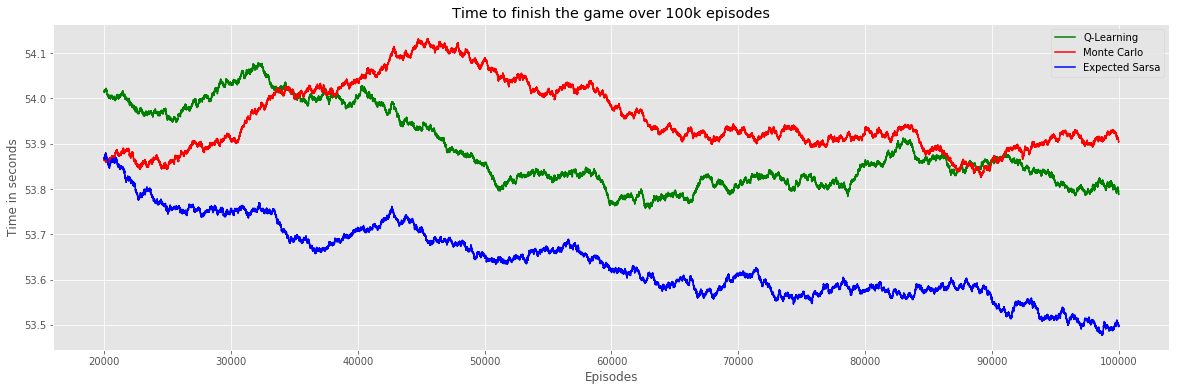

In [71]:
plt.figure(figsize=(20, 6))
mc, = plt.plot(pd.Series(time_to_win).rolling(20000, min_periods=20000).mean(), color='green', label='Q-Learning')
q, = plt.plot(pd.Series(time_to_win_mc).rolling(20000, min_periods=20000).mean(), color='red', label='Monte Carlo')
ex_sarsa, = plt.plot(pd.Series(time_to_win_sx_sarsa).rolling(20000, min_periods=20000).mean(), color='blue', label='Expected Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Time in seconds')
plt.title('Time to finish the game over 100k episodes')
plt.legend(handles=[mc, q, ex_sarsa])
plt.savefig('q_learning_vs_mc_finish_times_vs_ex_sarsa.jpg', dpi=600)